In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

def read_csv_files(directory):
    data_frames = {}
    print("\nReading CSV files:")
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            print(f"  Reading: {filename}")
            df = pd.read_csv(os.path.join(directory, filename))
            parts = filename.split('_')
            file_type = parts[0]
            participant = parts[-2] if len(parts) > 2 else 'unknown'
            difficulty = parts[-1].split('.')[0] if len(parts) > 1 else 'unknown'
            if not file_type == 'E4 ACC data':
                key = (participant, difficulty, file_type)
                data_frames[key] = df
            else:
                print(f"    Skipped: {filename} (ACC data)")
    print(f"Total files read: {len(data_frames)}")
    return data_frames

def preprocess_data(df):
    if 'game start' in df['Participant Name'].values:
        idx = df[df['Participant Name'] == 'game start'].index[0]
        df = df.iloc[idx:]
    else:
        print("Warning: 'game start' marker not found. Using all data.")
    
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
    
    return df

def z_score_normalize(df, baseline_duration):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.drop('UNIX Time')
    baseline = df.iloc[:baseline_duration]
    mean = baseline[numeric_columns].mean()
    std = baseline[numeric_columns].std()
    std = std.replace(0, 1)  # Replace zero std with 1 to avoid division by zero
    normalized_df = df.copy()
    normalized_df[numeric_columns] = (df[numeric_columns] - mean) / std
    return normalized_df

def process_data(df, window_size, baseline_duration):
    df = preprocess_data(df)
    
    if 'UNIX Time' not in df.columns or df['UNIX Time'].isnull().all():
        print("Error: 'UNIX Time' column not found or all values are null")
        return pd.DataFrame()
    
    start_time = df['UNIX Time'].min()
    game_start_time = start_time + baseline_duration
    
    unix_time = df['UNIX Time']
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=['UNIX Time'])
    
    imputer = SimpleImputer(strategy='mean')
    df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)
    
    df_imputed['UNIX Time'] = unix_time
    
    normalized_df = z_score_normalize(df_imputed, baseline_duration)
    
    df_after_start = normalized_df[normalized_df['UNIX Time'] >= game_start_time]
    
    if df_after_start.empty:
        print(f"Warning: No data available after assumed game start")
        return pd.DataFrame()
    
    df_numeric = df_after_start.drop(columns=['UNIX Time'])
    
    return df_numeric

def prepare_participant_data_for_prediction(data_frames, participant, baseline_duration, window_size, expected_features):
    all_data = []
    
    for (part, difficulty, file_type), df in data_frames.items():
        if part == participant:
            processed_df = process_data(df, window_size, baseline_duration)
            
            # Ensure we have the expected number of features
            current_features = processed_df.shape[1]
            if current_features < expected_features:
                # Pad with zeros if we have fewer features
                padding = pd.DataFrame(0, index=processed_df.index, columns=[f'padded_{i}' for i in range(expected_features - current_features)])
                processed_df = pd.concat([processed_df, padding], axis=1)
            elif current_features > expected_features:
                # Truncate if we have more features
                processed_df = processed_df.iloc[:, :expected_features]
            
            all_data.append((difficulty, processed_df))
    
    return all_data

def main():
    directory = r'C:\Users\HCIS\Downloads\gamedata'
    data_frames = read_csv_files(directory)
    
    model_path = r'C:\Users\HCIS\Downloads\gamedata\lstm_model_3class_kfold.h5'
    best_model = tf.keras.models.load_model(model_path)
    
    # Get the expected input shape from the model
    expected_shape = best_model.input_shape
    print(f"Expected input shape: {expected_shape}")
    
    baseline_duration = 30
    window_size = expected_shape[1]
    expected_features = expected_shape[2]
    
    participant_data = prepare_participant_data_for_prediction(data_frames, 'participant3', baseline_duration, window_size, expected_features)
    
    le = LabelEncoder()
    le.fit([difficulty for difficulty, _ in participant_data])
    
    for difficulty, df in participant_data:
        print(f"\nProcessing {difficulty} data:")
        
        # Skip the baseline duration
        start_idx = baseline_duration
        
        for i in range(start_idx, len(df) - window_size + 1):
            sequence = df.iloc[i:i+window_size].values
            X = np.expand_dims(sequence, axis=0)  # Add batch dimension
            
            # Make prediction
            y_pred = best_model.predict(X, verbose=0)
            pred_class = le.inverse_transform([np.argmax(y_pred)])[0]
            
            # Calculate the actual time
            time_elapsed = i - start_idx + 1  # +1 because we start at 0
            
            print(f"Time: {time_elapsed}s, True: {difficulty}, Predicted: {pred_class}")
        
        print(f"Finished processing {difficulty} data\n")

if __name__ == "__main__":
    main()


Reading CSV files:


FileNotFoundError: [WinError 3] 지정된 경로를 찾을 수 없습니다: 'C:\\Users\\HCIS\\Downloads\\gamedata'

In [24]:
import os
import time
import datetime
import logging
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from collections import Counter
from itertools import product
from sklearn.model_selection import ParameterGrid, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, LearningRateScheduler
from tensorflow.keras.regularizers import l2

print("TensorFlow version:", tf.__version__)
print("TensorFlow is using GPU:", tf.test.is_gpu_available())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# GPU Configuration
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(f"{len(gpus)} Physical GPU(s), {len(logical_gpus)} Logical GPU(s)")
    except RuntimeError as e:
        print(e)
else:
    print("No GPUs detected. Running on CPU.")

# Set mixed precision policy
policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def weighted_categorical_crossentropy(class_weights):
    def loss(y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.cast(y_pred, tf.float32)
        return tf.reduce_mean(
            tf.reduce_sum(
                -y_true * tf.math.log(tf.clip_by_value(y_pred, 1e-7, 1.0)) * class_weights,
                axis=-1
            )
        )
    return loss

def calculate_class_weights(y):
    class_counts = np.bincount(y)
    total_samples = np.sum(class_counts)
    class_weights = total_samples / (len(class_counts) * class_counts)
    return class_weights / np.sum(class_weights)

def read_csv_files(directory):
    data_frames = {}
    print("\nReading CSV files:")
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            print(f"  Reading: {filename}")
            df = pd.read_csv(os.path.join(directory, filename))
            parts = filename.split('_')
            file_type = parts[0]
            participant = parts[-2] if len(parts) > 2 else 'unknown'
            difficulty = parts[-1].split('.')[0] if len(parts) > 1 else 'unknown'
            if not file_type == 'E4 ACC data':
                key = (participant, difficulty, file_type)
                data_frames[key] = df
            else:
                print(f"    Skipped: {filename} (ACC data)")
    print(f"Total files read: {len(data_frames)}")
    return data_frames

def preprocess_data(df):
    if 'game start' in df['Participant Name'].values:
        idx = df[df['Participant Name'] == 'game start'].index[0]
        df = df.iloc[idx:]
    elif 'started' in df['game started'].values:
        idx = df[df['game started'] == 'started'].index[0] - 1
        df = df.drop(columns=['game started'])
        df = df.iloc[idx:]
    else:
        print("Warning: 'game start' marker not found. Using all data.")
    
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
    
    return df

def z_score_normalize(df, baseline_duration):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.drop('UNIX Time')
    baseline = df.iloc[:baseline_duration]
    mean = baseline[numeric_columns].mean()
    std = baseline[numeric_columns].std()
    std = std.replace(0, 1)  # Replace zero std with 1 to avoid division by zero
    normalized_df = df.copy()
    normalized_df[numeric_columns] = (df[numeric_columns] - mean) / std
    return normalized_df

def make_sequences(df, window_size):
    sequences = []
    for i in range(0, len(df) - window_size + 1):
        sequences.append(df.iloc[i:i+window_size].values)
    return np.array(sequences)

def process_data(df, window_size, baseline_duration, sampling_rate, normalize=True):
    df = preprocess_data(df)
    
    if 'UNIX Time' not in df.columns or df['UNIX Time'].isnull().all():
        print("Error: 'UNIX Time' column not found or all values are null")
        return pd.DataFrame()
    
    unix_time = df['UNIX Time']
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=['UNIX Time'])
    
    imputer = SimpleImputer(strategy='mean')
    df_imputed = pd.DataFrame(imputer.fit_transform(df_numeric), columns=df_numeric.columns)
    df_imputed['UNIX Time'] = unix_time
    
    df_imputed['UNIX Time'] = pd.to_datetime(df_imputed['UNIX Time'], unit='s')
    df_resampled = df_imputed.set_index('UNIX Time').resample(f'{int(1000/sampling_rate)}L').mean().interpolate()
    
    df_resampled['UNIX Time'] = df_resampled.index.astype(np.int64) // 10**9  # Convert back to UNIX timestamp
    
    start_time = df_resampled['UNIX Time'].min()
    game_start_time = start_time + baseline_duration
    
    if normalize:
        df_processed = z_score_normalize(df_resampled, baseline_duration)
    else:
        df_processed = df_resampled
    
    df_after_start = df_processed[df_processed['UNIX Time'] >= game_start_time]
    if df_after_start.empty:
        if 'Saccade Amplitude' in df_after_start.columns:
            df_after_start.loc[len(df_after_start)] = [0] * len(df_after_start.columns)
            return df_after_start.drop(columns=['UNIX Time'])
        else:
            print(f"Warning: No data available after assumed game start")
            return pd.DataFrame()
    
    df_numeric = df_after_start.drop(columns=['UNIX Time'])
    
    return df_numeric

def create_dataset(data_frames, window_size, n_classes, baseline_duration, sampling_rate, normalize):
    X_data = []
    y_data = []
    participant_data = []
    all_columns = set()
    
    all_dfs = []
    for (participant, difficulty, file_type), df in data_frames.items():
        if n_classes == 2 and difficulty == 'difficult':
            continue
        processed_df = process_data(df, window_size, baseline_duration, sampling_rate, normalize)
        all_columns.update(processed_df.columns)
        all_dfs.append(processed_df)
    
    all_columns = sorted(list(all_columns))
    
    global_imputer = SimpleImputer(strategy='mean')
    global_imputer.fit(pd.concat(all_dfs)[all_columns])
    
    for (participant, difficulty, file_type), df in tqdm(data_frames.items(), desc="Processing data frames"):
        if n_classes == 2 and difficulty == 'difficult':
            continue
        processed_df = process_data(df, window_size, baseline_duration, sampling_rate, normalize)
        
        for col in all_columns:
            if col not in processed_df.columns:
                processed_df[col] = 0
        
        processed_df = processed_df[all_columns]
        
        processed_df = pd.DataFrame(global_imputer.transform(processed_df), columns=all_columns)
        
        sequences = make_sequences(processed_df, window_size)
        if len(sequences) > 0:
            X_data.append(sequences)
            y_data.extend([difficulty] * len(sequences))
            participant_data.extend([participant] * len(sequences))
    
    if not X_data:
        return None, None, None
    
    X = np.concatenate(X_data)
    y = np.array(y_data)
    participants = np.array(participant_data)
    
    return X, y, participants

def apply_smote(X, y, participants, n_classes, chunk_size=10000):
    print(f"Original class distribution: {np.unique(y, return_counts=True)}")
    
    X_resampled_list = []
    y_resampled_list = []
    participants_resampled_list = []

    for i in tqdm(range(0, len(X), chunk_size), desc="Applying SMOTE"):
        X_chunk = X[i:i+chunk_size]
        y_chunk = y[i:i+chunk_size]
        participants_chunk = participants[i:i+chunk_size]

        class_counts = Counter(y_chunk)
        min_class_count = min(class_counts.values())
        
        if len(np.unique(y_chunk)) > 1 and min_class_count > 1:
            n_neighbors = min(5, min_class_count - 1)  # Ensure we don't have more neighbors than samples
            smote = SMOTE(random_state=42, k_neighbors=n_neighbors)
            
            X_flat = X_chunk.reshape(X_chunk.shape[0], -1)
            X_resampled, y_resampled = smote.fit_resample(X_flat, y_chunk)
            X_resampled = X_resampled.reshape(X_resampled.shape[0], X_chunk.shape[1], X_chunk.shape[2])

            original_samples = pd.DataFrame({'y': y_chunk, 'participant': participants_chunk})
            resampled_samples = pd.DataFrame({'y': y_resampled})
            resampled_samples['participant'] = resampled_samples.apply(
                lambda row: original_samples[original_samples['y'] == row['y']]['participant'].iloc[0], 
                axis=1
            )
            participants_resampled = resampled_samples['participant'].values
        else:
            # If we can't apply SMOTE, duplicate minority classes to balance
            max_count = max(class_counts.values())
            X_resampled, y_resampled, participants_resampled = [], [], []
            for class_label in class_counts:
                class_indices = np.where(y_chunk == class_label)[0]
                n_samples = len(class_indices)
                n_repeats = max_count // n_samples + 1
                X_resampled.extend(np.tile(X_chunk[class_indices], (n_repeats, 1, 1))[:max_count])
                y_resampled.extend([class_label] * max_count)
                participants_resampled.extend(np.tile(participants_chunk[class_indices], n_repeats)[:max_count])
            X_resampled = np.array(X_resampled)
            y_resampled = np.array(y_resampled)
            participants_resampled = np.array(participants_resampled)

        X_resampled_list.append(X_resampled)
        y_resampled_list.append(y_resampled)
        participants_resampled_list.append(participants_resampled)

    X_resampled = np.concatenate(X_resampled_list)
    y_resampled = np.concatenate(y_resampled_list)
    participants_resampled = np.concatenate(participants_resampled_list)

    y_resampled_cat = to_categorical(pd.Categorical(y_resampled).codes, num_classes=n_classes)

    print(f"Resampled class distribution: {np.unique(y_resampled, return_counts=True)}")
    
    assert len(X_resampled) == len(y_resampled_cat) == len(participants_resampled), "Mismatch in resampled data lengths"

    return X_resampled, y_resampled_cat, participants_resampled

def create_lstm_model(input_shape, n_classes, lstm_units, dropout_rate, dense_units, learning_rate, class_weights):
    with tf.device('/GPU:0'):
        inputs = tf.keras.Input(shape=input_shape)
        
        # Low-level features
        x_low = LSTM(lstm_units[0], return_sequences=True)(inputs)
        x_low = BatchNormalization()(x_low)
        x_low = Dropout(dropout_rate)(x_low)
        
        # High-level features
        x_high = LSTM(lstm_units[1], return_sequences=False)(x_low)
        x_high = BatchNormalization()(x_high)
        x_high = Dropout(dropout_rate)(x_high)
        
        # Concatenate low and high level features
        x_low_flat = tf.keras.layers.GlobalAveragePooling1D()(x_low)
        x_concat = tf.keras.layers.Concatenate()([x_low_flat, x_high])
        
        x = Dense(dense_units, activation='relu')(x_concat)
        x = BatchNormalization()(x)
        outputs = Dense(n_classes, activation='softmax', dtype='float32')(x)
        
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
    
    loss = weighted_categorical_crossentropy(class_weights)
    optimizer = Adam(learning_rate=learning_rate, clipnorm=1.0)  # Added gradient clipping
    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    return model

class GPUMemoryCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        try:
            gpus = tf.config.list_physical_devices('GPU')
            for i, gpu in enumerate(gpus):
                memory_info = tf.config.experimental.get_memory_info(f'GPU:{i}')
                gpu_mem = memory_info['current'] / (1024**3)
                print(f"Epoch {epoch+1}: GPU:{i} Memory Usage: {gpu_mem:.2f} GB")
        except Exception as e:
            print(f"Unable to get GPU memory info: {e}")

def lr_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

def train_loso_fold(X, y, train_index, test_index, hyperparameters, n_classes):
    with tf.device('/GPU:0'):
        X_train, X_test = tf.convert_to_tensor(X[train_index]), tf.convert_to_tensor(X[test_index])
        y_train, y_test = tf.convert_to_tensor(y[train_index]), tf.convert_to_tensor(y[test_index])
        
        # Calculate class weights
        y_train_classes = np.argmax(y_train, axis=1)
        class_weights = calculate_class_weights(y_train_classes)
        
        train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
        train_dataset = train_dataset.cache().shuffle(10000).batch(hyperparameters['batch_size']).prefetch(tf.data.AUTOTUNE)
        
        val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(hyperparameters['batch_size']).prefetch(tf.data.AUTOTUNE)
        model = create_lstm_model((X_train.shape[1], X_train.shape[2]), n_classes, 
                                  hyperparameters['lstm_units'], 
                                  hyperparameters['dropout_rate'],
                                  hyperparameters['dense_units'],
                                  hyperparameters['learning_rate'],
                                  class_weights)
        
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, profile_batch='500,520')
        
        # Add learning rate scheduler
        lr_scheduler = LearningRateScheduler(lr_schedule)
        
        model.fit(train_dataset, epochs=hyperparameters['epochs'], 
                  validation_data=val_dataset,
                  callbacks=[early_stopping, GPUMemoryCallback(), tensorboard_callback, lr_scheduler], 
                  verbose=1)
        
        y_pred = model.predict(val_dataset)
        y_pred_classes = tf.argmax(y_pred, axis=1)
        y_test_classes = tf.argmax(y_test, axis=1)
        
        accuracy = tf.keras.metrics.Accuracy()
        accuracy.update_state(y_test_classes, y_pred_classes)
        
        f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    
    return accuracy.result().numpy(), f1

def evaluate_lstm_model(X, y, participants, n_classes, hyperparameters):
    logo = LeaveOneGroupOut()
    
    loso_scores = []
    loso_f1_scores = []
    
    logging.info(f"Starting LOSO evaluation with batch size: {hyperparameters['batch_size']}")
    start_time = time.time()
    
    for train_index, test_index in logo.split(X, y, participants):
        accuracy, f1 = train_loso_fold(X, y, train_index, test_index, hyperparameters, n_classes)
        loso_scores.append(accuracy)
        loso_f1_scores.append(f1)
        logging.info(f"LOSO CV accuracy for participant {participants[test_index[0]]}: {accuracy:.4f}, F1-score: {f1:.4f}")
    
    loso_mean_accuracy = np.mean(loso_scores)
    loso_std_accuracy = np.std(loso_scores)
    loso_mean_f1 = np.mean(loso_f1_scores)
    loso_std_f1 = np.std(loso_f1_scores)
    
    end_time = time.time()
    logging.info(f"LOSO evaluation completed in {end_time - start_time:.2f} seconds")
    logging.info(f"LOSO CV mean accuracy: {loso_mean_accuracy:.4f} (+/- {loso_std_accuracy * 2:.4f})")
    logging.info(f"LOSO CV mean F1-score: {loso_mean_f1:.4f} (+/- {loso_std_f1 * 2:.4f})")
    
    return loso_mean_accuracy, loso_std_accuracy, loso_mean_f1, loso_std_f1

def run_experiment(params, X, y, participants, n_classes):
    tf.keras.backend.clear_session()
    
    hyperparameters = {
        'lstm_units': params['lstm_units'],
        'dropout_rate': params['dropout_rate'],
        'dense_units': params['dense_units'],
        'learning_rate': params['learning_rate'],
        'epochs': params['epochs'],
        'batch_size': params['batch_size']
    }
    
    start_time = time.time()
    loso_mean_accuracy, loso_std_accuracy, loso_mean_f1, loso_std_f1 = evaluate_lstm_model(X, y, participants, n_classes, hyperparameters)
    end_time = time.time()
    
    execution_time = end_time - start_time
    
    return params, loso_mean_accuracy, loso_std_accuracy, loso_mean_f1, loso_std_f1, execution_time

def main():
    directory = r'C:\Users\USER\Downloads\gamedata'
    data_frames = read_csv_files(directory)
    
    param_grid = {
        'baseline_duration': [20, 30],
        'window_size': [10, 20],
        'sampling_rate': [2, 4],  # Increased to 4Hz
        'lstm_units': [(8, 4), (16, 8), (32, 16)], # Original = [(32, 16), (64, 32)]
        'dropout_rate': [0.4],
        'dense_units': [16, 64, 256], # Original = [32, 64, 128]
        'learning_rate': [0.0003],
        'epochs': [100],
        'batch_size': [512],
        'normalize': [True, False]  # Added normalization as a parameter
    }
    
    best_params = {}
    
    for n_classes in [3]:
        logging.info(f"\n{'='*50}")
        logging.info(f"Running {n_classes}-class classification")
        logging.info(f"{'='*50}")
        
        all_results = []
        
        # Preprocess data for each baseline duration, window size, and normalization combination
        datasets = {}
        for baseline_duration, window_size, sampling_rate, normalize in product(
            param_grid['baseline_duration'], param_grid['window_size'], 
            param_grid['sampling_rate'], param_grid['normalize']):
            
            logging.info(f"Creating dataset: baseline_duration={baseline_duration}, "
                         f"window_size={window_size}, sampling_rate={sampling_rate}, "
                         f"normalize={normalize}")
            
            X, y, participants = create_dataset(data_frames, window_size, n_classes, 
                                                baseline_duration, sampling_rate, normalize)
            if X is not None:
                datasets[(baseline_duration, window_size, sampling_rate, normalize)] = (X, y, participants)
                logging.info(f"Dataset created: shape={X.shape}, classes={np.unique(y)}")
            else:
                logging.warning(f"Failed to create dataset for baseline_duration={baseline_duration}, "
                                f"window_size={window_size}, sampling_rate={sampling_rate}, "
                                f"normalize={normalize}")
        
        # Apply SMOTE once for each dataset
        resampled_datasets = {}
        for (baseline_duration, window_size, sampling_rate, normalize), (X, y, participants) in datasets.items():
            X_resampled, y_resampled, participants_resampled = apply_smote(X, y, participants, n_classes)
            resampled_datasets[(baseline_duration, window_size, sampling_rate, normalize)] = (X_resampled, y_resampled, participants_resampled)
        
        # Run experiments sequentially with detailed progress bar
        total_experiments = len(list(ParameterGrid(param_grid)))
        pbar = tqdm(total=total_experiments, desc=f"{n_classes}-class Progress")
        
        overall_start_time = time.time()
        for i, params in enumerate(ParameterGrid(param_grid), 1):
            X, y, participants = resampled_datasets[(params['baseline_duration'], params['window_size'], 
                                                     params['sampling_rate'], params['normalize'])]
            
            logging.info(f"Starting experiment {i}/{total_experiments}")
            logging.info(f"Parameters: {params}")
            
            result = run_experiment(params, X, y, participants, n_classes)
            params, loso_accuracy, loso_std, loso_f1, loso_f1_std, execution_time = result
            
            all_results.append(result)
            
            pbar.set_postfix({
                'LOSO Acc': f'{loso_accuracy:.4f}',
                'F1': f'{loso_f1:.4f}',
                'Time': f'{execution_time:.2f}s'
            })
            pbar.update(1)
            
            logging.info(f"Experiment {i}/{total_experiments} completed")
            logging.info(f"LOSO accuracy: {loso_accuracy:.4f} (±{loso_std:.4f})")
            logging.info(f"LOSO F1-score: {loso_f1:.4f} (±{loso_f1_std:.4f})")
            logging.info(f"Execution time: {execution_time:.2f}s")
            
            elapsed_time = time.time() - overall_start_time
            estimated_total_time = elapsed_time * total_experiments / i
            remaining_time = estimated_total_time - elapsed_time
            
            logging.info(f"Elapsed time: {elapsed_time:.2f}s")
            logging.info(f"Estimated time remaining: {remaining_time:.2f}s")
            logging.info(f"Estimated total time: {estimated_total_time:.2f}s")
            logging.info("-" * 50)
        
        pbar.close()
        
        # Find best parameters based on LOSO F1-score
        best_result = max(all_results, key=lambda x: x[3])  # x[3] is loso_mean_f1
        best_params[n_classes] = best_result[0]
        best_params[n_classes]['loso_accuracy'] = best_result[1]
        best_params[n_classes]['loso_std'] = best_result[2]
        best_params[n_classes]['loso_f1'] = best_result[3]
        best_params[n_classes]['loso_f1_std'] = best_result[4]
        best_params[n_classes]['execution_time'] = best_result[5]
    
    logging.info("\nBest parameters and results:")
    for n_classes, params in best_params.items():
        logging.info(f"\n{n_classes}-class classification:")
        for key, value in params.items():
            logging.info(f"  {key}: {value}")
        
        # Train and save the best model
        X, y, participants = resampled_datasets[(params['baseline_duration'], params['window_size'], 
                                                 params['sampling_rate'], params['normalize'])]
        y_classes = np.argmax(y, axis=1)
        class_weights = calculate_class_weights(y_classes)
        best_model = create_lstm_model((X.shape[1], X.shape[2]), n_classes, 
                                       params['lstm_units'], params['dropout_rate'],
                                       params['dense_units'], params['learning_rate'],
                                       class_weights)
        
        logging.info(f"Training final {n_classes}-class model with best parameters")
        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
        lr_scheduler = LearningRateScheduler(lr_schedule)
        best_model.fit(X, y, epochs=params['epochs'], batch_size=params['batch_size'], verbose=1,
                       callbacks=[GPUMemoryCallback(), early_stopping, lr_scheduler], validation_split=0.2)
        
        model_filename = (f"best_lstm_model_{n_classes}class_"
                  f"bd{params['baseline_duration']}_"
                  f"ws{params['window_size']}_"
                  f"sr{params['sampling_rate']}Hz_"
                  f"lstm{params['lstm_units'][0]}-{params['lstm_units'][1]}_"
                  f"dr{params['dropout_rate']:.1f}_"
                  f"du{params['dense_units']}_"
                  f"lr{params['learning_rate']:.6f}_"
                  f"e{params['epochs']}_"
                  f"bs{params['batch_size']}_"
                  f"norm{params['normalize']}.h5")

        best_model.save(model_filename)
        logging.info(f"Best {n_classes}-class model_0722_v2 saved as {model_filename}")

    logging.info("Analysis complete.")

if __name__ == "__main__":
    main()

TensorFlow version: 2.10.0
TensorFlow is using GPU: True
Num GPUs Available:  1
1 Physical GPU(s), 1 Logical GPU(s)

Reading CSV files:
  Reading: E4 ACC data_participant1_difficult.csv
    Skipped: E4 ACC data_participant1_difficult.csv (ACC data)
  Reading: E4 ACC data_participant1_easy.csv
    Skipped: E4 ACC data_participant1_easy.csv (ACC data)
  Reading: E4 ACC data_participant1_moderate.csv
    Skipped: E4 ACC data_participant1_moderate.csv (ACC data)
  Reading: E4 ACC data_participant2_difficult.csv
    Skipped: E4 ACC data_participant2_difficult.csv (ACC data)
  Reading: E4 ACC data_participant2_easy.csv
    Skipped: E4 ACC data_participant2_easy.csv (ACC data)
  Reading: E4 ACC data_participant2_moderate.csv
    Skipped: E4 ACC data_participant2_moderate.csv (ACC data)
  Reading: E4 ACC data_participant3_difficult.csv
    Skipped: E4 ACC data_participant3_difficult.csv (ACC data)
  Reading: E4 ACC data_participant3_easy.csv
    Skipped: E4 ACC data_participant3_easy.csv (ACC 

2024-07-31 13:58:56,552 - INFO - 
2024-07-31 13:58:56,555 - INFO - Running 3-class classification
2024-07-31 13:58:56,555 - INFO - ==================================================
2024-07-31 13:58:56,555 - INFO - Creating dataset: baseline_duration=20, window_size=10, sampling_rate=2, normalize=True


  Reading: Eye Feature data_participant4_easy.csv
  Reading: Eye Feature data_participant4_moderate.csv
  Reading: Eye Feature data_participant5_difficult.csv
  Reading: Eye Feature data_participant5_easy.csv
  Reading: Eye Feature data_participant5_moderate.csv
  Reading: Saccade Amplitude data_participant1_difficult.csv
  Reading: Saccade Amplitude data_participant1_easy.csv
  Reading: Saccade Amplitude data_participant1_moderate.csv
  Reading: Saccade Amplitude data_participant2_difficult.csv
  Reading: Saccade Amplitude data_participant2_easy.csv
  Reading: Saccade Amplitude data_participant2_moderate.csv
  Reading: Saccade Amplitude data_participant3_difficult.csv
  Reading: Saccade Amplitude data_participant3_easy.csv
  Reading: Saccade Amplitude data_participant3_moderate.csv
  Reading: Saccade Amplitude data_participant4_difficult.csv
  Reading: Saccade Amplitude data_participant4_easy.csv
  Reading: Saccade Amplitude data_participant4_moderate.csv
  Reading: Saccade Amplitude 

C:\Users\USER\AppData\Local\Temp\ipykernel_3720\168054422.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3720\168054422.py:132: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  df_resampled = df_imputed.set_index('UNIX Time').resample(f'{int(1000/sampling_rate)}L').mean().interpolate()
C:\Users\USER\AppData\Local\Temp\ipykernel_3720\168054422.py:97: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([8180, 8314, 9024], dtype=int64))


Applying SMOTE: 100%|██████████| 3/3 [00:17<00:00,  5.84s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([9024, 9024, 9024], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([8180, 8314, 9024], dtype=int64))


Applying SMOTE: 100%|██████████| 3/3 [00:17<00:00,  5.92s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([9024, 9024, 9024], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([16533, 16798, 18220], dtype=int64))


Applying SMOTE: 100%|██████████| 6/6 [00:38<00:00,  6.43s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([19859, 19859, 19859], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([16533, 16798, 18220], dtype=int64))


Applying SMOTE: 100%|██████████| 6/6 [00:36<00:00,  6.16s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([19859, 19859, 19859], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([7980, 8118, 8824], dtype=int64))


Applying SMOTE: 100%|██████████| 3/3 [00:15<00:00,  5.31s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([8869, 8869, 8869], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([7980, 8118, 8824], dtype=int64))


Applying SMOTE: 100%|██████████| 3/3 [00:16<00:00,  5.39s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([8869, 8869, 8869], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([16333, 16598, 18020], dtype=int64))


Applying SMOTE: 100%|██████████| 6/6 [00:37<00:00,  6.19s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([19251, 19251, 19251], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([16333, 16598, 18020], dtype=int64))


Applying SMOTE: 100%|██████████| 6/6 [00:37<00:00,  6.20s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([19251, 19251, 19251], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([7780, 7928, 8624], dtype=int64))


Applying SMOTE: 100%|██████████| 3/3 [00:16<00:00,  5.35s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([8637, 8637, 8637], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([7780, 7928, 8624], dtype=int64))


Applying SMOTE: 100%|██████████| 3/3 [00:15<00:00,  5.26s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([8637, 8637, 8637], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([15733, 16018, 17420], dtype=int64))


Applying SMOTE: 100%|██████████| 5/5 [00:34<00:00,  6.98s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([18018, 18018, 18018], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([15733, 16018, 17420], dtype=int64))


Applying SMOTE: 100%|██████████| 5/5 [00:35<00:00,  7.03s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([18018, 18018, 18018], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([7580, 7738, 8424], dtype=int64))


Applying SMOTE: 100%|██████████| 3/3 [00:15<00:00,  5.16s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([8498, 8498, 8498], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([7580, 7738, 8424], dtype=int64))


Applying SMOTE: 100%|██████████| 3/3 [00:15<00:00,  5.18s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([8498, 8498, 8498], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([15533, 15828, 17220], dtype=int64))


Applying SMOTE: 100%|██████████| 5/5 [00:43<00:00,  8.76s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([17711, 17711, 17711], dtype=int64))
Original class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([15533, 15828, 17220], dtype=int64))


Applying SMOTE: 100%|██████████| 5/5 [00:36<00:00,  7.23s/it]


Resampled class distribution: (array(['difficult', 'easy', 'moderate'], dtype='<U9'), array([17711, 17711, 17711], dtype=int64))


3-class Progress:   0%|          | 0/144 [00:00<?, ?it/s]2024-07-31 14:06:48,067 - INFO - Starting experiment 1/144
2024-07-31 14:06:48,070 - INFO - Parameters: {'baseline_duration': 20, 'batch_size': 512, 'dense_units': 16, 'dropout_rate': 0.4, 'epochs': 100, 'learning_rate': 0.0003, 'lstm_units': (8, 4), 'normalize': True, 'sampling_rate': 2, 'window_size': 10}
2024-07-31 14:06:48,075 - INFO - Starting LOSO evaluation with batch size: 512


Epoch 1/100
 4/22 [====>.........................] - ETA: 0s - loss: 0.4267 - accuracy: 0.3296  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0424s). Check your callbacks.


2024-07-31 14:06:52,441 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0424s). Check your callbacks.


22/22 [==============================] - 5s 85ms/step - loss: 0.4278 - accuracy: 0.3155 - val_loss: 0.3789 - val_accuracy: 0.2608 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 56ms/step - loss: 0.4282 - accuracy: 0.3139 - val_loss: 0.3818 - val_accuracy: 0.2936 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 69ms/step - loss: 0.4270 - accuracy: 0.3162 - val_loss: 0.3855 - val_accuracy: 0.2946 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 48ms/step - loss: 0.4288 - accuracy: 0.3147 - val_loss: 0.3902 - val_accuracy: 0.2967 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 44ms/step - loss: 0.4249 - accuracy: 0.3213 - val_loss: 0.3958 - val_accuracy: 0.2964 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 45ms/step - loss: 0.4280 - accuracy: 0.3146 - val_loss: 0.4023 - val_accuracy: 0.2953 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 40

2024-07-31 14:07:05,271 - INFO - LOSO CV accuracy for participant participant1: 0.2608, F1-score: 0.2564


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5066 - accuracy: 0.3228  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0225s). Check your callbacks.


2024-07-31 14:07:08,807 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0225s). Check your callbacks.


39/39 [==============================] - 5s 58ms/step - loss: 0.5237 - accuracy: 0.2914 - val_loss: 0.4084 - val_accuracy: 0.5053 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 31ms/step - loss: 0.5148 - accuracy: 0.2982 - val_loss: 0.4294 - val_accuracy: 0.4720 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 23ms/step - loss: 0.5075 - accuracy: 0.3026 - val_loss: 0.4488 - val_accuracy: 0.4572 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4972 - accuracy: 0.3047 - val_loss: 0.4666 - val_accuracy: 0.4795 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 28ms/step - loss: 0.4863 - accuracy: 0.3110 - val_loss: 0.4817 - val_accuracy: 0.4785 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 30ms/step - loss: 0.4767 - accuracy: 0.3156 - val_loss: 0.4928 - val_accuracy: 0.4763 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 28

2024-07-31 14:07:22,223 - INFO - LOSO CV accuracy for participant participant3: 0.5053, F1-score: 0.4890


Epoch 1/100
 5/46 [==>...........................] - ETA: 0s - loss: 0.5298 - accuracy: 0.3184  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


2024-07-31 14:07:26,135 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


46/46 [==============================] - 5s 50ms/step - loss: 0.4330 - accuracy: 0.3914 - val_loss: 0.5429 - val_accuracy: 0.3605 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3887 - accuracy: 0.4259 - val_loss: 0.5639 - val_accuracy: 0.3440 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 29ms/step - loss: 0.3611 - accuracy: 0.4572 - val_loss: 0.6051 - val_accuracy: 0.3198 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 27ms/step - loss: 0.3372 - accuracy: 0.4833 - val_loss: 0.6760 - val_accuracy: 0.3153 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3154 - accuracy: 0.5116 - val_loss: 0.7484 - val_accuracy: 0.3147 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 27ms/step - loss: 0.3024 - accuracy: 0.5348 - val_loss: 0.8164 - val_accuracy: 0.2395 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 17

2024-07-31 14:07:42,853 - INFO - LOSO CV accuracy for participant participant4: 0.3605, F1-score: 0.5299
2024-07-31 14:07:42,855 - INFO - LOSO evaluation completed in 54.78 seconds
2024-07-31 14:07:42,855 - INFO - LOSO CV mean accuracy: 0.3755 (+/- 0.2008)
2024-07-31 14:07:42,856 - INFO - LOSO CV mean F1-score: 0.4251 (+/- 0.2409)
3-class Progress:   1%|          | 1/144 [00:54<2:10:35, 54.79s/it, LOSO Acc=0.3755, F1=0.4251, Time=54.78s]2024-07-31 14:07:42,858 - INFO - Experiment 1/144 completed
2024-07-31 14:07:42,858 - INFO - LOSO accuracy: 0.3755 (±0.1004)
2024-07-31 14:07:42,858 - INFO - LOSO F1-score: 0.4251 (±0.1205)
2024-07-31 14:07:42,861 - INFO - Execution time: 54.78s
2024-07-31 14:07:42,861 - INFO - Elapsed time: 54.79s
2024-07-31 14:07:42,861 - INFO - Estimated time remaining: 7835.49s
2024-07-31 14:07:42,861 - INFO - Estimated total time: 7890.29s
2024-07-31 14:07:42,864 - INFO - --------------------------------------------------
2024-07-31 14:07:42,864 - INFO - Starting e

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.6237 - accuracy: 0.2104  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


2024-07-31 14:07:46,963 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


25/25 [==============================] - 5s 89ms/step - loss: 0.5567 - accuracy: 0.2639 - val_loss: 0.3983 - val_accuracy: 0.3126 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 31ms/step - loss: 0.5542 - accuracy: 0.2658 - val_loss: 0.3852 - val_accuracy: 0.3457 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 44ms/step - loss: 0.5553 - accuracy: 0.2682 - val_loss: 0.3799 - val_accuracy: 0.3149 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 38ms/step - loss: 0.5529 - accuracy: 0.2692 - val_loss: 0.3799 - val_accuracy: 0.2787 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 39ms/step - loss: 0.5554 - accuracy: 0.2625 - val_loss: 0.3835 - val_accuracy: 0.2642 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 39ms/step - loss: 0.5533 - accuracy: 0.2645 - val_loss: 0.3897 - val_accuracy: 0.2631 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 40

2024-07-31 14:08:01,743 - INFO - LOSO CV accuracy for participant participant1: 0.3149, F1-score: 0.2920


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.4485 - accuracy: 0.3340  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0684s). Check your callbacks.


2024-07-31 14:08:06,553 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0684s). Check your callbacks.


49/49 [==============================] - 6s 46ms/step - loss: 0.4483 - accuracy: 0.3175 - val_loss: 0.4903 - val_accuracy: 0.4821 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 26ms/step - loss: 0.4345 - accuracy: 0.3252 - val_loss: 0.5158 - val_accuracy: 0.4778 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 19ms/step - loss: 0.4203 - accuracy: 0.3348 - val_loss: 0.5271 - val_accuracy: 0.4773 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 25ms/step - loss: 0.4114 - accuracy: 0.3417 - val_loss: 0.5228 - val_accuracy: 0.4789 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 20ms/step - loss: 0.4031 - accuracy: 0.3497 - val_loss: 0.5153 - val_accuracy: 0.4826 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3957 - accuracy: 0.3579 - val_loss: 0.5089 - val_accuracy: 0.4874 - lr: 3.0000e-04
Epoch 7/100
49/49 [==============================] - 1s 25

2024-07-31 14:08:22,737 - INFO - LOSO CV accuracy for participant participant2: 0.4821, F1-score: 0.6506


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4376 - accuracy: 0.2959  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


2024-07-31 14:08:26,656 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


39/39 [==============================] - 5s 54ms/step - loss: 0.4074 - accuracy: 0.3254 - val_loss: 0.4474 - val_accuracy: 0.2756 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 28ms/step - loss: 0.4019 - accuracy: 0.3280 - val_loss: 0.4573 - val_accuracy: 0.2328 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3960 - accuracy: 0.3308 - val_loss: 0.4661 - val_accuracy: 0.2258 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 2s 42ms/step - loss: 0.3926 - accuracy: 0.3304 - val_loss: 0.4746 - val_accuracy: 0.2270 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 34ms/step - loss: 0.3885 - accuracy: 0.3361 - val_loss: 0.4833 - val_accuracy: 0.2268 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 2s 42ms/step - loss: 0.3797 - accuracy: 0.3435 - val_loss: 0.4905 - val_accuracy: 0.2335 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 29

2024-07-31 14:08:41,872 - INFO - LOSO CV accuracy for participant participant3: 0.2756, F1-score: 0.3260


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4473 - accuracy: 0.3438  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


2024-07-31 14:08:45,840 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


46/46 [==============================] - 5s 52ms/step - loss: 0.4136 - accuracy: 0.3448 - val_loss: 0.5643 - val_accuracy: 0.3162 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 31ms/step - loss: 0.3602 - accuracy: 0.3953 - val_loss: 0.6043 - val_accuracy: 0.1249 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3287 - accuracy: 0.4448 - val_loss: 0.6913 - val_accuracy: 0.0915 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 29ms/step - loss: 0.3108 - accuracy: 0.4813 - val_loss: 0.8194 - val_accuracy: 0.0847 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 27ms/step - loss: 0.2968 - accuracy: 0.5120 - val_loss: 0.9785 - val_accuracy: 0.0821 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 26ms/step - loss: 0.2853 - accuracy: 0.5414 - val_loss: 1.1552 - val_accuracy: 0.0747 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 27

2024-07-31 14:09:02,361 - INFO - LOSO CV accuracy for participant participant4: 0.3162, F1-score: 0.4805
2024-07-31 14:09:02,363 - INFO - LOSO evaluation completed in 79.45 seconds
2024-07-31 14:09:02,364 - INFO - LOSO CV mean accuracy: 0.3472 (+/- 0.1591)
2024-07-31 14:09:02,365 - INFO - LOSO CV mean F1-score: 0.4373 (+/- 0.2843)
3-class Progress:   1%|▏         | 2/144 [02:14<2:44:04, 69.33s/it, LOSO Acc=0.3472, F1=0.4373, Time=79.46s]2024-07-31 14:09:02,369 - INFO - Experiment 2/144 completed
2024-07-31 14:09:02,369 - INFO - LOSO accuracy: 0.3472 (±0.0796)
2024-07-31 14:09:02,370 - INFO - LOSO F1-score: 0.4373 (±0.1422)
2024-07-31 14:09:02,371 - INFO - Execution time: 79.46s
2024-07-31 14:09:02,372 - INFO - Elapsed time: 134.30s
2024-07-31 14:09:02,372 - INFO - Estimated time remaining: 9535.63s
2024-07-31 14:09:02,372 - INFO - Estimated total time: 9669.93s
2024-07-31 14:09:02,374 - INFO - --------------------------------------------------
2024-07-31 14:09:02,374 - INFO - Starting 

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.5071 - accuracy: 0.2500  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0170s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 14:09:07,555 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0170s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


80/80 [==============================] - 7s 32ms/step - loss: 0.5345 - accuracy: 0.2579 - val_loss: 0.3488 - val_accuracy: 0.4725 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 2s 20ms/step - loss: 0.4882 - accuracy: 0.2821 - val_loss: 0.3556 - val_accuracy: 0.4815 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 17ms/step - loss: 0.4501 - accuracy: 0.3210 - val_loss: 0.3915 - val_accuracy: 0.4022 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 18ms/step - loss: 0.4227 - accuracy: 0.3488 - val_loss: 0.4479 - val_accuracy: 0.4126 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 16ms/step - loss: 0.3951 - accuracy: 0.3930 - val_loss: 0.5089 - val_accuracy: 0.3643 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 1s 16ms/step - loss: 0.3837 - accuracy: 0.4114 - val_loss: 0.5563 - val_accuracy: 0.3321 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 43

2024-07-31 14:09:28,007 - INFO - LOSO CV accuracy for participant participant1: 0.4725, F1-score: 0.4639


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.5058 - accuracy: 0.3218  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0445s). Check your callbacks.


2024-07-31 14:09:31,916 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0445s). Check your callbacks.


103/103 [==============================] - 6s 26ms/step - loss: 0.4942 - accuracy: 0.3518 - val_loss: 0.4097 - val_accuracy: 0.4097 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 17ms/step - loss: 0.4352 - accuracy: 0.3887 - val_loss: 0.4259 - val_accuracy: 0.4508 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 17ms/step - loss: 0.4024 - accuracy: 0.4104 - val_loss: 0.4662 - val_accuracy: 0.4654 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3771 - accuracy: 0.4326 - val_loss: 0.5162 - val_accuracy: 0.4747 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 24ms/step - loss: 0.3606 - accuracy: 0.4518 - val_loss: 0.5599 - val_accuracy: 0.2814 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 35ms/step - loss: 0.3479 - accuracy: 0.4649 - val_loss: 0.6042 - val_accuracy: 0.2020 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 14:09:55,935 - INFO - LOSO CV accuracy for participant participant2: 0.4097, F1-score: 0.4924


Epoch 1/100
  4/103 [>.............................] - ETA: 2s - loss: 0.5131 - accuracy: 0.2510  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


2024-07-31 14:09:59,666 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


103/103 [==============================] - 6s 29ms/step - loss: 0.4442 - accuracy: 0.3088 - val_loss: 0.3878 - val_accuracy: 0.4910 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 17ms/step - loss: 0.4241 - accuracy: 0.3221 - val_loss: 0.4234 - val_accuracy: 0.4867 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 17ms/step - loss: 0.4118 - accuracy: 0.3333 - val_loss: 0.4552 - val_accuracy: 0.4874 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 0.4018 - accuracy: 0.3523 - val_loss: 0.4724 - val_accuracy: 0.4877 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 21ms/step - loss: 0.3966 - accuracy: 0.3622 - val_loss: 0.4795 - val_accuracy: 0.4875 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 35ms/step - loss: 0.3892 - accuracy: 0.3781 - val_loss: 0.4860 - val_accuracy: 0.4963 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 14:10:22,796 - INFO - LOSO CV accuracy for participant participant3: 0.4910, F1-score: 0.4622


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.4450 - accuracy: 0.2969  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


2024-07-31 14:10:26,898 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


96/96 [==============================] - 6s 29ms/step - loss: 0.4671 - accuracy: 0.2939 - val_loss: 0.4558 - val_accuracy: 0.1236 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 1s 15ms/step - loss: 0.4444 - accuracy: 0.3198 - val_loss: 0.5222 - val_accuracy: 0.1216 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 20ms/step - loss: 0.4273 - accuracy: 0.3423 - val_loss: 0.5704 - val_accuracy: 0.1218 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 2s 18ms/step - loss: 0.4165 - accuracy: 0.3657 - val_loss: 0.6029 - val_accuracy: 0.1025 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 1s 15ms/step - loss: 0.4121 - accuracy: 0.3822 - val_loss: 0.6199 - val_accuracy: 0.2484 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 4s 37ms/step - loss: 0.4067 - accuracy: 0.3956 - val_loss: 0.6267 - val_accuracy: 0.2740 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 19

2024-07-31 14:10:49,196 - INFO - LOSO CV accuracy for participant participant4: 0.1236, F1-score: 0.0777


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.3816 - accuracy: 0.4443  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0251s). Check your callbacks.


2024-07-31 14:10:53,674 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0251s). Check your callbacks.


86/86 [==============================] - 6s 31ms/step - loss: 0.4047 - accuracy: 0.4299 - val_loss: 0.4005 - val_accuracy: 0.1657 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 1s 14ms/step - loss: 0.3800 - accuracy: 0.4613 - val_loss: 0.4153 - val_accuracy: 0.1415 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 2s 20ms/step - loss: 0.3653 - accuracy: 0.4885 - val_loss: 0.4269 - val_accuracy: 0.1876 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 2s 19ms/step - loss: 0.3565 - accuracy: 0.5032 - val_loss: 0.4419 - val_accuracy: 0.2551 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3475 - accuracy: 0.5244 - val_loss: 0.4588 - val_accuracy: 0.2489 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 18ms/step - loss: 0.3404 - accuracy: 0.5436 - val_loss: 0.4721 - val_accuracy: 0.2103 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 39

2024-07-31 14:11:13,167 - INFO - LOSO CV accuracy for participant participant5: 0.1657, F1-score: 0.1156
2024-07-31 14:11:13,168 - INFO - LOSO evaluation completed in 130.75 seconds
2024-07-31 14:11:13,169 - INFO - LOSO CV mean accuracy: 0.3325 (+/- 0.3126)
2024-07-31 14:11:13,169 - INFO - LOSO CV mean F1-score: 0.3224 (+/- 0.3700)
3-class Progress:   2%|▏         | 3/144 [04:25<3:48:53, 97.40s/it, LOSO Acc=0.3325, F1=0.3224, Time=130.75s]2024-07-31 14:11:13,172 - INFO - Experiment 3/144 completed
2024-07-31 14:11:13,173 - INFO - LOSO accuracy: 0.3325 (±0.1563)
2024-07-31 14:11:13,173 - INFO - LOSO F1-score: 0.3224 (±0.1850)
2024-07-31 14:11:13,175 - INFO - Execution time: 130.75s
2024-07-31 14:11:13,175 - INFO - Elapsed time: 265.11s
2024-07-31 14:11:13,175 - INFO - Estimated time remaining: 12460.07s
2024-07-31 14:11:13,176 - INFO - Estimated total time: 12725.18s
2024-07-31 14:11:13,177 - INFO - --------------------------------------------------
2024-07-31 14:11:13,178 - INFO - Star

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.4692 - accuracy: 0.3042  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0799s). Check your callbacks.


2024-07-31 14:11:16,863 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0799s). Check your callbacks.


69/69 [==============================] - 13396s 197s/step - loss: 0.4556 - accuracy: 0.3342 - val_loss: 0.3612 - val_accuracy: 0.3414 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 24ms/step - loss: 0.4261 - accuracy: 0.3515 - val_loss: 0.3657 - val_accuracy: 0.3642 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 16ms/step - loss: 0.4032 - accuracy: 0.3806 - val_loss: 0.3728 - val_accuracy: 0.3658 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 16ms/step - loss: 0.3887 - accuracy: 0.4150 - val_loss: 0.3819 - val_accuracy: 0.3801 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3762 - accuracy: 0.4435 - val_loss: 0.3922 - val_accuracy: 0.3531 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 16ms/step - loss: 0.3682 - accuracy: 0.4651 - val_loss: 0.4009 - val_accuracy: 0.3389 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1

2024-07-31 18:17:36,568 - INFO - LOSO CV accuracy for participant participant1: 0.3414, F1-score: 0.2757


Epoch 1/100
93/93 [==============================] - 15s 73ms/step - loss: 0.4368 - accuracy: 0.3583 - val_loss: 0.4325 - val_accuracy: 0.2478 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 4s 38ms/step - loss: 0.3892 - accuracy: 0.4140 - val_loss: 0.4812 - val_accuracy: 0.2205 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 3s 32ms/step - loss: 0.3574 - accuracy: 0.4636 - val_loss: 0.5240 - val_accuracy: 0.2009 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 4s 48ms/step - loss: 0.3347 - accuracy: 0.5032 - val_loss: 0.5567 - val_accuracy: 0.1804 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 5s 57ms/step - loss: 0.3211 - accuracy: 0.5325 - val_loss: 0.5742 - val_accuracy: 0.1884 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 8s 83ms/step - loss: 0.3088 - accuracy: 0.5536 - val_loss: 0.5968 - val_accuracy: 0.1727 - lr: 3.0000e-04
Epoch 7/100
93/93 [==========================

2024-07-31 18:18:42,827 - INFO - LOSO CV accuracy for participant participant2: 0.2478, F1-score: 0.1550


Epoch 1/100
 5/99 [>.............................] - ETA: 3s - loss: 0.4747 - accuracy: 0.3250 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0300s vs `on_train_batch_end` time: 0.0550s). Check your callbacks.


2024-07-31 18:18:53,048 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0300s vs `on_train_batch_end` time: 0.0550s). Check your callbacks.


99/99 [==============================] - 13s 43ms/step - loss: 0.4736 - accuracy: 0.3499 - val_loss: 0.3274 - val_accuracy: 0.6505 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 18ms/step - loss: 0.4443 - accuracy: 0.3692 - val_loss: 0.3278 - val_accuracy: 0.6799 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 1s 14ms/step - loss: 0.4234 - accuracy: 0.3844 - val_loss: 0.3569 - val_accuracy: 0.6318 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 17ms/step - loss: 0.4088 - accuracy: 0.3939 - val_loss: 0.3899 - val_accuracy: 0.5344 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 1s 14ms/step - loss: 0.3992 - accuracy: 0.4047 - val_loss: 0.4187 - val_accuracy: 0.5324 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 4s 37ms/step - loss: 0.3940 - accuracy: 0.4127 - val_loss: 0.4344 - val_accuracy: 0.5298 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 2

2024-07-31 18:19:16,241 - INFO - LOSO CV accuracy for participant participant3: 0.6505, F1-score: 0.6564


Epoch 1/100
 6/92 [>.............................] - ETA: 1s - loss: 0.6285 - accuracy: 0.2269WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


2024-07-31 18:19:20,882 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


92/92 [==============================] - 6s 27ms/step - loss: 0.4445 - accuracy: 0.3965 - val_loss: 0.4248 - val_accuracy: 0.0443 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4117 - accuracy: 0.4163 - val_loss: 0.4647 - val_accuracy: 0.0482 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 19ms/step - loss: 0.3847 - accuracy: 0.4404 - val_loss: 0.5124 - val_accuracy: 0.1588 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3680 - accuracy: 0.4580 - val_loss: 0.5581 - val_accuracy: 0.1895 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3552 - accuracy: 0.4746 - val_loss: 0.5951 - val_accuracy: 0.1891 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3454 - accuracy: 0.4897 - val_loss: 0.6215 - val_accuracy: 0.1890 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 18

2024-07-31 18:19:41,927 - INFO - LOSO CV accuracy for participant participant4: 0.0443, F1-score: 0.0631


Epoch 1/100
  4/101 [>.............................] - ETA: 2s - loss: 0.4562 - accuracy: 0.4189  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0214s). Check your callbacks.


2024-07-31 18:19:45,480 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0214s). Check your callbacks.


101/101 [==============================] - 5s 26ms/step - loss: 0.4538 - accuracy: 0.3886 - val_loss: 0.4603 - val_accuracy: 0.2919 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 17ms/step - loss: 0.4175 - accuracy: 0.4129 - val_loss: 0.5071 - val_accuracy: 0.2949 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3901 - accuracy: 0.4364 - val_loss: 0.5151 - val_accuracy: 0.2910 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 23ms/step - loss: 0.3756 - accuracy: 0.4521 - val_loss: 0.5205 - val_accuracy: 0.2892 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 18ms/step - loss: 0.3658 - accuracy: 0.4640 - val_loss: 0.5179 - val_accuracy: 0.2914 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 36ms/step - loss: 0.3577 - accuracy: 0.4755 - val_loss: 0.5137 - val_accuracy: 0.1599 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 18:20:08,174 - INFO - LOSO CV accuracy for participant participant5: 0.2919, F1-score: 0.2783
2024-07-31 18:20:08,175 - INFO - LOSO evaluation completed in 14934.98 seconds
2024-07-31 18:20:08,176 - INFO - LOSO CV mean accuracy: 0.3152 (+/- 0.3914)
2024-07-31 18:20:08,178 - INFO - LOSO CV mean F1-score: 0.2857 (+/- 0.4041)
3-class Progress:   3%|▎         | 4/144 [4:13:20<231:35:17, 5955.12s/it, LOSO Acc=0.3152, F1=0.2857, Time=14934.98s]2024-07-31 18:20:08,180 - INFO - Experiment 4/144 completed
2024-07-31 18:20:08,182 - INFO - LOSO accuracy: 0.3152 (±0.1957)
2024-07-31 18:20:08,183 - INFO - LOSO F1-score: 0.2857 (±0.2021)
2024-07-31 18:20:08,183 - INFO - Execution time: 14934.98s
2024-07-31 18:20:08,184 - INFO - Elapsed time: 15200.12s
2024-07-31 18:20:08,185 - INFO - Estimated time remaining: 532004.09s
2024-07-31 18:20:08,187 - INFO - Estimated total time: 547204.20s
2024-07-31 18:20:08,187 - INFO - --------------------------------------------------
2024-07-31 18:20:08,1

Epoch 1/100
 4/22 [====>.........................] - ETA: 0s - loss: 0.5042 - accuracy: 0.3555 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0208s). Check your callbacks.


2024-07-31 18:20:11,475 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0208s). Check your callbacks.


22/22 [==============================] - 5s 93ms/step - loss: 0.5001 - accuracy: 0.3506 - val_loss: 0.3750 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 47ms/step - loss: 0.4682 - accuracy: 0.3637 - val_loss: 0.3744 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 45ms/step - loss: 0.4476 - accuracy: 0.3633 - val_loss: 0.3752 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 44ms/step - loss: 0.4302 - accuracy: 0.3758 - val_loss: 0.3769 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 29ms/step - loss: 0.4177 - accuracy: 0.3773 - val_loss: 0.3791 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 39ms/step - loss: 0.4105 - accuracy: 0.3824 - val_loss: 0.3823 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 42

2024-07-31 18:20:23,928 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.2610


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4705 - accuracy: 0.3306  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0742s). Check your callbacks.


2024-07-31 18:20:27,652 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0742s). Check your callbacks.


39/39 [==============================] - 6s 72ms/step - loss: 0.4615 - accuracy: 0.3287 - val_loss: 0.4296 - val_accuracy: 0.3083 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 31ms/step - loss: 0.4031 - accuracy: 0.3455 - val_loss: 0.4748 - val_accuracy: 0.2262 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3736 - accuracy: 0.3682 - val_loss: 0.5219 - val_accuracy: 0.2425 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 21ms/step - loss: 0.3620 - accuracy: 0.3813 - val_loss: 0.5714 - val_accuracy: 0.2310 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 28ms/step - loss: 0.3513 - accuracy: 0.3935 - val_loss: 0.6258 - val_accuracy: 0.2222 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3448 - accuracy: 0.4056 - val_loss: 0.6825 - val_accuracy: 0.2162 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 26

2024-07-31 18:20:41,489 - INFO - LOSO CV accuracy for participant participant3: 0.3083, F1-score: 0.3769


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4600 - accuracy: 0.3398  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0303s). Check your callbacks.


2024-07-31 18:20:44,978 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0303s). Check your callbacks.


46/46 [==============================] - 5s 58ms/step - loss: 0.4267 - accuracy: 0.3398 - val_loss: 0.5090 - val_accuracy: 0.3095 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 18ms/step - loss: 0.3864 - accuracy: 0.3450 - val_loss: 0.5375 - val_accuracy: 0.2356 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3658 - accuracy: 0.3581 - val_loss: 0.5871 - val_accuracy: 0.1388 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3571 - accuracy: 0.3641 - val_loss: 0.6406 - val_accuracy: 0.1140 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3498 - accuracy: 0.3719 - val_loss: 0.6995 - val_accuracy: 0.1065 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3455 - accuracy: 0.3763 - val_loss: 0.7540 - val_accuracy: 0.0981 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 23

2024-07-31 18:20:59,432 - INFO - LOSO CV accuracy for participant participant4: 0.3095, F1-score: 0.4726
2024-07-31 18:20:59,433 - INFO - LOSO evaluation completed in 51.21 seconds
2024-07-31 18:20:59,433 - INFO - LOSO CV mean accuracy: 0.3170 (+/- 0.0231)
2024-07-31 18:20:59,435 - INFO - LOSO CV mean F1-score: 0.3702 (+/- 0.1731)
3-class Progress:   3%|▎         | 5/144 [4:14:11<147:43:54, 3826.15s/it, LOSO Acc=0.3170, F1=0.3702, Time=51.22s]   2024-07-31 18:20:59,437 - INFO - Experiment 5/144 completed
2024-07-31 18:20:59,437 - INFO - LOSO accuracy: 0.3170 (±0.0115)
2024-07-31 18:20:59,437 - INFO - LOSO F1-score: 0.3702 (±0.0865)
2024-07-31 18:20:59,439 - INFO - Execution time: 51.22s
2024-07-31 18:20:59,439 - INFO - Elapsed time: 15251.37s
2024-07-31 18:20:59,440 - INFO - Estimated time remaining: 423988.13s
2024-07-31 18:20:59,440 - INFO - Estimated total time: 439239.50s
2024-07-31 18:20:59,443 - INFO - --------------------------------------------------
2024-07-31 18:20:59,444 - I

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.4973 - accuracy: 0.3438  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


2024-07-31 18:21:03,186 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


25/25 [==============================] - 5s 89ms/step - loss: 0.4692 - accuracy: 0.3577 - val_loss: 0.3804 - val_accuracy: 0.2582 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 33ms/step - loss: 0.4272 - accuracy: 0.4093 - val_loss: 0.3831 - val_accuracy: 0.2448 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 39ms/step - loss: 0.3955 - accuracy: 0.4407 - val_loss: 0.3862 - val_accuracy: 0.2448 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 39ms/step - loss: 0.3782 - accuracy: 0.4583 - val_loss: 0.3917 - val_accuracy: 0.2274 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 33ms/step - loss: 0.3647 - accuracy: 0.4633 - val_loss: 0.3991 - val_accuracy: 0.2274 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 38ms/step - loss: 0.3481 - accuracy: 0.4749 - val_loss: 0.4090 - val_accuracy: 0.2268 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 41

2024-07-31 18:21:15,561 - INFO - LOSO CV accuracy for participant participant1: 0.2582, F1-score: 0.2062


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.5568 - accuracy: 0.3491  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


2024-07-31 18:21:19,296 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


49/49 [==============================] - 5s 40ms/step - loss: 0.5325 - accuracy: 0.3522 - val_loss: 0.4253 - val_accuracy: 0.0978 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 18ms/step - loss: 0.4639 - accuracy: 0.3560 - val_loss: 0.4558 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 2s 35ms/step - loss: 0.4230 - accuracy: 0.3668 - val_loss: 0.4957 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 25ms/step - loss: 0.3986 - accuracy: 0.3741 - val_loss: 0.5552 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3873 - accuracy: 0.3775 - val_loss: 0.6230 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3765 - accuracy: 0.3887 - val_loss: 0.7107 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
49/49 [===================

2024-07-31 18:21:35,184 - INFO - LOSO CV accuracy for participant participant2: 0.0978, F1-score: 0.1782


Epoch 1/100
 6/39 [===>..........................] - ETA: 0s - loss: 0.4498 - accuracy: 0.3610WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0639s). Check your callbacks.


2024-07-31 18:21:39,616 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0639s). Check your callbacks.


39/39 [==============================] - 6s 52ms/step - loss: 0.4064 - accuracy: 0.3880 - val_loss: 0.4671 - val_accuracy: 0.1832 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3783 - accuracy: 0.4013 - val_loss: 0.4888 - val_accuracy: 0.1801 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3585 - accuracy: 0.4178 - val_loss: 0.5360 - val_accuracy: 0.1745 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3484 - accuracy: 0.4172 - val_loss: 0.6055 - val_accuracy: 0.1715 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3430 - accuracy: 0.4165 - val_loss: 0.6911 - val_accuracy: 0.1685 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 28ms/step - loss: 0.3344 - accuracy: 0.4242 - val_loss: 0.7820 - val_accuracy: 0.1675 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 31

2024-07-31 18:21:53,382 - INFO - LOSO CV accuracy for participant participant3: 0.1832, F1-score: 0.2174


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4280 - accuracy: 0.3394  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0203s). Check your callbacks.


2024-07-31 18:21:56,490 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0203s). Check your callbacks.


46/46 [==============================] - 5s 49ms/step - loss: 0.4204 - accuracy: 0.3052 - val_loss: 0.4752 - val_accuracy: 0.4018 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3891 - accuracy: 0.3263 - val_loss: 0.5089 - val_accuracy: 0.2908 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 20ms/step - loss: 0.3689 - accuracy: 0.3488 - val_loss: 0.5420 - val_accuracy: 0.1811 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3549 - accuracy: 0.3719 - val_loss: 0.5754 - val_accuracy: 0.1180 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 2s 38ms/step - loss: 0.3477 - accuracy: 0.3769 - val_loss: 0.6145 - val_accuracy: 0.0875 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 30ms/step - loss: 0.3407 - accuracy: 0.3914 - val_loss: 0.6596 - val_accuracy: 0.0710 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 20

2024-07-31 18:22:12,019 - INFO - LOSO CV accuracy for participant participant4: 0.4018, F1-score: 0.5732
2024-07-31 18:22:12,021 - INFO - LOSO evaluation completed in 72.55 seconds
2024-07-31 18:22:12,021 - INFO - LOSO CV mean accuracy: 0.2352 (+/- 0.2233)
2024-07-31 18:22:12,022 - INFO - LOSO CV mean F1-score: 0.2937 (+/- 0.3240)
3-class Progress:   4%|▍         | 6/144 [4:15:23<97:44:50, 2549.93s/it, LOSO Acc=0.2352, F1=0.2937, Time=72.55s] 2024-07-31 18:22:12,025 - INFO - Experiment 6/144 completed
2024-07-31 18:22:12,025 - INFO - LOSO accuracy: 0.2352 (±0.1116)
2024-07-31 18:22:12,026 - INFO - LOSO F1-score: 0.2937 (±0.1620)
2024-07-31 18:22:12,027 - INFO - Execution time: 72.55s
2024-07-31 18:22:12,027 - INFO - Elapsed time: 15323.96s
2024-07-31 18:22:12,028 - INFO - Estimated time remaining: 352451.06s
2024-07-31 18:22:12,029 - INFO - Estimated total time: 367775.02s
2024-07-31 18:22:12,029 - INFO - --------------------------------------------------
2024-07-31 18:22:12,030 - INFO

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.4519 - accuracy: 0.3389  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


2024-07-31 18:22:15,637 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


80/80 [==============================] - 5s 33ms/step - loss: 0.4294 - accuracy: 0.3585 - val_loss: 0.3828 - val_accuracy: 0.2266 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3901 - accuracy: 0.3906 - val_loss: 0.4049 - val_accuracy: 0.2239 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 2s 19ms/step - loss: 0.3719 - accuracy: 0.4027 - val_loss: 0.4416 - val_accuracy: 0.1944 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 16ms/step - loss: 0.3609 - accuracy: 0.4151 - val_loss: 0.4805 - val_accuracy: 0.1861 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 2s 25ms/step - loss: 0.3541 - accuracy: 0.4257 - val_loss: 0.5093 - val_accuracy: 0.1749 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 2s 20ms/step - loss: 0.3485 - accuracy: 0.4293 - val_loss: 0.5254 - val_accuracy: 0.1857 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 42

2024-07-31 18:22:36,646 - INFO - LOSO CV accuracy for participant participant1: 0.2266, F1-score: 0.1767


Epoch 1/100
  4/103 [>.............................] - ETA: 2s - loss: 0.4954 - accuracy: 0.3330  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_train_batch_end` time: 0.0347s). Check your callbacks.


2024-07-31 18:22:39,942 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_train_batch_end` time: 0.0347s). Check your callbacks.


103/103 [==============================] - 5s 26ms/step - loss: 0.4523 - accuracy: 0.3513 - val_loss: 0.5073 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.4033 - accuracy: 0.3663 - val_loss: 0.5727 - val_accuracy: 0.0145 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3871 - accuracy: 0.3715 - val_loss: 0.6351 - val_accuracy: 0.0085 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 1s 12ms/step - loss: 0.3776 - accuracy: 0.3719 - val_loss: 0.6574 - val_accuracy: 0.0049 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 23ms/step - loss: 0.3723 - accuracy: 0.3721 - val_loss: 0.6659 - val_accuracy: 0.0042 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 37ms/step - loss: 0.3690 - accuracy: 0.3735 - val_loss: 0.6692 - val_accuracy: 0.0028 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:23:01,413 - INFO - LOSO CV accuracy for participant participant2: 0.0331, F1-score: 0.0602


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.5717 - accuracy: 0.2559  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


2024-07-31 18:23:05,752 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


103/103 [==============================] - 6s 27ms/step - loss: 0.4611 - accuracy: 0.3328 - val_loss: 0.3951 - val_accuracy: 0.4731 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.4136 - accuracy: 0.3523 - val_loss: 0.3892 - val_accuracy: 0.4831 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3922 - accuracy: 0.3636 - val_loss: 0.3936 - val_accuracy: 0.4431 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3815 - accuracy: 0.3720 - val_loss: 0.3978 - val_accuracy: 0.4393 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 19ms/step - loss: 0.3756 - accuracy: 0.3762 - val_loss: 0.4065 - val_accuracy: 0.4381 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 38ms/step - loss: 0.3711 - accuracy: 0.3788 - val_loss: 0.4354 - val_accuracy: 0.3904 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:23:30,621 - INFO - LOSO CV accuracy for participant participant3: 0.4831, F1-score: 0.3954


Epoch 1/100
 5/96 [>.............................] - ETA: 1s - loss: 0.5224 - accuracy: 0.2910  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0439s). Check your callbacks.


2024-07-31 18:23:34,315 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0439s). Check your callbacks.


96/96 [==============================] - 6s 29ms/step - loss: 0.4345 - accuracy: 0.3463 - val_loss: 0.3687 - val_accuracy: 0.3421 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 18ms/step - loss: 0.4043 - accuracy: 0.3516 - val_loss: 0.3811 - val_accuracy: 0.3453 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3892 - accuracy: 0.3595 - val_loss: 0.3860 - val_accuracy: 0.3508 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3804 - accuracy: 0.3677 - val_loss: 0.3868 - val_accuracy: 0.3522 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 1s 15ms/step - loss: 0.3759 - accuracy: 0.3726 - val_loss: 0.3891 - val_accuracy: 0.3168 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 31ms/step - loss: 0.3708 - accuracy: 0.3825 - val_loss: 0.3906 - val_accuracy: 0.2219 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 17

2024-07-31 18:23:55,057 - INFO - LOSO CV accuracy for participant participant4: 0.3421, F1-score: 0.1819


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.4381 - accuracy: 0.3291  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0130s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


2024-07-31 18:23:58,772 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0130s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


86/86 [==============================] - 5s 31ms/step - loss: 0.4423 - accuracy: 0.3317 - val_loss: 0.3682 - val_accuracy: 0.3456 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 18ms/step - loss: 0.4045 - accuracy: 0.3655 - val_loss: 0.3807 - val_accuracy: 0.3453 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 2s 19ms/step - loss: 0.3847 - accuracy: 0.3840 - val_loss: 0.3977 - val_accuracy: 0.1802 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3708 - accuracy: 0.4032 - val_loss: 0.4257 - val_accuracy: 0.1057 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3608 - accuracy: 0.4158 - val_loss: 0.4733 - val_accuracy: 0.1057 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 17ms/step - loss: 0.3540 - accuracy: 0.4234 - val_loss: 0.5354 - val_accuracy: 0.1054 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 38

2024-07-31 18:24:18,471 - INFO - LOSO CV accuracy for participant participant5: 0.3456, F1-score: 0.2049
2024-07-31 18:24:18,472 - INFO - LOSO evaluation completed in 126.41 seconds
2024-07-31 18:24:18,473 - INFO - LOSO CV mean accuracy: 0.2861 (+/- 0.3007)
2024-07-31 18:24:18,474 - INFO - LOSO CV mean F1-score: 0.2038 (+/- 0.2164)
3-class Progress:   5%|▍         | 7/144 [4:17:30<66:53:16, 1757.64s/it, LOSO Acc=0.2861, F1=0.2038, Time=126.41s]2024-07-31 18:24:18,476 - INFO - Experiment 7/144 completed
2024-07-31 18:24:18,476 - INFO - LOSO accuracy: 0.2861 (±0.1504)
2024-07-31 18:24:18,476 - INFO - LOSO F1-score: 0.2038 (±0.1082)
2024-07-31 18:24:18,476 - INFO - Execution time: 126.41s
2024-07-31 18:24:18,476 - INFO - Elapsed time: 15450.41s
2024-07-31 18:24:18,476 - INFO - Estimated time remaining: 302386.58s
2024-07-31 18:24:18,476 - INFO - Estimated total time: 317836.99s
2024-07-31 18:24:18,476 - INFO - --------------------------------------------------
2024-07-31 18:24:18,476 - IN

Epoch 1/100
 6/69 [=>............................] - ETA: 1s - loss: 0.6118 - accuracy: 0.2757WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0211s). Check your callbacks.


2024-07-31 18:24:22,266 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0211s). Check your callbacks.


69/69 [==============================] - 5s 42ms/step - loss: 0.5375 - accuracy: 0.3154 - val_loss: 0.3736 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 1s 21ms/step - loss: 0.4777 - accuracy: 0.3233 - val_loss: 0.3807 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 2s 22ms/step - loss: 0.4334 - accuracy: 0.3344 - val_loss: 0.3810 - val_accuracy: 0.3338 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 21ms/step - loss: 0.4103 - accuracy: 0.3534 - val_loss: 0.3789 - val_accuracy: 0.3345 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 19ms/step - loss: 0.3981 - accuracy: 0.3679 - val_loss: 0.3793 - val_accuracy: 0.4045 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 2s 28ms/step - loss: 0.3870 - accuracy: 0.3766 - val_loss: 0.3813 - val_accuracy: 0.3600 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1s 19

2024-07-31 18:24:42,074 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.3664 - accuracy: 0.3877  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 18:24:46,442 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


93/93 [==============================] - 5s 29ms/step - loss: 0.4816 - accuracy: 0.3492 - val_loss: 0.3772 - val_accuracy: 0.3374 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.4212 - accuracy: 0.3478 - val_loss: 0.3970 - val_accuracy: 0.3275 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 23ms/step - loss: 0.3993 - accuracy: 0.3491 - val_loss: 0.4135 - val_accuracy: 0.3274 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3873 - accuracy: 0.3500 - val_loss: 0.4189 - val_accuracy: 0.3295 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3778 - accuracy: 0.3643 - val_loss: 0.4197 - val_accuracy: 0.3379 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 33ms/step - loss: 0.3731 - accuracy: 0.3678 - val_loss: 0.4142 - val_accuracy: 0.3387 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 20

2024-07-31 18:25:08,591 - INFO - LOSO CV accuracy for participant participant2: 0.3374, F1-score: 0.3337


Epoch 1/100
 6/99 [>.............................] - ETA: 1s - loss: 0.5744 - accuracy: 0.3291WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 18:25:12,276 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


99/99 [==============================] - 6s 30ms/step - loss: 0.5157 - accuracy: 0.3270 - val_loss: 0.4256 - val_accuracy: 0.1073 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 18ms/step - loss: 0.4428 - accuracy: 0.3314 - val_loss: 0.4429 - val_accuracy: 0.1093 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 1s 14ms/step - loss: 0.4122 - accuracy: 0.3354 - val_loss: 0.4432 - val_accuracy: 0.1146 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 1s 14ms/step - loss: 0.3928 - accuracy: 0.3484 - val_loss: 0.4332 - val_accuracy: 0.1179 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 17ms/step - loss: 0.3829 - accuracy: 0.3548 - val_loss: 0.4282 - val_accuracy: 0.1154 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 34ms/step - loss: 0.3748 - accuracy: 0.3627 - val_loss: 0.4243 - val_accuracy: 0.1182 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 18

2024-07-31 18:25:45,968 - INFO - LOSO CV accuracy for participant participant3: 0.1242, F1-score: 0.1904


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4259 - accuracy: 0.3667  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 18:25:49,885 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


92/92 [==============================] - 6s 29ms/step - loss: 0.4571 - accuracy: 0.3342 - val_loss: 0.3752 - val_accuracy: 0.2599 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 18ms/step - loss: 0.4187 - accuracy: 0.3371 - val_loss: 0.3738 - val_accuracy: 0.3815 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3995 - accuracy: 0.3420 - val_loss: 0.3827 - val_accuracy: 0.3522 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3898 - accuracy: 0.3420 - val_loss: 0.3856 - val_accuracy: 0.3564 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 24ms/step - loss: 0.3837 - accuracy: 0.3458 - val_loss: 0.3924 - val_accuracy: 0.3186 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.3779 - accuracy: 0.3550 - val_loss: 0.3896 - val_accuracy: 0.3173 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 18

2024-07-31 18:26:13,232 - INFO - LOSO CV accuracy for participant participant4: 0.3815, F1-score: 0.2918


Epoch 1/100
  6/101 [>.............................] - ETA: 2s - loss: 0.4466 - accuracy: 0.3747WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0225s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


2024-07-31 18:26:17,872 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0225s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


101/101 [==============================] - 6s 28ms/step - loss: 0.4471 - accuracy: 0.3561 - val_loss: 0.4111 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 17ms/step - loss: 0.4085 - accuracy: 0.3501 - val_loss: 0.4040 - val_accuracy: 0.1489 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3849 - accuracy: 0.3673 - val_loss: 0.3868 - val_accuracy: 0.5956 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 16ms/step - loss: 0.3742 - accuracy: 0.3753 - val_loss: 0.3852 - val_accuracy: 0.2641 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 18ms/step - loss: 0.3681 - accuracy: 0.3810 - val_loss: 0.3901 - val_accuracy: 0.1812 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 37ms/step - loss: 0.3637 - accuracy: 0.3845 - val_loss: 0.3960 - val_accuracy: 0.1863 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 18:26:45,969 - INFO - LOSO CV accuracy for participant participant5: 0.2641, F1-score: 0.2472
2024-07-31 18:26:45,970 - INFO - LOSO evaluation completed in 147.45 seconds
2024-07-31 18:26:45,971 - INFO - LOSO CV mean accuracy: 0.2881 (+/- 0.1803)
2024-07-31 18:26:45,971 - INFO - LOSO CV mean F1-score: 0.2459 (+/- 0.1239)
3-class Progress:   6%|▌         | 8/144 [4:19:57<47:02:06, 1245.05s/it, LOSO Acc=0.2881, F1=0.2459, Time=147.45s]2024-07-31 18:26:45,974 - INFO - Experiment 8/144 completed
2024-07-31 18:26:45,974 - INFO - LOSO accuracy: 0.2881 (±0.0902)
2024-07-31 18:26:45,975 - INFO - LOSO F1-score: 0.2459 (±0.0619)
2024-07-31 18:26:45,975 - INFO - Execution time: 147.45s
2024-07-31 18:26:45,977 - INFO - Elapsed time: 15597.91s
2024-07-31 18:26:45,977 - INFO - Estimated time remaining: 265164.46s
2024-07-31 18:26:45,977 - INFO - Estimated total time: 280762.37s
2024-07-31 18:26:45,977 - INFO - --------------------------------------------------
2024-07-31 18:26:45,977 - IN

Epoch 1/100
 4/22 [====>.........................] - ETA: 0s - loss: 0.5249 - accuracy: 0.3086 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0137s vs `on_train_batch_end` time: 0.0399s). Check your callbacks.


2024-07-31 18:26:49,408 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0137s vs `on_train_batch_end` time: 0.0399s). Check your callbacks.


22/22 [==============================] - 4s 85ms/step - loss: 0.5334 - accuracy: 0.3015 - val_loss: 0.3640 - val_accuracy: 0.2967 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 44ms/step - loss: 0.5335 - accuracy: 0.3026 - val_loss: 0.3639 - val_accuracy: 0.3631 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 47ms/step - loss: 0.5311 - accuracy: 0.3003 - val_loss: 0.3648 - val_accuracy: 0.3635 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 40ms/step - loss: 0.5334 - accuracy: 0.3003 - val_loss: 0.3663 - val_accuracy: 0.3274 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 41ms/step - loss: 0.5301 - accuracy: 0.3056 - val_loss: 0.3683 - val_accuracy: 0.3507 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 40ms/step - loss: 0.5296 - accuracy: 0.3028 - val_loss: 0.3706 - val_accuracy: 0.3450 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 28

2024-07-31 18:27:01,453 - INFO - LOSO CV accuracy for participant participant1: 0.3631, F1-score: 0.3320


Epoch 1/100
 5/39 [==>...........................] - ETA: 0s - loss: 0.4647 - accuracy: 0.3301  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 18:27:05,069 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


39/39 [==============================] - 5s 48ms/step - loss: 0.4674 - accuracy: 0.3053 - val_loss: 0.4378 - val_accuracy: 0.4833 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4558 - accuracy: 0.3166 - val_loss: 0.4673 - val_accuracy: 0.4713 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 21ms/step - loss: 0.4449 - accuracy: 0.3222 - val_loss: 0.4867 - val_accuracy: 0.4732 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 2s 43ms/step - loss: 0.4236 - accuracy: 0.3407 - val_loss: 0.4940 - val_accuracy: 0.4727 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4136 - accuracy: 0.3520 - val_loss: 0.4903 - val_accuracy: 0.4728 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3972 - accuracy: 0.3684 - val_loss: 0.4787 - val_accuracy: 0.4757 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 25

2024-07-31 18:27:18,629 - INFO - LOSO CV accuracy for participant participant3: 0.4833, F1-score: 0.3762


Epoch 1/100
 5/46 [==>...........................] - ETA: 0s - loss: 0.4854 - accuracy: 0.3262  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0119s vs `on_train_batch_end` time: 0.0496s). Check your callbacks.


2024-07-31 18:27:22,118 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0119s vs `on_train_batch_end` time: 0.0496s). Check your callbacks.


46/46 [==============================] - 5s 46ms/step - loss: 0.4155 - accuracy: 0.3963 - val_loss: 0.5520 - val_accuracy: 0.0951 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 19ms/step - loss: 0.3533 - accuracy: 0.4445 - val_loss: 0.5886 - val_accuracy: 0.1051 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 29ms/step - loss: 0.3214 - accuracy: 0.4847 - val_loss: 0.6442 - val_accuracy: 0.1087 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 2s 36ms/step - loss: 0.2977 - accuracy: 0.5264 - val_loss: 0.7140 - val_accuracy: 0.0987 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2812 - accuracy: 0.5626 - val_loss: 0.7982 - val_accuracy: 0.0945 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2707 - accuracy: 0.5835 - val_loss: 0.8859 - val_accuracy: 0.0940 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 26

2024-07-31 18:27:37,619 - INFO - LOSO CV accuracy for participant participant4: 0.0951, F1-score: 0.1736
2024-07-31 18:27:37,620 - INFO - LOSO evaluation completed in 51.62 seconds
2024-07-31 18:27:37,620 - INFO - LOSO CV mean accuracy: 0.3138 (+/- 0.3245)
2024-07-31 18:27:37,622 - INFO - LOSO CV mean F1-score: 0.2940 (+/- 0.1739)
3-class Progress:   6%|▋         | 9/144 [4:20:49<32:41:56, 871.97s/it, LOSO Acc=0.3138, F1=0.2940, Time=51.62s]  2024-07-31 18:27:37,624 - INFO - Experiment 9/144 completed
2024-07-31 18:27:37,625 - INFO - LOSO accuracy: 0.3138 (±0.1623)
2024-07-31 18:27:37,625 - INFO - LOSO F1-score: 0.2940 (±0.0870)
2024-07-31 18:27:37,626 - INFO - Execution time: 51.62s
2024-07-31 18:27:37,627 - INFO - Elapsed time: 15649.56s
2024-07-31 18:27:37,627 - INFO - Estimated time remaining: 234743.39s
2024-07-31 18:27:37,627 - INFO - Estimated total time: 250392.95s
2024-07-31 18:27:37,627 - INFO - --------------------------------------------------
2024-07-31 18:27:37,631 - INFO

Epoch 1/100
 5/25 [=====>........................] - ETA: 0s - loss: 0.5038 - accuracy: 0.3422  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0775s). Check your callbacks.


2024-07-31 18:27:42,136 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0775s). Check your callbacks.


25/25 [==============================] - 6s 73ms/step - loss: 0.4685 - accuracy: 0.3990 - val_loss: 0.4221 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 42ms/step - loss: 0.4699 - accuracy: 0.3970 - val_loss: 0.4261 - val_accuracy: 0.2782 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 37ms/step - loss: 0.4681 - accuracy: 0.3995 - val_loss: 0.4344 - val_accuracy: 0.2824 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 41ms/step - loss: 0.4695 - accuracy: 0.4023 - val_loss: 0.4460 - val_accuracy: 0.2801 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 43ms/step - loss: 0.4702 - accuracy: 0.4040 - val_loss: 0.4598 - val_accuracy: 0.2699 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 59ms/step - loss: 0.4695 - accuracy: 0.3989 - val_loss: 0.4761 - val_accuracy: 0.2613 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 40

2024-07-31 18:27:54,467 - INFO - LOSO CV accuracy for participant participant1: 0.2720, F1-score: 0.2490


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.4863 - accuracy: 0.3613  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0491s). Check your callbacks.


2024-07-31 18:27:57,736 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0491s). Check your callbacks.


49/49 [==============================] - 5s 44ms/step - loss: 0.4888 - accuracy: 0.3467 - val_loss: 0.4408 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 23ms/step - loss: 0.4629 - accuracy: 0.3624 - val_loss: 0.4156 - val_accuracy: 0.0465 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 19ms/step - loss: 0.4311 - accuracy: 0.3972 - val_loss: 0.4307 - val_accuracy: 0.0438 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 23ms/step - loss: 0.4101 - accuracy: 0.4255 - val_loss: 0.4719 - val_accuracy: 0.0406 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 17ms/step - loss: 0.3895 - accuracy: 0.4526 - val_loss: 0.5361 - val_accuracy: 0.0342 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3825 - accuracy: 0.4557 - val_loss: 0.6078 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 7/100
49/49 [==============================] - 1s 23

2024-07-31 18:28:14,382 - INFO - LOSO CV accuracy for participant participant2: 0.0465, F1-score: 0.0889


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.6096 - accuracy: 0.2993  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


2024-07-31 18:28:17,997 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


39/39 [==============================] - 5s 47ms/step - loss: 0.5259 - accuracy: 0.3498 - val_loss: 0.5118 - val_accuracy: 0.2228 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 26ms/step - loss: 0.5146 - accuracy: 0.3561 - val_loss: 0.5374 - val_accuracy: 0.1595 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 26ms/step - loss: 0.5003 - accuracy: 0.3616 - val_loss: 0.5586 - val_accuracy: 0.1185 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 25ms/step - loss: 0.4836 - accuracy: 0.3731 - val_loss: 0.5729 - val_accuracy: 0.1420 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 22ms/step - loss: 0.4635 - accuracy: 0.3815 - val_loss: 0.5819 - val_accuracy: 0.2099 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 26ms/step - loss: 0.4484 - accuracy: 0.3988 - val_loss: 0.5866 - val_accuracy: 0.2837 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 23

2024-07-31 18:28:30,221 - INFO - LOSO CV accuracy for participant participant3: 0.2228, F1-score: 0.3512


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.5196 - accuracy: 0.3345  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


2024-07-31 18:28:33,833 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


46/46 [==============================] - 5s 47ms/step - loss: 0.4832 - accuracy: 0.3558 - val_loss: 0.6703 - val_accuracy: 0.0023 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3615 - accuracy: 0.4368 - val_loss: 0.7545 - val_accuracy: 0.0154 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 19ms/step - loss: 0.3139 - accuracy: 0.4890 - val_loss: 0.8822 - val_accuracy: 0.0165 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 25ms/step - loss: 0.2835 - accuracy: 0.5422 - val_loss: 1.0291 - val_accuracy: 0.0137 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 20ms/step - loss: 0.2638 - accuracy: 0.5821 - val_loss: 1.1836 - val_accuracy: 0.0080 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 2s 37ms/step - loss: 0.2499 - accuracy: 0.6094 - val_loss: 1.3286 - val_accuracy: 0.0063 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 24

2024-07-31 18:28:48,797 - INFO - LOSO CV accuracy for participant participant4: 0.0023, F1-score: 0.0046
2024-07-31 18:28:48,799 - INFO - LOSO evaluation completed in 71.13 seconds
2024-07-31 18:28:48,799 - INFO - LOSO CV mean accuracy: 0.1359 (+/- 0.2279)
2024-07-31 18:28:48,801 - INFO - LOSO CV mean F1-score: 0.1734 (+/- 0.2702)
3-class Progress:   7%|▋         | 10/144 [4:22:00<23:15:16, 624.75s/it, LOSO Acc=0.1359, F1=0.1734, Time=71.13s]2024-07-31 18:28:48,802 - INFO - Experiment 10/144 completed
2024-07-31 18:28:48,802 - INFO - LOSO accuracy: 0.1359 (±0.1139)
2024-07-31 18:28:48,803 - INFO - LOSO F1-score: 0.1734 (±0.1351)
2024-07-31 18:28:48,806 - INFO - Execution time: 71.13s
2024-07-31 18:28:48,806 - INFO - Elapsed time: 15720.74s
2024-07-31 18:28:48,807 - INFO - Estimated time remaining: 210657.90s
2024-07-31 18:28:48,808 - INFO - Estimated total time: 226378.63s
2024-07-31 18:28:48,809 - INFO - --------------------------------------------------
2024-07-31 18:28:48,810 - INFO

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.4650 - accuracy: 0.3369  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0631s). Check your callbacks.


2024-07-31 18:28:53,346 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0631s). Check your callbacks.


80/80 [==============================] - 6s 31ms/step - loss: 0.4651 - accuracy: 0.3658 - val_loss: 0.4267 - val_accuracy: 0.2536 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 18ms/step - loss: 0.4371 - accuracy: 0.3954 - val_loss: 0.4473 - val_accuracy: 0.2465 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 2s 19ms/step - loss: 0.4187 - accuracy: 0.4241 - val_loss: 0.4546 - val_accuracy: 0.2227 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 18ms/step - loss: 0.4057 - accuracy: 0.4412 - val_loss: 0.4593 - val_accuracy: 0.1492 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 16ms/step - loss: 0.3958 - accuracy: 0.4542 - val_loss: 0.4700 - val_accuracy: 0.1251 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3926 - accuracy: 0.4617 - val_loss: 0.4794 - val_accuracy: 0.1697 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 35

2024-07-31 18:29:11,884 - INFO - LOSO CV accuracy for participant participant1: 0.2536, F1-score: 0.2128


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4775 - accuracy: 0.3984  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0224s). Check your callbacks.


2024-07-31 18:29:15,270 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0224s). Check your callbacks.


103/103 [==============================] - 5s 23ms/step - loss: 0.4549 - accuracy: 0.3796 - val_loss: 0.3347 - val_accuracy: 0.5611 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3889 - accuracy: 0.4353 - val_loss: 0.3841 - val_accuracy: 0.4349 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3638 - accuracy: 0.4666 - val_loss: 0.4104 - val_accuracy: 0.4597 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 21ms/step - loss: 0.3509 - accuracy: 0.4819 - val_loss: 0.4364 - val_accuracy: 0.4837 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3407 - accuracy: 0.4999 - val_loss: 0.4763 - val_accuracy: 0.4665 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 36ms/step - loss: 0.3328 - accuracy: 0.5153 - val_loss: 0.4973 - val_accuracy: 0.4737 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:29:37,408 - INFO - LOSO CV accuracy for participant participant2: 0.5611, F1-score: 0.6565


Epoch 1/100
  4/103 [>.............................] - ETA: 2s - loss: 0.5518 - accuracy: 0.2314  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


2024-07-31 18:29:41,181 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


103/103 [==============================] - 6s 27ms/step - loss: 0.4495 - accuracy: 0.3907 - val_loss: 0.3314 - val_accuracy: 0.5029 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.4108 - accuracy: 0.4259 - val_loss: 0.3409 - val_accuracy: 0.4685 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 1s 14ms/step - loss: 0.3837 - accuracy: 0.4665 - val_loss: 0.3611 - val_accuracy: 0.4681 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 21ms/step - loss: 0.3690 - accuracy: 0.4821 - val_loss: 0.3749 - val_accuracy: 0.4592 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3692 - accuracy: 0.4802 - val_loss: 0.3785 - val_accuracy: 0.4542 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 31ms/step - loss: 0.3606 - accuracy: 0.4939 - val_loss: 0.3795 - val_accuracy: 0.4567 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:30:02,884 - INFO - LOSO CV accuracy for participant participant3: 0.5029, F1-score: 0.4631


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.5636 - accuracy: 0.3110  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0643s). Check your callbacks.


2024-07-31 18:30:07,360 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0643s). Check your callbacks.


96/96 [==============================] - 6s 25ms/step - loss: 0.5835 - accuracy: 0.2692 - val_loss: 0.3244 - val_accuracy: 0.4876 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 16ms/step - loss: 0.5259 - accuracy: 0.3003 - val_loss: 0.3268 - val_accuracy: 0.3682 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 1s 15ms/step - loss: 0.4853 - accuracy: 0.3437 - val_loss: 0.3439 - val_accuracy: 0.3598 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 1s 13ms/step - loss: 0.4601 - accuracy: 0.3839 - val_loss: 0.3694 - val_accuracy: 0.4804 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 18ms/step - loss: 0.4333 - accuracy: 0.4236 - val_loss: 0.3966 - val_accuracy: 0.3201 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 36ms/step - loss: 0.4209 - accuracy: 0.4393 - val_loss: 0.4286 - val_accuracy: 0.2916 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 17

2024-07-31 18:30:26,878 - INFO - LOSO CV accuracy for participant participant4: 0.4876, F1-score: 0.4542


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.6712 - accuracy: 0.2505  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0646s). Check your callbacks.


2024-07-31 18:30:30,534 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0646s). Check your callbacks.


86/86 [==============================] - 5s 31ms/step - loss: 0.5224 - accuracy: 0.3165 - val_loss: 0.4403 - val_accuracy: 0.1962 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 18ms/step - loss: 0.4536 - accuracy: 0.3652 - val_loss: 0.4817 - val_accuracy: 0.2482 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 2s 18ms/step - loss: 0.4076 - accuracy: 0.4206 - val_loss: 0.5206 - val_accuracy: 0.2598 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 1s 14ms/step - loss: 0.3827 - accuracy: 0.4603 - val_loss: 0.5533 - val_accuracy: 0.2478 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3694 - accuracy: 0.4930 - val_loss: 0.5771 - val_accuracy: 0.2124 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 20ms/step - loss: 0.3566 - accuracy: 0.5257 - val_loss: 0.5976 - val_accuracy: 0.2033 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 4s 41

2024-07-31 18:30:50,536 - INFO - LOSO CV accuracy for participant participant5: 0.1962, F1-score: 0.1214
2024-07-31 18:30:50,536 - INFO - LOSO evaluation completed in 121.68 seconds
2024-07-31 18:30:50,540 - INFO - LOSO CV mean accuracy: 0.4003 (+/- 0.2928)
2024-07-31 18:30:50,540 - INFO - LOSO CV mean F1-score: 0.3816 (+/- 0.3833)
3-class Progress:   8%|▊         | 11/144 [4:24:02<17:23:37, 470.80s/it, LOSO Acc=0.4003, F1=0.3816, Time=121.69s]2024-07-31 18:30:50,544 - INFO - Experiment 11/144 completed
2024-07-31 18:30:50,546 - INFO - LOSO accuracy: 0.4003 (±0.1464)
2024-07-31 18:30:50,547 - INFO - LOSO F1-score: 0.3816 (±0.1917)
2024-07-31 18:30:50,547 - INFO - Execution time: 121.69s
2024-07-31 18:30:50,547 - INFO - Elapsed time: 15842.48s
2024-07-31 18:30:50,547 - INFO - Estimated time remaining: 191549.98s
2024-07-31 18:30:50,547 - INFO - Estimated total time: 207392.46s
2024-07-31 18:30:50,547 - INFO - --------------------------------------------------
2024-07-31 18:30:50,550 - I

Epoch 1/100
 5/69 [=>............................] - ETA: 1s - loss: 0.4897 - accuracy: 0.2824WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0246s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


2024-07-31 18:30:54,423 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0246s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


69/69 [==============================] - 5s 40ms/step - loss: 0.5156 - accuracy: 0.2934 - val_loss: 0.4036 - val_accuracy: 0.3025 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 23ms/step - loss: 0.4742 - accuracy: 0.3297 - val_loss: 0.4433 - val_accuracy: 0.3023 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 20ms/step - loss: 0.4420 - accuracy: 0.3683 - val_loss: 0.4974 - val_accuracy: 0.2956 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 21ms/step - loss: 0.4233 - accuracy: 0.4208 - val_loss: 0.5487 - val_accuracy: 0.2669 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 20ms/step - loss: 0.4115 - accuracy: 0.4476 - val_loss: 0.5809 - val_accuracy: 0.2787 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 20ms/step - loss: 0.4025 - accuracy: 0.4642 - val_loss: 0.5956 - val_accuracy: 0.2799 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 2s 23

2024-07-31 18:31:13,556 - INFO - LOSO CV accuracy for participant participant1: 0.3025, F1-score: 0.2890


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.4266 - accuracy: 0.3887  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0321s). Check your callbacks.


2024-07-31 18:31:17,075 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0321s). Check your callbacks.


93/93 [==============================] - 5s 30ms/step - loss: 0.4450 - accuracy: 0.3521 - val_loss: 0.3875 - val_accuracy: 0.3022 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3817 - accuracy: 0.4187 - val_loss: 0.4073 - val_accuracy: 0.3129 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 23ms/step - loss: 0.3475 - accuracy: 0.4814 - val_loss: 0.4291 - val_accuracy: 0.3438 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3268 - accuracy: 0.5234 - val_loss: 0.4518 - val_accuracy: 0.3739 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3086 - accuracy: 0.5615 - val_loss: 0.4700 - val_accuracy: 0.3740 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 37ms/step - loss: 0.2930 - accuracy: 0.5940 - val_loss: 0.4935 - val_accuracy: 0.3786 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 21

2024-07-31 18:31:39,356 - INFO - LOSO CV accuracy for participant participant2: 0.3022, F1-score: 0.2522


Epoch 1/100
 4/99 [>.............................] - ETA: 1s - loss: 0.4467 - accuracy: 0.3530  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


2024-07-31 18:31:43,867 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


99/99 [==============================] - 6s 28ms/step - loss: 0.5015 - accuracy: 0.3026 - val_loss: 0.4211 - val_accuracy: 0.1896 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 1s 15ms/step - loss: 0.4580 - accuracy: 0.3388 - val_loss: 0.4547 - val_accuracy: 0.1750 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 1s 15ms/step - loss: 0.4336 - accuracy: 0.3697 - val_loss: 0.4671 - val_accuracy: 0.3001 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 1s 14ms/step - loss: 0.4187 - accuracy: 0.3955 - val_loss: 0.4664 - val_accuracy: 0.3283 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 1s 14ms/step - loss: 0.4067 - accuracy: 0.4172 - val_loss: 0.4514 - val_accuracy: 0.3282 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 33ms/step - loss: 0.3917 - accuracy: 0.4442 - val_loss: 0.4324 - val_accuracy: 0.5248 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 17

2024-07-31 18:32:05,139 - INFO - LOSO CV accuracy for participant participant3: 0.1896, F1-score: 0.2216


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5296 - accuracy: 0.3105  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


2024-07-31 18:32:08,413 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


92/92 [==============================] - 5s 29ms/step - loss: 0.5646 - accuracy: 0.3424 - val_loss: 0.4189 - val_accuracy: 0.1656 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4989 - accuracy: 0.3671 - val_loss: 0.4394 - val_accuracy: 0.2074 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.4523 - accuracy: 0.3966 - val_loss: 0.4303 - val_accuracy: 0.2674 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4181 - accuracy: 0.4264 - val_loss: 0.4059 - val_accuracy: 0.4475 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 23ms/step - loss: 0.4005 - accuracy: 0.4540 - val_loss: 0.3994 - val_accuracy: 0.5184 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 32ms/step - loss: 0.3902 - accuracy: 0.4677 - val_loss: 0.4065 - val_accuracy: 0.5424 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 18

2024-07-31 18:32:35,161 - INFO - LOSO CV accuracy for participant participant4: 0.5184, F1-score: 0.5142


Epoch 1/100
101/101 [==============================] - 5s 24ms/step - loss: 0.3846 - accuracy: 0.4391 - val_loss: 0.5332 - val_accuracy: 0.1495 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 22ms/step - loss: 0.3653 - accuracy: 0.4718 - val_loss: 0.6575 - val_accuracy: 0.0736 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 15ms/step - loss: 0.3461 - accuracy: 0.5069 - val_loss: 0.7348 - val_accuracy: 0.0434 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3369 - accuracy: 0.5271 - val_loss: 0.7706 - val_accuracy: 0.0335 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 16ms/step - loss: 0.3316 - accuracy: 0.5460 - val_loss: 0.7934 - val_accuracy: 0.0296 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 3s 32ms/step - loss: 0.3256 - accuracy: 0.5556 - val_loss: 0.8235 - val_accuracy: 0.0289 - lr: 3.0000e-04
Epoch 7/100
101/101 [=============

2024-07-31 18:33:00,052 - INFO - LOSO CV accuracy for participant participant5: 0.1495, F1-score: 0.0610
2024-07-31 18:33:00,053 - INFO - LOSO evaluation completed in 129.47 seconds
2024-07-31 18:33:00,054 - INFO - LOSO CV mean accuracy: 0.2924 (+/- 0.2565)
2024-07-31 18:33:00,055 - INFO - LOSO CV mean F1-score: 0.2676 (+/- 0.2917)
3-class Progress:   8%|▊         | 12/144 [4:26:11<13:27:21, 366.98s/it, LOSO Acc=0.2924, F1=0.2676, Time=129.47s]2024-07-31 18:33:00,055 - INFO - Experiment 12/144 completed
2024-07-31 18:33:00,055 - INFO - LOSO accuracy: 0.2924 (±0.1283)
2024-07-31 18:33:00,055 - INFO - LOSO F1-score: 0.2676 (±0.1458)
2024-07-31 18:33:00,055 - INFO - Execution time: 129.47s
2024-07-31 18:33:00,055 - INFO - Elapsed time: 15971.99s
2024-07-31 18:33:00,055 - INFO - Estimated time remaining: 175691.86s
2024-07-31 18:33:00,064 - INFO - Estimated total time: 191663.85s
2024-07-31 18:33:00,065 - INFO - --------------------------------------------------
2024-07-31 18:33:00,065 - I

Epoch 1/100
 4/22 [====>.........................] - ETA: 0s - loss: 0.5481 - accuracy: 0.3477 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


2024-07-31 18:33:03,714 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


22/22 [==============================] - 5s 91ms/step - loss: 0.5166 - accuracy: 0.3492 - val_loss: 0.3836 - val_accuracy: 0.3258 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 47ms/step - loss: 0.4728 - accuracy: 0.3674 - val_loss: 0.3822 - val_accuracy: 0.3316 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 47ms/step - loss: 0.4480 - accuracy: 0.3708 - val_loss: 0.3832 - val_accuracy: 0.3328 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 45ms/step - loss: 0.4352 - accuracy: 0.3676 - val_loss: 0.3857 - val_accuracy: 0.3328 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 44ms/step - loss: 0.4217 - accuracy: 0.3773 - val_loss: 0.3896 - val_accuracy: 0.3218 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 40ms/step - loss: 0.4099 - accuracy: 0.3804 - val_loss: 0.3928 - val_accuracy: 0.3470 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 45

2024-07-31 18:33:17,523 - INFO - LOSO CV accuracy for participant participant1: 0.3316, F1-score: 0.2644


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4893 - accuracy: 0.3086  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0646s). Check your callbacks.


2024-07-31 18:33:21,095 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0646s). Check your callbacks.


39/39 [==============================] - 5s 53ms/step - loss: 0.4330 - accuracy: 0.3313 - val_loss: 0.4326 - val_accuracy: 0.3755 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 28ms/step - loss: 0.3724 - accuracy: 0.3667 - val_loss: 0.4566 - val_accuracy: 0.2497 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 19ms/step - loss: 0.3504 - accuracy: 0.3880 - val_loss: 0.5002 - val_accuracy: 0.1876 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3370 - accuracy: 0.4078 - val_loss: 0.5670 - val_accuracy: 0.1586 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3306 - accuracy: 0.4196 - val_loss: 0.6547 - val_accuracy: 0.1577 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3256 - accuracy: 0.4294 - val_loss: 0.7574 - val_accuracy: 0.1574 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 27

2024-07-31 18:33:33,926 - INFO - LOSO CV accuracy for participant participant3: 0.3755, F1-score: 0.3350


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4412 - accuracy: 0.3438  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 18:33:37,501 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


46/46 [==============================] - 5s 47ms/step - loss: 0.3990 - accuracy: 0.3244 - val_loss: 0.5033 - val_accuracy: 0.3925 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3668 - accuracy: 0.3455 - val_loss: 0.4910 - val_accuracy: 0.6521 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3492 - accuracy: 0.3592 - val_loss: 0.5477 - val_accuracy: 0.5085 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3419 - accuracy: 0.3633 - val_loss: 0.6006 - val_accuracy: 0.4564 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3368 - accuracy: 0.3716 - val_loss: 0.6809 - val_accuracy: 0.4106 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 2s 36ms/step - loss: 0.3332 - accuracy: 0.3739 - val_loss: 0.7486 - val_accuracy: 0.3917 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 24

2024-07-31 18:33:55,686 - INFO - LOSO CV accuracy for participant participant4: 0.6521, F1-score: 0.7894
2024-07-31 18:33:55,688 - INFO - LOSO evaluation completed in 55.58 seconds
2024-07-31 18:33:55,690 - INFO - LOSO CV mean accuracy: 0.4531 (+/- 0.2837)
2024-07-31 18:33:55,690 - INFO - LOSO CV mean F1-score: 0.4629 (+/- 0.4653)
3-class Progress:   9%|▉         | 13/144 [4:27:07<9:55:18, 272.66s/it, LOSO Acc=0.4531, F1=0.4629, Time=55.58s]  2024-07-31 18:33:55,692 - INFO - Experiment 13/144 completed
2024-07-31 18:33:55,692 - INFO - LOSO accuracy: 0.4531 (±0.1419)
2024-07-31 18:33:55,693 - INFO - LOSO F1-score: 0.4629 (±0.2326)
2024-07-31 18:33:55,693 - INFO - Execution time: 55.58s
2024-07-31 18:33:55,694 - INFO - Elapsed time: 16027.63s
2024-07-31 18:33:55,697 - INFO - Estimated time remaining: 161509.16s
2024-07-31 18:33:55,697 - INFO - Estimated total time: 177536.79s
2024-07-31 18:33:55,698 - INFO - --------------------------------------------------
2024-07-31 18:33:55,699 - INF

Epoch 1/100
 6/25 [======>.......................] - ETA: 0s - loss: 0.4404 - accuracy: 0.3796WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


2024-07-31 18:33:59,465 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


25/25 [==============================] - 5s 93ms/step - loss: 0.4204 - accuracy: 0.3976 - val_loss: 0.3794 - val_accuracy: 0.2659 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 42ms/step - loss: 0.3905 - accuracy: 0.4283 - val_loss: 0.3818 - val_accuracy: 0.2281 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 41ms/step - loss: 0.3726 - accuracy: 0.4393 - val_loss: 0.3847 - val_accuracy: 0.2281 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 30ms/step - loss: 0.3587 - accuracy: 0.4538 - val_loss: 0.3896 - val_accuracy: 0.2281 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 39ms/step - loss: 0.3468 - accuracy: 0.4677 - val_loss: 0.3959 - val_accuracy: 0.2281 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 39ms/step - loss: 0.3404 - accuracy: 0.4742 - val_loss: 0.4035 - val_accuracy: 0.2281 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 42

2024-07-31 18:34:11,815 - INFO - LOSO CV accuracy for participant participant1: 0.2659, F1-score: 0.2446


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.5608 - accuracy: 0.3364  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.2171s). Check your callbacks.


2024-07-31 18:34:16,444 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.2171s). Check your callbacks.


49/49 [==============================] - 6s 45ms/step - loss: 0.5118 - accuracy: 0.3560 - val_loss: 0.4536 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 23ms/step - loss: 0.4407 - accuracy: 0.3596 - val_loss: 0.4998 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 24ms/step - loss: 0.4106 - accuracy: 0.3609 - val_loss: 0.5520 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 2s 36ms/step - loss: 0.3896 - accuracy: 0.3790 - val_loss: 0.6237 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3760 - accuracy: 0.3842 - val_loss: 0.6926 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3675 - accuracy: 0.3955 - val_loss: 0.7514 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
49/49 [===============

2024-07-31 18:34:33,415 - INFO - LOSO CV accuracy for participant participant2: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5829 - accuracy: 0.3213  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0636s). Check your callbacks.


2024-07-31 18:34:37,016 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0636s). Check your callbacks.


39/39 [==============================] - 5s 54ms/step - loss: 0.4915 - accuracy: 0.3364 - val_loss: 0.4559 - val_accuracy: 0.3399 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 21ms/step - loss: 0.4233 - accuracy: 0.3722 - val_loss: 0.4937 - val_accuracy: 0.2032 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3892 - accuracy: 0.3989 - val_loss: 0.5532 - val_accuracy: 0.1129 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3735 - accuracy: 0.4093 - val_loss: 0.6279 - val_accuracy: 0.0653 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3572 - accuracy: 0.4163 - val_loss: 0.7177 - val_accuracy: 0.1627 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 2s 41ms/step - loss: 0.3457 - accuracy: 0.4280 - val_loss: 0.8032 - val_accuracy: 0.1687 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 29

2024-07-31 18:34:51,991 - INFO - LOSO CV accuracy for participant participant3: 0.3399, F1-score: 0.3581


Epoch 1/100
 6/46 [==>...........................] - ETA: 0s - loss: 0.4977 - accuracy: 0.3551WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


2024-07-31 18:34:55,663 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


46/46 [==============================] - 5s 48ms/step - loss: 0.4055 - accuracy: 0.3635 - val_loss: 0.5821 - val_accuracy: 0.0930 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3658 - accuracy: 0.3747 - val_loss: 0.5984 - val_accuracy: 0.4169 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3527 - accuracy: 0.3723 - val_loss: 0.6469 - val_accuracy: 0.4052 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3445 - accuracy: 0.3762 - val_loss: 0.7093 - val_accuracy: 0.3983 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3359 - accuracy: 0.3909 - val_loss: 0.7825 - val_accuracy: 0.2749 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3309 - accuracy: 0.3898 - val_loss: 0.8644 - val_accuracy: 0.2304 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 27

2024-07-31 18:35:11,456 - INFO - LOSO CV accuracy for participant participant4: 0.0930, F1-score: 0.1701
2024-07-31 18:35:11,458 - INFO - LOSO evaluation completed in 75.72 seconds
2024-07-31 18:35:11,459 - INFO - LOSO CV mean accuracy: 0.1747 (+/- 0.2698)
2024-07-31 18:35:11,459 - INFO - LOSO CV mean F1-score: 0.1932 (+/- 0.2602)
3-class Progress:  10%|▉         | 14/144 [4:28:23<7:41:54, 213.19s/it, LOSO Acc=0.1747, F1=0.1932, Time=75.72s]2024-07-31 18:35:11,463 - INFO - Experiment 14/144 completed
2024-07-31 18:35:11,464 - INFO - LOSO accuracy: 0.1747 (±0.1349)
2024-07-31 18:35:11,464 - INFO - LOSO F1-score: 0.1932 (±0.1301)
2024-07-31 18:35:11,464 - INFO - Execution time: 75.72s
2024-07-31 18:35:11,466 - INFO - Elapsed time: 16103.40s
2024-07-31 18:35:11,466 - INFO - Estimated time remaining: 149531.56s
2024-07-31 18:35:11,468 - INFO - Estimated total time: 165634.96s
2024-07-31 18:35:11,468 - INFO - --------------------------------------------------
2024-07-31 18:35:11,469 - INFO 

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.4555 - accuracy: 0.3369  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0456s). Check your callbacks.


2024-07-31 18:35:15,168 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0456s). Check your callbacks.


80/80 [==============================] - 5s 30ms/step - loss: 0.4274 - accuracy: 0.3664 - val_loss: 0.4359 - val_accuracy: 0.2122 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3816 - accuracy: 0.3950 - val_loss: 0.4490 - val_accuracy: 0.2063 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 2s 25ms/step - loss: 0.3630 - accuracy: 0.4105 - val_loss: 0.4529 - val_accuracy: 0.2065 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 15ms/step - loss: 0.3520 - accuracy: 0.4259 - val_loss: 0.4599 - val_accuracy: 0.2048 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 2s 27ms/step - loss: 0.3456 - accuracy: 0.4339 - val_loss: 0.4683 - val_accuracy: 0.2039 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 2s 19ms/step - loss: 0.3405 - accuracy: 0.4446 - val_loss: 0.4807 - val_accuracy: 0.2027 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 42

2024-07-31 18:35:36,257 - INFO - LOSO CV accuracy for participant participant1: 0.2122, F1-score: 0.0935


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4836 - accuracy: 0.3164  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0447s). Check your callbacks.


2024-07-31 18:35:40,641 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0447s). Check your callbacks.


103/103 [==============================] - 6s 24ms/step - loss: 0.4301 - accuracy: 0.3508 - val_loss: 0.4451 - val_accuracy: 0.2083 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 20ms/step - loss: 0.3934 - accuracy: 0.3689 - val_loss: 0.5191 - val_accuracy: 0.1512 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3777 - accuracy: 0.3753 - val_loss: 0.5912 - val_accuracy: 0.1192 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3682 - accuracy: 0.3875 - val_loss: 0.6505 - val_accuracy: 0.0870 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3623 - accuracy: 0.3939 - val_loss: 0.6829 - val_accuracy: 0.0506 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 34ms/step - loss: 0.3588 - accuracy: 0.3960 - val_loss: 0.6728 - val_accuracy: 0.0455 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:36:03,904 - INFO - LOSO CV accuracy for participant participant2: 0.2083, F1-score: 0.2576


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.5192 - accuracy: 0.2837  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


2024-07-31 18:36:07,284 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


103/103 [==============================] - 5s 24ms/step - loss: 0.4477 - accuracy: 0.3272 - val_loss: 0.4102 - val_accuracy: 0.0775 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 1s 13ms/step - loss: 0.4054 - accuracy: 0.3433 - val_loss: 0.4136 - val_accuracy: 0.0895 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3877 - accuracy: 0.3582 - val_loss: 0.3926 - val_accuracy: 0.4513 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3783 - accuracy: 0.3676 - val_loss: 0.3982 - val_accuracy: 0.3357 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3715 - accuracy: 0.3817 - val_loss: 0.3899 - val_accuracy: 0.4065 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 31ms/step - loss: 0.3675 - accuracy: 0.3874 - val_loss: 0.3994 - val_accuracy: 0.4005 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:36:34,608 - INFO - LOSO CV accuracy for participant participant3: 0.4065, F1-score: 0.3408


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.4946 - accuracy: 0.3418  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 18:36:38,362 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


96/96 [==============================] - 6s 29ms/step - loss: 0.4660 - accuracy: 0.3289 - val_loss: 0.3650 - val_accuracy: 0.4030 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 1s 15ms/step - loss: 0.4177 - accuracy: 0.3436 - val_loss: 0.3844 - val_accuracy: 0.3079 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 15ms/step - loss: 0.3980 - accuracy: 0.3577 - val_loss: 0.3881 - val_accuracy: 0.2308 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 2s 23ms/step - loss: 0.3832 - accuracy: 0.3716 - val_loss: 0.3906 - val_accuracy: 0.2282 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3752 - accuracy: 0.3811 - val_loss: 0.3873 - val_accuracy: 0.2218 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 31ms/step - loss: 0.3702 - accuracy: 0.3860 - val_loss: 0.3943 - val_accuracy: 0.2196 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 1s 15

2024-07-31 18:36:59,637 - INFO - LOSO CV accuracy for participant participant4: 0.4030, F1-score: 0.3241


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.4815 - accuracy: 0.3555  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0648s). Check your callbacks.


2024-07-31 18:37:03,314 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0648s). Check your callbacks.


86/86 [==============================] - 5s 31ms/step - loss: 0.4657 - accuracy: 0.3686 - val_loss: 0.3877 - val_accuracy: 0.2351 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 19ms/step - loss: 0.4037 - accuracy: 0.4046 - val_loss: 0.4148 - val_accuracy: 0.2369 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 2s 18ms/step - loss: 0.3763 - accuracy: 0.4322 - val_loss: 0.4597 - val_accuracy: 0.2383 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 2s 19ms/step - loss: 0.3611 - accuracy: 0.4450 - val_loss: 0.5064 - val_accuracy: 0.2423 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3512 - accuracy: 0.4547 - val_loss: 0.5623 - val_accuracy: 0.2419 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 22ms/step - loss: 0.3476 - accuracy: 0.4569 - val_loss: 0.6187 - val_accuracy: 0.1059 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 4s 45

2024-07-31 18:37:24,914 - INFO - LOSO CV accuracy for participant participant5: 0.2351, F1-score: 0.1382
2024-07-31 18:37:24,917 - INFO - LOSO evaluation completed in 133.40 seconds
2024-07-31 18:37:24,918 - INFO - LOSO CV mean accuracy: 0.2930 (+/- 0.1834)
2024-07-31 18:37:24,918 - INFO - LOSO CV mean F1-score: 0.2308 (+/- 0.1979)
3-class Progress:  10%|█         | 15/144 [4:30:36<6:46:41, 189.16s/it, LOSO Acc=0.2930, F1=0.2308, Time=133.40s]2024-07-31 18:37:24,920 - INFO - Experiment 15/144 completed
2024-07-31 18:37:24,923 - INFO - LOSO accuracy: 0.2930 (±0.0917)
2024-07-31 18:37:24,923 - INFO - LOSO F1-score: 0.2308 (±0.0989)
2024-07-31 18:37:24,924 - INFO - Execution time: 133.40s
2024-07-31 18:37:24,924 - INFO - Elapsed time: 16236.86s
2024-07-31 18:37:24,926 - INFO - Estimated time remaining: 139636.97s
2024-07-31 18:37:24,926 - INFO - Estimated total time: 155873.82s
2024-07-31 18:37:24,927 - INFO - --------------------------------------------------
2024-07-31 18:37:24,928 - IN

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.4315 - accuracy: 0.4175  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 18:37:29,752 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


69/69 [==============================] - 6s 39ms/step - loss: 0.4553 - accuracy: 0.3572 - val_loss: 0.3692 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 23ms/step - loss: 0.3984 - accuracy: 0.3690 - val_loss: 0.3727 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 2s 22ms/step - loss: 0.3735 - accuracy: 0.3912 - val_loss: 0.3855 - val_accuracy: 0.2998 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 2s 22ms/step - loss: 0.3595 - accuracy: 0.4161 - val_loss: 0.3959 - val_accuracy: 0.3059 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 2s 22ms/step - loss: 0.3476 - accuracy: 0.4362 - val_loss: 0.4168 - val_accuracy: 0.2991 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 18ms/step - loss: 0.3424 - accuracy: 0.4395 - val_loss: 0.4360 - val_accuracy: 0.2958 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 2s 23

2024-07-31 18:37:49,756 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.4374 - accuracy: 0.3154  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0271s). Check your callbacks.


2024-07-31 18:37:53,278 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0271s). Check your callbacks.


93/93 [==============================] - 5s 28ms/step - loss: 0.4229 - accuracy: 0.3326 - val_loss: 0.3663 - val_accuracy: 0.3624 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3912 - accuracy: 0.3593 - val_loss: 0.3760 - val_accuracy: 0.3773 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3753 - accuracy: 0.3797 - val_loss: 0.3939 - val_accuracy: 0.3788 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3682 - accuracy: 0.3862 - val_loss: 0.4120 - val_accuracy: 0.3655 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3605 - accuracy: 0.4041 - val_loss: 0.4255 - val_accuracy: 0.3633 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 33ms/step - loss: 0.3565 - accuracy: 0.4059 - val_loss: 0.4310 - val_accuracy: 0.3638 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 18

2024-07-31 18:38:14,495 - INFO - LOSO CV accuracy for participant participant2: 0.3624, F1-score: 0.3470


Epoch 1/100
 4/99 [>.............................] - ETA: 2s - loss: 0.4649 - accuracy: 0.3677  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0358s). Check your callbacks.


2024-07-31 18:38:17,821 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0358s). Check your callbacks.


99/99 [==============================] - 5s 29ms/step - loss: 0.4680 - accuracy: 0.3542 - val_loss: 0.4218 - val_accuracy: 0.4011 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 1s 15ms/step - loss: 0.4069 - accuracy: 0.3684 - val_loss: 0.4363 - val_accuracy: 0.3738 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 17ms/step - loss: 0.3810 - accuracy: 0.3822 - val_loss: 0.4458 - val_accuracy: 0.3545 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 18ms/step - loss: 0.3699 - accuracy: 0.3892 - val_loss: 0.4674 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 24ms/step - loss: 0.3629 - accuracy: 0.3965 - val_loss: 0.4770 - val_accuracy: 0.2908 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 4s 37ms/step - loss: 0.3575 - accuracy: 0.4032 - val_loss: 0.4763 - val_accuracy: 0.2018 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 19

2024-07-31 18:38:41,006 - INFO - LOSO CV accuracy for participant participant3: 0.4011, F1-score: 0.3951


Epoch 1/100
 6/92 [>.............................] - ETA: 1s - loss: 0.5846 - accuracy: 0.3200WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0640s). Check your callbacks.


2024-07-31 18:38:44,707 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0640s). Check your callbacks.


92/92 [==============================] - 6s 39ms/step - loss: 0.5053 - accuracy: 0.3284 - val_loss: 0.3912 - val_accuracy: 0.2913 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 19ms/step - loss: 0.4481 - accuracy: 0.3351 - val_loss: 0.3912 - val_accuracy: 0.2810 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4124 - accuracy: 0.3450 - val_loss: 0.3925 - val_accuracy: 0.2980 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3921 - accuracy: 0.3557 - val_loss: 0.3968 - val_accuracy: 0.2950 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 25ms/step - loss: 0.3790 - accuracy: 0.3679 - val_loss: 0.3982 - val_accuracy: 0.2329 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3726 - accuracy: 0.3770 - val_loss: 0.4002 - val_accuracy: 0.2235 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 17

2024-07-31 18:39:06,906 - INFO - LOSO CV accuracy for participant participant4: 0.2913, F1-score: 0.1522


Epoch 1/100
  4/101 [>.............................] - ETA: 1s - loss: 0.5194 - accuracy: 0.3350  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0170s vs `on_train_batch_end` time: 0.0743s). Check your callbacks.


2024-07-31 18:39:10,753 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0170s vs `on_train_batch_end` time: 0.0743s). Check your callbacks.


101/101 [==============================] - 6s 27ms/step - loss: 0.4609 - accuracy: 0.3472 - val_loss: 0.3996 - val_accuracy: 0.4800 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 20ms/step - loss: 0.4054 - accuracy: 0.3644 - val_loss: 0.3933 - val_accuracy: 0.4800 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 15ms/step - loss: 0.3837 - accuracy: 0.3795 - val_loss: 0.3992 - val_accuracy: 0.4945 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3717 - accuracy: 0.3885 - val_loss: 0.4269 - val_accuracy: 0.3674 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 19ms/step - loss: 0.3632 - accuracy: 0.3997 - val_loss: 0.4466 - val_accuracy: 0.2476 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 35ms/step - loss: 0.3577 - accuracy: 0.4077 - val_loss: 0.4250 - val_accuracy: 0.2484 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 18:39:36,201 - INFO - LOSO CV accuracy for participant participant5: 0.4800, F1-score: 0.5138
2024-07-31 18:39:36,202 - INFO - LOSO evaluation completed in 131.23 seconds
2024-07-31 18:39:36,203 - INFO - LOSO CV mean accuracy: 0.3736 (+/- 0.1284)
2024-07-31 18:39:36,204 - INFO - LOSO CV mean F1-score: 0.3149 (+/- 0.2763)
3-class Progress:  11%|█         | 16/144 [4:32:48<6:06:22, 171.74s/it, LOSO Acc=0.3736, F1=0.3149, Time=131.23s]2024-07-31 18:39:36,206 - INFO - Experiment 16/144 completed
2024-07-31 18:39:36,207 - INFO - LOSO accuracy: 0.3736 (±0.0642)
2024-07-31 18:39:36,207 - INFO - LOSO F1-score: 0.3149 (±0.1382)
2024-07-31 18:39:36,208 - INFO - Execution time: 131.23s
2024-07-31 18:39:36,208 - INFO - Elapsed time: 16368.14s
2024-07-31 18:39:36,209 - INFO - Estimated time remaining: 130945.12s
2024-07-31 18:39:36,209 - INFO - Estimated total time: 147313.26s
2024-07-31 18:39:36,209 - INFO - --------------------------------------------------
2024-07-31 18:39:36,209 - IN

Epoch 1/100
 4/22 [====>.........................] - ETA: 0s - loss: 0.4731 - accuracy: 0.3799  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 18:39:40,166 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


22/22 [==============================] - 5s 102ms/step - loss: 0.4711 - accuracy: 0.3634 - val_loss: 0.3855 - val_accuracy: 0.4101 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 48ms/step - loss: 0.4681 - accuracy: 0.3628 - val_loss: 0.3937 - val_accuracy: 0.3450 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 45ms/step - loss: 0.4667 - accuracy: 0.3653 - val_loss: 0.4047 - val_accuracy: 0.3265 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 42ms/step - loss: 0.4720 - accuracy: 0.3600 - val_loss: 0.4167 - val_accuracy: 0.3389 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 39ms/step - loss: 0.4669 - accuracy: 0.3656 - val_loss: 0.4297 - val_accuracy: 0.3401 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 41ms/step - loss: 0.4620 - accuracy: 0.3722 - val_loss: 0.4445 - val_accuracy: 0.3743 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 3

2024-07-31 18:39:52,256 - INFO - LOSO CV accuracy for participant participant1: 0.4101, F1-score: 0.3826


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5704 - accuracy: 0.2700  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0434s). Check your callbacks.


2024-07-31 18:39:55,950 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0434s). Check your callbacks.


39/39 [==============================] - 5s 53ms/step - loss: 0.4937 - accuracy: 0.3233 - val_loss: 0.4155 - val_accuracy: 0.4271 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 23ms/step - loss: 0.4719 - accuracy: 0.3372 - val_loss: 0.3992 - val_accuracy: 0.4820 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 29ms/step - loss: 0.4447 - accuracy: 0.3512 - val_loss: 0.3993 - val_accuracy: 0.4901 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4192 - accuracy: 0.3759 - val_loss: 0.4111 - val_accuracy: 0.4357 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4028 - accuracy: 0.3851 - val_loss: 0.4297 - val_accuracy: 0.4109 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3861 - accuracy: 0.4051 - val_loss: 0.4538 - val_accuracy: 0.3918 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 27

2024-07-31 18:40:10,281 - INFO - LOSO CV accuracy for participant participant3: 0.4820, F1-score: 0.4386


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4781 - accuracy: 0.3354  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0640s). Check your callbacks.


2024-07-31 18:40:14,902 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0640s). Check your callbacks.


46/46 [==============================] - 6s 44ms/step - loss: 0.4037 - accuracy: 0.3857 - val_loss: 0.6626 - val_accuracy: 0.0507 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3177 - accuracy: 0.4798 - val_loss: 0.7361 - val_accuracy: 0.0059 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 25ms/step - loss: 0.2844 - accuracy: 0.5406 - val_loss: 0.8348 - val_accuracy: 0.0070 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 26ms/step - loss: 0.2622 - accuracy: 0.5958 - val_loss: 0.9765 - val_accuracy: 0.0064 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 25ms/step - loss: 0.2464 - accuracy: 0.6302 - val_loss: 1.1149 - val_accuracy: 0.0187 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2337 - accuracy: 0.6579 - val_loss: 1.2753 - val_accuracy: 0.0151 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 18

2024-07-31 18:40:29,926 - INFO - LOSO CV accuracy for participant participant4: 0.0507, F1-score: 0.0966
2024-07-31 18:40:29,930 - INFO - LOSO evaluation completed in 53.69 seconds
2024-07-31 18:40:29,930 - INFO - LOSO CV mean accuracy: 0.3143 (+/- 0.3773)
2024-07-31 18:40:29,931 - INFO - LOSO CV mean F1-score: 0.3059 (+/- 0.2996)
3-class Progress:  12%|█▏        | 17/144 [4:33:41<4:48:24, 136.25s/it, LOSO Acc=0.3143, F1=0.3059, Time=53.69s] 2024-07-31 18:40:29,935 - INFO - Experiment 17/144 completed
2024-07-31 18:40:29,936 - INFO - LOSO accuracy: 0.3143 (±0.1887)
2024-07-31 18:40:29,937 - INFO - LOSO F1-score: 0.3059 (±0.1498)
2024-07-31 18:40:29,938 - INFO - Execution time: 53.69s
2024-07-31 18:40:29,939 - INFO - Elapsed time: 16421.87s
2024-07-31 18:40:29,939 - INFO - Estimated time remaining: 122681.04s
2024-07-31 18:40:29,942 - INFO - Estimated total time: 139102.92s
2024-07-31 18:40:29,943 - INFO - --------------------------------------------------
2024-07-31 18:40:29,943 - INFO

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.4997 - accuracy: 0.3662  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0478s). Check your callbacks.


2024-07-31 18:40:33,655 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0478s). Check your callbacks.


25/25 [==============================] - 5s 78ms/step - loss: 0.4694 - accuracy: 0.3644 - val_loss: 0.3781 - val_accuracy: 0.4010 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 43ms/step - loss: 0.4668 - accuracy: 0.3694 - val_loss: 0.3878 - val_accuracy: 0.3998 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 38ms/step - loss: 0.4666 - accuracy: 0.3725 - val_loss: 0.4007 - val_accuracy: 0.3850 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 38ms/step - loss: 0.4695 - accuracy: 0.3662 - val_loss: 0.4141 - val_accuracy: 0.3821 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 44ms/step - loss: 0.4645 - accuracy: 0.3704 - val_loss: 0.4277 - val_accuracy: 0.3790 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 46ms/step - loss: 0.4626 - accuracy: 0.3711 - val_loss: 0.4395 - val_accuracy: 0.3769 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 38

2024-07-31 18:40:46,859 - INFO - LOSO CV accuracy for participant participant1: 0.4010, F1-score: 0.3770


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.5500 - accuracy: 0.3218  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0212s vs `on_train_batch_end` time: 0.0497s). Check your callbacks.


2024-07-31 18:40:50,512 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0212s vs `on_train_batch_end` time: 0.0497s). Check your callbacks.


49/49 [==============================] - 5s 47ms/step - loss: 0.4789 - accuracy: 0.3340 - val_loss: 0.4049 - val_accuracy: 0.6900 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 17ms/step - loss: 0.4384 - accuracy: 0.3641 - val_loss: 0.3765 - val_accuracy: 0.8327 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 25ms/step - loss: 0.4069 - accuracy: 0.3888 - val_loss: 0.3383 - val_accuracy: 0.5879 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3803 - accuracy: 0.4183 - val_loss: 0.2997 - val_accuracy: 0.5468 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 27ms/step - loss: 0.3704 - accuracy: 0.4407 - val_loss: 0.2685 - val_accuracy: 0.5227 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3640 - accuracy: 0.4591 - val_loss: 0.2549 - val_accuracy: 0.5211 - lr: 3.0000e-04
Epoch 7/100
49/49 [==============================] - 1s 23

2024-07-31 18:41:11,667 - INFO - LOSO CV accuracy for participant participant2: 0.5211, F1-score: 0.6852


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5128 - accuracy: 0.3262  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0271s). Check your callbacks.


2024-07-31 18:41:15,062 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0271s). Check your callbacks.


39/39 [==============================] - 4s 43ms/step - loss: 0.4684 - accuracy: 0.3480 - val_loss: 0.4515 - val_accuracy: 0.3569 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4561 - accuracy: 0.3479 - val_loss: 0.4694 - val_accuracy: 0.3703 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4334 - accuracy: 0.3551 - val_loss: 0.4966 - val_accuracy: 0.3728 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4075 - accuracy: 0.3742 - val_loss: 0.5300 - val_accuracy: 0.3607 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 30ms/step - loss: 0.3887 - accuracy: 0.3928 - val_loss: 0.5669 - val_accuracy: 0.3469 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 29ms/step - loss: 0.3764 - accuracy: 0.4101 - val_loss: 0.6061 - val_accuracy: 0.3283 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 27

2024-07-31 18:41:28,030 - INFO - LOSO CV accuracy for participant participant3: 0.3569, F1-score: 0.4095


Epoch 1/100
 6/46 [==>...........................] - ETA: 0s - loss: 0.4085 - accuracy: 0.3870WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0206s vs `on_train_batch_end` time: 0.0629s). Check your callbacks.


2024-07-31 18:41:32,667 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0206s vs `on_train_batch_end` time: 0.0629s). Check your callbacks.


46/46 [==============================] - 6s 50ms/step - loss: 0.3442 - accuracy: 0.4195 - val_loss: 0.6794 - val_accuracy: 0.0322 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 28ms/step - loss: 0.2903 - accuracy: 0.5075 - val_loss: 0.8060 - val_accuracy: 0.0120 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 2s 39ms/step - loss: 0.2636 - accuracy: 0.5726 - val_loss: 0.8989 - val_accuracy: 0.0100 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 27ms/step - loss: 0.2458 - accuracy: 0.6238 - val_loss: 0.9680 - val_accuracy: 0.0502 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 26ms/step - loss: 0.2320 - accuracy: 0.6544 - val_loss: 1.1022 - val_accuracy: 0.0108 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 27ms/step - loss: 0.2177 - accuracy: 0.6860 - val_loss: 1.2401 - val_accuracy: 0.0103 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 21

2024-07-31 18:41:49,378 - INFO - LOSO CV accuracy for participant participant4: 0.0322, F1-score: 0.0624
2024-07-31 18:41:49,381 - INFO - LOSO evaluation completed in 79.41 seconds
2024-07-31 18:41:49,381 - INFO - LOSO CV mean accuracy: 0.3278 (+/- 0.3619)
2024-07-31 18:41:49,382 - INFO - LOSO CV mean F1-score: 0.3835 (+/- 0.4414)
3-class Progress:  12%|█▎        | 18/144 [4:35:01<4:10:17, 119.18s/it, LOSO Acc=0.3278, F1=0.3835, Time=79.41s]2024-07-31 18:41:49,384 - INFO - Experiment 18/144 completed
2024-07-31 18:41:49,384 - INFO - LOSO accuracy: 0.3278 (±0.1809)
2024-07-31 18:41:49,384 - INFO - LOSO F1-score: 0.3835 (±0.2207)
2024-07-31 18:41:49,385 - INFO - Execution time: 79.41s
2024-07-31 18:41:49,385 - INFO - Elapsed time: 16501.32s
2024-07-31 18:41:49,386 - INFO - Estimated time remaining: 115509.23s
2024-07-31 18:41:49,389 - INFO - Estimated total time: 132010.54s
2024-07-31 18:41:49,389 - INFO - --------------------------------------------------
2024-07-31 18:41:49,390 - INFO 

Epoch 1/100
 3/80 [>.............................] - ETA: 1s - loss: 0.3693 - accuracy: 0.4329  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0608s). Check your callbacks.


2024-07-31 18:41:53,196 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0608s). Check your callbacks.


80/80 [==============================] - 5s 33ms/step - loss: 0.4148 - accuracy: 0.3896 - val_loss: 0.3579 - val_accuracy: 0.4255 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 2s 21ms/step - loss: 0.3808 - accuracy: 0.4391 - val_loss: 0.3725 - val_accuracy: 0.3733 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3673 - accuracy: 0.4681 - val_loss: 0.4158 - val_accuracy: 0.3139 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3576 - accuracy: 0.4854 - val_loss: 0.4617 - val_accuracy: 0.2054 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3519 - accuracy: 0.5002 - val_loss: 0.4985 - val_accuracy: 0.2084 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3469 - accuracy: 0.5105 - val_loss: 0.5345 - val_accuracy: 0.2146 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 34

2024-07-31 18:42:11,839 - INFO - LOSO CV accuracy for participant participant1: 0.4255, F1-score: 0.3348


Epoch 1/100
  4/103 [>.............................] - ETA: 2s - loss: 0.4525 - accuracy: 0.3477  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0624s). Check your callbacks.


2024-07-31 18:42:15,602 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0624s). Check your callbacks.


103/103 [==============================] - 6s 34ms/step - loss: 0.4186 - accuracy: 0.3683 - val_loss: 0.4082 - val_accuracy: 0.3529 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3559 - accuracy: 0.4630 - val_loss: 0.4930 - val_accuracy: 0.1603 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 1s 14ms/step - loss: 0.3340 - accuracy: 0.5108 - val_loss: 0.5641 - val_accuracy: 0.1605 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3229 - accuracy: 0.5317 - val_loss: 0.6178 - val_accuracy: 0.1661 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 19ms/step - loss: 0.3160 - accuracy: 0.5493 - val_loss: 0.6543 - val_accuracy: 0.1711 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 29ms/step - loss: 0.3102 - accuracy: 0.5603 - val_loss: 0.6941 - val_accuracy: 0.1767 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:42:38,179 - INFO - LOSO CV accuracy for participant participant2: 0.3529, F1-score: 0.4374


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4378 - accuracy: 0.3428  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 18:42:41,930 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


103/103 [==============================] - 6s 27ms/step - loss: 0.4331 - accuracy: 0.3886 - val_loss: 0.4156 - val_accuracy: 0.2620 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3967 - accuracy: 0.4302 - val_loss: 0.4174 - val_accuracy: 0.3755 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3843 - accuracy: 0.4539 - val_loss: 0.4156 - val_accuracy: 0.3768 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3758 - accuracy: 0.4717 - val_loss: 0.4276 - val_accuracy: 0.3784 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3693 - accuracy: 0.4807 - val_loss: 0.4417 - val_accuracy: 0.4666 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 33ms/step - loss: 0.3632 - accuracy: 0.4955 - val_loss: 0.4451 - val_accuracy: 0.5040 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:43:06,883 - INFO - LOSO CV accuracy for participant participant3: 0.3768, F1-score: 0.3204


Epoch 1/100
 6/96 [>.............................] - ETA: 1s - loss: 0.3964 - accuracy: 0.4648WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


2024-07-31 18:43:10,711 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


96/96 [==============================] - 6s 28ms/step - loss: 0.4418 - accuracy: 0.4028 - val_loss: 0.4354 - val_accuracy: 0.1046 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 17ms/step - loss: 0.4036 - accuracy: 0.4438 - val_loss: 0.4645 - val_accuracy: 0.1542 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 16ms/step - loss: 0.3815 - accuracy: 0.4810 - val_loss: 0.5040 - val_accuracy: 0.1258 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 1s 15ms/step - loss: 0.3727 - accuracy: 0.5049 - val_loss: 0.5428 - val_accuracy: 0.1264 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3701 - accuracy: 0.5204 - val_loss: 0.5586 - val_accuracy: 0.2580 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 32ms/step - loss: 0.3717 - accuracy: 0.5295 - val_loss: 0.5580 - val_accuracy: 0.3056 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 16

2024-07-31 18:43:31,361 - INFO - LOSO CV accuracy for participant participant4: 0.1046, F1-score: 0.0938


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.4902 - accuracy: 0.2812  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 18:43:35,100 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


86/86 [==============================] - 6s 31ms/step - loss: 0.4432 - accuracy: 0.3490 - val_loss: 0.4005 - val_accuracy: 0.2993 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 22ms/step - loss: 0.3895 - accuracy: 0.4435 - val_loss: 0.4237 - val_accuracy: 0.2952 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 1s 15ms/step - loss: 0.3716 - accuracy: 0.4971 - val_loss: 0.4667 - val_accuracy: 0.3307 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 2s 24ms/step - loss: 0.3643 - accuracy: 0.5229 - val_loss: 0.5144 - val_accuracy: 0.2947 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3537 - accuracy: 0.5466 - val_loss: 0.5396 - val_accuracy: 0.2678 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 19ms/step - loss: 0.3507 - accuracy: 0.5600 - val_loss: 0.5784 - val_accuracy: 0.2518 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 39

2024-07-31 18:43:56,381 - INFO - LOSO CV accuracy for participant participant5: 0.2993, F1-score: 0.1721
2024-07-31 18:43:56,383 - INFO - LOSO evaluation completed in 126.97 seconds
2024-07-31 18:43:56,383 - INFO - LOSO CV mean accuracy: 0.3118 (+/- 0.2226)
2024-07-31 18:43:56,383 - INFO - LOSO CV mean F1-score: 0.2717 (+/- 0.2456)
3-class Progress:  13%|█▎        | 19/144 [4:37:08<4:13:11, 121.53s/it, LOSO Acc=0.3118, F1=0.2717, Time=126.97s]2024-07-31 18:43:56,389 - INFO - Experiment 19/144 completed
2024-07-31 18:43:56,389 - INFO - LOSO accuracy: 0.3118 (±0.1113)
2024-07-31 18:43:56,391 - INFO - LOSO F1-score: 0.2717 (±0.1228)
2024-07-31 18:43:56,391 - INFO - Execution time: 126.97s
2024-07-31 18:43:56,391 - INFO - Elapsed time: 16628.32s
2024-07-31 18:43:56,392 - INFO - Estimated time remaining: 109396.87s
2024-07-31 18:43:56,392 - INFO - Estimated total time: 126025.19s
2024-07-31 18:43:56,394 - INFO - --------------------------------------------------
2024-07-31 18:43:56,394 - IN

Epoch 1/100
 6/69 [=>............................] - ETA: 1s - loss: 0.5317 - accuracy: 0.2161WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0216s vs `on_train_batch_end` time: 0.0677s). Check your callbacks.


2024-07-31 18:44:00,404 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0216s vs `on_train_batch_end` time: 0.0677s). Check your callbacks.


69/69 [==============================] - 5s 35ms/step - loss: 0.4985 - accuracy: 0.2826 - val_loss: 0.3570 - val_accuracy: 0.4016 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 1s 21ms/step - loss: 0.4537 - accuracy: 0.3236 - val_loss: 0.3653 - val_accuracy: 0.3806 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 2s 23ms/step - loss: 0.4048 - accuracy: 0.3944 - val_loss: 0.3823 - val_accuracy: 0.3621 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 17ms/step - loss: 0.3774 - accuracy: 0.4517 - val_loss: 0.4031 - val_accuracy: 0.3592 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3628 - accuracy: 0.4886 - val_loss: 0.4259 - val_accuracy: 0.3607 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 18ms/step - loss: 0.3464 - accuracy: 0.5250 - val_loss: 0.4468 - val_accuracy: 0.3522 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1s 21

2024-07-31 18:44:18,976 - INFO - LOSO CV accuracy for participant participant1: 0.4016, F1-score: 0.3836


Epoch 1/100
 6/93 [>.............................] - ETA: 2s - loss: 0.5598 - accuracy: 0.2988WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0222s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 18:44:23,690 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0222s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


93/93 [==============================] - 7s 31ms/step - loss: 0.4747 - accuracy: 0.3518 - val_loss: 0.3889 - val_accuracy: 0.2201 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3457 - accuracy: 0.5063 - val_loss: 0.4277 - val_accuracy: 0.1626 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3020 - accuracy: 0.5889 - val_loss: 0.4417 - val_accuracy: 0.1695 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 18ms/step - loss: 0.2790 - accuracy: 0.6291 - val_loss: 0.4852 - val_accuracy: 0.1795 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 20ms/step - loss: 0.2612 - accuracy: 0.6572 - val_loss: 0.4821 - val_accuracy: 0.2238 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 37ms/step - loss: 0.2481 - accuracy: 0.6797 - val_loss: 0.5375 - val_accuracy: 0.2545 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 19

2024-07-31 18:44:46,436 - INFO - LOSO CV accuracy for participant participant2: 0.2201, F1-score: 0.2160


Epoch 1/100
 4/99 [>.............................] - ETA: 2s - loss: 0.4050 - accuracy: 0.3984  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0462s). Check your callbacks.


2024-07-31 18:44:50,200 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0462s). Check your callbacks.


99/99 [==============================] - 6s 30ms/step - loss: 0.4230 - accuracy: 0.3906 - val_loss: 0.4130 - val_accuracy: 0.3901 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 16ms/step - loss: 0.3934 - accuracy: 0.4451 - val_loss: 0.4269 - val_accuracy: 0.3637 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 17ms/step - loss: 0.3841 - accuracy: 0.4695 - val_loss: 0.4166 - val_accuracy: 0.3672 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 17ms/step - loss: 0.3746 - accuracy: 0.4919 - val_loss: 0.4094 - val_accuracy: 0.4641 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 19ms/step - loss: 0.3715 - accuracy: 0.5037 - val_loss: 0.4067 - val_accuracy: 0.4331 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 33ms/step - loss: 0.3672 - accuracy: 0.5150 - val_loss: 0.4163 - val_accuracy: 0.4233 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 17

2024-07-31 18:45:19,119 - INFO - LOSO CV accuracy for participant participant3: 0.4331, F1-score: 0.4958


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5624 - accuracy: 0.3154  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0640s). Check your callbacks.


2024-07-31 18:45:22,662 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0640s). Check your callbacks.


92/92 [==============================] - 6s 32ms/step - loss: 0.4909 - accuracy: 0.3564 - val_loss: 0.3830 - val_accuracy: 0.4344 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 19ms/step - loss: 0.4251 - accuracy: 0.4299 - val_loss: 0.4179 - val_accuracy: 0.3910 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3971 - accuracy: 0.4743 - val_loss: 0.4461 - val_accuracy: 0.3659 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3850 - accuracy: 0.5013 - val_loss: 0.4822 - val_accuracy: 0.3086 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3833 - accuracy: 0.5108 - val_loss: 0.5285 - val_accuracy: 0.3202 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3755 - accuracy: 0.5253 - val_loss: 0.5757 - val_accuracy: 0.2305 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 15

2024-07-31 18:45:43,554 - INFO - LOSO CV accuracy for participant participant4: 0.4344, F1-score: 0.3842


Epoch 1/100
  4/101 [>.............................] - ETA: 2s - loss: 0.4055 - accuracy: 0.4790  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0203s vs `on_train_batch_end` time: 0.0637s). Check your callbacks.


2024-07-31 18:45:47,479 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0203s vs `on_train_batch_end` time: 0.0637s). Check your callbacks.


101/101 [==============================] - 6s 29ms/step - loss: 0.4671 - accuracy: 0.3477 - val_loss: 0.3603 - val_accuracy: 0.5320 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 16ms/step - loss: 0.4111 - accuracy: 0.4280 - val_loss: 0.4239 - val_accuracy: 0.2635 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 16ms/step - loss: 0.3935 - accuracy: 0.4642 - val_loss: 0.5350 - val_accuracy: 0.2493 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 18ms/step - loss: 0.3825 - accuracy: 0.4994 - val_loss: 0.6979 - val_accuracy: 0.2510 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 18ms/step - loss: 0.3803 - accuracy: 0.5209 - val_loss: 0.9157 - val_accuracy: 0.2510 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 37ms/step - loss: 0.3767 - accuracy: 0.5420 - val_loss: 1.0055 - val_accuracy: 0.2518 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 18:46:10,121 - INFO - LOSO CV accuracy for participant participant5: 0.5320, F1-score: 0.5298
2024-07-31 18:46:10,122 - INFO - LOSO evaluation completed in 133.69 seconds
2024-07-31 18:46:10,123 - INFO - LOSO CV mean accuracy: 0.4042 (+/- 0.2039)
2024-07-31 18:46:10,124 - INFO - LOSO CV mean F1-score: 0.4019 (+/- 0.2198)
3-class Progress:  14%|█▍        | 20/144 [4:39:22<4:18:44, 125.20s/it, LOSO Acc=0.4042, F1=0.4019, Time=133.69s]2024-07-31 18:46:10,126 - INFO - Experiment 20/144 completed
2024-07-31 18:46:10,127 - INFO - LOSO accuracy: 0.4042 (±0.1020)
2024-07-31 18:46:10,127 - INFO - LOSO F1-score: 0.4019 (±0.1099)
2024-07-31 18:46:10,128 - INFO - Execution time: 133.69s
2024-07-31 18:46:10,129 - INFO - Elapsed time: 16762.06s
2024-07-31 18:46:10,129 - INFO - Estimated time remaining: 103924.78s
2024-07-31 18:46:10,132 - INFO - Estimated total time: 120686.84s
2024-07-31 18:46:10,132 - INFO - --------------------------------------------------
2024-07-31 18:46:10,132 - IN

Epoch 1/100
 5/22 [=====>........................] - ETA: 0s - loss: 0.5037 - accuracy: 0.3371  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0134s vs `on_train_batch_end` time: 0.0414s). Check your callbacks.


2024-07-31 18:46:14,568 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0134s vs `on_train_batch_end` time: 0.0414s). Check your callbacks.


22/22 [==============================] - 6s 101ms/step - loss: 0.4826 - accuracy: 0.3544 - val_loss: 0.4270 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 53ms/step - loss: 0.4496 - accuracy: 0.3648 - val_loss: 0.4426 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 70ms/step - loss: 0.4233 - accuracy: 0.3846 - val_loss: 0.4574 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 47ms/step - loss: 0.4081 - accuracy: 0.3909 - val_loss: 0.4733 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 69ms/step - loss: 0.3974 - accuracy: 0.3960 - val_loss: 0.4901 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 46ms/step - loss: 0.3877 - accuracy: 0.4047 - val_loss: 0.5069 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 4

2024-07-31 18:46:28,786 - INFO - LOSO CV accuracy for participant participant1: 0.3339, F1-score: 0.2662


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4962 - accuracy: 0.3525  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0495s). Check your callbacks.


2024-07-31 18:46:32,608 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0495s). Check your callbacks.


39/39 [==============================] - 5s 56ms/step - loss: 0.4304 - accuracy: 0.3388 - val_loss: 0.4260 - val_accuracy: 0.3669 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 24ms/step - loss: 0.3630 - accuracy: 0.3823 - val_loss: 0.4791 - val_accuracy: 0.1938 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 29ms/step - loss: 0.3410 - accuracy: 0.4076 - val_loss: 0.5410 - val_accuracy: 0.1677 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 28ms/step - loss: 0.3275 - accuracy: 0.4293 - val_loss: 0.6149 - val_accuracy: 0.1590 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 28ms/step - loss: 0.3193 - accuracy: 0.4440 - val_loss: 0.7099 - val_accuracy: 0.1572 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 21ms/step - loss: 0.3150 - accuracy: 0.4481 - val_loss: 0.7983 - val_accuracy: 0.1572 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 29

2024-07-31 18:46:46,853 - INFO - LOSO CV accuracy for participant participant3: 0.3669, F1-score: 0.3429


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4536 - accuracy: 0.3604  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0229s). Check your callbacks.


2024-07-31 18:46:50,458 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0229s). Check your callbacks.


46/46 [==============================] - 5s 41ms/step - loss: 0.4254 - accuracy: 0.3479 - val_loss: 0.4861 - val_accuracy: 0.4653 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 21ms/step - loss: 0.3727 - accuracy: 0.3825 - val_loss: 0.5435 - val_accuracy: 0.3635 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3492 - accuracy: 0.3942 - val_loss: 0.6391 - val_accuracy: 0.1890 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3402 - accuracy: 0.3932 - val_loss: 0.7390 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3343 - accuracy: 0.3986 - val_loss: 0.8475 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3262 - accuracy: 0.4069 - val_loss: 0.9424 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 24

2024-07-31 18:47:05,762 - INFO - LOSO CV accuracy for participant participant4: 0.4653, F1-score: 0.6351
2024-07-31 18:47:05,763 - INFO - LOSO evaluation completed in 55.55 seconds
2024-07-31 18:47:05,764 - INFO - LOSO CV mean accuracy: 0.3887 (+/- 0.1116)
2024-07-31 18:47:05,764 - INFO - LOSO CV mean F1-score: 0.4147 (+/- 0.3179)
3-class Progress:  15%|█▍        | 21/144 [4:40:17<3:33:51, 104.32s/it, LOSO Acc=0.3887, F1=0.4147, Time=55.55s] 2024-07-31 18:47:05,767 - INFO - Experiment 21/144 completed
2024-07-31 18:47:05,767 - INFO - LOSO accuracy: 0.3887 (±0.0558)
2024-07-31 18:47:05,768 - INFO - LOSO F1-score: 0.4147 (±0.1589)
2024-07-31 18:47:05,769 - INFO - Execution time: 55.55s
2024-07-31 18:47:05,770 - INFO - Elapsed time: 16817.70s
2024-07-31 18:47:05,771 - INFO - Estimated time remaining: 98503.69s
2024-07-31 18:47:05,772 - INFO - Estimated total time: 115321.39s
2024-07-31 18:47:05,773 - INFO - --------------------------------------------------
2024-07-31 18:47:05,773 - INFO 

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.4937 - accuracy: 0.3477  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 18:47:09,412 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


25/25 [==============================] - 5s 76ms/step - loss: 0.4312 - accuracy: 0.4145 - val_loss: 0.4308 - val_accuracy: 0.2281 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 44ms/step - loss: 0.3895 - accuracy: 0.4600 - val_loss: 0.4626 - val_accuracy: 0.2304 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 39ms/step - loss: 0.3656 - accuracy: 0.4747 - val_loss: 0.4979 - val_accuracy: 0.2236 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 39ms/step - loss: 0.3531 - accuracy: 0.4878 - val_loss: 0.5394 - val_accuracy: 0.2274 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 36ms/step - loss: 0.3376 - accuracy: 0.4980 - val_loss: 0.5840 - val_accuracy: 0.2274 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 42ms/step - loss: 0.3319 - accuracy: 0.5018 - val_loss: 0.6310 - val_accuracy: 0.2414 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 41

2024-07-31 18:47:21,791 - INFO - LOSO CV accuracy for participant participant1: 0.2281, F1-score: 0.2254


Epoch 1/100
 6/49 [==>...........................] - ETA: 0s - loss: 0.5084 - accuracy: 0.3597WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


2024-07-31 18:47:26,325 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


49/49 [==============================] - 5s 44ms/step - loss: 0.4536 - accuracy: 0.3707 - val_loss: 0.5319 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 25ms/step - loss: 0.3907 - accuracy: 0.3889 - val_loss: 0.6017 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3682 - accuracy: 0.4028 - val_loss: 0.6663 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 27ms/step - loss: 0.3565 - accuracy: 0.4121 - val_loss: 0.7356 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 26ms/step - loss: 0.3497 - accuracy: 0.4163 - val_loss: 0.8073 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 26ms/step - loss: 0.3456 - accuracy: 0.4178 - val_loss: 0.8580 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
49/49 [===============

2024-07-31 18:47:42,919 - INFO - LOSO CV accuracy for participant participant2: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5758 - accuracy: 0.3354  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0215s). Check your callbacks.


2024-07-31 18:47:46,388 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0215s). Check your callbacks.


39/39 [==============================] - 5s 58ms/step - loss: 0.4296 - accuracy: 0.3631 - val_loss: 0.4928 - val_accuracy: 0.0173 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 29ms/step - loss: 0.3527 - accuracy: 0.4141 - val_loss: 0.5607 - val_accuracy: 0.0030 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 30ms/step - loss: 0.3360 - accuracy: 0.4349 - val_loss: 0.6231 - val_accuracy: 0.1737 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3268 - accuracy: 0.4388 - val_loss: 0.6994 - val_accuracy: 0.1732 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 32ms/step - loss: 0.3198 - accuracy: 0.4487 - val_loss: 0.7846 - val_accuracy: 0.1732 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 30ms/step - loss: 0.3162 - accuracy: 0.4568 - val_loss: 0.8739 - val_accuracy: 0.1732 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 29

2024-07-31 18:48:00,875 - INFO - LOSO CV accuracy for participant participant3: 0.0173, F1-score: 0.0310


Epoch 1/100
 6/46 [==>...........................] - ETA: 0s - loss: 0.4362 - accuracy: 0.3519WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0206s vs `on_train_batch_end` time: 0.0220s). Check your callbacks.


2024-07-31 18:48:04,122 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0206s vs `on_train_batch_end` time: 0.0220s). Check your callbacks.


46/46 [==============================] - 5s 52ms/step - loss: 0.3737 - accuracy: 0.3697 - val_loss: 0.6753 - val_accuracy: 0.1682 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3481 - accuracy: 0.3662 - val_loss: 0.7364 - val_accuracy: 0.1640 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3345 - accuracy: 0.3828 - val_loss: 0.8049 - val_accuracy: 0.1808 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 20ms/step - loss: 0.3301 - accuracy: 0.3824 - val_loss: 0.8892 - val_accuracy: 0.1694 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3239 - accuracy: 0.3923 - val_loss: 0.9777 - val_accuracy: 0.1970 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3207 - accuracy: 0.3963 - val_loss: 1.0712 - val_accuracy: 0.1748 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 2s 38

2024-07-31 18:48:19,488 - INFO - LOSO CV accuracy for participant participant4: 0.1682, F1-score: 0.2880
2024-07-31 18:48:19,491 - INFO - LOSO evaluation completed in 73.68 seconds
2024-07-31 18:48:19,492 - INFO - LOSO CV mean accuracy: 0.1034 (+/- 0.1946)
2024-07-31 18:48:19,493 - INFO - LOSO CV mean F1-score: 0.1361 (+/- 0.2462)
3-class Progress:  15%|█▌        | 22/144 [4:41:31<3:13:26, 95.14s/it, LOSO Acc=0.1034, F1=0.1361, Time=73.68s] 2024-07-31 18:48:19,495 - INFO - Experiment 22/144 completed
2024-07-31 18:48:19,496 - INFO - LOSO accuracy: 0.1034 (±0.0973)
2024-07-31 18:48:19,497 - INFO - LOSO F1-score: 0.1361 (±0.1231)
2024-07-31 18:48:19,497 - INFO - Execution time: 73.68s
2024-07-31 18:48:19,498 - INFO - Elapsed time: 16891.43s
2024-07-31 18:48:19,498 - INFO - Estimated time remaining: 93670.66s
2024-07-31 18:48:19,499 - INFO - Estimated total time: 110562.09s
2024-07-31 18:48:19,500 - INFO - --------------------------------------------------
2024-07-31 18:48:19,500 - INFO -

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.4697 - accuracy: 0.3564  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0678s). Check your callbacks.


2024-07-31 18:48:24,043 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0678s). Check your callbacks.


80/80 [==============================] - 6s 33ms/step - loss: 0.4274 - accuracy: 0.3494 - val_loss: 0.3895 - val_accuracy: 0.4174 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 2s 21ms/step - loss: 0.3724 - accuracy: 0.4000 - val_loss: 0.4209 - val_accuracy: 0.3589 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 2s 19ms/step - loss: 0.3522 - accuracy: 0.4265 - val_loss: 0.4660 - val_accuracy: 0.3122 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 16ms/step - loss: 0.3420 - accuracy: 0.4406 - val_loss: 0.5418 - val_accuracy: 0.2090 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3352 - accuracy: 0.4497 - val_loss: 0.5845 - val_accuracy: 0.2024 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 2s 20ms/step - loss: 0.3313 - accuracy: 0.4498 - val_loss: 0.6062 - val_accuracy: 0.2044 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 39

2024-07-31 18:48:45,195 - INFO - LOSO CV accuracy for participant participant1: 0.4174, F1-score: 0.3873


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.5474 - accuracy: 0.3604  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0352s). Check your callbacks.


2024-07-31 18:48:48,751 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0352s). Check your callbacks.


103/103 [==============================] - 6s 30ms/step - loss: 0.4651 - accuracy: 0.3564 - val_loss: 0.5461 - val_accuracy: 0.0409 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.4036 - accuracy: 0.3734 - val_loss: 0.7071 - val_accuracy: 0.0138 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 1s 14ms/step - loss: 0.3795 - accuracy: 0.3866 - val_loss: 0.8275 - val_accuracy: 0.0145 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3662 - accuracy: 0.4012 - val_loss: 0.8546 - val_accuracy: 0.0150 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3588 - accuracy: 0.4079 - val_loss: 0.8052 - val_accuracy: 0.0241 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 37ms/step - loss: 0.3527 - accuracy: 0.4172 - val_loss: 0.7969 - val_accuracy: 0.0213 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:49:11,774 - INFO - LOSO CV accuracy for participant participant2: 0.0409, F1-score: 0.0759


Epoch 1/100
  5/103 [>.............................] - ETA: 1s - loss: 0.4638 - accuracy: 0.3684  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


2024-07-31 18:49:15,023 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


103/103 [==============================] - 5s 26ms/step - loss: 0.4437 - accuracy: 0.3415 - val_loss: 0.3878 - val_accuracy: 0.4136 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3898 - accuracy: 0.3724 - val_loss: 0.4035 - val_accuracy: 0.1126 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 19ms/step - loss: 0.3721 - accuracy: 0.3864 - val_loss: 0.4574 - val_accuracy: 0.1111 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3622 - accuracy: 0.4010 - val_loss: 0.4969 - val_accuracy: 0.1091 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 20ms/step - loss: 0.3554 - accuracy: 0.4110 - val_loss: 0.5346 - val_accuracy: 0.1106 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 32ms/step - loss: 0.3512 - accuracy: 0.4172 - val_loss: 0.5189 - val_accuracy: 0.1140 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:49:38,299 - INFO - LOSO CV accuracy for participant participant3: 0.4136, F1-score: 0.3387


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.4281 - accuracy: 0.3809  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


2024-07-31 18:49:42,128 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


96/96 [==============================] - 6s 31ms/step - loss: 0.4279 - accuracy: 0.3515 - val_loss: 0.3737 - val_accuracy: 0.3398 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 22ms/step - loss: 0.3859 - accuracy: 0.3672 - val_loss: 0.3873 - val_accuracy: 0.3391 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 18ms/step - loss: 0.3717 - accuracy: 0.3869 - val_loss: 0.3942 - val_accuracy: 0.3400 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 2s 18ms/step - loss: 0.3638 - accuracy: 0.4007 - val_loss: 0.3943 - val_accuracy: 0.3406 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 18ms/step - loss: 0.3599 - accuracy: 0.4055 - val_loss: 0.3906 - val_accuracy: 0.2177 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 4s 38ms/step - loss: 0.3575 - accuracy: 0.4099 - val_loss: 0.3892 - val_accuracy: 0.2162 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 16

2024-07-31 18:50:05,211 - INFO - LOSO CV accuracy for participant participant4: 0.3398, F1-score: 0.1741


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.5011 - accuracy: 0.3335  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


2024-07-31 18:50:09,840 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


86/86 [==============================] - 7s 33ms/step - loss: 0.4289 - accuracy: 0.3863 - val_loss: 0.4008 - val_accuracy: 0.1287 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 20ms/step - loss: 0.3826 - accuracy: 0.4284 - val_loss: 0.4872 - val_accuracy: 0.0993 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 2s 24ms/step - loss: 0.3617 - accuracy: 0.4400 - val_loss: 0.5979 - val_accuracy: 0.0994 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 2s 18ms/step - loss: 0.3495 - accuracy: 0.4564 - val_loss: 0.7132 - val_accuracy: 0.0994 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 2s 19ms/step - loss: 0.3422 - accuracy: 0.4619 - val_loss: 0.8125 - val_accuracy: 0.1000 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 22ms/step - loss: 0.3384 - accuracy: 0.4661 - val_loss: 0.8824 - val_accuracy: 0.1001 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 4s 47

2024-07-31 18:50:32,614 - INFO - LOSO CV accuracy for participant participant5: 0.1287, F1-score: 0.0833
2024-07-31 18:50:32,617 - INFO - LOSO evaluation completed in 133.07 seconds
2024-07-31 18:50:32,617 - INFO - LOSO CV mean accuracy: 0.2681 (+/- 0.3094)
2024-07-31 18:50:32,618 - INFO - LOSO CV mean F1-score: 0.2119 (+/- 0.2582)
3-class Progress:  16%|█▌        | 23/144 [4:43:44<3:34:51, 106.54s/it, LOSO Acc=0.2681, F1=0.2119, Time=133.08s]2024-07-31 18:50:32,621 - INFO - Experiment 23/144 completed
2024-07-31 18:50:32,621 - INFO - LOSO accuracy: 0.2681 (±0.1547)
2024-07-31 18:50:32,622 - INFO - LOSO F1-score: 0.2119 (±0.1291)
2024-07-31 18:50:32,623 - INFO - Execution time: 133.08s
2024-07-31 18:50:32,624 - INFO - Elapsed time: 17024.56s
2024-07-31 18:50:32,625 - INFO - Estimated time remaining: 89563.97s
2024-07-31 18:50:32,626 - INFO - Estimated total time: 106588.53s
2024-07-31 18:50:32,626 - INFO - --------------------------------------------------
2024-07-31 18:50:32,627 - INF

Epoch 1/100
 6/69 [=>............................] - ETA: 1s - loss: 0.4519 - accuracy: 0.3770WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


2024-07-31 18:50:36,564 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


69/69 [==============================] - 6s 42ms/step - loss: 0.4377 - accuracy: 0.3736 - val_loss: 0.3734 - val_accuracy: 0.3021 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 23ms/step - loss: 0.3827 - accuracy: 0.4120 - val_loss: 0.3794 - val_accuracy: 0.2915 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 2s 26ms/step - loss: 0.3590 - accuracy: 0.4356 - val_loss: 0.3896 - val_accuracy: 0.2974 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 2s 25ms/step - loss: 0.3457 - accuracy: 0.4502 - val_loss: 0.4129 - val_accuracy: 0.2968 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 18ms/step - loss: 0.3358 - accuracy: 0.4693 - val_loss: 0.4372 - val_accuracy: 0.3199 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 2s 24ms/step - loss: 0.3273 - accuracy: 0.4808 - val_loss: 0.4717 - val_accuracy: 0.3226 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 2s 23

2024-07-31 18:50:57,406 - INFO - LOSO CV accuracy for participant participant1: 0.3021, F1-score: 0.2488


Epoch 1/100
 4/93 [>.............................] - ETA: 2s - loss: 0.5449 - accuracy: 0.3228  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0801s). Check your callbacks.


2024-07-31 18:51:01,355 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0801s). Check your callbacks.


93/93 [==============================] - 6s 28ms/step - loss: 0.4691 - accuracy: 0.3494 - val_loss: 0.3966 - val_accuracy: 0.2929 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 1s 16ms/step - loss: 0.4008 - accuracy: 0.3762 - val_loss: 0.4104 - val_accuracy: 0.2894 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 1s 16ms/step - loss: 0.3769 - accuracy: 0.3936 - val_loss: 0.4210 - val_accuracy: 0.2929 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3633 - accuracy: 0.4101 - val_loss: 0.4290 - val_accuracy: 0.3022 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3561 - accuracy: 0.4194 - val_loss: 0.4391 - val_accuracy: 0.3027 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 34ms/step - loss: 0.3484 - accuracy: 0.4301 - val_loss: 0.4524 - val_accuracy: 0.3014 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 17

2024-07-31 18:51:22,737 - INFO - LOSO CV accuracy for participant participant2: 0.2929, F1-score: 0.2504


Epoch 1/100
 6/99 [>.............................] - ETA: 2s - loss: 0.5117 - accuracy: 0.3340WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0214s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


2024-07-31 18:51:26,555 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0214s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


99/99 [==============================] - 6s 31ms/step - loss: 0.4316 - accuracy: 0.3518 - val_loss: 0.4832 - val_accuracy: 0.4291 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 17ms/step - loss: 0.3899 - accuracy: 0.3766 - val_loss: 0.4935 - val_accuracy: 0.1151 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 19ms/step - loss: 0.3745 - accuracy: 0.3823 - val_loss: 0.5188 - val_accuracy: 0.0955 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 19ms/step - loss: 0.3635 - accuracy: 0.3973 - val_loss: 0.5303 - val_accuracy: 0.0744 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 20ms/step - loss: 0.3577 - accuracy: 0.4067 - val_loss: 0.5118 - val_accuracy: 0.0714 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 4s 37ms/step - loss: 0.3539 - accuracy: 0.4103 - val_loss: 0.5005 - val_accuracy: 0.0640 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 17

2024-07-31 18:52:10,153 - INFO - LOSO CV accuracy for participant participant3: 0.3680, F1-score: 0.3361


Epoch 1/100
 4/92 [>.............................] - ETA: 2s - loss: 0.4849 - accuracy: 0.3271  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0203s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


2024-07-31 18:52:14,839 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0203s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


92/92 [==============================] - 6s 29ms/step - loss: 0.4366 - accuracy: 0.3464 - val_loss: 0.3877 - val_accuracy: 0.1626 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3863 - accuracy: 0.3683 - val_loss: 0.3707 - val_accuracy: 0.2867 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3720 - accuracy: 0.3830 - val_loss: 0.3752 - val_accuracy: 0.2885 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 20ms/step - loss: 0.3641 - accuracy: 0.3939 - val_loss: 0.3902 - val_accuracy: 0.2358 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 20ms/step - loss: 0.3590 - accuracy: 0.4060 - val_loss: 0.3873 - val_accuracy: 0.3317 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 4s 39ms/step - loss: 0.3574 - accuracy: 0.4043 - val_loss: 0.3811 - val_accuracy: 0.3534 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 17

2024-07-31 18:52:38,964 - INFO - LOSO CV accuracy for participant participant4: 0.2867, F1-score: 0.2369


Epoch 1/100
  4/101 [>.............................] - ETA: 2s - loss: 0.4934 - accuracy: 0.3296  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


2024-07-31 18:52:42,564 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


101/101 [==============================] - 5s 26ms/step - loss: 0.4210 - accuracy: 0.3497 - val_loss: 0.3833 - val_accuracy: 0.3838 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 19ms/step - loss: 0.3768 - accuracy: 0.3827 - val_loss: 0.3515 - val_accuracy: 0.2476 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 18ms/step - loss: 0.3628 - accuracy: 0.3967 - val_loss: 0.4015 - val_accuracy: 0.3227 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 20ms/step - loss: 0.3572 - accuracy: 0.4028 - val_loss: 0.4292 - val_accuracy: 0.3137 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 19ms/step - loss: 0.3501 - accuracy: 0.4130 - val_loss: 0.5032 - val_accuracy: 0.2931 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 41ms/step - loss: 0.3478 - accuracy: 0.4186 - val_loss: 0.4884 - val_accuracy: 0.2866 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 18:53:09,790 - INFO - LOSO CV accuracy for participant participant5: 0.2476, F1-score: 0.2984
2024-07-31 18:53:09,792 - INFO - LOSO evaluation completed in 157.14 seconds
2024-07-31 18:53:09,792 - INFO - LOSO CV mean accuracy: 0.2994 (+/- 0.0780)
2024-07-31 18:53:09,794 - INFO - LOSO CV mean F1-score: 0.2741 (+/- 0.0749)
3-class Progress:  17%|█▋        | 24/144 [4:46:21<4:03:27, 121.73s/it, LOSO Acc=0.2994, F1=0.2741, Time=157.14s]2024-07-31 18:53:09,799 - INFO - Experiment 24/144 completed
2024-07-31 18:53:09,801 - INFO - LOSO accuracy: 0.2994 (±0.0390)
2024-07-31 18:53:09,802 - INFO - LOSO F1-score: 0.2741 (±0.0375)
2024-07-31 18:53:09,805 - INFO - Execution time: 157.14s
2024-07-31 18:53:09,806 - INFO - Elapsed time: 17181.74s
2024-07-31 18:53:09,807 - INFO - Estimated time remaining: 85908.69s
2024-07-31 18:53:09,807 - INFO - Estimated total time: 103090.43s
2024-07-31 18:53:09,808 - INFO - --------------------------------------------------
2024-07-31 18:53:09,811 - INF

Epoch 1/100
 4/22 [====>.........................] - ETA: 0s - loss: 0.4775 - accuracy: 0.2905 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0225s). Check your callbacks.


2024-07-31 18:53:13,387 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0225s). Check your callbacks.


22/22 [==============================] - 5s 94ms/step - loss: 0.4622 - accuracy: 0.3069 - val_loss: 0.3693 - val_accuracy: 0.3067 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 45ms/step - loss: 0.4592 - accuracy: 0.3080 - val_loss: 0.3706 - val_accuracy: 0.3504 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 45ms/step - loss: 0.4597 - accuracy: 0.3055 - val_loss: 0.3722 - val_accuracy: 0.3709 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 44ms/step - loss: 0.4581 - accuracy: 0.3058 - val_loss: 0.3744 - val_accuracy: 0.3640 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 38ms/step - loss: 0.4571 - accuracy: 0.3092 - val_loss: 0.3772 - val_accuracy: 0.3435 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 29ms/step - loss: 0.4527 - accuracy: 0.3034 - val_loss: 0.3809 - val_accuracy: 0.3432 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 29

2024-07-31 18:53:24,430 - INFO - LOSO CV accuracy for participant participant1: 0.3067, F1-score: 0.2950


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4694 - accuracy: 0.3774  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 18:53:28,937 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


39/39 [==============================] - 6s 62ms/step - loss: 0.4241 - accuracy: 0.4161 - val_loss: 0.4527 - val_accuracy: 0.2368 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 2s 44ms/step - loss: 0.4117 - accuracy: 0.4237 - val_loss: 0.4577 - val_accuracy: 0.2396 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 29ms/step - loss: 0.3985 - accuracy: 0.4295 - val_loss: 0.4694 - val_accuracy: 0.2407 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3834 - accuracy: 0.4349 - val_loss: 0.4888 - val_accuracy: 0.2250 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3683 - accuracy: 0.4427 - val_loss: 0.5140 - val_accuracy: 0.2265 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 28ms/step - loss: 0.3545 - accuracy: 0.4512 - val_loss: 0.5415 - val_accuracy: 0.3174 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 2s 40

2024-07-31 18:53:43,473 - INFO - LOSO CV accuracy for participant participant3: 0.2368, F1-score: 0.3422


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.5080 - accuracy: 0.3662  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0225s). Check your callbacks.


2024-07-31 18:53:46,940 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0225s). Check your callbacks.


46/46 [==============================] - 5s 45ms/step - loss: 0.4626 - accuracy: 0.3406 - val_loss: 0.6690 - val_accuracy: 0.0736 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 21ms/step - loss: 0.3705 - accuracy: 0.3668 - val_loss: 0.7082 - val_accuracy: 0.0992 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3283 - accuracy: 0.4191 - val_loss: 0.7783 - val_accuracy: 0.0956 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 19ms/step - loss: 0.3067 - accuracy: 0.4683 - val_loss: 0.8599 - val_accuracy: 0.0555 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 25ms/step - loss: 0.2905 - accuracy: 0.5080 - val_loss: 0.9709 - val_accuracy: 0.0123 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2786 - accuracy: 0.5429 - val_loss: 1.0962 - val_accuracy: 0.0120 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 24

2024-07-31 18:54:01,782 - INFO - LOSO CV accuracy for participant participant4: 0.0736, F1-score: 0.1371
2024-07-31 18:54:01,785 - INFO - LOSO evaluation completed in 51.94 seconds
2024-07-31 18:54:01,786 - INFO - LOSO CV mean accuracy: 0.2057 (+/- 0.1953)
2024-07-31 18:54:01,788 - INFO - LOSO CV mean F1-score: 0.2581 (+/- 0.1754)
3-class Progress:  17%|█▋        | 25/144 [4:47:13<3:19:56, 100.81s/it, LOSO Acc=0.2057, F1=0.2581, Time=51.94s] 2024-07-31 18:54:01,790 - INFO - Experiment 25/144 completed
2024-07-31 18:54:01,791 - INFO - LOSO accuracy: 0.2057 (±0.0977)
2024-07-31 18:54:01,792 - INFO - LOSO F1-score: 0.2581 (±0.0877)
2024-07-31 18:54:01,793 - INFO - Execution time: 51.94s
2024-07-31 18:54:01,793 - INFO - Elapsed time: 17233.73s
2024-07-31 18:54:01,793 - INFO - Estimated time remaining: 82032.54s
2024-07-31 18:54:01,794 - INFO - Estimated total time: 99266.26s
2024-07-31 18:54:01,795 - INFO - --------------------------------------------------
2024-07-31 18:54:01,796 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.6059 - accuracy: 0.3188  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0199s). Check your callbacks.


2024-07-31 18:54:05,374 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0199s). Check your callbacks.


25/25 [==============================] - 5s 86ms/step - loss: 0.5413 - accuracy: 0.3665 - val_loss: 0.4097 - val_accuracy: 0.2900 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 46ms/step - loss: 0.5498 - accuracy: 0.3572 - val_loss: 0.4139 - val_accuracy: 0.2907 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 39ms/step - loss: 0.5522 - accuracy: 0.3613 - val_loss: 0.4220 - val_accuracy: 0.2935 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 38ms/step - loss: 0.5413 - accuracy: 0.3623 - val_loss: 0.4349 - val_accuracy: 0.2949 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 37ms/step - loss: 0.5502 - accuracy: 0.3493 - val_loss: 0.4541 - val_accuracy: 0.2967 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 34ms/step - loss: 0.5519 - accuracy: 0.3570 - val_loss: 0.4793 - val_accuracy: 0.2967 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 39

2024-07-31 18:54:17,871 - INFO - LOSO CV accuracy for participant participant1: 0.2900, F1-score: 0.2029


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.6465 - accuracy: 0.3369  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0349s). Check your callbacks.


2024-07-31 18:54:21,571 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0349s). Check your callbacks.


49/49 [==============================] - 5s 39ms/step - loss: 0.5205 - accuracy: 0.3371 - val_loss: 0.4804 - val_accuracy: 0.4773 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 22ms/step - loss: 0.4779 - accuracy: 0.3437 - val_loss: 0.4854 - val_accuracy: 0.4757 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 21ms/step - loss: 0.4199 - accuracy: 0.3699 - val_loss: 0.4807 - val_accuracy: 0.4949 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 25ms/step - loss: 0.3874 - accuracy: 0.3911 - val_loss: 0.4763 - val_accuracy: 0.4901 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3667 - accuracy: 0.4181 - val_loss: 0.4862 - val_accuracy: 0.3928 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3549 - accuracy: 0.4388 - val_loss: 0.5111 - val_accuracy: 0.0214 - lr: 3.0000e-04
Epoch 7/100
49/49 [==============================] - 1s 20

2024-07-31 18:54:40,618 - INFO - LOSO CV accuracy for participant participant2: 0.4901, F1-score: 0.6578


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4813 - accuracy: 0.3398  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


2024-07-31 18:54:45,195 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


39/39 [==============================] - 6s 56ms/step - loss: 0.4540 - accuracy: 0.4083 - val_loss: 0.4588 - val_accuracy: 0.1406 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 28ms/step - loss: 0.4390 - accuracy: 0.4234 - val_loss: 0.4398 - val_accuracy: 0.2491 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4268 - accuracy: 0.4322 - val_loss: 0.4349 - val_accuracy: 0.2576 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 23ms/step - loss: 0.4101 - accuracy: 0.4432 - val_loss: 0.4398 - val_accuracy: 0.2589 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 31ms/step - loss: 0.3913 - accuracy: 0.4579 - val_loss: 0.4504 - val_accuracy: 0.2552 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 22ms/step - loss: 0.3737 - accuracy: 0.4756 - val_loss: 0.4690 - val_accuracy: 0.2504 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 30

2024-07-31 18:55:01,456 - INFO - LOSO CV accuracy for participant participant3: 0.2576, F1-score: 0.3632


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4994 - accuracy: 0.3745  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0582s). Check your callbacks.


2024-07-31 18:55:05,216 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0582s). Check your callbacks.


46/46 [==============================] - 5s 47ms/step - loss: 0.4043 - accuracy: 0.3981 - val_loss: 0.5954 - val_accuracy: 0.1930 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 18ms/step - loss: 0.3259 - accuracy: 0.4690 - val_loss: 0.6824 - val_accuracy: 0.0721 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 25ms/step - loss: 0.2925 - accuracy: 0.5329 - val_loss: 0.7883 - val_accuracy: 0.0291 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 26ms/step - loss: 0.2736 - accuracy: 0.5717 - val_loss: 0.8965 - val_accuracy: 0.0328 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 27ms/step - loss: 0.2593 - accuracy: 0.6027 - val_loss: 1.0060 - val_accuracy: 0.0319 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 25ms/step - loss: 0.2495 - accuracy: 0.6259 - val_loss: 1.0999 - val_accuracy: 0.0299 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 27

2024-07-31 18:55:20,138 - INFO - LOSO CV accuracy for participant participant4: 0.1930, F1-score: 0.3236
2024-07-31 18:55:20,139 - INFO - LOSO evaluation completed in 78.31 seconds
2024-07-31 18:55:20,140 - INFO - LOSO CV mean accuracy: 0.3077 (+/- 0.2219)
2024-07-31 18:55:20,141 - INFO - LOSO CV mean F1-score: 0.3869 (+/- 0.3344)
3-class Progress:  18%|█▊        | 26/144 [4:48:32<3:05:00, 94.07s/it, LOSO Acc=0.3077, F1=0.3869, Time=78.32s] 2024-07-31 18:55:20,143 - INFO - Experiment 26/144 completed
2024-07-31 18:55:20,143 - INFO - LOSO accuracy: 0.3077 (±0.1109)
2024-07-31 18:55:20,144 - INFO - LOSO F1-score: 0.3869 (±0.1672)
2024-07-31 18:55:20,144 - INFO - Execution time: 78.32s
2024-07-31 18:55:20,145 - INFO - Elapsed time: 17312.08s
2024-07-31 18:55:20,145 - INFO - Estimated time remaining: 78570.20s
2024-07-31 18:55:20,146 - INFO - Estimated total time: 95882.28s
2024-07-31 18:55:20,146 - INFO - --------------------------------------------------
2024-07-31 18:55:20,146 - INFO - 

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.4198 - accuracy: 0.3721  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 18:55:23,819 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


80/80 [==============================] - 6s 34ms/step - loss: 0.4508 - accuracy: 0.3689 - val_loss: 0.4022 - val_accuracy: 0.1155 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 2s 23ms/step - loss: 0.4134 - accuracy: 0.3967 - val_loss: 0.4288 - val_accuracy: 0.2944 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3941 - accuracy: 0.4112 - val_loss: 0.4578 - val_accuracy: 0.3103 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 16ms/step - loss: 0.3863 - accuracy: 0.4320 - val_loss: 0.4954 - val_accuracy: 0.3247 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 2s 20ms/step - loss: 0.3794 - accuracy: 0.4470 - val_loss: 0.5311 - val_accuracy: 0.3315 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 2s 19ms/step - loss: 0.3760 - accuracy: 0.4561 - val_loss: 0.5539 - val_accuracy: 0.3838 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 41

2024-07-31 18:55:44,263 - INFO - LOSO CV accuracy for participant participant1: 0.1155, F1-score: 0.1074


Epoch 1/100
  4/103 [>.............................] - ETA: 2s - loss: 0.4176 - accuracy: 0.4336  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


2024-07-31 18:55:48,053 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


103/103 [==============================] - 6s 28ms/step - loss: 0.4376 - accuracy: 0.3594 - val_loss: 0.3916 - val_accuracy: 0.3130 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 19ms/step - loss: 0.3828 - accuracy: 0.4216 - val_loss: 0.3823 - val_accuracy: 0.3381 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3621 - accuracy: 0.4687 - val_loss: 0.3868 - val_accuracy: 0.3399 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3508 - accuracy: 0.5041 - val_loss: 0.4047 - val_accuracy: 0.4304 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3419 - accuracy: 0.5250 - val_loss: 0.4292 - val_accuracy: 0.4060 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 33ms/step - loss: 0.3355 - accuracy: 0.5465 - val_loss: 0.4491 - val_accuracy: 0.3955 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:56:12,093 - INFO - LOSO CV accuracy for participant participant2: 0.3381, F1-score: 0.2922


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.5362 - accuracy: 0.2217  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


2024-07-31 18:56:16,752 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


103/103 [==============================] - 6s 27ms/step - loss: 0.4499 - accuracy: 0.3475 - val_loss: 0.3573 - val_accuracy: 0.5643 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3974 - accuracy: 0.4070 - val_loss: 0.3715 - val_accuracy: 0.5620 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3752 - accuracy: 0.4467 - val_loss: 0.3928 - val_accuracy: 0.5557 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 22ms/step - loss: 0.3697 - accuracy: 0.4609 - val_loss: 0.4203 - val_accuracy: 0.5518 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3694 - accuracy: 0.4641 - val_loss: 0.4510 - val_accuracy: 0.5483 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 39ms/step - loss: 0.3713 - accuracy: 0.4645 - val_loss: 0.4709 - val_accuracy: 0.5480 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 18:56:39,804 - INFO - LOSO CV accuracy for participant participant3: 0.5643, F1-score: 0.5559


Epoch 1/100
 4/96 [>.............................] - ETA: 2s - loss: 0.4349 - accuracy: 0.3770  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0278s). Check your callbacks.


2024-07-31 18:56:43,373 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0278s). Check your callbacks.


96/96 [==============================] - 5s 30ms/step - loss: 0.4557 - accuracy: 0.3704 - val_loss: 0.3784 - val_accuracy: 0.2946 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 1s 15ms/step - loss: 0.4264 - accuracy: 0.3999 - val_loss: 0.4065 - val_accuracy: 0.2261 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 18ms/step - loss: 0.4047 - accuracy: 0.4240 - val_loss: 0.4414 - val_accuracy: 0.1598 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 2s 16ms/step - loss: 0.4000 - accuracy: 0.4444 - val_loss: 0.4692 - val_accuracy: 0.1215 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 18ms/step - loss: 0.3988 - accuracy: 0.4599 - val_loss: 0.4762 - val_accuracy: 0.1176 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 33ms/step - loss: 0.3884 - accuracy: 0.4774 - val_loss: 0.4794 - val_accuracy: 0.1150 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 16

2024-07-31 18:57:04,406 - INFO - LOSO CV accuracy for participant participant4: 0.2946, F1-score: 0.2524


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.4995 - accuracy: 0.2798  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0224s). Check your callbacks.


2024-07-31 18:57:07,947 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0224s). Check your callbacks.


86/86 [==============================] - 5s 30ms/step - loss: 0.4928 - accuracy: 0.3080 - val_loss: 0.3890 - val_accuracy: 0.2537 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 18ms/step - loss: 0.4154 - accuracy: 0.3817 - val_loss: 0.4126 - val_accuracy: 0.2405 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 2s 24ms/step - loss: 0.3760 - accuracy: 0.4492 - val_loss: 0.4582 - val_accuracy: 0.2534 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3599 - accuracy: 0.4813 - val_loss: 0.5250 - val_accuracy: 0.2277 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 2s 19ms/step - loss: 0.3528 - accuracy: 0.4906 - val_loss: 0.5914 - val_accuracy: 0.2133 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 19ms/step - loss: 0.3464 - accuracy: 0.5041 - val_loss: 0.6467 - val_accuracy: 0.2133 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 4s 43

2024-07-31 18:57:29,069 - INFO - LOSO CV accuracy for participant participant5: 0.2537, F1-score: 0.2000
2024-07-31 18:57:29,070 - INFO - LOSO evaluation completed in 128.89 seconds
2024-07-31 18:57:29,071 - INFO - LOSO CV mean accuracy: 0.3133 (+/- 0.2921)
2024-07-31 18:57:29,071 - INFO - LOSO CV mean F1-score: 0.2816 (+/- 0.3009)
3-class Progress:  19%|█▉        | 27/144 [4:50:41<3:23:49, 104.53s/it, LOSO Acc=0.3133, F1=0.2816, Time=128.89s]2024-07-31 18:57:29,074 - INFO - Experiment 27/144 completed
2024-07-31 18:57:29,074 - INFO - LOSO accuracy: 0.3133 (±0.1460)
2024-07-31 18:57:29,074 - INFO - LOSO F1-score: 0.2816 (±0.1505)
2024-07-31 18:57:29,075 - INFO - Execution time: 128.89s
2024-07-31 18:57:29,076 - INFO - Elapsed time: 17441.01s
2024-07-31 18:57:29,077 - INFO - Estimated time remaining: 75577.70s
2024-07-31 18:57:29,078 - INFO - Estimated total time: 93018.71s
2024-07-31 18:57:29,078 - INFO - --------------------------------------------------
2024-07-31 18:57:29,079 - INFO

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.5809 - accuracy: 0.3740  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0220s). Check your callbacks.


2024-07-31 18:57:32,826 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0220s). Check your callbacks.


69/69 [==============================] - 5s 41ms/step - loss: 0.5581 - accuracy: 0.3393 - val_loss: 0.3826 - val_accuracy: 0.2842 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 1s 18ms/step - loss: 0.4885 - accuracy: 0.3722 - val_loss: 0.4018 - val_accuracy: 0.2789 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 21ms/step - loss: 0.4442 - accuracy: 0.4157 - val_loss: 0.4389 - val_accuracy: 0.2808 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 22ms/step - loss: 0.4238 - accuracy: 0.4475 - val_loss: 0.4875 - val_accuracy: 0.3514 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 21ms/step - loss: 0.4062 - accuracy: 0.4724 - val_loss: 0.5417 - val_accuracy: 0.3451 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 2s 28ms/step - loss: 0.3939 - accuracy: 0.4887 - val_loss: 0.5935 - val_accuracy: 0.3448 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 2s 24

2024-07-31 18:57:53,135 - INFO - LOSO CV accuracy for participant participant1: 0.2842, F1-score: 0.1799


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.4526 - accuracy: 0.4277  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0818s). Check your callbacks.


2024-07-31 18:57:56,893 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0818s). Check your callbacks.


93/93 [==============================] - 6s 30ms/step - loss: 0.4334 - accuracy: 0.4025 - val_loss: 0.3845 - val_accuracy: 0.3631 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3682 - accuracy: 0.4475 - val_loss: 0.4173 - val_accuracy: 0.3582 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3373 - accuracy: 0.5026 - val_loss: 0.4606 - val_accuracy: 0.3498 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3133 - accuracy: 0.5501 - val_loss: 0.4714 - val_accuracy: 0.3965 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 18ms/step - loss: 0.2929 - accuracy: 0.5863 - val_loss: 0.5314 - val_accuracy: 0.3949 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 34ms/step - loss: 0.2797 - accuracy: 0.6102 - val_loss: 0.6150 - val_accuracy: 0.3660 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 20

2024-07-31 18:58:18,615 - INFO - LOSO CV accuracy for participant participant2: 0.3631, F1-score: 0.2544


Epoch 1/100
 4/99 [>.............................] - ETA: 2s - loss: 0.6651 - accuracy: 0.3481  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0575s). Check your callbacks.


2024-07-31 18:58:22,365 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0575s). Check your callbacks.


99/99 [==============================] - 5s 26ms/step - loss: 0.5219 - accuracy: 0.3130 - val_loss: 0.4237 - val_accuracy: 0.0891 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 16ms/step - loss: 0.4371 - accuracy: 0.3513 - val_loss: 0.4144 - val_accuracy: 0.2559 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 22ms/step - loss: 0.4036 - accuracy: 0.3931 - val_loss: 0.4129 - val_accuracy: 0.3073 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.3986 - accuracy: 0.4128 - val_loss: 0.4153 - val_accuracy: 0.5278 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 1s 13ms/step - loss: 0.4001 - accuracy: 0.4265 - val_loss: 0.4208 - val_accuracy: 0.5831 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 4s 36ms/step - loss: 0.3997 - accuracy: 0.4401 - val_loss: 0.4264 - val_accuracy: 0.5432 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 16

2024-07-31 18:58:45,810 - INFO - LOSO CV accuracy for participant participant3: 0.3073, F1-score: 0.3365


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5583 - accuracy: 0.3037  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


2024-07-31 18:58:49,489 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


92/92 [==============================] - 5s 29ms/step - loss: 0.5017 - accuracy: 0.3675 - val_loss: 0.3844 - val_accuracy: 0.1320 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 16ms/step - loss: 0.4530 - accuracy: 0.4067 - val_loss: 0.4038 - val_accuracy: 0.1333 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 13ms/step - loss: 0.4189 - accuracy: 0.4415 - val_loss: 0.4338 - val_accuracy: 0.1391 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3939 - accuracy: 0.4730 - val_loss: 0.4562 - val_accuracy: 0.1306 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3905 - accuracy: 0.4915 - val_loss: 0.4769 - val_accuracy: 0.2421 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 35ms/step - loss: 0.3889 - accuracy: 0.5058 - val_loss: 0.4923 - val_accuracy: 0.2481 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 15

2024-07-31 18:59:08,852 - INFO - LOSO CV accuracy for participant participant4: 0.1320, F1-score: 0.1216


Epoch 1/100
  4/101 [>.............................] - ETA: 1s - loss: 0.6124 - accuracy: 0.2617  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0304s). Check your callbacks.


2024-07-31 18:59:13,276 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0304s). Check your callbacks.


101/101 [==============================] - 6s 26ms/step - loss: 0.4753 - accuracy: 0.3488 - val_loss: 0.4753 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 16ms/step - loss: 0.4113 - accuracy: 0.4076 - val_loss: 0.5744 - val_accuracy: 0.1478 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 1s 14ms/step - loss: 0.3757 - accuracy: 0.4621 - val_loss: 0.6956 - val_accuracy: 0.1060 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 15ms/step - loss: 0.3617 - accuracy: 0.4962 - val_loss: 0.8268 - val_accuracy: 0.0946 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3486 - accuracy: 0.5281 - val_loss: 0.9393 - val_accuracy: 0.0935 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 35ms/step - loss: 0.3413 - accuracy: 0.5443 - val_loss: 1.0417 - val_accuracy: 0.0914 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 18:59:35,049 - INFO - LOSO CV accuracy for participant participant5: 0.1362, F1-score: 0.0347
2024-07-31 18:59:35,051 - INFO - LOSO evaluation completed in 125.91 seconds
2024-07-31 18:59:35,052 - INFO - LOSO CV mean accuracy: 0.2445 (+/- 0.1875)
2024-07-31 18:59:35,052 - INFO - LOSO CV mean F1-score: 0.1854 (+/- 0.2086)
3-class Progress:  19%|█▉        | 28/144 [4:52:46<3:34:31, 110.96s/it, LOSO Acc=0.2445, F1=0.1854, Time=125.91s]2024-07-31 18:59:35,054 - INFO - Experiment 28/144 completed
2024-07-31 18:59:35,055 - INFO - LOSO accuracy: 0.2445 (±0.0938)
2024-07-31 18:59:35,055 - INFO - LOSO F1-score: 0.1854 (±0.1043)
2024-07-31 18:59:35,056 - INFO - Execution time: 125.91s
2024-07-31 18:59:35,056 - INFO - Elapsed time: 17566.99s
2024-07-31 18:59:35,056 - INFO - Estimated time remaining: 72777.53s
2024-07-31 18:59:35,056 - INFO - Estimated total time: 90344.52s
2024-07-31 18:59:35,056 - INFO - --------------------------------------------------
2024-07-31 18:59:35,056 - INFO

Epoch 1/100
 4/22 [====>.........................] - ETA: 0s - loss: 0.4816 - accuracy: 0.3364  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 18:59:38,656 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


22/22 [==============================] - 5s 89ms/step - loss: 0.4657 - accuracy: 0.3353 - val_loss: 0.3664 - val_accuracy: 0.3284 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 48ms/step - loss: 0.4239 - accuracy: 0.3456 - val_loss: 0.3665 - val_accuracy: 0.3281 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 42ms/step - loss: 0.4005 - accuracy: 0.3594 - val_loss: 0.3667 - val_accuracy: 0.3279 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 41ms/step - loss: 0.3883 - accuracy: 0.3660 - val_loss: 0.3668 - val_accuracy: 0.3293 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 40ms/step - loss: 0.3812 - accuracy: 0.3765 - val_loss: 0.3670 - val_accuracy: 0.3279 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 65ms/step - loss: 0.3762 - accuracy: 0.3857 - val_loss: 0.3675 - val_accuracy: 0.3383 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 43

2024-07-31 18:59:50,290 - INFO - LOSO CV accuracy for participant participant1: 0.3284, F1-score: 0.2398


Epoch 1/100
 5/39 [==>...........................] - ETA: 0s - loss: 0.4624 - accuracy: 0.3340  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.0677s). Check your callbacks.


2024-07-31 18:59:54,030 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.0677s). Check your callbacks.


39/39 [==============================] - 5s 55ms/step - loss: 0.4474 - accuracy: 0.3361 - val_loss: 0.4290 - val_accuracy: 0.1813 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 18ms/step - loss: 0.3841 - accuracy: 0.3674 - val_loss: 0.4551 - val_accuracy: 0.0701 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3509 - accuracy: 0.4036 - val_loss: 0.4834 - val_accuracy: 0.0159 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 24ms/step - loss: 0.3361 - accuracy: 0.4137 - val_loss: 0.5167 - val_accuracy: 0.0040 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3276 - accuracy: 0.4278 - val_loss: 0.5586 - val_accuracy: 0.0017 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3204 - accuracy: 0.4392 - val_loss: 0.6111 - val_accuracy: 0.1738 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 26

2024-07-31 19:00:06,446 - INFO - LOSO CV accuracy for participant participant3: 0.1813, F1-score: 0.2335


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.5192 - accuracy: 0.3320  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 19:00:09,943 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


46/46 [==============================] - 5s 48ms/step - loss: 0.4266 - accuracy: 0.3314 - val_loss: 0.5474 - val_accuracy: 0.1564 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3701 - accuracy: 0.3577 - val_loss: 0.5851 - val_accuracy: 0.0477 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3524 - accuracy: 0.3689 - val_loss: 0.6438 - val_accuracy: 0.0123 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3438 - accuracy: 0.3769 - val_loss: 0.7191 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 18ms/step - loss: 0.3385 - accuracy: 0.3810 - val_loss: 0.7984 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3351 - accuracy: 0.3772 - val_loss: 0.8883 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 2s 34

2024-07-31 19:00:25,076 - INFO - LOSO CV accuracy for participant participant4: 0.1564, F1-score: 0.2705
2024-07-31 19:00:25,076 - INFO - LOSO evaluation completed in 49.99 seconds
2024-07-31 19:00:25,076 - INFO - LOSO CV mean accuracy: 0.2221 (+/- 0.1518)
2024-07-31 19:00:25,076 - INFO - LOSO CV mean F1-score: 0.2480 (+/- 0.0323)
3-class Progress:  20%|██        | 29/144 [4:53:37<2:57:38, 92.68s/it, LOSO Acc=0.2221, F1=0.2480, Time=49.99s]  2024-07-31 19:00:25,083 - INFO - Experiment 29/144 completed
2024-07-31 19:00:25,084 - INFO - LOSO accuracy: 0.2221 (±0.0759)
2024-07-31 19:00:25,084 - INFO - LOSO F1-score: 0.2480 (±0.0161)
2024-07-31 19:00:25,085 - INFO - Execution time: 49.99s
2024-07-31 19:00:25,086 - INFO - Elapsed time: 17617.02s
2024-07-31 19:00:25,086 - INFO - Estimated time remaining: 69860.59s
2024-07-31 19:00:25,087 - INFO - Estimated total time: 87477.61s
2024-07-31 19:00:25,087 - INFO - --------------------------------------------------
2024-07-31 19:00:25,087 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.5306 - accuracy: 0.3423  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0595s). Check your callbacks.


2024-07-31 19:00:29,642 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0595s). Check your callbacks.


25/25 [==============================] - 6s 82ms/step - loss: 0.5058 - accuracy: 0.3058 - val_loss: 0.3826 - val_accuracy: 0.3954 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 41ms/step - loss: 0.4086 - accuracy: 0.3497 - val_loss: 0.3841 - val_accuracy: 0.3948 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 38ms/step - loss: 0.3618 - accuracy: 0.4240 - val_loss: 0.3895 - val_accuracy: 0.3496 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 40ms/step - loss: 0.3435 - accuracy: 0.4634 - val_loss: 0.3981 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 35ms/step - loss: 0.3295 - accuracy: 0.4869 - val_loss: 0.4130 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 37ms/step - loss: 0.3257 - accuracy: 0.4917 - val_loss: 0.4357 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 38

2024-07-31 19:00:41,796 - INFO - LOSO CV accuracy for participant participant1: 0.3954, F1-score: 0.3834


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.4937 - accuracy: 0.2861  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0636s). Check your callbacks.


2024-07-31 19:00:45,426 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0636s). Check your callbacks.


49/49 [==============================] - 5s 40ms/step - loss: 0.4508 - accuracy: 0.3326 - val_loss: 0.4166 - val_accuracy: 0.1758 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3962 - accuracy: 0.3644 - val_loss: 0.4431 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3754 - accuracy: 0.3663 - val_loss: 0.4773 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3663 - accuracy: 0.3729 - val_loss: 0.5125 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3591 - accuracy: 0.3832 - val_loss: 0.5520 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3548 - accuracy: 0.3904 - val_loss: 0.5889 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
49/49 [===================

2024-07-31 19:01:00,685 - INFO - LOSO CV accuracy for participant participant2: 0.1758, F1-score: 0.2991


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4017 - accuracy: 0.3428  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


2024-07-31 19:01:03,779 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


39/39 [==============================] - 5s 53ms/step - loss: 0.3818 - accuracy: 0.3467 - val_loss: 0.4307 - val_accuracy: 0.2931 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 21ms/step - loss: 0.3413 - accuracy: 0.4055 - val_loss: 0.4425 - val_accuracy: 0.2119 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3292 - accuracy: 0.4280 - val_loss: 0.4661 - val_accuracy: 0.1881 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3224 - accuracy: 0.4441 - val_loss: 0.5076 - val_accuracy: 0.1825 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3191 - accuracy: 0.4440 - val_loss: 0.5678 - val_accuracy: 0.1811 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 28ms/step - loss: 0.3166 - accuracy: 0.4477 - val_loss: 0.6398 - val_accuracy: 0.1801 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 30

2024-07-31 19:01:16,837 - INFO - LOSO CV accuracy for participant participant3: 0.2931, F1-score: 0.2693


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4149 - accuracy: 0.3491  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0301s). Check your callbacks.


2024-07-31 19:01:20,072 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0301s). Check your callbacks.


46/46 [==============================] - 5s 48ms/step - loss: 0.3831 - accuracy: 0.3590 - val_loss: 0.5445 - val_accuracy: 0.0553 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3462 - accuracy: 0.3748 - val_loss: 0.5970 - val_accuracy: 0.0402 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3327 - accuracy: 0.3794 - val_loss: 0.6773 - val_accuracy: 0.0271 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3268 - accuracy: 0.3760 - val_loss: 0.7586 - val_accuracy: 0.0305 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 20ms/step - loss: 0.3226 - accuracy: 0.3819 - val_loss: 0.8554 - val_accuracy: 0.0490 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3203 - accuracy: 0.3871 - val_loss: 0.9419 - val_accuracy: 0.0490 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 20

2024-07-31 19:01:34,544 - INFO - LOSO CV accuracy for participant participant4: 0.0553, F1-score: 0.1048
2024-07-31 19:01:34,545 - INFO - LOSO evaluation completed in 69.42 seconds
2024-07-31 19:01:34,547 - INFO - LOSO CV mean accuracy: 0.2299 (+/- 0.2546)
2024-07-31 19:01:34,547 - INFO - LOSO CV mean F1-score: 0.2642 (+/- 0.2021)
3-class Progress:  21%|██        | 30/144 [4:54:46<2:42:51, 85.72s/it, LOSO Acc=0.2299, F1=0.2642, Time=69.42s]2024-07-31 19:01:34,551 - INFO - Experiment 30/144 completed
2024-07-31 19:01:34,552 - INFO - LOSO accuracy: 0.2299 (±0.1273)
2024-07-31 19:01:34,552 - INFO - LOSO F1-score: 0.2642 (±0.1011)
2024-07-31 19:01:34,553 - INFO - Execution time: 69.42s
2024-07-31 19:01:34,554 - INFO - Elapsed time: 17686.49s
2024-07-31 19:01:34,554 - INFO - Estimated time remaining: 67208.65s
2024-07-31 19:01:34,554 - INFO - Estimated total time: 84895.14s
2024-07-31 19:01:34,554 - INFO - --------------------------------------------------
2024-07-31 19:01:34,554 - INFO - S

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.4483 - accuracy: 0.3604  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


2024-07-31 19:01:39,007 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


80/80 [==============================] - 6s 34ms/step - loss: 0.4400 - accuracy: 0.3460 - val_loss: 0.4133 - val_accuracy: 0.2018 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3765 - accuracy: 0.4006 - val_loss: 0.4367 - val_accuracy: 0.2016 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3594 - accuracy: 0.4084 - val_loss: 0.4543 - val_accuracy: 0.2009 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 2s 24ms/step - loss: 0.3508 - accuracy: 0.4202 - val_loss: 0.4935 - val_accuracy: 0.2002 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3473 - accuracy: 0.4273 - val_loss: 0.5190 - val_accuracy: 0.2002 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 2s 24ms/step - loss: 0.3408 - accuracy: 0.4368 - val_loss: 0.5285 - val_accuracy: 0.2202 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 36

2024-07-31 19:01:59,638 - INFO - LOSO CV accuracy for participant participant1: 0.2018, F1-score: 0.1314


Epoch 1/100
  5/103 [>.............................] - ETA: 1s - loss: 0.5345 - accuracy: 0.3398  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0132s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


2024-07-31 19:02:03,296 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0132s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


103/103 [==============================] - 6s 27ms/step - loss: 0.4500 - accuracy: 0.3396 - val_loss: 0.4694 - val_accuracy: 0.0323 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3920 - accuracy: 0.3524 - val_loss: 0.5638 - val_accuracy: 0.0147 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3719 - accuracy: 0.3755 - val_loss: 0.6746 - val_accuracy: 0.0070 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3634 - accuracy: 0.3858 - val_loss: 0.7551 - val_accuracy: 0.0040 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3608 - accuracy: 0.3861 - val_loss: 0.7882 - val_accuracy: 0.0029 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 33ms/step - loss: 0.3565 - accuracy: 0.3914 - val_loss: 0.7987 - val_accuracy: 9.7385e-04 - lr: 3.0000e-04
Epoch 7/100
103/103 [=====================

2024-07-31 19:02:24,786 - INFO - LOSO CV accuracy for participant participant2: 0.0323, F1-score: 0.0600


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4800 - accuracy: 0.3228  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0196s). Check your callbacks.


2024-07-31 19:02:28,213 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0196s). Check your callbacks.


103/103 [==============================] - 5s 26ms/step - loss: 0.4168 - accuracy: 0.3448 - val_loss: 0.4037 - val_accuracy: 0.1275 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 1s 14ms/step - loss: 0.3769 - accuracy: 0.3717 - val_loss: 0.4007 - val_accuracy: 0.4566 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 21ms/step - loss: 0.3674 - accuracy: 0.3810 - val_loss: 0.3973 - val_accuracy: 0.4565 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3636 - accuracy: 0.3880 - val_loss: 0.3956 - val_accuracy: 0.4474 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3604 - accuracy: 0.3912 - val_loss: 0.4029 - val_accuracy: 0.4510 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 33ms/step - loss: 0.3578 - accuracy: 0.4021 - val_loss: 0.3988 - val_accuracy: 0.4547 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:02:53,733 - INFO - LOSO CV accuracy for participant participant3: 0.4474, F1-score: 0.3927


Epoch 1/100
 5/96 [>.............................] - ETA: 1s - loss: 0.5867 - accuracy: 0.3629  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0202s). Check your callbacks.


2024-07-31 19:02:57,945 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0202s). Check your callbacks.


96/96 [==============================] - 6s 28ms/step - loss: 0.4793 - accuracy: 0.3398 - val_loss: 0.3706 - val_accuracy: 0.3138 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 1s 15ms/step - loss: 0.4042 - accuracy: 0.3408 - val_loss: 0.3759 - val_accuracy: 0.2261 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3833 - accuracy: 0.3606 - val_loss: 0.3757 - val_accuracy: 0.3512 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 1s 15ms/step - loss: 0.3761 - accuracy: 0.3660 - val_loss: 0.3720 - val_accuracy: 0.3628 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3711 - accuracy: 0.3759 - val_loss: 0.3733 - val_accuracy: 0.4015 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 32ms/step - loss: 0.3683 - accuracy: 0.3781 - val_loss: 0.3732 - val_accuracy: 0.4036 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 18

2024-07-31 19:03:47,182 - INFO - LOSO CV accuracy for participant participant4: 0.4405, F1-score: 0.4015


Epoch 1/100
 5/86 [>.............................] - ETA: 1s - loss: 0.7028 - accuracy: 0.2719  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0706s). Check your callbacks.


2024-07-31 19:03:50,890 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0706s). Check your callbacks.


86/86 [==============================] - 5s 30ms/step - loss: 0.5114 - accuracy: 0.3452 - val_loss: 0.3920 - val_accuracy: 0.2008 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 18ms/step - loss: 0.4042 - accuracy: 0.3929 - val_loss: 0.4339 - val_accuracy: 0.3369 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3775 - accuracy: 0.4051 - val_loss: 0.4945 - val_accuracy: 0.1719 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 2s 18ms/step - loss: 0.3626 - accuracy: 0.4185 - val_loss: 0.5716 - val_accuracy: 0.1553 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 2s 18ms/step - loss: 0.3541 - accuracy: 0.4323 - val_loss: 0.6416 - val_accuracy: 0.1518 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 18ms/step - loss: 0.3500 - accuracy: 0.4361 - val_loss: 0.6978 - val_accuracy: 0.1544 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 36

2024-07-31 19:04:11,276 - INFO - LOSO CV accuracy for participant participant5: 0.2008, F1-score: 0.1257
2024-07-31 19:04:11,282 - INFO - LOSO evaluation completed in 156.68 seconds
2024-07-31 19:04:11,283 - INFO - LOSO CV mean accuracy: 0.2646 (+/- 0.3179)
2024-07-31 19:04:11,283 - INFO - LOSO CV mean F1-score: 0.2222 (+/- 0.2899)
3-class Progress:  22%|██▏       | 31/144 [4:57:23<3:21:33, 107.02s/it, LOSO Acc=0.2646, F1=0.2222, Time=156.68s]2024-07-31 19:04:11,287 - INFO - Experiment 31/144 completed
2024-07-31 19:04:11,287 - INFO - LOSO accuracy: 0.2646 (±0.1590)
2024-07-31 19:04:11,287 - INFO - LOSO F1-score: 0.2222 (±0.1450)
2024-07-31 19:04:11,287 - INFO - Execution time: 156.68s
2024-07-31 19:04:11,290 - INFO - Elapsed time: 17843.22s
2024-07-31 19:04:11,290 - INFO - Estimated time remaining: 65041.42s
2024-07-31 19:04:11,291 - INFO - Estimated total time: 82884.65s
2024-07-31 19:04:11,291 - INFO - --------------------------------------------------
2024-07-31 19:04:11,293 - INFO

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.5927 - accuracy: 0.2798  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0637s). Check your callbacks.


2024-07-31 19:04:15,134 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0637s). Check your callbacks.


69/69 [==============================] - 5s 38ms/step - loss: 0.4737 - accuracy: 0.3424 - val_loss: 0.3799 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 1s 18ms/step - loss: 0.3977 - accuracy: 0.3642 - val_loss: 0.3769 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 2s 24ms/step - loss: 0.3762 - accuracy: 0.3903 - val_loss: 0.3774 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 2s 22ms/step - loss: 0.3686 - accuracy: 0.3970 - val_loss: 0.3795 - val_accuracy: 0.3342 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 2s 24ms/step - loss: 0.3615 - accuracy: 0.4060 - val_loss: 0.3832 - val_accuracy: 0.3102 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 18ms/step - loss: 0.3555 - accuracy: 0.4197 - val_loss: 0.3952 - val_accuracy: 0.3002 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1s 20

2024-07-31 19:04:36,068 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.2667


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.4798 - accuracy: 0.3823  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0197s). Check your callbacks.


2024-07-31 19:04:39,217 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0197s). Check your callbacks.


93/93 [==============================] - 5s 28ms/step - loss: 0.4365 - accuracy: 0.3483 - val_loss: 0.3762 - val_accuracy: 0.3026 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3853 - accuracy: 0.3556 - val_loss: 0.3841 - val_accuracy: 0.2977 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3724 - accuracy: 0.3654 - val_loss: 0.3966 - val_accuracy: 0.3067 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 1s 14ms/step - loss: 0.3651 - accuracy: 0.3771 - val_loss: 0.4082 - val_accuracy: 0.3070 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3608 - accuracy: 0.3867 - val_loss: 0.4202 - val_accuracy: 0.3045 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 32ms/step - loss: 0.3571 - accuracy: 0.3997 - val_loss: 0.4254 - val_accuracy: 0.3112 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 17

2024-07-31 19:04:59,678 - INFO - LOSO CV accuracy for participant participant2: 0.3026, F1-score: 0.2782


Epoch 1/100
 4/99 [>.............................] - ETA: 2s - loss: 0.5627 - accuracy: 0.2773  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0166s vs `on_train_batch_end` time: 0.0263s). Check your callbacks.


2024-07-31 19:05:03,676 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0166s vs `on_train_batch_end` time: 0.0263s). Check your callbacks.


99/99 [==============================] - 6s 29ms/step - loss: 0.4408 - accuracy: 0.3329 - val_loss: 0.4019 - val_accuracy: 0.4617 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 1s 15ms/step - loss: 0.3933 - accuracy: 0.3392 - val_loss: 0.4037 - val_accuracy: 0.4613 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 1s 14ms/step - loss: 0.3768 - accuracy: 0.3566 - val_loss: 0.4213 - val_accuracy: 0.1377 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 16ms/step - loss: 0.3691 - accuracy: 0.3697 - val_loss: 0.4298 - val_accuracy: 0.1337 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 16ms/step - loss: 0.3630 - accuracy: 0.3818 - val_loss: 0.4432 - val_accuracy: 0.1063 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 28ms/step - loss: 0.3586 - accuracy: 0.3914 - val_loss: 0.4418 - val_accuracy: 0.0957 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 17

2024-07-31 19:05:24,293 - INFO - LOSO CV accuracy for participant participant3: 0.4617, F1-score: 0.3504


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4586 - accuracy: 0.3467  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 19:05:28,034 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


92/92 [==============================] - 5s 29ms/step - loss: 0.4275 - accuracy: 0.3329 - val_loss: 0.3714 - val_accuracy: 0.3009 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3893 - accuracy: 0.3457 - val_loss: 0.3744 - val_accuracy: 0.2876 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3779 - accuracy: 0.3602 - val_loss: 0.3869 - val_accuracy: 0.2217 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 23ms/step - loss: 0.3721 - accuracy: 0.3662 - val_loss: 0.3979 - val_accuracy: 0.2207 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3697 - accuracy: 0.3727 - val_loss: 0.4002 - val_accuracy: 0.2213 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.3675 - accuracy: 0.3764 - val_loss: 0.3981 - val_accuracy: 0.2200 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 24

2024-07-31 19:05:49,754 - INFO - LOSO CV accuracy for participant participant4: 0.3009, F1-score: 0.2623


Epoch 1/100
  4/101 [>.............................] - ETA: 1s - loss: 0.4115 - accuracy: 0.4277  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


2024-07-31 19:05:53,505 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


101/101 [==============================] - 6s 28ms/step - loss: 0.4271 - accuracy: 0.3444 - val_loss: 0.3832 - val_accuracy: 0.3838 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3761 - accuracy: 0.3711 - val_loss: 0.3970 - val_accuracy: 0.2476 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 18ms/step - loss: 0.3655 - accuracy: 0.3799 - val_loss: 0.4261 - val_accuracy: 0.2476 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 22ms/step - loss: 0.3593 - accuracy: 0.3875 - val_loss: 0.4634 - val_accuracy: 0.0411 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 19ms/step - loss: 0.3561 - accuracy: 0.3906 - val_loss: 0.4917 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 35ms/step - loss: 0.3533 - accuracy: 0.3974 - val_loss: 0.5229 - val_accuracy: 0.0210 - lr: 3.0000e-04
Epoch 7/100
101/101 [=====================

2024-07-31 19:06:16,629 - INFO - LOSO CV accuracy for participant participant5: 0.3838, F1-score: 0.4112
2024-07-31 19:06:16,629 - INFO - LOSO evaluation completed in 125.28 seconds
2024-07-31 19:06:16,632 - INFO - LOSO CV mean accuracy: 0.3564 (+/- 0.1211)
2024-07-31 19:06:16,633 - INFO - LOSO CV mean F1-score: 0.3138 (+/- 0.1165)
3-class Progress:  22%|██▏       | 32/144 [4:59:28<3:30:02, 112.52s/it, LOSO Acc=0.3564, F1=0.3138, Time=125.28s]2024-07-31 19:06:16,635 - INFO - Experiment 32/144 completed
2024-07-31 19:06:16,635 - INFO - LOSO accuracy: 0.3564 (±0.0606)
2024-07-31 19:06:16,637 - INFO - LOSO F1-score: 0.3138 (±0.0582)
2024-07-31 19:06:16,637 - INFO - Execution time: 125.28s
2024-07-31 19:06:16,640 - INFO - Elapsed time: 17968.57s
2024-07-31 19:06:16,641 - INFO - Estimated time remaining: 62890.01s
2024-07-31 19:06:16,641 - INFO - Estimated total time: 80858.58s
2024-07-31 19:06:16,642 - INFO - --------------------------------------------------
2024-07-31 19:06:16,644 - INFO

Epoch 1/100
 5/22 [=====>........................] - ETA: 0s - loss: 0.4377 - accuracy: 0.4227 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0119s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


2024-07-31 19:06:20,420 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0119s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


22/22 [==============================] - 5s 94ms/step - loss: 0.4289 - accuracy: 0.4361 - val_loss: 0.3728 - val_accuracy: 0.3268 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 47ms/step - loss: 0.4290 - accuracy: 0.4397 - val_loss: 0.3741 - val_accuracy: 0.3068 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 38ms/step - loss: 0.4291 - accuracy: 0.4397 - val_loss: 0.3774 - val_accuracy: 0.3196 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 40ms/step - loss: 0.4311 - accuracy: 0.4353 - val_loss: 0.3821 - val_accuracy: 0.3160 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 38ms/step - loss: 0.4301 - accuracy: 0.4331 - val_loss: 0.3879 - val_accuracy: 0.3087 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 38ms/step - loss: 0.4279 - accuracy: 0.4366 - val_loss: 0.3950 - val_accuracy: 0.3050 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 42

2024-07-31 19:06:31,512 - INFO - LOSO CV accuracy for participant participant1: 0.3268, F1-score: 0.2817


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5129 - accuracy: 0.2974  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0131s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 19:06:36,096 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0131s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


39/39 [==============================] - 6s 53ms/step - loss: 0.4808 - accuracy: 0.3249 - val_loss: 0.4146 - val_accuracy: 0.4593 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 23ms/step - loss: 0.4663 - accuracy: 0.3278 - val_loss: 0.4153 - val_accuracy: 0.4458 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 2s 41ms/step - loss: 0.4444 - accuracy: 0.3464 - val_loss: 0.4223 - val_accuracy: 0.4601 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 24ms/step - loss: 0.4232 - accuracy: 0.3571 - val_loss: 0.4344 - val_accuracy: 0.4604 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 24ms/step - loss: 0.4012 - accuracy: 0.3786 - val_loss: 0.4491 - val_accuracy: 0.4608 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 23ms/step - loss: 0.3852 - accuracy: 0.3929 - val_loss: 0.4657 - val_accuracy: 0.4596 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 24

2024-07-31 19:06:49,890 - INFO - LOSO CV accuracy for participant participant3: 0.4593, F1-score: 0.4457


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4518 - accuracy: 0.3770  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


2024-07-31 19:06:53,519 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


46/46 [==============================] - 5s 45ms/step - loss: 0.3866 - accuracy: 0.4097 - val_loss: 0.5772 - val_accuracy: 0.2590 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 2s 36ms/step - loss: 0.3145 - accuracy: 0.4844 - val_loss: 0.6529 - val_accuracy: 0.2534 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2816 - accuracy: 0.5389 - val_loss: 0.7412 - val_accuracy: 0.2428 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 19ms/step - loss: 0.2648 - accuracy: 0.5788 - val_loss: 0.8448 - val_accuracy: 0.2342 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 2s 36ms/step - loss: 0.2520 - accuracy: 0.6084 - val_loss: 0.9534 - val_accuracy: 0.1776 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2401 - accuracy: 0.6363 - val_loss: 1.0718 - val_accuracy: 0.1324 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 24

2024-07-31 19:07:08,962 - INFO - LOSO CV accuracy for participant participant4: 0.2590, F1-score: 0.4114
2024-07-31 19:07:08,965 - INFO - LOSO evaluation completed in 52.28 seconds
2024-07-31 19:07:08,965 - INFO - LOSO CV mean accuracy: 0.3484 (+/- 0.1664)
2024-07-31 19:07:08,967 - INFO - LOSO CV mean F1-score: 0.3796 (+/- 0.1413)
3-class Progress:  23%|██▎       | 33/144 [5:00:20<2:54:45, 94.47s/it, LOSO Acc=0.3484, F1=0.3796, Time=52.29s]  2024-07-31 19:07:08,970 - INFO - Experiment 33/144 completed
2024-07-31 19:07:08,970 - INFO - LOSO accuracy: 0.3484 (±0.0832)
2024-07-31 19:07:08,972 - INFO - LOSO F1-score: 0.3796 (±0.0707)
2024-07-31 19:07:08,973 - INFO - Execution time: 52.29s
2024-07-31 19:07:08,973 - INFO - Elapsed time: 18020.91s
2024-07-31 19:07:08,974 - INFO - Estimated time remaining: 60615.77s
2024-07-31 19:07:08,974 - INFO - Estimated total time: 78636.68s
2024-07-31 19:07:08,976 - INFO - --------------------------------------------------
2024-07-31 19:07:08,976 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.5293 - accuracy: 0.2988  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


2024-07-31 19:07:12,693 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


25/25 [==============================] - 5s 83ms/step - loss: 0.5043 - accuracy: 0.3096 - val_loss: 0.3970 - val_accuracy: 0.3930 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 39ms/step - loss: 0.5054 - accuracy: 0.3100 - val_loss: 0.3992 - val_accuracy: 0.3570 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 34ms/step - loss: 0.5035 - accuracy: 0.3109 - val_loss: 0.4077 - val_accuracy: 0.3695 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 38ms/step - loss: 0.5013 - accuracy: 0.3137 - val_loss: 0.4218 - val_accuracy: 0.3783 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 38ms/step - loss: 0.5016 - accuracy: 0.3097 - val_loss: 0.4403 - val_accuracy: 0.3850 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 46ms/step - loss: 0.5032 - accuracy: 0.3104 - val_loss: 0.4615 - val_accuracy: 0.3851 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 59

2024-07-31 19:07:25,163 - INFO - LOSO CV accuracy for participant participant1: 0.3930, F1-score: 0.3816


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.5059 - accuracy: 0.3774  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 19:07:28,922 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


49/49 [==============================] - 5s 45ms/step - loss: 0.4911 - accuracy: 0.3374 - val_loss: 0.3948 - val_accuracy: 0.3757 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 2s 35ms/step - loss: 0.4450 - accuracy: 0.3698 - val_loss: 0.3623 - val_accuracy: 0.8717 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 20ms/step - loss: 0.4044 - accuracy: 0.4069 - val_loss: 0.3189 - val_accuracy: 0.9209 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 21ms/step - loss: 0.3761 - accuracy: 0.4363 - val_loss: 0.2909 - val_accuracy: 0.9273 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3644 - accuracy: 0.4500 - val_loss: 0.2718 - val_accuracy: 0.9423 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3537 - accuracy: 0.4645 - val_loss: 0.2609 - val_accuracy: 0.9658 - lr: 3.0000e-04
Epoch 7/100
49/49 [==============================] - 1s 19

2024-07-31 19:07:50,485 - INFO - LOSO CV accuracy for participant participant2: 0.9658, F1-score: 0.9826


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5379 - accuracy: 0.2964  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0391s). Check your callbacks.


2024-07-31 19:07:54,002 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0391s). Check your callbacks.


39/39 [==============================] - 5s 54ms/step - loss: 0.5166 - accuracy: 0.3298 - val_loss: 0.4190 - val_accuracy: 0.3108 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 25ms/step - loss: 0.4930 - accuracy: 0.3425 - val_loss: 0.4204 - val_accuracy: 0.3226 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4694 - accuracy: 0.3524 - val_loss: 0.4202 - val_accuracy: 0.3470 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4429 - accuracy: 0.3709 - val_loss: 0.4195 - val_accuracy: 0.3534 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 26ms/step - loss: 0.4172 - accuracy: 0.3905 - val_loss: 0.4192 - val_accuracy: 0.4689 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 20ms/step - loss: 0.3995 - accuracy: 0.4052 - val_loss: 0.4224 - val_accuracy: 0.4887 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 26

2024-07-31 19:08:06,456 - INFO - LOSO CV accuracy for participant participant3: 0.3108, F1-score: 0.3049


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4702 - accuracy: 0.3369  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


2024-07-31 19:08:10,184 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


46/46 [==============================] - 5s 46ms/step - loss: 0.4455 - accuracy: 0.3357 - val_loss: 0.4900 - val_accuracy: 0.4103 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3372 - accuracy: 0.4405 - val_loss: 0.5629 - val_accuracy: 0.1933 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 25ms/step - loss: 0.2949 - accuracy: 0.5252 - val_loss: 0.6542 - val_accuracy: 0.1930 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2727 - accuracy: 0.5720 - val_loss: 0.7572 - val_accuracy: 0.1799 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2536 - accuracy: 0.6131 - val_loss: 0.8921 - val_accuracy: 0.0411 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 2s 36ms/step - loss: 0.2423 - accuracy: 0.6390 - val_loss: 1.0101 - val_accuracy: 0.0405 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 25

2024-07-31 19:08:25,962 - INFO - LOSO CV accuracy for participant participant4: 0.4103, F1-score: 0.5819
2024-07-31 19:08:25,965 - INFO - LOSO evaluation completed in 76.96 seconds
2024-07-31 19:08:25,965 - INFO - LOSO CV mean accuracy: 0.5200 (+/- 0.5203)
2024-07-31 19:08:25,966 - INFO - LOSO CV mean F1-score: 0.5627 (+/- 0.5253)
3-class Progress:  24%|██▎       | 34/144 [5:01:37<2:43:34, 89.23s/it, LOSO Acc=0.5200, F1=0.5627, Time=76.96s]2024-07-31 19:08:25,968 - INFO - Experiment 34/144 completed
2024-07-31 19:08:25,969 - INFO - LOSO accuracy: 0.5200 (±0.2601)
2024-07-31 19:08:25,969 - INFO - LOSO F1-score: 0.5627 (±0.2627)
2024-07-31 19:08:25,970 - INFO - Execution time: 76.96s
2024-07-31 19:08:25,972 - INFO - Elapsed time: 18097.91s
2024-07-31 19:08:25,973 - INFO - Estimated time remaining: 58552.05s
2024-07-31 19:08:25,973 - INFO - Estimated total time: 76649.95s
2024-07-31 19:08:25,973 - INFO - --------------------------------------------------
2024-07-31 19:08:25,976 - INFO - S

Epoch 1/100
 5/80 [>.............................] - ETA: 1s - loss: 0.5122 - accuracy: 0.2922  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0211s). Check your callbacks.


2024-07-31 19:08:29,499 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0211s). Check your callbacks.


80/80 [==============================] - 5s 32ms/step - loss: 0.4685 - accuracy: 0.3160 - val_loss: 0.3547 - val_accuracy: 0.5272 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 19ms/step - loss: 0.4110 - accuracy: 0.3899 - val_loss: 0.3591 - val_accuracy: 0.5607 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 13ms/step - loss: 0.3828 - accuracy: 0.4305 - val_loss: 0.3845 - val_accuracy: 0.5626 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 16ms/step - loss: 0.3694 - accuracy: 0.4537 - val_loss: 0.4219 - val_accuracy: 0.5794 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 2s 25ms/step - loss: 0.3682 - accuracy: 0.4619 - val_loss: 0.4550 - val_accuracy: 0.5598 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3649 - accuracy: 0.4685 - val_loss: 0.4759 - val_accuracy: 0.5293 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 34

2024-07-31 19:08:47,722 - INFO - LOSO CV accuracy for participant participant1: 0.5272, F1-score: 0.4749


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4227 - accuracy: 0.3433  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 19:08:52,295 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


103/103 [==============================] - 6s 26ms/step - loss: 0.4341 - accuracy: 0.3530 - val_loss: 0.3986 - val_accuracy: 0.3112 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3828 - accuracy: 0.4206 - val_loss: 0.4523 - val_accuracy: 0.2613 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 20ms/step - loss: 0.3589 - accuracy: 0.4614 - val_loss: 0.5449 - val_accuracy: 0.2528 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 1s 14ms/step - loss: 0.3565 - accuracy: 0.4854 - val_loss: 0.6244 - val_accuracy: 0.2272 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3444 - accuracy: 0.5082 - val_loss: 0.6735 - val_accuracy: 0.2330 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 31ms/step - loss: 0.3340 - accuracy: 0.5302 - val_loss: 0.7058 - val_accuracy: 0.2642 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:09:12,721 - INFO - LOSO CV accuracy for participant participant2: 0.3112, F1-score: 0.3248


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.5154 - accuracy: 0.3418  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0646s). Check your callbacks.


2024-07-31 19:09:16,434 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0646s). Check your callbacks.


103/103 [==============================] - 5s 24ms/step - loss: 0.4797 - accuracy: 0.3890 - val_loss: 0.3775 - val_accuracy: 0.4742 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 1s 11ms/step - loss: 0.4259 - accuracy: 0.4528 - val_loss: 0.4028 - val_accuracy: 0.4719 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 20ms/step - loss: 0.4005 - accuracy: 0.4769 - val_loss: 0.4263 - val_accuracy: 0.4609 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3879 - accuracy: 0.4932 - val_loss: 0.4376 - val_accuracy: 0.4580 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3808 - accuracy: 0.5016 - val_loss: 0.4542 - val_accuracy: 0.4503 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 29ms/step - loss: 0.3776 - accuracy: 0.5073 - val_loss: 0.4736 - val_accuracy: 0.4463 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:09:35,622 - INFO - LOSO CV accuracy for participant participant3: 0.4742, F1-score: 0.3223


Epoch 1/100
 5/96 [>.............................] - ETA: 1s - loss: 0.6177 - accuracy: 0.3125  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0205s). Check your callbacks.


2024-07-31 19:09:39,074 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0205s). Check your callbacks.


96/96 [==============================] - 5s 25ms/step - loss: 0.5362 - accuracy: 0.3028 - val_loss: 0.3607 - val_accuracy: 0.4673 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 1s 14ms/step - loss: 0.4507 - accuracy: 0.3707 - val_loss: 0.3868 - val_accuracy: 0.3881 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 1s 15ms/step - loss: 0.4150 - accuracy: 0.4282 - val_loss: 0.4430 - val_accuracy: 0.3168 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 1s 15ms/step - loss: 0.3995 - accuracy: 0.4570 - val_loss: 0.4959 - val_accuracy: 0.3022 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 1s 16ms/step - loss: 0.3898 - accuracy: 0.4747 - val_loss: 0.5326 - val_accuracy: 0.3076 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 29ms/step - loss: 0.3858 - accuracy: 0.4887 - val_loss: 0.5565 - val_accuracy: 0.3125 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 16

2024-07-31 19:09:57,616 - INFO - LOSO CV accuracy for participant participant4: 0.4673, F1-score: 0.4603


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.5432 - accuracy: 0.3281  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


2024-07-31 19:10:01,298 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


86/86 [==============================] - 5s 30ms/step - loss: 0.4572 - accuracy: 0.3584 - val_loss: 0.3847 - val_accuracy: 0.2760 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 1s 14ms/step - loss: 0.3852 - accuracy: 0.4386 - val_loss: 0.4178 - val_accuracy: 0.2660 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3498 - accuracy: 0.5009 - val_loss: 0.4612 - val_accuracy: 0.2204 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 1s 13ms/step - loss: 0.3313 - accuracy: 0.5393 - val_loss: 0.5049 - val_accuracy: 0.1957 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3239 - accuracy: 0.5573 - val_loss: 0.5553 - val_accuracy: 0.1949 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 19ms/step - loss: 0.3217 - accuracy: 0.5699 - val_loss: 0.5977 - val_accuracy: 0.1957 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 38

2024-07-31 19:10:20,175 - INFO - LOSO CV accuracy for participant participant5: 0.2760, F1-score: 0.1950
2024-07-31 19:10:20,176 - INFO - LOSO evaluation completed in 114.16 seconds
2024-07-31 19:10:20,177 - INFO - LOSO CV mean accuracy: 0.4112 (+/- 0.1977)
2024-07-31 19:10:20,177 - INFO - LOSO CV mean F1-score: 0.3555 (+/- 0.2060)
3-class Progress:  24%|██▍       | 35/144 [5:03:32<2:55:42, 96.72s/it, LOSO Acc=0.4112, F1=0.3555, Time=114.17s]2024-07-31 19:10:20,177 - INFO - Experiment 35/144 completed
2024-07-31 19:10:20,177 - INFO - LOSO accuracy: 0.4112 (±0.0989)
2024-07-31 19:10:20,177 - INFO - LOSO F1-score: 0.3555 (±0.1030)
2024-07-31 19:10:20,177 - INFO - Execution time: 114.17s
2024-07-31 19:10:20,182 - INFO - Elapsed time: 18212.12s
2024-07-31 19:10:20,184 - INFO - Estimated time remaining: 56717.73s
2024-07-31 19:10:20,185 - INFO - Estimated total time: 74929.84s
2024-07-31 19:10:20,185 - INFO - --------------------------------------------------
2024-07-31 19:10:20,186 - INFO 

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.5450 - accuracy: 0.3301  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0646s). Check your callbacks.


2024-07-31 19:10:24,849 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0646s). Check your callbacks.


69/69 [==============================] - 6s 38ms/step - loss: 0.4696 - accuracy: 0.3610 - val_loss: 0.3785 - val_accuracy: 0.2996 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 1s 19ms/step - loss: 0.4111 - accuracy: 0.4206 - val_loss: 0.3885 - val_accuracy: 0.3056 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3821 - accuracy: 0.4663 - val_loss: 0.4065 - val_accuracy: 0.2649 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3646 - accuracy: 0.4986 - val_loss: 0.4406 - val_accuracy: 0.2618 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3553 - accuracy: 0.5137 - val_loss: 0.4783 - val_accuracy: 0.2785 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 17ms/step - loss: 0.3514 - accuracy: 0.5284 - val_loss: 0.5363 - val_accuracy: 0.2411 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1s 21

2024-07-31 19:10:44,019 - INFO - LOSO CV accuracy for participant participant1: 0.2996, F1-score: 0.2537


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.4089 - accuracy: 0.5400  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 19:10:47,697 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


93/93 [==============================] - 5s 25ms/step - loss: 0.4314 - accuracy: 0.4248 - val_loss: 0.3917 - val_accuracy: 0.3635 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 1s 15ms/step - loss: 0.3302 - accuracy: 0.5309 - val_loss: 0.4306 - val_accuracy: 0.3387 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 17ms/step - loss: 0.2990 - accuracy: 0.5858 - val_loss: 0.4627 - val_accuracy: 0.2035 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 1s 14ms/step - loss: 0.2756 - accuracy: 0.6260 - val_loss: 0.4797 - val_accuracy: 0.2033 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 18ms/step - loss: 0.2570 - accuracy: 0.6639 - val_loss: 0.5224 - val_accuracy: 0.1877 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 33ms/step - loss: 0.2428 - accuracy: 0.6789 - val_loss: 0.6529 - val_accuracy: 0.2027 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 1s 16

2024-07-31 19:11:07,344 - INFO - LOSO CV accuracy for participant participant2: 0.3635, F1-score: 0.3353


Epoch 1/100
 4/99 [>.............................] - ETA: 1s - loss: 0.4494 - accuracy: 0.3906  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 19:11:11,075 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


99/99 [==============================] - 5s 27ms/step - loss: 0.5108 - accuracy: 0.3345 - val_loss: 0.4665 - val_accuracy: 0.1063 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 16ms/step - loss: 0.4501 - accuracy: 0.3725 - val_loss: 0.5038 - val_accuracy: 0.1042 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 15ms/step - loss: 0.4208 - accuracy: 0.4061 - val_loss: 0.5074 - val_accuracy: 0.1756 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 16ms/step - loss: 0.4088 - accuracy: 0.4290 - val_loss: 0.4984 - val_accuracy: 0.3027 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 22ms/step - loss: 0.3993 - accuracy: 0.4477 - val_loss: 0.4962 - val_accuracy: 0.3694 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 30ms/step - loss: 0.3936 - accuracy: 0.4617 - val_loss: 0.4877 - val_accuracy: 0.4229 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 16

2024-07-31 19:11:32,807 - INFO - LOSO CV accuracy for participant participant3: 0.1063, F1-score: 0.1383


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.3932 - accuracy: 0.4722  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 19:11:36,519 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


92/92 [==============================] - 5s 25ms/step - loss: 0.4173 - accuracy: 0.4274 - val_loss: 0.3636 - val_accuracy: 0.3405 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 23ms/step - loss: 0.3810 - accuracy: 0.4707 - val_loss: 0.3895 - val_accuracy: 0.3110 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3595 - accuracy: 0.5114 - val_loss: 0.4424 - val_accuracy: 0.2524 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3510 - accuracy: 0.5312 - val_loss: 0.5252 - val_accuracy: 0.1653 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3505 - accuracy: 0.5440 - val_loss: 0.6125 - val_accuracy: 0.1593 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 35ms/step - loss: 0.3437 - accuracy: 0.5695 - val_loss: 0.6926 - val_accuracy: 0.1420 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 17

2024-07-31 19:11:57,066 - INFO - LOSO CV accuracy for participant participant4: 0.3405, F1-score: 0.3031


Epoch 1/100
  4/101 [>.............................] - ETA: 1s - loss: 0.5066 - accuracy: 0.2886  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0688s). Check your callbacks.


2024-07-31 19:12:01,833 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0688s). Check your callbacks.


101/101 [==============================] - 6s 27ms/step - loss: 0.5025 - accuracy: 0.3551 - val_loss: 0.4675 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 21ms/step - loss: 0.4470 - accuracy: 0.4191 - val_loss: 0.5643 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 16ms/step - loss: 0.4206 - accuracy: 0.4760 - val_loss: 0.6532 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 16ms/step - loss: 0.4083 - accuracy: 0.5043 - val_loss: 0.7528 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 16ms/step - loss: 0.4006 - accuracy: 0.5252 - val_loss: 0.9209 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 38ms/step - loss: 0.3959 - accuracy: 0.5397 - val_loss: 0.9791 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 7/100
101/101 [=============

2024-07-31 19:12:23,794 - INFO - LOSO CV accuracy for participant participant5: 0.0000, F1-score: 0.0000
2024-07-31 19:12:23,797 - INFO - LOSO evaluation completed in 123.56 seconds
2024-07-31 19:12:23,798 - INFO - LOSO CV mean accuracy: 0.2220 (+/- 0.2867)
2024-07-31 19:12:23,798 - INFO - LOSO CV mean F1-score: 0.2061 (+/- 0.2457)
3-class Progress:  25%|██▌       | 36/144 [5:05:35<3:08:37, 104.79s/it, LOSO Acc=0.2220, F1=0.2061, Time=123.57s]2024-07-31 19:12:23,802 - INFO - Experiment 36/144 completed
2024-07-31 19:12:23,803 - INFO - LOSO accuracy: 0.2220 (±0.1434)
2024-07-31 19:12:23,804 - INFO - LOSO F1-score: 0.2061 (±0.1228)
2024-07-31 19:12:23,805 - INFO - Execution time: 123.57s
2024-07-31 19:12:23,806 - INFO - Elapsed time: 18335.74s
2024-07-31 19:12:23,806 - INFO - Estimated time remaining: 55007.22s
2024-07-31 19:12:23,807 - INFO - Estimated total time: 73342.95s
2024-07-31 19:12:23,807 - INFO - --------------------------------------------------
2024-07-31 19:12:23,808 - INFO

Epoch 1/100
 5/22 [=====>........................] - ETA: 0s - loss: 0.5090 - accuracy: 0.3555  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0637s). Check your callbacks.


2024-07-31 19:12:27,596 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0637s). Check your callbacks.


22/22 [==============================] - 5s 90ms/step - loss: 0.4907 - accuracy: 0.3594 - val_loss: 0.3670 - val_accuracy: 0.3237 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 46ms/step - loss: 0.4387 - accuracy: 0.3696 - val_loss: 0.3677 - val_accuracy: 0.3336 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 41ms/step - loss: 0.4060 - accuracy: 0.3894 - val_loss: 0.3692 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 40ms/step - loss: 0.3950 - accuracy: 0.3910 - val_loss: 0.3725 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 43ms/step - loss: 0.3789 - accuracy: 0.4082 - val_loss: 0.3761 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 40ms/step - loss: 0.3746 - accuracy: 0.4055 - val_loss: 0.3804 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 42

2024-07-31 19:12:39,616 - INFO - LOSO CV accuracy for participant participant1: 0.3237, F1-score: 0.2458


Epoch 1/100
 5/39 [==>...........................] - ETA: 0s - loss: 0.4481 - accuracy: 0.3398  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0201s). Check your callbacks.


2024-07-31 19:12:43,070 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0201s). Check your callbacks.


39/39 [==============================] - 5s 50ms/step - loss: 0.3993 - accuracy: 0.3568 - val_loss: 0.4476 - val_accuracy: 0.0896 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3505 - accuracy: 0.4053 - val_loss: 0.4747 - val_accuracy: 0.0197 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3331 - accuracy: 0.4195 - val_loss: 0.5171 - val_accuracy: 0.0026 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3250 - accuracy: 0.4278 - val_loss: 0.5760 - val_accuracy: 1.3939e-04 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3218 - accuracy: 0.4284 - val_loss: 0.6511 - val_accuracy: 1.3939e-04 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 23ms/step - loss: 0.3170 - accuracy: 0.4399 - val_loss: 0.7411 - val_accuracy: 0.1550 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================]

2024-07-31 19:12:55,603 - INFO - LOSO CV accuracy for participant participant3: 0.0896, F1-score: 0.1521


Epoch 1/100
 5/46 [==>...........................] - ETA: 0s - loss: 0.4679 - accuracy: 0.3250  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


2024-07-31 19:12:59,319 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


46/46 [==============================] - 5s 56ms/step - loss: 0.3941 - accuracy: 0.3521 - val_loss: 0.5779 - val_accuracy: 2.7878e-04 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 20ms/step - loss: 0.3588 - accuracy: 0.3675 - val_loss: 0.6373 - val_accuracy: 0.0022 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 21ms/step - loss: 0.3472 - accuracy: 0.3698 - val_loss: 0.7058 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3407 - accuracy: 0.3702 - val_loss: 0.7852 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3367 - accuracy: 0.3755 - val_loss: 0.8551 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3322 - accuracy: 0.3819 - val_loss: 0.9489 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1

2024-07-31 19:13:14,047 - INFO - LOSO CV accuracy for participant participant4: 0.0003, F1-score: 0.0006
2024-07-31 19:13:14,049 - INFO - LOSO evaluation completed in 50.22 seconds
2024-07-31 19:13:14,049 - INFO - LOSO CV mean accuracy: 0.1379 (+/- 0.2727)
2024-07-31 19:13:14,049 - INFO - LOSO CV mean F1-score: 0.1328 (+/- 0.2021)
3-class Progress:  26%|██▌       | 37/144 [5:06:25<2:37:41, 88.43s/it, LOSO Acc=0.1379, F1=0.1328, Time=50.22s]  2024-07-31 19:13:14,053 - INFO - Experiment 37/144 completed
2024-07-31 19:13:14,054 - INFO - LOSO accuracy: 0.1379 (±0.1364)
2024-07-31 19:13:14,054 - INFO - LOSO F1-score: 0.1328 (±0.1011)
2024-07-31 19:13:14,055 - INFO - Execution time: 50.22s
2024-07-31 19:13:14,055 - INFO - Elapsed time: 18385.99s
2024-07-31 19:13:14,055 - INFO - Estimated time remaining: 53170.29s
2024-07-31 19:13:14,055 - INFO - Estimated total time: 71556.28s
2024-07-31 19:13:14,055 - INFO - --------------------------------------------------
2024-07-31 19:13:14,055 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.5931 - accuracy: 0.3345  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


2024-07-31 19:13:17,287 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


25/25 [==============================] - 5s 86ms/step - loss: 0.5066 - accuracy: 0.3367 - val_loss: 0.3816 - val_accuracy: 0.2448 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 41ms/step - loss: 0.3972 - accuracy: 0.4070 - val_loss: 0.3833 - val_accuracy: 0.2448 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 60ms/step - loss: 0.3623 - accuracy: 0.4479 - val_loss: 0.3905 - val_accuracy: 0.2448 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 47ms/step - loss: 0.3443 - accuracy: 0.4761 - val_loss: 0.4002 - val_accuracy: 0.2448 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 40ms/step - loss: 0.3318 - accuracy: 0.4906 - val_loss: 0.4127 - val_accuracy: 0.2448 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 40ms/step - loss: 0.3248 - accuracy: 0.4980 - val_loss: 0.4260 - val_accuracy: 0.2448 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 39

2024-07-31 19:13:30,906 - INFO - LOSO CV accuracy for participant participant1: 0.2448, F1-score: 0.2032


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.6032 - accuracy: 0.3125  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


2024-07-31 19:13:34,544 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


49/49 [==============================] - 5s 42ms/step - loss: 0.4670 - accuracy: 0.3489 - val_loss: 0.5200 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 24ms/step - loss: 0.4002 - accuracy: 0.3622 - val_loss: 0.6351 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3772 - accuracy: 0.3859 - val_loss: 0.7209 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3653 - accuracy: 0.3932 - val_loss: 0.7928 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3571 - accuracy: 0.4024 - val_loss: 0.8555 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3521 - accuracy: 0.4040 - val_loss: 0.8989 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
49/49 [===============

2024-07-31 19:13:49,746 - INFO - LOSO CV accuracy for participant participant2: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4408 - accuracy: 0.3613  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 19:13:53,387 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


39/39 [==============================] - 5s 56ms/step - loss: 0.3989 - accuracy: 0.3842 - val_loss: 0.4418 - val_accuracy: 0.3420 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3472 - accuracy: 0.4143 - val_loss: 0.4703 - val_accuracy: 0.2027 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3299 - accuracy: 0.4383 - val_loss: 0.5086 - val_accuracy: 0.1814 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3225 - accuracy: 0.4548 - val_loss: 0.5661 - val_accuracy: 0.1692 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 29ms/step - loss: 0.3129 - accuracy: 0.4690 - val_loss: 0.6395 - val_accuracy: 0.1677 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3099 - accuracy: 0.4682 - val_loss: 0.7397 - val_accuracy: 0.1667 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 2s 42

2024-07-31 19:14:06,827 - INFO - LOSO CV accuracy for participant participant3: 0.3420, F1-score: 0.3897


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4618 - accuracy: 0.3462  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0679s). Check your callbacks.


2024-07-31 19:14:11,393 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0679s). Check your callbacks.


46/46 [==============================] - 6s 47ms/step - loss: 0.3845 - accuracy: 0.3690 - val_loss: 0.5517 - val_accuracy: 0.0596 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3503 - accuracy: 0.3801 - val_loss: 0.6076 - val_accuracy: 0.0539 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3374 - accuracy: 0.3823 - val_loss: 0.6761 - val_accuracy: 0.0496 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3310 - accuracy: 0.3869 - val_loss: 0.7507 - val_accuracy: 0.0496 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3267 - accuracy: 0.3885 - val_loss: 0.8302 - val_accuracy: 0.1032 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 19ms/step - loss: 0.3236 - accuracy: 0.3930 - val_loss: 0.9168 - val_accuracy: 0.1035 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 23

2024-07-31 19:14:25,625 - INFO - LOSO CV accuracy for participant participant4: 0.0596, F1-score: 0.1125
2024-07-31 19:14:25,626 - INFO - LOSO evaluation completed in 71.54 seconds
2024-07-31 19:14:25,626 - INFO - LOSO CV mean accuracy: 0.1616 (+/- 0.2757)
2024-07-31 19:14:25,627 - INFO - LOSO CV mean F1-score: 0.1763 (+/- 0.2853)
3-class Progress:  26%|██▋       | 38/144 [5:07:37<2:27:17, 83.37s/it, LOSO Acc=0.1616, F1=0.1763, Time=71.55s]2024-07-31 19:14:25,630 - INFO - Experiment 38/144 completed
2024-07-31 19:14:25,631 - INFO - LOSO accuracy: 0.1616 (±0.1378)
2024-07-31 19:14:25,632 - INFO - LOSO F1-score: 0.1763 (±0.1427)
2024-07-31 19:14:25,633 - INFO - Execution time: 71.55s
2024-07-31 19:14:25,633 - INFO - Elapsed time: 18457.57s
2024-07-31 19:14:25,634 - INFO - Estimated time remaining: 51486.89s
2024-07-31 19:14:25,635 - INFO - Estimated total time: 69944.46s
2024-07-31 19:14:25,636 - INFO - --------------------------------------------------
2024-07-31 19:14:25,636 - INFO - S

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.4969 - accuracy: 0.3257  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0210s). Check your callbacks.


2024-07-31 19:14:29,138 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0210s). Check your callbacks.


80/80 [==============================] - 5s 32ms/step - loss: 0.4135 - accuracy: 0.3733 - val_loss: 0.4030 - val_accuracy: 0.2231 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3690 - accuracy: 0.4100 - val_loss: 0.4267 - val_accuracy: 0.2133 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 16ms/step - loss: 0.3550 - accuracy: 0.4262 - val_loss: 0.4564 - val_accuracy: 0.2046 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3451 - accuracy: 0.4418 - val_loss: 0.4864 - val_accuracy: 0.2316 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3386 - accuracy: 0.4533 - val_loss: 0.5162 - val_accuracy: 0.2226 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 2s 19ms/step - loss: 0.3336 - accuracy: 0.4586 - val_loss: 0.5320 - val_accuracy: 0.2721 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 39

2024-07-31 19:14:47,794 - INFO - LOSO CV accuracy for participant participant1: 0.2231, F1-score: 0.1427


Epoch 1/100
  5/103 [>.............................] - ETA: 1s - loss: 0.5206 - accuracy: 0.3090  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0132s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 19:14:51,575 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0132s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


103/103 [==============================] - 6s 31ms/step - loss: 0.4253 - accuracy: 0.3551 - val_loss: 0.4327 - val_accuracy: 0.1999 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3775 - accuracy: 0.3775 - val_loss: 0.4886 - val_accuracy: 0.1404 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 1s 13ms/step - loss: 0.3622 - accuracy: 0.3964 - val_loss: 0.5729 - val_accuracy: 0.0997 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3545 - accuracy: 0.4043 - val_loss: 0.6636 - val_accuracy: 0.0511 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3505 - accuracy: 0.4099 - val_loss: 0.7098 - val_accuracy: 0.0267 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 30ms/step - loss: 0.3463 - accuracy: 0.4145 - val_loss: 0.7479 - val_accuracy: 0.0239 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:15:12,219 - INFO - LOSO CV accuracy for participant participant2: 0.1999, F1-score: 0.2731


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4624 - accuracy: 0.3848  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0560s). Check your callbacks.


2024-07-31 19:15:16,017 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0560s). Check your callbacks.


103/103 [==============================] - 5s 22ms/step - loss: 0.4591 - accuracy: 0.3378 - val_loss: 0.4062 - val_accuracy: 0.1358 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 1s 14ms/step - loss: 0.3930 - accuracy: 0.3565 - val_loss: 0.4170 - val_accuracy: 0.4424 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3763 - accuracy: 0.3754 - val_loss: 0.3961 - val_accuracy: 0.4502 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 1s 14ms/step - loss: 0.3702 - accuracy: 0.3833 - val_loss: 0.3878 - val_accuracy: 0.4444 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3628 - accuracy: 0.3992 - val_loss: 0.3676 - val_accuracy: 0.4433 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 30ms/step - loss: 0.3580 - accuracy: 0.4050 - val_loss: 0.3771 - val_accuracy: 0.4069 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:15:46,327 - INFO - LOSO CV accuracy for participant participant3: 0.4937, F1-score: 0.4559


Epoch 1/100
 5/96 [>.............................] - ETA: 1s - loss: 0.4659 - accuracy: 0.3656  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


2024-07-31 19:15:51,007 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


96/96 [==============================] - 6s 27ms/step - loss: 0.4434 - accuracy: 0.3410 - val_loss: 0.3809 - val_accuracy: 0.3946 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 19ms/step - loss: 0.3922 - accuracy: 0.3593 - val_loss: 0.3954 - val_accuracy: 0.3431 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 1s 15ms/step - loss: 0.3777 - accuracy: 0.3719 - val_loss: 0.4002 - val_accuracy: 0.3094 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 2s 19ms/step - loss: 0.3718 - accuracy: 0.3823 - val_loss: 0.4061 - val_accuracy: 0.2982 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 16ms/step - loss: 0.3681 - accuracy: 0.3889 - val_loss: 0.4076 - val_accuracy: 0.2971 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 34ms/step - loss: 0.3643 - accuracy: 0.3963 - val_loss: 0.4152 - val_accuracy: 0.2980 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 16

2024-07-31 19:16:12,369 - INFO - LOSO CV accuracy for participant participant4: 0.3946, F1-score: 0.3227


Epoch 1/100
 5/86 [>.............................] - ETA: 1s - loss: 0.5018 - accuracy: 0.3090  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0129s vs `on_train_batch_end` time: 0.0183s). Check your callbacks.


2024-07-31 19:16:15,638 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0129s vs `on_train_batch_end` time: 0.0183s). Check your callbacks.


86/86 [==============================] - 6s 42ms/step - loss: 0.4296 - accuracy: 0.3931 - val_loss: 0.3874 - val_accuracy: 0.1443 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3746 - accuracy: 0.4238 - val_loss: 0.4445 - val_accuracy: 0.1537 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 10s 118ms/step - loss: 0.3582 - accuracy: 0.4362 - val_loss: 0.5269 - val_accuracy: 0.0994 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 11s 133ms/step - loss: 0.3476 - accuracy: 0.4474 - val_loss: 0.6437 - val_accuracy: 0.0999 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 12s 141ms/step - loss: 0.3439 - accuracy: 0.4462 - val_loss: 0.7462 - val_accuracy: 0.1016 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 20ms/step - loss: 0.3385 - accuracy: 0.4548 - val_loss: 0.8017 - val_accuracy: 0.1701 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] -

2024-07-31 19:17:06,000 - INFO - LOSO CV accuracy for participant participant5: 0.1443, F1-score: 0.0855
2024-07-31 19:17:06,002 - INFO - LOSO evaluation completed in 160.34 seconds
2024-07-31 19:17:06,003 - INFO - LOSO CV mean accuracy: 0.2911 (+/- 0.2627)
2024-07-31 19:17:06,004 - INFO - LOSO CV mean F1-score: 0.2560 (+/- 0.2632)
3-class Progress:  27%|██▋       | 39/144 [5:10:17<3:06:19, 106.48s/it, LOSO Acc=0.2911, F1=0.2560, Time=160.35s]2024-07-31 19:17:06,007 - INFO - Experiment 39/144 completed
2024-07-31 19:17:06,008 - INFO - LOSO accuracy: 0.2911 (±0.1313)
2024-07-31 19:17:06,009 - INFO - LOSO F1-score: 0.2560 (±0.1316)
2024-07-31 19:17:06,011 - INFO - Execution time: 160.35s
2024-07-31 19:17:06,012 - INFO - Elapsed time: 18617.94s
2024-07-31 19:17:06,013 - INFO - Estimated time remaining: 50125.23s
2024-07-31 19:17:06,013 - INFO - Estimated total time: 68743.18s
2024-07-31 19:17:06,014 - INFO - --------------------------------------------------
2024-07-31 19:17:06,016 - INFO

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.4575 - accuracy: 0.3301  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0549s). Check your callbacks.


2024-07-31 19:17:09,762 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0549s). Check your callbacks.


69/69 [==============================] - 5s 40ms/step - loss: 0.4407 - accuracy: 0.3394 - val_loss: 0.3723 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 1s 17ms/step - loss: 0.3908 - accuracy: 0.3734 - val_loss: 0.3810 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 22ms/step - loss: 0.3704 - accuracy: 0.4029 - val_loss: 0.3858 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 19ms/step - loss: 0.3583 - accuracy: 0.4234 - val_loss: 0.3897 - val_accuracy: 0.2969 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3490 - accuracy: 0.4400 - val_loss: 0.3985 - val_accuracy: 0.3172 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3420 - accuracy: 0.4532 - val_loss: 0.4173 - val_accuracy: 0.3377 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1s 20

2024-07-31 19:17:28,577 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.2667


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.5342 - accuracy: 0.3223  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0203s). Check your callbacks.


2024-07-31 19:17:31,970 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0203s). Check your callbacks.


93/93 [==============================] - 5s 28ms/step - loss: 0.4536 - accuracy: 0.3466 - val_loss: 0.3668 - val_accuracy: 0.3537 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3929 - accuracy: 0.3661 - val_loss: 0.3765 - val_accuracy: 0.3438 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 1s 15ms/step - loss: 0.3734 - accuracy: 0.3765 - val_loss: 0.3879 - val_accuracy: 0.3316 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3653 - accuracy: 0.3797 - val_loss: 0.4006 - val_accuracy: 0.3316 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 23ms/step - loss: 0.3587 - accuracy: 0.3919 - val_loss: 0.4063 - val_accuracy: 0.3353 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 4s 38ms/step - loss: 0.3537 - accuracy: 0.4016 - val_loss: 0.4173 - val_accuracy: 0.3372 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 24

2024-07-31 19:17:54,294 - INFO - LOSO CV accuracy for participant participant2: 0.3537, F1-score: 0.3486


Epoch 1/100
 4/99 [>.............................] - ETA: 1s - loss: 0.6295 - accuracy: 0.2954  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0373s). Check your callbacks.


2024-07-31 19:17:57,888 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0373s). Check your callbacks.


99/99 [==============================] - 5s 28ms/step - loss: 0.4702 - accuracy: 0.3380 - val_loss: 0.4214 - val_accuracy: 0.3999 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 16ms/step - loss: 0.4007 - accuracy: 0.3640 - val_loss: 0.4172 - val_accuracy: 0.1190 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 17ms/step - loss: 0.3755 - accuracy: 0.3918 - val_loss: 0.4027 - val_accuracy: 0.4201 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 18ms/step - loss: 0.3659 - accuracy: 0.4012 - val_loss: 0.4137 - val_accuracy: 0.4069 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 19ms/step - loss: 0.3575 - accuracy: 0.4107 - val_loss: 0.4116 - val_accuracy: 0.4131 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 34ms/step - loss: 0.3532 - accuracy: 0.4173 - val_loss: 0.4103 - val_accuracy: 0.4184 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 18

2024-07-31 19:18:23,216 - INFO - LOSO CV accuracy for participant participant3: 0.4201, F1-score: 0.3521


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5815 - accuracy: 0.3086  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0684s). Check your callbacks.


2024-07-31 19:18:26,940 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0684s). Check your callbacks.


92/92 [==============================] - 5s 25ms/step - loss: 0.4542 - accuracy: 0.3358 - val_loss: 0.3715 - val_accuracy: 0.2799 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3996 - accuracy: 0.3517 - val_loss: 0.3771 - val_accuracy: 0.3688 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3845 - accuracy: 0.3671 - val_loss: 0.3824 - val_accuracy: 0.4062 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3766 - accuracy: 0.3756 - val_loss: 0.3799 - val_accuracy: 0.3419 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3707 - accuracy: 0.3816 - val_loss: 0.3823 - val_accuracy: 0.3743 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3667 - accuracy: 0.3934 - val_loss: 0.3814 - val_accuracy: 0.3304 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 18

2024-07-31 19:18:47,012 - INFO - LOSO CV accuracy for participant participant4: 0.2799, F1-score: 0.2275


Epoch 1/100
  4/101 [>.............................] - ETA: 1s - loss: 0.4512 - accuracy: 0.3496  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0648s). Check your callbacks.


2024-07-31 19:18:50,704 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0648s). Check your callbacks.


101/101 [==============================] - 6s 29ms/step - loss: 0.4179 - accuracy: 0.3501 - val_loss: 0.4156 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3829 - accuracy: 0.3612 - val_loss: 0.4453 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 18ms/step - loss: 0.3667 - accuracy: 0.3796 - val_loss: 0.4794 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3602 - accuracy: 0.3931 - val_loss: 0.5020 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3554 - accuracy: 0.3963 - val_loss: 0.5033 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 37ms/step - loss: 0.3526 - accuracy: 0.4028 - val_loss: 0.4870 - val_accuracy: 0.1034 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 19:19:13,348 - INFO - LOSO CV accuracy for participant participant5: 0.1362, F1-score: 0.1744
2024-07-31 19:19:13,349 - INFO - LOSO evaluation completed in 127.30 seconds
2024-07-31 19:19:13,349 - INFO - LOSO CV mean accuracy: 0.3047 (+/- 0.1909)
2024-07-31 19:19:13,349 - INFO - LOSO CV mean F1-score: 0.2739 (+/- 0.1380)
3-class Progress:  28%|██▊       | 40/144 [5:12:25<3:15:24, 112.74s/it, LOSO Acc=0.3047, F1=0.2739, Time=127.30s]2024-07-31 19:19:13,353 - INFO - Experiment 40/144 completed
2024-07-31 19:19:13,354 - INFO - LOSO accuracy: 0.3047 (±0.0954)
2024-07-31 19:19:13,354 - INFO - LOSO F1-score: 0.2739 (±0.0690)
2024-07-31 19:19:13,355 - INFO - Execution time: 127.30s
2024-07-31 19:19:13,355 - INFO - Elapsed time: 18745.29s
2024-07-31 19:19:13,356 - INFO - Estimated time remaining: 48737.75s
2024-07-31 19:19:13,357 - INFO - Estimated total time: 67483.04s
2024-07-31 19:19:13,357 - INFO - --------------------------------------------------
2024-07-31 19:19:13,357 - INFO

Epoch 1/100
 5/22 [=====>........................] - ETA: 0s - loss: 0.5859 - accuracy: 0.3078  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0140s vs `on_train_batch_end` time: 0.2021s). Check your callbacks.


2024-07-31 19:19:17,906 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0140s vs `on_train_batch_end` time: 0.2021s). Check your callbacks.


22/22 [==============================] - 6s 92ms/step - loss: 0.5929 - accuracy: 0.3104 - val_loss: 0.3741 - val_accuracy: 0.3179 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 43ms/step - loss: 0.5928 - accuracy: 0.3094 - val_loss: 0.3769 - val_accuracy: 0.3023 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 66ms/step - loss: 0.5850 - accuracy: 0.3110 - val_loss: 0.3819 - val_accuracy: 0.3000 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 38ms/step - loss: 0.5839 - accuracy: 0.3112 - val_loss: 0.3876 - val_accuracy: 0.2992 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 43ms/step - loss: 0.5831 - accuracy: 0.3091 - val_loss: 0.3943 - val_accuracy: 0.3046 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 35ms/step - loss: 0.5716 - accuracy: 0.3143 - val_loss: 0.4026 - val_accuracy: 0.2956 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 46

2024-07-31 19:19:30,273 - INFO - LOSO CV accuracy for participant participant1: 0.3179, F1-score: 0.3081


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5386 - accuracy: 0.3760  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0129s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


2024-07-31 19:19:33,327 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0129s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


39/39 [==============================] - 4s 52ms/step - loss: 0.5069 - accuracy: 0.3255 - val_loss: 0.4209 - val_accuracy: 0.3220 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 24ms/step - loss: 0.4801 - accuracy: 0.3325 - val_loss: 0.4543 - val_accuracy: 0.2566 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 25ms/step - loss: 0.4499 - accuracy: 0.3458 - val_loss: 0.4762 - val_accuracy: 0.1899 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 24ms/step - loss: 0.4114 - accuracy: 0.3704 - val_loss: 0.4902 - val_accuracy: 0.1097 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3855 - accuracy: 0.3925 - val_loss: 0.4944 - val_accuracy: 0.1245 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 24ms/step - loss: 0.3647 - accuracy: 0.4181 - val_loss: 0.4934 - val_accuracy: 0.1747 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 21

2024-07-31 19:19:45,587 - INFO - LOSO CV accuracy for participant participant3: 0.3220, F1-score: 0.3221


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.5515 - accuracy: 0.3286  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 19:19:49,194 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


46/46 [==============================] - 5s 47ms/step - loss: 0.4145 - accuracy: 0.4126 - val_loss: 0.5476 - val_accuracy: 0.2411 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3018 - accuracy: 0.5334 - val_loss: 0.5973 - val_accuracy: 0.1887 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2645 - accuracy: 0.6067 - val_loss: 0.6656 - val_accuracy: 0.0705 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2438 - accuracy: 0.6504 - val_loss: 0.7551 - val_accuracy: 0.0708 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 19ms/step - loss: 0.2285 - accuracy: 0.6762 - val_loss: 0.8796 - val_accuracy: 0.0719 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2161 - accuracy: 0.6978 - val_loss: 1.0384 - val_accuracy: 0.0739 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 28

2024-07-31 19:20:03,905 - INFO - LOSO CV accuracy for participant participant4: 0.2411, F1-score: 0.3886
2024-07-31 19:20:03,907 - INFO - LOSO evaluation completed in 50.50 seconds
2024-07-31 19:20:03,907 - INFO - LOSO CV mean accuracy: 0.2937 (+/- 0.0744)
2024-07-31 19:20:03,907 - INFO - LOSO CV mean F1-score: 0.3396 (+/- 0.0702)
3-class Progress:  28%|██▊       | 41/144 [5:13:15<2:41:30, 94.08s/it, LOSO Acc=0.2937, F1=0.3396, Time=50.50s]  2024-07-31 19:20:03,911 - INFO - Experiment 41/144 completed
2024-07-31 19:20:03,913 - INFO - LOSO accuracy: 0.2937 (±0.0372)
2024-07-31 19:20:03,914 - INFO - LOSO F1-score: 0.3396 (±0.0351)
2024-07-31 19:20:03,914 - INFO - Execution time: 50.50s
2024-07-31 19:20:03,915 - INFO - Elapsed time: 18795.85s
2024-07-31 19:20:03,916 - INFO - Estimated time remaining: 47218.84s
2024-07-31 19:20:03,916 - INFO - Estimated total time: 66014.68s
2024-07-31 19:20:03,918 - INFO - --------------------------------------------------
2024-07-31 19:20:03,918 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.6296 - accuracy: 0.2065  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0251s). Check your callbacks.


2024-07-31 19:20:07,485 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0251s). Check your callbacks.


25/25 [==============================] - 5s 85ms/step - loss: 0.6212 - accuracy: 0.1973 - val_loss: 0.3821 - val_accuracy: 0.3517 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 32ms/step - loss: 0.6224 - accuracy: 0.2017 - val_loss: 0.3923 - val_accuracy: 0.2748 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 37ms/step - loss: 0.6243 - accuracy: 0.1996 - val_loss: 0.4011 - val_accuracy: 0.2689 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 38ms/step - loss: 0.6215 - accuracy: 0.2000 - val_loss: 0.4084 - val_accuracy: 0.2721 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 35ms/step - loss: 0.6216 - accuracy: 0.1961 - val_loss: 0.4149 - val_accuracy: 0.2803 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 47ms/step - loss: 0.6180 - accuracy: 0.2013 - val_loss: 0.4208 - val_accuracy: 0.3128 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 37

2024-07-31 19:20:19,512 - INFO - LOSO CV accuracy for participant participant1: 0.3517, F1-score: 0.3096


Epoch 1/100
 6/49 [==>...........................] - ETA: 1s - loss: 0.5419 - accuracy: 0.3014WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_train_batch_end` time: 0.0271s). Check your callbacks.


2024-07-31 19:20:23,773 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_train_batch_end` time: 0.0271s). Check your callbacks.


49/49 [==============================] - 6s 45ms/step - loss: 0.4965 - accuracy: 0.3435 - val_loss: 0.5101 - val_accuracy: 0.0556 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 17ms/step - loss: 0.4220 - accuracy: 0.4034 - val_loss: 0.5691 - val_accuracy: 0.0299 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3905 - accuracy: 0.4512 - val_loss: 0.6025 - val_accuracy: 0.0310 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3709 - accuracy: 0.4761 - val_loss: 0.6157 - val_accuracy: 0.0310 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 21ms/step - loss: 0.3587 - accuracy: 0.4925 - val_loss: 0.6369 - val_accuracy: 0.0305 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3523 - accuracy: 0.5125 - val_loss: 0.6556 - val_accuracy: 0.0315 - lr: 3.0000e-04
Epoch 7/100
49/49 [==============================] - 1s 21

2024-07-31 19:20:38,516 - INFO - LOSO CV accuracy for participant participant2: 0.0556, F1-score: 0.1053


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5348 - accuracy: 0.3442  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


2024-07-31 19:20:42,207 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


39/39 [==============================] - 5s 52ms/step - loss: 0.4316 - accuracy: 0.3806 - val_loss: 0.4487 - val_accuracy: 0.3112 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 25ms/step - loss: 0.4077 - accuracy: 0.3919 - val_loss: 0.4456 - val_accuracy: 0.3808 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 2s 40ms/step - loss: 0.3864 - accuracy: 0.4069 - val_loss: 0.4485 - val_accuracy: 0.4048 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3711 - accuracy: 0.4176 - val_loss: 0.4505 - val_accuracy: 0.4175 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 18ms/step - loss: 0.3548 - accuracy: 0.4317 - val_loss: 0.4416 - val_accuracy: 0.4281 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3340 - accuracy: 0.4646 - val_loss: 0.4391 - val_accuracy: 0.4123 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 25

2024-07-31 19:21:02,607 - INFO - LOSO CV accuracy for participant participant3: 0.4123, F1-score: 0.3518


Epoch 1/100
 6/46 [==>...........................] - ETA: 0s - loss: 0.4967 - accuracy: 0.3210WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0467s). Check your callbacks.


2024-07-31 19:21:06,081 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0467s). Check your callbacks.


46/46 [==============================] - 5s 43ms/step - loss: 0.4382 - accuracy: 0.3445 - val_loss: 0.6209 - val_accuracy: 0.2087 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3061 - accuracy: 0.5033 - val_loss: 0.6972 - val_accuracy: 0.1699 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 31ms/step - loss: 0.2645 - accuracy: 0.5877 - val_loss: 0.7971 - val_accuracy: 0.0513 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2392 - accuracy: 0.6426 - val_loss: 0.9385 - val_accuracy: 0.0234 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2203 - accuracy: 0.6787 - val_loss: 1.1159 - val_accuracy: 0.0254 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2068 - accuracy: 0.7058 - val_loss: 1.3150 - val_accuracy: 0.0225 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 25

2024-07-31 19:21:21,007 - INFO - LOSO CV accuracy for participant participant4: 0.2087, F1-score: 0.3454
2024-07-31 19:21:21,007 - INFO - LOSO evaluation completed in 77.05 seconds
2024-07-31 19:21:21,011 - INFO - LOSO CV mean accuracy: 0.2571 (+/- 0.2757)
2024-07-31 19:21:21,012 - INFO - LOSO CV mean F1-score: 0.2780 (+/- 0.2020)
3-class Progress:  29%|██▉       | 42/144 [5:14:32<2:31:16, 88.99s/it, LOSO Acc=0.2571, F1=0.2780, Time=77.06s]2024-07-31 19:21:21,015 - INFO - Experiment 42/144 completed
2024-07-31 19:21:21,016 - INFO - LOSO accuracy: 0.2571 (±0.1378)
2024-07-31 19:21:21,016 - INFO - LOSO F1-score: 0.2780 (±0.1010)
2024-07-31 19:21:21,018 - INFO - Execution time: 77.06s
2024-07-31 19:21:21,020 - INFO - Elapsed time: 18872.95s
2024-07-31 19:21:21,021 - INFO - Estimated time remaining: 45834.31s
2024-07-31 19:21:21,021 - INFO - Estimated total time: 64707.27s
2024-07-31 19:21:21,021 - INFO - --------------------------------------------------
2024-07-31 19:21:21,025 - INFO - S

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.5116 - accuracy: 0.3086  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


2024-07-31 19:21:24,606 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


80/80 [==============================] - 5s 31ms/step - loss: 0.4253 - accuracy: 0.4281 - val_loss: 0.4351 - val_accuracy: 0.1942 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3731 - accuracy: 0.4958 - val_loss: 0.4892 - val_accuracy: 0.2681 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3594 - accuracy: 0.5145 - val_loss: 0.5934 - val_accuracy: 0.2578 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3569 - accuracy: 0.5259 - val_loss: 0.7011 - val_accuracy: 0.2067 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3532 - accuracy: 0.5427 - val_loss: 0.7965 - val_accuracy: 0.1689 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3459 - accuracy: 0.5568 - val_loss: 0.8376 - val_accuracy: 0.1850 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 34

2024-07-31 19:21:42,818 - INFO - LOSO CV accuracy for participant participant1: 0.1942, F1-score: 0.2021


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.5151 - accuracy: 0.3267  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


2024-07-31 19:21:47,285 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


103/103 [==============================] - 6s 26ms/step - loss: 0.4263 - accuracy: 0.3808 - val_loss: 0.4113 - val_accuracy: 0.3979 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 1s 13ms/step - loss: 0.3545 - accuracy: 0.4816 - val_loss: 0.4676 - val_accuracy: 0.2174 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 1s 12ms/step - loss: 0.3230 - accuracy: 0.5345 - val_loss: 0.5714 - val_accuracy: 0.1765 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3073 - accuracy: 0.5680 - val_loss: 0.5542 - val_accuracy: 0.2024 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 1s 14ms/step - loss: 0.2977 - accuracy: 0.5879 - val_loss: 0.5687 - val_accuracy: 0.2076 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 32ms/step - loss: 0.2903 - accuracy: 0.5986 - val_loss: 0.5725 - val_accuracy: 0.2686 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:22:07,815 - INFO - LOSO CV accuracy for participant participant2: 0.3979, F1-score: 0.4123


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4792 - accuracy: 0.4507  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


2024-07-31 19:22:11,515 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


103/103 [==============================] - 5s 24ms/step - loss: 0.4605 - accuracy: 0.3639 - val_loss: 0.3203 - val_accuracy: 0.5642 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.4071 - accuracy: 0.4186 - val_loss: 0.3240 - val_accuracy: 0.5410 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3908 - accuracy: 0.4491 - val_loss: 0.3336 - val_accuracy: 0.4133 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3771 - accuracy: 0.4632 - val_loss: 0.3409 - val_accuracy: 0.5388 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 1s 13ms/step - loss: 0.3711 - accuracy: 0.4787 - val_loss: 0.3457 - val_accuracy: 0.5920 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 31ms/step - loss: 0.3695 - accuracy: 0.4831 - val_loss: 0.3500 - val_accuracy: 0.6100 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:22:31,201 - INFO - LOSO CV accuracy for participant participant3: 0.5642, F1-score: 0.4841


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.4838 - accuracy: 0.3794  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0373s). Check your callbacks.


2024-07-31 19:22:34,580 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0373s). Check your callbacks.


96/96 [==============================] - 5s 26ms/step - loss: 0.5350 - accuracy: 0.3356 - val_loss: 0.3336 - val_accuracy: 0.4936 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 16ms/step - loss: 0.4602 - accuracy: 0.4199 - val_loss: 0.3306 - val_accuracy: 0.4973 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 1s 15ms/step - loss: 0.4274 - accuracy: 0.4712 - val_loss: 0.3532 - val_accuracy: 0.4242 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 1s 14ms/step - loss: 0.4175 - accuracy: 0.5013 - val_loss: 0.4053 - val_accuracy: 0.3960 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 1s 15ms/step - loss: 0.4121 - accuracy: 0.5185 - val_loss: 0.4611 - val_accuracy: 0.3251 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 29ms/step - loss: 0.4096 - accuracy: 0.5329 - val_loss: 0.5143 - val_accuracy: 0.2563 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 1s 14

2024-07-31 19:22:54,453 - INFO - LOSO CV accuracy for participant participant4: 0.4973, F1-score: 0.4838


Epoch 1/100
 5/86 [>.............................] - ETA: 1s - loss: 0.4973 - accuracy: 0.4355  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0214s). Check your callbacks.


2024-07-31 19:22:57,814 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0214s). Check your callbacks.


86/86 [==============================] - 5s 32ms/step - loss: 0.5310 - accuracy: 0.3460 - val_loss: 0.3554 - val_accuracy: 0.3793 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 18ms/step - loss: 0.4415 - accuracy: 0.4531 - val_loss: 0.3669 - val_accuracy: 0.3789 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 1s 16ms/step - loss: 0.4227 - accuracy: 0.4985 - val_loss: 0.3939 - val_accuracy: 0.3770 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 1s 15ms/step - loss: 0.4134 - accuracy: 0.5265 - val_loss: 0.4341 - val_accuracy: 0.3753 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 2s 22ms/step - loss: 0.4136 - accuracy: 0.5414 - val_loss: 0.4808 - val_accuracy: 0.3737 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 19ms/step - loss: 0.4128 - accuracy: 0.5548 - val_loss: 0.5266 - val_accuracy: 0.3737 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 4s 42

2024-07-31 19:23:18,807 - INFO - LOSO CV accuracy for participant participant5: 0.3793, F1-score: 0.3317
2024-07-31 19:23:18,808 - INFO - LOSO evaluation completed in 117.72 seconds
2024-07-31 19:23:18,810 - INFO - LOSO CV mean accuracy: 0.4066 (+/- 0.2514)
2024-07-31 19:23:18,810 - INFO - LOSO CV mean F1-score: 0.3828 (+/- 0.2128)
3-class Progress:  30%|██▉       | 43/144 [5:16:30<2:44:20, 97.63s/it, LOSO Acc=0.4066, F1=0.3828, Time=117.72s]2024-07-31 19:23:18,812 - INFO - Experiment 43/144 completed
2024-07-31 19:23:18,813 - INFO - LOSO accuracy: 0.4066 (±0.1257)
2024-07-31 19:23:18,813 - INFO - LOSO F1-score: 0.3828 (±0.1064)
2024-07-31 19:23:18,814 - INFO - Execution time: 117.72s
2024-07-31 19:23:18,814 - INFO - Elapsed time: 18990.75s
2024-07-31 19:23:18,814 - INFO - Estimated time remaining: 44606.17s
2024-07-31 19:23:18,817 - INFO - Estimated total time: 63596.92s
2024-07-31 19:23:18,819 - INFO - --------------------------------------------------
2024-07-31 19:23:18,820 - INFO 

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.4886 - accuracy: 0.2998  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


2024-07-31 19:23:22,522 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


69/69 [==============================] - 5s 33ms/step - loss: 0.4828 - accuracy: 0.3591 - val_loss: 0.4002 - val_accuracy: 0.3167 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 22ms/step - loss: 0.4156 - accuracy: 0.4532 - val_loss: 0.4106 - val_accuracy: 0.2947 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 20ms/step - loss: 0.4007 - accuracy: 0.4822 - val_loss: 0.4369 - val_accuracy: 0.2604 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3845 - accuracy: 0.5075 - val_loss: 0.4903 - val_accuracy: 0.3050 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 2s 23ms/step - loss: 0.3861 - accuracy: 0.5224 - val_loss: 0.5375 - val_accuracy: 0.3262 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 22ms/step - loss: 0.3868 - accuracy: 0.5285 - val_loss: 0.5783 - val_accuracy: 0.3289 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1s 19

2024-07-31 19:23:41,912 - INFO - LOSO CV accuracy for participant participant1: 0.3167, F1-score: 0.2993


Epoch 1/100
 4/93 [>.............................] - ETA: 2s - loss: 0.5060 - accuracy: 0.3828  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0205s vs `on_train_batch_end` time: 0.0476s). Check your callbacks.


2024-07-31 19:23:45,484 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0205s vs `on_train_batch_end` time: 0.0476s). Check your callbacks.


93/93 [==============================] - 5s 26ms/step - loss: 0.4418 - accuracy: 0.4005 - val_loss: 0.4049 - val_accuracy: 0.1612 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3151 - accuracy: 0.5607 - val_loss: 0.4182 - val_accuracy: 0.2098 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 18ms/step - loss: 0.2793 - accuracy: 0.6242 - val_loss: 0.4934 - val_accuracy: 0.1481 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 1s 16ms/step - loss: 0.2564 - accuracy: 0.6642 - val_loss: 0.5776 - val_accuracy: 0.1979 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 18ms/step - loss: 0.2389 - accuracy: 0.6920 - val_loss: 0.6611 - val_accuracy: 0.1992 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 32ms/step - loss: 0.2241 - accuracy: 0.7144 - val_loss: 0.7266 - val_accuracy: 0.2004 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 18

2024-07-31 19:24:05,984 - INFO - LOSO CV accuracy for participant participant2: 0.1612, F1-score: 0.1132


Epoch 1/100
 4/99 [>.............................] - ETA: 2s - loss: 0.4178 - accuracy: 0.4043  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


2024-07-31 19:24:09,742 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


99/99 [==============================] - 5s 24ms/step - loss: 0.4439 - accuracy: 0.3654 - val_loss: 0.4398 - val_accuracy: 0.1472 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 16ms/step - loss: 0.4004 - accuracy: 0.4341 - val_loss: 0.4535 - val_accuracy: 0.1301 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 16ms/step - loss: 0.3775 - accuracy: 0.4681 - val_loss: 0.4542 - val_accuracy: 0.1377 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 16ms/step - loss: 0.3721 - accuracy: 0.4882 - val_loss: 0.4626 - val_accuracy: 0.1355 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 15ms/step - loss: 0.3705 - accuracy: 0.5011 - val_loss: 0.4676 - val_accuracy: 0.1175 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 34ms/step - loss: 0.3720 - accuracy: 0.5098 - val_loss: 0.4749 - val_accuracy: 0.1121 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 16

2024-07-31 19:24:30,364 - INFO - LOSO CV accuracy for participant participant3: 0.1472, F1-score: 0.1981


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4067 - accuracy: 0.4141  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.2050s). Check your callbacks.


2024-07-31 19:24:34,952 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.2050s). Check your callbacks.


92/92 [==============================] - 6s 27ms/step - loss: 0.4766 - accuracy: 0.3865 - val_loss: 0.4282 - val_accuracy: 0.1944 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 14ms/step - loss: 0.4191 - accuracy: 0.4657 - val_loss: 0.5065 - val_accuracy: 0.2833 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3965 - accuracy: 0.5056 - val_loss: 0.5701 - val_accuracy: 0.3256 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3897 - accuracy: 0.5228 - val_loss: 0.6363 - val_accuracy: 0.2525 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3906 - accuracy: 0.5291 - val_loss: 0.6771 - val_accuracy: 0.2729 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 32ms/step - loss: 0.3888 - accuracy: 0.5375 - val_loss: 0.6966 - val_accuracy: 0.3842 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 17

2024-07-31 19:24:54,384 - INFO - LOSO CV accuracy for participant participant4: 0.1944, F1-score: 0.1471


Epoch 1/100
  4/101 [>.............................] - ETA: 2s - loss: 0.5161 - accuracy: 0.3115  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 19:24:58,084 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


101/101 [==============================] - 5s 24ms/step - loss: 0.4303 - accuracy: 0.3884 - val_loss: 0.4947 - val_accuracy: 0.1370 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 1s 14ms/step - loss: 0.3721 - accuracy: 0.4833 - val_loss: 0.6274 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 15ms/step - loss: 0.3563 - accuracy: 0.5194 - val_loss: 0.7944 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 16ms/step - loss: 0.3491 - accuracy: 0.5389 - val_loss: 0.9281 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3392 - accuracy: 0.5498 - val_loss: 1.0274 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 3s 34ms/step - loss: 0.3293 - accuracy: 0.5684 - val_loss: 1.1017 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 19:25:18,089 - INFO - LOSO CV accuracy for participant participant5: 0.1370, F1-score: 0.0430
2024-07-31 19:25:18,089 - INFO - LOSO evaluation completed in 119.23 seconds
2024-07-31 19:25:18,093 - INFO - LOSO CV mean accuracy: 0.1913 (+/- 0.1312)
2024-07-31 19:25:18,094 - INFO - LOSO CV mean F1-score: 0.1601 (+/- 0.1718)
3-class Progress:  31%|███       | 44/144 [5:18:30<2:53:32, 104.13s/it, LOSO Acc=0.1913, F1=0.1601, Time=119.24s]2024-07-31 19:25:18,097 - INFO - Experiment 44/144 completed
2024-07-31 19:25:18,098 - INFO - LOSO accuracy: 0.1913 (±0.0656)
2024-07-31 19:25:18,099 - INFO - LOSO F1-score: 0.1601 (±0.0859)
2024-07-31 19:25:18,101 - INFO - Execution time: 119.24s
2024-07-31 19:25:18,102 - INFO - Elapsed time: 19110.04s
2024-07-31 19:25:18,104 - INFO - Estimated time remaining: 43431.90s
2024-07-31 19:25:18,104 - INFO - Estimated total time: 62541.93s
2024-07-31 19:25:18,105 - INFO - --------------------------------------------------
2024-07-31 19:25:18,105 - INFO

Epoch 1/100
 4/22 [====>.........................] - ETA: 0s - loss: 0.5261 - accuracy: 0.3345  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


2024-07-31 19:25:21,930 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


22/22 [==============================] - 5s 96ms/step - loss: 0.4957 - accuracy: 0.3366 - val_loss: 0.3723 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 50ms/step - loss: 0.4326 - accuracy: 0.3707 - val_loss: 0.3780 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 44ms/step - loss: 0.4084 - accuracy: 0.3816 - val_loss: 0.3861 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 40ms/step - loss: 0.3903 - accuracy: 0.3948 - val_loss: 0.3972 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 29ms/step - loss: 0.3823 - accuracy: 0.4037 - val_loss: 0.4102 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 43ms/step - loss: 0.3696 - accuracy: 0.4208 - val_loss: 0.4261 - val_accuracy: 0.3339 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 42

2024-07-31 19:25:33,068 - INFO - LOSO CV accuracy for participant participant1: 0.3339, F1-score: 0.2423


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5086 - accuracy: 0.2979  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0159s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


2024-07-31 19:25:36,825 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0159s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


39/39 [==============================] - 5s 54ms/step - loss: 0.4052 - accuracy: 0.3566 - val_loss: 0.4785 - val_accuracy: 0.0208 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3478 - accuracy: 0.4195 - val_loss: 0.5498 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3323 - accuracy: 0.4373 - val_loss: 0.6257 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3225 - accuracy: 0.4468 - val_loss: 0.7121 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 31ms/step - loss: 0.3183 - accuracy: 0.4517 - val_loss: 0.8059 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 28ms/step - loss: 0.3146 - accuracy: 0.4561 - val_loss: 0.8964 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
39/39 [===================

2024-07-31 19:25:50,355 - INFO - LOSO CV accuracy for participant participant3: 0.0208, F1-score: 0.0394


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4499 - accuracy: 0.3589  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 19:25:54,916 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


46/46 [==============================] - 6s 47ms/step - loss: 0.3896 - accuracy: 0.3613 - val_loss: 0.5496 - val_accuracy: 0.1020 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3541 - accuracy: 0.3756 - val_loss: 0.5981 - val_accuracy: 0.0243 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 27ms/step - loss: 0.3360 - accuracy: 0.3881 - val_loss: 0.6627 - val_accuracy: 0.0145 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3317 - accuracy: 0.3904 - val_loss: 0.7683 - val_accuracy: 0.0103 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3255 - accuracy: 0.3959 - val_loss: 0.8789 - val_accuracy: 0.0092 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3238 - accuracy: 0.4003 - val_loss: 0.9586 - val_accuracy: 0.0086 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 23

2024-07-31 19:26:10,017 - INFO - LOSO CV accuracy for participant participant4: 0.1020, F1-score: 0.1852
2024-07-31 19:26:10,018 - INFO - LOSO evaluation completed in 51.88 seconds
2024-07-31 19:26:10,019 - INFO - LOSO CV mean accuracy: 0.1522 (+/- 0.2653)
2024-07-31 19:26:10,019 - INFO - LOSO CV mean F1-score: 0.1557 (+/- 0.1709)
3-class Progress:  31%|███▏      | 45/144 [5:19:21<2:25:58, 88.47s/it, LOSO Acc=0.1522, F1=0.1557, Time=51.88s]  2024-07-31 19:26:10,021 - INFO - Experiment 45/144 completed
2024-07-31 19:26:10,022 - INFO - LOSO accuracy: 0.1522 (±0.1327)
2024-07-31 19:26:10,022 - INFO - LOSO F1-score: 0.1557 (±0.0854)
2024-07-31 19:26:10,023 - INFO - Execution time: 51.88s
2024-07-31 19:26:10,023 - INFO - Elapsed time: 19161.96s
2024-07-31 19:26:10,023 - INFO - Estimated time remaining: 42156.30s
2024-07-31 19:26:10,024 - INFO - Estimated total time: 61318.26s
2024-07-31 19:26:10,027 - INFO - --------------------------------------------------
2024-07-31 19:26:10,027 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.5320 - accuracy: 0.3296  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0596s). Check your callbacks.


2024-07-31 19:26:13,483 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0596s). Check your callbacks.


25/25 [==============================] - 5s 80ms/step - loss: 0.4729 - accuracy: 0.3361 - val_loss: 0.3819 - val_accuracy: 0.3947 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 37ms/step - loss: 0.3786 - accuracy: 0.4499 - val_loss: 0.3871 - val_accuracy: 0.2630 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 27ms/step - loss: 0.3512 - accuracy: 0.4780 - val_loss: 0.3956 - val_accuracy: 0.2630 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 37ms/step - loss: 0.3343 - accuracy: 0.4946 - val_loss: 0.4070 - val_accuracy: 0.2630 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 39ms/step - loss: 0.3227 - accuracy: 0.5127 - val_loss: 0.4212 - val_accuracy: 0.2456 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 37ms/step - loss: 0.3164 - accuracy: 0.5173 - val_loss: 0.4382 - val_accuracy: 0.2630 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 39

2024-07-31 19:26:25,353 - INFO - LOSO CV accuracy for participant participant1: 0.3947, F1-score: 0.3158


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.5141 - accuracy: 0.3442  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


2024-07-31 19:26:28,743 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


49/49 [==============================] - 5s 46ms/step - loss: 0.4470 - accuracy: 0.3634 - val_loss: 0.4235 - val_accuracy: 0.7344 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3836 - accuracy: 0.3948 - val_loss: 0.4814 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3616 - accuracy: 0.4071 - val_loss: 0.5632 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 17ms/step - loss: 0.3510 - accuracy: 0.4139 - val_loss: 0.6482 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3407 - accuracy: 0.4329 - val_loss: 0.7189 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 20ms/step - loss: 0.3350 - accuracy: 0.4433 - val_loss: 0.7804 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
49/49 [===================

2024-07-31 19:26:45,046 - INFO - LOSO CV accuracy for participant participant2: 0.7344, F1-score: 0.8468


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4544 - accuracy: 0.3188  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0515s). Check your callbacks.


2024-07-31 19:26:48,332 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0515s). Check your callbacks.


39/39 [==============================] - 5s 58ms/step - loss: 0.3834 - accuracy: 0.3796 - val_loss: 0.4806 - val_accuracy: 0.1752 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3348 - accuracy: 0.4307 - val_loss: 0.5554 - val_accuracy: 0.1668 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3202 - accuracy: 0.4440 - val_loss: 0.6402 - val_accuracy: 0.1664 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 2s 44ms/step - loss: 0.3146 - accuracy: 0.4499 - val_loss: 0.7389 - val_accuracy: 0.1664 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 23ms/step - loss: 0.3085 - accuracy: 0.4581 - val_loss: 0.8395 - val_accuracy: 0.1664 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3070 - accuracy: 0.4611 - val_loss: 0.9648 - val_accuracy: 0.1664 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 2s 42

2024-07-31 19:27:02,422 - INFO - LOSO CV accuracy for participant participant3: 0.1752, F1-score: 0.2075


Epoch 1/100
 6/46 [==>...........................] - ETA: 0s - loss: 0.4676 - accuracy: 0.3434WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0638s). Check your callbacks.


2024-07-31 19:27:06,970 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0638s). Check your callbacks.


46/46 [==============================] - 6s 50ms/step - loss: 0.4173 - accuracy: 0.3541 - val_loss: 0.5617 - val_accuracy: 0.0573 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3618 - accuracy: 0.3747 - val_loss: 0.6792 - val_accuracy: 0.0171 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3391 - accuracy: 0.3885 - val_loss: 0.7722 - val_accuracy: 0.0200 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3310 - accuracy: 0.3924 - val_loss: 0.8615 - val_accuracy: 0.0165 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3261 - accuracy: 0.3948 - val_loss: 0.9316 - val_accuracy: 0.0368 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3221 - accuracy: 0.4048 - val_loss: 1.0243 - val_accuracy: 0.0490 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 20

2024-07-31 19:27:22,389 - INFO - LOSO CV accuracy for participant participant4: 0.0573, F1-score: 0.1084
2024-07-31 19:27:22,390 - INFO - LOSO evaluation completed in 72.33 seconds
2024-07-31 19:27:22,392 - INFO - LOSO CV mean accuracy: 0.3404 (+/- 0.5153)
2024-07-31 19:27:22,392 - INFO - LOSO CV mean F1-score: 0.3696 (+/- 0.5702)
3-class Progress:  32%|███▏      | 46/144 [5:20:34<2:16:36, 83.64s/it, LOSO Acc=0.3404, F1=0.3696, Time=72.34s]2024-07-31 19:27:22,394 - INFO - Experiment 46/144 completed
2024-07-31 19:27:22,394 - INFO - LOSO accuracy: 0.3404 (±0.2577)
2024-07-31 19:27:22,394 - INFO - LOSO F1-score: 0.3696 (±0.2851)
2024-07-31 19:27:22,397 - INFO - Execution time: 72.34s
2024-07-31 19:27:22,398 - INFO - Elapsed time: 19234.33s
2024-07-31 19:27:22,398 - INFO - Estimated time remaining: 40977.49s
2024-07-31 19:27:22,399 - INFO - Estimated total time: 60211.82s
2024-07-31 19:27:22,400 - INFO - --------------------------------------------------
2024-07-31 19:27:22,401 - INFO - S

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.6151 - accuracy: 0.2944  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0545s). Check your callbacks.


2024-07-31 19:27:26,101 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0545s). Check your callbacks.


80/80 [==============================] - 5s 32ms/step - loss: 0.4575 - accuracy: 0.3721 - val_loss: 0.4212 - val_accuracy: 0.2010 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 2s 20ms/step - loss: 0.3775 - accuracy: 0.4189 - val_loss: 0.4467 - val_accuracy: 0.2026 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 2s 19ms/step - loss: 0.3555 - accuracy: 0.4399 - val_loss: 0.5085 - val_accuracy: 0.2010 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 2s 20ms/step - loss: 0.3420 - accuracy: 0.4571 - val_loss: 0.5450 - val_accuracy: 0.2005 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 2s 20ms/step - loss: 0.3340 - accuracy: 0.4645 - val_loss: 0.5696 - val_accuracy: 0.2000 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 2s 19ms/step - loss: 0.3284 - accuracy: 0.4719 - val_loss: 0.5825 - val_accuracy: 0.1998 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 41

2024-07-31 19:27:47,028 - INFO - LOSO CV accuracy for participant participant1: 0.2010, F1-score: 0.1310


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.5961 - accuracy: 0.2959  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


2024-07-31 19:27:50,808 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


103/103 [==============================] - 6s 29ms/step - loss: 0.4346 - accuracy: 0.3526 - val_loss: 0.4470 - val_accuracy: 0.1084 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3730 - accuracy: 0.3966 - val_loss: 0.5099 - val_accuracy: 0.0874 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3559 - accuracy: 0.4188 - val_loss: 0.6009 - val_accuracy: 0.0608 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3473 - accuracy: 0.4265 - val_loss: 0.7085 - val_accuracy: 0.0206 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 19ms/step - loss: 0.3428 - accuracy: 0.4312 - val_loss: 0.8006 - val_accuracy: 0.0114 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 38ms/step - loss: 0.3397 - accuracy: 0.4394 - val_loss: 0.7621 - val_accuracy: 0.0132 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:28:13,970 - INFO - LOSO CV accuracy for participant participant2: 0.1084, F1-score: 0.1808


Epoch 1/100
  5/103 [>.............................] - ETA: 1s - loss: 0.4755 - accuracy: 0.3859  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0537s). Check your callbacks.


2024-07-31 19:28:18,370 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0537s). Check your callbacks.


103/103 [==============================] - 6s 26ms/step - loss: 0.4287 - accuracy: 0.3601 - val_loss: 0.3965 - val_accuracy: 0.4066 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 1s 13ms/step - loss: 0.3834 - accuracy: 0.3857 - val_loss: 0.4299 - val_accuracy: 0.0984 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 1s 13ms/step - loss: 0.3673 - accuracy: 0.4013 - val_loss: 0.4507 - val_accuracy: 0.0872 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 1s 13ms/step - loss: 0.3599 - accuracy: 0.4139 - val_loss: 0.4598 - val_accuracy: 0.0801 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 21ms/step - loss: 0.3554 - accuracy: 0.4218 - val_loss: 0.4610 - val_accuracy: 0.0761 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 31ms/step - loss: 0.3509 - accuracy: 0.4287 - val_loss: 0.5070 - val_accuracy: 0.0709 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:28:38,519 - INFO - LOSO CV accuracy for participant participant3: 0.4066, F1-score: 0.3685


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.5075 - accuracy: 0.3198  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0677s). Check your callbacks.


2024-07-31 19:28:42,151 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0677s). Check your callbacks.


96/96 [==============================] - 5s 25ms/step - loss: 0.4553 - accuracy: 0.3545 - val_loss: 0.3954 - val_accuracy: 0.2130 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 18ms/step - loss: 0.3927 - accuracy: 0.3798 - val_loss: 0.3884 - val_accuracy: 0.3642 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3790 - accuracy: 0.3864 - val_loss: 0.3985 - val_accuracy: 0.3737 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3692 - accuracy: 0.3991 - val_loss: 0.3942 - val_accuracy: 0.3421 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3641 - accuracy: 0.4057 - val_loss: 0.4058 - val_accuracy: 0.3426 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 29ms/step - loss: 0.3609 - accuracy: 0.4122 - val_loss: 0.4011 - val_accuracy: 0.3438 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 1s 15

2024-07-31 19:29:03,956 - INFO - LOSO CV accuracy for participant participant4: 0.3642, F1-score: 0.2235


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.4792 - accuracy: 0.3506  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0458s). Check your callbacks.


2024-07-31 19:29:07,172 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0458s). Check your callbacks.


86/86 [==============================] - 5s 28ms/step - loss: 0.4147 - accuracy: 0.4065 - val_loss: 0.4372 - val_accuracy: 0.0999 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 17ms/step - loss: 0.3719 - accuracy: 0.4257 - val_loss: 0.5342 - val_accuracy: 0.0994 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 2s 23ms/step - loss: 0.3534 - accuracy: 0.4444 - val_loss: 0.6410 - val_accuracy: 0.0988 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3452 - accuracy: 0.4536 - val_loss: 0.7432 - val_accuracy: 0.0994 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3424 - accuracy: 0.4552 - val_loss: 0.8118 - val_accuracy: 0.0994 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 21ms/step - loss: 0.3359 - accuracy: 0.4641 - val_loss: 0.8698 - val_accuracy: 0.0989 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 37

2024-07-31 19:29:27,104 - INFO - LOSO CV accuracy for participant participant5: 0.0999, F1-score: 0.0692
2024-07-31 19:29:27,106 - INFO - LOSO evaluation completed in 124.68 seconds
2024-07-31 19:29:27,106 - INFO - LOSO CV mean accuracy: 0.2360 (+/- 0.2555)
2024-07-31 19:29:27,107 - INFO - LOSO CV mean F1-score: 0.1946 (+/- 0.2020)
3-class Progress:  33%|███▎      | 47/144 [5:22:39<2:35:08, 95.96s/it, LOSO Acc=0.2360, F1=0.1946, Time=124.68s]2024-07-31 19:29:27,110 - INFO - Experiment 47/144 completed
2024-07-31 19:29:27,111 - INFO - LOSO accuracy: 0.2360 (±0.1277)
2024-07-31 19:29:27,111 - INFO - LOSO F1-score: 0.1946 (±0.1010)
2024-07-31 19:29:27,112 - INFO - Execution time: 124.68s
2024-07-31 19:29:27,112 - INFO - Elapsed time: 19359.04s
2024-07-31 19:29:27,113 - INFO - Estimated time remaining: 39953.77s
2024-07-31 19:29:27,114 - INFO - Estimated total time: 59312.82s
2024-07-31 19:29:27,114 - INFO - --------------------------------------------------
2024-07-31 19:29:27,115 - INFO 

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.5736 - accuracy: 0.3003  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0203s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 19:29:30,789 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0203s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


69/69 [==============================] - 5s 32ms/step - loss: 0.4626 - accuracy: 0.3654 - val_loss: 0.3773 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 22ms/step - loss: 0.3951 - accuracy: 0.3995 - val_loss: 0.4037 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3694 - accuracy: 0.4248 - val_loss: 0.4277 - val_accuracy: 0.3183 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 2s 22ms/step - loss: 0.3543 - accuracy: 0.4401 - val_loss: 0.4437 - val_accuracy: 0.3039 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 18ms/step - loss: 0.3426 - accuracy: 0.4614 - val_loss: 0.4575 - val_accuracy: 0.2918 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3353 - accuracy: 0.4670 - val_loss: 0.4871 - val_accuracy: 0.3145 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1s 21

2024-07-31 19:29:48,968 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/93 [>.............................] - ETA: 2s - loss: 0.4836 - accuracy: 0.3364  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


2024-07-31 19:29:53,561 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


93/93 [==============================] - 6s 28ms/step - loss: 0.4289 - accuracy: 0.3439 - val_loss: 0.3790 - val_accuracy: 0.3156 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3781 - accuracy: 0.3818 - val_loss: 0.3950 - val_accuracy: 0.3292 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3618 - accuracy: 0.4012 - val_loss: 0.4182 - val_accuracy: 0.3317 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3540 - accuracy: 0.4185 - val_loss: 0.4466 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3489 - accuracy: 0.4215 - val_loss: 0.4610 - val_accuracy: 0.3378 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 37ms/step - loss: 0.3452 - accuracy: 0.4300 - val_loss: 0.4768 - val_accuracy: 0.3318 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 18

2024-07-31 19:30:15,772 - INFO - LOSO CV accuracy for participant participant2: 0.3156, F1-score: 0.2999


Epoch 1/100
 4/99 [>.............................] - ETA: 2s - loss: 0.5428 - accuracy: 0.3306  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0393s). Check your callbacks.


2024-07-31 19:30:19,328 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0393s). Check your callbacks.


99/99 [==============================] - 5s 28ms/step - loss: 0.4462 - accuracy: 0.3572 - val_loss: 0.4152 - val_accuracy: 0.0819 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 23ms/step - loss: 0.3841 - accuracy: 0.3930 - val_loss: 0.4086 - val_accuracy: 0.1304 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 24ms/step - loss: 0.3654 - accuracy: 0.4055 - val_loss: 0.4153 - val_accuracy: 0.4167 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 17ms/step - loss: 0.3573 - accuracy: 0.4138 - val_loss: 0.4459 - val_accuracy: 0.1107 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 23ms/step - loss: 0.3506 - accuracy: 0.4242 - val_loss: 0.4213 - val_accuracy: 0.3923 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 31ms/step - loss: 0.3461 - accuracy: 0.4301 - val_loss: 0.4506 - val_accuracy: 0.3476 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 18

2024-07-31 19:30:45,369 - INFO - LOSO CV accuracy for participant participant3: 0.1304, F1-score: 0.2066


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4755 - accuracy: 0.3379  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0710s). Check your callbacks.


2024-07-31 19:30:49,164 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0710s). Check your callbacks.


92/92 [==============================] - 6s 30ms/step - loss: 0.4325 - accuracy: 0.3534 - val_loss: 0.3777 - val_accuracy: 0.2210 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 21ms/step - loss: 0.3848 - accuracy: 0.3767 - val_loss: 0.3816 - val_accuracy: 0.2204 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3697 - accuracy: 0.3946 - val_loss: 0.3770 - val_accuracy: 0.3432 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3608 - accuracy: 0.4117 - val_loss: 0.3790 - val_accuracy: 0.2447 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3564 - accuracy: 0.4168 - val_loss: 0.3881 - val_accuracy: 0.3241 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 35ms/step - loss: 0.3525 - accuracy: 0.4266 - val_loss: 0.3900 - val_accuracy: 0.2735 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 17

2024-07-31 19:31:13,987 - INFO - LOSO CV accuracy for participant participant4: 0.3432, F1-score: 0.1942


Epoch 1/100
  4/101 [>.............................] - ETA: 2s - loss: 0.4920 - accuracy: 0.3667  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0403s). Check your callbacks.


2024-07-31 19:31:17,555 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0403s). Check your callbacks.


101/101 [==============================] - 5s 28ms/step - loss: 0.4408 - accuracy: 0.3641 - val_loss: 0.4746 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 1s 14ms/step - loss: 0.3833 - accuracy: 0.3837 - val_loss: 0.5363 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3647 - accuracy: 0.3998 - val_loss: 0.5770 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 16ms/step - loss: 0.3574 - accuracy: 0.4090 - val_loss: 0.6369 - val_accuracy: 0.0218 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 19ms/step - loss: 0.3513 - accuracy: 0.4153 - val_loss: 0.5467 - val_accuracy: 0.0366 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 36ms/step - loss: 0.3466 - accuracy: 0.4262 - val_loss: 0.5833 - val_accuracy: 0.0059 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 19:31:40,130 - INFO - LOSO CV accuracy for participant participant5: 0.1362, F1-score: 0.1744
2024-07-31 19:31:40,131 - INFO - LOSO evaluation completed in 132.98 seconds
2024-07-31 19:31:40,132 - INFO - LOSO CV mean accuracy: 0.2518 (+/- 0.1943)
2024-07-31 19:31:40,133 - INFO - LOSO CV mean F1-score: 0.2084 (+/- 0.0958)
3-class Progress:  33%|███▎      | 48/144 [5:24:52<2:51:19, 107.08s/it, LOSO Acc=0.2518, F1=0.2084, Time=132.98s]2024-07-31 19:31:40,135 - INFO - Experiment 48/144 completed
2024-07-31 19:31:40,135 - INFO - LOSO accuracy: 0.2518 (±0.0971)
2024-07-31 19:31:40,138 - INFO - LOSO F1-score: 0.2084 (±0.0479)
2024-07-31 19:31:40,138 - INFO - Execution time: 132.98s
2024-07-31 19:31:40,138 - INFO - Elapsed time: 19492.07s
2024-07-31 19:31:40,142 - INFO - Estimated time remaining: 38984.14s
2024-07-31 19:31:40,142 - INFO - Estimated total time: 58476.21s
2024-07-31 19:31:40,143 - INFO - --------------------------------------------------
2024-07-31 19:31:40,144 - INFO

Epoch 1/100
 5/22 [=====>........................] - ETA: 0s - loss: 0.5624 - accuracy: 0.2477  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0128s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 19:31:44,701 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0128s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


22/22 [==============================] - 6s 93ms/step - loss: 0.5772 - accuracy: 0.2358 - val_loss: 0.3684 - val_accuracy: 0.3248 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 45ms/step - loss: 0.5762 - accuracy: 0.2431 - val_loss: 0.3686 - val_accuracy: 0.3506 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 43ms/step - loss: 0.5728 - accuracy: 0.2363 - val_loss: 0.3694 - val_accuracy: 0.3564 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 41ms/step - loss: 0.5631 - accuracy: 0.2399 - val_loss: 0.3707 - val_accuracy: 0.3382 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 41ms/step - loss: 0.5502 - accuracy: 0.2511 - val_loss: 0.3724 - val_accuracy: 0.3306 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 40ms/step - loss: 0.5361 - accuracy: 0.2511 - val_loss: 0.3749 - val_accuracy: 0.3232 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 42

2024-07-31 19:31:56,282 - INFO - LOSO CV accuracy for participant participant1: 0.3248, F1-score: 0.2583


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4421 - accuracy: 0.3320  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


2024-07-31 19:31:59,736 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


39/39 [==============================] - 4s 46ms/step - loss: 0.4090 - accuracy: 0.3645 - val_loss: 0.4226 - val_accuracy: 0.2078 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 2s 42ms/step - loss: 0.3758 - accuracy: 0.3895 - val_loss: 0.4117 - val_accuracy: 0.4744 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3530 - accuracy: 0.4183 - val_loss: 0.4067 - val_accuracy: 0.4976 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 20ms/step - loss: 0.3469 - accuracy: 0.4328 - val_loss: 0.4038 - val_accuracy: 0.4150 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3517 - accuracy: 0.4268 - val_loss: 0.3985 - val_accuracy: 0.4702 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 24ms/step - loss: 0.3573 - accuracy: 0.4183 - val_loss: 0.3912 - val_accuracy: 0.4753 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 25

2024-07-31 19:32:22,038 - INFO - LOSO CV accuracy for participant participant3: 0.4866, F1-score: 0.4854


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4705 - accuracy: 0.3921  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0159s vs `on_train_batch_end` time: 0.0736s). Check your callbacks.


2024-07-31 19:32:25,692 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0159s vs `on_train_batch_end` time: 0.0736s). Check your callbacks.


46/46 [==============================] - 5s 44ms/step - loss: 0.3583 - accuracy: 0.4147 - val_loss: 0.5781 - val_accuracy: 0.0020 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2937 - accuracy: 0.5141 - val_loss: 0.6412 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 22ms/step - loss: 0.2666 - accuracy: 0.5841 - val_loss: 0.7081 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2494 - accuracy: 0.6251 - val_loss: 0.7777 - val_accuracy: 0.0070 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2352 - accuracy: 0.6557 - val_loss: 0.8624 - val_accuracy: 0.0187 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 22ms/step - loss: 0.2266 - accuracy: 0.6732 - val_loss: 0.9321 - val_accuracy: 0.0201 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================]

2024-07-31 19:32:39,144 - INFO - LOSO CV accuracy for participant participant4: 0.0020, F1-score: 0.0039
2024-07-31 19:32:39,146 - INFO - LOSO evaluation completed in 58.95 seconds
2024-07-31 19:32:39,147 - INFO - LOSO CV mean accuracy: 0.2711 (+/- 0.4029)
2024-07-31 19:32:39,149 - INFO - LOSO CV mean F1-score: 0.2492 (+/- 0.3934)
3-class Progress:  34%|███▍      | 49/144 [5:25:51<2:26:42, 92.66s/it, LOSO Acc=0.2711, F1=0.2492, Time=58.96s]  2024-07-31 19:32:39,154 - INFO - Experiment 49/144 completed
2024-07-31 19:32:39,157 - INFO - LOSO accuracy: 0.2711 (±0.2015)
2024-07-31 19:32:39,157 - INFO - LOSO F1-score: 0.2492 (±0.1967)
2024-07-31 19:32:39,157 - INFO - Execution time: 58.96s
2024-07-31 19:32:39,157 - INFO - Elapsed time: 19551.09s
2024-07-31 19:32:39,157 - INFO - Estimated time remaining: 37905.17s
2024-07-31 19:32:39,157 - INFO - Estimated total time: 57456.26s
2024-07-31 19:32:39,163 - INFO - --------------------------------------------------
2024-07-31 19:32:39,163 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.4872 - accuracy: 0.3589  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0209s). Check your callbacks.


2024-07-31 19:32:42,826 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0209s). Check your callbacks.


25/25 [==============================] - 5s 114ms/step - loss: 0.4897 - accuracy: 0.3191 - val_loss: 0.3770 - val_accuracy: 0.3459 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 44ms/step - loss: 0.4907 - accuracy: 0.3192 - val_loss: 0.3776 - val_accuracy: 0.3734 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 38ms/step - loss: 0.4862 - accuracy: 0.3196 - val_loss: 0.3782 - val_accuracy: 0.3828 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 36ms/step - loss: 0.4881 - accuracy: 0.3238 - val_loss: 0.3789 - val_accuracy: 0.3841 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 35ms/step - loss: 0.4775 - accuracy: 0.3334 - val_loss: 0.3795 - val_accuracy: 0.3923 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 34ms/step - loss: 0.4749 - accuracy: 0.3294 - val_loss: 0.3804 - val_accuracy: 0.4039 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 3

2024-07-31 19:32:56,334 - INFO - LOSO CV accuracy for participant participant1: 0.3459, F1-score: 0.3527


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.4921 - accuracy: 0.3604  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0636s). Check your callbacks.


2024-07-31 19:33:00,156 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0636s). Check your callbacks.


49/49 [==============================] - 5s 38ms/step - loss: 0.4499 - accuracy: 0.3441 - val_loss: 0.3870 - val_accuracy: 0.6280 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 21ms/step - loss: 0.3704 - accuracy: 0.4267 - val_loss: 0.3826 - val_accuracy: 0.5265 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3474 - accuracy: 0.4603 - val_loss: 0.4020 - val_accuracy: 0.5029 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 17ms/step - loss: 0.3437 - accuracy: 0.4725 - val_loss: 0.4042 - val_accuracy: 0.5008 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 21ms/step - loss: 0.3406 - accuracy: 0.4928 - val_loss: 0.4041 - val_accuracy: 0.4800 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3393 - accuracy: 0.5029 - val_loss: 0.4359 - val_accuracy: 0.4393 - lr: 3.0000e-04
Epoch 7/100
49/49 [==============================] - 1s 22

2024-07-31 19:33:15,734 - INFO - LOSO CV accuracy for participant participant2: 0.5265, F1-score: 0.6898


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4317 - accuracy: 0.3320  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0170s vs `on_train_batch_end` time: 0.0573s). Check your callbacks.


2024-07-31 19:33:19,346 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0170s vs `on_train_batch_end` time: 0.0573s). Check your callbacks.


39/39 [==============================] - 5s 68ms/step - loss: 0.4514 - accuracy: 0.3091 - val_loss: 0.4093 - val_accuracy: 0.4310 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4284 - accuracy: 0.3352 - val_loss: 0.4106 - val_accuracy: 0.4789 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 25ms/step - loss: 0.4090 - accuracy: 0.3679 - val_loss: 0.4107 - val_accuracy: 0.4165 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 2s 39ms/step - loss: 0.3952 - accuracy: 0.3880 - val_loss: 0.4097 - val_accuracy: 0.4511 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 23ms/step - loss: 0.3869 - accuracy: 0.4035 - val_loss: 0.4101 - val_accuracy: 0.5217 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 24ms/step - loss: 0.3620 - accuracy: 0.4490 - val_loss: 0.4216 - val_accuracy: 0.2532 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 25

2024-07-31 19:33:33,333 - INFO - LOSO CV accuracy for participant participant3: 0.4310, F1-score: 0.3312


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.5643 - accuracy: 0.3115  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0746s). Check your callbacks.


2024-07-31 19:33:36,925 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0746s). Check your callbacks.


46/46 [==============================] - 5s 44ms/step - loss: 0.3790 - accuracy: 0.4322 - val_loss: 0.5478 - val_accuracy: 0.1024 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2898 - accuracy: 0.5277 - val_loss: 0.6190 - val_accuracy: 0.0074 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2614 - accuracy: 0.5866 - val_loss: 0.7000 - val_accuracy: 0.0017 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2431 - accuracy: 0.6332 - val_loss: 0.8101 - val_accuracy: 0.0040 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2269 - accuracy: 0.6696 - val_loss: 0.9675 - val_accuracy: 0.0046 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 26ms/step - loss: 0.2145 - accuracy: 0.6914 - val_loss: 1.1878 - val_accuracy: 0.0060 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 26

2024-07-31 19:33:51,404 - INFO - LOSO CV accuracy for participant participant4: 0.1024, F1-score: 0.1857
2024-07-31 19:33:51,404 - INFO - LOSO evaluation completed in 72.18 seconds
2024-07-31 19:33:51,405 - INFO - LOSO CV mean accuracy: 0.3514 (+/- 0.3147)
2024-07-31 19:33:51,406 - INFO - LOSO CV mean F1-score: 0.3898 (+/- 0.3694)
3-class Progress:  35%|███▍      | 50/144 [5:27:03<2:15:34, 86.54s/it, LOSO Acc=0.3514, F1=0.3898, Time=72.18s]2024-07-31 19:33:51,407 - INFO - Experiment 50/144 completed
2024-07-31 19:33:51,410 - INFO - LOSO accuracy: 0.3514 (±0.1573)
2024-07-31 19:33:51,410 - INFO - LOSO F1-score: 0.3898 (±0.1847)
2024-07-31 19:33:51,413 - INFO - Execution time: 72.18s
2024-07-31 19:33:51,413 - INFO - Elapsed time: 19623.35s
2024-07-31 19:33:51,414 - INFO - Estimated time remaining: 36891.89s
2024-07-31 19:33:51,414 - INFO - Estimated total time: 56515.24s
2024-07-31 19:33:51,416 - INFO - --------------------------------------------------
2024-07-31 19:33:51,417 - INFO - S

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.5082 - accuracy: 0.3506  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 19:33:56,049 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


80/80 [==============================] - 6s 30ms/step - loss: 0.4261 - accuracy: 0.3606 - val_loss: 0.3781 - val_accuracy: 0.3748 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3701 - accuracy: 0.4440 - val_loss: 0.3698 - val_accuracy: 0.4380 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3572 - accuracy: 0.4761 - val_loss: 0.3776 - val_accuracy: 0.4947 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3529 - accuracy: 0.4877 - val_loss: 0.4089 - val_accuracy: 0.5246 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3503 - accuracy: 0.4966 - val_loss: 0.4483 - val_accuracy: 0.4812 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3462 - accuracy: 0.5104 - val_loss: 0.4986 - val_accuracy: 0.3950 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 36

2024-07-31 19:34:16,469 - INFO - LOSO CV accuracy for participant participant1: 0.4380, F1-score: 0.3988


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.3945 - accuracy: 0.4102  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0159s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 19:34:20,102 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0159s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


103/103 [==============================] - 5s 23ms/step - loss: 0.4097 - accuracy: 0.4318 - val_loss: 0.3681 - val_accuracy: 0.5104 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3743 - accuracy: 0.5257 - val_loss: 0.4172 - val_accuracy: 0.2241 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3620 - accuracy: 0.5536 - val_loss: 0.4931 - val_accuracy: 0.2252 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3552 - accuracy: 0.5695 - val_loss: 0.5717 - val_accuracy: 0.2038 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3457 - accuracy: 0.5830 - val_loss: 0.6511 - val_accuracy: 0.1418 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 27ms/step - loss: 0.3357 - accuracy: 0.5911 - val_loss: 0.6954 - val_accuracy: 0.1294 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:34:40,176 - INFO - LOSO CV accuracy for participant participant2: 0.5104, F1-score: 0.4730


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4249 - accuracy: 0.4023  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


2024-07-31 19:34:43,826 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


103/103 [==============================] - 5s 26ms/step - loss: 0.4281 - accuracy: 0.3734 - val_loss: 0.3646 - val_accuracy: 0.4149 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3913 - accuracy: 0.4364 - val_loss: 0.3667 - val_accuracy: 0.3899 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 1s 14ms/step - loss: 0.3810 - accuracy: 0.4657 - val_loss: 0.3780 - val_accuracy: 0.3681 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 1s 12ms/step - loss: 0.3811 - accuracy: 0.4757 - val_loss: 0.3868 - val_accuracy: 0.3818 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3849 - accuracy: 0.4825 - val_loss: 0.3966 - val_accuracy: 0.6434 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 36ms/step - loss: 0.3838 - accuracy: 0.4928 - val_loss: 0.4165 - val_accuracy: 0.6258 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:35:03,755 - INFO - LOSO CV accuracy for participant participant3: 0.4149, F1-score: 0.3317


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.6693 - accuracy: 0.2192  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0470s). Check your callbacks.


2024-07-31 19:35:07,044 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0169s vs `on_train_batch_end` time: 0.0470s). Check your callbacks.


96/96 [==============================] - 5s 28ms/step - loss: 0.4737 - accuracy: 0.3127 - val_loss: 0.3691 - val_accuracy: 0.4027 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 16ms/step - loss: 0.4105 - accuracy: 0.4319 - val_loss: 0.3824 - val_accuracy: 0.3394 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 16ms/step - loss: 0.4059 - accuracy: 0.4816 - val_loss: 0.4214 - val_accuracy: 0.3362 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 1s 14ms/step - loss: 0.4078 - accuracy: 0.4993 - val_loss: 0.4957 - val_accuracy: 0.2576 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 18ms/step - loss: 0.4138 - accuracy: 0.5068 - val_loss: 0.5661 - val_accuracy: 0.2580 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 29ms/step - loss: 0.4092 - accuracy: 0.5193 - val_loss: 0.6205 - val_accuracy: 0.2576 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 1s 15

2024-07-31 19:35:26,225 - INFO - LOSO CV accuracy for participant participant4: 0.4027, F1-score: 0.3992


Epoch 1/100
 5/86 [>.............................] - ETA: 1s - loss: 0.4967 - accuracy: 0.3109  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


2024-07-31 19:35:30,813 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


86/86 [==============================] - 6s 27ms/step - loss: 0.4558 - accuracy: 0.3475 - val_loss: 0.3670 - val_accuracy: 0.3335 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3969 - accuracy: 0.4542 - val_loss: 0.3755 - val_accuracy: 0.3403 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3849 - accuracy: 0.4944 - val_loss: 0.4038 - val_accuracy: 0.3352 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3790 - accuracy: 0.5249 - val_loss: 0.4556 - val_accuracy: 0.3425 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3804 - accuracy: 0.5362 - val_loss: 0.5383 - val_accuracy: 0.3426 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3847 - accuracy: 0.5441 - val_loss: 0.6078 - val_accuracy: 0.3393 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 38

2024-07-31 19:35:49,444 - INFO - LOSO CV accuracy for participant participant5: 0.3335, F1-score: 0.1778
2024-07-31 19:35:49,446 - INFO - LOSO evaluation completed in 117.99 seconds
2024-07-31 19:35:49,446 - INFO - LOSO CV mean accuracy: 0.4199 (+/- 0.1143)
2024-07-31 19:35:49,446 - INFO - LOSO CV mean F1-score: 0.3561 (+/- 0.1995)
3-class Progress:  35%|███▌      | 51/144 [5:29:01<2:28:47, 95.99s/it, LOSO Acc=0.4199, F1=0.3561, Time=117.99s]2024-07-31 19:35:49,449 - INFO - Experiment 51/144 completed
2024-07-31 19:35:49,450 - INFO - LOSO accuracy: 0.4199 (±0.0571)
2024-07-31 19:35:49,450 - INFO - LOSO F1-score: 0.3561 (±0.0997)
2024-07-31 19:35:49,451 - INFO - Execution time: 117.99s
2024-07-31 19:35:49,451 - INFO - Elapsed time: 19741.38s
2024-07-31 19:35:49,452 - INFO - Estimated time remaining: 35998.99s
2024-07-31 19:35:49,453 - INFO - Estimated total time: 55740.38s
2024-07-31 19:35:49,455 - INFO - --------------------------------------------------
2024-07-31 19:35:49,455 - INFO 

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.4578 - accuracy: 0.2993  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0680s). Check your callbacks.


2024-07-31 19:35:53,398 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0680s). Check your callbacks.


69/69 [==============================] - 5s 37ms/step - loss: 0.4060 - accuracy: 0.4169 - val_loss: 0.3676 - val_accuracy: 0.3015 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 22ms/step - loss: 0.3837 - accuracy: 0.4808 - val_loss: 0.3657 - val_accuracy: 0.3699 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 19ms/step - loss: 0.3761 - accuracy: 0.5216 - val_loss: 0.3687 - val_accuracy: 0.3238 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3748 - accuracy: 0.5338 - val_loss: 0.3846 - val_accuracy: 0.3358 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 19ms/step - loss: 0.3781 - accuracy: 0.5431 - val_loss: 0.4073 - val_accuracy: 0.3652 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3913 - accuracy: 0.5231 - val_loss: 0.4388 - val_accuracy: 0.3470 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 2s 23

2024-07-31 19:36:14,300 - INFO - LOSO CV accuracy for participant participant1: 0.3699, F1-score: 0.3144


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.3972 - accuracy: 0.4971  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


2024-07-31 19:36:17,735 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


93/93 [==============================] - 5s 26ms/step - loss: 0.3870 - accuracy: 0.4412 - val_loss: 0.3744 - val_accuracy: 0.3098 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3323 - accuracy: 0.5021 - val_loss: 0.3817 - val_accuracy: 0.3213 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3023 - accuracy: 0.5606 - val_loss: 0.4138 - val_accuracy: 0.3152 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 23ms/step - loss: 0.2866 - accuracy: 0.5918 - val_loss: 0.4971 - val_accuracy: 0.2167 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 16ms/step - loss: 0.2759 - accuracy: 0.6135 - val_loss: 0.5777 - val_accuracy: 0.2525 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 38ms/step - loss: 0.2681 - accuracy: 0.6263 - val_loss: 0.6341 - val_accuracy: 0.0916 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 1s 14

2024-07-31 19:36:37,843 - INFO - LOSO CV accuracy for participant participant2: 0.3098, F1-score: 0.2312


Epoch 1/100
 4/99 [>.............................] - ETA: 2s - loss: 0.5606 - accuracy: 0.3105  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


2024-07-31 19:36:41,277 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


99/99 [==============================] - 5s 26ms/step - loss: 0.4347 - accuracy: 0.3934 - val_loss: 0.3776 - val_accuracy: 0.4974 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 16ms/step - loss: 0.3984 - accuracy: 0.4533 - val_loss: 0.3731 - val_accuracy: 0.4937 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 1s 14ms/step - loss: 0.3979 - accuracy: 0.4823 - val_loss: 0.3761 - val_accuracy: 0.4881 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 1s 13ms/step - loss: 0.4032 - accuracy: 0.4974 - val_loss: 0.3917 - val_accuracy: 0.4873 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 1s 14ms/step - loss: 0.4103 - accuracy: 0.5043 - val_loss: 0.4078 - val_accuracy: 0.5629 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 27ms/step - loss: 0.4087 - accuracy: 0.5088 - val_loss: 0.3999 - val_accuracy: 0.7300 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 1s 14

2024-07-31 19:37:02,365 - INFO - LOSO CV accuracy for participant participant3: 0.4937, F1-score: 0.3358


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.6295 - accuracy: 0.2827  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 19:37:06,753 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


92/92 [==============================] - 5s 29ms/step - loss: 0.4822 - accuracy: 0.3409 - val_loss: 0.3685 - val_accuracy: 0.3009 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4153 - accuracy: 0.4119 - val_loss: 0.3936 - val_accuracy: 0.3721 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3960 - accuracy: 0.4639 - val_loss: 0.4192 - val_accuracy: 0.2588 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3883 - accuracy: 0.4923 - val_loss: 0.4741 - val_accuracy: 0.2735 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3840 - accuracy: 0.5012 - val_loss: 0.5349 - val_accuracy: 0.2023 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 32ms/step - loss: 0.3839 - accuracy: 0.5149 - val_loss: 0.5826 - val_accuracy: 0.2083 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 14

2024-07-31 19:37:26,139 - INFO - LOSO CV accuracy for participant participant4: 0.3009, F1-score: 0.1605


Epoch 1/100
  4/101 [>.............................] - ETA: 2s - loss: 0.4496 - accuracy: 0.4453  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0195s). Check your callbacks.


2024-07-31 19:37:29,751 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0195s). Check your callbacks.


101/101 [==============================] - 5s 27ms/step - loss: 0.4378 - accuracy: 0.4350 - val_loss: 0.4181 - val_accuracy: 0.2724 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 16ms/step - loss: 0.3929 - accuracy: 0.5052 - val_loss: 0.4458 - val_accuracy: 0.2750 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 16ms/step - loss: 0.3801 - accuracy: 0.5266 - val_loss: 0.5214 - val_accuracy: 0.3870 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 15ms/step - loss: 0.3703 - accuracy: 0.5420 - val_loss: 0.6713 - val_accuracy: 0.3136 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 16ms/step - loss: 0.3636 - accuracy: 0.5562 - val_loss: 0.8499 - val_accuracy: 0.2728 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 39ms/step - loss: 0.3640 - accuracy: 0.5621 - val_loss: 0.9948 - val_accuracy: 0.2729 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 19:37:50,911 - INFO - LOSO CV accuracy for participant participant5: 0.2724, F1-score: 0.1257
2024-07-31 19:37:50,912 - INFO - LOSO evaluation completed in 121.43 seconds
2024-07-31 19:37:50,913 - INFO - LOSO CV mean accuracy: 0.3493 (+/- 0.1577)
2024-07-31 19:37:50,913 - INFO - LOSO CV mean F1-score: 0.2335 (+/- 0.1648)
3-class Progress:  36%|███▌      | 52/144 [5:31:02<2:38:54, 103.63s/it, LOSO Acc=0.3493, F1=0.2335, Time=121.44s]2024-07-31 19:37:50,918 - INFO - Experiment 52/144 completed
2024-07-31 19:37:50,918 - INFO - LOSO accuracy: 0.3493 (±0.0788)
2024-07-31 19:37:50,919 - INFO - LOSO F1-score: 0.2335 (±0.0824)
2024-07-31 19:37:50,919 - INFO - Execution time: 121.44s
2024-07-31 19:37:50,920 - INFO - Elapsed time: 19862.85s
2024-07-31 19:37:50,922 - INFO - Estimated time remaining: 35141.97s
2024-07-31 19:37:50,922 - INFO - Estimated total time: 55004.82s
2024-07-31 19:37:50,924 - INFO - --------------------------------------------------
2024-07-31 19:37:50,925 - INFO

Epoch 1/100
 4/22 [====>.........................] - ETA: 0s - loss: 0.5238 - accuracy: 0.3247  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0624s). Check your callbacks.


2024-07-31 19:37:54,646 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0624s). Check your callbacks.


22/22 [==============================] - 5s 91ms/step - loss: 0.4463 - accuracy: 0.3420 - val_loss: 0.3672 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 70ms/step - loss: 0.3849 - accuracy: 0.3842 - val_loss: 0.3675 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 44ms/step - loss: 0.3707 - accuracy: 0.3989 - val_loss: 0.3678 - val_accuracy: 0.3331 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 62ms/step - loss: 0.3643 - accuracy: 0.4087 - val_loss: 0.3688 - val_accuracy: 0.3292 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 44ms/step - loss: 0.3597 - accuracy: 0.4179 - val_loss: 0.3698 - val_accuracy: 0.3287 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 39ms/step - loss: 0.3558 - accuracy: 0.4296 - val_loss: 0.3711 - val_accuracy: 0.3264 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 52

2024-07-31 19:38:07,432 - INFO - LOSO CV accuracy for participant participant1: 0.3397, F1-score: 0.2494


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4934 - accuracy: 0.3296  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0691s). Check your callbacks.


2024-07-31 19:38:11,899 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0691s). Check your callbacks.


39/39 [==============================] - 5s 50ms/step - loss: 0.3860 - accuracy: 0.3752 - val_loss: 0.4462 - val_accuracy: 2.7878e-04 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 29ms/step - loss: 0.3300 - accuracy: 0.4143 - val_loss: 0.4670 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3229 - accuracy: 0.4237 - val_loss: 0.4960 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 21ms/step - loss: 0.3200 - accuracy: 0.4294 - val_loss: 0.5292 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 34ms/step - loss: 0.3164 - accuracy: 0.4338 - val_loss: 0.5807 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3144 - accuracy: 0.4366 - val_loss: 0.6398 - val_accuracy: 0.0120 - lr: 3.0000e-04
Epoch 7/100
39/39 [===================

2024-07-31 19:38:24,530 - INFO - LOSO CV accuracy for participant participant3: 0.0003, F1-score: 0.0006


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.5189 - accuracy: 0.3569  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0208s). Check your callbacks.


2024-07-31 19:38:27,986 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0208s). Check your callbacks.


46/46 [==============================] - 5s 46ms/step - loss: 0.4024 - accuracy: 0.3518 - val_loss: 0.5932 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3414 - accuracy: 0.3691 - val_loss: 0.6458 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3295 - accuracy: 0.3805 - val_loss: 0.6988 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3284 - accuracy: 0.3818 - val_loss: 0.7611 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3249 - accuracy: 0.3871 - val_loss: 0.8566 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3222 - accuracy: 0.3949 - val_loss: 0.9496 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
46/46 [===============

2024-07-31 19:38:42,725 - INFO - LOSO CV accuracy for participant participant4: 0.0000, F1-score: 0.0000
2024-07-31 19:38:42,726 - INFO - LOSO evaluation completed in 51.77 seconds
2024-07-31 19:38:42,727 - INFO - LOSO CV mean accuracy: 0.1133 (+/- 0.3201)
2024-07-31 19:38:42,728 - INFO - LOSO CV mean F1-score: 0.0833 (+/- 0.2349)
3-class Progress:  37%|███▋      | 53/144 [5:31:54<2:13:35, 88.09s/it, LOSO Acc=0.1133, F1=0.0833, Time=51.77s]  2024-07-31 19:38:42,731 - INFO - Experiment 53/144 completed
2024-07-31 19:38:42,731 - INFO - LOSO accuracy: 0.1133 (±0.1601)
2024-07-31 19:38:42,732 - INFO - LOSO F1-score: 0.0833 (±0.1175)
2024-07-31 19:38:42,733 - INFO - Execution time: 51.77s
2024-07-31 19:38:42,733 - INFO - Elapsed time: 19914.67s
2024-07-31 19:38:42,733 - INFO - Estimated time remaining: 34193.11s
2024-07-31 19:38:42,733 - INFO - Estimated total time: 54107.77s
2024-07-31 19:38:42,736 - INFO - --------------------------------------------------
2024-07-31 19:38:42,739 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.6022 - accuracy: 0.3130  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0634s). Check your callbacks.


2024-07-31 19:38:46,334 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0634s). Check your callbacks.


25/25 [==============================] - 5s 85ms/step - loss: 0.4579 - accuracy: 0.3934 - val_loss: 0.3782 - val_accuracy: 0.3963 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 42ms/step - loss: 0.3495 - accuracy: 0.4637 - val_loss: 0.3812 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 38ms/step - loss: 0.3289 - accuracy: 0.4888 - val_loss: 0.3848 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 36ms/step - loss: 0.3188 - accuracy: 0.5023 - val_loss: 0.3890 - val_accuracy: 0.2620 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 39ms/step - loss: 0.3109 - accuracy: 0.5194 - val_loss: 0.3937 - val_accuracy: 0.3050 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 38ms/step - loss: 0.3059 - accuracy: 0.5197 - val_loss: 0.3998 - val_accuracy: 0.2848 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 27

2024-07-31 19:38:58,300 - INFO - LOSO CV accuracy for participant participant1: 0.3963, F1-score: 0.3494


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.5001 - accuracy: 0.3799  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0643s). Check your callbacks.


2024-07-31 19:39:01,940 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0643s). Check your callbacks.


49/49 [==============================] - 5s 47ms/step - loss: 0.4237 - accuracy: 0.3783 - val_loss: 0.4719 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3677 - accuracy: 0.3819 - val_loss: 0.5263 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3545 - accuracy: 0.3921 - val_loss: 0.5646 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3459 - accuracy: 0.4131 - val_loss: 0.6184 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 20ms/step - loss: 0.3423 - accuracy: 0.4151 - val_loss: 0.6817 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3398 - accuracy: 0.4147 - val_loss: 0.7391 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
49/49 [===============

2024-07-31 19:39:18,233 - INFO - LOSO CV accuracy for participant participant2: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4763 - accuracy: 0.3276  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


2024-07-31 19:39:22,744 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


39/39 [==============================] - 6s 53ms/step - loss: 0.4063 - accuracy: 0.3397 - val_loss: 0.4284 - val_accuracy: 0.2928 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3348 - accuracy: 0.3955 - val_loss: 0.4591 - val_accuracy: 0.0051 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3242 - accuracy: 0.4102 - val_loss: 0.4903 - val_accuracy: 1.4257e-04 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 21ms/step - loss: 0.3205 - accuracy: 0.4205 - val_loss: 0.5299 - val_accuracy: 0.0356 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 29ms/step - loss: 0.3172 - accuracy: 0.4294 - val_loss: 0.5853 - val_accuracy: 0.1664 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 27ms/step - loss: 0.3147 - accuracy: 0.4351 - val_loss: 0.6443 - val_accuracy: 0.1664 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1

2024-07-31 19:39:35,927 - INFO - LOSO CV accuracy for participant participant3: 0.2928, F1-score: 0.3661


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.7014 - accuracy: 0.3135  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0684s). Check your callbacks.


2024-07-31 19:39:39,636 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0684s). Check your callbacks.


46/46 [==============================] - 5s 48ms/step - loss: 0.4326 - accuracy: 0.3555 - val_loss: 0.5717 - val_accuracy: 0.0051 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3431 - accuracy: 0.3710 - val_loss: 0.6422 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3318 - accuracy: 0.3765 - val_loss: 0.6973 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 2s 36ms/step - loss: 0.3247 - accuracy: 0.3854 - val_loss: 0.7676 - val_accuracy: 0.0043 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3231 - accuracy: 0.3884 - val_loss: 0.8128 - val_accuracy: 0.0490 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3213 - accuracy: 0.3899 - val_loss: 0.8879 - val_accuracy: 0.0490 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================]

2024-07-31 19:39:54,605 - INFO - LOSO CV accuracy for participant participant4: 0.0051, F1-score: 0.0102
2024-07-31 19:39:54,608 - INFO - LOSO evaluation completed in 71.84 seconds
2024-07-31 19:39:54,609 - INFO - LOSO CV mean accuracy: 0.1736 (+/- 0.3498)
2024-07-31 19:39:54,610 - INFO - LOSO CV mean F1-score: 0.1814 (+/- 0.3529)
3-class Progress:  38%|███▊      | 54/144 [5:33:06<2:04:50, 83.23s/it, LOSO Acc=0.1736, F1=0.1814, Time=71.84s]2024-07-31 19:39:54,613 - INFO - Experiment 54/144 completed
2024-07-31 19:39:54,614 - INFO - LOSO accuracy: 0.1736 (±0.1749)
2024-07-31 19:39:54,617 - INFO - LOSO F1-score: 0.1814 (±0.1765)
2024-07-31 19:39:54,618 - INFO - Execution time: 71.84s
2024-07-31 19:39:54,618 - INFO - Elapsed time: 19986.55s
2024-07-31 19:39:54,620 - INFO - Estimated time remaining: 33310.92s
2024-07-31 19:39:54,621 - INFO - Estimated total time: 53297.47s
2024-07-31 19:39:54,621 - INFO - --------------------------------------------------
2024-07-31 19:39:54,623 - INFO - S

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.4985 - accuracy: 0.3037  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


2024-07-31 19:39:58,348 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


80/80 [==============================] - 5s 32ms/step - loss: 0.3899 - accuracy: 0.3744 - val_loss: 0.3917 - val_accuracy: 0.2154 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3541 - accuracy: 0.4136 - val_loss: 0.4062 - val_accuracy: 0.2175 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 19ms/step - loss: 0.3466 - accuracy: 0.4254 - val_loss: 0.4279 - val_accuracy: 0.2123 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3410 - accuracy: 0.4368 - val_loss: 0.4566 - val_accuracy: 0.2017 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 15ms/step - loss: 0.3358 - accuracy: 0.4438 - val_loss: 0.4954 - val_accuracy: 0.1794 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 2s 20ms/step - loss: 0.3319 - accuracy: 0.4501 - val_loss: 0.5200 - val_accuracy: 0.1542 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 38

2024-07-31 19:40:17,356 - INFO - LOSO CV accuracy for participant participant1: 0.2154, F1-score: 0.1386


Epoch 1/100
  5/103 [>.............................] - ETA: 1s - loss: 0.3652 - accuracy: 0.3617  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


2024-07-31 19:40:20,585 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


103/103 [==============================] - 5s 26ms/step - loss: 0.3885 - accuracy: 0.3726 - val_loss: 0.4119 - val_accuracy: 0.0146 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3578 - accuracy: 0.4011 - val_loss: 0.4475 - val_accuracy: 0.0088 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 1s 13ms/step - loss: 0.3531 - accuracy: 0.4100 - val_loss: 0.4935 - val_accuracy: 0.0275 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 1s 13ms/step - loss: 0.3501 - accuracy: 0.4146 - val_loss: 0.5617 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3489 - accuracy: 0.4146 - val_loss: 0.5922 - val_accuracy: 0.0691 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 36ms/step - loss: 0.3470 - accuracy: 0.4198 - val_loss: 0.6421 - val_accuracy: 0.0270 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:40:41,516 - INFO - LOSO CV accuracy for participant participant2: 0.0146, F1-score: 0.0278


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.5179 - accuracy: 0.3169  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 19:40:46,014 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


103/103 [==============================] - 6s 26ms/step - loss: 0.4032 - accuracy: 0.3443 - val_loss: 0.3887 - val_accuracy: 0.4960 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3663 - accuracy: 0.3770 - val_loss: 0.3823 - val_accuracy: 0.4918 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3586 - accuracy: 0.3927 - val_loss: 0.3796 - val_accuracy: 0.4661 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3559 - accuracy: 0.4007 - val_loss: 0.3743 - val_accuracy: 0.4874 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3536 - accuracy: 0.4123 - val_loss: 0.3917 - val_accuracy: 0.4199 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 37ms/step - loss: 0.3523 - accuracy: 0.4170 - val_loss: 0.4161 - val_accuracy: 0.1096 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:41:12,643 - INFO - LOSO CV accuracy for participant participant3: 0.4874, F1-score: 0.4681


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.4503 - accuracy: 0.3359  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0697s). Check your callbacks.


2024-07-31 19:41:16,298 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0697s). Check your callbacks.


96/96 [==============================] - 5s 27ms/step - loss: 0.4032 - accuracy: 0.3520 - val_loss: 0.3684 - val_accuracy: 0.3396 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 16ms/step - loss: 0.3804 - accuracy: 0.3615 - val_loss: 0.3678 - val_accuracy: 0.3400 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 16ms/step - loss: 0.3708 - accuracy: 0.3793 - val_loss: 0.3742 - val_accuracy: 0.3406 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3679 - accuracy: 0.3815 - val_loss: 0.3758 - val_accuracy: 0.3430 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 16ms/step - loss: 0.3640 - accuracy: 0.3935 - val_loss: 0.3833 - val_accuracy: 0.3468 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 31ms/step - loss: 0.3613 - accuracy: 0.4081 - val_loss: 0.3857 - val_accuracy: 0.3501 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 16

2024-07-31 19:41:38,142 - INFO - LOSO CV accuracy for participant participant4: 0.3400, F1-score: 0.1832


Epoch 1/100
 5/86 [>.............................] - ETA: 1s - loss: 0.4604 - accuracy: 0.3414  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0130s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


2024-07-31 19:41:41,786 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0130s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


86/86 [==============================] - 5s 27ms/step - loss: 0.3988 - accuracy: 0.3985 - val_loss: 0.3885 - val_accuracy: 0.1063 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3629 - accuracy: 0.4208 - val_loss: 0.4248 - val_accuracy: 0.1035 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 2s 17ms/step - loss: 0.3525 - accuracy: 0.4344 - val_loss: 0.5027 - val_accuracy: 0.1030 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 2s 20ms/step - loss: 0.3470 - accuracy: 0.4417 - val_loss: 0.6108 - val_accuracy: 0.1017 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3457 - accuracy: 0.4444 - val_loss: 0.6733 - val_accuracy: 0.1006 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 20ms/step - loss: 0.3422 - accuracy: 0.4490 - val_loss: 0.7285 - val_accuracy: 0.1002 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 37

2024-07-31 19:42:01,439 - INFO - LOSO CV accuracy for participant participant5: 0.1063, F1-score: 0.0790
2024-07-31 19:42:01,441 - INFO - LOSO evaluation completed in 126.78 seconds
2024-07-31 19:42:01,442 - INFO - LOSO CV mean accuracy: 0.2327 (+/- 0.3349)
2024-07-31 19:42:01,444 - INFO - LOSO CV mean F1-score: 0.1794 (+/- 0.3074)
3-class Progress:  38%|███▊      | 55/144 [5:35:13<2:22:51, 96.31s/it, LOSO Acc=0.2327, F1=0.1794, Time=126.78s]2024-07-31 19:42:01,448 - INFO - Experiment 55/144 completed
2024-07-31 19:42:01,448 - INFO - LOSO accuracy: 0.2327 (±0.1675)
2024-07-31 19:42:01,448 - INFO - LOSO F1-score: 0.1794 (±0.1537)
2024-07-31 19:42:01,450 - INFO - Execution time: 126.78s
2024-07-31 19:42:01,450 - INFO - Elapsed time: 20113.38s
2024-07-31 19:42:01,451 - INFO - Estimated time remaining: 32547.11s
2024-07-31 19:42:01,452 - INFO - Estimated total time: 52660.49s
2024-07-31 19:42:01,453 - INFO - --------------------------------------------------
2024-07-31 19:42:01,454 - INFO 

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.4877 - accuracy: 0.3477  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_train_batch_end` time: 0.0202s). Check your callbacks.


2024-07-31 19:42:05,742 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_train_batch_end` time: 0.0202s). Check your callbacks.


69/69 [==============================] - 6s 38ms/step - loss: 0.4053 - accuracy: 0.3581 - val_loss: 0.3667 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 22ms/step - loss: 0.3733 - accuracy: 0.3792 - val_loss: 0.3679 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 2s 22ms/step - loss: 0.3653 - accuracy: 0.3861 - val_loss: 0.3714 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 19ms/step - loss: 0.3596 - accuracy: 0.3959 - val_loss: 0.3786 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 2s 24ms/step - loss: 0.3496 - accuracy: 0.4216 - val_loss: 0.4018 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 2s 28ms/step - loss: 0.3351 - accuracy: 0.4471 - val_loss: 0.4397 - val_accuracy: 0.3230 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 2s 24

2024-07-31 19:42:26,883 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.2667


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.4701 - accuracy: 0.2407  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


2024-07-31 19:42:30,508 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


93/93 [==============================] - 6s 29ms/step - loss: 0.4009 - accuracy: 0.3489 - val_loss: 0.3676 - val_accuracy: 0.3033 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 1s 15ms/step - loss: 0.3694 - accuracy: 0.3786 - val_loss: 0.3713 - val_accuracy: 0.3026 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3611 - accuracy: 0.3943 - val_loss: 0.3820 - val_accuracy: 0.3025 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3573 - accuracy: 0.3973 - val_loss: 0.4001 - val_accuracy: 0.2986 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3530 - accuracy: 0.4091 - val_loss: 0.4244 - val_accuracy: 0.3211 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 35ms/step - loss: 0.3499 - accuracy: 0.4095 - val_loss: 0.4628 - val_accuracy: 0.3195 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 21

2024-07-31 19:42:54,018 - INFO - LOSO CV accuracy for participant participant2: 0.3033, F1-score: 0.2921


Epoch 1/100
 4/99 [>.............................] - ETA: 2s - loss: 0.5271 - accuracy: 0.3091  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


2024-07-31 19:42:57,523 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


99/99 [==============================] - 6s 28ms/step - loss: 0.4130 - accuracy: 0.3517 - val_loss: 0.3826 - val_accuracy: 0.4590 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 16ms/step - loss: 0.3687 - accuracy: 0.3875 - val_loss: 0.3982 - val_accuracy: 0.1215 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 17ms/step - loss: 0.3623 - accuracy: 0.3985 - val_loss: 0.4094 - val_accuracy: 0.1139 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 18ms/step - loss: 0.3581 - accuracy: 0.4102 - val_loss: 0.4382 - val_accuracy: 0.1093 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 18ms/step - loss: 0.3571 - accuracy: 0.4115 - val_loss: 0.4897 - val_accuracy: 0.1065 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 35ms/step - loss: 0.3548 - accuracy: 0.4156 - val_loss: 0.4431 - val_accuracy: 0.3354 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 19

2024-07-31 19:43:19,755 - INFO - LOSO CV accuracy for participant participant3: 0.4590, F1-score: 0.3925


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.3603 - accuracy: 0.3789  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0284s). Check your callbacks.


2024-07-31 19:43:23,239 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0284s). Check your callbacks.


92/92 [==============================] - 5s 29ms/step - loss: 0.4026 - accuracy: 0.3548 - val_loss: 0.3675 - val_accuracy: 0.2315 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3758 - accuracy: 0.3742 - val_loss: 0.3716 - val_accuracy: 0.2208 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3692 - accuracy: 0.3844 - val_loss: 0.3778 - val_accuracy: 0.2314 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3649 - accuracy: 0.3966 - val_loss: 0.3769 - val_accuracy: 0.2166 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3608 - accuracy: 0.4065 - val_loss: 0.3702 - val_accuracy: 0.3328 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3582 - accuracy: 0.4156 - val_loss: 0.3679 - val_accuracy: 0.3396 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 19

2024-07-31 19:43:44,323 - INFO - LOSO CV accuracy for participant participant4: 0.2315, F1-score: 0.1547


Epoch 1/100
  4/101 [>.............................] - ETA: 1s - loss: 0.4823 - accuracy: 0.3301  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0170s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


2024-07-31 19:43:49,023 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0170s vs `on_train_batch_end` time: 0.0641s). Check your callbacks.


101/101 [==============================] - 6s 27ms/step - loss: 0.4077 - accuracy: 0.3574 - val_loss: 0.4349 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 22ms/step - loss: 0.3590 - accuracy: 0.4104 - val_loss: 0.4543 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3503 - accuracy: 0.4300 - val_loss: 0.5025 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3464 - accuracy: 0.4378 - val_loss: 0.5233 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3441 - accuracy: 0.4434 - val_loss: 0.4677 - val_accuracy: 0.1461 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 3s 31ms/step - loss: 0.3431 - accuracy: 0.4418 - val_loss: 0.5187 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 19:44:11,639 - INFO - LOSO CV accuracy for participant participant5: 0.1362, F1-score: 0.1744
2024-07-31 19:44:11,640 - INFO - LOSO evaluation completed in 130.15 seconds
2024-07-31 19:44:11,640 - INFO - LOSO CV mean accuracy: 0.2927 (+/- 0.2147)
2024-07-31 19:44:11,641 - INFO - LOSO CV mean F1-score: 0.2561 (+/- 0.1720)
3-class Progress:  39%|███▉      | 56/144 [5:37:23<2:36:09, 106.48s/it, LOSO Acc=0.2927, F1=0.2561, Time=130.15s]2024-07-31 19:44:11,645 - INFO - Experiment 56/144 completed
2024-07-31 19:44:11,646 - INFO - LOSO accuracy: 0.2927 (±0.1074)
2024-07-31 19:44:11,647 - INFO - LOSO F1-score: 0.2561 (±0.0860)
2024-07-31 19:44:11,647 - INFO - Execution time: 130.15s
2024-07-31 19:44:11,647 - INFO - Elapsed time: 20243.58s
2024-07-31 19:44:11,650 - INFO - Estimated time remaining: 31811.34s
2024-07-31 19:44:11,651 - INFO - Estimated total time: 52054.92s
2024-07-31 19:44:11,652 - INFO - --------------------------------------------------
2024-07-31 19:44:11,652 - INFO

Epoch 1/100
 5/22 [=====>........................] - ETA: 0s - loss: 0.5518 - accuracy: 0.4051 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 19:44:15,519 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


22/22 [==============================] - 5s 91ms/step - loss: 0.5340 - accuracy: 0.4032 - val_loss: 0.3633 - val_accuracy: 0.3865 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 50ms/step - loss: 0.5311 - accuracy: 0.4035 - val_loss: 0.3632 - val_accuracy: 0.4280 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 35ms/step - loss: 0.5266 - accuracy: 0.4134 - val_loss: 0.3645 - val_accuracy: 0.4122 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 68ms/step - loss: 0.5233 - accuracy: 0.4142 - val_loss: 0.3667 - val_accuracy: 0.4108 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 39ms/step - loss: 0.5180 - accuracy: 0.4135 - val_loss: 0.3698 - val_accuracy: 0.3980 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 40ms/step - loss: 0.5115 - accuracy: 0.4221 - val_loss: 0.3734 - val_accuracy: 0.3923 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 39

2024-07-31 19:44:28,228 - INFO - LOSO CV accuracy for participant participant1: 0.4280, F1-score: 0.4020


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4376 - accuracy: 0.4473  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0131s vs `on_train_batch_end` time: 0.0197s). Check your callbacks.


2024-07-31 19:44:31,423 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0131s vs `on_train_batch_end` time: 0.0197s). Check your callbacks.


39/39 [==============================] - 5s 53ms/step - loss: 0.4344 - accuracy: 0.3938 - val_loss: 0.4056 - val_accuracy: 0.4703 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 27ms/step - loss: 0.4000 - accuracy: 0.4129 - val_loss: 0.3996 - val_accuracy: 0.4859 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3667 - accuracy: 0.4350 - val_loss: 0.3949 - val_accuracy: 0.5166 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 24ms/step - loss: 0.3516 - accuracy: 0.4496 - val_loss: 0.3936 - val_accuracy: 0.4119 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 24ms/step - loss: 0.3416 - accuracy: 0.4745 - val_loss: 0.3966 - val_accuracy: 0.3988 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 39ms/step - loss: 0.3345 - accuracy: 0.4960 - val_loss: 0.4047 - val_accuracy: 0.3918 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 2s 41

2024-07-31 19:44:50,448 - INFO - LOSO CV accuracy for participant participant3: 0.4119, F1-score: 0.3901


Epoch 1/100
 5/46 [==>...........................] - ETA: 0s - loss: 0.4101 - accuracy: 0.4047  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


2024-07-31 19:44:54,018 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


46/46 [==============================] - 5s 41ms/step - loss: 0.3456 - accuracy: 0.4632 - val_loss: 0.5482 - val_accuracy: 0.0825 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 22ms/step - loss: 0.2699 - accuracy: 0.5910 - val_loss: 0.6154 - val_accuracy: 0.0669 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2430 - accuracy: 0.6373 - val_loss: 0.7056 - val_accuracy: 0.0680 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 22ms/step - loss: 0.2279 - accuracy: 0.6662 - val_loss: 0.8294 - val_accuracy: 0.0700 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2162 - accuracy: 0.6889 - val_loss: 0.9690 - val_accuracy: 0.0733 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 19ms/step - loss: 0.2080 - accuracy: 0.7035 - val_loss: 1.1858 - val_accuracy: 0.0716 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 25

2024-07-31 19:45:07,377 - INFO - LOSO CV accuracy for participant participant4: 0.0825, F1-score: 0.1525
2024-07-31 19:45:07,377 - INFO - LOSO evaluation completed in 55.67 seconds
2024-07-31 19:45:07,377 - INFO - LOSO CV mean accuracy: 0.3075 (+/- 0.3184)
2024-07-31 19:45:07,383 - INFO - LOSO CV mean F1-score: 0.3148 (+/- 0.2299)
3-class Progress:  40%|███▉      | 57/144 [5:38:19<2:12:19, 91.25s/it, LOSO Acc=0.3075, F1=0.3148, Time=55.68s]  2024-07-31 19:45:07,386 - INFO - Experiment 57/144 completed
2024-07-31 19:45:07,386 - INFO - LOSO accuracy: 0.3075 (±0.1592)
2024-07-31 19:45:07,387 - INFO - LOSO F1-score: 0.3148 (±0.1149)
2024-07-31 19:45:07,388 - INFO - Execution time: 55.68s
2024-07-31 19:45:07,388 - INFO - Elapsed time: 20299.32s
2024-07-31 19:45:07,388 - INFO - Estimated time remaining: 30983.17s
2024-07-31 19:45:07,388 - INFO - Estimated total time: 51282.49s
2024-07-31 19:45:07,388 - INFO - --------------------------------------------------
2024-07-31 19:45:07,391 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.4775 - accuracy: 0.3687  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0205s). Check your callbacks.


2024-07-31 19:45:11,712 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0205s). Check your callbacks.


25/25 [==============================] - 5s 83ms/step - loss: 0.5088 - accuracy: 0.3329 - val_loss: 0.3808 - val_accuracy: 0.3941 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 33ms/step - loss: 0.5127 - accuracy: 0.3319 - val_loss: 0.3828 - val_accuracy: 0.3911 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 31ms/step - loss: 0.5134 - accuracy: 0.3269 - val_loss: 0.3849 - val_accuracy: 0.3981 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 49ms/step - loss: 0.5096 - accuracy: 0.3354 - val_loss: 0.3876 - val_accuracy: 0.3969 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 2s 66ms/step - loss: 0.5096 - accuracy: 0.3317 - val_loss: 0.3911 - val_accuracy: 0.4014 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 38ms/step - loss: 0.5128 - accuracy: 0.3328 - val_loss: 0.3958 - val_accuracy: 0.4010 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 36

2024-07-31 19:45:24,329 - INFO - LOSO CV accuracy for participant participant1: 0.3941, F1-score: 0.3820


Epoch 1/100
 4/49 [=>............................] - ETA: 1s - loss: 0.5220 - accuracy: 0.3501  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0201s vs `on_train_batch_end` time: 0.0639s). Check your callbacks.


2024-07-31 19:45:28,039 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0201s vs `on_train_batch_end` time: 0.0639s). Check your callbacks.


49/49 [==============================] - 5s 39ms/step - loss: 0.4604 - accuracy: 0.3656 - val_loss: 0.4125 - val_accuracy: 0.4987 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3927 - accuracy: 0.4318 - val_loss: 0.4302 - val_accuracy: 0.4981 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 18ms/step - loss: 0.3721 - accuracy: 0.4558 - val_loss: 0.4375 - val_accuracy: 0.4976 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 21ms/step - loss: 0.3660 - accuracy: 0.4761 - val_loss: 0.4431 - val_accuracy: 0.4939 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 2s 33ms/step - loss: 0.3478 - accuracy: 0.5058 - val_loss: 0.4735 - val_accuracy: 0.4784 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 23ms/step - loss: 0.3491 - accuracy: 0.5152 - val_loss: 0.4984 - val_accuracy: 0.4725 - lr: 3.0000e-04
Epoch 7/100
49/49 [==============================] - 1s 22

2024-07-31 19:45:42,746 - INFO - LOSO CV accuracy for participant participant2: 0.4987, F1-score: 0.6655


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5490 - accuracy: 0.3027  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0680s). Check your callbacks.


2024-07-31 19:45:46,372 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0680s). Check your callbacks.


39/39 [==============================] - 5s 54ms/step - loss: 0.4750 - accuracy: 0.3398 - val_loss: 0.4443 - val_accuracy: 0.0396 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 21ms/step - loss: 0.4330 - accuracy: 0.3536 - val_loss: 0.4614 - val_accuracy: 0.0274 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3879 - accuracy: 0.4022 - val_loss: 0.4807 - val_accuracy: 0.0259 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3611 - accuracy: 0.4391 - val_loss: 0.5057 - val_accuracy: 0.1180 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 21ms/step - loss: 0.3534 - accuracy: 0.4503 - val_loss: 0.5392 - val_accuracy: 0.1182 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 23ms/step - loss: 0.3438 - accuracy: 0.4653 - val_loss: 0.5794 - val_accuracy: 0.1203 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 26

2024-07-31 19:45:59,008 - INFO - LOSO CV accuracy for participant participant3: 0.0396, F1-score: 0.0716


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4388 - accuracy: 0.3521  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0827s). Check your callbacks.


2024-07-31 19:46:02,687 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0827s). Check your callbacks.


46/46 [==============================] - 6s 67ms/step - loss: 0.3537 - accuracy: 0.4366 - val_loss: 0.5640 - val_accuracy: 0.0804 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 28ms/step - loss: 0.2643 - accuracy: 0.5857 - val_loss: 0.6580 - val_accuracy: 0.0796 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2340 - accuracy: 0.6523 - val_loss: 0.7710 - val_accuracy: 0.0835 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 25ms/step - loss: 0.2175 - accuracy: 0.6849 - val_loss: 0.9172 - val_accuracy: 0.0844 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2023 - accuracy: 0.7140 - val_loss: 1.0969 - val_accuracy: 0.0895 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 25ms/step - loss: 0.1919 - accuracy: 0.7318 - val_loss: 1.3163 - val_accuracy: 0.0932 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 27

2024-07-31 19:46:19,477 - INFO - LOSO CV accuracy for participant participant4: 0.0804, F1-score: 0.1489
2024-07-31 19:46:19,484 - INFO - LOSO evaluation completed in 72.06 seconds
2024-07-31 19:46:19,484 - INFO - LOSO CV mean accuracy: 0.2532 (+/- 0.3944)
2024-07-31 19:46:19,485 - INFO - LOSO CV mean F1-score: 0.3170 (+/- 0.4628)
3-class Progress:  40%|████      | 58/144 [5:39:31<2:02:33, 85.51s/it, LOSO Acc=0.2532, F1=0.3170, Time=72.06s]2024-07-31 19:46:19,487 - INFO - Experiment 58/144 completed
2024-07-31 19:46:19,489 - INFO - LOSO accuracy: 0.2532 (±0.1972)
2024-07-31 19:46:19,489 - INFO - LOSO F1-score: 0.3170 (±0.2314)
2024-07-31 19:46:19,489 - INFO - Execution time: 72.06s
2024-07-31 19:46:19,491 - INFO - Elapsed time: 20371.42s
2024-07-31 19:46:19,491 - INFO - Estimated time remaining: 30205.90s
2024-07-31 19:46:19,492 - INFO - Estimated total time: 50577.33s
2024-07-31 19:46:19,494 - INFO - --------------------------------------------------
2024-07-31 19:46:19,494 - INFO - S

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.4966 - accuracy: 0.3569  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0211s). Check your callbacks.


2024-07-31 19:46:23,024 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0211s). Check your callbacks.


80/80 [==============================] - 5s 30ms/step - loss: 0.4815 - accuracy: 0.3684 - val_loss: 0.3729 - val_accuracy: 0.2919 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 2s 24ms/step - loss: 0.4094 - accuracy: 0.4574 - val_loss: 0.4132 - val_accuracy: 0.1807 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 2s 24ms/step - loss: 0.3972 - accuracy: 0.4780 - val_loss: 0.4448 - val_accuracy: 0.1412 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3834 - accuracy: 0.4994 - val_loss: 0.5097 - val_accuracy: 0.1436 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 2s 24ms/step - loss: 0.3832 - accuracy: 0.5083 - val_loss: 0.5739 - val_accuracy: 0.1521 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 1s 16ms/step - loss: 0.3807 - accuracy: 0.5137 - val_loss: 0.6575 - val_accuracy: 0.1337 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 34

2024-07-31 19:46:43,127 - INFO - LOSO CV accuracy for participant participant1: 0.2919, F1-score: 0.2675


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4601 - accuracy: 0.3784  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0629s). Check your callbacks.


2024-07-31 19:46:46,755 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0629s). Check your callbacks.


103/103 [==============================] - 5s 22ms/step - loss: 0.4025 - accuracy: 0.4389 - val_loss: 0.4048 - val_accuracy: 0.4036 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 20ms/step - loss: 0.3617 - accuracy: 0.5209 - val_loss: 0.4812 - val_accuracy: 0.1558 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3599 - accuracy: 0.5468 - val_loss: 0.5700 - val_accuracy: 0.1873 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3592 - accuracy: 0.5638 - val_loss: 0.6491 - val_accuracy: 0.1930 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3591 - accuracy: 0.5724 - val_loss: 0.7279 - val_accuracy: 0.1810 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 32ms/step - loss: 0.3630 - accuracy: 0.5739 - val_loss: 0.7536 - val_accuracy: 0.1781 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:47:07,702 - INFO - LOSO CV accuracy for participant participant2: 0.4036, F1-score: 0.3909


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.3767 - accuracy: 0.4121  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0396s). Check your callbacks.


2024-07-31 19:47:10,888 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0396s). Check your callbacks.


103/103 [==============================] - 5s 26ms/step - loss: 0.4483 - accuracy: 0.3657 - val_loss: 0.3885 - val_accuracy: 0.3679 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 15ms/step - loss: 0.4135 - accuracy: 0.4368 - val_loss: 0.4044 - val_accuracy: 0.2353 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 20ms/step - loss: 0.4151 - accuracy: 0.4568 - val_loss: 0.4102 - val_accuracy: 0.2413 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 16ms/step - loss: 0.4233 - accuracy: 0.4683 - val_loss: 0.4122 - val_accuracy: 0.1315 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 19ms/step - loss: 0.4304 - accuracy: 0.4691 - val_loss: 0.4145 - val_accuracy: 0.1472 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 34ms/step - loss: 0.4288 - accuracy: 0.4782 - val_loss: 0.4287 - val_accuracy: 0.1415 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:47:32,330 - INFO - LOSO CV accuracy for participant participant3: 0.3679, F1-score: 0.2980


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.4688 - accuracy: 0.3745  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0409s). Check your callbacks.


2024-07-31 19:47:36,747 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0409s). Check your callbacks.


96/96 [==============================] - 6s 27ms/step - loss: 0.4999 - accuracy: 0.3445 - val_loss: 0.3782 - val_accuracy: 0.1809 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 1s 15ms/step - loss: 0.4783 - accuracy: 0.4395 - val_loss: 0.4091 - val_accuracy: 0.1298 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 16ms/step - loss: 0.4629 - accuracy: 0.4694 - val_loss: 0.4819 - val_accuracy: 0.1248 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 1s 13ms/step - loss: 0.4607 - accuracy: 0.4798 - val_loss: 0.5513 - val_accuracy: 0.1273 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 16ms/step - loss: 0.4610 - accuracy: 0.4799 - val_loss: 0.6328 - val_accuracy: 0.1315 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 32ms/step - loss: 0.4682 - accuracy: 0.4820 - val_loss: 0.6789 - val_accuracy: 0.1316 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 1s 12

2024-07-31 19:47:55,518 - INFO - LOSO CV accuracy for participant participant4: 0.1809, F1-score: 0.1608


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.4467 - accuracy: 0.3911  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


2024-07-31 19:47:59,033 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


86/86 [==============================] - 5s 30ms/step - loss: 0.4298 - accuracy: 0.4087 - val_loss: 0.3992 - val_accuracy: 0.2230 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 1s 15ms/step - loss: 0.3822 - accuracy: 0.4832 - val_loss: 0.4449 - val_accuracy: 0.2194 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3583 - accuracy: 0.5322 - val_loss: 0.5289 - val_accuracy: 0.2124 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 1s 15ms/step - loss: 0.3602 - accuracy: 0.5486 - val_loss: 0.6602 - val_accuracy: 0.2127 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 15ms/step - loss: 0.3482 - accuracy: 0.5704 - val_loss: 0.7845 - val_accuracy: 0.2129 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3540 - accuracy: 0.5684 - val_loss: 0.8900 - val_accuracy: 0.2102 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 39

2024-07-31 19:48:18,524 - INFO - LOSO CV accuracy for participant participant5: 0.2230, F1-score: 0.1775
2024-07-31 19:48:18,525 - INFO - LOSO evaluation completed in 119.01 seconds
2024-07-31 19:48:18,526 - INFO - LOSO CV mean accuracy: 0.2935 (+/- 0.1681)
2024-07-31 19:48:18,528 - INFO - LOSO CV mean F1-score: 0.2590 (+/- 0.1680)
3-class Progress:  41%|████      | 59/144 [5:41:30<2:15:23, 95.57s/it, LOSO Acc=0.2935, F1=0.2590, Time=119.01s]2024-07-31 19:48:18,531 - INFO - Experiment 59/144 completed
2024-07-31 19:48:18,532 - INFO - LOSO accuracy: 0.2935 (±0.0840)
2024-07-31 19:48:18,533 - INFO - LOSO F1-score: 0.2590 (±0.0840)
2024-07-31 19:48:18,533 - INFO - Execution time: 119.01s
2024-07-31 19:48:18,534 - INFO - Elapsed time: 20490.47s
2024-07-31 19:48:18,534 - INFO - Estimated time remaining: 29520.16s
2024-07-31 19:48:18,535 - INFO - Estimated total time: 50010.63s
2024-07-31 19:48:18,536 - INFO - --------------------------------------------------
2024-07-31 19:48:18,536 - INFO 

Epoch 1/100
 6/69 [=>............................] - ETA: 1s - loss: 0.5163 - accuracy: 0.3776WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 19:48:22,487 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


69/69 [==============================] - 5s 36ms/step - loss: 0.4661 - accuracy: 0.3544 - val_loss: 0.3668 - val_accuracy: 0.3380 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 1s 17ms/step - loss: 0.3976 - accuracy: 0.4512 - val_loss: 0.3844 - val_accuracy: 0.3187 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 19ms/step - loss: 0.3916 - accuracy: 0.4733 - val_loss: 0.4159 - val_accuracy: 0.2866 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3914 - accuracy: 0.4885 - val_loss: 0.4603 - val_accuracy: 0.2524 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3931 - accuracy: 0.4985 - val_loss: 0.5171 - val_accuracy: 0.2860 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 18ms/step - loss: 0.3973 - accuracy: 0.5179 - val_loss: 0.5726 - val_accuracy: 0.2883 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1s 21

2024-07-31 19:48:41,000 - INFO - LOSO CV accuracy for participant participant1: 0.3380, F1-score: 0.3190


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.5190 - accuracy: 0.2808  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0722s). Check your callbacks.


2024-07-31 19:48:44,708 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0722s). Check your callbacks.


93/93 [==============================] - 5s 28ms/step - loss: 0.3904 - accuracy: 0.4505 - val_loss: 0.3584 - val_accuracy: 0.4706 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3109 - accuracy: 0.5587 - val_loss: 0.3672 - val_accuracy: 0.2920 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 17ms/step - loss: 0.2759 - accuracy: 0.6181 - val_loss: 0.4223 - val_accuracy: 0.2099 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 17ms/step - loss: 0.2559 - accuracy: 0.6601 - val_loss: 0.5213 - val_accuracy: 0.2037 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 1s 14ms/step - loss: 0.2474 - accuracy: 0.6684 - val_loss: 0.6092 - val_accuracy: 0.2070 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 4s 41ms/step - loss: 0.2334 - accuracy: 0.6961 - val_loss: 0.7035 - val_accuracy: 0.2058 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 17

2024-07-31 19:49:05,527 - INFO - LOSO CV accuracy for participant participant2: 0.4706, F1-score: 0.4590


Epoch 1/100
 4/99 [>.............................] - ETA: 1s - loss: 0.4203 - accuracy: 0.3931  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 19:49:10,075 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


99/99 [==============================] - 6s 24ms/step - loss: 0.4074 - accuracy: 0.4135 - val_loss: 0.3786 - val_accuracy: 0.3776 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 1s 15ms/step - loss: 0.4017 - accuracy: 0.4627 - val_loss: 0.3958 - val_accuracy: 0.3715 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 1s 13ms/step - loss: 0.4042 - accuracy: 0.4860 - val_loss: 0.4344 - val_accuracy: 0.3954 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 1s 14ms/step - loss: 0.4134 - accuracy: 0.4933 - val_loss: 0.4935 - val_accuracy: 0.4132 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 1s 14ms/step - loss: 0.4155 - accuracy: 0.5049 - val_loss: 0.5110 - val_accuracy: 0.2765 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 4s 36ms/step - loss: 0.4184 - accuracy: 0.5091 - val_loss: 0.5296 - val_accuracy: 0.2727 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 16

2024-07-31 19:49:29,668 - INFO - LOSO CV accuracy for participant participant3: 0.3776, F1-score: 0.3617


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.6953 - accuracy: 0.2686  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


2024-07-31 19:49:33,342 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


92/92 [==============================] - 6s 31ms/step - loss: 0.4744 - accuracy: 0.3685 - val_loss: 0.3755 - val_accuracy: 0.2952 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 21ms/step - loss: 0.4327 - accuracy: 0.4651 - val_loss: 0.3862 - val_accuracy: 0.2637 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4070 - accuracy: 0.5145 - val_loss: 0.4196 - val_accuracy: 0.2453 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 16ms/step - loss: 0.4014 - accuracy: 0.5410 - val_loss: 0.4803 - val_accuracy: 0.2618 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 14ms/step - loss: 0.4058 - accuracy: 0.5503 - val_loss: 0.5384 - val_accuracy: 0.2615 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.4102 - accuracy: 0.5596 - val_loss: 0.5666 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 20

2024-07-31 19:49:54,675 - INFO - LOSO CV accuracy for participant participant4: 0.2952, F1-score: 0.2664


Epoch 1/100
  4/101 [>.............................] - ETA: 1s - loss: 0.4782 - accuracy: 0.3330  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 19:49:58,459 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


101/101 [==============================] - 5s 26ms/step - loss: 0.3916 - accuracy: 0.4512 - val_loss: 0.4654 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 18ms/step - loss: 0.3463 - accuracy: 0.5320 - val_loss: 0.5803 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 1s 13ms/step - loss: 0.3304 - accuracy: 0.5718 - val_loss: 0.8206 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 15ms/step - loss: 0.3300 - accuracy: 0.5795 - val_loss: 1.1067 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3277 - accuracy: 0.5881 - val_loss: 1.3409 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 3s 32ms/step - loss: 0.3320 - accuracy: 0.5955 - val_loss: 1.5074 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
101/101 [=

2024-07-31 19:50:18,634 - INFO - LOSO CV accuracy for participant participant5: 0.0000, F1-score: 0.0000
2024-07-31 19:50:18,634 - INFO - LOSO evaluation completed in 120.06 seconds
2024-07-31 19:50:18,634 - INFO - LOSO CV mean accuracy: 0.2963 (+/- 0.3182)
2024-07-31 19:50:18,637 - INFO - LOSO CV mean F1-score: 0.2812 (+/- 0.3083)
3-class Progress:  42%|████▏     | 60/144 [5:43:30<2:24:06, 102.93s/it, LOSO Acc=0.2963, F1=0.2812, Time=120.06s]2024-07-31 19:50:18,640 - INFO - Experiment 60/144 completed
2024-07-31 19:50:18,641 - INFO - LOSO accuracy: 0.2963 (±0.1591)
2024-07-31 19:50:18,642 - INFO - LOSO F1-score: 0.2812 (±0.1542)
2024-07-31 19:50:18,643 - INFO - Execution time: 120.06s
2024-07-31 19:50:18,645 - INFO - Elapsed time: 20610.58s
2024-07-31 19:50:18,645 - INFO - Estimated time remaining: 28854.81s
2024-07-31 19:50:18,645 - INFO - Estimated total time: 49465.39s
2024-07-31 19:50:18,646 - INFO - --------------------------------------------------
2024-07-31 19:50:18,646 - INFO

Epoch 1/100
 5/22 [=====>........................] - ETA: 0s - loss: 0.5365 - accuracy: 0.2992 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


2024-07-31 19:50:21,824 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


22/22 [==============================] - 5s 93ms/step - loss: 0.4671 - accuracy: 0.3238 - val_loss: 0.3682 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 43ms/step - loss: 0.3901 - accuracy: 0.3806 - val_loss: 0.3693 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 39ms/step - loss: 0.3721 - accuracy: 0.3939 - val_loss: 0.3702 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 39ms/step - loss: 0.3619 - accuracy: 0.4028 - val_loss: 0.3706 - val_accuracy: 0.3290 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 40ms/step - loss: 0.3544 - accuracy: 0.4213 - val_loss: 0.3713 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 43ms/step - loss: 0.3504 - accuracy: 0.4345 - val_loss: 0.3721 - val_accuracy: 0.3446 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 42

2024-07-31 19:50:32,874 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.2610


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4407 - accuracy: 0.3374  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


2024-07-31 19:50:37,268 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


39/39 [==============================] - 6s 54ms/step - loss: 0.3680 - accuracy: 0.3850 - val_loss: 0.4478 - val_accuracy: 0.1673 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 30ms/step - loss: 0.3272 - accuracy: 0.4315 - val_loss: 0.4971 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3170 - accuracy: 0.4477 - val_loss: 0.5411 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3111 - accuracy: 0.4555 - val_loss: 0.6004 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3090 - accuracy: 0.4562 - val_loss: 0.6777 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3069 - accuracy: 0.4552 - val_loss: 0.7555 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
39/39 [===================

2024-07-31 19:50:49,993 - INFO - LOSO CV accuracy for participant participant3: 0.1673, F1-score: 0.2027


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4439 - accuracy: 0.3667  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


2024-07-31 19:50:53,755 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


46/46 [==============================] - 5s 41ms/step - loss: 0.3775 - accuracy: 0.3746 - val_loss: 0.5583 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3366 - accuracy: 0.3862 - val_loss: 0.6374 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 17ms/step - loss: 0.3258 - accuracy: 0.3974 - val_loss: 0.7071 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3225 - accuracy: 0.3992 - val_loss: 0.7865 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3198 - accuracy: 0.4043 - val_loss: 0.8470 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3167 - accuracy: 0.4066 - val_loss: 0.9142 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 7/100
46/46 [===========================

2024-07-31 19:51:07,637 - INFO - LOSO CV accuracy for participant participant4: 0.0000, F1-score: 0.0000
2024-07-31 19:51:07,640 - INFO - LOSO evaluation completed in 48.95 seconds
2024-07-31 19:51:07,640 - INFO - LOSO CV mean accuracy: 0.1669 (+/- 0.2722)
2024-07-31 19:51:07,641 - INFO - LOSO CV mean F1-score: 0.1546 (+/- 0.2237)
3-class Progress:  42%|████▏     | 61/144 [5:44:19<2:00:00, 86.75s/it, LOSO Acc=0.1669, F1=0.1546, Time=48.95s]  2024-07-31 19:51:07,644 - INFO - Experiment 61/144 completed
2024-07-31 19:51:07,645 - INFO - LOSO accuracy: 0.1669 (±0.1361)
2024-07-31 19:51:07,645 - INFO - LOSO F1-score: 0.1546 (±0.1119)
2024-07-31 19:51:07,646 - INFO - Execution time: 48.95s
2024-07-31 19:51:07,647 - INFO - Elapsed time: 20659.58s
2024-07-31 19:51:07,648 - INFO - Estimated time remaining: 28110.58s
2024-07-31 19:51:07,648 - INFO - Estimated total time: 48770.16s
2024-07-31 19:51:07,652 - INFO - --------------------------------------------------
2024-07-31 19:51:07,652 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.4713 - accuracy: 0.3672  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0226s). Check your callbacks.


2024-07-31 19:51:10,887 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0226s). Check your callbacks.


25/25 [==============================] - 5s 86ms/step - loss: 0.3994 - accuracy: 0.4337 - val_loss: 0.3870 - val_accuracy: 0.2456 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 32ms/step - loss: 0.3288 - accuracy: 0.5071 - val_loss: 0.3915 - val_accuracy: 0.2196 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 40ms/step - loss: 0.3123 - accuracy: 0.5192 - val_loss: 0.3985 - val_accuracy: 0.2456 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 37ms/step - loss: 0.3066 - accuracy: 0.5245 - val_loss: 0.4041 - val_accuracy: 0.2122 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 34ms/step - loss: 0.3030 - accuracy: 0.5307 - val_loss: 0.4142 - val_accuracy: 0.2146 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 37ms/step - loss: 0.2971 - accuracy: 0.5370 - val_loss: 0.4264 - val_accuracy: 0.2247 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 38

2024-07-31 19:51:22,817 - INFO - LOSO CV accuracy for participant participant1: 0.2456, F1-score: 0.0968


Epoch 1/100
 4/49 [=>............................] - ETA: 0s - loss: 0.4533 - accuracy: 0.3242  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0585s). Check your callbacks.


2024-07-31 19:51:27,162 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0585s). Check your callbacks.


49/49 [==============================] - 6s 45ms/step - loss: 0.3998 - accuracy: 0.3620 - val_loss: 0.4891 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 25ms/step - loss: 0.3646 - accuracy: 0.3924 - val_loss: 0.5422 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 19ms/step - loss: 0.3506 - accuracy: 0.4052 - val_loss: 0.5861 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3449 - accuracy: 0.4180 - val_loss: 0.6230 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 24ms/step - loss: 0.3414 - accuracy: 0.4188 - val_loss: 0.6729 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 26ms/step - loss: 0.3380 - accuracy: 0.4314 - val_loss: 0.7318 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
49/49 [===============

2024-07-31 19:51:42,752 - INFO - LOSO CV accuracy for participant participant2: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4387 - accuracy: 0.3623  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0388s). Check your callbacks.


2024-07-31 19:51:46,264 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0388s). Check your callbacks.


39/39 [==============================] - 5s 52ms/step - loss: 0.3839 - accuracy: 0.3873 - val_loss: 0.4622 - val_accuracy: 0.1256 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 24ms/step - loss: 0.3209 - accuracy: 0.4361 - val_loss: 0.5181 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 28ms/step - loss: 0.3117 - accuracy: 0.4538 - val_loss: 0.5674 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 2s 42ms/step - loss: 0.3087 - accuracy: 0.4558 - val_loss: 0.6238 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 24ms/step - loss: 0.3063 - accuracy: 0.4624 - val_loss: 0.6844 - val_accuracy: 0.1705 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 2s 44ms/step - loss: 0.3051 - accuracy: 0.4596 - val_loss: 0.7736 - val_accuracy: 0.1732 - lr: 3.0000e-04
Epoch 7/100
39/39 [===========================

2024-07-31 19:52:00,306 - INFO - LOSO CV accuracy for participant participant3: 0.1256, F1-score: 0.1558


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4903 - accuracy: 0.3311  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0320s). Check your callbacks.


2024-07-31 19:52:03,967 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0320s). Check your callbacks.


46/46 [==============================] - 5s 47ms/step - loss: 0.3813 - accuracy: 0.3682 - val_loss: 0.6037 - val_accuracy: 0.0029 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3374 - accuracy: 0.3771 - val_loss: 0.6816 - val_accuracy: 5.7029e-04 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3288 - accuracy: 0.3854 - val_loss: 0.7509 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 24ms/step - loss: 0.3241 - accuracy: 0.3929 - val_loss: 0.8483 - val_accuracy: 0.0037 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.3224 - accuracy: 0.3854 - val_loss: 0.9171 - val_accuracy: 0.0063 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 2s 36ms/step - loss: 0.3208 - accuracy: 0.3984 - val_loss: 0.9452 - val_accuracy: 0.0490 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================]

2024-07-31 19:52:19,910 - INFO - LOSO CV accuracy for participant participant4: 0.0029, F1-score: 0.0057
2024-07-31 19:52:19,911 - INFO - LOSO evaluation completed in 72.23 seconds
2024-07-31 19:52:19,912 - INFO - LOSO CV mean accuracy: 0.0935 (+/- 0.2028)
2024-07-31 19:52:19,913 - INFO - LOSO CV mean F1-score: 0.0646 (+/- 0.1304)
3-class Progress:  43%|████▎     | 62/144 [5:45:31<1:52:37, 82.41s/it, LOSO Acc=0.0935, F1=0.0646, Time=72.23s]2024-07-31 19:52:19,916 - INFO - Experiment 62/144 completed
2024-07-31 19:52:19,918 - INFO - LOSO accuracy: 0.0935 (±0.1014)
2024-07-31 19:52:19,918 - INFO - LOSO F1-score: 0.0646 (±0.0652)
2024-07-31 19:52:19,918 - INFO - Execution time: 72.23s
2024-07-31 19:52:19,918 - INFO - Elapsed time: 20731.85s
2024-07-31 19:52:19,921 - INFO - Estimated time remaining: 27419.55s
2024-07-31 19:52:19,922 - INFO - Estimated total time: 48151.40s
2024-07-31 19:52:19,923 - INFO - --------------------------------------------------
2024-07-31 19:52:19,923 - INFO - S

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.5099 - accuracy: 0.3198  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 19:52:23,720 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


80/80 [==============================] - 5s 33ms/step - loss: 0.3947 - accuracy: 0.4076 - val_loss: 0.3924 - val_accuracy: 0.2004 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3483 - accuracy: 0.4368 - val_loss: 0.4097 - val_accuracy: 0.1759 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3342 - accuracy: 0.4575 - val_loss: 0.4377 - val_accuracy: 0.2001 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 2s 20ms/step - loss: 0.3299 - accuracy: 0.4629 - val_loss: 0.4825 - val_accuracy: 0.2004 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 2s 19ms/step - loss: 0.3271 - accuracy: 0.4672 - val_loss: 0.5552 - val_accuracy: 0.1998 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3233 - accuracy: 0.4766 - val_loss: 0.5876 - val_accuracy: 0.1999 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 36

2024-07-31 19:52:42,938 - INFO - LOSO CV accuracy for participant participant1: 0.2004, F1-score: 0.1527


Epoch 1/100
  5/103 [>.............................] - ETA: 1s - loss: 0.4947 - accuracy: 0.3594  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0732s). Check your callbacks.


2024-07-31 19:52:47,441 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0732s). Check your callbacks.


103/103 [==============================] - 6s 27ms/step - loss: 0.3927 - accuracy: 0.3851 - val_loss: 0.4326 - val_accuracy: 0.0138 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3609 - accuracy: 0.4032 - val_loss: 0.4837 - val_accuracy: 0.0095 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3536 - accuracy: 0.4117 - val_loss: 0.5566 - val_accuracy: 0.0214 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3500 - accuracy: 0.4163 - val_loss: 0.6375 - val_accuracy: 0.0295 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 20ms/step - loss: 0.3453 - accuracy: 0.4250 - val_loss: 0.7434 - val_accuracy: 0.0216 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 38ms/step - loss: 0.3437 - accuracy: 0.4332 - val_loss: 0.7763 - val_accuracy: 0.0246 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:53:10,461 - INFO - LOSO CV accuracy for participant participant2: 0.0138, F1-score: 0.0263


Epoch 1/100
  5/103 [>.............................] - ETA: 1s - loss: 0.5455 - accuracy: 0.3063  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0132s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 19:53:14,067 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0132s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


103/103 [==============================] - 5s 26ms/step - loss: 0.4163 - accuracy: 0.3601 - val_loss: 0.3724 - val_accuracy: 0.4847 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3720 - accuracy: 0.3893 - val_loss: 0.3698 - val_accuracy: 0.4602 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3653 - accuracy: 0.3958 - val_loss: 0.3696 - val_accuracy: 0.4520 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3609 - accuracy: 0.4071 - val_loss: 0.3726 - val_accuracy: 0.4355 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3577 - accuracy: 0.4139 - val_loss: 0.3841 - val_accuracy: 0.4350 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 33ms/step - loss: 0.3556 - accuracy: 0.4186 - val_loss: 0.4145 - val_accuracy: 0.4234 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:53:38,693 - INFO - LOSO CV accuracy for participant participant3: 0.4520, F1-score: 0.4015


Epoch 1/100
 5/96 [>.............................] - ETA: 1s - loss: 0.5042 - accuracy: 0.3469  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0349s). Check your callbacks.


2024-07-31 19:53:42,088 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0349s). Check your callbacks.


96/96 [==============================] - 5s 29ms/step - loss: 0.4292 - accuracy: 0.3577 - val_loss: 0.3631 - val_accuracy: 0.3529 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 16ms/step - loss: 0.3897 - accuracy: 0.3621 - val_loss: 0.3655 - val_accuracy: 0.3465 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 16ms/step - loss: 0.3745 - accuracy: 0.3796 - val_loss: 0.3741 - val_accuracy: 0.3148 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 1s 13ms/step - loss: 0.3681 - accuracy: 0.3903 - val_loss: 0.3698 - val_accuracy: 0.3467 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 1s 13ms/step - loss: 0.3638 - accuracy: 0.3981 - val_loss: 0.3682 - val_accuracy: 0.3601 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 30ms/step - loss: 0.3589 - accuracy: 0.4116 - val_loss: 0.3628 - val_accuracy: 0.3709 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 16

2024-07-31 19:54:12,308 - INFO - LOSO CV accuracy for participant participant4: 0.4324, F1-score: 0.3352


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.4580 - accuracy: 0.3486  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


2024-07-31 19:54:15,970 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


86/86 [==============================] - 5s 30ms/step - loss: 0.3945 - accuracy: 0.3900 - val_loss: 0.4032 - val_accuracy: 0.1013 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 20ms/step - loss: 0.3554 - accuracy: 0.4406 - val_loss: 0.4606 - val_accuracy: 0.1116 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3432 - accuracy: 0.4533 - val_loss: 0.5589 - val_accuracy: 0.1380 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3356 - accuracy: 0.4676 - val_loss: 0.6628 - val_accuracy: 0.1467 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 17ms/step - loss: 0.3314 - accuracy: 0.4758 - val_loss: 0.7561 - val_accuracy: 0.1561 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 23ms/step - loss: 0.3297 - accuracy: 0.4810 - val_loss: 0.8054 - val_accuracy: 0.1657 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 39

2024-07-31 19:54:36,091 - INFO - LOSO CV accuracy for participant participant5: 0.1013, F1-score: 0.0755
2024-07-31 19:54:36,092 - INFO - LOSO evaluation completed in 136.13 seconds
2024-07-31 19:54:36,093 - INFO - LOSO CV mean accuracy: 0.2400 (+/- 0.3509)
2024-07-31 19:54:36,093 - INFO - LOSO CV mean F1-score: 0.1982 (+/- 0.2923)
3-class Progress:  44%|████▍     | 63/144 [5:47:48<2:13:01, 98.54s/it, LOSO Acc=0.2400, F1=0.1982, Time=136.13s]2024-07-31 19:54:36,097 - INFO - Experiment 63/144 completed
2024-07-31 19:54:36,097 - INFO - LOSO accuracy: 0.2400 (±0.1755)
2024-07-31 19:54:36,099 - INFO - LOSO F1-score: 0.1982 (±0.1461)
2024-07-31 19:54:36,101 - INFO - Execution time: 136.13s
2024-07-31 19:54:36,101 - INFO - Elapsed time: 20868.03s
2024-07-31 19:54:36,102 - INFO - Estimated time remaining: 26830.33s
2024-07-31 19:54:36,103 - INFO - Estimated total time: 47698.36s
2024-07-31 19:54:36,104 - INFO - --------------------------------------------------
2024-07-31 19:54:36,105 - INFO 

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.5829 - accuracy: 0.3306  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0852s). Check your callbacks.


2024-07-31 19:54:40,853 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0852s). Check your callbacks.


69/69 [==============================] - 5s 37ms/step - loss: 0.4552 - accuracy: 0.3555 - val_loss: 0.3671 - val_accuracy: 0.3038 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 22ms/step - loss: 0.3678 - accuracy: 0.4080 - val_loss: 0.3696 - val_accuracy: 0.3031 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 18ms/step - loss: 0.3500 - accuracy: 0.4397 - val_loss: 0.3768 - val_accuracy: 0.2992 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3428 - accuracy: 0.4561 - val_loss: 0.3988 - val_accuracy: 0.2907 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3342 - accuracy: 0.4711 - val_loss: 0.4402 - val_accuracy: 0.2943 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3285 - accuracy: 0.4788 - val_loss: 0.4841 - val_accuracy: 0.2971 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1s 17

2024-07-31 19:54:59,282 - INFO - LOSO CV accuracy for participant participant1: 0.3038, F1-score: 0.2499


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.5371 - accuracy: 0.3291  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0381s). Check your callbacks.


2024-07-31 19:55:02,526 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0381s). Check your callbacks.


93/93 [==============================] - 5s 29ms/step - loss: 0.4093 - accuracy: 0.3605 - val_loss: 0.3653 - val_accuracy: 0.3493 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3677 - accuracy: 0.3975 - val_loss: 0.3697 - val_accuracy: 0.3424 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 1s 15ms/step - loss: 0.3572 - accuracy: 0.4055 - val_loss: 0.3891 - val_accuracy: 0.3192 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 17ms/step - loss: 0.3518 - accuracy: 0.4189 - val_loss: 0.4148 - val_accuracy: 0.3189 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 18ms/step - loss: 0.3483 - accuracy: 0.4289 - val_loss: 0.4457 - val_accuracy: 0.3018 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 33ms/step - loss: 0.3458 - accuracy: 0.4333 - val_loss: 0.4704 - val_accuracy: 0.3107 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 18

2024-07-31 19:55:23,393 - INFO - LOSO CV accuracy for participant participant2: 0.3493, F1-score: 0.3002


Epoch 1/100
 4/99 [>.............................] - ETA: 1s - loss: 0.4814 - accuracy: 0.3447  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0370s). Check your callbacks.


2024-07-31 19:55:27,073 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0370s). Check your callbacks.


99/99 [==============================] - 5s 26ms/step - loss: 0.4040 - accuracy: 0.3698 - val_loss: 0.3886 - val_accuracy: 0.3540 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 17ms/step - loss: 0.3622 - accuracy: 0.4048 - val_loss: 0.3938 - val_accuracy: 0.4767 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 15ms/step - loss: 0.3566 - accuracy: 0.4087 - val_loss: 0.3866 - val_accuracy: 0.4466 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 17ms/step - loss: 0.3542 - accuracy: 0.4152 - val_loss: 0.3815 - val_accuracy: 0.3463 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 18ms/step - loss: 0.3506 - accuracy: 0.4248 - val_loss: 0.3933 - val_accuracy: 0.3835 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 3s 33ms/step - loss: 0.3481 - accuracy: 0.4300 - val_loss: 0.4103 - val_accuracy: 0.3934 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 1s 15

2024-07-31 19:55:53,675 - INFO - LOSO CV accuracy for participant participant3: 0.3463, F1-score: 0.3282


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5449 - accuracy: 0.3223  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


2024-07-31 19:55:58,167 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


92/92 [==============================] - 6s 30ms/step - loss: 0.4254 - accuracy: 0.3568 - val_loss: 0.3737 - val_accuracy: 0.2348 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3772 - accuracy: 0.3830 - val_loss: 0.3778 - val_accuracy: 0.2783 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 19ms/step - loss: 0.3688 - accuracy: 0.3903 - val_loss: 0.3709 - val_accuracy: 0.4063 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3614 - accuracy: 0.4101 - val_loss: 0.3723 - val_accuracy: 0.3035 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3564 - accuracy: 0.4186 - val_loss: 0.3784 - val_accuracy: 0.4077 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 36ms/step - loss: 0.3538 - accuracy: 0.4244 - val_loss: 0.3733 - val_accuracy: 0.4091 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 19

2024-07-31 19:56:23,844 - INFO - LOSO CV accuracy for participant participant4: 0.4063, F1-score: 0.3230


Epoch 1/100
  4/101 [>.............................] - ETA: 1s - loss: 0.5021 - accuracy: 0.3457  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


2024-07-31 19:56:27,719 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


101/101 [==============================] - 6s 27ms/step - loss: 0.4202 - accuracy: 0.3587 - val_loss: 0.3923 - val_accuracy: 0.4800 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3678 - accuracy: 0.3998 - val_loss: 0.4203 - val_accuracy: 0.4551 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 17ms/step - loss: 0.3537 - accuracy: 0.4211 - val_loss: 0.4815 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 18ms/step - loss: 0.3472 - accuracy: 0.4345 - val_loss: 0.5992 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 18ms/step - loss: 0.3435 - accuracy: 0.4346 - val_loss: 0.6592 - val_accuracy: 0.0224 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 36ms/step - loss: 0.3386 - accuracy: 0.4460 - val_loss: 0.7512 - val_accuracy: 0.0517 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 19:56:50,022 - INFO - LOSO CV accuracy for participant participant5: 0.4800, F1-score: 0.4719
2024-07-31 19:56:50,024 - INFO - LOSO evaluation completed in 133.87 seconds
2024-07-31 19:56:50,024 - INFO - LOSO CV mean accuracy: 0.3771 (+/- 0.1218)
2024-07-31 19:56:50,025 - INFO - LOSO CV mean F1-score: 0.3347 (+/- 0.1480)
3-class Progress:  44%|████▍     | 64/144 [5:50:01<2:25:32, 109.16s/it, LOSO Acc=0.3771, F1=0.3347, Time=133.88s]2024-07-31 19:56:50,027 - INFO - Experiment 64/144 completed
2024-07-31 19:56:50,027 - INFO - LOSO accuracy: 0.3771 (±0.0609)
2024-07-31 19:56:50,030 - INFO - LOSO F1-score: 0.3347 (±0.0740)
2024-07-31 19:56:50,031 - INFO - Execution time: 133.88s
2024-07-31 19:56:50,033 - INFO - Elapsed time: 21001.97s
2024-07-31 19:56:50,034 - INFO - Estimated time remaining: 26252.46s
2024-07-31 19:56:50,034 - INFO - Estimated total time: 47254.42s
2024-07-31 19:56:50,035 - INFO - --------------------------------------------------
2024-07-31 19:56:50,035 - INFO

Epoch 1/100
 5/22 [=====>........................] - ETA: 0s - loss: 0.4605 - accuracy: 0.3770 WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0136s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


2024-07-31 19:56:53,876 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0136s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


22/22 [==============================] - 5s 81ms/step - loss: 0.4740 - accuracy: 0.3645 - val_loss: 0.3688 - val_accuracy: 0.3436 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 45ms/step - loss: 0.4665 - accuracy: 0.3714 - val_loss: 0.3692 - val_accuracy: 0.3591 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 42ms/step - loss: 0.4619 - accuracy: 0.3734 - val_loss: 0.3705 - val_accuracy: 0.3822 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 65ms/step - loss: 0.4548 - accuracy: 0.3875 - val_loss: 0.3727 - val_accuracy: 0.3899 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 40ms/step - loss: 0.4520 - accuracy: 0.3862 - val_loss: 0.3761 - val_accuracy: 0.3955 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 38ms/step - loss: 0.4528 - accuracy: 0.3858 - val_loss: 0.3804 - val_accuracy: 0.3956 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 42

2024-07-31 19:57:05,516 - INFO - LOSO CV accuracy for participant participant1: 0.3436, F1-score: 0.3235


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5153 - accuracy: 0.2876  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


2024-07-31 19:57:09,289 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


39/39 [==============================] - 5s 46ms/step - loss: 0.4837 - accuracy: 0.3081 - val_loss: 0.3795 - val_accuracy: 0.5588 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 26ms/step - loss: 0.4302 - accuracy: 0.3628 - val_loss: 0.3556 - val_accuracy: 0.5063 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 24ms/step - loss: 0.3924 - accuracy: 0.4140 - val_loss: 0.3425 - val_accuracy: 0.5059 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 38ms/step - loss: 0.3643 - accuracy: 0.4593 - val_loss: 0.3391 - val_accuracy: 0.5084 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 39ms/step - loss: 0.3502 - accuracy: 0.4762 - val_loss: 0.3425 - val_accuracy: 0.4401 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3349 - accuracy: 0.4989 - val_loss: 0.3537 - val_accuracy: 0.4430 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1s 24

2024-07-31 19:57:28,374 - INFO - LOSO CV accuracy for participant participant3: 0.5084, F1-score: 0.3859


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.4091 - accuracy: 0.4116  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0499s). Check your callbacks.


2024-07-31 19:57:32,518 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0499s). Check your callbacks.


46/46 [==============================] - 6s 47ms/step - loss: 0.3278 - accuracy: 0.4895 - val_loss: 0.6275 - val_accuracy: 0.1536 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 19ms/step - loss: 0.2496 - accuracy: 0.6215 - val_loss: 0.7157 - val_accuracy: 0.0524 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 23ms/step - loss: 0.2242 - accuracy: 0.6717 - val_loss: 0.8135 - val_accuracy: 0.0530 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 28ms/step - loss: 0.2054 - accuracy: 0.7031 - val_loss: 0.9563 - val_accuracy: 0.0521 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 23ms/step - loss: 0.1925 - accuracy: 0.7259 - val_loss: 1.1396 - val_accuracy: 0.0521 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 22ms/step - loss: 0.1827 - accuracy: 0.7434 - val_loss: 1.3797 - val_accuracy: 0.0524 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 19

2024-07-31 19:57:46,999 - INFO - LOSO CV accuracy for participant participant4: 0.1536, F1-score: 0.2663
2024-07-31 19:57:47,000 - INFO - LOSO evaluation completed in 56.91 seconds
2024-07-31 19:57:47,001 - INFO - LOSO CV mean accuracy: 0.3352 (+/- 0.2899)
2024-07-31 19:57:47,002 - INFO - LOSO CV mean F1-score: 0.3252 (+/- 0.0977)
3-class Progress:  45%|████▌     | 65/144 [5:50:58<2:03:06, 93.50s/it, LOSO Acc=0.3352, F1=0.3252, Time=56.91s]  2024-07-31 19:57:47,005 - INFO - Experiment 65/144 completed
2024-07-31 19:57:47,005 - INFO - LOSO accuracy: 0.3352 (±0.1449)
2024-07-31 19:57:47,006 - INFO - LOSO F1-score: 0.3252 (±0.0489)
2024-07-31 19:57:47,007 - INFO - Execution time: 56.91s
2024-07-31 19:57:47,007 - INFO - Elapsed time: 21058.94s
2024-07-31 19:57:47,007 - INFO - Estimated time remaining: 25594.71s
2024-07-31 19:57:47,009 - INFO - Estimated total time: 46653.65s
2024-07-31 19:57:47,014 - INFO - --------------------------------------------------
2024-07-31 19:57:47,017 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.4340 - accuracy: 0.4062  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


2024-07-31 19:57:50,237 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


25/25 [==============================] - 4s 75ms/step - loss: 0.4368 - accuracy: 0.3713 - val_loss: 0.3825 - val_accuracy: 0.3107 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 36ms/step - loss: 0.4363 - accuracy: 0.3691 - val_loss: 0.3843 - val_accuracy: 0.3144 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 34ms/step - loss: 0.4327 - accuracy: 0.3768 - val_loss: 0.3889 - val_accuracy: 0.3147 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 29ms/step - loss: 0.4341 - accuracy: 0.3731 - val_loss: 0.3967 - val_accuracy: 0.3157 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 37ms/step - loss: 0.4295 - accuracy: 0.3786 - val_loss: 0.4073 - val_accuracy: 0.2912 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 38ms/step - loss: 0.4136 - accuracy: 0.3890 - val_loss: 0.4196 - val_accuracy: 0.2829 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 45

2024-07-31 19:58:01,956 - INFO - LOSO CV accuracy for participant participant1: 0.3107, F1-score: 0.2467


Epoch 1/100
 4/49 [=>............................] - ETA: 1s - loss: 0.5468 - accuracy: 0.2891  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0211s vs `on_train_batch_end` time: 0.0380s). Check your callbacks.


2024-07-31 19:58:05,210 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0211s vs `on_train_batch_end` time: 0.0380s). Check your callbacks.


49/49 [==============================] - 5s 44ms/step - loss: 0.4857 - accuracy: 0.3420 - val_loss: 0.4679 - val_accuracy: 0.5126 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 19ms/step - loss: 0.3921 - accuracy: 0.4272 - val_loss: 0.4729 - val_accuracy: 0.0577 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3546 - accuracy: 0.4614 - val_loss: 0.4980 - val_accuracy: 0.0412 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 21ms/step - loss: 0.3427 - accuracy: 0.4894 - val_loss: 0.5353 - val_accuracy: 0.0369 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3344 - accuracy: 0.4994 - val_loss: 0.5686 - val_accuracy: 0.0358 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 17ms/step - loss: 0.3393 - accuracy: 0.5021 - val_loss: 0.6098 - val_accuracy: 0.0433 - lr: 3.0000e-04
Epoch 7/100
49/49 [==============================] - 1s 22

2024-07-31 19:58:19,528 - INFO - LOSO CV accuracy for participant participant2: 0.5126, F1-score: 0.6777


Epoch 1/100
39/39 [==============================] - 5s 56ms/step - loss: 0.5092 - accuracy: 0.2851 - val_loss: 0.4034 - val_accuracy: 0.3530 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 20ms/step - loss: 0.4429 - accuracy: 0.3361 - val_loss: 0.4150 - val_accuracy: 0.3368 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 26ms/step - loss: 0.3967 - accuracy: 0.3953 - val_loss: 0.4208 - val_accuracy: 0.4019 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 33ms/step - loss: 0.3702 - accuracy: 0.4386 - val_loss: 0.4113 - val_accuracy: 0.4314 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 2s 40ms/step - loss: 0.3324 - accuracy: 0.4701 - val_loss: 0.4009 - val_accuracy: 0.4202 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3038 - accuracy: 0.4922 - val_loss: 0.4041 - val_accuracy: 0.4287 - lr: 3.0000e-04
Epoch 7/100
39/39 [===========================

2024-07-31 19:58:43,595 - INFO - LOSO CV accuracy for participant participant3: 0.4202, F1-score: 0.3457


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.5034 - accuracy: 0.3228  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0685s). Check your callbacks.


2024-07-31 19:58:48,203 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0685s). Check your callbacks.


46/46 [==============================] - 6s 50ms/step - loss: 0.3407 - accuracy: 0.4658 - val_loss: 0.6089 - val_accuracy: 0.0912 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 25ms/step - loss: 0.2388 - accuracy: 0.6418 - val_loss: 0.6961 - val_accuracy: 0.0125 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 24ms/step - loss: 0.2069 - accuracy: 0.7006 - val_loss: 0.8157 - val_accuracy: 0.0100 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 24ms/step - loss: 0.1914 - accuracy: 0.7302 - val_loss: 0.9670 - val_accuracy: 0.0091 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 2s 38ms/step - loss: 0.1771 - accuracy: 0.7560 - val_loss: 1.1546 - val_accuracy: 0.0083 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 24ms/step - loss: 0.1654 - accuracy: 0.7731 - val_loss: 1.3813 - val_accuracy: 0.0060 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 25

2024-07-31 19:59:03,912 - INFO - LOSO CV accuracy for participant participant4: 0.0912, F1-score: 0.1672
2024-07-31 19:59:03,915 - INFO - LOSO evaluation completed in 76.86 seconds
2024-07-31 19:59:03,916 - INFO - LOSO CV mean accuracy: 0.3337 (+/- 0.3143)
2024-07-31 19:59:03,918 - INFO - LOSO CV mean F1-score: 0.3593 (+/- 0.3888)
3-class Progress:  46%|████▌     | 66/144 [5:52:15<1:55:05, 88.53s/it, LOSO Acc=0.3337, F1=0.3593, Time=76.87s]2024-07-31 19:59:03,920 - INFO - Experiment 66/144 completed
2024-07-31 19:59:03,920 - INFO - LOSO accuracy: 0.3337 (±0.1571)
2024-07-31 19:59:03,924 - INFO - LOSO F1-score: 0.3593 (±0.1944)
2024-07-31 19:59:03,925 - INFO - Execution time: 76.87s
2024-07-31 19:59:03,926 - INFO - Elapsed time: 21135.86s
2024-07-31 19:59:03,926 - INFO - Estimated time remaining: 24978.74s
2024-07-31 19:59:03,927 - INFO - Estimated total time: 46114.60s
2024-07-31 19:59:03,929 - INFO - --------------------------------------------------
2024-07-31 19:59:03,933 - INFO - S

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.4510 - accuracy: 0.4160  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0136s vs `on_train_batch_end` time: 0.0672s). Check your callbacks.


2024-07-31 19:59:07,529 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0136s vs `on_train_batch_end` time: 0.0672s). Check your callbacks.


80/80 [==============================] - 5s 31ms/step - loss: 0.4466 - accuracy: 0.3992 - val_loss: 0.3759 - val_accuracy: 0.3721 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 1s 17ms/step - loss: 0.4036 - accuracy: 0.4749 - val_loss: 0.3958 - val_accuracy: 0.1898 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3945 - accuracy: 0.5100 - val_loss: 0.4472 - val_accuracy: 0.1459 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 16ms/step - loss: 0.3779 - accuracy: 0.5314 - val_loss: 0.5112 - val_accuracy: 0.1423 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 1s 17ms/step - loss: 0.3782 - accuracy: 0.5486 - val_loss: 0.5522 - val_accuracy: 0.1591 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 1s 13ms/step - loss: 0.3787 - accuracy: 0.5527 - val_loss: 0.6244 - val_accuracy: 0.1660 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 3s 31

2024-07-31 19:59:25,077 - INFO - LOSO CV accuracy for participant participant1: 0.3721, F1-score: 0.3083


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4200 - accuracy: 0.4888  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


2024-07-31 19:59:28,676 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


103/103 [==============================] - 6s 26ms/step - loss: 0.4076 - accuracy: 0.4253 - val_loss: 0.4297 - val_accuracy: 0.1185 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 1s 14ms/step - loss: 0.3500 - accuracy: 0.5122 - val_loss: 0.4788 - val_accuracy: 0.1562 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 1s 13ms/step - loss: 0.3390 - accuracy: 0.5423 - val_loss: 0.5604 - val_accuracy: 0.1642 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3344 - accuracy: 0.5653 - val_loss: 0.6361 - val_accuracy: 0.2624 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3336 - accuracy: 0.5777 - val_loss: 0.7378 - val_accuracy: 0.2837 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 36ms/step - loss: 0.3316 - accuracy: 0.5831 - val_loss: 0.7530 - val_accuracy: 0.3002 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 19:59:49,549 - INFO - LOSO CV accuracy for participant participant2: 0.1185, F1-score: 0.1400


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4476 - accuracy: 0.3813  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0732s). Check your callbacks.


2024-07-31 19:59:53,226 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0732s). Check your callbacks.


103/103 [==============================] - 6s 28ms/step - loss: 0.4541 - accuracy: 0.3884 - val_loss: 0.4112 - val_accuracy: 0.1455 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3832 - accuracy: 0.4508 - val_loss: 0.4305 - val_accuracy: 0.4450 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 15ms/step - loss: 0.3805 - accuracy: 0.4571 - val_loss: 0.4776 - val_accuracy: 0.1025 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 1s 14ms/step - loss: 0.3872 - accuracy: 0.4598 - val_loss: 0.5179 - val_accuracy: 0.0665 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 16ms/step - loss: 0.3838 - accuracy: 0.4686 - val_loss: 0.5500 - val_accuracy: 0.0593 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 3s 32ms/step - loss: 0.3880 - accuracy: 0.4712 - val_loss: 0.5782 - val_accuracy: 0.0614 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 20:00:13,549 - INFO - LOSO CV accuracy for participant participant3: 0.1455, F1-score: 0.2003


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.4537 - accuracy: 0.4307  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


2024-07-31 20:00:17,342 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


96/96 [==============================] - 5s 27ms/step - loss: 0.4872 - accuracy: 0.3618 - val_loss: 0.3640 - val_accuracy: 0.2627 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 18ms/step - loss: 0.4250 - accuracy: 0.4315 - val_loss: 0.3907 - val_accuracy: 0.4444 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 21ms/step - loss: 0.3870 - accuracy: 0.4867 - val_loss: 0.4622 - val_accuracy: 0.3117 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 2s 23ms/step - loss: 0.3789 - accuracy: 0.5035 - val_loss: 0.5690 - val_accuracy: 0.3041 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 1s 14ms/step - loss: 0.3743 - accuracy: 0.5215 - val_loss: 0.6424 - val_accuracy: 0.2992 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 3s 35ms/step - loss: 0.3695 - accuracy: 0.5305 - val_loss: 0.7034 - val_accuracy: 0.2898 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 16

2024-07-31 20:00:39,577 - INFO - LOSO CV accuracy for participant participant4: 0.2627, F1-score: 0.2014


Epoch 1/100
 5/86 [>.............................] - ETA: 1s - loss: 0.4974 - accuracy: 0.3520  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0625s). Check your callbacks.


2024-07-31 20:00:43,304 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0625s). Check your callbacks.


86/86 [==============================] - 5s 29ms/step - loss: 0.4662 - accuracy: 0.3917 - val_loss: 0.3819 - val_accuracy: 0.3031 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 20ms/step - loss: 0.3876 - accuracy: 0.5000 - val_loss: 0.4471 - val_accuracy: 0.2200 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3799 - accuracy: 0.5250 - val_loss: 0.5763 - val_accuracy: 0.2214 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 1s 16ms/step - loss: 0.3699 - accuracy: 0.5448 - val_loss: 0.7024 - val_accuracy: 0.2210 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 1s 15ms/step - loss: 0.3648 - accuracy: 0.5578 - val_loss: 0.7878 - val_accuracy: 0.2204 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 1s 15ms/step - loss: 0.3571 - accuracy: 0.5720 - val_loss: 0.8872 - val_accuracy: 0.2211 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 3s 41

2024-07-31 20:01:02,864 - INFO - LOSO CV accuracy for participant participant5: 0.3031, F1-score: 0.2461
2024-07-31 20:01:02,866 - INFO - LOSO evaluation completed in 118.91 seconds
2024-07-31 20:01:02,866 - INFO - LOSO CV mean accuracy: 0.2404 (+/- 0.1911)
2024-07-31 20:01:02,866 - INFO - LOSO CV mean F1-score: 0.2192 (+/- 0.1118)
3-class Progress:  47%|████▋     | 67/144 [5:54:14<2:05:19, 97.65s/it, LOSO Acc=0.2404, F1=0.2192, Time=118.91s]2024-07-31 20:01:02,871 - INFO - Experiment 67/144 completed
2024-07-31 20:01:02,871 - INFO - LOSO accuracy: 0.2404 (±0.0955)
2024-07-31 20:01:02,872 - INFO - LOSO F1-score: 0.2192 (±0.0559)
2024-07-31 20:01:02,874 - INFO - Execution time: 118.91s
2024-07-31 20:01:02,875 - INFO - Elapsed time: 21254.81s
2024-07-31 20:01:02,876 - INFO - Estimated time remaining: 24427.17s
2024-07-31 20:01:02,877 - INFO - Estimated total time: 45681.97s
2024-07-31 20:01:02,877 - INFO - --------------------------------------------------
2024-07-31 20:01:02,877 - INFO 

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.5572 - accuracy: 0.3843  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0198s). Check your callbacks.


2024-07-31 20:01:06,549 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0198s). Check your callbacks.


69/69 [==============================] - 5s 38ms/step - loss: 0.4177 - accuracy: 0.4732 - val_loss: 0.3728 - val_accuracy: 0.3245 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 24ms/step - loss: 0.3464 - accuracy: 0.5448 - val_loss: 0.4079 - val_accuracy: 0.2915 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3304 - accuracy: 0.5733 - val_loss: 0.4679 - val_accuracy: 0.2479 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 16ms/step - loss: 0.3429 - accuracy: 0.5782 - val_loss: 0.5158 - val_accuracy: 0.2721 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3536 - accuracy: 0.5782 - val_loss: 0.5699 - val_accuracy: 0.2811 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 1s 20ms/step - loss: 0.3524 - accuracy: 0.5891 - val_loss: 0.6344 - val_accuracy: 0.2594 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 2s 24

2024-07-31 20:01:25,076 - INFO - LOSO CV accuracy for participant participant1: 0.3245, F1-score: 0.3256


Epoch 1/100
 4/93 [>.............................] - ETA: 2s - loss: 0.5343 - accuracy: 0.3506  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0201s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


2024-07-31 20:01:29,630 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0201s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


93/93 [==============================] - 6s 29ms/step - loss: 0.3818 - accuracy: 0.4692 - val_loss: 0.3696 - val_accuracy: 0.3758 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.2858 - accuracy: 0.6026 - val_loss: 0.4012 - val_accuracy: 0.2572 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 1s 14ms/step - loss: 0.2490 - accuracy: 0.6711 - val_loss: 0.5007 - val_accuracy: 0.1827 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 17ms/step - loss: 0.2275 - accuracy: 0.7001 - val_loss: 0.6446 - val_accuracy: 0.1664 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 1s 15ms/step - loss: 0.2100 - accuracy: 0.7214 - val_loss: 0.7946 - val_accuracy: 0.1653 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 3s 32ms/step - loss: 0.2074 - accuracy: 0.7306 - val_loss: 0.8777 - val_accuracy: 0.1662 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 17

2024-07-31 20:01:50,012 - INFO - LOSO CV accuracy for participant participant2: 0.3758, F1-score: 0.3619


Epoch 1/100
 4/99 [>.............................] - ETA: 2s - loss: 0.5507 - accuracy: 0.2964  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0233s). Check your callbacks.


2024-07-31 20:01:53,614 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0233s). Check your callbacks.


99/99 [==============================] - 6s 29ms/step - loss: 0.4380 - accuracy: 0.3980 - val_loss: 0.3556 - val_accuracy: 0.5063 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 18ms/step - loss: 0.3792 - accuracy: 0.4801 - val_loss: 0.3761 - val_accuracy: 0.5189 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 18ms/step - loss: 0.3681 - accuracy: 0.5093 - val_loss: 0.4019 - val_accuracy: 0.5152 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 1s 14ms/step - loss: 0.3666 - accuracy: 0.5137 - val_loss: 0.4241 - val_accuracy: 0.4966 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 1s 14ms/step - loss: 0.3649 - accuracy: 0.5207 - val_loss: 0.4553 - val_accuracy: 0.3212 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 4s 39ms/step - loss: 0.3663 - accuracy: 0.5283 - val_loss: 0.4861 - val_accuracy: 0.2974 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 21

2024-07-31 20:02:16,333 - INFO - LOSO CV accuracy for participant participant3: 0.5063, F1-score: 0.3505


Epoch 1/100
 4/92 [>.............................] - ETA: 2s - loss: 0.5105 - accuracy: 0.2671  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0681s). Check your callbacks.


2024-07-31 20:02:20,842 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0681s). Check your callbacks.


92/92 [==============================] - 6s 30ms/step - loss: 0.4823 - accuracy: 0.3502 - val_loss: 0.3434 - val_accuracy: 0.5554 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4073 - accuracy: 0.4826 - val_loss: 0.3923 - val_accuracy: 0.4010 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 22ms/step - loss: 0.3900 - accuracy: 0.5265 - val_loss: 0.5337 - val_accuracy: 0.1856 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 20ms/step - loss: 0.3796 - accuracy: 0.5413 - val_loss: 0.6866 - val_accuracy: 0.1794 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3764 - accuracy: 0.5580 - val_loss: 0.8012 - val_accuracy: 0.1709 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 38ms/step - loss: 0.3796 - accuracy: 0.5544 - val_loss: 0.8549 - val_accuracy: 0.1677 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 20

2024-07-31 20:02:45,020 - INFO - LOSO CV accuracy for participant participant4: 0.5554, F1-score: 0.4530


Epoch 1/100
  6/101 [>.............................] - ETA: 2s - loss: 0.3916 - accuracy: 0.4538WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0211s vs `on_train_batch_end` time: 0.0693s). Check your callbacks.


2024-07-31 20:02:49,161 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0211s vs `on_train_batch_end` time: 0.0693s). Check your callbacks.


101/101 [==============================] - 6s 31ms/step - loss: 0.3866 - accuracy: 0.4455 - val_loss: 0.5282 - val_accuracy: 0.2724 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 19ms/step - loss: 0.3688 - accuracy: 0.5079 - val_loss: 0.7495 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 15ms/step - loss: 0.3451 - accuracy: 0.5572 - val_loss: 1.0153 - val_accuracy: 0.1362 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 16ms/step - loss: 0.3461 - accuracy: 0.5750 - val_loss: 1.3072 - val_accuracy: 0.1211 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 2s 21ms/step - loss: 0.3507 - accuracy: 0.5830 - val_loss: 1.6110 - val_accuracy: 0.0741 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 43ms/step - loss: 0.3531 - accuracy: 0.5902 - val_loss: 1.7497 - val_accuracy: 0.0517 - lr: 3.0000e-04
Epoch 7/100
101/101 [=========================

2024-07-31 20:03:14,233 - INFO - LOSO CV accuracy for participant participant5: 0.2724, F1-score: 0.1491
2024-07-31 20:03:14,234 - INFO - LOSO evaluation completed in 131.32 seconds
2024-07-31 20:03:14,235 - INFO - LOSO CV mean accuracy: 0.4069 (+/- 0.2150)
2024-07-31 20:03:14,236 - INFO - LOSO CV mean F1-score: 0.3280 (+/- 0.1986)
3-class Progress:  47%|████▋     | 68/144 [5:56:26<2:16:30, 107.77s/it, LOSO Acc=0.4069, F1=0.3280, Time=131.32s]2024-07-31 20:03:14,241 - INFO - Experiment 68/144 completed
2024-07-31 20:03:14,243 - INFO - LOSO accuracy: 0.4069 (±0.1075)
2024-07-31 20:03:14,244 - INFO - LOSO F1-score: 0.3280 (±0.0993)
2024-07-31 20:03:14,245 - INFO - Execution time: 131.32s
2024-07-31 20:03:14,246 - INFO - Elapsed time: 21386.18s
2024-07-31 20:03:14,247 - INFO - Estimated time remaining: 23902.20s
2024-07-31 20:03:14,248 - INFO - Estimated total time: 45288.38s
2024-07-31 20:03:14,248 - INFO - --------------------------------------------------
2024-07-31 20:03:14,249 - INFO

Epoch 1/100
 4/22 [====>.........................] - ETA: 0s - loss: 0.5040 - accuracy: 0.3564  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0695s). Check your callbacks.


2024-07-31 20:03:19,618 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0695s). Check your callbacks.


22/22 [==============================] - 6s 89ms/step - loss: 0.4451 - accuracy: 0.3716 - val_loss: 0.3679 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 2/100
22/22 [==============================] - 1s 51ms/step - loss: 0.3825 - accuracy: 0.4119 - val_loss: 0.3710 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 3/100
22/22 [==============================] - 1s 49ms/step - loss: 0.3659 - accuracy: 0.4225 - val_loss: 0.3752 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 4/100
22/22 [==============================] - 1s 47ms/step - loss: 0.3615 - accuracy: 0.4244 - val_loss: 0.3816 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 5/100
22/22 [==============================] - 1s 45ms/step - loss: 0.3553 - accuracy: 0.4312 - val_loss: 0.3900 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 6/100
22/22 [==============================] - 1s 50ms/step - loss: 0.3482 - accuracy: 0.4506 - val_loss: 0.4022 - val_accuracy: 0.3316 - lr: 3.0000e-04
Epoch 7/100
22/22 [==============================] - 1s 61

2024-07-31 20:03:32,931 - INFO - LOSO CV accuracy for participant participant1: 0.3397, F1-score: 0.2494


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.5372 - accuracy: 0.3545  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


2024-07-31 20:03:37,158 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


39/39 [==============================] - 6s 61ms/step - loss: 0.3753 - accuracy: 0.4004 - val_loss: 0.5141 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 34ms/step - loss: 0.3253 - accuracy: 0.4430 - val_loss: 0.5472 - val_accuracy: 0.1572 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 30ms/step - loss: 0.3161 - accuracy: 0.4543 - val_loss: 0.6074 - val_accuracy: 0.1572 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 1s 30ms/step - loss: 0.3122 - accuracy: 0.4585 - val_loss: 0.7027 - val_accuracy: 0.1572 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 2s 41ms/step - loss: 0.3097 - accuracy: 0.4563 - val_loss: 0.8228 - val_accuracy: 0.1572 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 29ms/step - loss: 0.3065 - accuracy: 0.4649 - val_loss: 0.9187 - val_accuracy: 0.1572 - lr: 3.0000e-04
Epoch 7/100
39/39 [==============================] - 1

2024-07-31 20:03:52,270 - INFO - LOSO CV accuracy for participant participant3: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.5604 - accuracy: 0.3403  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0692s). Check your callbacks.


2024-07-31 20:03:56,137 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0692s). Check your callbacks.


46/46 [==============================] - 5s 41ms/step - loss: 0.4026 - accuracy: 0.3626 - val_loss: 0.6031 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 28ms/step - loss: 0.3441 - accuracy: 0.3833 - val_loss: 0.6862 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3313 - accuracy: 0.3903 - val_loss: 0.7654 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3272 - accuracy: 0.3913 - val_loss: 0.8572 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3240 - accuracy: 0.3958 - val_loss: 0.9281 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3208 - accuracy: 0.3962 - val_loss: 0.9942 - val_accuracy: 0.0084 - lr: 3.0000e-04
Epoch 7/100
46/46 [=======================

2024-07-31 20:04:11,880 - INFO - LOSO CV accuracy for participant participant4: 0.0000, F1-score: 0.0000
2024-07-31 20:04:11,882 - INFO - LOSO evaluation completed in 57.58 seconds
2024-07-31 20:04:11,883 - INFO - LOSO CV mean accuracy: 0.1132 (+/- 0.3203)
2024-07-31 20:04:11,884 - INFO - LOSO CV mean F1-score: 0.0831 (+/- 0.2352)
3-class Progress:  48%|████▊     | 69/144 [5:57:23<1:55:54, 92.73s/it, LOSO Acc=0.1132, F1=0.0831, Time=57.58s]  2024-07-31 20:04:11,886 - INFO - Experiment 69/144 completed
2024-07-31 20:04:11,887 - INFO - LOSO accuracy: 0.1132 (±0.1601)
2024-07-31 20:04:11,887 - INFO - LOSO F1-score: 0.0831 (±0.1176)
2024-07-31 20:04:11,888 - INFO - Execution time: 57.58s
2024-07-31 20:04:11,888 - INFO - Elapsed time: 21443.82s
2024-07-31 20:04:11,893 - INFO - Estimated time remaining: 23308.50s
2024-07-31 20:04:11,894 - INFO - Estimated total time: 44752.32s
2024-07-31 20:04:11,895 - INFO - --------------------------------------------------
2024-07-31 20:04:11,896 - INFO -

Epoch 1/100
 4/25 [===>..........................] - ETA: 0s - loss: 0.5138 - accuracy: 0.3193  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0216s vs `on_train_batch_end` time: 0.0353s). Check your callbacks.


2024-07-31 20:04:16,017 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0216s vs `on_train_batch_end` time: 0.0353s). Check your callbacks.


25/25 [==============================] - 5s 95ms/step - loss: 0.4172 - accuracy: 0.4195 - val_loss: 0.3941 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 2/100
25/25 [==============================] - 1s 46ms/step - loss: 0.3362 - accuracy: 0.5024 - val_loss: 0.4087 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 3/100
25/25 [==============================] - 1s 42ms/step - loss: 0.3159 - accuracy: 0.5237 - val_loss: 0.4292 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 4/100
25/25 [==============================] - 1s 36ms/step - loss: 0.3072 - accuracy: 0.5319 - val_loss: 0.4564 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 5/100
25/25 [==============================] - 1s 41ms/step - loss: 0.2999 - accuracy: 0.5455 - val_loss: 0.4886 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 6/100
25/25 [==============================] - 1s 43ms/step - loss: 0.2952 - accuracy: 0.5493 - val_loss: 0.5246 - val_accuracy: 0.2615 - lr: 3.0000e-04
Epoch 7/100
25/25 [==============================] - 1s 43

2024-07-31 20:04:29,588 - INFO - LOSO CV accuracy for participant participant1: 0.2638, F1-score: 0.1984


Epoch 1/100
 4/49 [=>............................] - ETA: 1s - loss: 0.5553 - accuracy: 0.3203  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0205s vs `on_train_batch_end` time: 0.0683s). Check your callbacks.


2024-07-31 20:04:34,496 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0205s vs `on_train_batch_end` time: 0.0683s). Check your callbacks.


49/49 [==============================] - 6s 51ms/step - loss: 0.4373 - accuracy: 0.3496 - val_loss: 0.4631 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
49/49 [==============================] - 1s 22ms/step - loss: 0.3650 - accuracy: 0.3994 - val_loss: 0.4864 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
49/49 [==============================] - 1s 26ms/step - loss: 0.3507 - accuracy: 0.4145 - val_loss: 0.5493 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
49/49 [==============================] - 1s 26ms/step - loss: 0.3452 - accuracy: 0.4159 - val_loss: 0.5917 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
49/49 [==============================] - 1s 29ms/step - loss: 0.3407 - accuracy: 0.4226 - val_loss: 0.6874 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
49/49 [==============================] - 1s 27ms/step - loss: 0.3360 - accuracy: 0.4338 - val_loss: 0.7868 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
49/49 [===============

2024-07-31 20:04:52,279 - INFO - LOSO CV accuracy for participant participant2: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/39 [==>...........................] - ETA: 0s - loss: 0.4583 - accuracy: 0.3364  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0711s). Check your callbacks.


2024-07-31 20:04:56,606 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0711s). Check your callbacks.


39/39 [==============================] - 6s 58ms/step - loss: 0.3751 - accuracy: 0.3946 - val_loss: 0.4841 - val_accuracy: 0.1732 - lr: 3.0000e-04
Epoch 2/100
39/39 [==============================] - 1s 28ms/step - loss: 0.3288 - accuracy: 0.4448 - val_loss: 0.5258 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
39/39 [==============================] - 1s 30ms/step - loss: 0.3138 - accuracy: 0.4622 - val_loss: 0.5791 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
39/39 [==============================] - 2s 46ms/step - loss: 0.3100 - accuracy: 0.4603 - val_loss: 0.6583 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
39/39 [==============================] - 1s 31ms/step - loss: 0.3080 - accuracy: 0.4611 - val_loss: 0.7526 - val_accuracy: 0.0463 - lr: 3.0000e-04
Epoch 6/100
39/39 [==============================] - 1s 25ms/step - loss: 0.3062 - accuracy: 0.4625 - val_loss: 0.8594 - val_accuracy: 0.0486 - lr: 3.0000e-04
Epoch 7/100
39/39 [===========================

2024-07-31 20:05:11,649 - INFO - LOSO CV accuracy for participant participant3: 0.1732, F1-score: 0.2190


Epoch 1/100
 4/46 [=>............................] - ETA: 0s - loss: 0.6288 - accuracy: 0.3418  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0719s). Check your callbacks.


2024-07-31 20:05:15,856 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0719s). Check your callbacks.


46/46 [==============================] - 6s 52ms/step - loss: 0.4365 - accuracy: 0.3652 - val_loss: 0.6607 - val_accuracy: 0.0490 - lr: 3.0000e-04
Epoch 2/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3468 - accuracy: 0.3815 - val_loss: 0.7217 - val_accuracy: 0.0490 - lr: 3.0000e-04
Epoch 3/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3293 - accuracy: 0.3899 - val_loss: 0.7804 - val_accuracy: 0.0490 - lr: 3.0000e-04
Epoch 4/100
46/46 [==============================] - 1s 26ms/step - loss: 0.3229 - accuracy: 0.3964 - val_loss: 0.8498 - val_accuracy: 0.0490 - lr: 3.0000e-04
Epoch 5/100
46/46 [==============================] - 1s 25ms/step - loss: 0.3182 - accuracy: 0.4111 - val_loss: 0.9530 - val_accuracy: 0.0528 - lr: 3.0000e-04
Epoch 6/100
46/46 [==============================] - 1s 22ms/step - loss: 0.3170 - accuracy: 0.4096 - val_loss: 1.0146 - val_accuracy: 0.1092 - lr: 3.0000e-04
Epoch 7/100
46/46 [==============================] - 1s 28

2024-07-31 20:05:31,630 - INFO - LOSO CV accuracy for participant participant4: 0.0490, F1-score: 0.0935
2024-07-31 20:05:31,632 - INFO - LOSO evaluation completed in 79.69 seconds
2024-07-31 20:05:31,633 - INFO - LOSO CV mean accuracy: 0.1215 (+/- 0.2072)
2024-07-31 20:05:31,634 - INFO - LOSO CV mean F1-score: 0.1277 (+/- 0.1755)
3-class Progress:  49%|████▊     | 70/144 [5:58:43<1:49:34, 88.84s/it, LOSO Acc=0.1215, F1=0.1277, Time=79.70s]2024-07-31 20:05:31,641 - INFO - Experiment 70/144 completed
2024-07-31 20:05:31,643 - INFO - LOSO accuracy: 0.1215 (±0.1036)
2024-07-31 20:05:31,643 - INFO - LOSO F1-score: 0.1277 (±0.0878)
2024-07-31 20:05:31,644 - INFO - Execution time: 79.70s
2024-07-31 20:05:31,645 - INFO - Elapsed time: 21523.58s
2024-07-31 20:05:31,645 - INFO - Estimated time remaining: 22753.50s
2024-07-31 20:05:31,646 - INFO - Estimated total time: 44277.07s
2024-07-31 20:05:31,647 - INFO - --------------------------------------------------
2024-07-31 20:05:31,648 - INFO - S

Epoch 1/100
 4/80 [>.............................] - ETA: 1s - loss: 0.5343 - accuracy: 0.3066  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0681s). Check your callbacks.


2024-07-31 20:05:37,032 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0681s). Check your callbacks.


80/80 [==============================] - 7s 31ms/step - loss: 0.4009 - accuracy: 0.3896 - val_loss: 0.4017 - val_accuracy: 0.2032 - lr: 3.0000e-04
Epoch 2/100
80/80 [==============================] - 2s 20ms/step - loss: 0.3470 - accuracy: 0.4423 - val_loss: 0.4158 - val_accuracy: 0.2013 - lr: 3.0000e-04
Epoch 3/100
80/80 [==============================] - 2s 21ms/step - loss: 0.3319 - accuracy: 0.4634 - val_loss: 0.4540 - val_accuracy: 0.2006 - lr: 3.0000e-04
Epoch 4/100
80/80 [==============================] - 1s 18ms/step - loss: 0.3253 - accuracy: 0.4736 - val_loss: 0.5105 - val_accuracy: 0.2000 - lr: 3.0000e-04
Epoch 5/100
80/80 [==============================] - 2s 20ms/step - loss: 0.3220 - accuracy: 0.4772 - val_loss: 0.5677 - val_accuracy: 0.1999 - lr: 3.0000e-04
Epoch 6/100
80/80 [==============================] - 2s 27ms/step - loss: 0.3182 - accuracy: 0.4862 - val_loss: 0.6065 - val_accuracy: 0.2026 - lr: 3.0000e-04
Epoch 7/100
80/80 [==============================] - 4s 44

2024-07-31 20:05:59,644 - INFO - LOSO CV accuracy for participant participant1: 0.2032, F1-score: 0.1546


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.4787 - accuracy: 0.3247  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0256s). Check your callbacks.


2024-07-31 20:06:03,783 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0256s). Check your callbacks.


103/103 [==============================] - 6s 29ms/step - loss: 0.4063 - accuracy: 0.3667 - val_loss: 0.4364 - val_accuracy: 0.1189 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3670 - accuracy: 0.3962 - val_loss: 0.5021 - val_accuracy: 0.0572 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3553 - accuracy: 0.4115 - val_loss: 0.5863 - val_accuracy: 0.0666 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 17ms/step - loss: 0.3497 - accuracy: 0.4197 - val_loss: 0.6649 - val_accuracy: 0.0511 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 20ms/step - loss: 0.3469 - accuracy: 0.4251 - val_loss: 0.6440 - val_accuracy: 0.0804 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 37ms/step - loss: 0.3434 - accuracy: 0.4297 - val_loss: 0.6811 - val_accuracy: 0.0949 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 20:06:28,482 - INFO - LOSO CV accuracy for participant participant2: 0.1189, F1-score: 0.1818


Epoch 1/100
  4/103 [>.............................] - ETA: 1s - loss: 0.5223 - accuracy: 0.3257  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0678s). Check your callbacks.


2024-07-31 20:06:32,781 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0678s). Check your callbacks.


103/103 [==============================] - 6s 27ms/step - loss: 0.4122 - accuracy: 0.3668 - val_loss: 0.3905 - val_accuracy: 0.1239 - lr: 3.0000e-04
Epoch 2/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3739 - accuracy: 0.3964 - val_loss: 0.3818 - val_accuracy: 0.4280 - lr: 3.0000e-04
Epoch 3/100
103/103 [==============================] - 2s 18ms/step - loss: 0.3650 - accuracy: 0.4140 - val_loss: 0.4082 - val_accuracy: 0.0869 - lr: 3.0000e-04
Epoch 4/100
103/103 [==============================] - 2s 21ms/step - loss: 0.3608 - accuracy: 0.4179 - val_loss: 0.4332 - val_accuracy: 0.0902 - lr: 3.0000e-04
Epoch 5/100
103/103 [==============================] - 2s 20ms/step - loss: 0.3568 - accuracy: 0.4232 - val_loss: 0.4537 - val_accuracy: 0.0652 - lr: 3.0000e-04
Epoch 6/100
103/103 [==============================] - 4s 36ms/step - loss: 0.3518 - accuracy: 0.4294 - val_loss: 0.4558 - val_accuracy: 0.0855 - lr: 3.0000e-04
Epoch 7/100
103/103 [=========================

2024-07-31 20:06:59,364 - INFO - LOSO CV accuracy for participant participant3: 0.4280, F1-score: 0.3839


Epoch 1/100
 4/96 [>.............................] - ETA: 1s - loss: 0.5405 - accuracy: 0.2729  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0691s). Check your callbacks.


2024-07-31 20:07:03,573 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0691s). Check your callbacks.


96/96 [==============================] - 6s 30ms/step - loss: 0.4189 - accuracy: 0.3648 - val_loss: 0.3691 - val_accuracy: 0.2715 - lr: 3.0000e-04
Epoch 2/100
96/96 [==============================] - 2s 17ms/step - loss: 0.3831 - accuracy: 0.3863 - val_loss: 0.3677 - val_accuracy: 0.3435 - lr: 3.0000e-04
Epoch 3/100
96/96 [==============================] - 2s 19ms/step - loss: 0.3712 - accuracy: 0.3967 - val_loss: 0.3717 - val_accuracy: 0.3426 - lr: 3.0000e-04
Epoch 4/100
96/96 [==============================] - 2s 19ms/step - loss: 0.3654 - accuracy: 0.4036 - val_loss: 0.3724 - val_accuracy: 0.2910 - lr: 3.0000e-04
Epoch 5/100
96/96 [==============================] - 2s 19ms/step - loss: 0.3603 - accuracy: 0.4100 - val_loss: 0.3787 - val_accuracy: 0.3433 - lr: 3.0000e-04
Epoch 6/100
96/96 [==============================] - 4s 41ms/step - loss: 0.3567 - accuracy: 0.4160 - val_loss: 0.3939 - val_accuracy: 0.2942 - lr: 3.0000e-04
Epoch 7/100
96/96 [==============================] - 2s 16

2024-07-31 20:07:30,209 - INFO - LOSO CV accuracy for participant participant4: 0.3435, F1-score: 0.1878


Epoch 1/100
 4/86 [>.............................] - ETA: 1s - loss: 0.5477 - accuracy: 0.3330  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0691s). Check your callbacks.


2024-07-31 20:07:35,506 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0691s). Check your callbacks.


86/86 [==============================] - 7s 31ms/step - loss: 0.3939 - accuracy: 0.4354 - val_loss: 0.4201 - val_accuracy: 0.0966 - lr: 3.0000e-04
Epoch 2/100
86/86 [==============================] - 2s 20ms/step - loss: 0.3493 - accuracy: 0.4652 - val_loss: 0.5104 - val_accuracy: 0.2333 - lr: 3.0000e-04
Epoch 3/100
86/86 [==============================] - 2s 19ms/step - loss: 0.3385 - accuracy: 0.4705 - val_loss: 0.6289 - val_accuracy: 0.0968 - lr: 3.0000e-04
Epoch 4/100
86/86 [==============================] - 2s 20ms/step - loss: 0.3328 - accuracy: 0.4767 - val_loss: 0.7394 - val_accuracy: 0.0991 - lr: 3.0000e-04
Epoch 5/100
86/86 [==============================] - 2s 22ms/step - loss: 0.3287 - accuracy: 0.4853 - val_loss: 0.8211 - val_accuracy: 0.1007 - lr: 3.0000e-04
Epoch 6/100
86/86 [==============================] - 2s 21ms/step - loss: 0.3256 - accuracy: 0.4882 - val_loss: 0.8517 - val_accuracy: 0.1001 - lr: 3.0000e-04
Epoch 7/100
86/86 [==============================] - 4s 47

2024-07-31 20:07:58,509 - INFO - LOSO CV accuracy for participant participant5: 0.0966, F1-score: 0.0632
2024-07-31 20:07:58,510 - INFO - LOSO evaluation completed in 146.81 seconds
2024-07-31 20:07:58,511 - INFO - LOSO CV mean accuracy: 0.2380 (+/- 0.2571)
2024-07-31 20:07:58,511 - INFO - LOSO CV mean F1-score: 0.1943 (+/- 0.2096)
3-class Progress:  49%|████▉     | 71/144 [6:01:10<2:09:16, 106.25s/it, LOSO Acc=0.2380, F1=0.1943, Time=146.82s]2024-07-31 20:07:58,517 - INFO - Experiment 71/144 completed
2024-07-31 20:07:58,518 - INFO - LOSO accuracy: 0.2380 (±0.1285)
2024-07-31 20:07:58,518 - INFO - LOSO F1-score: 0.1943 (±0.1048)
2024-07-31 20:07:58,519 - INFO - Execution time: 146.82s
2024-07-31 20:07:58,520 - INFO - Elapsed time: 21670.45s
2024-07-31 20:07:58,520 - INFO - Estimated time remaining: 22280.89s
2024-07-31 20:07:58,521 - INFO - Estimated total time: 43951.34s
2024-07-31 20:07:58,522 - INFO - --------------------------------------------------
2024-07-31 20:07:58,523 - INFO

Epoch 1/100
 4/69 [>.............................] - ETA: 1s - loss: 0.5181 - accuracy: 0.3311  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0690s). Check your callbacks.


2024-07-31 20:08:02,661 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0690s). Check your callbacks.


69/69 [==============================] - 6s 44ms/step - loss: 0.4056 - accuracy: 0.3883 - val_loss: 0.3704 - val_accuracy: 0.3228 - lr: 3.0000e-04
Epoch 2/100
69/69 [==============================] - 2s 25ms/step - loss: 0.3519 - accuracy: 0.4412 - val_loss: 0.3810 - val_accuracy: 0.3107 - lr: 3.0000e-04
Epoch 3/100
69/69 [==============================] - 2s 24ms/step - loss: 0.3376 - accuracy: 0.4652 - val_loss: 0.4121 - val_accuracy: 0.3040 - lr: 3.0000e-04
Epoch 4/100
69/69 [==============================] - 1s 21ms/step - loss: 0.3272 - accuracy: 0.4774 - val_loss: 0.4555 - val_accuracy: 0.2978 - lr: 3.0000e-04
Epoch 5/100
69/69 [==============================] - 2s 27ms/step - loss: 0.3222 - accuracy: 0.4882 - val_loss: 0.5119 - val_accuracy: 0.3017 - lr: 3.0000e-04
Epoch 6/100
69/69 [==============================] - 2s 26ms/step - loss: 0.3181 - accuracy: 0.4957 - val_loss: 0.5550 - val_accuracy: 0.3009 - lr: 3.0000e-04
Epoch 7/100
69/69 [==============================] - 1s 21

2024-07-31 20:08:25,063 - INFO - LOSO CV accuracy for participant participant1: 0.3228, F1-score: 0.2404


Epoch 1/100
 4/93 [>.............................] - ETA: 1s - loss: 0.5316 - accuracy: 0.3252  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0694s). Check your callbacks.


2024-07-31 20:08:29,328 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0694s). Check your callbacks.


93/93 [==============================] - 6s 30ms/step - loss: 0.4072 - accuracy: 0.3711 - val_loss: 0.3771 - val_accuracy: 0.3311 - lr: 3.0000e-04
Epoch 2/100
93/93 [==============================] - 2s 19ms/step - loss: 0.3620 - accuracy: 0.4064 - val_loss: 0.3932 - val_accuracy: 0.3105 - lr: 3.0000e-04
Epoch 3/100
93/93 [==============================] - 2s 26ms/step - loss: 0.3507 - accuracy: 0.4212 - val_loss: 0.4259 - val_accuracy: 0.2957 - lr: 3.0000e-04
Epoch 4/100
93/93 [==============================] - 2s 22ms/step - loss: 0.3455 - accuracy: 0.4349 - val_loss: 0.4630 - val_accuracy: 0.3115 - lr: 3.0000e-04
Epoch 5/100
93/93 [==============================] - 2s 20ms/step - loss: 0.3412 - accuracy: 0.4413 - val_loss: 0.5045 - val_accuracy: 0.3179 - lr: 3.0000e-04
Epoch 6/100
93/93 [==============================] - 4s 40ms/step - loss: 0.3398 - accuracy: 0.4478 - val_loss: 0.5386 - val_accuracy: 0.3262 - lr: 3.0000e-04
Epoch 7/100
93/93 [==============================] - 2s 21

2024-07-31 20:08:53,859 - INFO - LOSO CV accuracy for participant participant2: 0.3311, F1-score: 0.2823


Epoch 1/100
 4/99 [>.............................] - ETA: 1s - loss: 0.5468 - accuracy: 0.3345  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0692s). Check your callbacks.


2024-07-31 20:08:58,077 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0692s). Check your callbacks.


99/99 [==============================] - 6s 29ms/step - loss: 0.4327 - accuracy: 0.3620 - val_loss: 0.3833 - val_accuracy: 0.4274 - lr: 3.0000e-04
Epoch 2/100
99/99 [==============================] - 2s 19ms/step - loss: 0.3697 - accuracy: 0.3991 - val_loss: 0.3832 - val_accuracy: 0.4178 - lr: 3.0000e-04
Epoch 3/100
99/99 [==============================] - 2s 20ms/step - loss: 0.3593 - accuracy: 0.4170 - val_loss: 0.3786 - val_accuracy: 0.4080 - lr: 3.0000e-04
Epoch 4/100
99/99 [==============================] - 2s 21ms/step - loss: 0.3549 - accuracy: 0.4219 - val_loss: 0.4097 - val_accuracy: 0.3918 - lr: 3.0000e-04
Epoch 5/100
99/99 [==============================] - 2s 20ms/step - loss: 0.3499 - accuracy: 0.4310 - val_loss: 0.4691 - val_accuracy: 0.0885 - lr: 3.0000e-04
Epoch 6/100
99/99 [==============================] - 4s 39ms/step - loss: 0.3477 - accuracy: 0.4375 - val_loss: 0.4262 - val_accuracy: 0.3912 - lr: 3.0000e-04
Epoch 7/100
99/99 [==============================] - 2s 20

2024-07-31 20:09:28,077 - INFO - LOSO CV accuracy for participant participant3: 0.4080, F1-score: 0.3854


Epoch 1/100
 4/92 [>.............................] - ETA: 2s - loss: 0.5241 - accuracy: 0.3301  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0216s vs `on_train_batch_end` time: 0.0681s). Check your callbacks.


2024-07-31 20:09:33,427 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0216s vs `on_train_batch_end` time: 0.0681s). Check your callbacks.


92/92 [==============================] - 7s 32ms/step - loss: 0.4223 - accuracy: 0.3636 - val_loss: 0.3724 - val_accuracy: 0.2085 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 20ms/step - loss: 0.3755 - accuracy: 0.3915 - val_loss: 0.3813 - val_accuracy: 0.3316 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 20ms/step - loss: 0.3681 - accuracy: 0.4026 - val_loss: 0.3975 - val_accuracy: 0.3332 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 20ms/step - loss: 0.3615 - accuracy: 0.4114 - val_loss: 0.3804 - val_accuracy: 0.3349 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3556 - accuracy: 0.4227 - val_loss: 0.3996 - val_accuracy: 0.3354 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 4s 41ms/step - loss: 0.3518 - accuracy: 0.4313 - val_loss: 0.3770 - val_accuracy: 0.3241 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 18

2024-07-31 20:10:08,329 - INFO - LOSO CV accuracy for participant participant4: 0.2793, F1-score: 0.2244


Epoch 1/100
  4/101 [>.............................] - ETA: 2s - loss: 0.4914 - accuracy: 0.3652  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


2024-07-31 20:10:12,684 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


101/101 [==============================] - 6s 29ms/step - loss: 0.4131 - accuracy: 0.3734 - val_loss: 0.4292 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
101/101 [==============================] - 2s 19ms/step - loss: 0.3631 - accuracy: 0.4032 - val_loss: 0.4557 - val_accuracy: 0.0849 - lr: 3.0000e-04
Epoch 3/100
101/101 [==============================] - 2s 19ms/step - loss: 0.3552 - accuracy: 0.4091 - val_loss: 0.4984 - val_accuracy: 0.1682 - lr: 3.0000e-04
Epoch 4/100
101/101 [==============================] - 2s 16ms/step - loss: 0.3492 - accuracy: 0.4239 - val_loss: 0.5330 - val_accuracy: 0.0865 - lr: 3.0000e-04
Epoch 5/100
101/101 [==============================] - 3s 26ms/step - loss: 0.3450 - accuracy: 0.4333 - val_loss: 0.5264 - val_accuracy: 0.1323 - lr: 3.0000e-04
Epoch 6/100
101/101 [==============================] - 4s 42ms/step - loss: 0.3419 - accuracy: 0.4385 - val_loss: 0.6070 - val_accuracy: 0.0549 - lr: 3.0000e-04
Epoch 7/100
101/101 [=====================

2024-07-31 20:10:38,265 - INFO - LOSO CV accuracy for participant participant5: 0.0000, F1-score: 0.0000
2024-07-31 20:10:38,266 - INFO - LOSO evaluation completed in 159.71 seconds
2024-07-31 20:10:38,267 - INFO - LOSO CV mean accuracy: 0.2682 (+/- 0.2807)
2024-07-31 20:10:38,267 - INFO - LOSO CV mean F1-score: 0.2265 (+/- 0.2528)
3-class Progress:  50%|█████     | 72/144 [6:03:50<2:26:45, 122.30s/it, LOSO Acc=0.2682, F1=0.2265, Time=159.71s]2024-07-31 20:10:38,269 - INFO - Experiment 72/144 completed
2024-07-31 20:10:38,270 - INFO - LOSO accuracy: 0.2682 (±0.1404)
2024-07-31 20:10:38,270 - INFO - LOSO F1-score: 0.2265 (±0.1264)
2024-07-31 20:10:38,271 - INFO - Execution time: 159.71s
2024-07-31 20:10:38,271 - INFO - Elapsed time: 21830.20s
2024-07-31 20:10:38,272 - INFO - Estimated time remaining: 21830.20s
2024-07-31 20:10:38,273 - INFO - Estimated total time: 43660.41s
2024-07-31 20:10:38,274 - INFO - --------------------------------------------------
2024-07-31 20:10:38,275 - INFO

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.4375 - accuracy: 0.2891  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0167s vs `on_train_batch_end` time: 0.0680s). Check your callbacks.


2024-07-31 20:10:42,447 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0167s vs `on_train_batch_end` time: 0.0680s). Check your callbacks.


27/27 [==============================] - 5s 79ms/step - loss: 0.4062 - accuracy: 0.3240 - val_loss: 0.3898 - val_accuracy: 0.3429 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 41ms/step - loss: 0.3692 - accuracy: 0.3967 - val_loss: 0.3928 - val_accuracy: 0.3259 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 38ms/step - loss: 0.3478 - accuracy: 0.4517 - val_loss: 0.3966 - val_accuracy: 0.3308 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 30ms/step - loss: 0.3315 - accuracy: 0.4836 - val_loss: 0.4012 - val_accuracy: 0.3273 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 36ms/step - loss: 0.3213 - accuracy: 0.5146 - val_loss: 0.4071 - val_accuracy: 0.3433 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 38ms/step - loss: 0.3115 - accuracy: 0.5375 - val_loss: 0.4157 - val_accuracy: 0.3310 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 45

2024-07-31 20:10:55,257 - INFO - LOSO CV accuracy for participant participant1: 0.3429, F1-score: 0.3049


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.4884 - accuracy: 0.3574  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0772s). Check your callbacks.


2024-07-31 20:11:00,302 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0772s). Check your callbacks.


45/45 [==============================] - 6s 51ms/step - loss: 0.4592 - accuracy: 0.3382 - val_loss: 0.4081 - val_accuracy: 0.1579 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 26ms/step - loss: 0.4121 - accuracy: 0.3661 - val_loss: 0.4195 - val_accuracy: 0.1560 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 25ms/step - loss: 0.3812 - accuracy: 0.4019 - val_loss: 0.4374 - val_accuracy: 0.0182 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 22ms/step - loss: 0.3590 - accuracy: 0.4327 - val_loss: 0.4603 - val_accuracy: 0.0147 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3425 - accuracy: 0.4654 - val_loss: 0.4844 - val_accuracy: 0.0313 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 25ms/step - loss: 0.3308 - accuracy: 0.4912 - val_loss: 0.5111 - val_accuracy: 0.0671 - lr: 3.0000e-04
Epoch 7/100
45/45 [==============================] - 1s 22

2024-07-31 20:11:14,481 - INFO - LOSO CV accuracy for participant participant2: 0.1579, F1-score: 0.1933


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.4399 - accuracy: 0.3540  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0692s). Check your callbacks.


2024-07-31 20:11:18,959 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0692s). Check your callbacks.


44/44 [==============================] - 6s 52ms/step - loss: 0.3828 - accuracy: 0.3998 - val_loss: 0.5106 - val_accuracy: 0.1771 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 28ms/step - loss: 0.3506 - accuracy: 0.4446 - val_loss: 0.5256 - val_accuracy: 0.0289 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 28ms/step - loss: 0.3301 - accuracy: 0.4828 - val_loss: 0.5423 - val_accuracy: 0.0124 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 26ms/step - loss: 0.3174 - accuracy: 0.5120 - val_loss: 0.5577 - val_accuracy: 0.0104 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 21ms/step - loss: 0.3059 - accuracy: 0.5310 - val_loss: 0.5699 - val_accuracy: 0.0112 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 2s 42ms/step - loss: 0.2964 - accuracy: 0.5434 - val_loss: 0.5817 - val_accuracy: 0.0112 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 27

2024-07-31 20:11:33,832 - INFO - LOSO CV accuracy for participant participant3: 0.1771, F1-score: 0.3009


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.5247 - accuracy: 0.3052  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0688s). Check your callbacks.


2024-07-31 20:11:38,129 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0688s). Check your callbacks.


37/37 [==============================] - 6s 60ms/step - loss: 0.4927 - accuracy: 0.2976 - val_loss: 0.4099 - val_accuracy: 0.4942 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 31ms/step - loss: 0.4315 - accuracy: 0.3423 - val_loss: 0.4060 - val_accuracy: 0.5063 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 31ms/step - loss: 0.3842 - accuracy: 0.3869 - val_loss: 0.4124 - val_accuracy: 0.4951 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 29ms/step - loss: 0.3516 - accuracy: 0.4321 - val_loss: 0.4316 - val_accuracy: 0.4320 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 27ms/step - loss: 0.3281 - accuracy: 0.4796 - val_loss: 0.4619 - val_accuracy: 0.2878 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 31ms/step - loss: 0.3092 - accuracy: 0.5176 - val_loss: 0.5013 - val_accuracy: 0.1409 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 34

2024-07-31 20:11:53,441 - INFO - LOSO CV accuracy for participant participant4: 0.5063, F1-score: 0.4605
2024-07-31 20:11:53,442 - INFO - LOSO evaluation completed in 75.13 seconds
2024-07-31 20:11:53,443 - INFO - LOSO CV mean accuracy: 0.2961 (+/- 0.2822)
2024-07-31 20:11:53,444 - INFO - LOSO CV mean F1-score: 0.3149 (+/- 0.1905)
3-class Progress:  51%|█████     | 73/144 [6:05:05<2:07:59, 108.16s/it, LOSO Acc=0.2961, F1=0.3149, Time=75.13s] 2024-07-31 20:11:53,447 - INFO - Experiment 73/144 completed
2024-07-31 20:11:53,447 - INFO - LOSO accuracy: 0.2961 (±0.1411)
2024-07-31 20:11:53,448 - INFO - LOSO F1-score: 0.3149 (±0.0952)
2024-07-31 20:11:53,448 - INFO - Execution time: 75.13s
2024-07-31 20:11:53,449 - INFO - Elapsed time: 21905.38s
2024-07-31 20:11:53,449 - INFO - Estimated time remaining: 21305.23s
2024-07-31 20:11:53,450 - INFO - Estimated total time: 43210.62s
2024-07-31 20:11:53,450 - INFO - --------------------------------------------------
2024-07-31 20:11:53,450 - INFO -

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.4118 - accuracy: 0.4058  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0786s). Check your callbacks.


2024-07-31 20:11:57,835 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0786s). Check your callbacks.


29/29 [==============================] - 6s 78ms/step - loss: 0.3987 - accuracy: 0.4067 - val_loss: 0.3780 - val_accuracy: 0.1906 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 50ms/step - loss: 0.3718 - accuracy: 0.4376 - val_loss: 0.3817 - val_accuracy: 0.2565 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3538 - accuracy: 0.4698 - val_loss: 0.3876 - val_accuracy: 0.2351 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 39ms/step - loss: 0.3379 - accuracy: 0.5027 - val_loss: 0.3954 - val_accuracy: 0.2752 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 40ms/step - loss: 0.3274 - accuracy: 0.5283 - val_loss: 0.4045 - val_accuracy: 0.2786 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 2s 57ms/step - loss: 0.3182 - accuracy: 0.5511 - val_loss: 0.4162 - val_accuracy: 0.2452 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 37

2024-07-31 20:12:11,769 - INFO - LOSO CV accuracy for participant participant1: 0.1906, F1-score: 0.1916


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5091 - accuracy: 0.3130  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 20:12:16,417 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


43/43 [==============================] - 6s 51ms/step - loss: 0.4808 - accuracy: 0.3489 - val_loss: 0.3948 - val_accuracy: 0.2297 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 24ms/step - loss: 0.4286 - accuracy: 0.3794 - val_loss: 0.3938 - val_accuracy: 0.2950 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3908 - accuracy: 0.4116 - val_loss: 0.3941 - val_accuracy: 0.3159 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 19ms/step - loss: 0.3659 - accuracy: 0.4379 - val_loss: 0.3953 - val_accuracy: 0.3487 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3451 - accuracy: 0.4650 - val_loss: 0.3956 - val_accuracy: 0.4155 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3316 - accuracy: 0.4965 - val_loss: 0.3950 - val_accuracy: 0.4239 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 25

2024-07-31 20:12:32,371 - INFO - LOSO CV accuracy for participant participant2: 0.2950, F1-score: 0.3005


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.6281 - accuracy: 0.2656  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0817s). Check your callbacks.


2024-07-31 20:12:36,131 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0817s). Check your callbacks.


43/43 [==============================] - 5s 45ms/step - loss: 0.4909 - accuracy: 0.3217 - val_loss: 0.6548 - val_accuracy: 0.3603 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 27ms/step - loss: 0.4196 - accuracy: 0.3541 - val_loss: 0.6855 - val_accuracy: 0.4113 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3747 - accuracy: 0.3918 - val_loss: 0.7344 - val_accuracy: 0.4082 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3476 - accuracy: 0.4236 - val_loss: 0.7710 - val_accuracy: 0.4019 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3290 - accuracy: 0.4473 - val_loss: 0.8014 - val_accuracy: 0.3903 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3154 - accuracy: 0.4701 - val_loss: 0.8549 - val_accuracy: 0.2675 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 26

2024-07-31 20:12:49,169 - INFO - LOSO CV accuracy for participant participant3: 0.3603, F1-score: 0.5298


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.5219 - accuracy: 0.2974  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0383s). Check your callbacks.


2024-07-31 20:12:52,716 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0383s). Check your callbacks.


36/36 [==============================] - 5s 58ms/step - loss: 0.4757 - accuracy: 0.3626 - val_loss: 0.4357 - val_accuracy: 0.1499 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 23ms/step - loss: 0.4141 - accuracy: 0.4096 - val_loss: 0.4729 - val_accuracy: 0.1296 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 28ms/step - loss: 0.3742 - accuracy: 0.4457 - val_loss: 0.5066 - val_accuracy: 0.1244 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3463 - accuracy: 0.4746 - val_loss: 0.5404 - val_accuracy: 0.1199 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 27ms/step - loss: 0.3251 - accuracy: 0.5048 - val_loss: 0.5763 - val_accuracy: 0.1153 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 28ms/step - loss: 0.3066 - accuracy: 0.5338 - val_loss: 0.6194 - val_accuracy: 0.1118 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 29

2024-07-31 20:13:05,386 - INFO - LOSO CV accuracy for participant participant4: 0.1499, F1-score: 0.2240
2024-07-31 20:13:05,388 - INFO - LOSO evaluation completed in 71.89 seconds
2024-07-31 20:13:05,389 - INFO - LOSO CV mean accuracy: 0.2489 (+/- 0.1666)
2024-07-31 20:13:05,389 - INFO - LOSO CV mean F1-score: 0.3115 (+/- 0.2642)
3-class Progress:  51%|█████▏    | 74/144 [6:06:17<1:53:30, 97.30s/it, LOSO Acc=0.2489, F1=0.3115, Time=71.89s] 2024-07-31 20:13:05,391 - INFO - Experiment 74/144 completed
2024-07-31 20:13:05,392 - INFO - LOSO accuracy: 0.2489 (±0.0833)
2024-07-31 20:13:05,392 - INFO - LOSO F1-score: 0.3115 (±0.1321)
2024-07-31 20:13:05,392 - INFO - Execution time: 71.89s
2024-07-31 20:13:05,393 - INFO - Elapsed time: 21977.33s
2024-07-31 20:13:05,394 - INFO - Estimated time remaining: 20789.36s
2024-07-31 20:13:05,397 - INFO - Estimated total time: 42766.69s
2024-07-31 20:13:05,397 - INFO - --------------------------------------------------
2024-07-31 20:13:05,397 - INFO - 

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.4835 - accuracy: 0.2749  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


2024-07-31 20:13:09,307 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


76/76 [==============================] - 5s 33ms/step - loss: 0.4600 - accuracy: 0.3128 - val_loss: 0.3741 - val_accuracy: 0.3639 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 18ms/step - loss: 0.4306 - accuracy: 0.3399 - val_loss: 0.3800 - val_accuracy: 0.3626 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 17ms/step - loss: 0.4042 - accuracy: 0.3716 - val_loss: 0.3880 - val_accuracy: 0.3841 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 13ms/step - loss: 0.3894 - accuracy: 0.3914 - val_loss: 0.3927 - val_accuracy: 0.4111 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3772 - accuracy: 0.4075 - val_loss: 0.3977 - val_accuracy: 0.4356 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3700 - accuracy: 0.4199 - val_loss: 0.4019 - val_accuracy: 0.4407 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 3s 39

2024-07-31 20:13:26,723 - INFO - LOSO CV accuracy for participant participant1: 0.3639, F1-score: 0.2731


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.3431 - accuracy: 0.5205  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0136s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 20:13:31,265 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0136s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


79/79 [==============================] - 6s 27ms/step - loss: 0.4311 - accuracy: 0.3497 - val_loss: 0.3798 - val_accuracy: 0.3058 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 19ms/step - loss: 0.3931 - accuracy: 0.4042 - val_loss: 0.3845 - val_accuracy: 0.2742 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3708 - accuracy: 0.4475 - val_loss: 0.3811 - val_accuracy: 0.3795 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 2s 23ms/step - loss: 0.3572 - accuracy: 0.4721 - val_loss: 0.3965 - val_accuracy: 0.3522 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 2s 24ms/step - loss: 0.3463 - accuracy: 0.4926 - val_loss: 0.4212 - val_accuracy: 0.2793 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3372 - accuracy: 0.5104 - val_loss: 0.4289 - val_accuracy: 0.2970 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 39

2024-07-31 20:13:50,503 - INFO - LOSO CV accuracy for participant participant2: 0.3058, F1-score: 0.3085


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5884 - accuracy: 0.2847  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0303s). Check your callbacks.


2024-07-31 20:13:53,929 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0303s). Check your callbacks.


92/92 [==============================] - 5s 27ms/step - loss: 0.4806 - accuracy: 0.3633 - val_loss: 0.4235 - val_accuracy: 0.3510 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4501 - accuracy: 0.3906 - val_loss: 0.4613 - val_accuracy: 0.3644 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4228 - accuracy: 0.4169 - val_loss: 0.5183 - val_accuracy: 0.3659 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4047 - accuracy: 0.4397 - val_loss: 0.5583 - val_accuracy: 0.3694 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3923 - accuracy: 0.4587 - val_loss: 0.5660 - val_accuracy: 0.3747 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 31ms/step - loss: 0.3797 - accuracy: 0.4735 - val_loss: 0.5578 - val_accuracy: 0.3806 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 16

2024-07-31 20:14:12,563 - INFO - LOSO CV accuracy for participant participant3: 0.3510, F1-score: 0.3648


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4753 - accuracy: 0.3174  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0209s). Check your callbacks.


2024-07-31 20:14:15,748 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0209s). Check your callbacks.


85/85 [==============================] - 5s 29ms/step - loss: 0.4569 - accuracy: 0.3590 - val_loss: 0.3791 - val_accuracy: 0.3354 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 16ms/step - loss: 0.4229 - accuracy: 0.3909 - val_loss: 0.3910 - val_accuracy: 0.2838 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 15ms/step - loss: 0.4018 - accuracy: 0.4263 - val_loss: 0.4134 - val_accuracy: 0.3031 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3841 - accuracy: 0.4646 - val_loss: 0.4428 - val_accuracy: 0.3455 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3765 - accuracy: 0.4851 - val_loss: 0.4785 - val_accuracy: 0.3551 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3711 - accuracy: 0.5000 - val_loss: 0.5170 - val_accuracy: 0.3558 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 43

2024-07-31 20:14:34,857 - INFO - LOSO CV accuracy for participant participant4: 0.3354, F1-score: 0.2696


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4626 - accuracy: 0.4072  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.2011s). Check your callbacks.


2024-07-31 20:14:39,520 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.2011s). Check your callbacks.


92/92 [==============================] - 6s 27ms/step - loss: 0.5156 - accuracy: 0.3181 - val_loss: 0.3846 - val_accuracy: 0.4458 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 14ms/step - loss: 0.4802 - accuracy: 0.3294 - val_loss: 0.4075 - val_accuracy: 0.4322 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4472 - accuracy: 0.3462 - val_loss: 0.4609 - val_accuracy: 0.1655 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4233 - accuracy: 0.3683 - val_loss: 0.5545 - val_accuracy: 0.1273 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4108 - accuracy: 0.3864 - val_loss: 0.5973 - val_accuracy: 0.1271 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 29ms/step - loss: 0.3979 - accuracy: 0.4041 - val_loss: 0.6315 - val_accuracy: 0.0104 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 14

2024-07-31 20:14:57,514 - INFO - LOSO CV accuracy for participant participant5: 0.4458, F1-score: 0.4485
2024-07-31 20:14:57,515 - INFO - LOSO evaluation completed in 112.08 seconds
2024-07-31 20:14:57,517 - INFO - LOSO CV mean accuracy: 0.3604 (+/- 0.0938)
2024-07-31 20:14:57,518 - INFO - LOSO CV mean F1-score: 0.3329 (+/- 0.1343)
3-class Progress:  52%|█████▏    | 75/144 [6:08:09<1:57:00, 101.75s/it, LOSO Acc=0.3604, F1=0.3329, Time=112.08s]2024-07-31 20:14:57,521 - INFO - Experiment 75/144 completed
2024-07-31 20:14:57,522 - INFO - LOSO accuracy: 0.3604 (±0.0469)
2024-07-31 20:14:57,523 - INFO - LOSO F1-score: 0.3329 (±0.0672)
2024-07-31 20:14:57,523 - INFO - Execution time: 112.08s
2024-07-31 20:14:57,523 - INFO - Elapsed time: 22089.46s
2024-07-31 20:14:57,524 - INFO - Estimated time remaining: 20322.30s
2024-07-31 20:14:57,525 - INFO - Estimated total time: 42411.76s
2024-07-31 20:14:57,526 - INFO - --------------------------------------------------
2024-07-31 20:14:57,526 - INFO

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.5585 - accuracy: 0.2871  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


2024-07-31 20:15:01,476 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


75/75 [==============================] - 5s 34ms/step - loss: 0.4895 - accuracy: 0.3418 - val_loss: 0.3876 - val_accuracy: 0.2111 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 1s 19ms/step - loss: 0.4483 - accuracy: 0.3694 - val_loss: 0.4139 - val_accuracy: 0.2060 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 18ms/step - loss: 0.4150 - accuracy: 0.3995 - val_loss: 0.4469 - val_accuracy: 0.2087 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 14ms/step - loss: 0.3944 - accuracy: 0.4287 - val_loss: 0.4784 - val_accuracy: 0.2122 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3811 - accuracy: 0.4458 - val_loss: 0.5058 - val_accuracy: 0.2158 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 2s 21ms/step - loss: 0.3698 - accuracy: 0.4614 - val_loss: 0.5295 - val_accuracy: 0.2331 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 33

2024-07-31 20:15:19,157 - INFO - LOSO CV accuracy for participant participant1: 0.2111, F1-score: 0.1971


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.7016 - accuracy: 0.3228  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0306s). Check your callbacks.


2024-07-31 20:15:22,376 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0306s). Check your callbacks.


85/85 [==============================] - 5s 31ms/step - loss: 0.5496 - accuracy: 0.3522 - val_loss: 0.3837 - val_accuracy: 0.4089 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 18ms/step - loss: 0.4831 - accuracy: 0.3751 - val_loss: 0.3952 - val_accuracy: 0.4171 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 18ms/step - loss: 0.4326 - accuracy: 0.4064 - val_loss: 0.4007 - val_accuracy: 0.4142 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 18ms/step - loss: 0.4004 - accuracy: 0.4335 - val_loss: 0.4056 - val_accuracy: 0.3935 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3817 - accuracy: 0.4525 - val_loss: 0.4113 - val_accuracy: 0.3421 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3652 - accuracy: 0.4761 - val_loss: 0.4160 - val_accuracy: 0.3344 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 43

2024-07-31 20:15:42,353 - INFO - LOSO CV accuracy for participant participant2: 0.4089, F1-score: 0.3091


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.5489 - accuracy: 0.2725  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0244s). Check your callbacks.


2024-07-31 20:15:45,872 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0244s). Check your callbacks.


83/83 [==============================] - 5s 32ms/step - loss: 0.5101 - accuracy: 0.3075 - val_loss: 0.4249 - val_accuracy: 0.1533 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 1s 18ms/step - loss: 0.4630 - accuracy: 0.3380 - val_loss: 0.4589 - val_accuracy: 0.2426 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 18ms/step - loss: 0.4307 - accuracy: 0.3733 - val_loss: 0.4968 - val_accuracy: 0.2244 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 1s 17ms/step - loss: 0.4085 - accuracy: 0.4074 - val_loss: 0.5309 - val_accuracy: 0.2247 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 1s 15ms/step - loss: 0.3988 - accuracy: 0.4260 - val_loss: 0.5601 - val_accuracy: 0.2156 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3877 - accuracy: 0.4509 - val_loss: 0.5835 - val_accuracy: 0.1989 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 32

2024-07-31 20:16:04,164 - INFO - LOSO CV accuracy for participant participant3: 0.1533, F1-score: 0.1219


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.5353 - accuracy: 0.3584  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0837s). Check your callbacks.


2024-07-31 20:16:08,818 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0837s). Check your callbacks.


84/84 [==============================] - 6s 32ms/step - loss: 0.4898 - accuracy: 0.3428 - val_loss: 0.3914 - val_accuracy: 0.3121 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 1s 16ms/step - loss: 0.4433 - accuracy: 0.3644 - val_loss: 0.4067 - val_accuracy: 0.2633 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 1s 17ms/step - loss: 0.4075 - accuracy: 0.3834 - val_loss: 0.4157 - val_accuracy: 0.2169 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3835 - accuracy: 0.4148 - val_loss: 0.4201 - val_accuracy: 0.3097 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3702 - accuracy: 0.4413 - val_loss: 0.4369 - val_accuracy: 0.3105 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 24ms/step - loss: 0.3582 - accuracy: 0.4697 - val_loss: 0.4557 - val_accuracy: 0.2806 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 3s 41

2024-07-31 20:16:28,769 - INFO - LOSO CV accuracy for participant participant4: 0.3121, F1-score: 0.2549


Epoch 1/100
90/90 [==============================] - 5s 27ms/step - loss: 0.5625 - accuracy: 0.2766 - val_loss: 0.3765 - val_accuracy: 0.4588 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 17ms/step - loss: 0.4975 - accuracy: 0.3038 - val_loss: 0.3712 - val_accuracy: 0.4588 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 2s 17ms/step - loss: 0.4525 - accuracy: 0.3318 - val_loss: 0.3691 - val_accuracy: 0.4588 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 1s 16ms/step - loss: 0.4246 - accuracy: 0.3568 - val_loss: 0.3762 - val_accuracy: 0.4588 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 1s 15ms/step - loss: 0.4046 - accuracy: 0.3891 - val_loss: 0.3931 - val_accuracy: 0.4572 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 2s 28ms/step - loss: 0.3916 - accuracy: 0.4223 - val_loss: 0.4123 - val_accuracy: 0.3193 - lr: 3.0000e-04
Epoch 7/100
90/90 [===========================

2024-07-31 20:16:53,223 - INFO - LOSO CV accuracy for participant participant5: 0.4588, F1-score: 0.4845
2024-07-31 20:16:53,225 - INFO - LOSO evaluation completed in 115.68 seconds
2024-07-31 20:16:53,225 - INFO - LOSO CV mean accuracy: 0.3089 (+/- 0.2302)
2024-07-31 20:16:53,225 - INFO - LOSO CV mean F1-score: 0.2735 (+/- 0.2448)
3-class Progress:  53%|█████▎    | 76/144 [6:10:05<2:00:03, 105.94s/it, LOSO Acc=0.3089, F1=0.2735, Time=115.68s]2024-07-31 20:16:53,230 - INFO - Experiment 76/144 completed
2024-07-31 20:16:53,231 - INFO - LOSO accuracy: 0.3089 (±0.1151)
2024-07-31 20:16:53,233 - INFO - LOSO F1-score: 0.2735 (±0.1224)
2024-07-31 20:16:53,233 - INFO - Execution time: 115.68s
2024-07-31 20:16:53,234 - INFO - Elapsed time: 22205.17s
2024-07-31 20:16:53,236 - INFO - Estimated time remaining: 19867.78s
2024-07-31 20:16:53,236 - INFO - Estimated total time: 42072.95s
2024-07-31 20:16:53,236 - INFO - --------------------------------------------------
2024-07-31 20:16:53,236 - INFO

Epoch 1/100
 5/27 [====>.........................] - ETA: 0s - loss: 0.4616 - accuracy: 0.3625  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


2024-07-31 20:16:56,702 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


27/27 [==============================] - 4s 68ms/step - loss: 0.4589 - accuracy: 0.3670 - val_loss: 0.3832 - val_accuracy: 0.3933 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 38ms/step - loss: 0.4305 - accuracy: 0.3877 - val_loss: 0.3804 - val_accuracy: 0.3265 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 36ms/step - loss: 0.4083 - accuracy: 0.4081 - val_loss: 0.3825 - val_accuracy: 0.3078 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 34ms/step - loss: 0.3946 - accuracy: 0.4209 - val_loss: 0.3889 - val_accuracy: 0.2992 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 33ms/step - loss: 0.3835 - accuracy: 0.4176 - val_loss: 0.4022 - val_accuracy: 0.2992 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 34ms/step - loss: 0.3701 - accuracy: 0.4346 - val_loss: 0.4250 - val_accuracy: 0.2992 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 55

2024-07-31 20:17:10,616 - INFO - LOSO CV accuracy for participant participant1: 0.3265, F1-score: 0.2807


Epoch 1/100
 5/45 [==>...........................] - ETA: 0s - loss: 0.4408 - accuracy: 0.3738  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0135s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


2024-07-31 20:17:14,348 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0135s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


45/45 [==============================] - 5s 48ms/step - loss: 0.4776 - accuracy: 0.3194 - val_loss: 0.3908 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 24ms/step - loss: 0.4369 - accuracy: 0.3368 - val_loss: 0.3926 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 23ms/step - loss: 0.4121 - accuracy: 0.3552 - val_loss: 0.3935 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 21ms/step - loss: 0.3969 - accuracy: 0.3658 - val_loss: 0.3962 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3875 - accuracy: 0.3737 - val_loss: 0.4090 - val_accuracy: 0.3462 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3745 - accuracy: 0.3940 - val_loss: 0.4370 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
45/45 [==============================] - 1

2024-07-31 20:17:27,675 - INFO - LOSO CV accuracy for participant participant2: 0.5000, F1-score: 0.3333


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.5000 - accuracy: 0.3232  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 20:17:32,166 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


44/44 [==============================] - 6s 49ms/step - loss: 0.4854 - accuracy: 0.3159 - val_loss: 0.5299 - val_accuracy: 0.2355 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 23ms/step - loss: 0.4292 - accuracy: 0.3343 - val_loss: 0.5684 - val_accuracy: 0.1582 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 2s 36ms/step - loss: 0.3927 - accuracy: 0.3405 - val_loss: 0.6293 - val_accuracy: 0.1183 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3739 - accuracy: 0.3403 - val_loss: 0.6977 - val_accuracy: 0.1003 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 22ms/step - loss: 0.3603 - accuracy: 0.3507 - val_loss: 0.7775 - val_accuracy: 0.0880 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3520 - accuracy: 0.3549 - val_loss: 0.8562 - val_accuracy: 0.3761 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 23

2024-07-31 20:17:45,769 - INFO - LOSO CV accuracy for participant participant3: 0.2355, F1-score: 0.3813


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.4702 - accuracy: 0.3535  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 20:17:49,403 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


37/37 [==============================] - 5s 56ms/step - loss: 0.4187 - accuracy: 0.3846 - val_loss: 0.4522 - val_accuracy: 0.2483 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 29ms/step - loss: 0.3878 - accuracy: 0.3950 - val_loss: 0.5238 - val_accuracy: 0.1728 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3696 - accuracy: 0.4001 - val_loss: 0.5939 - val_accuracy: 0.1505 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3566 - accuracy: 0.3997 - val_loss: 0.6657 - val_accuracy: 0.1393 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3461 - accuracy: 0.4069 - val_loss: 0.7411 - val_accuracy: 0.1301 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 27ms/step - loss: 0.3386 - accuracy: 0.4124 - val_loss: 0.8208 - val_accuracy: 0.1261 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 34

2024-07-31 20:18:02,409 - INFO - LOSO CV accuracy for participant participant4: 0.2483, F1-score: 0.2426
2024-07-31 20:18:02,409 - INFO - LOSO evaluation completed in 69.14 seconds
2024-07-31 20:18:02,412 - INFO - LOSO CV mean accuracy: 0.3276 (+/- 0.2109)
2024-07-31 20:18:02,412 - INFO - LOSO CV mean F1-score: 0.3095 (+/- 0.1050)
3-class Progress:  53%|█████▎    | 77/144 [6:11:14<1:45:59, 94.91s/it, LOSO Acc=0.3276, F1=0.3095, Time=69.14s]  2024-07-31 20:18:02,416 - INFO - Experiment 77/144 completed
2024-07-31 20:18:02,417 - INFO - LOSO accuracy: 0.3276 (±0.1055)
2024-07-31 20:18:02,418 - INFO - LOSO F1-score: 0.3095 (±0.0525)
2024-07-31 20:18:02,418 - INFO - Execution time: 69.14s
2024-07-31 20:18:02,420 - INFO - Elapsed time: 22274.35s
2024-07-31 20:18:02,420 - INFO - Estimated time remaining: 19381.58s
2024-07-31 20:18:02,420 - INFO - Estimated total time: 41655.93s
2024-07-31 20:18:02,423 - INFO - --------------------------------------------------
2024-07-31 20:18:02,423 - INFO -

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.4557 - accuracy: 0.3325  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0506s). Check your callbacks.


2024-07-31 20:18:06,139 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0506s). Check your callbacks.


29/29 [==============================] - 4s 63ms/step - loss: 0.4409 - accuracy: 0.3394 - val_loss: 0.3663 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 33ms/step - loss: 0.4170 - accuracy: 0.3444 - val_loss: 0.3664 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 33ms/step - loss: 0.4028 - accuracy: 0.3486 - val_loss: 0.3670 - val_accuracy: 0.3045 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3909 - accuracy: 0.3597 - val_loss: 0.3683 - val_accuracy: 0.3172 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 41ms/step - loss: 0.3868 - accuracy: 0.3579 - val_loss: 0.3702 - val_accuracy: 0.3325 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3827 - accuracy: 0.3581 - val_loss: 0.3728 - val_accuracy: 0.3100 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 33

2024-07-31 20:18:18,292 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5709 - accuracy: 0.3628  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0798s). Check your callbacks.


2024-07-31 20:18:22,012 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0798s). Check your callbacks.


43/43 [==============================] - 6s 73ms/step - loss: 0.5481 - accuracy: 0.3428 - val_loss: 0.3667 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 27ms/step - loss: 0.4843 - accuracy: 0.3436 - val_loss: 0.3694 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 24ms/step - loss: 0.4461 - accuracy: 0.3478 - val_loss: 0.3732 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 20ms/step - loss: 0.4247 - accuracy: 0.3473 - val_loss: 0.3762 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.4083 - accuracy: 0.3534 - val_loss: 0.3772 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3955 - accuracy: 0.3565 - val_loss: 0.3767 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 26

2024-07-31 20:18:35,770 - INFO - LOSO CV accuracy for participant participant2: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4484 - accuracy: 0.3257  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


2024-07-31 20:18:39,296 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


43/43 [==============================] - 5s 51ms/step - loss: 0.3859 - accuracy: 0.3737 - val_loss: 0.4876 - val_accuracy: 0.3255 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3677 - accuracy: 0.3692 - val_loss: 0.5022 - val_accuracy: 0.1947 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 2s 38ms/step - loss: 0.3577 - accuracy: 0.3685 - val_loss: 0.5247 - val_accuracy: 0.4280 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3481 - accuracy: 0.3768 - val_loss: 0.5580 - val_accuracy: 0.4183 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3422 - accuracy: 0.3815 - val_loss: 0.6076 - val_accuracy: 0.3886 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3368 - accuracy: 0.3870 - val_loss: 0.6336 - val_accuracy: 0.3934 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 26

2024-07-31 20:18:52,983 - INFO - LOSO CV accuracy for participant participant3: 0.3255, F1-score: 0.4911


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.4555 - accuracy: 0.3296  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0247s). Check your callbacks.


2024-07-31 20:18:56,565 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0247s). Check your callbacks.


36/36 [==============================] - 4s 47ms/step - loss: 0.3953 - accuracy: 0.3561 - val_loss: 0.4478 - val_accuracy: 0.2655 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 27ms/step - loss: 0.3689 - accuracy: 0.3778 - val_loss: 0.4426 - val_accuracy: 0.3080 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 28ms/step - loss: 0.3584 - accuracy: 0.3944 - val_loss: 0.4531 - val_accuracy: 0.3656 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 26ms/step - loss: 0.3475 - accuracy: 0.4049 - val_loss: 0.4788 - val_accuracy: 0.3334 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3379 - accuracy: 0.4133 - val_loss: 0.5205 - val_accuracy: 0.3080 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 27ms/step - loss: 0.3328 - accuracy: 0.4206 - val_loss: 0.5784 - val_accuracy: 0.2869 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 30

2024-07-31 20:19:09,948 - INFO - LOSO CV accuracy for participant participant4: 0.3080, F1-score: 0.4231
2024-07-31 20:19:09,948 - INFO - LOSO evaluation completed in 67.50 seconds
2024-07-31 20:19:09,950 - INFO - LOSO CV mean accuracy: 0.3250 (+/- 0.0207)
2024-07-31 20:19:09,951 - INFO - LOSO CV mean F1-score: 0.3119 (+/- 0.2944)
3-class Progress:  54%|█████▍    | 78/144 [6:12:21<1:35:22, 86.70s/it, LOSO Acc=0.3250, F1=0.3119, Time=67.50s]2024-07-31 20:19:09,953 - INFO - Experiment 78/144 completed
2024-07-31 20:19:09,954 - INFO - LOSO accuracy: 0.3250 (±0.0104)
2024-07-31 20:19:09,954 - INFO - LOSO F1-score: 0.3119 (±0.1472)
2024-07-31 20:19:09,957 - INFO - Execution time: 67.50s
2024-07-31 20:19:09,957 - INFO - Elapsed time: 22341.89s
2024-07-31 20:19:09,958 - INFO - Estimated time remaining: 18904.68s
2024-07-31 20:19:09,958 - INFO - Estimated total time: 41246.57s
2024-07-31 20:19:09,959 - INFO - --------------------------------------------------
2024-07-31 20:19:09,960 - INFO - S

Epoch 1/100
 5/76 [>.............................] - ETA: 1s - loss: 0.4549 - accuracy: 0.3301  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


2024-07-31 20:19:13,690 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


76/76 [==============================] - 5s 33ms/step - loss: 0.4267 - accuracy: 0.3696 - val_loss: 0.3968 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3930 - accuracy: 0.3815 - val_loss: 0.4135 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 14ms/step - loss: 0.3749 - accuracy: 0.3878 - val_loss: 0.4300 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 2s 20ms/step - loss: 0.3659 - accuracy: 0.3904 - val_loss: 0.4429 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3580 - accuracy: 0.4032 - val_loss: 0.4630 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 16ms/step - loss: 0.3549 - accuracy: 0.4060 - val_loss: 0.4802 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 4s 52

2024-07-31 20:19:32,843 - INFO - LOSO CV accuracy for participant participant1: 0.2562, F1-score: 0.1989


Epoch 1/100
 5/79 [>.............................] - ETA: 1s - loss: 0.5014 - accuracy: 0.3305  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0679s). Check your callbacks.


2024-07-31 20:19:37,268 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0679s). Check your callbacks.


79/79 [==============================] - 6s 32ms/step - loss: 0.4637 - accuracy: 0.3399 - val_loss: 0.4074 - val_accuracy: 0.3241 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 18ms/step - loss: 0.4092 - accuracy: 0.3913 - val_loss: 0.4250 - val_accuracy: 0.0797 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3840 - accuracy: 0.4204 - val_loss: 0.4367 - val_accuracy: 0.0957 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3688 - accuracy: 0.4410 - val_loss: 0.4552 - val_accuracy: 0.1030 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 19ms/step - loss: 0.3595 - accuracy: 0.4475 - val_loss: 0.4790 - val_accuracy: 0.1104 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3523 - accuracy: 0.4596 - val_loss: 0.5090 - val_accuracy: 0.1098 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 34

2024-07-31 20:19:56,149 - INFO - LOSO CV accuracy for participant participant2: 0.3241, F1-score: 0.2361


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.5391 - accuracy: 0.3309  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0140s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


2024-07-31 20:19:59,794 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0140s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


92/92 [==============================] - 6s 30ms/step - loss: 0.4726 - accuracy: 0.3423 - val_loss: 0.4105 - val_accuracy: 0.1204 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4260 - accuracy: 0.3514 - val_loss: 0.4458 - val_accuracy: 0.0916 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3992 - accuracy: 0.3604 - val_loss: 0.4726 - val_accuracy: 0.1251 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3846 - accuracy: 0.3701 - val_loss: 0.4906 - val_accuracy: 0.1245 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3744 - accuracy: 0.3777 - val_loss: 0.4963 - val_accuracy: 0.1280 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.3692 - accuracy: 0.3834 - val_loss: 0.4932 - val_accuracy: 0.1296 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 16

2024-07-31 20:20:20,232 - INFO - LOSO CV accuracy for participant participant3: 0.1204, F1-score: 0.1418


Epoch 1/100
 5/85 [>.............................] - ETA: 1s - loss: 0.3651 - accuracy: 0.3895  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0277s). Check your callbacks.


2024-07-31 20:20:23,796 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0277s). Check your callbacks.


85/85 [==============================] - 5s 30ms/step - loss: 0.4397 - accuracy: 0.3265 - val_loss: 0.3698 - val_accuracy: 0.4292 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 17ms/step - loss: 0.4046 - accuracy: 0.3397 - val_loss: 0.3791 - val_accuracy: 0.3215 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3904 - accuracy: 0.3500 - val_loss: 0.3883 - val_accuracy: 0.3218 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3835 - accuracy: 0.3543 - val_loss: 0.3932 - val_accuracy: 0.3277 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3775 - accuracy: 0.3606 - val_loss: 0.3943 - val_accuracy: 0.2857 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3730 - accuracy: 0.3663 - val_loss: 0.3949 - val_accuracy: 0.3537 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 3s 39

2024-07-31 20:20:44,417 - INFO - LOSO CV accuracy for participant participant4: 0.4292, F1-score: 0.3355


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.6073 - accuracy: 0.3223  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


2024-07-31 20:20:48,095 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


92/92 [==============================] - 6s 30ms/step - loss: 0.5126 - accuracy: 0.3382 - val_loss: 0.4641 - val_accuracy: 0.4100 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4456 - accuracy: 0.3489 - val_loss: 0.5234 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.4132 - accuracy: 0.3494 - val_loss: 0.5522 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3947 - accuracy: 0.3601 - val_loss: 0.5751 - val_accuracy: 0.2123 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 22ms/step - loss: 0.3846 - accuracy: 0.3669 - val_loss: 0.5815 - val_accuracy: 0.2123 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.3782 - accuracy: 0.3784 - val_loss: 0.5789 - val_accuracy: 0.2123 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 16

2024-07-31 20:21:08,205 - INFO - LOSO CV accuracy for participant participant5: 0.4100, F1-score: 0.3543
2024-07-31 20:21:08,206 - INFO - LOSO evaluation completed in 118.21 seconds
2024-07-31 20:21:08,207 - INFO - LOSO CV mean accuracy: 0.3080 (+/- 0.2249)
2024-07-31 20:21:08,207 - INFO - LOSO CV mean F1-score: 0.2533 (+/- 0.1616)
3-class Progress:  55%|█████▍    | 79/144 [6:14:20<1:44:10, 96.17s/it, LOSO Acc=0.3080, F1=0.2533, Time=118.21s]2024-07-31 20:21:08,210 - INFO - Experiment 79/144 completed
2024-07-31 20:21:08,210 - INFO - LOSO accuracy: 0.3080 (±0.1125)
2024-07-31 20:21:08,213 - INFO - LOSO F1-score: 0.2533 (±0.0808)
2024-07-31 20:21:08,214 - INFO - Execution time: 118.21s
2024-07-31 20:21:08,215 - INFO - Elapsed time: 22460.15s
2024-07-31 20:21:08,216 - INFO - Estimated time remaining: 18479.87s
2024-07-31 20:21:08,217 - INFO - Estimated total time: 40940.02s
2024-07-31 20:21:08,218 - INFO - --------------------------------------------------
2024-07-31 20:21:08,218 - INFO 

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.4864 - accuracy: 0.3633  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0385s). Check your callbacks.


2024-07-31 20:21:12,892 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0385s). Check your callbacks.


75/75 [==============================] - 6s 36ms/step - loss: 0.4641 - accuracy: 0.3423 - val_loss: 0.3676 - val_accuracy: 0.4708 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 2s 21ms/step - loss: 0.4208 - accuracy: 0.3609 - val_loss: 0.3795 - val_accuracy: 0.4685 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 20ms/step - loss: 0.3945 - accuracy: 0.3757 - val_loss: 0.4083 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 20ms/step - loss: 0.3789 - accuracy: 0.3818 - val_loss: 0.4389 - val_accuracy: 0.2652 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 16ms/step - loss: 0.3686 - accuracy: 0.3916 - val_loss: 0.4576 - val_accuracy: 0.2659 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 17ms/step - loss: 0.3621 - accuracy: 0.3988 - val_loss: 0.5005 - val_accuracy: 0.2674 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 30

2024-07-31 20:21:32,492 - INFO - LOSO CV accuracy for participant participant1: 0.4708, F1-score: 0.3014


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5893 - accuracy: 0.3701  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0165s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


2024-07-31 20:21:36,164 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0165s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


85/85 [==============================] - 5s 32ms/step - loss: 0.5519 - accuracy: 0.3468 - val_loss: 0.3804 - val_accuracy: 0.3135 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 15ms/step - loss: 0.4829 - accuracy: 0.3498 - val_loss: 0.4004 - val_accuracy: 0.3517 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 18ms/step - loss: 0.4434 - accuracy: 0.3521 - val_loss: 0.4187 - val_accuracy: 0.3112 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 17ms/step - loss: 0.4183 - accuracy: 0.3678 - val_loss: 0.4494 - val_accuracy: 0.3128 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3962 - accuracy: 0.3921 - val_loss: 0.4904 - val_accuracy: 0.0635 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3827 - accuracy: 0.4067 - val_loss: 0.5327 - val_accuracy: 0.0654 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 43

2024-07-31 20:21:56,624 - INFO - LOSO CV accuracy for participant participant2: 0.3135, F1-score: 0.1590


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.4553 - accuracy: 0.3652  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


2024-07-31 20:22:00,506 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


83/83 [==============================] - 6s 31ms/step - loss: 0.4988 - accuracy: 0.3556 - val_loss: 0.3877 - val_accuracy: 0.1653 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 24ms/step - loss: 0.4354 - accuracy: 0.3724 - val_loss: 0.4150 - val_accuracy: 0.1501 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 18ms/step - loss: 0.4025 - accuracy: 0.3834 - val_loss: 0.4405 - val_accuracy: 0.1487 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3849 - accuracy: 0.3980 - val_loss: 0.4561 - val_accuracy: 0.1453 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3755 - accuracy: 0.4019 - val_loss: 0.4694 - val_accuracy: 0.1436 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3677 - accuracy: 0.4085 - val_loss: 0.4731 - val_accuracy: 0.1450 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 35

2024-07-31 20:22:20,363 - INFO - LOSO CV accuracy for participant participant3: 0.1653, F1-score: 0.1611


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.3912 - accuracy: 0.4053  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.1982s). Check your callbacks.


2024-07-31 20:22:24,637 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.1982s). Check your callbacks.


84/84 [==============================] - 6s 33ms/step - loss: 0.4569 - accuracy: 0.3300 - val_loss: 0.3638 - val_accuracy: 0.3571 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 2s 18ms/step - loss: 0.4161 - accuracy: 0.3464 - val_loss: 0.3712 - val_accuracy: 0.2502 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 1s 18ms/step - loss: 0.3972 - accuracy: 0.3618 - val_loss: 0.3855 - val_accuracy: 0.2424 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 25ms/step - loss: 0.3854 - accuracy: 0.3709 - val_loss: 0.3996 - val_accuracy: 0.2324 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 1s 18ms/step - loss: 0.3795 - accuracy: 0.3726 - val_loss: 0.4057 - val_accuracy: 0.2257 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 22ms/step - loss: 0.3738 - accuracy: 0.3816 - val_loss: 0.4082 - val_accuracy: 0.2190 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 48

2024-07-31 20:22:46,535 - INFO - LOSO CV accuracy for participant participant4: 0.3571, F1-score: 0.2902


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.5693 - accuracy: 0.3081  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 20:22:50,407 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


90/90 [==============================] - 5s 26ms/step - loss: 0.4642 - accuracy: 0.3507 - val_loss: 0.4431 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 24ms/step - loss: 0.4142 - accuracy: 0.3646 - val_loss: 0.4717 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3919 - accuracy: 0.3731 - val_loss: 0.4974 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3777 - accuracy: 0.3886 - val_loss: 0.5130 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3687 - accuracy: 0.4002 - val_loss: 0.5130 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 34ms/step - loss: 0.3635 - accuracy: 0.4086 - val_loss: 0.5233 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
90/90 [===============

2024-07-31 20:23:12,253 - INFO - LOSO CV accuracy for participant participant5: 0.0000, F1-score: 0.0000
2024-07-31 20:23:12,255 - INFO - LOSO evaluation completed in 123.99 seconds
2024-07-31 20:23:12,255 - INFO - LOSO CV mean accuracy: 0.2613 (+/- 0.3265)
2024-07-31 20:23:12,255 - INFO - LOSO CV mean F1-score: 0.1824 (+/- 0.2192)
3-class Progress:  56%|█████▌    | 80/144 [6:16:24<1:51:29, 104.53s/it, LOSO Acc=0.2613, F1=0.1824, Time=123.99s]2024-07-31 20:23:12,255 - INFO - Experiment 80/144 completed
2024-07-31 20:23:12,255 - INFO - LOSO accuracy: 0.2613 (±0.1633)
2024-07-31 20:23:12,255 - INFO - LOSO F1-score: 0.1824 (±0.1096)
2024-07-31 20:23:12,255 - INFO - Execution time: 123.99s
2024-07-31 20:23:12,255 - INFO - Elapsed time: 22584.19s
2024-07-31 20:23:12,255 - INFO - Estimated time remaining: 18067.35s
2024-07-31 20:23:12,255 - INFO - Estimated total time: 40651.54s
2024-07-31 20:23:12,266 - INFO - --------------------------------------------------
2024-07-31 20:23:12,266 - INFO

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.4684 - accuracy: 0.3374  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0600s). Check your callbacks.


2024-07-31 20:23:15,838 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0600s). Check your callbacks.


27/27 [==============================] - 5s 76ms/step - loss: 0.4659 - accuracy: 0.3596 - val_loss: 0.3761 - val_accuracy: 0.3070 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 37ms/step - loss: 0.4041 - accuracy: 0.4038 - val_loss: 0.3817 - val_accuracy: 0.3527 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3657 - accuracy: 0.4433 - val_loss: 0.3878 - val_accuracy: 0.3158 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 55ms/step - loss: 0.3420 - accuracy: 0.4696 - val_loss: 0.3926 - val_accuracy: 0.3272 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 33ms/step - loss: 0.3243 - accuracy: 0.4973 - val_loss: 0.3966 - val_accuracy: 0.3279 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 23ms/step - loss: 0.3066 - accuracy: 0.5402 - val_loss: 0.4000 - val_accuracy: 0.3453 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 35

2024-07-31 20:23:28,428 - INFO - LOSO CV accuracy for participant participant1: 0.3070, F1-score: 0.2901


Epoch 1/100
 5/45 [==>...........................] - ETA: 0s - loss: 0.4966 - accuracy: 0.3508  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0409s). Check your callbacks.


2024-07-31 20:23:31,919 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0409s). Check your callbacks.


45/45 [==============================] - 5s 47ms/step - loss: 0.4609 - accuracy: 0.3523 - val_loss: 0.3975 - val_accuracy: 0.2772 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 18ms/step - loss: 0.3850 - accuracy: 0.4295 - val_loss: 0.3950 - val_accuracy: 0.3731 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3460 - accuracy: 0.4836 - val_loss: 0.4195 - val_accuracy: 0.2989 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3217 - accuracy: 0.5203 - val_loss: 0.4636 - val_accuracy: 0.2685 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 25ms/step - loss: 0.3026 - accuracy: 0.5585 - val_loss: 0.5289 - val_accuracy: 0.2043 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 23ms/step - loss: 0.2885 - accuracy: 0.5884 - val_loss: 0.6040 - val_accuracy: 0.1557 - lr: 3.0000e-04
Epoch 7/100
45/45 [==============================] - 1s 24

2024-07-31 20:23:48,586 - INFO - LOSO CV accuracy for participant participant2: 0.3731, F1-score: 0.3306


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.4667 - accuracy: 0.3218  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


2024-07-31 20:23:53,087 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


44/44 [==============================] - 6s 51ms/step - loss: 0.4300 - accuracy: 0.3464 - val_loss: 0.4989 - val_accuracy: 0.1723 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 29ms/step - loss: 0.3584 - accuracy: 0.4262 - val_loss: 0.5398 - val_accuracy: 0.0379 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 25ms/step - loss: 0.3220 - accuracy: 0.4892 - val_loss: 0.5809 - val_accuracy: 0.1771 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3015 - accuracy: 0.5244 - val_loss: 0.6216 - val_accuracy: 0.1866 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 24ms/step - loss: 0.2856 - accuracy: 0.5599 - val_loss: 0.6596 - val_accuracy: 0.2355 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 25ms/step - loss: 0.2746 - accuracy: 0.5811 - val_loss: 0.6976 - val_accuracy: 0.3055 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 27

2024-07-31 20:24:06,596 - INFO - LOSO CV accuracy for participant participant3: 0.1723, F1-score: 0.2939


Epoch 1/100
 5/37 [===>..........................] - ETA: 0s - loss: 0.4739 - accuracy: 0.3531  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0140s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


2024-07-31 20:24:10,093 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0140s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


37/37 [==============================] - 5s 55ms/step - loss: 0.4310 - accuracy: 0.3278 - val_loss: 0.4294 - val_accuracy: 0.4503 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 27ms/step - loss: 0.3528 - accuracy: 0.4030 - val_loss: 0.4604 - val_accuracy: 0.2305 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3098 - accuracy: 0.4858 - val_loss: 0.5029 - val_accuracy: 0.2237 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 28ms/step - loss: 0.2827 - accuracy: 0.5496 - val_loss: 0.5556 - val_accuracy: 0.2178 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 27ms/step - loss: 0.2614 - accuracy: 0.5993 - val_loss: 0.6215 - val_accuracy: 0.2173 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 27ms/step - loss: 0.2504 - accuracy: 0.6241 - val_loss: 0.6890 - val_accuracy: 0.2164 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 27

2024-07-31 20:24:22,551 - INFO - LOSO CV accuracy for participant participant4: 0.4503, F1-score: 0.3844
2024-07-31 20:24:22,552 - INFO - LOSO evaluation completed in 70.23 seconds
2024-07-31 20:24:22,553 - INFO - LOSO CV mean accuracy: 0.3256 (+/- 0.2041)
2024-07-31 20:24:22,553 - INFO - LOSO CV mean F1-score: 0.3248 (+/- 0.0758)
3-class Progress:  56%|█████▋    | 81/144 [6:17:34<1:38:58, 94.26s/it, LOSO Acc=0.3256, F1=0.3248, Time=70.24s]  2024-07-31 20:24:22,555 - INFO - Experiment 81/144 completed
2024-07-31 20:24:22,555 - INFO - LOSO accuracy: 0.3256 (±0.1020)
2024-07-31 20:24:22,555 - INFO - LOSO F1-score: 0.3248 (±0.0379)
2024-07-31 20:24:22,555 - INFO - Execution time: 70.24s
2024-07-31 20:24:22,555 - INFO - Elapsed time: 22654.49s
2024-07-31 20:24:22,555 - INFO - Estimated time remaining: 17620.16s
2024-07-31 20:24:22,555 - INFO - Estimated total time: 40274.65s
2024-07-31 20:24:22,562 - INFO - --------------------------------------------------
2024-07-31 20:24:22,564 - INFO -

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.4061 - accuracy: 0.4292  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0598s). Check your callbacks.


2024-07-31 20:24:26,448 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0598s). Check your callbacks.


29/29 [==============================] - 5s 65ms/step - loss: 0.4035 - accuracy: 0.4080 - val_loss: 0.3727 - val_accuracy: 0.2442 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 2s 53ms/step - loss: 0.3583 - accuracy: 0.4541 - val_loss: 0.3763 - val_accuracy: 0.3002 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 36ms/step - loss: 0.3345 - accuracy: 0.4919 - val_loss: 0.3819 - val_accuracy: 0.2946 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3184 - accuracy: 0.5348 - val_loss: 0.3895 - val_accuracy: 0.2916 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 2s 54ms/step - loss: 0.3061 - accuracy: 0.5645 - val_loss: 0.3980 - val_accuracy: 0.2867 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 51ms/step - loss: 0.2927 - accuracy: 0.5940 - val_loss: 0.4078 - val_accuracy: 0.2831 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 37

2024-07-31 20:24:40,809 - INFO - LOSO CV accuracy for participant participant1: 0.2442, F1-score: 0.1916


Epoch 1/100
 6/43 [===>..........................] - ETA: 0s - loss: 0.4744 - accuracy: 0.3542WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0551s). Check your callbacks.


2024-07-31 20:24:44,187 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0551s). Check your callbacks.


43/43 [==============================] - 5s 49ms/step - loss: 0.4518 - accuracy: 0.3666 - val_loss: 0.3551 - val_accuracy: 0.3983 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3818 - accuracy: 0.4360 - val_loss: 0.3486 - val_accuracy: 0.4482 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 2s 38ms/step - loss: 0.3436 - accuracy: 0.4864 - val_loss: 0.3443 - val_accuracy: 0.4487 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 23ms/step - loss: 0.3185 - accuracy: 0.5354 - val_loss: 0.3471 - val_accuracy: 0.4878 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2995 - accuracy: 0.5744 - val_loss: 0.3601 - val_accuracy: 0.4582 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 20ms/step - loss: 0.2819 - accuracy: 0.6170 - val_loss: 0.3818 - val_accuracy: 0.4433 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 22

2024-07-31 20:25:02,095 - INFO - LOSO CV accuracy for participant participant2: 0.4487, F1-score: 0.3415


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4799 - accuracy: 0.3379  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 20:25:06,492 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


43/43 [==============================] - 6s 49ms/step - loss: 0.4014 - accuracy: 0.3730 - val_loss: 0.5365 - val_accuracy: 0.4127 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3401 - accuracy: 0.4444 - val_loss: 0.5225 - val_accuracy: 0.4158 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3117 - accuracy: 0.4954 - val_loss: 0.5284 - val_accuracy: 0.4107 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 24ms/step - loss: 0.2941 - accuracy: 0.5271 - val_loss: 0.5533 - val_accuracy: 0.4087 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 27ms/step - loss: 0.2794 - accuracy: 0.5617 - val_loss: 0.5955 - val_accuracy: 0.4048 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2652 - accuracy: 0.5880 - val_loss: 0.6472 - val_accuracy: 0.4011 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 24

2024-07-31 20:25:22,057 - INFO - LOSO CV accuracy for participant participant3: 0.4158, F1-score: 0.5874


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.4141 - accuracy: 0.3643  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0215s). Check your callbacks.


2024-07-31 20:25:25,213 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0215s). Check your callbacks.


36/36 [==============================] - 4s 56ms/step - loss: 0.3590 - accuracy: 0.3998 - val_loss: 0.4343 - val_accuracy: 0.3180 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 25ms/step - loss: 0.3198 - accuracy: 0.4652 - val_loss: 0.4347 - val_accuracy: 0.2628 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 27ms/step - loss: 0.2945 - accuracy: 0.5176 - val_loss: 0.4463 - val_accuracy: 0.2337 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 27ms/step - loss: 0.2727 - accuracy: 0.5750 - val_loss: 0.4708 - val_accuracy: 0.2198 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 27ms/step - loss: 0.2565 - accuracy: 0.6144 - val_loss: 0.5108 - val_accuracy: 0.2087 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 27ms/step - loss: 0.2411 - accuracy: 0.6489 - val_loss: 0.5493 - val_accuracy: 0.2070 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 28

2024-07-31 20:25:38,300 - INFO - LOSO CV accuracy for participant participant4: 0.3180, F1-score: 0.4278
2024-07-31 20:25:38,300 - INFO - LOSO evaluation completed in 75.69 seconds
2024-07-31 20:25:38,300 - INFO - LOSO CV mean accuracy: 0.3567 (+/- 0.1616)
2024-07-31 20:25:38,300 - INFO - LOSO CV mean F1-score: 0.3871 (+/- 0.2864)
3-class Progress:  57%|█████▋    | 82/144 [6:18:50<1:31:39, 88.71s/it, LOSO Acc=0.3567, F1=0.3871, Time=75.70s]2024-07-31 20:25:38,304 - INFO - Experiment 82/144 completed
2024-07-31 20:25:38,305 - INFO - LOSO accuracy: 0.3567 (±0.0808)
2024-07-31 20:25:38,306 - INFO - LOSO F1-score: 0.3871 (±0.1432)
2024-07-31 20:25:38,308 - INFO - Execution time: 75.70s
2024-07-31 20:25:38,308 - INFO - Elapsed time: 22730.24s
2024-07-31 20:25:38,308 - INFO - Estimated time remaining: 17186.28s
2024-07-31 20:25:38,308 - INFO - Estimated total time: 39916.52s
2024-07-31 20:25:38,311 - INFO - --------------------------------------------------
2024-07-31 20:25:38,311 - INFO - S

Epoch 1/100
 5/76 [>.............................] - ETA: 1s - loss: 0.5049 - accuracy: 0.2844  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0209s). Check your callbacks.


2024-07-31 20:25:41,852 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0209s). Check your callbacks.


76/76 [==============================] - 5s 28ms/step - loss: 0.4752 - accuracy: 0.3266 - val_loss: 0.4075 - val_accuracy: 0.2463 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 17ms/step - loss: 0.4438 - accuracy: 0.3508 - val_loss: 0.4382 - val_accuracy: 0.2552 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 17ms/step - loss: 0.4220 - accuracy: 0.3790 - val_loss: 0.4571 - val_accuracy: 0.2648 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 17ms/step - loss: 0.4064 - accuracy: 0.4027 - val_loss: 0.4703 - val_accuracy: 0.1005 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3975 - accuracy: 0.4183 - val_loss: 0.4813 - val_accuracy: 0.1559 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3880 - accuracy: 0.4348 - val_loss: 0.4911 - val_accuracy: 0.1819 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 3s 36

2024-07-31 20:25:59,403 - INFO - LOSO CV accuracy for participant participant1: 0.2463, F1-score: 0.1728


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.5808 - accuracy: 0.2925  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0321s). Check your callbacks.


2024-07-31 20:26:03,011 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0321s). Check your callbacks.


79/79 [==============================] - 5s 29ms/step - loss: 0.4715 - accuracy: 0.3429 - val_loss: 0.3862 - val_accuracy: 0.3891 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 17ms/step - loss: 0.4110 - accuracy: 0.4004 - val_loss: 0.3869 - val_accuracy: 0.4003 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3706 - accuracy: 0.4598 - val_loss: 0.3933 - val_accuracy: 0.3523 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3403 - accuracy: 0.5082 - val_loss: 0.4169 - val_accuracy: 0.3561 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3247 - accuracy: 0.5341 - val_loss: 0.4353 - val_accuracy: 0.3581 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3133 - accuracy: 0.5528 - val_loss: 0.4517 - val_accuracy: 0.3422 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 41

2024-07-31 20:26:22,264 - INFO - LOSO CV accuracy for participant participant2: 0.3891, F1-score: 0.3435


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5233 - accuracy: 0.2764  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


2024-07-31 20:26:26,175 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


92/92 [==============================] - 5s 27ms/step - loss: 0.4230 - accuracy: 0.3748 - val_loss: 0.4242 - val_accuracy: 0.2528 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3832 - accuracy: 0.4188 - val_loss: 0.4451 - val_accuracy: 0.3177 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3606 - accuracy: 0.4582 - val_loss: 0.4802 - val_accuracy: 0.3153 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3482 - accuracy: 0.4912 - val_loss: 0.5135 - val_accuracy: 0.3101 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3387 - accuracy: 0.5145 - val_loss: 0.5535 - val_accuracy: 0.1730 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 2s 27ms/step - loss: 0.3388 - accuracy: 0.5160 - val_loss: 0.5856 - val_accuracy: 0.1751 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 18

2024-07-31 20:26:44,416 - INFO - LOSO CV accuracy for participant participant3: 0.2528, F1-score: 0.2706


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5799 - accuracy: 0.2915  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0703s). Check your callbacks.


2024-07-31 20:26:48,174 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0703s). Check your callbacks.


85/85 [==============================] - 5s 30ms/step - loss: 0.4883 - accuracy: 0.3650 - val_loss: 0.3906 - val_accuracy: 0.1143 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 17ms/step - loss: 0.4237 - accuracy: 0.4284 - val_loss: 0.4148 - val_accuracy: 0.1849 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3793 - accuracy: 0.4886 - val_loss: 0.4430 - val_accuracy: 0.1413 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3633 - accuracy: 0.5100 - val_loss: 0.4628 - val_accuracy: 0.1276 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 13ms/step - loss: 0.3497 - accuracy: 0.5336 - val_loss: 0.4934 - val_accuracy: 0.1251 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3416 - accuracy: 0.5505 - val_loss: 0.5172 - val_accuracy: 0.2231 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 43

2024-07-31 20:27:06,713 - INFO - LOSO CV accuracy for participant participant4: 0.1143, F1-score: 0.1057


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4815 - accuracy: 0.4136  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0218s). Check your callbacks.


2024-07-31 20:27:10,086 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0218s). Check your callbacks.


92/92 [==============================] - 5s 26ms/step - loss: 0.5124 - accuracy: 0.3412 - val_loss: 0.4953 - val_accuracy: 0.2891 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4669 - accuracy: 0.3866 - val_loss: 0.5589 - val_accuracy: 0.1191 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 16ms/step - loss: 0.4408 - accuracy: 0.4242 - val_loss: 0.5802 - val_accuracy: 0.0016 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 13ms/step - loss: 0.4277 - accuracy: 0.4531 - val_loss: 0.5909 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4199 - accuracy: 0.4659 - val_loss: 0.6615 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 31ms/step - loss: 0.4147 - accuracy: 0.4826 - val_loss: 0.6862 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
92/92 [===========================

2024-07-31 20:27:28,832 - INFO - LOSO CV accuracy for participant participant5: 0.2891, F1-score: 0.2302
2024-07-31 20:27:28,835 - INFO - LOSO evaluation completed in 110.50 seconds
2024-07-31 20:27:28,835 - INFO - LOSO CV mean accuracy: 0.2583 (+/- 0.1766)
2024-07-31 20:27:28,835 - INFO - LOSO CV mean F1-score: 0.2246 (+/- 0.1628)
3-class Progress:  58%|█████▊    | 83/144 [6:20:40<1:36:50, 95.26s/it, LOSO Acc=0.2583, F1=0.2246, Time=110.50s]2024-07-31 20:27:28,838 - INFO - Experiment 83/144 completed
2024-07-31 20:27:28,841 - INFO - LOSO accuracy: 0.2583 (±0.0883)
2024-07-31 20:27:28,841 - INFO - LOSO F1-score: 0.2246 (±0.0814)
2024-07-31 20:27:28,841 - INFO - Execution time: 110.50s
2024-07-31 20:27:28,842 - INFO - Elapsed time: 22840.78s
2024-07-31 20:27:28,843 - INFO - Estimated time remaining: 16786.59s
2024-07-31 20:27:28,843 - INFO - Estimated total time: 39627.37s
2024-07-31 20:27:28,844 - INFO - --------------------------------------------------
2024-07-31 20:27:28,845 - INFO 

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.5059 - accuracy: 0.3140  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 20:27:32,717 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


75/75 [==============================] - 6s 45ms/step - loss: 0.5444 - accuracy: 0.3184 - val_loss: 0.4012 - val_accuracy: 0.2177 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 1s 20ms/step - loss: 0.5013 - accuracy: 0.3390 - val_loss: 0.4086 - val_accuracy: 0.3195 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 15ms/step - loss: 0.4722 - accuracy: 0.3821 - val_loss: 0.4323 - val_accuracy: 0.3804 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 2s 21ms/step - loss: 0.4522 - accuracy: 0.4153 - val_loss: 0.4580 - val_accuracy: 0.3816 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 19ms/step - loss: 0.4415 - accuracy: 0.4280 - val_loss: 0.4736 - val_accuracy: 0.3971 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 19ms/step - loss: 0.4272 - accuracy: 0.4434 - val_loss: 0.4913 - val_accuracy: 0.4041 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 30

2024-07-31 20:27:51,686 - INFO - LOSO CV accuracy for participant participant1: 0.2177, F1-score: 0.1772


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5840 - accuracy: 0.2646  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 20:27:55,376 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


85/85 [==============================] - 5s 31ms/step - loss: 0.4709 - accuracy: 0.3685 - val_loss: 0.3946 - val_accuracy: 0.3440 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 17ms/step - loss: 0.4027 - accuracy: 0.4127 - val_loss: 0.4342 - val_accuracy: 0.2328 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3638 - accuracy: 0.4656 - val_loss: 0.4704 - val_accuracy: 0.2216 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 14ms/step - loss: 0.3415 - accuracy: 0.4986 - val_loss: 0.4989 - val_accuracy: 0.2495 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3293 - accuracy: 0.5209 - val_loss: 0.5235 - val_accuracy: 0.3211 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 21ms/step - loss: 0.3206 - accuracy: 0.5397 - val_loss: 0.5388 - val_accuracy: 0.2999 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 3s 41

2024-07-31 20:28:15,477 - INFO - LOSO CV accuracy for participant participant2: 0.3440, F1-score: 0.2975


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.5160 - accuracy: 0.2729  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 20:28:19,341 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


83/83 [==============================] - 5s 30ms/step - loss: 0.4620 - accuracy: 0.3313 - val_loss: 0.3420 - val_accuracy: 0.4066 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 1s 17ms/step - loss: 0.4103 - accuracy: 0.3855 - val_loss: 0.3565 - val_accuracy: 0.4687 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 2s 21ms/step - loss: 0.3731 - accuracy: 0.4425 - val_loss: 0.3681 - val_accuracy: 0.5023 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3541 - accuracy: 0.4826 - val_loss: 0.3736 - val_accuracy: 0.4964 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3370 - accuracy: 0.5200 - val_loss: 0.3851 - val_accuracy: 0.4596 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3254 - accuracy: 0.5434 - val_loss: 0.4015 - val_accuracy: 0.3811 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 33

2024-07-31 20:28:38,033 - INFO - LOSO CV accuracy for participant participant3: 0.4066, F1-score: 0.4265


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.4986 - accuracy: 0.3389  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


2024-07-31 20:28:41,459 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


84/84 [==============================] - 5s 29ms/step - loss: 0.5453 - accuracy: 0.3449 - val_loss: 0.4392 - val_accuracy: 0.3162 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 2s 18ms/step - loss: 0.4758 - accuracy: 0.4101 - val_loss: 0.4807 - val_accuracy: 0.2772 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 2s 24ms/step - loss: 0.4349 - accuracy: 0.4539 - val_loss: 0.5292 - val_accuracy: 0.2023 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 24ms/step - loss: 0.4098 - accuracy: 0.4895 - val_loss: 0.5808 - val_accuracy: 0.2764 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3952 - accuracy: 0.5152 - val_loss: 0.6289 - val_accuracy: 0.2754 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3881 - accuracy: 0.5260 - val_loss: 0.6573 - val_accuracy: 0.2763 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 3s 41

2024-07-31 20:29:02,597 - INFO - LOSO CV accuracy for participant participant4: 0.3162, F1-score: 0.2969


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.6084 - accuracy: 0.3008  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0522s). Check your callbacks.


2024-07-31 20:29:07,151 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0522s). Check your callbacks.


90/90 [==============================] - 6s 27ms/step - loss: 0.5348 - accuracy: 0.2987 - val_loss: 0.4378 - val_accuracy: 0.3842 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 18ms/step - loss: 0.4675 - accuracy: 0.3442 - val_loss: 0.4680 - val_accuracy: 0.3781 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 1s 16ms/step - loss: 0.4052 - accuracy: 0.4136 - val_loss: 0.5553 - val_accuracy: 0.4644 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 1s 17ms/step - loss: 0.3758 - accuracy: 0.4593 - val_loss: 0.6911 - val_accuracy: 0.1533 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 1s 16ms/step - loss: 0.3592 - accuracy: 0.5008 - val_loss: 0.8427 - val_accuracy: 0.1081 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 29ms/step - loss: 0.3510 - accuracy: 0.5270 - val_loss: 1.0009 - val_accuracy: 0.1236 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================] - 2s 17

2024-07-31 20:29:25,915 - INFO - LOSO CV accuracy for participant participant5: 0.3842, F1-score: 0.4275
2024-07-31 20:29:25,917 - INFO - LOSO evaluation completed in 117.02 seconds
2024-07-31 20:29:25,917 - INFO - LOSO CV mean accuracy: 0.3337 (+/- 0.1318)
2024-07-31 20:29:25,918 - INFO - LOSO CV mean F1-score: 0.3251 (+/- 0.1880)
3-class Progress:  58%|█████▊    | 84/144 [6:22:37<1:41:48, 101.80s/it, LOSO Acc=0.3337, F1=0.3251, Time=117.03s]2024-07-31 20:29:25,920 - INFO - Experiment 84/144 completed
2024-07-31 20:29:25,923 - INFO - LOSO accuracy: 0.3337 (±0.0659)
2024-07-31 20:29:25,925 - INFO - LOSO F1-score: 0.3251 (±0.0940)
2024-07-31 20:29:25,925 - INFO - Execution time: 117.03s
2024-07-31 20:29:25,926 - INFO - Elapsed time: 22957.86s
2024-07-31 20:29:25,927 - INFO - Estimated time remaining: 16398.47s
2024-07-31 20:29:25,927 - INFO - Estimated total time: 39356.33s
2024-07-31 20:29:25,927 - INFO - --------------------------------------------------
2024-07-31 20:29:25,927 - INFO

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.4774 - accuracy: 0.3408  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


2024-07-31 20:29:29,652 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


27/27 [==============================] - 5s 84ms/step - loss: 0.4514 - accuracy: 0.3504 - val_loss: 0.3860 - val_accuracy: 0.2814 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 37ms/step - loss: 0.4187 - accuracy: 0.3655 - val_loss: 0.3876 - val_accuracy: 0.2814 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 38ms/step - loss: 0.3963 - accuracy: 0.3836 - val_loss: 0.3902 - val_accuracy: 0.2814 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 33ms/step - loss: 0.3800 - accuracy: 0.3964 - val_loss: 0.3934 - val_accuracy: 0.2814 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 34ms/step - loss: 0.3685 - accuracy: 0.4148 - val_loss: 0.3975 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 33ms/step - loss: 0.3605 - accuracy: 0.4218 - val_loss: 0.4022 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 55

2024-07-31 20:29:42,328 - INFO - LOSO CV accuracy for participant participant1: 0.2814, F1-score: 0.2512


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.4972 - accuracy: 0.3369  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0272s). Check your callbacks.


2024-07-31 20:29:45,441 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0272s). Check your callbacks.


45/45 [==============================] - 5s 51ms/step - loss: 0.4471 - accuracy: 0.3212 - val_loss: 0.4025 - val_accuracy: 9.5908e-04 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 25ms/step - loss: 0.4160 - accuracy: 0.3418 - val_loss: 0.4232 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 20ms/step - loss: 0.4031 - accuracy: 0.3521 - val_loss: 0.4462 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3901 - accuracy: 0.3630 - val_loss: 0.4680 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3819 - accuracy: 0.3802 - val_loss: 0.4924 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3761 - accuracy: 0.3870 - val_loss: 0.5116 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
45/45 [===============

2024-07-31 20:29:58,914 - INFO - LOSO CV accuracy for participant participant2: 0.0010, F1-score: 0.0019


Epoch 1/100
 5/44 [==>...........................] - ETA: 0s - loss: 0.4665 - accuracy: 0.3355  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0647s). Check your callbacks.


2024-07-31 20:30:02,676 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0647s). Check your callbacks.


44/44 [==============================] - 5s 48ms/step - loss: 0.4258 - accuracy: 0.3602 - val_loss: 0.5570 - val_accuracy: 0.0764 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3834 - accuracy: 0.3666 - val_loss: 0.6459 - val_accuracy: 0.0202 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3624 - accuracy: 0.3675 - val_loss: 0.7313 - val_accuracy: 0.0070 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3478 - accuracy: 0.3795 - val_loss: 0.8122 - val_accuracy: 0.0037 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3376 - accuracy: 0.3886 - val_loss: 0.8799 - val_accuracy: 0.0020 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3323 - accuracy: 0.3981 - val_loss: 0.9482 - val_accuracy: 0.0728 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 23

2024-07-31 20:30:15,958 - INFO - LOSO CV accuracy for participant participant3: 0.0764, F1-score: 0.1420


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.5326 - accuracy: 0.3228  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0733s). Check your callbacks.


2024-07-31 20:30:20,619 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0733s). Check your callbacks.


37/37 [==============================] - 6s 55ms/step - loss: 0.4830 - accuracy: 0.3151 - val_loss: 0.4227 - val_accuracy: 0.2629 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 30ms/step - loss: 0.4254 - accuracy: 0.3349 - val_loss: 0.4814 - val_accuracy: 0.1345 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 27ms/step - loss: 0.3890 - accuracy: 0.3607 - val_loss: 0.5455 - val_accuracy: 0.0105 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 26ms/step - loss: 0.3637 - accuracy: 0.3918 - val_loss: 0.6071 - val_accuracy: 0.0059 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 27ms/step - loss: 0.3525 - accuracy: 0.4044 - val_loss: 0.6639 - val_accuracy: 0.0211 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 26ms/step - loss: 0.3419 - accuracy: 0.4165 - val_loss: 0.7123 - val_accuracy: 0.0852 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 26

2024-07-31 20:30:33,156 - INFO - LOSO CV accuracy for participant participant4: 0.2629, F1-score: 0.3155
2024-07-31 20:30:33,156 - INFO - LOSO evaluation completed in 67.20 seconds
2024-07-31 20:30:33,156 - INFO - LOSO CV mean accuracy: 0.1554 (+/- 0.2398)
2024-07-31 20:30:33,163 - INFO - LOSO CV mean F1-score: 0.1777 (+/- 0.2378)
3-class Progress:  59%|█████▉    | 85/144 [6:23:45<1:29:54, 91.44s/it, LOSO Acc=0.1554, F1=0.1777, Time=67.21s]  2024-07-31 20:30:33,166 - INFO - Experiment 85/144 completed
2024-07-31 20:30:33,166 - INFO - LOSO accuracy: 0.1554 (±0.1199)
2024-07-31 20:30:33,167 - INFO - LOSO F1-score: 0.1777 (±0.1189)
2024-07-31 20:30:33,167 - INFO - Execution time: 67.21s
2024-07-31 20:30:33,168 - INFO - Elapsed time: 23025.10s
2024-07-31 20:30:33,169 - INFO - Estimated time remaining: 15982.13s
2024-07-31 20:30:33,170 - INFO - Estimated total time: 39007.23s
2024-07-31 20:30:33,170 - INFO - --------------------------------------------------
2024-07-31 20:30:33,171 - INFO -

Epoch 1/100
 6/29 [=====>........................] - ETA: 0s - loss: 0.5038 - accuracy: 0.3477WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


2024-07-31 20:30:36,944 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


29/29 [==============================] - 5s 72ms/step - loss: 0.4791 - accuracy: 0.3466 - val_loss: 0.3769 - val_accuracy: 0.3078 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 2s 53ms/step - loss: 0.4407 - accuracy: 0.3497 - val_loss: 0.3755 - val_accuracy: 0.3078 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 32ms/step - loss: 0.4158 - accuracy: 0.3522 - val_loss: 0.3741 - val_accuracy: 0.3078 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 32ms/step - loss: 0.3940 - accuracy: 0.3694 - val_loss: 0.3731 - val_accuracy: 0.3078 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3852 - accuracy: 0.3707 - val_loss: 0.3739 - val_accuracy: 0.3078 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 32ms/step - loss: 0.3776 - accuracy: 0.3808 - val_loss: 0.3752 - val_accuracy: 0.3078 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 34

2024-07-31 20:30:53,227 - INFO - LOSO CV accuracy for participant participant1: 0.3078, F1-score: 0.2399


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5466 - accuracy: 0.3140  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0239s). Check your callbacks.


2024-07-31 20:30:56,420 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0239s). Check your callbacks.


43/43 [==============================] - 5s 51ms/step - loss: 0.4868 - accuracy: 0.3394 - val_loss: 0.3677 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 27ms/step - loss: 0.4269 - accuracy: 0.3514 - val_loss: 0.3690 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 21ms/step - loss: 0.4095 - accuracy: 0.3534 - val_loss: 0.3699 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 27ms/step - loss: 0.3977 - accuracy: 0.3565 - val_loss: 0.3704 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 2s 38ms/step - loss: 0.3887 - accuracy: 0.3635 - val_loss: 0.3705 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3807 - accuracy: 0.3781 - val_loss: 0.3719 - val_accuracy: 0.3328 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 25

2024-07-31 20:31:10,441 - INFO - LOSO CV accuracy for participant participant2: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5747 - accuracy: 0.3706  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0524s). Check your callbacks.


2024-07-31 20:31:14,029 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0524s). Check your callbacks.


43/43 [==============================] - 5s 49ms/step - loss: 0.5079 - accuracy: 0.3385 - val_loss: 0.5529 - val_accuracy: 0.0716 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 22ms/step - loss: 0.4111 - accuracy: 0.3641 - val_loss: 0.6276 - val_accuracy: 0.0142 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3727 - accuracy: 0.3744 - val_loss: 0.7112 - val_accuracy: 0.0079 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3535 - accuracy: 0.3839 - val_loss: 0.7924 - val_accuracy: 0.0079 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3444 - accuracy: 0.3868 - val_loss: 0.8689 - val_accuracy: 0.3193 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 21ms/step - loss: 0.3350 - accuracy: 0.3936 - val_loss: 0.9316 - val_accuracy: 0.3006 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 26

2024-07-31 20:31:26,756 - INFO - LOSO CV accuracy for participant participant3: 0.0716, F1-score: 0.1337


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.4978 - accuracy: 0.3228  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0608s). Check your callbacks.


2024-07-31 20:31:31,215 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0608s). Check your callbacks.


36/36 [==============================] - 6s 52ms/step - loss: 0.4273 - accuracy: 0.3143 - val_loss: 0.4428 - val_accuracy: 0.4738 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 30ms/step - loss: 0.3882 - accuracy: 0.3371 - val_loss: 0.4572 - val_accuracy: 0.3902 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3663 - accuracy: 0.3660 - val_loss: 0.4821 - val_accuracy: 0.3327 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 25ms/step - loss: 0.3496 - accuracy: 0.3903 - val_loss: 0.5201 - val_accuracy: 0.2952 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 30ms/step - loss: 0.3368 - accuracy: 0.4081 - val_loss: 0.5711 - val_accuracy: 0.2713 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3278 - accuracy: 0.4230 - val_loss: 0.6378 - val_accuracy: 0.2423 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 29

2024-07-31 20:31:44,399 - INFO - LOSO CV accuracy for participant participant4: 0.4738, F1-score: 0.4995
2024-07-31 20:31:44,402 - INFO - LOSO evaluation completed in 71.21 seconds
2024-07-31 20:31:44,404 - INFO - LOSO CV mean accuracy: 0.2966 (+/- 0.2890)
2024-07-31 20:31:44,404 - INFO - LOSO CV mean F1-score: 0.2599 (+/- 0.2871)
3-class Progress:  60%|█████▉    | 86/144 [6:24:56<1:22:31, 85.38s/it, LOSO Acc=0.2966, F1=0.2599, Time=71.22s]2024-07-31 20:31:44,407 - INFO - Experiment 86/144 completed
2024-07-31 20:31:44,410 - INFO - LOSO accuracy: 0.2966 (±0.1445)
2024-07-31 20:31:44,410 - INFO - LOSO F1-score: 0.2599 (±0.1436)
2024-07-31 20:31:44,410 - INFO - Execution time: 71.22s
2024-07-31 20:31:44,413 - INFO - Elapsed time: 23096.35s
2024-07-31 20:31:44,414 - INFO - Estimated time remaining: 15576.61s
2024-07-31 20:31:44,414 - INFO - Estimated total time: 38672.95s
2024-07-31 20:31:44,415 - INFO - --------------------------------------------------
2024-07-31 20:31:44,416 - INFO - S

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.4956 - accuracy: 0.3247  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0443s). Check your callbacks.


2024-07-31 20:31:48,117 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0443s). Check your callbacks.


76/76 [==============================] - 5s 33ms/step - loss: 0.4624 - accuracy: 0.3352 - val_loss: 0.4126 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 19ms/step - loss: 0.4030 - accuracy: 0.3714 - val_loss: 0.3972 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3785 - accuracy: 0.3936 - val_loss: 0.4004 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3660 - accuracy: 0.4093 - val_loss: 0.4197 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3587 - accuracy: 0.4166 - val_loss: 0.4522 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 2s 20ms/step - loss: 0.3531 - accuracy: 0.4252 - val_loss: 0.4549 - val_accuracy: 0.2840 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 4s 50

2024-07-31 20:32:09,502 - INFO - LOSO CV accuracy for participant participant1: 0.2562, F1-score: 0.1281


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.5858 - accuracy: 0.2920  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0639s). Check your callbacks.


2024-07-31 20:32:13,064 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0639s). Check your callbacks.


79/79 [==============================] - 5s 31ms/step - loss: 0.4760 - accuracy: 0.3473 - val_loss: 0.4348 - val_accuracy: 0.0983 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3995 - accuracy: 0.4168 - val_loss: 0.5139 - val_accuracy: 0.0723 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3714 - accuracy: 0.4364 - val_loss: 0.5950 - val_accuracy: 0.0647 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3560 - accuracy: 0.4519 - val_loss: 0.6724 - val_accuracy: 0.0622 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3454 - accuracy: 0.4643 - val_loss: 0.7344 - val_accuracy: 0.0565 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 16ms/step - loss: 0.3378 - accuracy: 0.4770 - val_loss: 0.7919 - val_accuracy: 0.0589 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 36

2024-07-31 20:32:31,164 - INFO - LOSO CV accuracy for participant participant2: 0.0983, F1-score: 0.0971


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4823 - accuracy: 0.3418  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0675s). Check your callbacks.


2024-07-31 20:32:35,427 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0675s). Check your callbacks.


92/92 [==============================] - 6s 30ms/step - loss: 0.4583 - accuracy: 0.3423 - val_loss: 0.4123 - val_accuracy: 0.1745 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4000 - accuracy: 0.3611 - val_loss: 0.4638 - val_accuracy: 0.1542 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3815 - accuracy: 0.3735 - val_loss: 0.5038 - val_accuracy: 0.1185 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3705 - accuracy: 0.3895 - val_loss: 0.5265 - val_accuracy: 0.1078 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3642 - accuracy: 0.3956 - val_loss: 0.5304 - val_accuracy: 0.1078 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 35ms/step - loss: 0.3589 - accuracy: 0.4044 - val_loss: 0.5373 - val_accuracy: 0.1055 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 22

2024-07-31 20:32:55,618 - INFO - LOSO CV accuracy for participant participant3: 0.1745, F1-score: 0.1951


Epoch 1/100
 5/85 [>.............................] - ETA: 1s - loss: 0.5547 - accuracy: 0.3129  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 20:32:59,417 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


85/85 [==============================] - 6s 31ms/step - loss: 0.5056 - accuracy: 0.3227 - val_loss: 0.4029 - val_accuracy: 0.1519 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 15ms/step - loss: 0.4315 - accuracy: 0.3438 - val_loss: 0.4009 - val_accuracy: 0.2752 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.4042 - accuracy: 0.3640 - val_loss: 0.4141 - val_accuracy: 0.2794 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3897 - accuracy: 0.3732 - val_loss: 0.4175 - val_accuracy: 0.1723 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3806 - accuracy: 0.3858 - val_loss: 0.4191 - val_accuracy: 0.1797 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3743 - accuracy: 0.3919 - val_loss: 0.4203 - val_accuracy: 0.1803 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 46

2024-07-31 20:33:21,533 - INFO - LOSO CV accuracy for participant participant4: 0.2752, F1-score: 0.2370


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.4566 - accuracy: 0.3344  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0195s). Check your callbacks.


2024-07-31 20:33:24,975 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0195s). Check your callbacks.


92/92 [==============================] - 5s 26ms/step - loss: 0.4444 - accuracy: 0.3546 - val_loss: 0.4766 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 16ms/step - loss: 0.4044 - accuracy: 0.3673 - val_loss: 0.4937 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3866 - accuracy: 0.3794 - val_loss: 0.4996 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3760 - accuracy: 0.3847 - val_loss: 0.4895 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 20ms/step - loss: 0.3692 - accuracy: 0.3968 - val_loss: 0.4925 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.3644 - accuracy: 0.4023 - val_loss: 0.4996 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
92/92 [===========================

2024-07-31 20:33:44,486 - INFO - LOSO CV accuracy for participant participant5: 0.0331, F1-score: 0.0444
2024-07-31 20:33:44,488 - INFO - LOSO evaluation completed in 120.04 seconds
2024-07-31 20:33:44,488 - INFO - LOSO CV mean accuracy: 0.1675 (+/- 0.1841)
2024-07-31 20:33:44,488 - INFO - LOSO CV mean F1-score: 0.1403 (+/- 0.1373)
3-class Progress:  60%|██████    | 87/144 [6:26:56<1:31:00, 95.79s/it, LOSO Acc=0.1675, F1=0.1403, Time=120.04s]2024-07-31 20:33:44,492 - INFO - Experiment 87/144 completed
2024-07-31 20:33:44,493 - INFO - LOSO accuracy: 0.1675 (±0.0921)
2024-07-31 20:33:44,494 - INFO - LOSO F1-score: 0.1403 (±0.0686)
2024-07-31 20:33:44,495 - INFO - Execution time: 120.04s
2024-07-31 20:33:44,495 - INFO - Elapsed time: 23216.43s
2024-07-31 20:33:44,496 - INFO - Estimated time remaining: 15210.76s
2024-07-31 20:33:44,496 - INFO - Estimated total time: 38427.19s
2024-07-31 20:33:44,497 - INFO - --------------------------------------------------
2024-07-31 20:33:44,498 - INFO 

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.5503 - accuracy: 0.3369  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


2024-07-31 20:33:48,502 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


75/75 [==============================] - 6s 35ms/step - loss: 0.5005 - accuracy: 0.3377 - val_loss: 0.3900 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 1s 19ms/step - loss: 0.4351 - accuracy: 0.3746 - val_loss: 0.4281 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 16ms/step - loss: 0.4037 - accuracy: 0.3970 - val_loss: 0.4775 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3818 - accuracy: 0.4144 - val_loss: 0.5129 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 2s 26ms/step - loss: 0.3670 - accuracy: 0.4295 - val_loss: 0.5348 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3588 - accuracy: 0.4313 - val_loss: 0.5464 - val_accuracy: 0.2904 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 32

2024-07-31 20:34:08,007 - INFO - LOSO CV accuracy for participant participant1: 0.2646, F1-score: 0.1970


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4960 - accuracy: 0.3647  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0167s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


2024-07-31 20:34:12,610 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0167s vs `on_train_batch_end` time: 0.0663s). Check your callbacks.


85/85 [==============================] - 6s 31ms/step - loss: 0.4371 - accuracy: 0.3884 - val_loss: 0.4316 - val_accuracy: 0.3008 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3951 - accuracy: 0.4161 - val_loss: 0.4931 - val_accuracy: 0.0645 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3717 - accuracy: 0.4308 - val_loss: 0.5573 - val_accuracy: 0.0658 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3595 - accuracy: 0.4382 - val_loss: 0.6076 - val_accuracy: 0.0625 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3513 - accuracy: 0.4439 - val_loss: 0.6374 - val_accuracy: 0.0610 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 22ms/step - loss: 0.3455 - accuracy: 0.4515 - val_loss: 0.6551 - val_accuracy: 0.0601 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 45

2024-07-31 20:34:33,577 - INFO - LOSO CV accuracy for participant participant2: 0.3008, F1-score: 0.1871


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.5374 - accuracy: 0.3516  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0311s). Check your callbacks.


2024-07-31 20:34:37,149 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0311s). Check your callbacks.


83/83 [==============================] - 5s 32ms/step - loss: 0.4508 - accuracy: 0.3508 - val_loss: 0.4160 - val_accuracy: 0.2377 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 18ms/step - loss: 0.4076 - accuracy: 0.3812 - val_loss: 0.4537 - val_accuracy: 0.2227 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3859 - accuracy: 0.3920 - val_loss: 0.4858 - val_accuracy: 0.1801 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 1s 15ms/step - loss: 0.3751 - accuracy: 0.3967 - val_loss: 0.5016 - val_accuracy: 0.1940 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3678 - accuracy: 0.4062 - val_loss: 0.5118 - val_accuracy: 0.1874 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3613 - accuracy: 0.4105 - val_loss: 0.5091 - val_accuracy: 0.2262 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 36

2024-07-31 20:34:56,475 - INFO - LOSO CV accuracy for participant participant3: 0.2377, F1-score: 0.2098


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.4545 - accuracy: 0.3896  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0203s). Check your callbacks.


2024-07-31 20:34:59,967 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0177s vs `on_train_batch_end` time: 0.0203s). Check your callbacks.


84/84 [==============================] - 5s 33ms/step - loss: 0.4763 - accuracy: 0.3447 - val_loss: 0.3884 - val_accuracy: 0.2306 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 2s 18ms/step - loss: 0.4213 - accuracy: 0.3703 - val_loss: 0.3969 - val_accuracy: 0.2169 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 2s 20ms/step - loss: 0.3966 - accuracy: 0.3772 - val_loss: 0.4108 - val_accuracy: 0.2067 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3842 - accuracy: 0.3843 - val_loss: 0.4208 - val_accuracy: 0.1977 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 1s 15ms/step - loss: 0.3738 - accuracy: 0.3939 - val_loss: 0.4292 - val_accuracy: 0.2025 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 1s 16ms/step - loss: 0.3690 - accuracy: 0.3916 - val_loss: 0.4321 - val_accuracy: 0.2169 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 46

2024-07-31 20:35:20,205 - INFO - LOSO CV accuracy for participant participant4: 0.2306, F1-score: 0.1638


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.5066 - accuracy: 0.3286  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0291s). Check your callbacks.


2024-07-31 20:35:23,481 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0291s). Check your callbacks.


90/90 [==============================] - 5s 27ms/step - loss: 0.4798 - accuracy: 0.3457 - val_loss: 0.4414 - val_accuracy: 0.0315 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 17ms/step - loss: 0.4159 - accuracy: 0.3799 - val_loss: 0.4851 - val_accuracy: 0.0315 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3907 - accuracy: 0.3909 - val_loss: 0.5478 - val_accuracy: 0.0315 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3782 - accuracy: 0.3985 - val_loss: 0.5791 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3677 - accuracy: 0.4088 - val_loss: 0.5985 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 34ms/step - loss: 0.3621 - accuracy: 0.4177 - val_loss: 0.5999 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
90/90 [===========================

2024-07-31 20:35:45,288 - INFO - LOSO CV accuracy for participant participant5: 0.0315, F1-score: 0.0423
2024-07-31 20:35:45,289 - INFO - LOSO evaluation completed in 120.75 seconds
2024-07-31 20:35:45,291 - INFO - LOSO CV mean accuracy: 0.2131 (+/- 0.1881)
2024-07-31 20:35:45,292 - INFO - LOSO CV mean F1-score: 0.1600 (+/- 0.1215)
3-class Progress:  61%|██████    | 88/144 [6:28:57<1:36:24, 103.29s/it, LOSO Acc=0.2131, F1=0.1600, Time=120.76s]2024-07-31 20:35:45,295 - INFO - Experiment 88/144 completed
2024-07-31 20:35:45,295 - INFO - LOSO accuracy: 0.2131 (±0.0940)
2024-07-31 20:35:45,298 - INFO - LOSO F1-score: 0.1600 (±0.0607)
2024-07-31 20:35:45,299 - INFO - Execution time: 120.76s
2024-07-31 20:35:45,299 - INFO - Elapsed time: 23337.23s
2024-07-31 20:35:45,299 - INFO - Estimated time remaining: 14850.97s
2024-07-31 20:35:45,299 - INFO - Estimated total time: 38188.20s
2024-07-31 20:35:45,299 - INFO - --------------------------------------------------
2024-07-31 20:35:45,299 - INFO

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.4821 - accuracy: 0.3770  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0165s vs `on_train_batch_end` time: 0.0713s). Check your callbacks.


2024-07-31 20:35:50,083 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0165s vs `on_train_batch_end` time: 0.0713s). Check your callbacks.


27/27 [==============================] - 6s 77ms/step - loss: 0.4174 - accuracy: 0.4056 - val_loss: 0.3887 - val_accuracy: 0.2889 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 37ms/step - loss: 0.3413 - accuracy: 0.5038 - val_loss: 0.3991 - val_accuracy: 0.2971 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3053 - accuracy: 0.5656 - val_loss: 0.4110 - val_accuracy: 0.3213 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 55ms/step - loss: 0.2814 - accuracy: 0.5888 - val_loss: 0.4246 - val_accuracy: 0.3214 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 35ms/step - loss: 0.2641 - accuracy: 0.6185 - val_loss: 0.4400 - val_accuracy: 0.3206 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 36ms/step - loss: 0.2503 - accuracy: 0.6466 - val_loss: 0.4562 - val_accuracy: 0.3224 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 35

2024-07-31 20:36:03,371 - INFO - LOSO CV accuracy for participant participant1: 0.2889, F1-score: 0.2494


Epoch 1/100
 5/45 [==>...........................] - ETA: 0s - loss: 0.4808 - accuracy: 0.3344  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 20:36:07,133 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


45/45 [==============================] - 5s 49ms/step - loss: 0.4334 - accuracy: 0.3836 - val_loss: 0.4070 - val_accuracy: 0.2209 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3468 - accuracy: 0.4899 - val_loss: 0.4750 - val_accuracy: 0.1506 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3104 - accuracy: 0.5508 - val_loss: 0.5277 - val_accuracy: 0.1458 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 24ms/step - loss: 0.2844 - accuracy: 0.6040 - val_loss: 0.5723 - val_accuracy: 0.1423 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 24ms/step - loss: 0.2669 - accuracy: 0.6372 - val_loss: 0.6184 - val_accuracy: 0.1429 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 24ms/step - loss: 0.2500 - accuracy: 0.6759 - val_loss: 0.6759 - val_accuracy: 0.1442 - lr: 3.0000e-04
Epoch 7/100
45/45 [==============================] - 1s 23

2024-07-31 20:36:21,407 - INFO - LOSO CV accuracy for participant participant2: 0.2209, F1-score: 0.1938


Epoch 1/100
 5/44 [==>...........................] - ETA: 0s - loss: 0.4404 - accuracy: 0.3879  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0292s). Check your callbacks.


2024-07-31 20:36:24,813 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0292s). Check your callbacks.


44/44 [==============================] - 4s 42ms/step - loss: 0.3686 - accuracy: 0.4203 - val_loss: 0.6134 - val_accuracy: 0.1869 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3030 - accuracy: 0.5041 - val_loss: 0.6455 - val_accuracy: 0.3137 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 20ms/step - loss: 0.2734 - accuracy: 0.5583 - val_loss: 0.6778 - val_accuracy: 0.3272 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 23ms/step - loss: 0.2572 - accuracy: 0.5929 - val_loss: 0.7434 - val_accuracy: 0.3502 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 21ms/step - loss: 0.2420 - accuracy: 0.6231 - val_loss: 0.8047 - val_accuracy: 0.3721 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 23ms/step - loss: 0.2306 - accuracy: 0.6514 - val_loss: 0.8300 - val_accuracy: 0.3718 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 25

2024-07-31 20:36:38,493 - INFO - LOSO CV accuracy for participant participant3: 0.1869, F1-score: 0.3149


Epoch 1/100
 5/37 [===>..........................] - ETA: 0s - loss: 0.4130 - accuracy: 0.3906  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 20:36:42,113 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


37/37 [==============================] - 5s 62ms/step - loss: 0.4206 - accuracy: 0.3760 - val_loss: 0.4398 - val_accuracy: 0.3949 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3263 - accuracy: 0.4874 - val_loss: 0.4912 - val_accuracy: 0.2084 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 28ms/step - loss: 0.2839 - accuracy: 0.5604 - val_loss: 0.5774 - val_accuracy: 0.1986 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 26ms/step - loss: 0.2597 - accuracy: 0.6113 - val_loss: 0.6722 - val_accuracy: 0.1813 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 28ms/step - loss: 0.2420 - accuracy: 0.6446 - val_loss: 0.7726 - val_accuracy: 0.1339 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 29ms/step - loss: 0.2268 - accuracy: 0.6783 - val_loss: 0.8869 - val_accuracy: 0.1311 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 26

2024-07-31 20:36:54,908 - INFO - LOSO CV accuracy for participant participant4: 0.3949, F1-score: 0.4470
2024-07-31 20:36:54,912 - INFO - LOSO evaluation completed in 69.56 seconds
2024-07-31 20:36:54,912 - INFO - LOSO CV mean accuracy: 0.2729 (+/- 0.1589)
2024-07-31 20:36:54,913 - INFO - LOSO CV mean F1-score: 0.3013 (+/- 0.1888)
3-class Progress:  62%|██████▏   | 89/144 [6:30:06<1:25:25, 93.19s/it, LOSO Acc=0.2729, F1=0.3013, Time=69.56s]  2024-07-31 20:36:54,916 - INFO - Experiment 89/144 completed
2024-07-31 20:36:54,917 - INFO - LOSO accuracy: 0.2729 (±0.0794)
2024-07-31 20:36:54,917 - INFO - LOSO F1-score: 0.3013 (±0.0944)
2024-07-31 20:36:54,918 - INFO - Execution time: 69.56s
2024-07-31 20:36:54,919 - INFO - Elapsed time: 23406.85s
2024-07-31 20:36:54,919 - INFO - Estimated time remaining: 14464.91s
2024-07-31 20:36:54,919 - INFO - Estimated total time: 37871.76s
2024-07-31 20:36:54,919 - INFO - --------------------------------------------------
2024-07-31 20:36:54,923 - INFO -

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.4865 - accuracy: 0.3652  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0720s). Check your callbacks.


2024-07-31 20:36:58,739 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0720s). Check your callbacks.


29/29 [==============================] - 5s 71ms/step - loss: 0.4422 - accuracy: 0.4058 - val_loss: 0.3768 - val_accuracy: 0.3297 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3561 - accuracy: 0.5096 - val_loss: 0.3837 - val_accuracy: 0.2874 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 32ms/step - loss: 0.3126 - accuracy: 0.5768 - val_loss: 0.3944 - val_accuracy: 0.2826 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 33ms/step - loss: 0.2864 - accuracy: 0.6045 - val_loss: 0.4072 - val_accuracy: 0.2998 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 35ms/step - loss: 0.2664 - accuracy: 0.6389 - val_loss: 0.4220 - val_accuracy: 0.3198 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 32ms/step - loss: 0.2552 - accuracy: 0.6563 - val_loss: 0.4386 - val_accuracy: 0.3395 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 33

2024-07-31 20:37:10,910 - INFO - LOSO CV accuracy for participant participant1: 0.3297, F1-score: 0.3029


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.3991 - accuracy: 0.3916  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


2024-07-31 20:37:14,563 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


43/43 [==============================] - 5s 46ms/step - loss: 0.3858 - accuracy: 0.4296 - val_loss: 0.3841 - val_accuracy: 0.1706 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3169 - accuracy: 0.5363 - val_loss: 0.3912 - val_accuracy: 0.2571 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2853 - accuracy: 0.6017 - val_loss: 0.4081 - val_accuracy: 0.2558 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 21ms/step - loss: 0.2618 - accuracy: 0.6455 - val_loss: 0.4343 - val_accuracy: 0.2543 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 20ms/step - loss: 0.2434 - accuracy: 0.6780 - val_loss: 0.4688 - val_accuracy: 0.2630 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2256 - accuracy: 0.7150 - val_loss: 0.5040 - val_accuracy: 0.3234 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 25

2024-07-31 20:37:27,427 - INFO - LOSO CV accuracy for participant participant2: 0.1706, F1-score: 0.1300


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4523 - accuracy: 0.3354  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 20:37:31,253 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


43/43 [==============================] - 5s 51ms/step - loss: 0.3884 - accuracy: 0.3963 - val_loss: 0.5688 - val_accuracy: 0.1967 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3021 - accuracy: 0.5119 - val_loss: 0.6229 - val_accuracy: 0.1925 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2701 - accuracy: 0.5767 - val_loss: 0.6771 - val_accuracy: 0.2429 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 24ms/step - loss: 0.2530 - accuracy: 0.6168 - val_loss: 0.7390 - val_accuracy: 0.2460 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 24ms/step - loss: 0.2363 - accuracy: 0.6546 - val_loss: 0.8098 - val_accuracy: 0.2471 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 26ms/step - loss: 0.2239 - accuracy: 0.6848 - val_loss: 0.8898 - val_accuracy: 0.2468 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 24

2024-07-31 20:37:44,722 - INFO - LOSO CV accuracy for participant participant3: 0.1967, F1-score: 0.3288


Epoch 1/100
 6/36 [====>.........................] - ETA: 0s - loss: 0.4978 - accuracy: 0.3171WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0617s). Check your callbacks.


2024-07-31 20:37:49,266 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0617s). Check your callbacks.


36/36 [==============================] - 6s 59ms/step - loss: 0.4120 - accuracy: 0.3697 - val_loss: 0.4515 - val_accuracy: 0.2325 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 28ms/step - loss: 0.2988 - accuracy: 0.5289 - val_loss: 0.5195 - val_accuracy: 0.1347 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 28ms/step - loss: 0.2580 - accuracy: 0.6027 - val_loss: 0.5942 - val_accuracy: 0.1204 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 29ms/step - loss: 0.2304 - accuracy: 0.6573 - val_loss: 0.6764 - val_accuracy: 0.1110 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 29ms/step - loss: 0.2078 - accuracy: 0.7027 - val_loss: 0.7667 - val_accuracy: 0.1105 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 26ms/step - loss: 0.1906 - accuracy: 0.7355 - val_loss: 0.8605 - val_accuracy: 0.1097 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 30

2024-07-31 20:38:02,332 - INFO - LOSO CV accuracy for participant participant4: 0.2325, F1-score: 0.2960
2024-07-31 20:38:02,333 - INFO - LOSO evaluation completed in 67.39 seconds
2024-07-31 20:38:02,334 - INFO - LOSO CV mean accuracy: 0.2324 (+/- 0.1206)
2024-07-31 20:38:02,334 - INFO - LOSO CV mean F1-score: 0.2644 (+/- 0.1572)
3-class Progress:  62%|██████▎   | 90/144 [6:31:14<1:16:54, 85.46s/it, LOSO Acc=0.2324, F1=0.2644, Time=67.40s]2024-07-31 20:38:02,337 - INFO - Experiment 90/144 completed
2024-07-31 20:38:02,341 - INFO - LOSO accuracy: 0.2324 (±0.0603)
2024-07-31 20:38:02,341 - INFO - LOSO F1-score: 0.2644 (±0.0786)
2024-07-31 20:38:02,342 - INFO - Execution time: 67.40s
2024-07-31 20:38:02,343 - INFO - Elapsed time: 23474.28s
2024-07-31 20:38:02,344 - INFO - Estimated time remaining: 14084.57s
2024-07-31 20:38:02,345 - INFO - Estimated total time: 37558.84s
2024-07-31 20:38:02,345 - INFO - --------------------------------------------------
2024-07-31 20:38:02,345 - INFO - S

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.5004 - accuracy: 0.2959  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 20:38:06,091 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


76/76 [==============================] - 5s 30ms/step - loss: 0.4692 - accuracy: 0.3403 - val_loss: 0.3983 - val_accuracy: 0.2204 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 18ms/step - loss: 0.4197 - accuracy: 0.4081 - val_loss: 0.4132 - val_accuracy: 0.4134 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3977 - accuracy: 0.4457 - val_loss: 0.4385 - val_accuracy: 0.4428 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3953 - accuracy: 0.4594 - val_loss: 0.4751 - val_accuracy: 0.4152 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 2s 24ms/step - loss: 0.3922 - accuracy: 0.4668 - val_loss: 0.5124 - val_accuracy: 0.4143 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 16ms/step - loss: 0.3970 - accuracy: 0.4688 - val_loss: 0.5392 - val_accuracy: 0.3425 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 4s 49

2024-07-31 20:38:25,526 - INFO - LOSO CV accuracy for participant participant1: 0.2204, F1-score: 0.1777


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.4767 - accuracy: 0.3379  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


2024-07-31 20:38:29,091 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


79/79 [==============================] - 5s 29ms/step - loss: 0.4153 - accuracy: 0.3695 - val_loss: 0.3935 - val_accuracy: 0.3543 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3417 - accuracy: 0.4897 - val_loss: 0.3920 - val_accuracy: 0.4827 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3051 - accuracy: 0.5669 - val_loss: 0.3984 - val_accuracy: 0.4122 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 18ms/step - loss: 0.2894 - accuracy: 0.5997 - val_loss: 0.4076 - val_accuracy: 0.1707 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 17ms/step - loss: 0.2693 - accuracy: 0.6256 - val_loss: 0.4417 - val_accuracy: 0.1712 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 2s 25ms/step - loss: 0.2615 - accuracy: 0.6426 - val_loss: 0.4763 - val_accuracy: 0.1975 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 42

2024-07-31 20:38:49,629 - INFO - LOSO CV accuracy for participant participant2: 0.4827, F1-score: 0.4795


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.4409 - accuracy: 0.4078  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0493s). Check your callbacks.


2024-07-31 20:38:53,387 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0493s). Check your callbacks.


92/92 [==============================] - 5s 27ms/step - loss: 0.4326 - accuracy: 0.4128 - val_loss: 0.3876 - val_accuracy: 0.4732 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3780 - accuracy: 0.4840 - val_loss: 0.4350 - val_accuracy: 0.4712 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3541 - accuracy: 0.5217 - val_loss: 0.5136 - val_accuracy: 0.4749 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3426 - accuracy: 0.5406 - val_loss: 0.5879 - val_accuracy: 0.3322 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3326 - accuracy: 0.5545 - val_loss: 0.6583 - val_accuracy: 0.2174 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 31ms/step - loss: 0.3304 - accuracy: 0.5602 - val_loss: 0.6906 - val_accuracy: 0.2793 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 22

2024-07-31 20:39:13,310 - INFO - LOSO CV accuracy for participant participant3: 0.4732, F1-score: 0.5450


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4515 - accuracy: 0.3965  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


2024-07-31 20:39:17,795 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


85/85 [==============================] - 6s 30ms/step - loss: 0.4434 - accuracy: 0.4011 - val_loss: 0.4468 - val_accuracy: 0.2530 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3864 - accuracy: 0.4758 - val_loss: 0.4698 - val_accuracy: 0.2545 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3570 - accuracy: 0.5232 - val_loss: 0.5069 - val_accuracy: 0.2546 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3411 - accuracy: 0.5482 - val_loss: 0.5533 - val_accuracy: 0.3277 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3309 - accuracy: 0.5652 - val_loss: 0.6142 - val_accuracy: 0.3201 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3232 - accuracy: 0.5802 - val_loss: 0.6524 - val_accuracy: 0.3146 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 42

2024-07-31 20:39:37,460 - INFO - LOSO CV accuracy for participant participant4: 0.2530, F1-score: 0.2462


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4609 - accuracy: 0.3589  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0639s). Check your callbacks.


2024-07-31 20:39:41,110 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0639s). Check your callbacks.


92/92 [==============================] - 5s 28ms/step - loss: 0.4449 - accuracy: 0.3654 - val_loss: 0.4818 - val_accuracy: 0.3358 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 16ms/step - loss: 0.4010 - accuracy: 0.4234 - val_loss: 0.5590 - val_accuracy: 0.0505 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3786 - accuracy: 0.4732 - val_loss: 0.6225 - val_accuracy: 0.0401 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3698 - accuracy: 0.5056 - val_loss: 0.7079 - val_accuracy: 0.0402 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3621 - accuracy: 0.5263 - val_loss: 0.8325 - val_accuracy: 0.0475 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 31ms/step - loss: 0.3579 - accuracy: 0.5430 - val_loss: 0.9547 - val_accuracy: 0.0696 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 14

2024-07-31 20:39:59,535 - INFO - LOSO CV accuracy for participant participant5: 0.3358, F1-score: 0.2521
2024-07-31 20:39:59,535 - INFO - LOSO evaluation completed in 117.17 seconds
2024-07-31 20:39:59,535 - INFO - LOSO CV mean accuracy: 0.3530 (+/- 0.2175)
2024-07-31 20:39:59,538 - INFO - LOSO CV mean F1-score: 0.3401 (+/- 0.2890)
3-class Progress:  63%|██████▎   | 91/144 [6:33:11<1:23:54, 94.98s/it, LOSO Acc=0.3530, F1=0.3401, Time=117.18s]2024-07-31 20:39:59,542 - INFO - Experiment 91/144 completed
2024-07-31 20:39:59,543 - INFO - LOSO accuracy: 0.3530 (±0.1088)
2024-07-31 20:39:59,544 - INFO - LOSO F1-score: 0.3401 (±0.1445)
2024-07-31 20:39:59,544 - INFO - Execution time: 117.18s
2024-07-31 20:39:59,544 - INFO - Elapsed time: 23591.48s
2024-07-31 20:39:59,545 - INFO - Estimated time remaining: 13740.09s
2024-07-31 20:39:59,545 - INFO - Estimated total time: 37331.57s
2024-07-31 20:39:59,546 - INFO - --------------------------------------------------
2024-07-31 20:39:59,546 - INFO 

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.5598 - accuracy: 0.2222  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 20:40:03,610 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


75/75 [==============================] - 6s 35ms/step - loss: 0.4677 - accuracy: 0.3335 - val_loss: 0.3676 - val_accuracy: 0.4501 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 1s 19ms/step - loss: 0.4236 - accuracy: 0.3901 - val_loss: 0.3842 - val_accuracy: 0.3598 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 15ms/step - loss: 0.3971 - accuracy: 0.4310 - val_loss: 0.4109 - val_accuracy: 0.3192 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 18ms/step - loss: 0.3847 - accuracy: 0.4573 - val_loss: 0.4485 - val_accuracy: 0.2954 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 20ms/step - loss: 0.3768 - accuracy: 0.4765 - val_loss: 0.4848 - val_accuracy: 0.2954 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 15ms/step - loss: 0.3744 - accuracy: 0.4863 - val_loss: 0.5347 - val_accuracy: 0.3066 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 33

2024-07-31 20:40:21,465 - INFO - LOSO CV accuracy for participant participant1: 0.4501, F1-score: 0.4189


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4290 - accuracy: 0.2969  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0575s). Check your callbacks.


2024-07-31 20:40:24,883 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0575s). Check your callbacks.


85/85 [==============================] - 5s 30ms/step - loss: 0.4072 - accuracy: 0.3529 - val_loss: 0.3207 - val_accuracy: 0.6540 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3579 - accuracy: 0.4581 - val_loss: 0.3365 - val_accuracy: 0.4740 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3344 - accuracy: 0.5125 - val_loss: 0.3665 - val_accuracy: 0.3372 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3214 - accuracy: 0.5459 - val_loss: 0.4193 - val_accuracy: 0.3217 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3151 - accuracy: 0.5730 - val_loss: 0.4852 - val_accuracy: 0.3281 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 24ms/step - loss: 0.3098 - accuracy: 0.5914 - val_loss: 0.5464 - val_accuracy: 0.3239 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 3s 40

2024-07-31 20:40:44,851 - INFO - LOSO CV accuracy for participant participant2: 0.6540, F1-score: 0.6474


Epoch 1/100
 6/83 [=>............................] - ETA: 1s - loss: 0.4431 - accuracy: 0.3766WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


2024-07-31 20:40:49,586 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


83/83 [==============================] - 6s 28ms/step - loss: 0.5078 - accuracy: 0.3395 - val_loss: 0.4120 - val_accuracy: 0.3645 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 18ms/step - loss: 0.4196 - accuracy: 0.4392 - val_loss: 0.4485 - val_accuracy: 0.3548 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3819 - accuracy: 0.4899 - val_loss: 0.4796 - val_accuracy: 0.1537 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3651 - accuracy: 0.5191 - val_loss: 0.5122 - val_accuracy: 0.1688 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3454 - accuracy: 0.5489 - val_loss: 0.5530 - val_accuracy: 0.1752 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3349 - accuracy: 0.5628 - val_loss: 0.5762 - val_accuracy: 0.1799 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 36

2024-07-31 20:41:09,308 - INFO - LOSO CV accuracy for participant participant3: 0.3645, F1-score: 0.3061


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.4825 - accuracy: 0.3115  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


2024-07-31 20:41:13,014 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


84/84 [==============================] - 5s 28ms/step - loss: 0.4068 - accuracy: 0.3950 - val_loss: 0.4105 - val_accuracy: 0.2578 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 1s 16ms/step - loss: 0.3432 - accuracy: 0.4848 - val_loss: 0.4825 - val_accuracy: 0.2054 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3199 - accuracy: 0.5379 - val_loss: 0.5638 - val_accuracy: 0.1703 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 1s 14ms/step - loss: 0.3080 - accuracy: 0.5619 - val_loss: 0.6446 - val_accuracy: 0.1551 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 1s 16ms/step - loss: 0.2971 - accuracy: 0.5856 - val_loss: 0.7031 - val_accuracy: 0.1453 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 19ms/step - loss: 0.2907 - accuracy: 0.5983 - val_loss: 0.7346 - val_accuracy: 0.1727 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 3s 42

2024-07-31 20:41:32,428 - INFO - LOSO CV accuracy for participant participant4: 0.2578, F1-score: 0.1838


Epoch 1/100
 6/90 [=>............................] - ETA: 1s - loss: 0.5198 - accuracy: 0.3669WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0706s). Check your callbacks.


2024-07-31 20:41:36,123 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0706s). Check your callbacks.


90/90 [==============================] - 5s 25ms/step - loss: 0.5382 - accuracy: 0.3011 - val_loss: 0.3456 - val_accuracy: 0.5928 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 17ms/step - loss: 0.4661 - accuracy: 0.3748 - val_loss: 0.3813 - val_accuracy: 0.4302 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 1s 15ms/step - loss: 0.4334 - accuracy: 0.4416 - val_loss: 0.5116 - val_accuracy: 0.0982 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 1s 16ms/step - loss: 0.4191 - accuracy: 0.4815 - val_loss: 0.7224 - val_accuracy: 0.0589 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 1s 14ms/step - loss: 0.4146 - accuracy: 0.5036 - val_loss: 0.9719 - val_accuracy: 0.0286 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 28ms/step - loss: 0.4131 - accuracy: 0.5150 - val_loss: 1.1375 - val_accuracy: 0.0558 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================] - 2s 19

2024-07-31 20:41:54,195 - INFO - LOSO CV accuracy for participant participant5: 0.5928, F1-score: 0.5927
2024-07-31 20:41:54,195 - INFO - LOSO evaluation completed in 114.62 seconds
2024-07-31 20:41:54,195 - INFO - LOSO CV mean accuracy: 0.4638 (+/- 0.2902)
2024-07-31 20:41:54,195 - INFO - LOSO CV mean F1-score: 0.4298 (+/- 0.3462)
3-class Progress:  64%|██████▍   | 92/144 [6:35:06<1:27:26, 100.89s/it, LOSO Acc=0.4638, F1=0.4298, Time=114.63s]2024-07-31 20:41:54,206 - INFO - Experiment 92/144 completed
2024-07-31 20:41:54,207 - INFO - LOSO accuracy: 0.4638 (±0.1451)
2024-07-31 20:41:54,207 - INFO - LOSO F1-score: 0.4298 (±0.1731)
2024-07-31 20:41:54,209 - INFO - Execution time: 114.63s
2024-07-31 20:41:54,209 - INFO - Elapsed time: 23706.14s
2024-07-31 20:41:54,209 - INFO - Estimated time remaining: 13399.12s
2024-07-31 20:41:54,209 - INFO - Estimated total time: 37105.26s
2024-07-31 20:41:54,212 - INFO - --------------------------------------------------
2024-07-31 20:41:54,212 - INFO

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.5791 - accuracy: 0.3105  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 20:41:57,797 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


27/27 [==============================] - 5s 95ms/step - loss: 0.5113 - accuracy: 0.3197 - val_loss: 0.4057 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 40ms/step - loss: 0.4329 - accuracy: 0.3820 - val_loss: 0.4176 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 36ms/step - loss: 0.4006 - accuracy: 0.3989 - val_loss: 0.4307 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 33ms/step - loss: 0.3801 - accuracy: 0.4221 - val_loss: 0.4437 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3645 - accuracy: 0.4387 - val_loss: 0.4569 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 37ms/step - loss: 0.3536 - accuracy: 0.4459 - val_loss: 0.4740 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 36

2024-07-31 20:42:10,402 - INFO - LOSO CV accuracy for participant participant1: 0.2903, F1-score: 0.1451


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.5352 - accuracy: 0.3340  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0611s). Check your callbacks.


2024-07-31 20:42:14,176 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0611s). Check your callbacks.


45/45 [==============================] - 5s 49ms/step - loss: 0.4791 - accuracy: 0.3235 - val_loss: 0.3903 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 24ms/step - loss: 0.4119 - accuracy: 0.3774 - val_loss: 0.4165 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3854 - accuracy: 0.3974 - val_loss: 0.4562 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3737 - accuracy: 0.4062 - val_loss: 0.5110 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3641 - accuracy: 0.4195 - val_loss: 0.5700 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3600 - accuracy: 0.4269 - val_loss: 0.6290 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
45/45 [=======================

2024-07-31 20:42:27,577 - INFO - LOSO CV accuracy for participant participant2: 0.5000, F1-score: 0.3333


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.4991 - accuracy: 0.3281  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0286s). Check your callbacks.


2024-07-31 20:42:31,107 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0286s). Check your callbacks.


44/44 [==============================] - 4s 37ms/step - loss: 0.3890 - accuracy: 0.3459 - val_loss: 0.6506 - val_accuracy: 0.0169 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 19ms/step - loss: 0.3491 - accuracy: 0.3677 - val_loss: 0.7177 - val_accuracy: 0.0039 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 18ms/step - loss: 0.3357 - accuracy: 0.3838 - val_loss: 0.7878 - val_accuracy: 0.0076 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 19ms/step - loss: 0.3284 - accuracy: 0.3958 - val_loss: 0.8610 - val_accuracy: 0.0571 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 18ms/step - loss: 0.3209 - accuracy: 0.4108 - val_loss: 0.9485 - val_accuracy: 0.0722 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 21ms/step - loss: 0.3166 - accuracy: 0.4189 - val_loss: 1.0261 - val_accuracy: 0.0722 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 20

2024-07-31 20:42:41,908 - INFO - LOSO CV accuracy for participant participant3: 0.0169, F1-score: 0.0332


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.5853 - accuracy: 0.2998  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0228s). Check your callbacks.


2024-07-31 20:42:45,195 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0228s). Check your callbacks.


37/37 [==============================] - 4s 42ms/step - loss: 0.4200 - accuracy: 0.3654 - val_loss: 0.4984 - val_accuracy: 0.1751 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 21ms/step - loss: 0.3581 - accuracy: 0.3988 - val_loss: 0.5686 - val_accuracy: 0.0017 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 21ms/step - loss: 0.3408 - accuracy: 0.4123 - val_loss: 0.6440 - val_accuracy: 0.0018 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 20ms/step - loss: 0.3267 - accuracy: 0.4294 - val_loss: 0.7192 - val_accuracy: 0.0018 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 21ms/step - loss: 0.3216 - accuracy: 0.4344 - val_loss: 0.7898 - val_accuracy: 0.0049 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 21ms/step - loss: 0.3192 - accuracy: 0.4328 - val_loss: 0.8522 - val_accuracy: 0.0263 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 22

2024-07-31 20:42:55,186 - INFO - LOSO CV accuracy for participant participant4: 0.1751, F1-score: 0.2326
2024-07-31 20:42:55,188 - INFO - LOSO evaluation completed in 60.93 seconds
2024-07-31 20:42:55,189 - INFO - LOSO CV mean accuracy: 0.2456 (+/- 0.3521)
2024-07-31 20:42:55,189 - INFO - LOSO CV mean F1-score: 0.1861 (+/- 0.2212)
3-class Progress:  65%|██████▍   | 93/144 [6:36:07<1:15:34, 88.92s/it, LOSO Acc=0.2456, F1=0.1861, Time=60.94s]  2024-07-31 20:42:55,191 - INFO - Experiment 93/144 completed
2024-07-31 20:42:55,191 - INFO - LOSO accuracy: 0.2456 (±0.1761)
2024-07-31 20:42:55,192 - INFO - LOSO F1-score: 0.1861 (±0.1106)
2024-07-31 20:42:55,192 - INFO - Execution time: 60.94s
2024-07-31 20:42:55,194 - INFO - Elapsed time: 23767.13s
2024-07-31 20:42:55,194 - INFO - Estimated time remaining: 13033.59s
2024-07-31 20:42:55,197 - INFO - Estimated total time: 36800.71s
2024-07-31 20:42:55,198 - INFO - --------------------------------------------------
2024-07-31 20:42:55,199 - INFO -

Epoch 1/100
 6/29 [=====>........................] - ETA: 0s - loss: 0.4899 - accuracy: 0.3353WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0210s vs `on_train_batch_end` time: 0.0685s). Check your callbacks.


2024-07-31 20:43:00,017 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0210s vs `on_train_batch_end` time: 0.0685s). Check your callbacks.


29/29 [==============================] - 6s 67ms/step - loss: 0.4454 - accuracy: 0.3470 - val_loss: 0.3669 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 38ms/step - loss: 0.4002 - accuracy: 0.3808 - val_loss: 0.3681 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 37ms/step - loss: 0.3794 - accuracy: 0.3898 - val_loss: 0.3721 - val_accuracy: 0.3495 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 36ms/step - loss: 0.3704 - accuracy: 0.3954 - val_loss: 0.3735 - val_accuracy: 0.3255 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 29ms/step - loss: 0.3618 - accuracy: 0.4049 - val_loss: 0.3728 - val_accuracy: 0.3007 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 44ms/step - loss: 0.3561 - accuracy: 0.4167 - val_loss: 0.3733 - val_accuracy: 0.3007 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 37

2024-07-31 20:43:13,023 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5318 - accuracy: 0.3247  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0246s). Check your callbacks.


2024-07-31 20:43:16,575 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0246s). Check your callbacks.


43/43 [==============================] - 5s 51ms/step - loss: 0.4911 - accuracy: 0.3276 - val_loss: 0.3769 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 21ms/step - loss: 0.4272 - accuracy: 0.3486 - val_loss: 0.3890 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 27ms/step - loss: 0.4016 - accuracy: 0.3646 - val_loss: 0.3947 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 30ms/step - loss: 0.3868 - accuracy: 0.3720 - val_loss: 0.3936 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 28ms/step - loss: 0.3757 - accuracy: 0.3849 - val_loss: 0.3867 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 27ms/step - loss: 0.3683 - accuracy: 0.3981 - val_loss: 0.3801 - val_accuracy: 0.3328 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 27

2024-07-31 20:44:16,944 - INFO - LOSO CV accuracy for participant participant2: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4279 - accuracy: 0.3438  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0532s). Check your callbacks.


2024-07-31 20:44:20,750 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0532s). Check your callbacks.


43/43 [==============================] - 5s 50ms/step - loss: 0.3790 - accuracy: 0.3539 - val_loss: 0.5537 - val_accuracy: 0.3813 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3444 - accuracy: 0.3758 - val_loss: 0.5558 - val_accuracy: 0.3827 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3316 - accuracy: 0.3959 - val_loss: 0.5893 - val_accuracy: 0.3804 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 23ms/step - loss: 0.3257 - accuracy: 0.4043 - val_loss: 0.6506 - val_accuracy: 0.3796 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3188 - accuracy: 0.4146 - val_loss: 0.7307 - val_accuracy: 0.3796 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3148 - accuracy: 0.4277 - val_loss: 0.8147 - val_accuracy: 0.3796 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 24

2024-07-31 20:44:34,619 - INFO - LOSO CV accuracy for participant participant3: 0.3813, F1-score: 0.5520


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.4977 - accuracy: 0.3135  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_train_batch_end` time: 0.0685s). Check your callbacks.


2024-07-31 20:44:38,335 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_train_batch_end` time: 0.0685s). Check your callbacks.


36/36 [==============================] - 5s 58ms/step - loss: 0.4015 - accuracy: 0.3665 - val_loss: 0.4982 - val_accuracy: 0.1410 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 27ms/step - loss: 0.3471 - accuracy: 0.4060 - val_loss: 0.5880 - val_accuracy: 0.1431 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 27ms/step - loss: 0.3328 - accuracy: 0.4231 - val_loss: 0.6668 - val_accuracy: 0.2080 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 27ms/step - loss: 0.3193 - accuracy: 0.4492 - val_loss: 0.7416 - val_accuracy: 0.1441 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 36ms/step - loss: 0.3145 - accuracy: 0.4488 - val_loss: 0.8180 - val_accuracy: 0.1561 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 24ms/step - loss: 0.3100 - accuracy: 0.4533 - val_loss: 0.8951 - val_accuracy: 0.1765 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 28

2024-07-31 20:44:51,393 - INFO - LOSO CV accuracy for participant participant4: 0.1410, F1-score: 0.2101
2024-07-31 20:44:51,395 - INFO - LOSO evaluation completed in 116.15 seconds
2024-07-31 20:44:51,395 - INFO - LOSO CV mean accuracy: 0.2972 (+/- 0.1846)
2024-07-31 20:44:51,395 - INFO - LOSO CV mean F1-score: 0.2739 (+/- 0.3232)
3-class Progress:  65%|██████▌   | 94/144 [6:38:03<1:20:55, 97.10s/it, LOSO Acc=0.2972, F1=0.2739, Time=116.15s]2024-07-31 20:44:51,395 - INFO - Experiment 94/144 completed
2024-07-31 20:44:51,395 - INFO - LOSO accuracy: 0.2972 (±0.0923)
2024-07-31 20:44:51,395 - INFO - LOSO F1-score: 0.2739 (±0.1616)
2024-07-31 20:44:51,395 - INFO - Execution time: 116.15s
2024-07-31 20:44:51,395 - INFO - Elapsed time: 23883.33s
2024-07-31 20:44:51,403 - INFO - Estimated time remaining: 12703.90s
2024-07-31 20:44:51,404 - INFO - Estimated total time: 36587.22s
2024-07-31 20:44:51,405 - INFO - --------------------------------------------------
2024-07-31 20:44:51,406 - INFO 

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.5209 - accuracy: 0.3047  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0282s). Check your callbacks.


2024-07-31 20:44:55,741 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0282s). Check your callbacks.


76/76 [==============================] - 6s 33ms/step - loss: 0.4573 - accuracy: 0.3375 - val_loss: 0.3954 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3881 - accuracy: 0.4024 - val_loss: 0.4174 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3655 - accuracy: 0.4245 - val_loss: 0.4497 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 2s 20ms/step - loss: 0.3523 - accuracy: 0.4388 - val_loss: 0.4898 - val_accuracy: 0.2552 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3443 - accuracy: 0.4493 - val_loss: 0.5233 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3387 - accuracy: 0.4573 - val_loss: 0.5350 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 3s 39

2024-07-31 20:45:15,063 - INFO - LOSO CV accuracy for participant participant1: 0.2562, F1-score: 0.1045


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.4397 - accuracy: 0.3613  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 20:45:18,717 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


79/79 [==============================] - 5s 29ms/step - loss: 0.4111 - accuracy: 0.3805 - val_loss: 0.4375 - val_accuracy: 0.0933 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 16ms/step - loss: 0.3662 - accuracy: 0.4271 - val_loss: 0.5120 - val_accuracy: 0.0872 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3483 - accuracy: 0.4484 - val_loss: 0.6057 - val_accuracy: 0.0679 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 19ms/step - loss: 0.3337 - accuracy: 0.4718 - val_loss: 0.6851 - val_accuracy: 0.0572 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 2s 21ms/step - loss: 0.3245 - accuracy: 0.4852 - val_loss: 0.7519 - val_accuracy: 0.0535 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 2s 25ms/step - loss: 0.3198 - accuracy: 0.4921 - val_loss: 0.8251 - val_accuracy: 0.0498 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 37

2024-07-31 20:45:37,817 - INFO - LOSO CV accuracy for participant participant2: 0.0933, F1-score: 0.1151


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4980 - accuracy: 0.3228  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 20:45:41,433 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


92/92 [==============================] - 5s 25ms/step - loss: 0.4355 - accuracy: 0.3607 - val_loss: 0.4380 - val_accuracy: 0.1442 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3862 - accuracy: 0.3855 - val_loss: 0.4697 - val_accuracy: 0.1278 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3688 - accuracy: 0.3963 - val_loss: 0.4997 - val_accuracy: 0.0999 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3593 - accuracy: 0.4072 - val_loss: 0.5299 - val_accuracy: 0.1185 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3520 - accuracy: 0.4158 - val_loss: 0.5604 - val_accuracy: 0.0926 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.3484 - accuracy: 0.4190 - val_loss: 0.5675 - val_accuracy: 0.0977 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 16

2024-07-31 20:46:00,720 - INFO - LOSO CV accuracy for participant participant3: 0.1442, F1-score: 0.1796


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5307 - accuracy: 0.3159  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


2024-07-31 20:46:04,548 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


85/85 [==============================] - 5s 26ms/step - loss: 0.4630 - accuracy: 0.3446 - val_loss: 0.3788 - val_accuracy: 0.3393 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 17ms/step - loss: 0.4065 - accuracy: 0.3672 - val_loss: 0.3801 - val_accuracy: 0.3393 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 14ms/step - loss: 0.3853 - accuracy: 0.3826 - val_loss: 0.3966 - val_accuracy: 0.3400 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3745 - accuracy: 0.3933 - val_loss: 0.4115 - val_accuracy: 0.2965 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3668 - accuracy: 0.4034 - val_loss: 0.4252 - val_accuracy: 0.2619 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 21ms/step - loss: 0.3622 - accuracy: 0.4126 - val_loss: 0.4334 - val_accuracy: 0.2545 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 43

2024-07-31 20:46:24,195 - INFO - LOSO CV accuracy for participant participant4: 0.3393, F1-score: 0.2517


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.5353 - accuracy: 0.3293  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0787s). Check your callbacks.


2024-07-31 20:46:28,747 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0787s). Check your callbacks.


92/92 [==============================] - 5s 26ms/step - loss: 0.4593 - accuracy: 0.3371 - val_loss: 0.4137 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.4000 - accuracy: 0.3755 - val_loss: 0.4072 - val_accuracy: 0.2123 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3822 - accuracy: 0.3946 - val_loss: 0.4327 - val_accuracy: 0.1876 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3687 - accuracy: 0.4100 - val_loss: 0.4463 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3603 - accuracy: 0.4220 - val_loss: 0.4513 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3540 - accuracy: 0.4337 - val_loss: 0.4781 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
92/92 [===========================

2024-07-31 20:46:50,125 - INFO - LOSO CV accuracy for participant participant5: 0.2123, F1-score: 0.2829
2024-07-31 20:46:50,127 - INFO - LOSO evaluation completed in 118.67 seconds
2024-07-31 20:46:50,128 - INFO - LOSO CV mean accuracy: 0.2091 (+/- 0.1716)
2024-07-31 20:46:50,129 - INFO - LOSO CV mean F1-score: 0.1867 (+/- 0.1426)
3-class Progress:  66%|██████▌   | 95/144 [6:40:02<1:24:36, 103.59s/it, LOSO Acc=0.2091, F1=0.1867, Time=118.67s]2024-07-31 20:46:50,132 - INFO - Experiment 95/144 completed
2024-07-31 20:46:50,133 - INFO - LOSO accuracy: 0.2091 (±0.0858)
2024-07-31 20:46:50,133 - INFO - LOSO F1-score: 0.1867 (±0.0713)
2024-07-31 20:46:50,134 - INFO - Execution time: 118.67s
2024-07-31 20:46:50,135 - INFO - Elapsed time: 24002.07s
2024-07-31 20:46:50,135 - INFO - Estimated time remaining: 12380.01s
2024-07-31 20:46:50,135 - INFO - Estimated total time: 36382.08s
2024-07-31 20:46:50,135 - INFO - --------------------------------------------------
2024-07-31 20:46:50,137 - INFO

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.4207 - accuracy: 0.4355  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0204s). Check your callbacks.


2024-07-31 20:46:53,453 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0204s). Check your callbacks.


75/75 [==============================] - 5s 34ms/step - loss: 0.4342 - accuracy: 0.3987 - val_loss: 0.4145 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 1s 18ms/step - loss: 0.3823 - accuracy: 0.4059 - val_loss: 0.4467 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 2s 20ms/step - loss: 0.3621 - accuracy: 0.4163 - val_loss: 0.4698 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 20ms/step - loss: 0.3533 - accuracy: 0.4273 - val_loss: 0.4940 - val_accuracy: 0.3016 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 2s 21ms/step - loss: 0.3468 - accuracy: 0.4435 - val_loss: 0.4834 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3418 - accuracy: 0.4564 - val_loss: 0.4803 - val_accuracy: 0.3023 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 3s 34

2024-07-31 20:47:11,848 - INFO - LOSO CV accuracy for participant participant1: 0.2646, F1-score: 0.1302


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4494 - accuracy: 0.3335  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0220s). Check your callbacks.


2024-07-31 20:47:15,337 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0220s). Check your callbacks.


85/85 [==============================] - 5s 26ms/step - loss: 0.4147 - accuracy: 0.3570 - val_loss: 0.4190 - val_accuracy: 0.2236 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3624 - accuracy: 0.4311 - val_loss: 0.4893 - val_accuracy: 0.0588 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3472 - accuracy: 0.4537 - val_loss: 0.5502 - val_accuracy: 0.0592 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3413 - accuracy: 0.4605 - val_loss: 0.6125 - val_accuracy: 0.0596 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3357 - accuracy: 0.4708 - val_loss: 0.6666 - val_accuracy: 0.0608 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 21ms/step - loss: 0.3304 - accuracy: 0.4795 - val_loss: 0.7054 - val_accuracy: 0.0654 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 3s 39

2024-07-31 20:47:35,303 - INFO - LOSO CV accuracy for participant participant2: 0.2236, F1-score: 0.2108


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.6490 - accuracy: 0.2646  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 20:47:39,813 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


83/83 [==============================] - 6s 30ms/step - loss: 0.4987 - accuracy: 0.3378 - val_loss: 0.4184 - val_accuracy: 0.2647 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 20ms/step - loss: 0.4156 - accuracy: 0.3821 - val_loss: 0.4174 - val_accuracy: 0.3466 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3861 - accuracy: 0.3962 - val_loss: 0.4428 - val_accuracy: 0.2989 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3724 - accuracy: 0.4116 - val_loss: 0.4671 - val_accuracy: 0.1741 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 2s 21ms/step - loss: 0.3649 - accuracy: 0.4134 - val_loss: 0.4830 - val_accuracy: 0.1629 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3568 - accuracy: 0.4234 - val_loss: 0.5014 - val_accuracy: 0.1581 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 41

2024-07-31 20:48:02,222 - INFO - LOSO CV accuracy for participant participant3: 0.3466, F1-score: 0.3436


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.4998 - accuracy: 0.3853  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0367s). Check your callbacks.


2024-07-31 20:48:05,567 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0367s). Check your callbacks.


84/84 [==============================] - 5s 32ms/step - loss: 0.4948 - accuracy: 0.3389 - val_loss: 0.3903 - val_accuracy: 0.1779 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 2s 19ms/step - loss: 0.4194 - accuracy: 0.3742 - val_loss: 0.4033 - val_accuracy: 0.2756 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3897 - accuracy: 0.3944 - val_loss: 0.4205 - val_accuracy: 0.1623 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 21ms/step - loss: 0.3760 - accuracy: 0.3981 - val_loss: 0.4219 - val_accuracy: 0.1650 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3654 - accuracy: 0.4140 - val_loss: 0.4270 - val_accuracy: 0.1615 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 22ms/step - loss: 0.3589 - accuracy: 0.4228 - val_loss: 0.4298 - val_accuracy: 0.1588 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 53

2024-07-31 20:48:27,443 - INFO - LOSO CV accuracy for participant participant4: 0.1779, F1-score: 0.1079


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.4608 - accuracy: 0.3525  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 20:48:31,147 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


90/90 [==============================] - 5s 23ms/step - loss: 0.4292 - accuracy: 0.3534 - val_loss: 0.4677 - val_accuracy: 0.2864 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3848 - accuracy: 0.3797 - val_loss: 0.5186 - val_accuracy: 0.0315 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 1s 15ms/step - loss: 0.3676 - accuracy: 0.4015 - val_loss: 0.5747 - val_accuracy: 0.0315 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 1s 15ms/step - loss: 0.3565 - accuracy: 0.4178 - val_loss: 0.5965 - val_accuracy: 0.0315 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 19ms/step - loss: 0.3495 - accuracy: 0.4291 - val_loss: 0.5893 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 34ms/step - loss: 0.3464 - accuracy: 0.4364 - val_loss: 0.6083 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================]

2024-07-31 20:48:51,924 - INFO - LOSO CV accuracy for participant participant5: 0.2864, F1-score: 0.2282
2024-07-31 20:48:51,925 - INFO - LOSO evaluation completed in 121.77 seconds
2024-07-31 20:48:51,925 - INFO - LOSO CV mean accuracy: 0.2598 (+/- 0.1142)
2024-07-31 20:48:51,926 - INFO - LOSO CV mean F1-score: 0.2041 (+/- 0.1668)
3-class Progress:  67%|██████▋   | 96/144 [6:42:03<1:27:14, 109.05s/it, LOSO Acc=0.2598, F1=0.2041, Time=121.77s]2024-07-31 20:48:51,930 - INFO - Experiment 96/144 completed
2024-07-31 20:48:51,930 - INFO - LOSO accuracy: 0.2598 (±0.0571)
2024-07-31 20:48:51,930 - INFO - LOSO F1-score: 0.2041 (±0.0834)
2024-07-31 20:48:51,931 - INFO - Execution time: 121.77s
2024-07-31 20:48:51,932 - INFO - Elapsed time: 24123.86s
2024-07-31 20:48:51,933 - INFO - Estimated time remaining: 12061.93s
2024-07-31 20:48:51,933 - INFO - Estimated total time: 36185.80s
2024-07-31 20:48:51,934 - INFO - --------------------------------------------------
2024-07-31 20:48:51,934 - INFO

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.4545 - accuracy: 0.3979  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 20:48:55,410 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


27/27 [==============================] - 5s 74ms/step - loss: 0.4295 - accuracy: 0.4129 - val_loss: 0.3842 - val_accuracy: 0.3310 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 37ms/step - loss: 0.3556 - accuracy: 0.4569 - val_loss: 0.3864 - val_accuracy: 0.3561 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 55ms/step - loss: 0.3253 - accuracy: 0.4991 - val_loss: 0.3896 - val_accuracy: 0.3553 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 36ms/step - loss: 0.3090 - accuracy: 0.5285 - val_loss: 0.3933 - val_accuracy: 0.3224 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 34ms/step - loss: 0.2967 - accuracy: 0.5501 - val_loss: 0.3973 - val_accuracy: 0.3726 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 36ms/step - loss: 0.2888 - accuracy: 0.5676 - val_loss: 0.4045 - val_accuracy: 0.3311 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 34

2024-07-31 20:49:07,808 - INFO - LOSO CV accuracy for participant participant1: 0.3310, F1-score: 0.3265


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.4727 - accuracy: 0.3149  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0810s). Check your callbacks.


2024-07-31 20:49:12,376 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0810s). Check your callbacks.


45/45 [==============================] - 6s 49ms/step - loss: 0.4724 - accuracy: 0.3368 - val_loss: 0.4058 - val_accuracy: 0.2056 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 20ms/step - loss: 0.3913 - accuracy: 0.3838 - val_loss: 0.4204 - val_accuracy: 0.1045 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3594 - accuracy: 0.4417 - val_loss: 0.4450 - val_accuracy: 0.1288 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 22ms/step - loss: 0.3367 - accuracy: 0.4897 - val_loss: 0.4769 - val_accuracy: 0.1394 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3223 - accuracy: 0.5135 - val_loss: 0.5182 - val_accuracy: 0.1448 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 28ms/step - loss: 0.3059 - accuracy: 0.5523 - val_loss: 0.5744 - val_accuracy: 0.1483 - lr: 3.0000e-04
Epoch 7/100
45/45 [==============================] - 1s 24

2024-07-31 20:49:25,995 - INFO - LOSO CV accuracy for participant participant2: 0.2056, F1-score: 0.2919


Epoch 1/100
 5/44 [==>...........................] - ETA: 0s - loss: 0.5101 - accuracy: 0.3051  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 20:49:29,611 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


44/44 [==============================] - 5s 48ms/step - loss: 0.4044 - accuracy: 0.3617 - val_loss: 0.5743 - val_accuracy: 0.2263 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 2s 37ms/step - loss: 0.3363 - accuracy: 0.4301 - val_loss: 0.6307 - val_accuracy: 0.3019 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3119 - accuracy: 0.4772 - val_loss: 0.6920 - val_accuracy: 0.2024 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 16ms/step - loss: 0.2920 - accuracy: 0.5224 - val_loss: 0.7648 - val_accuracy: 0.2263 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 23ms/step - loss: 0.2766 - accuracy: 0.5520 - val_loss: 0.8359 - val_accuracy: 0.2428 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 23ms/step - loss: 0.2695 - accuracy: 0.5642 - val_loss: 0.9015 - val_accuracy: 0.2518 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 23

2024-07-31 20:49:42,568 - INFO - LOSO CV accuracy for participant participant3: 0.2263, F1-score: 0.3690


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.4763 - accuracy: 0.3521  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0698s). Check your callbacks.


2024-07-31 20:49:46,343 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0698s). Check your callbacks.


37/37 [==============================] - 5s 55ms/step - loss: 0.4077 - accuracy: 0.3730 - val_loss: 0.4516 - val_accuracy: 0.1377 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 27ms/step - loss: 0.3319 - accuracy: 0.4758 - val_loss: 0.4632 - val_accuracy: 0.1443 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 26ms/step - loss: 0.2997 - accuracy: 0.5385 - val_loss: 0.4862 - val_accuracy: 0.1515 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 26ms/step - loss: 0.2832 - accuracy: 0.5674 - val_loss: 0.5233 - val_accuracy: 0.2150 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 25ms/step - loss: 0.2698 - accuracy: 0.5947 - val_loss: 0.5767 - val_accuracy: 0.2060 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 26ms/step - loss: 0.2608 - accuracy: 0.6114 - val_loss: 0.6449 - val_accuracy: 0.2039 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 26

2024-07-31 20:49:58,296 - INFO - LOSO CV accuracy for participant participant4: 0.1377, F1-score: 0.1790
2024-07-31 20:49:58,297 - INFO - LOSO evaluation completed in 66.32 seconds
2024-07-31 20:49:58,297 - INFO - LOSO CV mean accuracy: 0.2251 (+/- 0.1387)
2024-07-31 20:49:58,298 - INFO - LOSO CV mean F1-score: 0.2916 (+/- 0.1410)
3-class Progress:  67%|██████▋   | 97/144 [6:43:10<1:15:23, 96.25s/it, LOSO Acc=0.2251, F1=0.2916, Time=66.32s]  2024-07-31 20:49:58,303 - INFO - Experiment 97/144 completed
2024-07-31 20:49:58,303 - INFO - LOSO accuracy: 0.2251 (±0.0693)
2024-07-31 20:49:58,304 - INFO - LOSO F1-score: 0.2916 (±0.0705)
2024-07-31 20:49:58,305 - INFO - Execution time: 66.32s
2024-07-31 20:49:58,305 - INFO - Elapsed time: 24190.24s
2024-07-31 20:49:58,306 - INFO - Estimated time remaining: 11721.04s
2024-07-31 20:49:58,307 - INFO - Estimated total time: 35911.28s
2024-07-31 20:49:58,308 - INFO - --------------------------------------------------
2024-07-31 20:49:58,308 - INFO -

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.5249 - accuracy: 0.3481  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 20:50:02,196 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


29/29 [==============================] - 5s 69ms/step - loss: 0.4729 - accuracy: 0.3724 - val_loss: 0.3742 - val_accuracy: 0.2509 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 29ms/step - loss: 0.3868 - accuracy: 0.4460 - val_loss: 0.3750 - val_accuracy: 0.2388 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 32ms/step - loss: 0.3451 - accuracy: 0.5069 - val_loss: 0.3759 - val_accuracy: 0.2383 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3252 - accuracy: 0.5408 - val_loss: 0.3775 - val_accuracy: 0.2438 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3075 - accuracy: 0.5623 - val_loss: 0.3807 - val_accuracy: 0.2163 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 33ms/step - loss: 0.2988 - accuracy: 0.5765 - val_loss: 0.3859 - val_accuracy: 0.2409 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 33

2024-07-31 20:50:14,166 - INFO - LOSO CV accuracy for participant participant1: 0.2509, F1-score: 0.2465


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4496 - accuracy: 0.3569  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0648s). Check your callbacks.


2024-07-31 20:50:18,704 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0648s). Check your callbacks.


43/43 [==============================] - 6s 53ms/step - loss: 0.4072 - accuracy: 0.3907 - val_loss: 0.3657 - val_accuracy: 0.2561 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3470 - accuracy: 0.4677 - val_loss: 0.3680 - val_accuracy: 0.2714 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3222 - accuracy: 0.5158 - val_loss: 0.3724 - val_accuracy: 0.3477 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3022 - accuracy: 0.5603 - val_loss: 0.3826 - val_accuracy: 0.3763 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2866 - accuracy: 0.5984 - val_loss: 0.4011 - val_accuracy: 0.3853 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 22ms/step - loss: 0.2771 - accuracy: 0.6174 - val_loss: 0.4343 - val_accuracy: 0.3899 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 25

2024-07-31 20:50:33,110 - INFO - LOSO CV accuracy for participant participant2: 0.2561, F1-score: 0.2203


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4865 - accuracy: 0.3481  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0259s). Check your callbacks.


2024-07-31 20:50:36,640 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0259s). Check your callbacks.


43/43 [==============================] - 5s 51ms/step - loss: 0.3987 - accuracy: 0.3685 - val_loss: 0.5112 - val_accuracy: 0.0139 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3241 - accuracy: 0.4870 - val_loss: 0.5670 - val_accuracy: 0.1594 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2897 - accuracy: 0.5538 - val_loss: 0.6225 - val_accuracy: 0.1984 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 27ms/step - loss: 0.2697 - accuracy: 0.5982 - val_loss: 0.6922 - val_accuracy: 0.2539 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2546 - accuracy: 0.6308 - val_loss: 0.7678 - val_accuracy: 0.2995 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2422 - accuracy: 0.6537 - val_loss: 0.8618 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 27

2024-07-31 20:50:49,797 - INFO - LOSO CV accuracy for participant participant3: 0.0139, F1-score: 0.0274


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.6202 - accuracy: 0.2510  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


2024-07-31 20:50:53,307 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0207s). Check your callbacks.


36/36 [==============================] - 5s 63ms/step - loss: 0.4668 - accuracy: 0.3367 - val_loss: 0.4540 - val_accuracy: 0.0470 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 32ms/step - loss: 0.3622 - accuracy: 0.4486 - val_loss: 0.4922 - val_accuracy: 0.0266 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 25ms/step - loss: 0.3091 - accuracy: 0.5119 - val_loss: 0.5423 - val_accuracy: 0.0299 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 28ms/step - loss: 0.2762 - accuracy: 0.5631 - val_loss: 0.6079 - val_accuracy: 0.0354 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 28ms/step - loss: 0.2557 - accuracy: 0.5979 - val_loss: 0.6900 - val_accuracy: 0.0367 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 28ms/step - loss: 0.2393 - accuracy: 0.6350 - val_loss: 0.7809 - val_accuracy: 0.0952 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 33

2024-07-31 20:51:06,181 - INFO - LOSO CV accuracy for participant participant4: 0.0470, F1-score: 0.0649
2024-07-31 20:51:06,182 - INFO - LOSO evaluation completed in 67.81 seconds
2024-07-31 20:51:06,183 - INFO - LOSO CV mean accuracy: 0.1419 (+/- 0.2243)
2024-07-31 20:51:06,184 - INFO - LOSO CV mean F1-score: 0.1398 (+/- 0.1901)
3-class Progress:  68%|██████▊   | 98/144 [6:44:18<1:07:16, 87.74s/it, LOSO Acc=0.1419, F1=0.1398, Time=67.82s]2024-07-31 20:51:06,186 - INFO - Experiment 98/144 completed
2024-07-31 20:51:06,187 - INFO - LOSO accuracy: 0.1419 (±0.1121)
2024-07-31 20:51:06,187 - INFO - LOSO F1-score: 0.1398 (±0.0950)
2024-07-31 20:51:06,187 - INFO - Execution time: 67.82s
2024-07-31 20:51:06,191 - INFO - Elapsed time: 24258.12s
2024-07-31 20:51:06,191 - INFO - Estimated time remaining: 11386.47s
2024-07-31 20:51:06,192 - INFO - Estimated total time: 35644.59s
2024-07-31 20:51:06,192 - INFO - --------------------------------------------------
2024-07-31 20:51:06,193 - INFO - S

Epoch 1/100
 5/76 [>.............................] - ETA: 1s - loss: 0.4624 - accuracy: 0.3656  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0302s). Check your callbacks.


2024-07-31 20:51:09,631 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0302s). Check your callbacks.


76/76 [==============================] - 5s 30ms/step - loss: 0.4290 - accuracy: 0.3719 - val_loss: 0.3679 - val_accuracy: 0.5208 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3904 - accuracy: 0.4154 - val_loss: 0.3674 - val_accuracy: 0.5003 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 2s 20ms/step - loss: 0.3728 - accuracy: 0.4328 - val_loss: 0.3818 - val_accuracy: 0.4819 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3653 - accuracy: 0.4417 - val_loss: 0.3977 - val_accuracy: 0.4491 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3606 - accuracy: 0.4548 - val_loss: 0.4156 - val_accuracy: 0.4381 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3624 - accuracy: 0.4633 - val_loss: 0.4288 - val_accuracy: 0.4353 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 4s 49

2024-07-31 20:51:29,417 - INFO - LOSO CV accuracy for participant participant1: 0.5003, F1-score: 0.4031


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.6052 - accuracy: 0.3389  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


2024-07-31 20:51:34,056 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


79/79 [==============================] - 5s 31ms/step - loss: 0.4706 - accuracy: 0.3136 - val_loss: 0.3855 - val_accuracy: 0.3284 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 14ms/step - loss: 0.3782 - accuracy: 0.4178 - val_loss: 0.3920 - val_accuracy: 0.3077 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 16ms/step - loss: 0.3383 - accuracy: 0.4820 - val_loss: 0.3967 - val_accuracy: 0.2867 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3194 - accuracy: 0.5225 - val_loss: 0.4121 - val_accuracy: 0.3298 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3042 - accuracy: 0.5644 - val_loss: 0.4400 - val_accuracy: 0.3269 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 14ms/step - loss: 0.2918 - accuracy: 0.6004 - val_loss: 0.4643 - val_accuracy: 0.2531 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 42

2024-07-31 20:51:52,882 - INFO - LOSO CV accuracy for participant participant2: 0.3284, F1-score: 0.3404


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5833 - accuracy: 0.2236  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0701s). Check your callbacks.


2024-07-31 20:51:56,976 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0701s). Check your callbacks.


92/92 [==============================] - 6s 32ms/step - loss: 0.5093 - accuracy: 0.3252 - val_loss: 0.3971 - val_accuracy: 0.1988 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 19ms/step - loss: 0.4421 - accuracy: 0.3751 - val_loss: 0.4147 - val_accuracy: 0.1781 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 23ms/step - loss: 0.4086 - accuracy: 0.3963 - val_loss: 0.4321 - val_accuracy: 0.1897 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 19ms/step - loss: 0.3866 - accuracy: 0.4256 - val_loss: 0.4408 - val_accuracy: 0.2035 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3763 - accuracy: 0.4462 - val_loss: 0.4454 - val_accuracy: 0.4185 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 38ms/step - loss: 0.3696 - accuracy: 0.4623 - val_loss: 0.4410 - val_accuracy: 0.4455 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 19

2024-07-31 20:52:19,250 - INFO - LOSO CV accuracy for participant participant3: 0.1988, F1-score: 0.2522


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5562 - accuracy: 0.3394  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0742s). Check your callbacks.


2024-07-31 20:52:23,558 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0742s). Check your callbacks.


85/85 [==============================] - 6s 29ms/step - loss: 0.5420 - accuracy: 0.3290 - val_loss: 0.3572 - val_accuracy: 0.4075 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 21ms/step - loss: 0.4512 - accuracy: 0.3761 - val_loss: 0.3643 - val_accuracy: 0.4504 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 16ms/step - loss: 0.4095 - accuracy: 0.4181 - val_loss: 0.3814 - val_accuracy: 0.3935 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3919 - accuracy: 0.4563 - val_loss: 0.4199 - val_accuracy: 0.3599 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3805 - accuracy: 0.4827 - val_loss: 0.4828 - val_accuracy: 0.3573 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 22ms/step - loss: 0.3765 - accuracy: 0.4994 - val_loss: 0.5469 - val_accuracy: 0.3410 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 45

2024-07-31 20:52:44,943 - INFO - LOSO CV accuracy for participant participant4: 0.4075, F1-score: 0.2916


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.7549 - accuracy: 0.2593  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0689s). Check your callbacks.


2024-07-31 20:52:49,817 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0689s). Check your callbacks.


92/92 [==============================] - 7s 28ms/step - loss: 0.6182 - accuracy: 0.3098 - val_loss: 0.4932 - val_accuracy: 0.3723 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 18ms/step - loss: 0.4956 - accuracy: 0.3393 - val_loss: 0.5771 - val_accuracy: 0.3620 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 18ms/step - loss: 0.4339 - accuracy: 0.3772 - val_loss: 0.6908 - val_accuracy: 0.0866 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 21ms/step - loss: 0.4135 - accuracy: 0.4014 - val_loss: 0.8244 - val_accuracy: 0.0655 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.4048 - accuracy: 0.4204 - val_loss: 0.7276 - val_accuracy: 0.0639 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 36ms/step - loss: 0.4036 - accuracy: 0.4372 - val_loss: 0.7684 - val_accuracy: 0.0658 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 19

2024-07-31 20:53:11,728 - INFO - LOSO CV accuracy for participant participant5: 0.3723, F1-score: 0.3379
2024-07-31 20:53:11,730 - INFO - LOSO evaluation completed in 125.50 seconds
2024-07-31 20:53:11,730 - INFO - LOSO CV mean accuracy: 0.3615 (+/- 0.1981)
2024-07-31 20:53:11,733 - INFO - LOSO CV mean F1-score: 0.3250 (+/- 0.1017)
3-class Progress:  69%|██████▉   | 99/144 [6:46:23<1:14:18, 99.08s/it, LOSO Acc=0.3615, F1=0.3250, Time=125.50s]2024-07-31 20:53:11,740 - INFO - Experiment 99/144 completed
2024-07-31 20:53:11,741 - INFO - LOSO accuracy: 0.3615 (±0.0991)
2024-07-31 20:53:11,741 - INFO - LOSO F1-score: 0.3250 (±0.0508)
2024-07-31 20:53:11,742 - INFO - Execution time: 125.50s
2024-07-31 20:53:11,744 - INFO - Elapsed time: 24383.68s
2024-07-31 20:53:11,744 - INFO - Estimated time remaining: 11083.49s
2024-07-31 20:53:11,745 - INFO - Estimated total time: 35467.17s
2024-07-31 20:53:11,745 - INFO - --------------------------------------------------
2024-07-31 20:53:11,746 - INFO 

Epoch 1/100
 6/75 [=>............................] - ETA: 1s - loss: 0.5688 - accuracy: 0.3333WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0218s vs `on_train_batch_end` time: 0.0811s). Check your callbacks.


2024-07-31 20:53:17,465 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0218s vs `on_train_batch_end` time: 0.0811s). Check your callbacks.


75/75 [==============================] - 8s 44ms/step - loss: 0.5022 - accuracy: 0.3506 - val_loss: 0.3787 - val_accuracy: 0.4047 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 2s 27ms/step - loss: 0.4539 - accuracy: 0.3810 - val_loss: 0.3846 - val_accuracy: 0.3887 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 2s 21ms/step - loss: 0.4489 - accuracy: 0.3984 - val_loss: 0.4178 - val_accuracy: 0.3861 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 2s 26ms/step - loss: 0.4302 - accuracy: 0.4094 - val_loss: 0.4541 - val_accuracy: 0.3816 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 2s 23ms/step - loss: 0.4252 - accuracy: 0.4268 - val_loss: 0.4864 - val_accuracy: 0.3902 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 2s 25ms/step - loss: 0.4217 - accuracy: 0.4365 - val_loss: 0.5165 - val_accuracy: 0.4147 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 3s 38

2024-07-31 20:53:39,978 - INFO - LOSO CV accuracy for participant participant1: 0.4047, F1-score: 0.3798


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4833 - accuracy: 0.3965  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


2024-07-31 20:53:44,177 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


85/85 [==============================] - 6s 33ms/step - loss: 0.4578 - accuracy: 0.3546 - val_loss: 0.3888 - val_accuracy: 0.2042 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3743 - accuracy: 0.4471 - val_loss: 0.4179 - val_accuracy: 0.1831 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3382 - accuracy: 0.5044 - val_loss: 0.4499 - val_accuracy: 0.1055 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3154 - accuracy: 0.5511 - val_loss: 0.4771 - val_accuracy: 0.1002 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 23ms/step - loss: 0.3036 - accuracy: 0.5747 - val_loss: 0.4953 - val_accuracy: 0.1602 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 26ms/step - loss: 0.2928 - accuracy: 0.5996 - val_loss: 0.5061 - val_accuracy: 0.1716 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 5s 63

2024-07-31 20:54:10,122 - INFO - LOSO CV accuracy for participant participant2: 0.2042, F1-score: 0.1817


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.6381 - accuracy: 0.2822  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0270s). Check your callbacks.


2024-07-31 20:54:15,095 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0270s). Check your callbacks.


83/83 [==============================] - 7s 36ms/step - loss: 0.5752 - accuracy: 0.2903 - val_loss: 0.3666 - val_accuracy: 0.3491 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 22ms/step - loss: 0.4922 - accuracy: 0.3433 - val_loss: 0.3840 - val_accuracy: 0.3407 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 2s 20ms/step - loss: 0.4461 - accuracy: 0.3915 - val_loss: 0.4188 - val_accuracy: 0.3498 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 2s 18ms/step - loss: 0.4247 - accuracy: 0.4263 - val_loss: 0.4653 - val_accuracy: 0.2832 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 2s 22ms/step - loss: 0.4126 - accuracy: 0.4508 - val_loss: 0.5065 - val_accuracy: 0.2987 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 15ms/step - loss: 0.4046 - accuracy: 0.4793 - val_loss: 0.5405 - val_accuracy: 0.2951 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 2s 29

2024-07-31 20:54:35,402 - INFO - LOSO CV accuracy for participant participant3: 0.3491, F1-score: 0.3183


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.5034 - accuracy: 0.2905  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


2024-07-31 20:54:39,531 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0193s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


84/84 [==============================] - 6s 32ms/step - loss: 0.4413 - accuracy: 0.3987 - val_loss: 0.4015 - val_accuracy: 0.1521 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3874 - accuracy: 0.4631 - val_loss: 0.4517 - val_accuracy: 0.0979 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3648 - accuracy: 0.5056 - val_loss: 0.5232 - val_accuracy: 0.1502 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 1s 15ms/step - loss: 0.3532 - accuracy: 0.5302 - val_loss: 0.5997 - val_accuracy: 0.1691 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 1s 16ms/step - loss: 0.3469 - accuracy: 0.5483 - val_loss: 0.6724 - val_accuracy: 0.1571 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3401 - accuracy: 0.5604 - val_loss: 0.7223 - val_accuracy: 0.1529 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 42

2024-07-31 20:54:59,397 - INFO - LOSO CV accuracy for participant participant4: 0.1521, F1-score: 0.1006


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.4283 - accuracy: 0.4150  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


2024-07-31 20:55:03,096 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


90/90 [==============================] - 5s 29ms/step - loss: 0.4334 - accuracy: 0.3771 - val_loss: 0.3751 - val_accuracy: 0.7814 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 1s 16ms/step - loss: 0.3894 - accuracy: 0.4244 - val_loss: 0.3849 - val_accuracy: 0.5579 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 1s 14ms/step - loss: 0.3712 - accuracy: 0.4588 - val_loss: 0.4112 - val_accuracy: 0.3369 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 1s 16ms/step - loss: 0.3652 - accuracy: 0.4752 - val_loss: 0.4579 - val_accuracy: 0.3298 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3640 - accuracy: 0.4881 - val_loss: 0.5152 - val_accuracy: 0.3112 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 33ms/step - loss: 0.3651 - accuracy: 0.5033 - val_loss: 0.5958 - val_accuracy: 0.1271 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================] - 2s 19

2024-07-31 20:55:22,647 - INFO - LOSO CV accuracy for participant participant5: 0.7814, F1-score: 0.7781
2024-07-31 20:55:22,651 - INFO - LOSO evaluation completed in 130.88 seconds
2024-07-31 20:55:22,652 - INFO - LOSO CV mean accuracy: 0.3783 (+/- 0.4432)
2024-07-31 20:55:22,653 - INFO - LOSO CV mean F1-score: 0.3517 (+/- 0.4696)
3-class Progress:  69%|██████▉   | 100/144 [6:48:34<1:19:39, 108.63s/it, LOSO Acc=0.3783, F1=0.3517, Time=130.88s]2024-07-31 20:55:22,655 - INFO - Experiment 100/144 completed
2024-07-31 20:55:22,655 - INFO - LOSO accuracy: 0.3783 (±0.2216)
2024-07-31 20:55:22,655 - INFO - LOSO F1-score: 0.3517 (±0.2348)
2024-07-31 20:55:22,655 - INFO - Execution time: 130.88s
2024-07-31 20:55:22,655 - INFO - Elapsed time: 24514.59s
2024-07-31 20:55:22,661 - INFO - Estimated time remaining: 10786.42s
2024-07-31 20:55:22,661 - INFO - Estimated total time: 35301.01s
2024-07-31 20:55:22,661 - INFO - --------------------------------------------------
2024-07-31 20:55:22,661 - IN

Epoch 1/100
 5/27 [====>.........................] - ETA: 0s - loss: 0.5842 - accuracy: 0.2934  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0214s). Check your callbacks.


2024-07-31 20:55:26,031 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0214s). Check your callbacks.


27/27 [==============================] - 5s 75ms/step - loss: 0.5099 - accuracy: 0.2996 - val_loss: 0.3792 - val_accuracy: 0.3174 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 30ms/step - loss: 0.4244 - accuracy: 0.3438 - val_loss: 0.3771 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 36ms/step - loss: 0.3848 - accuracy: 0.3778 - val_loss: 0.3778 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 36ms/step - loss: 0.3732 - accuracy: 0.3835 - val_loss: 0.3826 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3627 - accuracy: 0.3981 - val_loss: 0.3884 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 34ms/step - loss: 0.3550 - accuracy: 0.4069 - val_loss: 0.3957 - val_accuracy: 0.2903 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 36

2024-07-31 20:55:39,254 - INFO - LOSO CV accuracy for participant participant1: 0.2903, F1-score: 0.1306


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.4677 - accuracy: 0.3296  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


2024-07-31 20:55:43,073 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0145s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


45/45 [==============================] - 5s 49ms/step - loss: 0.4499 - accuracy: 0.3555 - val_loss: 0.4013 - val_accuracy: 0.0074 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 26ms/step - loss: 0.4034 - accuracy: 0.3702 - val_loss: 0.4155 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 25ms/step - loss: 0.3840 - accuracy: 0.3781 - val_loss: 0.4271 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3714 - accuracy: 0.3963 - val_loss: 0.4421 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3645 - accuracy: 0.4073 - val_loss: 0.4545 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3598 - accuracy: 0.4132 - val_loss: 0.4733 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
45/45 [===================

2024-07-31 20:55:57,157 - INFO - LOSO CV accuracy for participant participant2: 0.0074, F1-score: 0.0145


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.5113 - accuracy: 0.3188  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0423s). Check your callbacks.


2024-07-31 20:56:01,318 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0423s). Check your callbacks.


44/44 [==============================] - 6s 48ms/step - loss: 0.4256 - accuracy: 0.3471 - val_loss: 0.5679 - val_accuracy: 0.0725 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 22ms/step - loss: 0.3627 - accuracy: 0.3606 - val_loss: 0.6259 - val_accuracy: 0.0742 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 2s 42ms/step - loss: 0.3429 - accuracy: 0.3628 - val_loss: 0.6968 - val_accuracy: 0.0725 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 25ms/step - loss: 0.3334 - accuracy: 0.3688 - val_loss: 0.7736 - val_accuracy: 0.0722 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 25ms/step - loss: 0.3285 - accuracy: 0.3783 - val_loss: 0.8562 - val_accuracy: 0.0722 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3261 - accuracy: 0.3848 - val_loss: 0.9384 - val_accuracy: 0.0722 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 24

2024-07-31 20:56:15,775 - INFO - LOSO CV accuracy for participant participant3: 0.0725, F1-score: 0.1352


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.5187 - accuracy: 0.3623  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


2024-07-31 20:56:19,577 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


37/37 [==============================] - 5s 56ms/step - loss: 0.4502 - accuracy: 0.3829 - val_loss: 0.4320 - val_accuracy: 0.2042 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 29ms/step - loss: 0.3799 - accuracy: 0.3832 - val_loss: 0.4454 - val_accuracy: 0.2473 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3465 - accuracy: 0.4048 - val_loss: 0.4770 - val_accuracy: 0.1988 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 27ms/step - loss: 0.3344 - accuracy: 0.4078 - val_loss: 0.5255 - val_accuracy: 0.1856 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 26ms/step - loss: 0.3248 - accuracy: 0.4301 - val_loss: 0.5821 - val_accuracy: 0.1810 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 27ms/step - loss: 0.3181 - accuracy: 0.4393 - val_loss: 0.6543 - val_accuracy: 0.1803 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 21

2024-07-31 20:56:32,408 - INFO - LOSO CV accuracy for participant participant4: 0.2042, F1-score: 0.2638
2024-07-31 20:56:32,409 - INFO - LOSO evaluation completed in 69.71 seconds
2024-07-31 20:56:32,409 - INFO - LOSO CV mean accuracy: 0.1436 (+/- 0.2209)
2024-07-31 20:56:32,409 - INFO - LOSO CV mean F1-score: 0.1360 (+/- 0.1765)
3-class Progress:  70%|███████   | 101/144 [6:49:44<1:09:29, 96.97s/it, LOSO Acc=0.1436, F1=0.1360, Time=69.71s]  2024-07-31 20:56:32,414 - INFO - Experiment 101/144 completed
2024-07-31 20:56:32,415 - INFO - LOSO accuracy: 0.1436 (±0.1105)
2024-07-31 20:56:32,415 - INFO - LOSO F1-score: 0.1360 (±0.0882)
2024-07-31 20:56:32,417 - INFO - Execution time: 69.71s
2024-07-31 20:56:32,417 - INFO - Elapsed time: 24584.35s
2024-07-31 20:56:32,418 - INFO - Estimated time remaining: 10466.60s
2024-07-31 20:56:32,418 - INFO - Estimated total time: 35050.95s
2024-07-31 20:56:32,419 - INFO - --------------------------------------------------
2024-07-31 20:56:32,420 - INFO

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.5533 - accuracy: 0.3472  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0287s). Check your callbacks.


2024-07-31 20:56:36,145 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0287s). Check your callbacks.


29/29 [==============================] - 5s 68ms/step - loss: 0.5009 - accuracy: 0.3597 - val_loss: 0.3662 - val_accuracy: 0.3373 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 35ms/step - loss: 0.4302 - accuracy: 0.3674 - val_loss: 0.3660 - val_accuracy: 0.3183 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3958 - accuracy: 0.3754 - val_loss: 0.3656 - val_accuracy: 0.3228 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3766 - accuracy: 0.3849 - val_loss: 0.3657 - val_accuracy: 0.3216 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3669 - accuracy: 0.3947 - val_loss: 0.3663 - val_accuracy: 0.3225 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3608 - accuracy: 0.4001 - val_loss: 0.3675 - val_accuracy: 0.3298 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 43

2024-07-31 20:56:51,183 - INFO - LOSO CV accuracy for participant participant1: 0.3228, F1-score: 0.2639


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4294 - accuracy: 0.3486  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 20:56:54,720 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


43/43 [==============================] - 6s 65ms/step - loss: 0.4246 - accuracy: 0.3251 - val_loss: 0.3664 - val_accuracy: 0.3525 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 28ms/step - loss: 0.3926 - accuracy: 0.3351 - val_loss: 0.3669 - val_accuracy: 0.3377 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 33ms/step - loss: 0.3814 - accuracy: 0.3473 - val_loss: 0.3674 - val_accuracy: 0.3717 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 28ms/step - loss: 0.3751 - accuracy: 0.3566 - val_loss: 0.3678 - val_accuracy: 0.3326 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 2s 39ms/step - loss: 0.3691 - accuracy: 0.3726 - val_loss: 0.3699 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 27ms/step - loss: 0.3647 - accuracy: 0.3756 - val_loss: 0.3729 - val_accuracy: 0.3326 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 20

2024-07-31 20:57:09,996 - INFO - LOSO CV accuracy for participant participant2: 0.3525, F1-score: 0.2135


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4857 - accuracy: 0.3276  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 20:57:13,688 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


43/43 [==============================] - 5s 55ms/step - loss: 0.3916 - accuracy: 0.3404 - val_loss: 0.5305 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 2s 39ms/step - loss: 0.3586 - accuracy: 0.3461 - val_loss: 0.5586 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3460 - accuracy: 0.3592 - val_loss: 0.5972 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3395 - accuracy: 0.3650 - val_loss: 0.6471 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3344 - accuracy: 0.3733 - val_loss: 0.7062 - val_accuracy: 0.0051 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3322 - accuracy: 0.3780 - val_loss: 0.7703 - val_accuracy: 0.0102 - lr: 3.0000e-04
Epoch 7/100
43/43 [=======================

2024-07-31 20:57:28,375 - INFO - LOSO CV accuracy for participant participant3: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.5165 - accuracy: 0.3228  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


2024-07-31 20:57:32,133 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0673s). Check your callbacks.


36/36 [==============================] - 5s 62ms/step - loss: 0.4281 - accuracy: 0.3559 - val_loss: 0.4334 - val_accuracy: 0.3013 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 2s 45ms/step - loss: 0.3610 - accuracy: 0.3909 - val_loss: 0.4663 - val_accuracy: 0.2243 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 27ms/step - loss: 0.3347 - accuracy: 0.4147 - val_loss: 0.5076 - val_accuracy: 0.2257 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3261 - accuracy: 0.4196 - val_loss: 0.5578 - val_accuracy: 0.2233 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3197 - accuracy: 0.4247 - val_loss: 0.6175 - val_accuracy: 0.2181 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3166 - accuracy: 0.4275 - val_loss: 0.6847 - val_accuracy: 0.2042 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 2s 47

2024-07-31 20:57:46,269 - INFO - LOSO CV accuracy for participant participant4: 0.3013, F1-score: 0.3673
2024-07-31 20:57:46,270 - INFO - LOSO evaluation completed in 73.80 seconds
2024-07-31 20:57:46,271 - INFO - LOSO CV mean accuracy: 0.2441 (+/- 0.2843)
2024-07-31 20:57:46,271 - INFO - LOSO CV mean F1-score: 0.2112 (+/- 0.2679)
3-class Progress:  71%|███████   | 102/144 [6:50:58<1:03:01, 90.04s/it, LOSO Acc=0.2441, F1=0.2112, Time=73.80s]2024-07-31 20:57:46,273 - INFO - Experiment 102/144 completed
2024-07-31 20:57:46,274 - INFO - LOSO accuracy: 0.2441 (±0.1421)
2024-07-31 20:57:46,274 - INFO - LOSO F1-score: 0.2112 (±0.1339)
2024-07-31 20:57:46,275 - INFO - Execution time: 73.80s
2024-07-31 20:57:46,276 - INFO - Elapsed time: 24658.21s
2024-07-31 20:57:46,276 - INFO - Estimated time remaining: 10153.38s
2024-07-31 20:57:46,277 - INFO - Estimated total time: 34811.59s
2024-07-31 20:57:46,277 - INFO - --------------------------------------------------
2024-07-31 20:57:46,279 - INFO -

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.5343 - accuracy: 0.2944  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 20:57:50,058 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


76/76 [==============================] - 5s 34ms/step - loss: 0.4450 - accuracy: 0.3315 - val_loss: 0.3805 - val_accuracy: 0.4318 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 2s 28ms/step - loss: 0.3876 - accuracy: 0.3705 - val_loss: 0.4047 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3668 - accuracy: 0.3941 - val_loss: 0.4335 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3559 - accuracy: 0.4112 - val_loss: 0.4589 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3501 - accuracy: 0.4236 - val_loss: 0.4859 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 15ms/step - loss: 0.3463 - accuracy: 0.4321 - val_loss: 0.4955 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 4s 54

2024-07-31 20:58:10,845 - INFO - LOSO CV accuracy for participant participant1: 0.4318, F1-score: 0.2941


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.4254 - accuracy: 0.3779  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


2024-07-31 20:58:15,481 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


79/79 [==============================] - 6s 33ms/step - loss: 0.4189 - accuracy: 0.4024 - val_loss: 0.4137 - val_accuracy: 0.0777 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 15ms/step - loss: 0.3675 - accuracy: 0.4216 - val_loss: 0.4473 - val_accuracy: 0.0835 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 16ms/step - loss: 0.3529 - accuracy: 0.4335 - val_loss: 0.4912 - val_accuracy: 0.0801 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 19ms/step - loss: 0.3448 - accuracy: 0.4457 - val_loss: 0.5482 - val_accuracy: 0.0638 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 2s 19ms/step - loss: 0.3421 - accuracy: 0.4453 - val_loss: 0.6241 - val_accuracy: 0.0653 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 2s 19ms/step - loss: 0.3373 - accuracy: 0.4583 - val_loss: 0.6797 - val_accuracy: 0.0716 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 4s 47

2024-07-31 20:58:35,037 - INFO - LOSO CV accuracy for participant participant2: 0.0777, F1-score: 0.0698


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5156 - accuracy: 0.2690  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0553s). Check your callbacks.


2024-07-31 20:58:38,641 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0553s). Check your callbacks.


92/92 [==============================] - 6s 31ms/step - loss: 0.4301 - accuracy: 0.3321 - val_loss: 0.4205 - val_accuracy: 0.1592 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3834 - accuracy: 0.3449 - val_loss: 0.4445 - val_accuracy: 0.1670 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3710 - accuracy: 0.3637 - val_loss: 0.4775 - val_accuracy: 0.1733 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3647 - accuracy: 0.3801 - val_loss: 0.5125 - val_accuracy: 0.1786 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3596 - accuracy: 0.3968 - val_loss: 0.5371 - val_accuracy: 0.1777 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 31ms/step - loss: 0.3553 - accuracy: 0.4028 - val_loss: 0.5531 - val_accuracy: 0.1811 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 17

2024-07-31 20:58:58,748 - INFO - LOSO CV accuracy for participant participant3: 0.1592, F1-score: 0.2384


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5095 - accuracy: 0.3442  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


2024-07-31 20:59:02,712 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


85/85 [==============================] - 6s 33ms/step - loss: 0.4496 - accuracy: 0.3469 - val_loss: 0.3701 - val_accuracy: 0.4050 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3862 - accuracy: 0.3646 - val_loss: 0.3805 - val_accuracy: 0.2117 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3737 - accuracy: 0.3759 - val_loss: 0.3911 - val_accuracy: 0.2064 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3676 - accuracy: 0.3881 - val_loss: 0.4033 - val_accuracy: 0.1838 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3633 - accuracy: 0.3974 - val_loss: 0.4078 - val_accuracy: 0.1782 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3598 - accuracy: 0.4109 - val_loss: 0.4170 - val_accuracy: 0.1680 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 3s 41

2024-07-31 20:59:22,757 - INFO - LOSO CV accuracy for participant participant4: 0.4050, F1-score: 0.3682


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.4066 - accuracy: 0.3699  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0703s). Check your callbacks.


2024-07-31 20:59:26,413 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0703s). Check your callbacks.


92/92 [==============================] - 5s 27ms/step - loss: 0.4762 - accuracy: 0.3358 - val_loss: 0.4193 - val_accuracy: 0.2877 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 16ms/step - loss: 0.4000 - accuracy: 0.3557 - val_loss: 0.4486 - val_accuracy: 0.2877 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3784 - accuracy: 0.3690 - val_loss: 0.4567 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3684 - accuracy: 0.3819 - val_loss: 0.4754 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3620 - accuracy: 0.3960 - val_loss: 0.4790 - val_accuracy: 0.0118 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 32ms/step - loss: 0.3596 - accuracy: 0.4008 - val_loss: 0.4804 - val_accuracy: 0.0736 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================]

2024-07-31 20:59:45,715 - INFO - LOSO CV accuracy for participant participant5: 0.2877, F1-score: 0.2293
2024-07-31 20:59:45,716 - INFO - LOSO evaluation completed in 119.39 seconds
2024-07-31 20:59:45,718 - INFO - LOSO CV mean accuracy: 0.2723 (+/- 0.2741)
2024-07-31 20:59:45,718 - INFO - LOSO CV mean F1-score: 0.2400 (+/- 0.1969)
3-class Progress:  72%|███████▏  | 103/144 [6:52:57<1:07:33, 98.86s/it, LOSO Acc=0.2723, F1=0.2400, Time=119.40s]2024-07-31 20:59:45,722 - INFO - Experiment 103/144 completed
2024-07-31 20:59:45,723 - INFO - LOSO accuracy: 0.2723 (±0.1371)
2024-07-31 20:59:45,724 - INFO - LOSO F1-score: 0.2400 (±0.0984)
2024-07-31 20:59:45,724 - INFO - Execution time: 119.40s
2024-07-31 20:59:45,725 - INFO - Elapsed time: 24777.66s
2024-07-31 20:59:45,726 - INFO - Estimated time remaining: 9862.95s
2024-07-31 20:59:45,726 - INFO - Estimated total time: 34640.61s
2024-07-31 20:59:45,726 - INFO - --------------------------------------------------
2024-07-31 20:59:45,726 - INFO

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.5952 - accuracy: 0.3706  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0683s). Check your callbacks.


2024-07-31 20:59:50,326 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0683s). Check your callbacks.


75/75 [==============================] - 6s 32ms/step - loss: 0.4623 - accuracy: 0.3689 - val_loss: 0.3793 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 2s 20ms/step - loss: 0.3921 - accuracy: 0.3789 - val_loss: 0.3921 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 20ms/step - loss: 0.3692 - accuracy: 0.3966 - val_loss: 0.4026 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 20ms/step - loss: 0.3600 - accuracy: 0.4134 - val_loss: 0.4138 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3537 - accuracy: 0.4237 - val_loss: 0.4248 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 16ms/step - loss: 0.3491 - accuracy: 0.4359 - val_loss: 0.4347 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 33

2024-07-31 21:00:08,941 - INFO - LOSO CV accuracy for participant participant1: 0.2646, F1-score: 0.1107


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4427 - accuracy: 0.3086  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0429s). Check your callbacks.


2024-07-31 21:00:12,696 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0429s). Check your callbacks.


85/85 [==============================] - 5s 30ms/step - loss: 0.4157 - accuracy: 0.3888 - val_loss: 0.4111 - val_accuracy: 0.0597 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3682 - accuracy: 0.4189 - val_loss: 0.4591 - val_accuracy: 0.0608 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3561 - accuracy: 0.4354 - val_loss: 0.5431 - val_accuracy: 0.0631 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 25ms/step - loss: 0.3507 - accuracy: 0.4391 - val_loss: 0.6468 - val_accuracy: 0.0624 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 24ms/step - loss: 0.3456 - accuracy: 0.4463 - val_loss: 0.7455 - val_accuracy: 0.0611 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3425 - accuracy: 0.4520 - val_loss: 0.7801 - val_accuracy: 0.0604 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 43

2024-07-31 21:00:34,206 - INFO - LOSO CV accuracy for participant participant2: 0.0597, F1-score: 0.0429


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.4691 - accuracy: 0.3325  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0550s). Check your callbacks.


2024-07-31 21:00:38,030 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0550s). Check your callbacks.


83/83 [==============================] - 6s 32ms/step - loss: 0.4412 - accuracy: 0.3287 - val_loss: 0.3618 - val_accuracy: 0.3613 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3892 - accuracy: 0.3658 - val_loss: 0.3715 - val_accuracy: 0.3303 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 15ms/step - loss: 0.3740 - accuracy: 0.3786 - val_loss: 0.3889 - val_accuracy: 0.2786 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 2s 25ms/step - loss: 0.3644 - accuracy: 0.3915 - val_loss: 0.4122 - val_accuracy: 0.2341 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 2s 20ms/step - loss: 0.3595 - accuracy: 0.4028 - val_loss: 0.4470 - val_accuracy: 0.1886 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 2s 18ms/step - loss: 0.3575 - accuracy: 0.4066 - val_loss: 0.4696 - val_accuracy: 0.1751 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 35

2024-07-31 21:00:59,055 - INFO - LOSO CV accuracy for participant participant3: 0.3613, F1-score: 0.3018


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.4165 - accuracy: 0.3335  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


2024-07-31 21:01:02,549 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0174s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


84/84 [==============================] - 5s 28ms/step - loss: 0.4086 - accuracy: 0.3456 - val_loss: 0.3647 - val_accuracy: 0.3952 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3798 - accuracy: 0.3635 - val_loss: 0.3741 - val_accuracy: 0.3352 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3685 - accuracy: 0.3927 - val_loss: 0.3907 - val_accuracy: 0.3140 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 24ms/step - loss: 0.3633 - accuracy: 0.4036 - val_loss: 0.4128 - val_accuracy: 0.1933 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 2s 21ms/step - loss: 0.3599 - accuracy: 0.4087 - val_loss: 0.4263 - val_accuracy: 0.1958 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3567 - accuracy: 0.4170 - val_loss: 0.4481 - val_accuracy: 0.1942 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 44

2024-07-31 21:01:24,372 - INFO - LOSO CV accuracy for participant participant4: 0.3952, F1-score: 0.3407


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.5780 - accuracy: 0.3008  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0194s). Check your callbacks.


2024-07-31 21:01:28,576 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0194s). Check your callbacks.


90/90 [==============================] - 5s 27ms/step - loss: 0.4744 - accuracy: 0.3594 - val_loss: 0.3969 - val_accuracy: 0.4438 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 20ms/step - loss: 0.3896 - accuracy: 0.3851 - val_loss: 0.3977 - val_accuracy: 0.2864 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 1s 15ms/step - loss: 0.3695 - accuracy: 0.3990 - val_loss: 0.4177 - val_accuracy: 0.4118 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3592 - accuracy: 0.4206 - val_loss: 0.4669 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 24ms/step - loss: 0.3531 - accuracy: 0.4342 - val_loss: 0.5064 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 39ms/step - loss: 0.3488 - accuracy: 0.4381 - val_loss: 0.5425 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
90/90 [===========================

2024-07-31 21:01:49,835 - INFO - LOSO CV accuracy for participant participant5: 0.4438, F1-score: 0.3607
2024-07-31 21:01:49,835 - INFO - LOSO evaluation completed in 124.06 seconds
2024-07-31 21:01:49,838 - INFO - LOSO CV mean accuracy: 0.3049 (+/- 0.2718)
2024-07-31 21:01:49,838 - INFO - LOSO CV mean F1-score: 0.2314 (+/- 0.2588)
3-class Progress:  72%|███████▏  | 104/144 [6:55:01<1:10:57, 106.44s/it, LOSO Acc=0.3049, F1=0.2314, Time=124.06s]2024-07-31 21:01:49,842 - INFO - Experiment 104/144 completed
2024-07-31 21:01:49,842 - INFO - LOSO accuracy: 0.3049 (±0.1359)
2024-07-31 21:01:49,843 - INFO - LOSO F1-score: 0.2314 (±0.1294)
2024-07-31 21:01:49,844 - INFO - Execution time: 124.06s
2024-07-31 21:01:49,846 - INFO - Elapsed time: 24901.78s
2024-07-31 21:01:49,846 - INFO - Estimated time remaining: 9577.61s
2024-07-31 21:01:49,847 - INFO - Estimated total time: 34479.39s
2024-07-31 21:01:49,847 - INFO - --------------------------------------------------
2024-07-31 21:01:49,848 - INF

Epoch 1/100
 5/27 [====>.........................] - ETA: 0s - loss: 0.4627 - accuracy: 0.4078  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


2024-07-31 21:01:53,437 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


27/27 [==============================] - 5s 74ms/step - loss: 0.4265 - accuracy: 0.3972 - val_loss: 0.3839 - val_accuracy: 0.3117 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 37ms/step - loss: 0.3470 - accuracy: 0.4805 - val_loss: 0.3822 - val_accuracy: 0.3217 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 28ms/step - loss: 0.3130 - accuracy: 0.5312 - val_loss: 0.3812 - val_accuracy: 0.3402 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 34ms/step - loss: 0.2922 - accuracy: 0.5683 - val_loss: 0.3807 - val_accuracy: 0.3242 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 35ms/step - loss: 0.2762 - accuracy: 0.5962 - val_loss: 0.3823 - val_accuracy: 0.3647 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 34ms/step - loss: 0.2661 - accuracy: 0.6143 - val_loss: 0.3862 - val_accuracy: 0.3683 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 36

2024-07-31 21:02:07,789 - INFO - LOSO CV accuracy for participant participant1: 0.3242, F1-score: 0.2350


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.4822 - accuracy: 0.3872  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


2024-07-31 21:02:11,570 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


45/45 [==============================] - 5s 42ms/step - loss: 0.4265 - accuracy: 0.3878 - val_loss: 0.4005 - val_accuracy: 0.4412 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3404 - accuracy: 0.4847 - val_loss: 0.4198 - val_accuracy: 0.4239 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 26ms/step - loss: 0.3022 - accuracy: 0.5498 - val_loss: 0.4531 - val_accuracy: 0.1346 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 18ms/step - loss: 0.2830 - accuracy: 0.5894 - val_loss: 0.5072 - val_accuracy: 0.1336 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 23ms/step - loss: 0.2667 - accuracy: 0.6284 - val_loss: 0.5838 - val_accuracy: 0.1330 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 20ms/step - loss: 0.2555 - accuracy: 0.6483 - val_loss: 0.6839 - val_accuracy: 0.1365 - lr: 3.0000e-04
Epoch 7/100
45/45 [==============================] - 1s 23

2024-07-31 21:02:24,327 - INFO - LOSO CV accuracy for participant participant2: 0.4412, F1-score: 0.4548


Epoch 1/100
 5/44 [==>...........................] - ETA: 0s - loss: 0.5406 - accuracy: 0.3418  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0206s). Check your callbacks.


2024-07-31 21:02:28,468 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0206s). Check your callbacks.


44/44 [==============================] - 5s 50ms/step - loss: 0.4388 - accuracy: 0.3710 - val_loss: 0.5457 - val_accuracy: 0.0079 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 19ms/step - loss: 0.3348 - accuracy: 0.4797 - val_loss: 0.5647 - val_accuracy: 0.0051 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 24ms/step - loss: 0.2956 - accuracy: 0.5377 - val_loss: 0.5740 - val_accuracy: 0.1161 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 24ms/step - loss: 0.2748 - accuracy: 0.5733 - val_loss: 0.5859 - val_accuracy: 0.1214 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 24ms/step - loss: 0.2593 - accuracy: 0.5987 - val_loss: 0.6160 - val_accuracy: 0.2993 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 24ms/step - loss: 0.2477 - accuracy: 0.6201 - val_loss: 0.6608 - val_accuracy: 0.3224 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 24

2024-07-31 21:02:42,059 - INFO - LOSO CV accuracy for participant participant3: 0.0079, F1-score: 0.0156


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.6172 - accuracy: 0.3535  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


2024-07-31 21:02:45,534 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


37/37 [==============================] - 5s 53ms/step - loss: 0.5613 - accuracy: 0.3053 - val_loss: 0.4321 - val_accuracy: 0.4637 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3755 - accuracy: 0.3991 - val_loss: 0.4751 - val_accuracy: 0.3305 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 26ms/step - loss: 0.3036 - accuracy: 0.5006 - val_loss: 0.5290 - val_accuracy: 0.3478 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 28ms/step - loss: 0.2715 - accuracy: 0.5674 - val_loss: 0.5985 - val_accuracy: 0.3182 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 26ms/step - loss: 0.2532 - accuracy: 0.6144 - val_loss: 0.6895 - val_accuracy: 0.1981 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 2s 42ms/step - loss: 0.2347 - accuracy: 0.6508 - val_loss: 0.7972 - val_accuracy: 0.1564 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 28

2024-07-31 21:02:58,436 - INFO - LOSO CV accuracy for participant participant4: 0.4637, F1-score: 0.4179
2024-07-31 21:02:58,439 - INFO - LOSO evaluation completed in 68.57 seconds
2024-07-31 21:02:58,439 - INFO - LOSO CV mean accuracy: 0.3093 (+/- 0.3638)
2024-07-31 21:02:58,439 - INFO - LOSO CV mean F1-score: 0.2808 (+/- 0.3485)
3-class Progress:  73%|███████▎  | 105/144 [6:56:10<1:01:48, 95.09s/it, LOSO Acc=0.3093, F1=0.2808, Time=68.57s]  2024-07-31 21:02:58,442 - INFO - Experiment 105/144 completed
2024-07-31 21:02:58,443 - INFO - LOSO accuracy: 0.3093 (±0.1819)
2024-07-31 21:02:58,445 - INFO - LOSO F1-score: 0.2808 (±0.1743)
2024-07-31 21:02:58,446 - INFO - Execution time: 68.57s
2024-07-31 21:02:58,447 - INFO - Elapsed time: 24970.38s
2024-07-31 21:02:58,447 - INFO - Estimated time remaining: 9274.71s
2024-07-31 21:02:58,447 - INFO - Estimated total time: 34245.09s
2024-07-31 21:02:58,447 - INFO - --------------------------------------------------
2024-07-31 21:02:58,451 - INFO 

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.4979 - accuracy: 0.3350  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


2024-07-31 21:03:01,913 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


29/29 [==============================] - 4s 68ms/step - loss: 0.4430 - accuracy: 0.3748 - val_loss: 0.3664 - val_accuracy: 0.2813 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 35ms/step - loss: 0.3631 - accuracy: 0.4657 - val_loss: 0.3725 - val_accuracy: 0.2693 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3236 - accuracy: 0.5286 - val_loss: 0.3819 - val_accuracy: 0.2956 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 51ms/step - loss: 0.2964 - accuracy: 0.5840 - val_loss: 0.3968 - val_accuracy: 0.3083 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 36ms/step - loss: 0.2779 - accuracy: 0.6199 - val_loss: 0.4181 - val_accuracy: 0.3298 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 36ms/step - loss: 0.2626 - accuracy: 0.6401 - val_loss: 0.4463 - val_accuracy: 0.3297 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 35

2024-07-31 21:03:15,532 - INFO - LOSO CV accuracy for participant participant1: 0.2813, F1-score: 0.2834


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4961 - accuracy: 0.3047  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


2024-07-31 21:03:19,243 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


43/43 [==============================] - 5s 51ms/step - loss: 0.4427 - accuracy: 0.3725 - val_loss: 0.3751 - val_accuracy: 0.2730 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 2s 41ms/step - loss: 0.3399 - accuracy: 0.5024 - val_loss: 0.3783 - val_accuracy: 0.3095 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2931 - accuracy: 0.5900 - val_loss: 0.3870 - val_accuracy: 0.3571 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2650 - accuracy: 0.6445 - val_loss: 0.4043 - val_accuracy: 0.3927 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 26ms/step - loss: 0.2417 - accuracy: 0.6890 - val_loss: 0.4318 - val_accuracy: 0.3965 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 23ms/step - loss: 0.2250 - accuracy: 0.7139 - val_loss: 0.4758 - val_accuracy: 0.3988 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 26

2024-07-31 21:03:33,225 - INFO - LOSO CV accuracy for participant participant2: 0.2730, F1-score: 0.2682


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5238 - accuracy: 0.2739  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0411s). Check your callbacks.


2024-07-31 21:03:37,520 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0411s). Check your callbacks.


43/43 [==============================] - 6s 52ms/step - loss: 0.3876 - accuracy: 0.3768 - val_loss: 0.6484 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3109 - accuracy: 0.4773 - val_loss: 0.7331 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2787 - accuracy: 0.5393 - val_loss: 0.7987 - val_accuracy: 0.0529 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2563 - accuracy: 0.5907 - val_loss: 0.8504 - val_accuracy: 0.0560 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 20ms/step - loss: 0.2380 - accuracy: 0.6353 - val_loss: 0.9090 - val_accuracy: 0.2468 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 26ms/step - loss: 0.2240 - accuracy: 0.6713 - val_loss: 0.9645 - val_accuracy: 0.2796 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================]

2024-07-31 21:03:51,555 - INFO - LOSO CV accuracy for participant participant3: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.5152 - accuracy: 0.3613  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


2024-07-31 21:03:55,218 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


36/36 [==============================] - 5s 52ms/step - loss: 0.4348 - accuracy: 0.3668 - val_loss: 0.4407 - val_accuracy: 0.1874 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3215 - accuracy: 0.5020 - val_loss: 0.4474 - val_accuracy: 0.2342 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 29ms/step - loss: 0.2766 - accuracy: 0.5848 - val_loss: 0.4720 - val_accuracy: 0.2199 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 24ms/step - loss: 0.2474 - accuracy: 0.6420 - val_loss: 0.5147 - val_accuracy: 0.2550 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 29ms/step - loss: 0.2271 - accuracy: 0.6763 - val_loss: 0.5792 - val_accuracy: 0.2528 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 26ms/step - loss: 0.2128 - accuracy: 0.6977 - val_loss: 0.6627 - val_accuracy: 0.2293 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 29

2024-07-31 21:04:07,551 - INFO - LOSO CV accuracy for participant participant4: 0.1874, F1-score: 0.2584
2024-07-31 21:04:07,553 - INFO - LOSO evaluation completed in 69.06 seconds
2024-07-31 21:04:07,554 - INFO - LOSO CV mean accuracy: 0.1854 (+/- 0.2263)
2024-07-31 21:04:07,556 - INFO - LOSO CV mean F1-score: 0.2025 (+/- 0.2345)
3-class Progress:  74%|███████▎  | 106/144 [6:57:19<55:17, 87.30s/it, LOSO Acc=0.1854, F1=0.2025, Time=69.06s]  2024-07-31 21:04:07,559 - INFO - Experiment 106/144 completed
2024-07-31 21:04:07,559 - INFO - LOSO accuracy: 0.1854 (±0.1132)
2024-07-31 21:04:07,562 - INFO - LOSO F1-score: 0.2025 (±0.1172)
2024-07-31 21:04:07,562 - INFO - Execution time: 69.06s
2024-07-31 21:04:07,563 - INFO - Elapsed time: 25039.50s
2024-07-31 21:04:07,564 - INFO - Estimated time remaining: 8976.42s
2024-07-31 21:04:07,565 - INFO - Estimated total time: 34015.92s
2024-07-31 21:04:07,565 - INFO - --------------------------------------------------
2024-07-31 21:04:07,567 - INFO - 

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.4659 - accuracy: 0.3262  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0691s). Check your callbacks.


2024-07-31 21:04:11,444 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0691s). Check your callbacks.


76/76 [==============================] - 5s 34ms/step - loss: 0.4758 - accuracy: 0.3630 - val_loss: 0.4079 - val_accuracy: 0.0496 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 17ms/step - loss: 0.4287 - accuracy: 0.4050 - val_loss: 0.4317 - val_accuracy: 0.1036 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 15ms/step - loss: 0.3991 - accuracy: 0.4321 - val_loss: 0.4554 - val_accuracy: 0.2028 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3820 - accuracy: 0.4559 - val_loss: 0.4997 - val_accuracy: 0.2473 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3789 - accuracy: 0.4657 - val_loss: 0.5671 - val_accuracy: 0.3228 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3755 - accuracy: 0.4750 - val_loss: 0.6268 - val_accuracy: 0.3342 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 4s 49

2024-07-31 21:04:30,243 - INFO - LOSO CV accuracy for participant participant1: 0.0496, F1-score: 0.0490


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.4257 - accuracy: 0.3994  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0875s). Check your callbacks.


2024-07-31 21:04:34,203 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0875s). Check your callbacks.


79/79 [==============================] - 5s 28ms/step - loss: 0.4006 - accuracy: 0.4246 - val_loss: 0.4274 - val_accuracy: 0.2631 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 2s 21ms/step - loss: 0.3410 - accuracy: 0.5194 - val_loss: 0.4649 - val_accuracy: 0.2266 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 2s 20ms/step - loss: 0.3156 - accuracy: 0.5654 - val_loss: 0.5049 - val_accuracy: 0.3126 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 14ms/step - loss: 0.3032 - accuracy: 0.5939 - val_loss: 0.5354 - val_accuracy: 0.3209 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 17ms/step - loss: 0.2926 - accuracy: 0.6120 - val_loss: 0.5649 - val_accuracy: 0.3239 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 18ms/step - loss: 0.2810 - accuracy: 0.6275 - val_loss: 0.5794 - val_accuracy: 0.3308 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 36

2024-07-31 21:04:52,266 - INFO - LOSO CV accuracy for participant participant2: 0.2631, F1-score: 0.2901


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.5495 - accuracy: 0.3227  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0377s). Check your callbacks.


2024-07-31 21:04:56,668 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0377s). Check your callbacks.


92/92 [==============================] - 6s 29ms/step - loss: 0.4438 - accuracy: 0.3816 - val_loss: 0.4344 - val_accuracy: 0.2026 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3802 - accuracy: 0.4540 - val_loss: 0.4884 - val_accuracy: 0.0921 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3563 - accuracy: 0.4979 - val_loss: 0.5554 - val_accuracy: 0.1657 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3476 - accuracy: 0.5179 - val_loss: 0.6098 - val_accuracy: 0.2079 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 13ms/step - loss: 0.3448 - accuracy: 0.5275 - val_loss: 0.6345 - val_accuracy: 0.2340 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3425 - accuracy: 0.5373 - val_loss: 0.6639 - val_accuracy: 0.2382 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 15

2024-07-31 21:05:15,376 - INFO - LOSO CV accuracy for participant participant3: 0.2026, F1-score: 0.2628


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4075 - accuracy: 0.4565  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0137s vs `on_train_batch_end` time: 0.0683s). Check your callbacks.


2024-07-31 21:05:18,776 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0137s vs `on_train_batch_end` time: 0.0683s). Check your callbacks.


85/85 [==============================] - 5s 29ms/step - loss: 0.4447 - accuracy: 0.4032 - val_loss: 0.4460 - val_accuracy: 0.1725 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3995 - accuracy: 0.4618 - val_loss: 0.5160 - val_accuracy: 0.1740 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3688 - accuracy: 0.5089 - val_loss: 0.5885 - val_accuracy: 0.1681 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 13ms/step - loss: 0.3533 - accuracy: 0.5298 - val_loss: 0.6610 - val_accuracy: 0.1721 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3408 - accuracy: 0.5476 - val_loss: 0.7110 - val_accuracy: 0.1868 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 1s 14ms/step - loss: 0.3356 - accuracy: 0.5587 - val_loss: 0.7844 - val_accuracy: 0.1867 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 43

2024-07-31 21:05:37,264 - INFO - LOSO CV accuracy for participant participant4: 0.1725, F1-score: 0.1553


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.4691 - accuracy: 0.3570  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


2024-07-31 21:05:40,927 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


92/92 [==============================] - 5s 27ms/step - loss: 0.4539 - accuracy: 0.3798 - val_loss: 0.3967 - val_accuracy: 0.4658 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 23ms/step - loss: 0.3945 - accuracy: 0.4528 - val_loss: 0.4399 - val_accuracy: 0.3332 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 23ms/step - loss: 0.3703 - accuracy: 0.4938 - val_loss: 0.5218 - val_accuracy: 0.3396 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 22ms/step - loss: 0.3563 - accuracy: 0.5148 - val_loss: 0.6597 - val_accuracy: 0.0812 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3549 - accuracy: 0.5208 - val_loss: 0.7423 - val_accuracy: 0.0324 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 29ms/step - loss: 0.3501 - accuracy: 0.5346 - val_loss: 0.8190 - val_accuracy: 0.0447 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 16

2024-07-31 21:06:01,618 - INFO - LOSO CV accuracy for participant participant5: 0.4658, F1-score: 0.3712
2024-07-31 21:06:01,618 - INFO - LOSO evaluation completed in 114.01 seconds
2024-07-31 21:06:01,618 - INFO - LOSO CV mean accuracy: 0.2307 (+/- 0.2731)
2024-07-31 21:06:01,621 - INFO - LOSO CV mean F1-score: 0.2257 (+/- 0.2243)
3-class Progress:  74%|███████▍  | 107/144 [6:59:13<58:47, 95.33s/it, LOSO Acc=0.2307, F1=0.2257, Time=114.01s]2024-07-31 21:06:01,624 - INFO - Experiment 107/144 completed
2024-07-31 21:06:01,625 - INFO - LOSO accuracy: 0.2307 (±0.1366)
2024-07-31 21:06:01,626 - INFO - LOSO F1-score: 0.2257 (±0.1121)
2024-07-31 21:06:01,626 - INFO - Execution time: 114.01s
2024-07-31 21:06:01,626 - INFO - Elapsed time: 25153.56s
2024-07-31 21:06:01,629 - INFO - Estimated time remaining: 8697.96s
2024-07-31 21:06:01,629 - INFO - Estimated total time: 33851.52s
2024-07-31 21:06:01,630 - INFO - --------------------------------------------------
2024-07-31 21:06:01,630 - INFO -

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.4897 - accuracy: 0.4883  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 21:06:06,110 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0175s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


75/75 [==============================] - 6s 35ms/step - loss: 0.4946 - accuracy: 0.3992 - val_loss: 0.3720 - val_accuracy: 0.3611 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 1s 19ms/step - loss: 0.4350 - accuracy: 0.4354 - val_loss: 0.3845 - val_accuracy: 0.3799 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 18ms/step - loss: 0.4008 - accuracy: 0.4654 - val_loss: 0.4229 - val_accuracy: 0.3799 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 18ms/step - loss: 0.3819 - accuracy: 0.4848 - val_loss: 0.4671 - val_accuracy: 0.4116 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 2s 20ms/step - loss: 0.3674 - accuracy: 0.5061 - val_loss: 0.5270 - val_accuracy: 0.3861 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3610 - accuracy: 0.5126 - val_loss: 0.6043 - val_accuracy: 0.3529 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 27

2024-07-31 21:06:23,631 - INFO - LOSO CV accuracy for participant participant1: 0.3611, F1-score: 0.3058


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5536 - accuracy: 0.3916  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0530s). Check your callbacks.


2024-07-31 21:06:27,086 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0530s). Check your callbacks.


85/85 [==============================] - 5s 31ms/step - loss: 0.5194 - accuracy: 0.3544 - val_loss: 0.4183 - val_accuracy: 0.2841 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 18ms/step - loss: 0.3972 - accuracy: 0.4484 - val_loss: 0.4453 - val_accuracy: 0.1937 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3563 - accuracy: 0.5159 - val_loss: 0.4877 - val_accuracy: 0.2174 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3421 - accuracy: 0.5477 - val_loss: 0.5436 - val_accuracy: 0.2252 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3335 - accuracy: 0.5700 - val_loss: 0.5821 - val_accuracy: 0.2144 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3262 - accuracy: 0.5958 - val_loss: 0.6105 - val_accuracy: 0.2087 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 41

2024-07-31 21:06:46,908 - INFO - LOSO CV accuracy for participant participant2: 0.2841, F1-score: 0.2877


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.5358 - accuracy: 0.3164  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


2024-07-31 21:06:50,814 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


83/83 [==============================] - 5s 27ms/step - loss: 0.4478 - accuracy: 0.3644 - val_loss: 0.3731 - val_accuracy: 0.3287 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 20ms/step - loss: 0.3796 - accuracy: 0.4321 - val_loss: 0.3662 - val_accuracy: 0.3338 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 14ms/step - loss: 0.3531 - accuracy: 0.4836 - val_loss: 0.3684 - val_accuracy: 0.3361 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 1s 15ms/step - loss: 0.3345 - accuracy: 0.5211 - val_loss: 0.3772 - val_accuracy: 0.3360 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 2s 20ms/step - loss: 0.3206 - accuracy: 0.5434 - val_loss: 0.3867 - val_accuracy: 0.3408 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 14ms/step - loss: 0.3068 - accuracy: 0.5628 - val_loss: 0.3975 - val_accuracy: 0.3244 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 39

2024-07-31 21:07:11,219 - INFO - LOSO CV accuracy for participant participant3: 0.3338, F1-score: 0.2814


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.4803 - accuracy: 0.3213  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


2024-07-31 21:07:14,918 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


84/84 [==============================] - 5s 30ms/step - loss: 0.4690 - accuracy: 0.3268 - val_loss: 0.3972 - val_accuracy: 0.2051 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 1s 17ms/step - loss: 0.4020 - accuracy: 0.4058 - val_loss: 0.4360 - val_accuracy: 0.3042 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 1s 16ms/step - loss: 0.3713 - accuracy: 0.4677 - val_loss: 0.4862 - val_accuracy: 0.2844 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3534 - accuracy: 0.5006 - val_loss: 0.5388 - val_accuracy: 0.2583 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3338 - accuracy: 0.5346 - val_loss: 0.5774 - val_accuracy: 0.3232 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 1s 16ms/step - loss: 0.3254 - accuracy: 0.5512 - val_loss: 0.6433 - val_accuracy: 0.3083 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 47

2024-07-31 21:07:34,555 - INFO - LOSO CV accuracy for participant participant4: 0.2051, F1-score: 0.1656


Epoch 1/100
 6/90 [=>............................] - ETA: 2s - loss: 0.5199 - accuracy: 0.2780WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0214s vs `on_train_batch_end` time: 0.0776s). Check your callbacks.


2024-07-31 21:07:39,030 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0214s vs `on_train_batch_end` time: 0.0776s). Check your callbacks.


90/90 [==============================] - 6s 30ms/step - loss: 0.4713 - accuracy: 0.3606 - val_loss: 0.4147 - val_accuracy: 0.1720 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 1s 16ms/step - loss: 0.4132 - accuracy: 0.4458 - val_loss: 0.4408 - val_accuracy: 0.1431 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 2s 20ms/step - loss: 0.3942 - accuracy: 0.5019 - val_loss: 0.4856 - val_accuracy: 0.0466 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 1s 15ms/step - loss: 0.3917 - accuracy: 0.5261 - val_loss: 0.5620 - val_accuracy: 0.2054 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3969 - accuracy: 0.5360 - val_loss: 0.6525 - val_accuracy: 0.2059 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 33ms/step - loss: 0.4008 - accuracy: 0.5416 - val_loss: 0.7328 - val_accuracy: 0.2041 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================] - 2s 17

2024-07-31 21:07:58,731 - INFO - LOSO CV accuracy for participant participant5: 0.1720, F1-score: 0.2756
2024-07-31 21:07:58,731 - INFO - LOSO evaluation completed in 117.06 seconds
2024-07-31 21:07:58,731 - INFO - LOSO CV mean accuracy: 0.2712 (+/- 0.1452)
2024-07-31 21:07:58,731 - INFO - LOSO CV mean F1-score: 0.2632 (+/- 0.0997)
3-class Progress:  75%|███████▌  | 108/144 [7:01:10<1:01:07, 101.86s/it, LOSO Acc=0.2712, F1=0.2632, Time=117.06s]2024-07-31 21:07:58,739 - INFO - Experiment 108/144 completed
2024-07-31 21:07:58,740 - INFO - LOSO accuracy: 0.2712 (±0.0726)
2024-07-31 21:07:58,741 - INFO - LOSO F1-score: 0.2632 (±0.0499)
2024-07-31 21:07:58,741 - INFO - Execution time: 117.06s
2024-07-31 21:07:58,741 - INFO - Elapsed time: 25270.67s
2024-07-31 21:07:58,741 - INFO - Estimated time remaining: 8423.56s
2024-07-31 21:07:58,742 - INFO - Estimated total time: 33694.23s
2024-07-31 21:07:58,743 - INFO - --------------------------------------------------
2024-07-31 21:07:58,745 - INF

Epoch 1/100
 5/27 [====>.........................] - ETA: 0s - loss: 0.5378 - accuracy: 0.3215  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0140s vs `on_train_batch_end` time: 0.0333s). Check your callbacks.


2024-07-31 21:08:02,438 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0140s vs `on_train_batch_end` time: 0.0333s). Check your callbacks.


27/27 [==============================] - 5s 80ms/step - loss: 0.4751 - accuracy: 0.3568 - val_loss: 0.3858 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 28ms/step - loss: 0.4088 - accuracy: 0.3816 - val_loss: 0.3948 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3780 - accuracy: 0.4103 - val_loss: 0.4053 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 57ms/step - loss: 0.3612 - accuracy: 0.4240 - val_loss: 0.4161 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 33ms/step - loss: 0.3520 - accuracy: 0.4288 - val_loss: 0.4287 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 29ms/step - loss: 0.3460 - accuracy: 0.4468 - val_loss: 0.4456 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 25

2024-07-31 21:08:14,491 - INFO - LOSO CV accuracy for participant participant1: 0.2720, F1-score: 0.2176


Epoch 1/100
 5/45 [==>...........................] - ETA: 0s - loss: 0.4649 - accuracy: 0.3363  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0136s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 21:08:18,237 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0136s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


45/45 [==============================] - 5s 45ms/step - loss: 0.4735 - accuracy: 0.3213 - val_loss: 0.3988 - val_accuracy: 0.0659 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 23ms/step - loss: 0.4002 - accuracy: 0.3655 - val_loss: 0.4305 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3788 - accuracy: 0.3929 - val_loss: 0.4749 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3661 - accuracy: 0.4059 - val_loss: 0.5180 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 22ms/step - loss: 0.3594 - accuracy: 0.4162 - val_loss: 0.5547 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 19ms/step - loss: 0.3536 - accuracy: 0.4234 - val_loss: 0.5943 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
45/45 [===================

2024-07-31 21:08:30,615 - INFO - LOSO CV accuracy for participant participant2: 0.0659, F1-score: 0.1151


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.5082 - accuracy: 0.3291  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0638s). Check your callbacks.


2024-07-31 21:08:34,286 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0638s). Check your callbacks.


44/44 [==============================] - 5s 48ms/step - loss: 0.4636 - accuracy: 0.3254 - val_loss: 0.5450 - val_accuracy: 0.3884 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3736 - accuracy: 0.3534 - val_loss: 0.5661 - val_accuracy: 0.3794 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 26ms/step - loss: 0.3494 - accuracy: 0.3811 - val_loss: 0.6179 - val_accuracy: 0.3724 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3371 - accuracy: 0.3922 - val_loss: 0.6948 - val_accuracy: 0.3707 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 25ms/step - loss: 0.3300 - accuracy: 0.4030 - val_loss: 0.7881 - val_accuracy: 0.3699 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3233 - accuracy: 0.4133 - val_loss: 0.8871 - val_accuracy: 0.3699 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 25

2024-07-31 21:08:47,746 - INFO - LOSO CV accuracy for participant participant3: 0.3884, F1-score: 0.5595


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.4645 - accuracy: 0.3359  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


2024-07-31 21:08:52,359 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


37/37 [==============================] - 6s 63ms/step - loss: 0.4470 - accuracy: 0.3559 - val_loss: 0.4621 - val_accuracy: 0.1286 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 2s 46ms/step - loss: 0.3631 - accuracy: 0.3930 - val_loss: 0.5132 - val_accuracy: 0.0883 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3392 - accuracy: 0.4062 - val_loss: 0.5818 - val_accuracy: 0.0821 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 26ms/step - loss: 0.3275 - accuracy: 0.4202 - val_loss: 0.6637 - val_accuracy: 0.0530 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3218 - accuracy: 0.4276 - val_loss: 0.7486 - val_accuracy: 0.0807 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 30ms/step - loss: 0.3160 - accuracy: 0.4349 - val_loss: 0.8319 - val_accuracy: 0.0802 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 2s 43

2024-07-31 21:09:06,437 - INFO - LOSO CV accuracy for participant participant4: 0.1286, F1-score: 0.2083
2024-07-31 21:09:06,440 - INFO - LOSO evaluation completed in 67.67 seconds
2024-07-31 21:09:06,440 - INFO - LOSO CV mean accuracy: 0.2137 (+/- 0.2511)
2024-07-31 21:09:06,441 - INFO - LOSO CV mean F1-score: 0.2751 (+/- 0.3380)
3-class Progress:  76%|███████▌  | 109/144 [7:02:18<53:26, 91.62s/it, LOSO Acc=0.2137, F1=0.2751, Time=67.67s]    2024-07-31 21:09:06,444 - INFO - Experiment 109/144 completed
2024-07-31 21:09:06,445 - INFO - LOSO accuracy: 0.2137 (±0.1255)
2024-07-31 21:09:06,445 - INFO - LOSO F1-score: 0.2751 (±0.1690)
2024-07-31 21:09:06,448 - INFO - Execution time: 67.67s
2024-07-31 21:09:06,451 - INFO - Elapsed time: 25338.38s
2024-07-31 21:09:06,454 - INFO - Estimated time remaining: 8136.18s
2024-07-31 21:09:06,455 - INFO - Estimated total time: 33474.56s
2024-07-31 21:09:06,456 - INFO - --------------------------------------------------
2024-07-31 21:09:06,456 - INFO 

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.5246 - accuracy: 0.3491  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


2024-07-31 21:09:10,117 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


29/29 [==============================] - 5s 73ms/step - loss: 0.4917 - accuracy: 0.3573 - val_loss: 0.3777 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 37ms/step - loss: 0.4251 - accuracy: 0.3644 - val_loss: 0.3754 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 35ms/step - loss: 0.3946 - accuracy: 0.3772 - val_loss: 0.3747 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3815 - accuracy: 0.3770 - val_loss: 0.3743 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3696 - accuracy: 0.3941 - val_loss: 0.3748 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3634 - accuracy: 0.4084 - val_loss: 0.3755 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 35

2024-07-31 21:09:26,005 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4885 - accuracy: 0.3315  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0465s). Check your callbacks.


2024-07-31 21:09:29,655 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0465s). Check your callbacks.


43/43 [==============================] - 5s 52ms/step - loss: 0.4733 - accuracy: 0.3295 - val_loss: 0.3682 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 19ms/step - loss: 0.4168 - accuracy: 0.3432 - val_loss: 0.3687 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3878 - accuracy: 0.3527 - val_loss: 0.3682 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 2s 38ms/step - loss: 0.3769 - accuracy: 0.3654 - val_loss: 0.3668 - val_accuracy: 0.3876 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3692 - accuracy: 0.3856 - val_loss: 0.3657 - val_accuracy: 0.3359 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3626 - accuracy: 0.3963 - val_loss: 0.3659 - val_accuracy: 0.3512 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 25

2024-07-31 21:09:50,176 - INFO - LOSO CV accuracy for participant participant2: 0.3359, F1-score: 0.1721


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4512 - accuracy: 0.3232  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 21:09:53,585 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


43/43 [==============================] - 5s 43ms/step - loss: 0.3958 - accuracy: 0.3689 - val_loss: 0.4881 - val_accuracy: 0.5055 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3562 - accuracy: 0.3750 - val_loss: 0.5088 - val_accuracy: 0.4724 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 27ms/step - loss: 0.3412 - accuracy: 0.3846 - val_loss: 0.5448 - val_accuracy: 0.3864 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 23ms/step - loss: 0.3324 - accuracy: 0.3964 - val_loss: 0.5937 - val_accuracy: 0.3796 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 29ms/step - loss: 0.3265 - accuracy: 0.4016 - val_loss: 0.6570 - val_accuracy: 0.3796 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 21ms/step - loss: 0.3221 - accuracy: 0.4042 - val_loss: 0.7214 - val_accuracy: 0.3796 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 27

2024-07-31 21:10:08,352 - INFO - LOSO CV accuracy for participant participant3: 0.5055, F1-score: 0.6716


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.4180 - accuracy: 0.3608  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0235s). Check your callbacks.


2024-07-31 21:10:11,962 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0235s). Check your callbacks.


36/36 [==============================] - 5s 62ms/step - loss: 0.3702 - accuracy: 0.3879 - val_loss: 0.4645 - val_accuracy: 0.1991 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 30ms/step - loss: 0.3344 - accuracy: 0.4184 - val_loss: 0.4845 - val_accuracy: 0.1922 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 32ms/step - loss: 0.3216 - accuracy: 0.4271 - val_loss: 0.5077 - val_accuracy: 0.1894 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 28ms/step - loss: 0.3152 - accuracy: 0.4324 - val_loss: 0.5400 - val_accuracy: 0.1878 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 30ms/step - loss: 0.3094 - accuracy: 0.4449 - val_loss: 0.5909 - val_accuracy: 0.1851 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 2s 44ms/step - loss: 0.3076 - accuracy: 0.4473 - val_loss: 0.6483 - val_accuracy: 0.1831 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 28

2024-07-31 21:10:26,261 - INFO - LOSO CV accuracy for participant participant4: 0.1991, F1-score: 0.2254
2024-07-31 21:10:26,261 - INFO - LOSO evaluation completed in 79.77 seconds
2024-07-31 21:10:26,265 - INFO - LOSO CV mean accuracy: 0.3435 (+/- 0.2174)
2024-07-31 21:10:26,266 - INFO - LOSO CV mean F1-score: 0.3089 (+/- 0.4212)
3-class Progress:  76%|███████▋  | 110/144 [7:03:38<49:54, 88.08s/it, LOSO Acc=0.3435, F1=0.3089, Time=79.78s]2024-07-31 21:10:26,270 - INFO - Experiment 110/144 completed
2024-07-31 21:10:26,270 - INFO - LOSO accuracy: 0.3435 (±0.1087)
2024-07-31 21:10:26,271 - INFO - LOSO F1-score: 0.3089 (±0.2106)
2024-07-31 21:10:26,271 - INFO - Execution time: 79.78s
2024-07-31 21:10:26,273 - INFO - Elapsed time: 25418.21s
2024-07-31 21:10:26,274 - INFO - Estimated time remaining: 7856.54s
2024-07-31 21:10:26,274 - INFO - Estimated total time: 33274.74s
2024-07-31 21:10:26,275 - INFO - --------------------------------------------------
2024-07-31 21:10:26,275 - INFO - St

Epoch 1/100
 5/76 [>.............................] - ETA: 1s - loss: 0.4542 - accuracy: 0.3238  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


2024-07-31 21:10:29,791 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


76/76 [==============================] - 5s 33ms/step - loss: 0.4301 - accuracy: 0.3590 - val_loss: 0.3968 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 2s 26ms/step - loss: 0.3773 - accuracy: 0.3862 - val_loss: 0.4334 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 15ms/step - loss: 0.3609 - accuracy: 0.4060 - val_loss: 0.4749 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 2s 26ms/step - loss: 0.3498 - accuracy: 0.4301 - val_loss: 0.5127 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3453 - accuracy: 0.4376 - val_loss: 0.5319 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3390 - accuracy: 0.4485 - val_loss: 0.5477 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 3s 40

2024-07-31 21:10:49,824 - INFO - LOSO CV accuracy for participant participant1: 0.2562, F1-score: 0.1989


Epoch 1/100
 5/79 [>.............................] - ETA: 1s - loss: 0.5285 - accuracy: 0.3031  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0630s). Check your callbacks.


2024-07-31 21:10:53,455 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0630s). Check your callbacks.


79/79 [==============================] - 5s 31ms/step - loss: 0.4527 - accuracy: 0.3226 - val_loss: 0.4100 - val_accuracy: 0.3646 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3750 - accuracy: 0.4279 - val_loss: 0.4741 - val_accuracy: 0.0824 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 15ms/step - loss: 0.3497 - accuracy: 0.4619 - val_loss: 0.5716 - val_accuracy: 0.0693 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3366 - accuracy: 0.4800 - val_loss: 0.6981 - val_accuracy: 0.0643 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3280 - accuracy: 0.4872 - val_loss: 0.8051 - val_accuracy: 0.0631 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3238 - accuracy: 0.4898 - val_loss: 0.9037 - val_accuracy: 0.0623 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 35

2024-07-31 21:11:11,306 - INFO - LOSO CV accuracy for participant participant2: 0.3646, F1-score: 0.2944


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5055 - accuracy: 0.3643  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0638s). Check your callbacks.


2024-07-31 21:11:15,772 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0638s). Check your callbacks.


92/92 [==============================] - 6s 29ms/step - loss: 0.4384 - accuracy: 0.3553 - val_loss: 0.4301 - val_accuracy: 0.1076 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3866 - accuracy: 0.3700 - val_loss: 0.4774 - val_accuracy: 0.0953 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3717 - accuracy: 0.3766 - val_loss: 0.5405 - val_accuracy: 0.0652 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 14ms/step - loss: 0.3623 - accuracy: 0.3883 - val_loss: 0.5770 - val_accuracy: 0.0653 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 14ms/step - loss: 0.3562 - accuracy: 0.3991 - val_loss: 0.5864 - val_accuracy: 0.0668 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 30ms/step - loss: 0.3527 - accuracy: 0.4062 - val_loss: 0.5865 - val_accuracy: 0.0661 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 17

2024-07-31 21:11:36,106 - INFO - LOSO CV accuracy for participant participant3: 0.1076, F1-score: 0.1273


Epoch 1/100
 5/85 [>.............................] - ETA: 1s - loss: 0.4846 - accuracy: 0.3527  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 21:11:39,496 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


85/85 [==============================] - 5s 29ms/step - loss: 0.4183 - accuracy: 0.3690 - val_loss: 0.3795 - val_accuracy: 0.2244 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3844 - accuracy: 0.3820 - val_loss: 0.3841 - val_accuracy: 0.2324 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3733 - accuracy: 0.3921 - val_loss: 0.3895 - val_accuracy: 0.1849 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 18ms/step - loss: 0.3665 - accuracy: 0.3991 - val_loss: 0.3959 - val_accuracy: 0.2763 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3618 - accuracy: 0.4085 - val_loss: 0.4002 - val_accuracy: 0.2849 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3582 - accuracy: 0.4140 - val_loss: 0.4025 - val_accuracy: 0.2920 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 46

2024-07-31 21:12:00,452 - INFO - LOSO CV accuracy for participant participant4: 0.2244, F1-score: 0.1360


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4745 - accuracy: 0.3423  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


2024-07-31 21:12:04,159 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


92/92 [==============================] - 6s 28ms/step - loss: 0.4389 - accuracy: 0.3632 - val_loss: 0.4319 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 14ms/step - loss: 0.3823 - accuracy: 0.3881 - val_loss: 0.4451 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3668 - accuracy: 0.4092 - val_loss: 0.4672 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3572 - accuracy: 0.4274 - val_loss: 0.4831 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3526 - accuracy: 0.4341 - val_loss: 0.4870 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 30ms/step - loss: 0.3492 - accuracy: 0.4405 - val_loss: 0.4857 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
92/92 [===================

2024-07-31 21:12:23,058 - INFO - LOSO CV accuracy for participant participant5: 0.0000, F1-score: 0.0000
2024-07-31 21:12:23,059 - INFO - LOSO evaluation completed in 116.75 seconds
2024-07-31 21:12:23,059 - INFO - LOSO CV mean accuracy: 0.1906 (+/- 0.2513)
2024-07-31 21:12:23,059 - INFO - LOSO CV mean F1-score: 0.1513 (+/- 0.1928)
3-class Progress:  77%|███████▋  | 111/144 [7:05:34<53:10, 96.69s/it, LOSO Acc=0.1906, F1=0.1513, Time=116.76s]2024-07-31 21:12:23,066 - INFO - Experiment 111/144 completed
2024-07-31 21:12:23,066 - INFO - LOSO accuracy: 0.1906 (±0.1256)
2024-07-31 21:12:23,067 - INFO - LOSO F1-score: 0.1513 (±0.0964)
2024-07-31 21:12:23,068 - INFO - Execution time: 116.76s
2024-07-31 21:12:23,068 - INFO - Elapsed time: 25535.00s
2024-07-31 21:12:23,069 - INFO - Estimated time remaining: 7591.49s
2024-07-31 21:12:23,070 - INFO - Estimated total time: 33126.49s
2024-07-31 21:12:23,070 - INFO - --------------------------------------------------
2024-07-31 21:12:23,073 - INFO -

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.4735 - accuracy: 0.3618  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0575s). Check your callbacks.


2024-07-31 21:12:27,013 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0182s vs `on_train_batch_end` time: 0.0575s). Check your callbacks.


75/75 [==============================] - 5s 33ms/step - loss: 0.4407 - accuracy: 0.3453 - val_loss: 0.4012 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 1s 20ms/step - loss: 0.3836 - accuracy: 0.3923 - val_loss: 0.4288 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3597 - accuracy: 0.4273 - val_loss: 0.4667 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3501 - accuracy: 0.4436 - val_loss: 0.4962 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 18ms/step - loss: 0.3434 - accuracy: 0.4506 - val_loss: 0.5170 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 18ms/step - loss: 0.3381 - accuracy: 0.4626 - val_loss: 0.5129 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 32

2024-07-31 21:12:45,347 - INFO - LOSO CV accuracy for participant participant1: 0.2646, F1-score: 0.1970


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5525 - accuracy: 0.3398  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 21:12:49,943 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0180s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


85/85 [==============================] - 6s 33ms/step - loss: 0.4495 - accuracy: 0.3876 - val_loss: 0.4102 - val_accuracy: 0.1010 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3810 - accuracy: 0.4184 - val_loss: 0.4498 - val_accuracy: 0.0755 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3659 - accuracy: 0.4289 - val_loss: 0.4901 - val_accuracy: 0.0642 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 18ms/step - loss: 0.3549 - accuracy: 0.4388 - val_loss: 0.5388 - val_accuracy: 0.0601 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3484 - accuracy: 0.4500 - val_loss: 0.5720 - val_accuracy: 0.0592 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3441 - accuracy: 0.4573 - val_loss: 0.5935 - val_accuracy: 0.0591 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 44

2024-07-31 21:13:09,982 - INFO - LOSO CV accuracy for participant participant2: 0.1010, F1-score: 0.0697


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.5439 - accuracy: 0.3091  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0197s). Check your callbacks.


2024-07-31 21:13:13,354 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0197s). Check your callbacks.


83/83 [==============================] - 5s 30ms/step - loss: 0.4747 - accuracy: 0.3435 - val_loss: 0.3863 - val_accuracy: 0.3127 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3963 - accuracy: 0.3799 - val_loss: 0.4108 - val_accuracy: 0.2656 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 16ms/step - loss: 0.3736 - accuracy: 0.3967 - val_loss: 0.4518 - val_accuracy: 0.2483 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 2s 20ms/step - loss: 0.3625 - accuracy: 0.4092 - val_loss: 0.4915 - val_accuracy: 0.2397 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3565 - accuracy: 0.4136 - val_loss: 0.5105 - val_accuracy: 0.2476 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3506 - accuracy: 0.4235 - val_loss: 0.5223 - val_accuracy: 0.2477 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 37

2024-07-31 21:13:33,368 - INFO - LOSO CV accuracy for participant participant3: 0.3127, F1-score: 0.2307


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.5144 - accuracy: 0.3340  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0526s). Check your callbacks.


2024-07-31 21:13:37,229 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0172s vs `on_train_batch_end` time: 0.0526s). Check your callbacks.


84/84 [==============================] - 6s 32ms/step - loss: 0.4558 - accuracy: 0.3514 - val_loss: 0.3739 - val_accuracy: 0.1707 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3888 - accuracy: 0.3811 - val_loss: 0.3735 - val_accuracy: 0.3423 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3707 - accuracy: 0.3959 - val_loss: 0.3833 - val_accuracy: 0.3449 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3638 - accuracy: 0.4065 - val_loss: 0.3970 - val_accuracy: 0.3190 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 2s 20ms/step - loss: 0.3587 - accuracy: 0.4164 - val_loss: 0.4069 - val_accuracy: 0.3039 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 20ms/step - loss: 0.3546 - accuracy: 0.4244 - val_loss: 0.4194 - val_accuracy: 0.2985 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 45

2024-07-31 21:14:00,338 - INFO - LOSO CV accuracy for participant participant4: 0.3423, F1-score: 0.3000


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.4550 - accuracy: 0.3560  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


2024-07-31 21:14:04,048 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


90/90 [==============================] - 6s 31ms/step - loss: 0.4629 - accuracy: 0.3371 - val_loss: 0.4186 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 20ms/step - loss: 0.3855 - accuracy: 0.3823 - val_loss: 0.4414 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 2s 20ms/step - loss: 0.3682 - accuracy: 0.4054 - val_loss: 0.4702 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3592 - accuracy: 0.4194 - val_loss: 0.5213 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3535 - accuracy: 0.4320 - val_loss: 0.5412 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 36ms/step - loss: 0.3490 - accuracy: 0.4418 - val_loss: 0.5404 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
90/90 [===============

2024-07-31 21:14:25,538 - INFO - LOSO CV accuracy for participant participant5: 0.0000, F1-score: 0.0000
2024-07-31 21:14:25,538 - INFO - LOSO evaluation completed in 122.43 seconds
2024-07-31 21:14:25,541 - INFO - LOSO CV mean accuracy: 0.2041 (+/- 0.2635)
2024-07-31 21:14:25,541 - INFO - LOSO CV mean F1-score: 0.1595 (+/- 0.2186)
3-class Progress:  78%|███████▊  | 112/144 [7:07:37<55:41, 104.43s/it, LOSO Acc=0.2041, F1=0.1595, Time=122.43s]2024-07-31 21:14:25,546 - INFO - Experiment 112/144 completed
2024-07-31 21:14:25,546 - INFO - LOSO accuracy: 0.2041 (±0.1318)
2024-07-31 21:14:25,547 - INFO - LOSO F1-score: 0.1595 (±0.1093)
2024-07-31 21:14:25,549 - INFO - Execution time: 122.43s
2024-07-31 21:14:25,549 - INFO - Elapsed time: 25657.48s
2024-07-31 21:14:25,549 - INFO - Estimated time remaining: 7330.71s
2024-07-31 21:14:25,550 - INFO - Estimated total time: 32988.19s
2024-07-31 21:14:25,551 - INFO - --------------------------------------------------
2024-07-31 21:14:25,551 - INFO 

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.5450 - accuracy: 0.3027  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0705s). Check your callbacks.


2024-07-31 21:14:30,191 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0705s). Check your callbacks.


27/27 [==============================] - 6s 76ms/step - loss: 0.4237 - accuracy: 0.3865 - val_loss: 0.3836 - val_accuracy: 0.3713 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 40ms/step - loss: 0.3131 - accuracy: 0.5346 - val_loss: 0.3788 - val_accuracy: 0.3794 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 35ms/step - loss: 0.2739 - accuracy: 0.6016 - val_loss: 0.3777 - val_accuracy: 0.3865 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 35ms/step - loss: 0.2494 - accuracy: 0.6378 - val_loss: 0.3801 - val_accuracy: 0.4002 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 33ms/step - loss: 0.2345 - accuracy: 0.6705 - val_loss: 0.3895 - val_accuracy: 0.4366 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 56ms/step - loss: 0.2228 - accuracy: 0.6945 - val_loss: 0.4040 - val_accuracy: 0.4357 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 36

2024-07-31 21:14:44,655 - INFO - LOSO CV accuracy for participant participant1: 0.3865, F1-score: 0.3838


Epoch 1/100
 5/45 [==>...........................] - ETA: 0s - loss: 0.5676 - accuracy: 0.3004  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0635s). Check your callbacks.


2024-07-31 21:14:48,427 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0635s). Check your callbacks.


45/45 [==============================] - 5s 43ms/step - loss: 0.5023 - accuracy: 0.3421 - val_loss: 0.4277 - val_accuracy: 0.0342 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3438 - accuracy: 0.4982 - val_loss: 0.4707 - val_accuracy: 0.0032 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 23ms/step - loss: 0.2947 - accuracy: 0.5776 - val_loss: 0.5389 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 22ms/step - loss: 0.2645 - accuracy: 0.6385 - val_loss: 0.6265 - val_accuracy: 0.1224 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 23ms/step - loss: 0.2443 - accuracy: 0.6770 - val_loss: 0.7147 - val_accuracy: 0.1324 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 23ms/step - loss: 0.2271 - accuracy: 0.7092 - val_loss: 0.8080 - val_accuracy: 0.1368 - lr: 3.0000e-04
Epoch 7/100
45/45 [==============================] - 1

2024-07-31 21:15:01,273 - INFO - LOSO CV accuracy for participant participant2: 0.0342, F1-score: 0.0465


Epoch 1/100
 5/44 [==>...........................] - ETA: 0s - loss: 0.4971 - accuracy: 0.3469  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0703s). Check your callbacks.


2024-07-31 21:15:04,948 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0703s). Check your callbacks.


44/44 [==============================] - 5s 48ms/step - loss: 0.3728 - accuracy: 0.4021 - val_loss: 0.6330 - val_accuracy: 0.3676 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 21ms/step - loss: 0.2893 - accuracy: 0.5316 - val_loss: 0.6687 - val_accuracy: 0.3699 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 23ms/step - loss: 0.2583 - accuracy: 0.5884 - val_loss: 0.7210 - val_accuracy: 0.3699 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 23ms/step - loss: 0.2375 - accuracy: 0.6294 - val_loss: 0.7784 - val_accuracy: 0.3699 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 24ms/step - loss: 0.2235 - accuracy: 0.6649 - val_loss: 0.8712 - val_accuracy: 0.3699 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 23ms/step - loss: 0.2127 - accuracy: 0.6828 - val_loss: 0.9697 - val_accuracy: 0.3696 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 24

2024-07-31 21:15:18,107 - INFO - LOSO CV accuracy for participant participant3: 0.3676, F1-score: 0.5376


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.5240 - accuracy: 0.3276  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


2024-07-31 21:15:21,656 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


37/37 [==============================] - 6s 79ms/step - loss: 0.3794 - accuracy: 0.4624 - val_loss: 0.5374 - val_accuracy: 0.1440 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 32ms/step - loss: 0.2681 - accuracy: 0.6081 - val_loss: 0.6682 - val_accuracy: 0.0056 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 28ms/step - loss: 0.2359 - accuracy: 0.6607 - val_loss: 0.7875 - val_accuracy: 0.0028 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 28ms/step - loss: 0.2163 - accuracy: 0.6990 - val_loss: 0.9052 - val_accuracy: 0.0020 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 28ms/step - loss: 0.2017 - accuracy: 0.7235 - val_loss: 1.0191 - val_accuracy: 0.0070 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 29ms/step - loss: 0.1912 - accuracy: 0.7388 - val_loss: 1.1292 - val_accuracy: 0.0080 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 31

2024-07-31 21:15:36,392 - INFO - LOSO CV accuracy for participant participant4: 0.1440, F1-score: 0.2214
2024-07-31 21:15:36,393 - INFO - LOSO evaluation completed in 70.79 seconds
2024-07-31 21:15:36,394 - INFO - LOSO CV mean accuracy: 0.2331 (+/- 0.2985)
2024-07-31 21:15:36,394 - INFO - LOSO CV mean F1-score: 0.2973 (+/- 0.3659)
3-class Progress:  78%|███████▊  | 113/144 [7:08:48<48:45, 94.36s/it, LOSO Acc=0.2331, F1=0.2973, Time=70.79s]  2024-07-31 21:15:36,397 - INFO - Experiment 113/144 completed
2024-07-31 21:15:36,398 - INFO - LOSO accuracy: 0.2331 (±0.1493)
2024-07-31 21:15:36,398 - INFO - LOSO F1-score: 0.2973 (±0.1829)
2024-07-31 21:15:36,399 - INFO - Execution time: 70.79s
2024-07-31 21:15:36,399 - INFO - Elapsed time: 25728.33s
2024-07-31 21:15:36,400 - INFO - Estimated time remaining: 7058.21s
2024-07-31 21:15:36,400 - INFO - Estimated total time: 32786.55s
2024-07-31 21:15:36,403 - INFO - --------------------------------------------------
2024-07-31 21:15:36,404 - INFO - 

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.4638 - accuracy: 0.4116  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0167s vs `on_train_batch_end` time: 0.0300s). Check your callbacks.


2024-07-31 21:15:39,996 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0167s vs `on_train_batch_end` time: 0.0300s). Check your callbacks.


29/29 [==============================] - 5s 69ms/step - loss: 0.4102 - accuracy: 0.4553 - val_loss: 0.3759 - val_accuracy: 0.2982 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3199 - accuracy: 0.5569 - val_loss: 0.3779 - val_accuracy: 0.3016 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 34ms/step - loss: 0.2848 - accuracy: 0.6059 - val_loss: 0.3822 - val_accuracy: 0.3114 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 33ms/step - loss: 0.2648 - accuracy: 0.6358 - val_loss: 0.3882 - val_accuracy: 0.2917 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 2s 54ms/step - loss: 0.2478 - accuracy: 0.6597 - val_loss: 0.3949 - val_accuracy: 0.2869 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 35ms/step - loss: 0.2361 - accuracy: 0.6846 - val_loss: 0.4032 - val_accuracy: 0.2861 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 39

2024-07-31 21:15:53,056 - INFO - LOSO CV accuracy for participant participant1: 0.2982, F1-score: 0.2980


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4949 - accuracy: 0.3301  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 21:15:56,728 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


43/43 [==============================] - 5s 44ms/step - loss: 0.3939 - accuracy: 0.4367 - val_loss: 0.3714 - val_accuracy: 0.3607 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 27ms/step - loss: 0.2934 - accuracy: 0.5873 - val_loss: 0.3948 - val_accuracy: 0.3712 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 26ms/step - loss: 0.2555 - accuracy: 0.6576 - val_loss: 0.4386 - val_accuracy: 0.3709 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2321 - accuracy: 0.6989 - val_loss: 0.5011 - val_accuracy: 0.3725 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2121 - accuracy: 0.7312 - val_loss: 0.5843 - val_accuracy: 0.3822 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 22ms/step - loss: 0.1958 - accuracy: 0.7590 - val_loss: 0.6762 - val_accuracy: 0.3845 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 24

2024-07-31 21:16:09,942 - INFO - LOSO CV accuracy for participant participant2: 0.3607, F1-score: 0.3636


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5592 - accuracy: 0.3516  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


2024-07-31 21:16:13,751 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


43/43 [==============================] - 5s 52ms/step - loss: 0.4193 - accuracy: 0.3830 - val_loss: 0.6350 - val_accuracy: 0.1002 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2992 - accuracy: 0.5108 - val_loss: 0.7270 - val_accuracy: 0.0487 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2608 - accuracy: 0.5825 - val_loss: 0.8052 - val_accuracy: 0.0659 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2393 - accuracy: 0.6219 - val_loss: 0.8967 - val_accuracy: 0.2253 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2187 - accuracy: 0.6668 - val_loss: 0.9881 - val_accuracy: 0.2310 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2077 - accuracy: 0.6931 - val_loss: 1.0650 - val_accuracy: 0.2346 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 25

2024-07-31 21:16:27,005 - INFO - LOSO CV accuracy for participant participant3: 0.1002, F1-score: 0.1821


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.5465 - accuracy: 0.3384  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0716s). Check your callbacks.


2024-07-31 21:16:31,627 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0716s). Check your callbacks.


36/36 [==============================] - 6s 59ms/step - loss: 0.4016 - accuracy: 0.4257 - val_loss: 0.5031 - val_accuracy: 0.1584 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 31ms/step - loss: 0.2653 - accuracy: 0.5975 - val_loss: 0.5645 - val_accuracy: 0.1623 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 2s 46ms/step - loss: 0.2236 - accuracy: 0.6723 - val_loss: 0.6480 - val_accuracy: 0.1377 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 30ms/step - loss: 0.1981 - accuracy: 0.7235 - val_loss: 0.7331 - val_accuracy: 0.1289 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 30ms/step - loss: 0.1800 - accuracy: 0.7568 - val_loss: 0.8278 - val_accuracy: 0.1339 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 2s 44ms/step - loss: 0.1692 - accuracy: 0.7729 - val_loss: 0.9331 - val_accuracy: 0.1429 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 29

2024-07-31 21:16:45,753 - INFO - LOSO CV accuracy for participant participant4: 0.1584, F1-score: 0.2038
2024-07-31 21:16:45,754 - INFO - LOSO evaluation completed in 69.33 seconds
2024-07-31 21:16:45,754 - INFO - LOSO CV mean accuracy: 0.2294 (+/- 0.2091)
2024-07-31 21:16:45,755 - INFO - LOSO CV mean F1-score: 0.2619 (+/- 0.1462)
3-class Progress:  79%|███████▉  | 114/144 [7:09:57<43:25, 86.86s/it, LOSO Acc=0.2294, F1=0.2619, Time=69.33s]2024-07-31 21:16:45,755 - INFO - Experiment 114/144 completed
2024-07-31 21:16:45,755 - INFO - LOSO accuracy: 0.2294 (±0.1045)
2024-07-31 21:16:45,755 - INFO - LOSO F1-score: 0.2619 (±0.0731)
2024-07-31 21:16:45,755 - INFO - Execution time: 69.33s
2024-07-31 21:16:45,755 - INFO - Elapsed time: 25797.69s
2024-07-31 21:16:45,755 - INFO - Estimated time remaining: 6788.87s
2024-07-31 21:16:45,761 - INFO - Estimated total time: 32586.55s
2024-07-31 21:16:45,762 - INFO - --------------------------------------------------
2024-07-31 21:16:45,762 - INFO - St

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.5509 - accuracy: 0.2969  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0364s). Check your callbacks.


2024-07-31 21:16:49,377 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0364s). Check your callbacks.


76/76 [==============================] - 5s 33ms/step - loss: 0.4524 - accuracy: 0.3998 - val_loss: 0.4210 - val_accuracy: 0.1086 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 15ms/step - loss: 0.3902 - accuracy: 0.4523 - val_loss: 0.4483 - val_accuracy: 0.2292 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3736 - accuracy: 0.4741 - val_loss: 0.4863 - val_accuracy: 0.2891 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 2s 24ms/step - loss: 0.3726 - accuracy: 0.4854 - val_loss: 0.5510 - val_accuracy: 0.3449 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3735 - accuracy: 0.4896 - val_loss: 0.6219 - val_accuracy: 0.3777 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3717 - accuracy: 0.4989 - val_loss: 0.7010 - val_accuracy: 0.4033 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 4s 49

2024-07-31 21:17:08,467 - INFO - LOSO CV accuracy for participant participant1: 0.1086, F1-score: 0.1144


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.5054 - accuracy: 0.3511  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0221s). Check your callbacks.


2024-07-31 21:17:11,833 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0221s). Check your callbacks.


79/79 [==============================] - 5s 31ms/step - loss: 0.4317 - accuracy: 0.4261 - val_loss: 0.3889 - val_accuracy: 0.2632 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3378 - accuracy: 0.5522 - val_loss: 0.4186 - val_accuracy: 0.3155 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3039 - accuracy: 0.6083 - val_loss: 0.4805 - val_accuracy: 0.2384 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 17ms/step - loss: 0.2916 - accuracy: 0.6302 - val_loss: 0.5251 - val_accuracy: 0.2455 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 15ms/step - loss: 0.2804 - accuracy: 0.6488 - val_loss: 0.5599 - val_accuracy: 0.2569 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 17ms/step - loss: 0.2734 - accuracy: 0.6638 - val_loss: 0.5890 - val_accuracy: 0.2651 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 35

2024-07-31 21:17:29,834 - INFO - LOSO CV accuracy for participant participant2: 0.2632, F1-score: 0.2727


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.4685 - accuracy: 0.3957  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


2024-07-31 21:17:33,235 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0151s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


92/92 [==============================] - 5s 27ms/step - loss: 0.4647 - accuracy: 0.3532 - val_loss: 0.4459 - val_accuracy: 0.2449 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3939 - accuracy: 0.4495 - val_loss: 0.4810 - val_accuracy: 0.2852 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3772 - accuracy: 0.4774 - val_loss: 0.5101 - val_accuracy: 0.2833 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3626 - accuracy: 0.5002 - val_loss: 0.5560 - val_accuracy: 0.2443 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3537 - accuracy: 0.5171 - val_loss: 0.6057 - val_accuracy: 0.2267 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 30ms/step - loss: 0.3422 - accuracy: 0.5260 - val_loss: 0.6314 - val_accuracy: 0.2128 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 16

2024-07-31 21:17:51,747 - INFO - LOSO CV accuracy for participant participant3: 0.2449, F1-score: 0.2276


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4216 - accuracy: 0.3994  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0278s). Check your callbacks.


2024-07-31 21:17:56,120 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0162s vs `on_train_batch_end` time: 0.0278s). Check your callbacks.


85/85 [==============================] - 6s 29ms/step - loss: 0.4307 - accuracy: 0.3966 - val_loss: 0.3574 - val_accuracy: 0.4989 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 13ms/step - loss: 0.3743 - accuracy: 0.4939 - val_loss: 0.3826 - val_accuracy: 0.3026 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3520 - accuracy: 0.5449 - val_loss: 0.4427 - val_accuracy: 0.2304 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3411 - accuracy: 0.5689 - val_loss: 0.5261 - val_accuracy: 0.1795 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3320 - accuracy: 0.6063 - val_loss: 0.5950 - val_accuracy: 0.1670 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3255 - accuracy: 0.6224 - val_loss: 0.6438 - val_accuracy: 0.1921 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 3s 38

2024-07-31 21:18:14,529 - INFO - LOSO CV accuracy for participant participant4: 0.4989, F1-score: 0.4171


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4891 - accuracy: 0.3472  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


2024-07-31 21:18:17,948 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


92/92 [==============================] - 5s 26ms/step - loss: 0.4454 - accuracy: 0.4087 - val_loss: 0.4137 - val_accuracy: 0.1608 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 13ms/step - loss: 0.3812 - accuracy: 0.5100 - val_loss: 0.5059 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3700 - accuracy: 0.5254 - val_loss: 0.6875 - val_accuracy: 0.0437 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3583 - accuracy: 0.5438 - val_loss: 0.8043 - val_accuracy: 0.0888 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 13ms/step - loss: 0.3513 - accuracy: 0.5528 - val_loss: 0.8743 - val_accuracy: 0.0966 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 30ms/step - loss: 0.3495 - accuracy: 0.5590 - val_loss: 0.9054 - val_accuracy: 0.0972 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1

2024-07-31 21:18:35,789 - INFO - LOSO CV accuracy for participant participant5: 0.1608, F1-score: 0.2434
2024-07-31 21:18:35,791 - INFO - LOSO evaluation completed in 110.00 seconds
2024-07-31 21:18:35,791 - INFO - LOSO CV mean accuracy: 0.2553 (+/- 0.2682)
2024-07-31 21:18:35,793 - INFO - LOSO CV mean F1-score: 0.2550 (+/- 0.1944)
3-class Progress:  80%|███████▉  | 115/144 [7:11:47<45:20, 93.81s/it, LOSO Acc=0.2553, F1=0.2550, Time=110.01s]2024-07-31 21:18:35,795 - INFO - Experiment 115/144 completed
2024-07-31 21:18:35,796 - INFO - LOSO accuracy: 0.2553 (±0.1341)
2024-07-31 21:18:35,796 - INFO - LOSO F1-score: 0.2550 (±0.0972)
2024-07-31 21:18:35,797 - INFO - Execution time: 110.01s
2024-07-31 21:18:35,797 - INFO - Elapsed time: 25907.73s
2024-07-31 21:18:35,798 - INFO - Estimated time remaining: 6533.25s
2024-07-31 21:18:35,799 - INFO - Estimated total time: 32440.98s
2024-07-31 21:18:35,799 - INFO - --------------------------------------------------
2024-07-31 21:18:35,800 - INFO -

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.5273 - accuracy: 0.3389  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0677s). Check your callbacks.


2024-07-31 21:18:39,644 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0178s vs `on_train_batch_end` time: 0.0677s). Check your callbacks.


75/75 [==============================] - 5s 30ms/step - loss: 0.4426 - accuracy: 0.3877 - val_loss: 0.3677 - val_accuracy: 0.3550 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3918 - accuracy: 0.4666 - val_loss: 0.3840 - val_accuracy: 0.4204 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 18ms/step - loss: 0.3770 - accuracy: 0.4997 - val_loss: 0.4409 - val_accuracy: 0.4433 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3708 - accuracy: 0.5188 - val_loss: 0.5471 - val_accuracy: 0.3200 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 20ms/step - loss: 0.3713 - accuracy: 0.5321 - val_loss: 0.6685 - val_accuracy: 0.2764 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 15ms/step - loss: 0.3704 - accuracy: 0.5396 - val_loss: 0.7732 - val_accuracy: 0.2756 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 33

2024-07-31 21:18:57,506 - INFO - LOSO CV accuracy for participant participant1: 0.3550, F1-score: 0.3052


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5103 - accuracy: 0.2686  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


2024-07-31 21:19:01,294 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0658s). Check your callbacks.


85/85 [==============================] - 6s 32ms/step - loss: 0.4481 - accuracy: 0.3647 - val_loss: 0.3839 - val_accuracy: 0.3862 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3501 - accuracy: 0.5044 - val_loss: 0.4991 - val_accuracy: 0.2289 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3159 - accuracy: 0.5568 - val_loss: 0.6340 - val_accuracy: 0.1646 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3014 - accuracy: 0.5848 - val_loss: 0.7310 - val_accuracy: 0.1578 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 15ms/step - loss: 0.2907 - accuracy: 0.6102 - val_loss: 0.8167 - val_accuracy: 0.1455 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 19ms/step - loss: 0.2861 - accuracy: 0.6239 - val_loss: 0.8238 - val_accuracy: 0.1508 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 46

2024-07-31 21:19:21,996 - INFO - LOSO CV accuracy for participant participant2: 0.3862, F1-score: 0.3881


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.3953 - accuracy: 0.4585  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0788s). Check your callbacks.


2024-07-31 21:19:26,614 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0788s). Check your callbacks.


83/83 [==============================] - 7s 33ms/step - loss: 0.4199 - accuracy: 0.4262 - val_loss: 0.4130 - val_accuracy: 0.2476 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 20ms/step - loss: 0.3486 - accuracy: 0.5443 - val_loss: 0.4570 - val_accuracy: 0.1754 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 16ms/step - loss: 0.3243 - accuracy: 0.5749 - val_loss: 0.5050 - val_accuracy: 0.1900 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3139 - accuracy: 0.5849 - val_loss: 0.5554 - val_accuracy: 0.2834 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 1s 15ms/step - loss: 0.3047 - accuracy: 0.5970 - val_loss: 0.6063 - val_accuracy: 0.2847 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 17ms/step - loss: 0.2988 - accuracy: 0.6039 - val_loss: 0.6638 - val_accuracy: 0.2867 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 37

2024-07-31 21:19:46,738 - INFO - LOSO CV accuracy for participant participant3: 0.2476, F1-score: 0.2520


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.6307 - accuracy: 0.2681  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


2024-07-31 21:19:50,657 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


84/84 [==============================] - 5s 30ms/step - loss: 0.4552 - accuracy: 0.4306 - val_loss: 0.3550 - val_accuracy: 0.4399 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 2s 26ms/step - loss: 0.3742 - accuracy: 0.5421 - val_loss: 0.4085 - val_accuracy: 0.2424 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 2s 26ms/step - loss: 0.3484 - accuracy: 0.5831 - val_loss: 0.5151 - val_accuracy: 0.2672 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3314 - accuracy: 0.6072 - val_loss: 0.6612 - val_accuracy: 0.1858 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 2s 20ms/step - loss: 0.3225 - accuracy: 0.6222 - val_loss: 0.8092 - val_accuracy: 0.1767 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3119 - accuracy: 0.6317 - val_loss: 0.9338 - val_accuracy: 0.1753 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 3s 40

2024-07-31 21:20:12,779 - INFO - LOSO CV accuracy for participant participant4: 0.4399, F1-score: 0.4243


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.5130 - accuracy: 0.3906  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


2024-07-31 21:20:16,570 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


90/90 [==============================] - 5s 26ms/step - loss: 0.4644 - accuracy: 0.3767 - val_loss: 0.4213 - val_accuracy: 0.2352 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3652 - accuracy: 0.4845 - val_loss: 0.5086 - val_accuracy: 0.1403 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 1s 14ms/step - loss: 0.3388 - accuracy: 0.5260 - val_loss: 0.6644 - val_accuracy: 0.1222 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3325 - accuracy: 0.5437 - val_loss: 0.8645 - val_accuracy: 0.1190 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3290 - accuracy: 0.5577 - val_loss: 1.0169 - val_accuracy: 0.0771 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 33ms/step - loss: 0.3338 - accuracy: 0.5609 - val_loss: 1.1333 - val_accuracy: 0.0979 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================] - 2s 17

2024-07-31 21:20:35,629 - INFO - LOSO CV accuracy for participant participant5: 0.2352, F1-score: 0.2662
2024-07-31 21:20:35,631 - INFO - LOSO evaluation completed in 119.80 seconds
2024-07-31 21:20:35,631 - INFO - LOSO CV mean accuracy: 0.3328 (+/- 0.1590)
2024-07-31 21:20:35,632 - INFO - LOSO CV mean F1-score: 0.3272 (+/- 0.1356)
3-class Progress:  81%|████████  | 116/144 [7:13:47<47:25, 101.62s/it, LOSO Acc=0.3328, F1=0.3272, Time=119.80s]2024-07-31 21:20:35,637 - INFO - Experiment 116/144 completed
2024-07-31 21:20:35,637 - INFO - LOSO accuracy: 0.3328 (±0.0795)
2024-07-31 21:20:35,638 - INFO - LOSO F1-score: 0.3272 (±0.0678)
2024-07-31 21:20:35,638 - INFO - Execution time: 119.80s
2024-07-31 21:20:35,638 - INFO - Elapsed time: 26027.57s
2024-07-31 21:20:35,642 - INFO - Estimated time remaining: 6282.52s
2024-07-31 21:20:35,642 - INFO - Estimated total time: 32310.09s
2024-07-31 21:20:35,643 - INFO - --------------------------------------------------
2024-07-31 21:20:35,645 - INFO 

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.5065 - accuracy: 0.3647  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0166s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


2024-07-31 21:20:39,441 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0166s vs `on_train_batch_end` time: 0.0667s). Check your callbacks.


27/27 [==============================] - 5s 77ms/step - loss: 0.4371 - accuracy: 0.4073 - val_loss: 0.4022 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 37ms/step - loss: 0.3891 - accuracy: 0.4280 - val_loss: 0.4071 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 32ms/step - loss: 0.3668 - accuracy: 0.4411 - val_loss: 0.4147 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 44ms/step - loss: 0.3527 - accuracy: 0.4546 - val_loss: 0.4265 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 34ms/step - loss: 0.3457 - accuracy: 0.4599 - val_loss: 0.4395 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 36ms/step - loss: 0.3377 - accuracy: 0.4569 - val_loss: 0.4587 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 42

2024-07-31 21:20:52,682 - INFO - LOSO CV accuracy for participant participant1: 0.2720, F1-score: 0.2330


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.4668 - accuracy: 0.3564  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


2024-07-31 21:20:56,294 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0644s). Check your callbacks.


45/45 [==============================] - 5s 44ms/step - loss: 0.4513 - accuracy: 0.3563 - val_loss: 0.3809 - val_accuracy: 0.4763 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 25ms/step - loss: 0.3949 - accuracy: 0.3997 - val_loss: 0.3877 - val_accuracy: 0.4875 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3719 - accuracy: 0.4113 - val_loss: 0.4055 - val_accuracy: 0.2858 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3610 - accuracy: 0.4169 - val_loss: 0.4378 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3547 - accuracy: 0.4290 - val_loss: 0.4764 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3492 - accuracy: 0.4319 - val_loss: 0.5253 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
45/45 [===========================

2024-07-31 21:21:09,695 - INFO - LOSO CV accuracy for participant participant2: 0.4763, F1-score: 0.4431


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.5311 - accuracy: 0.3755  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


2024-07-31 21:21:13,595 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


44/44 [==============================] - 5s 48ms/step - loss: 0.4084 - accuracy: 0.3580 - val_loss: 0.5606 - val_accuracy: 0.3120 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3586 - accuracy: 0.3854 - val_loss: 0.6323 - val_accuracy: 0.0020 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3372 - accuracy: 0.4014 - val_loss: 0.7062 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3258 - accuracy: 0.4207 - val_loss: 0.7793 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3213 - accuracy: 0.4258 - val_loss: 0.8548 - val_accuracy: 0.0065 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3147 - accuracy: 0.4351 - val_loss: 0.9268 - val_accuracy: 0.0714 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================]

2024-07-31 21:21:26,749 - INFO - LOSO CV accuracy for participant participant3: 0.3120, F1-score: 0.4756


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.5169 - accuracy: 0.3208  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 21:21:30,407 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


37/37 [==============================] - 5s 62ms/step - loss: 0.4196 - accuracy: 0.3528 - val_loss: 0.4857 - val_accuracy: 0.2451 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 29ms/step - loss: 0.3462 - accuracy: 0.4090 - val_loss: 0.5556 - val_accuracy: 0.1880 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3263 - accuracy: 0.4249 - val_loss: 0.6260 - val_accuracy: 0.1834 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 27ms/step - loss: 0.3175 - accuracy: 0.4344 - val_loss: 0.7154 - val_accuracy: 0.1831 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3115 - accuracy: 0.4436 - val_loss: 0.8103 - val_accuracy: 0.1824 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3089 - accuracy: 0.4493 - val_loss: 0.9117 - val_accuracy: 0.1827 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 29

2024-07-31 21:21:43,695 - INFO - LOSO CV accuracy for participant participant4: 0.2451, F1-score: 0.3290
2024-07-31 21:21:43,695 - INFO - LOSO evaluation completed in 68.01 seconds
2024-07-31 21:21:43,704 - INFO - LOSO CV mean accuracy: 0.3264 (+/- 0.1796)
2024-07-31 21:21:43,704 - INFO - LOSO CV mean F1-score: 0.3702 (+/- 0.1922)
3-class Progress:  81%|████████▏ | 117/144 [7:14:55<41:12, 91.56s/it, LOSO Acc=0.3264, F1=0.3702, Time=68.02s]  2024-07-31 21:21:43,708 - INFO - Experiment 117/144 completed
2024-07-31 21:21:43,708 - INFO - LOSO accuracy: 0.3264 (±0.0898)
2024-07-31 21:21:43,708 - INFO - LOSO F1-score: 0.3702 (±0.0961)
2024-07-31 21:21:43,708 - INFO - Execution time: 68.02s
2024-07-31 21:21:43,712 - INFO - Elapsed time: 26095.64s
2024-07-31 21:21:43,712 - INFO - Estimated time remaining: 6022.07s
2024-07-31 21:21:43,713 - INFO - Estimated total time: 32117.72s
2024-07-31 21:21:43,714 - INFO - --------------------------------------------------
2024-07-31 21:21:43,714 - INFO - 

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.4996 - accuracy: 0.3335  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0247s). Check your callbacks.


2024-07-31 21:21:47,122 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0247s). Check your callbacks.


29/29 [==============================] - 5s 95ms/step - loss: 0.4465 - accuracy: 0.3484 - val_loss: 0.3719 - val_accuracy: 0.3007 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 42ms/step - loss: 0.3968 - accuracy: 0.3746 - val_loss: 0.3765 - val_accuracy: 0.3007 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3753 - accuracy: 0.3919 - val_loss: 0.3804 - val_accuracy: 0.3007 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 32ms/step - loss: 0.3637 - accuracy: 0.4165 - val_loss: 0.3844 - val_accuracy: 0.3007 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 36ms/step - loss: 0.3553 - accuracy: 0.4262 - val_loss: 0.3935 - val_accuracy: 0.3007 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 24ms/step - loss: 0.3491 - accuracy: 0.4373 - val_loss: 0.4074 - val_accuracy: 0.3007 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 30

2024-07-31 21:21:59,991 - INFO - LOSO CV accuracy for participant participant1: 0.3007, F1-score: 0.2350


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5163 - accuracy: 0.3301  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0213s vs `on_train_batch_end` time: 0.0344s). Check your callbacks.


2024-07-31 21:22:03,494 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0213s vs `on_train_batch_end` time: 0.0344s). Check your callbacks.


43/43 [==============================] - 5s 54ms/step - loss: 0.4562 - accuracy: 0.3415 - val_loss: 0.3660 - val_accuracy: 0.3523 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 29ms/step - loss: 0.3981 - accuracy: 0.3729 - val_loss: 0.3660 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 18ms/step - loss: 0.3751 - accuracy: 0.3855 - val_loss: 0.3665 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3656 - accuracy: 0.3996 - val_loss: 0.3676 - val_accuracy: 0.3523 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 27ms/step - loss: 0.3591 - accuracy: 0.4023 - val_loss: 0.3681 - val_accuracy: 0.3410 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3532 - accuracy: 0.4114 - val_loss: 0.3695 - val_accuracy: 0.3584 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 20

2024-07-31 21:22:20,054 - INFO - LOSO CV accuracy for participant participant2: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5415 - accuracy: 0.3057  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0674s). Check your callbacks.


2024-07-31 21:22:23,793 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0674s). Check your callbacks.


43/43 [==============================] - 5s 49ms/step - loss: 0.4513 - accuracy: 0.3227 - val_loss: 0.5660 - val_accuracy: 0.2884 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3737 - accuracy: 0.3661 - val_loss: 0.7006 - val_accuracy: 0.2262 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3464 - accuracy: 0.3896 - val_loss: 0.8319 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3323 - accuracy: 0.4049 - val_loss: 0.9489 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3266 - accuracy: 0.4076 - val_loss: 1.0266 - val_accuracy: 0.1534 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3183 - accuracy: 0.4222 - val_loss: 1.1055 - val_accuracy: 0.1534 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================]

2024-07-31 21:22:37,126 - INFO - LOSO CV accuracy for participant participant3: 0.2884, F1-score: 0.4477


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.4896 - accuracy: 0.3335  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0202s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


2024-07-31 21:22:40,727 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0202s vs `on_train_batch_end` time: 0.0662s). Check your callbacks.


36/36 [==============================] - 5s 59ms/step - loss: 0.4365 - accuracy: 0.3457 - val_loss: 0.4278 - val_accuracy: 0.3351 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3556 - accuracy: 0.4143 - val_loss: 0.4732 - val_accuracy: 0.1370 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 21ms/step - loss: 0.3313 - accuracy: 0.4311 - val_loss: 0.5252 - val_accuracy: 0.1032 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 30ms/step - loss: 0.3203 - accuracy: 0.4346 - val_loss: 0.5828 - val_accuracy: 0.1027 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 28ms/step - loss: 0.3148 - accuracy: 0.4337 - val_loss: 0.6495 - val_accuracy: 0.1636 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3096 - accuracy: 0.4414 - val_loss: 0.7267 - val_accuracy: 0.1595 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 29

2024-07-31 21:22:53,275 - INFO - LOSO CV accuracy for participant participant4: 0.3351, F1-score: 0.3650
2024-07-31 21:22:53,276 - INFO - LOSO evaluation completed in 69.51 seconds
2024-07-31 21:22:53,276 - INFO - LOSO CV mean accuracy: 0.3144 (+/- 0.0406)
2024-07-31 21:22:53,276 - INFO - LOSO CV mean F1-score: 0.3036 (+/- 0.2191)
3-class Progress:  82%|████████▏ | 118/144 [7:16:05<36:48, 84.96s/it, LOSO Acc=0.3144, F1=0.3036, Time=69.51s]2024-07-31 21:22:53,282 - INFO - Experiment 118/144 completed
2024-07-31 21:22:53,288 - INFO - LOSO accuracy: 0.3144 (±0.0203)
2024-07-31 21:22:53,290 - INFO - LOSO F1-score: 0.3036 (±0.1095)
2024-07-31 21:22:53,293 - INFO - Execution time: 69.51s
2024-07-31 21:22:53,294 - INFO - Elapsed time: 26165.23s
2024-07-31 21:22:53,294 - INFO - Estimated time remaining: 5765.22s
2024-07-31 21:22:53,295 - INFO - Estimated total time: 31930.45s
2024-07-31 21:22:53,295 - INFO - --------------------------------------------------
2024-07-31 21:22:53,295 - INFO - St

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.6671 - accuracy: 0.3218  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


2024-07-31 21:22:57,775 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


76/76 [==============================] - 6s 34ms/step - loss: 0.4547 - accuracy: 0.3663 - val_loss: 0.3948 - val_accuracy: 0.2889 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3721 - accuracy: 0.4226 - val_loss: 0.4274 - val_accuracy: 0.3005 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3526 - accuracy: 0.4397 - val_loss: 0.4641 - val_accuracy: 0.3371 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3411 - accuracy: 0.4508 - val_loss: 0.4998 - val_accuracy: 0.3404 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3354 - accuracy: 0.4610 - val_loss: 0.5614 - val_accuracy: 0.3032 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 2s 23ms/step - loss: 0.3302 - accuracy: 0.4721 - val_loss: 0.5837 - val_accuracy: 0.3216 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 3s 41

2024-07-31 21:23:17,434 - INFO - LOSO CV accuracy for participant participant1: 0.2889, F1-score: 0.2367


Epoch 1/100
 5/79 [>.............................] - ETA: 1s - loss: 0.5971 - accuracy: 0.2980  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


2024-07-31 21:23:21,028 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0142s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


79/79 [==============================] - 5s 31ms/step - loss: 0.4487 - accuracy: 0.3767 - val_loss: 0.4304 - val_accuracy: 0.0384 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 2s 25ms/step - loss: 0.3595 - accuracy: 0.4554 - val_loss: 0.5266 - val_accuracy: 0.0243 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 19ms/step - loss: 0.3423 - accuracy: 0.4691 - val_loss: 0.6540 - val_accuracy: 0.0300 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 16ms/step - loss: 0.3324 - accuracy: 0.4779 - val_loss: 0.7902 - val_accuracy: 0.0381 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3260 - accuracy: 0.4870 - val_loss: 0.8888 - val_accuracy: 0.0480 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 15ms/step - loss: 0.3212 - accuracy: 0.4926 - val_loss: 0.9447 - val_accuracy: 0.0546 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 4s 50

2024-07-31 21:23:41,476 - INFO - LOSO CV accuracy for participant participant2: 0.0384, F1-score: 0.0482


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4307 - accuracy: 0.3408  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


2024-07-31 21:23:45,159 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


92/92 [==============================] - 5s 29ms/step - loss: 0.4253 - accuracy: 0.3570 - val_loss: 0.4493 - val_accuracy: 0.1030 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3757 - accuracy: 0.3893 - val_loss: 0.4999 - val_accuracy: 0.1039 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 24ms/step - loss: 0.3623 - accuracy: 0.4038 - val_loss: 0.5400 - val_accuracy: 0.1175 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 20ms/step - loss: 0.3551 - accuracy: 0.4153 - val_loss: 0.5937 - val_accuracy: 0.1225 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3506 - accuracy: 0.4205 - val_loss: 0.6170 - val_accuracy: 0.1240 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3464 - accuracy: 0.4250 - val_loss: 0.6340 - val_accuracy: 0.1194 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 14

2024-07-31 21:24:06,118 - INFO - LOSO CV accuracy for participant participant3: 0.1030, F1-score: 0.1353


Epoch 1/100
 5/85 [>.............................] - ETA: 1s - loss: 0.4772 - accuracy: 0.3617  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0209s). Check your callbacks.


2024-07-31 21:24:09,516 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0209s). Check your callbacks.


85/85 [==============================] - 5s 29ms/step - loss: 0.4400 - accuracy: 0.3423 - val_loss: 0.3686 - val_accuracy: 0.3518 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3858 - accuracy: 0.3839 - val_loss: 0.3757 - val_accuracy: 0.2543 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3690 - accuracy: 0.4075 - val_loss: 0.3886 - val_accuracy: 0.4349 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 14ms/step - loss: 0.3600 - accuracy: 0.4191 - val_loss: 0.4071 - val_accuracy: 0.4053 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 14ms/step - loss: 0.3554 - accuracy: 0.4256 - val_loss: 0.4111 - val_accuracy: 0.2097 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3529 - accuracy: 0.4314 - val_loss: 0.4224 - val_accuracy: 0.1797 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 3s 39

2024-07-31 21:24:28,444 - INFO - LOSO CV accuracy for participant participant4: 0.3518, F1-score: 0.3305


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4945 - accuracy: 0.3306  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


2024-07-31 21:24:33,002 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


92/92 [==============================] - 6s 29ms/step - loss: 0.4415 - accuracy: 0.3576 - val_loss: 0.3729 - val_accuracy: 0.5599 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 22ms/step - loss: 0.3880 - accuracy: 0.3879 - val_loss: 0.3618 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3733 - accuracy: 0.3986 - val_loss: 0.3873 - val_accuracy: 0.5190 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 14ms/step - loss: 0.3636 - accuracy: 0.4142 - val_loss: 0.4272 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3584 - accuracy: 0.4253 - val_loss: 0.4470 - val_accuracy: 0.0525 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.3541 - accuracy: 0.4351 - val_loss: 0.4959 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================]

2024-07-31 21:24:54,876 - INFO - LOSO CV accuracy for participant participant5: 0.5000, F1-score: 0.3333
2024-07-31 21:24:54,876 - INFO - LOSO evaluation completed in 121.50 seconds
2024-07-31 21:24:54,876 - INFO - LOSO CV mean accuracy: 0.2564 (+/- 0.3353)
2024-07-31 21:24:54,882 - INFO - LOSO CV mean F1-score: 0.2168 (+/- 0.2227)
3-class Progress:  83%|████████▎ | 119/144 [7:18:06<39:58, 95.95s/it, LOSO Acc=0.2564, F1=0.2168, Time=121.51s]2024-07-31 21:24:54,885 - INFO - Experiment 119/144 completed
2024-07-31 21:24:54,886 - INFO - LOSO accuracy: 0.2564 (±0.1676)
2024-07-31 21:24:54,888 - INFO - LOSO F1-score: 0.2168 (±0.1113)
2024-07-31 21:24:54,888 - INFO - Execution time: 121.51s
2024-07-31 21:24:54,888 - INFO - Elapsed time: 26286.82s
2024-07-31 21:24:54,890 - INFO - Estimated time remaining: 5522.44s
2024-07-31 21:24:54,890 - INFO - Estimated total time: 31809.26s
2024-07-31 21:24:54,891 - INFO - --------------------------------------------------
2024-07-31 21:24:54,891 - INFO -

Epoch 1/100
 6/75 [=>............................] - ETA: 1s - loss: 0.4681 - accuracy: 0.3451WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0218s vs `on_train_batch_end` time: 0.0672s). Check your callbacks.


2024-07-31 21:24:58,770 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0218s vs `on_train_batch_end` time: 0.0672s). Check your callbacks.


75/75 [==============================] - 6s 37ms/step - loss: 0.4387 - accuracy: 0.3552 - val_loss: 0.3811 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 2s 28ms/step - loss: 0.3764 - accuracy: 0.4039 - val_loss: 0.4053 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3541 - accuracy: 0.4327 - val_loss: 0.4304 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3429 - accuracy: 0.4520 - val_loss: 0.4651 - val_accuracy: 0.2877 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 17ms/step - loss: 0.3366 - accuracy: 0.4645 - val_loss: 0.5551 - val_accuracy: 0.2952 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3321 - accuracy: 0.4673 - val_loss: 0.5221 - val_accuracy: 0.3553 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 3s 40

2024-07-31 21:25:18,642 - INFO - LOSO CV accuracy for participant participant1: 0.2646, F1-score: 0.1970


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5050 - accuracy: 0.3599  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


2024-07-31 21:25:22,333 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


85/85 [==============================] - 5s 31ms/step - loss: 0.4491 - accuracy: 0.3685 - val_loss: 0.4139 - val_accuracy: 0.1136 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3732 - accuracy: 0.4342 - val_loss: 0.4948 - val_accuracy: 0.0718 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3510 - accuracy: 0.4570 - val_loss: 0.5943 - val_accuracy: 0.0625 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3428 - accuracy: 0.4686 - val_loss: 0.6735 - val_accuracy: 0.0601 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3355 - accuracy: 0.4798 - val_loss: 0.7395 - val_accuracy: 0.0602 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3310 - accuracy: 0.4829 - val_loss: 0.7749 - val_accuracy: 0.0594 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 42

2024-07-31 21:25:42,396 - INFO - LOSO CV accuracy for participant participant2: 0.1136, F1-score: 0.0775


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.4802 - accuracy: 0.3872  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


2024-07-31 21:25:46,302 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


83/83 [==============================] - 6s 31ms/step - loss: 0.4651 - accuracy: 0.3616 - val_loss: 0.4123 - val_accuracy: 0.1531 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 1s 16ms/step - loss: 0.3903 - accuracy: 0.3920 - val_loss: 0.4489 - val_accuracy: 0.1496 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3681 - accuracy: 0.4127 - val_loss: 0.4701 - val_accuracy: 0.2442 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 2s 18ms/step - loss: 0.3576 - accuracy: 0.4203 - val_loss: 0.4922 - val_accuracy: 0.1869 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3497 - accuracy: 0.4324 - val_loss: 0.5177 - val_accuracy: 0.1860 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 2s 18ms/step - loss: 0.3453 - accuracy: 0.4429 - val_loss: 0.5152 - val_accuracy: 0.1807 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 38

2024-07-31 21:26:06,653 - INFO - LOSO CV accuracy for participant participant3: 0.1531, F1-score: 0.1458


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.5182 - accuracy: 0.3350  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 21:26:11,257 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0168s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


84/84 [==============================] - 5s 31ms/step - loss: 0.4602 - accuracy: 0.3488 - val_loss: 0.3516 - val_accuracy: 0.4765 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 1s 16ms/step - loss: 0.4018 - accuracy: 0.3712 - val_loss: 0.3567 - val_accuracy: 0.3762 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3730 - accuracy: 0.4061 - val_loss: 0.3627 - val_accuracy: 0.4270 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3615 - accuracy: 0.4238 - val_loss: 0.3748 - val_accuracy: 0.3960 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 2s 20ms/step - loss: 0.3564 - accuracy: 0.4281 - val_loss: 0.3963 - val_accuracy: 0.2049 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3504 - accuracy: 0.4404 - val_loss: 0.4110 - val_accuracy: 0.1852 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 3s 41

2024-07-31 21:26:32,627 - INFO - LOSO CV accuracy for participant participant4: 0.4765, F1-score: 0.4072


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.4291 - accuracy: 0.3862  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0239s). Check your callbacks.


2024-07-31 21:26:36,114 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0239s). Check your callbacks.


90/90 [==============================] - 5s 30ms/step - loss: 0.4457 - accuracy: 0.3551 - val_loss: 0.4256 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3785 - accuracy: 0.4062 - val_loss: 0.4329 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3634 - accuracy: 0.4221 - val_loss: 0.4227 - val_accuracy: 0.2864 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 23ms/step - loss: 0.3530 - accuracy: 0.4369 - val_loss: 0.4390 - val_accuracy: 0.3039 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 24ms/step - loss: 0.3489 - accuracy: 0.4422 - val_loss: 0.4781 - val_accuracy: 0.0716 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 31ms/step - loss: 0.3431 - accuracy: 0.4572 - val_loss: 0.4363 - val_accuracy: 0.0975 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================]

2024-07-31 21:27:01,046 - INFO - LOSO CV accuracy for participant participant5: 0.2864, F1-score: 0.2282
2024-07-31 21:27:01,047 - INFO - LOSO evaluation completed in 126.13 seconds
2024-07-31 21:27:01,047 - INFO - LOSO CV mean accuracy: 0.2588 (+/- 0.2537)
2024-07-31 21:27:01,048 - INFO - LOSO CV mean F1-score: 0.2112 (+/- 0.2210)
3-class Progress:  83%|████████▎ | 120/144 [7:20:12<42:00, 105.02s/it, LOSO Acc=0.2588, F1=0.2112, Time=126.13s]2024-07-31 21:27:01,051 - INFO - Experiment 120/144 completed
2024-07-31 21:27:01,052 - INFO - LOSO accuracy: 0.2588 (±0.1268)
2024-07-31 21:27:01,052 - INFO - LOSO F1-score: 0.2112 (±0.1105)
2024-07-31 21:27:01,053 - INFO - Execution time: 126.13s
2024-07-31 21:27:01,054 - INFO - Elapsed time: 26412.99s
2024-07-31 21:27:01,054 - INFO - Estimated time remaining: 5282.60s
2024-07-31 21:27:01,057 - INFO - Estimated total time: 31695.58s
2024-07-31 21:27:01,060 - INFO - --------------------------------------------------
2024-07-31 21:27:01,060 - INFO 

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.4868 - accuracy: 0.2998  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0535s). Check your callbacks.


2024-07-31 21:27:04,733 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0535s). Check your callbacks.


27/27 [==============================] - 5s 77ms/step - loss: 0.3809 - accuracy: 0.4143 - val_loss: 0.3776 - val_accuracy: 0.3691 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 2s 57ms/step - loss: 0.3018 - accuracy: 0.5396 - val_loss: 0.3832 - val_accuracy: 0.3658 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 28ms/step - loss: 0.2729 - accuracy: 0.5840 - val_loss: 0.3887 - val_accuracy: 0.3357 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 35ms/step - loss: 0.2537 - accuracy: 0.6203 - val_loss: 0.3936 - val_accuracy: 0.2957 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 34ms/step - loss: 0.2435 - accuracy: 0.6353 - val_loss: 0.4001 - val_accuracy: 0.3414 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 33ms/step - loss: 0.2339 - accuracy: 0.6584 - val_loss: 0.4086 - val_accuracy: 0.2937 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 24

2024-07-31 21:27:16,291 - INFO - LOSO CV accuracy for participant participant1: 0.3691, F1-score: 0.3531


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.4788 - accuracy: 0.3701  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0291s). Check your callbacks.


2024-07-31 21:27:19,710 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0291s). Check your callbacks.


45/45 [==============================] - 6s 69ms/step - loss: 0.4022 - accuracy: 0.3945 - val_loss: 0.3968 - val_accuracy: 0.1538 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 27ms/step - loss: 0.3277 - accuracy: 0.5044 - val_loss: 0.4103 - val_accuracy: 0.1522 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3040 - accuracy: 0.5572 - val_loss: 0.4192 - val_accuracy: 0.1525 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 23ms/step - loss: 0.2819 - accuracy: 0.6081 - val_loss: 0.4331 - val_accuracy: 0.1512 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 23ms/step - loss: 0.2624 - accuracy: 0.6540 - val_loss: 0.4662 - val_accuracy: 0.1503 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 22ms/step - loss: 0.2475 - accuracy: 0.6809 - val_loss: 0.5103 - val_accuracy: 0.1493 - lr: 3.0000e-04
Epoch 7/100
45/45 [==============================] - 1s 23

2024-07-31 21:27:34,006 - INFO - LOSO CV accuracy for participant participant2: 0.1538, F1-score: 0.1741


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.5390 - accuracy: 0.3379  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0211s). Check your callbacks.


2024-07-31 21:27:37,557 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0211s). Check your callbacks.


44/44 [==============================] - 5s 50ms/step - loss: 0.3725 - accuracy: 0.4125 - val_loss: 0.5389 - val_accuracy: 0.1672 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 24ms/step - loss: 0.2951 - accuracy: 0.4990 - val_loss: 0.5932 - val_accuracy: 0.1633 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 25ms/step - loss: 0.2763 - accuracy: 0.5457 - val_loss: 0.6552 - val_accuracy: 0.1728 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 23ms/step - loss: 0.2617 - accuracy: 0.5773 - val_loss: 0.7234 - val_accuracy: 0.1962 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 25ms/step - loss: 0.2524 - accuracy: 0.6007 - val_loss: 0.7958 - val_accuracy: 0.2091 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 19ms/step - loss: 0.2431 - accuracy: 0.6256 - val_loss: 0.8922 - val_accuracy: 0.2178 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 22

2024-07-31 21:27:50,776 - INFO - LOSO CV accuracy for participant participant3: 0.1672, F1-score: 0.2865


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.5822 - accuracy: 0.2812  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0416s). Check your callbacks.


2024-07-31 21:27:54,305 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0416s). Check your callbacks.


37/37 [==============================] - 5s 56ms/step - loss: 0.3895 - accuracy: 0.4272 - val_loss: 0.4455 - val_accuracy: 0.2126 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 28ms/step - loss: 0.2737 - accuracy: 0.5926 - val_loss: 0.4793 - val_accuracy: 0.1581 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 20ms/step - loss: 0.2423 - accuracy: 0.6453 - val_loss: 0.5199 - val_accuracy: 0.1300 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 29ms/step - loss: 0.2276 - accuracy: 0.6754 - val_loss: 0.5712 - val_accuracy: 0.0631 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 27ms/step - loss: 0.2156 - accuracy: 0.6967 - val_loss: 0.6267 - val_accuracy: 0.0691 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 34ms/step - loss: 0.2068 - accuracy: 0.7069 - val_loss: 0.6936 - val_accuracy: 0.1499 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 22

2024-07-31 21:28:07,545 - INFO - LOSO CV accuracy for participant participant4: 0.2126, F1-score: 0.2493
2024-07-31 21:28:07,546 - INFO - LOSO evaluation completed in 66.46 seconds
2024-07-31 21:28:07,547 - INFO - LOSO CV mean accuracy: 0.2257 (+/- 0.1712)
2024-07-31 21:28:07,547 - INFO - LOSO CV mean F1-score: 0.2658 (+/- 0.1294)
3-class Progress:  84%|████████▍ | 121/144 [7:21:19<35:49, 93.46s/it, LOSO Acc=0.2257, F1=0.2658, Time=66.46s]  2024-07-31 21:28:07,550 - INFO - Experiment 121/144 completed
2024-07-31 21:28:07,551 - INFO - LOSO accuracy: 0.2257 (±0.0856)
2024-07-31 21:28:07,551 - INFO - LOSO F1-score: 0.2658 (±0.0647)
2024-07-31 21:28:07,552 - INFO - Execution time: 66.46s
2024-07-31 21:28:07,552 - INFO - Elapsed time: 26479.48s
2024-07-31 21:28:07,553 - INFO - Estimated time remaining: 5033.29s
2024-07-31 21:28:07,553 - INFO - Estimated total time: 31512.78s
2024-07-31 21:28:07,554 - INFO - --------------------------------------------------
2024-07-31 21:28:07,555 - INFO - 

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.4461 - accuracy: 0.4248  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


2024-07-31 21:28:11,346 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


29/29 [==============================] - 5s 75ms/step - loss: 0.3946 - accuracy: 0.4666 - val_loss: 0.3660 - val_accuracy: 0.3092 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 37ms/step - loss: 0.3248 - accuracy: 0.5400 - val_loss: 0.3681 - val_accuracy: 0.2815 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 41ms/step - loss: 0.3019 - accuracy: 0.5671 - val_loss: 0.3700 - val_accuracy: 0.3776 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 36ms/step - loss: 0.2885 - accuracy: 0.5866 - val_loss: 0.3730 - val_accuracy: 0.3209 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 34ms/step - loss: 0.2780 - accuracy: 0.6037 - val_loss: 0.3787 - val_accuracy: 0.2932 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 35ms/step - loss: 0.2687 - accuracy: 0.6210 - val_loss: 0.3849 - val_accuracy: 0.2459 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 36

2024-07-31 21:28:24,763 - INFO - LOSO CV accuracy for participant participant1: 0.3092, F1-score: 0.2591


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4578 - accuracy: 0.3730  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0640s). Check your callbacks.


2024-07-31 21:28:29,575 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0173s vs `on_train_batch_end` time: 0.0640s). Check your callbacks.


43/43 [==============================] - 6s 54ms/step - loss: 0.3778 - accuracy: 0.4735 - val_loss: 0.3689 - val_accuracy: 0.2630 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3026 - accuracy: 0.5719 - val_loss: 0.3715 - val_accuracy: 0.2740 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 24ms/step - loss: 0.2755 - accuracy: 0.6236 - val_loss: 0.3747 - val_accuracy: 0.3093 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2541 - accuracy: 0.6618 - val_loss: 0.3796 - val_accuracy: 0.3996 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2381 - accuracy: 0.6838 - val_loss: 0.3886 - val_accuracy: 0.3996 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 2s 37ms/step - loss: 0.2260 - accuracy: 0.7030 - val_loss: 0.4045 - val_accuracy: 0.3937 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 28

2024-07-31 21:28:44,356 - INFO - LOSO CV accuracy for participant participant2: 0.2630, F1-score: 0.1858


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5393 - accuracy: 0.3447  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0754s). Check your callbacks.


2024-07-31 21:28:48,095 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0754s). Check your callbacks.


43/43 [==============================] - 5s 48ms/step - loss: 0.3699 - accuracy: 0.4198 - val_loss: 0.5628 - val_accuracy: 2.8305e-04 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2778 - accuracy: 0.5361 - val_loss: 0.6066 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2485 - accuracy: 0.6144 - val_loss: 0.6484 - val_accuracy: 0.0654 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2303 - accuracy: 0.6557 - val_loss: 0.6982 - val_accuracy: 0.1268 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 24ms/step - loss: 0.2173 - accuracy: 0.6878 - val_loss: 0.7524 - val_accuracy: 0.2262 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 23ms/step - loss: 0.2061 - accuracy: 0.7106 - val_loss: 0.8040 - val_accuracy: 0.2349 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================]

2024-07-31 21:29:01,777 - INFO - LOSO CV accuracy for participant participant3: 0.0003, F1-score: 0.0006


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.4625 - accuracy: 0.3643  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 21:29:05,646 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


36/36 [==============================] - 5s 58ms/step - loss: 0.3449 - accuracy: 0.4786 - val_loss: 0.4412 - val_accuracy: 0.2680 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 25ms/step - loss: 0.2649 - accuracy: 0.6002 - val_loss: 0.4717 - val_accuracy: 0.2279 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 28ms/step - loss: 0.2319 - accuracy: 0.6754 - val_loss: 0.5134 - val_accuracy: 0.1875 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 22ms/step - loss: 0.2104 - accuracy: 0.7143 - val_loss: 0.5646 - val_accuracy: 0.1860 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 28ms/step - loss: 0.1928 - accuracy: 0.7439 - val_loss: 0.6355 - val_accuracy: 0.1654 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 27ms/step - loss: 0.1794 - accuracy: 0.7603 - val_loss: 0.7221 - val_accuracy: 0.1557 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 29

2024-07-31 21:29:18,162 - INFO - LOSO CV accuracy for participant participant4: 0.2680, F1-score: 0.3705
2024-07-31 21:29:18,164 - INFO - LOSO evaluation completed in 70.57 seconds
2024-07-31 21:29:18,165 - INFO - LOSO CV mean accuracy: 0.2101 (+/- 0.2449)
2024-07-31 21:29:18,165 - INFO - LOSO CV mean F1-score: 0.2040 (+/- 0.2692)
3-class Progress:  85%|████████▍ | 122/144 [7:22:30<31:45, 86.61s/it, LOSO Acc=0.2101, F1=0.2040, Time=70.57s]2024-07-31 21:29:18,168 - INFO - Experiment 122/144 completed
2024-07-31 21:29:18,169 - INFO - LOSO accuracy: 0.2101 (±0.1225)
2024-07-31 21:29:18,169 - INFO - LOSO F1-score: 0.2040 (±0.1346)
2024-07-31 21:29:18,169 - INFO - Execution time: 70.57s
2024-07-31 21:29:18,171 - INFO - Elapsed time: 26550.10s
2024-07-31 21:29:18,172 - INFO - Estimated time remaining: 4787.72s
2024-07-31 21:29:18,172 - INFO - Estimated total time: 31337.83s
2024-07-31 21:29:18,174 - INFO - --------------------------------------------------
2024-07-31 21:29:18,175 - INFO - St

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.3940 - accuracy: 0.4292  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


2024-07-31 21:29:21,936 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0666s). Check your callbacks.


76/76 [==============================] - 5s 33ms/step - loss: 0.4166 - accuracy: 0.3722 - val_loss: 0.3825 - val_accuracy: 0.4453 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 2s 27ms/step - loss: 0.4028 - accuracy: 0.4107 - val_loss: 0.3928 - val_accuracy: 0.4464 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 17ms/step - loss: 0.4142 - accuracy: 0.4206 - val_loss: 0.4322 - val_accuracy: 0.4503 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 17ms/step - loss: 0.4185 - accuracy: 0.4314 - val_loss: 0.5104 - val_accuracy: 0.4429 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 13ms/step - loss: 0.4208 - accuracy: 0.4382 - val_loss: 0.6066 - val_accuracy: 0.4275 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 17ms/step - loss: 0.4259 - accuracy: 0.4437 - val_loss: 0.6965 - val_accuracy: 0.3961 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 4s 51

2024-07-31 21:29:44,755 - INFO - LOSO CV accuracy for participant participant1: 0.4453, F1-score: 0.3708


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.5571 - accuracy: 0.3721  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0648s). Check your callbacks.


2024-07-31 21:29:49,411 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0648s). Check your callbacks.


79/79 [==============================] - 6s 32ms/step - loss: 0.4312 - accuracy: 0.3611 - val_loss: 0.3945 - val_accuracy: 0.3102 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3415 - accuracy: 0.4940 - val_loss: 0.4205 - val_accuracy: 0.2204 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 14ms/step - loss: 0.3185 - accuracy: 0.5614 - val_loss: 0.4593 - val_accuracy: 0.2068 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3079 - accuracy: 0.5915 - val_loss: 0.5058 - val_accuracy: 0.2053 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 17ms/step - loss: 0.2988 - accuracy: 0.6102 - val_loss: 0.5729 - val_accuracy: 0.2005 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 2s 24ms/step - loss: 0.2931 - accuracy: 0.6191 - val_loss: 0.6349 - val_accuracy: 0.1958 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 40

2024-07-31 21:30:08,011 - INFO - LOSO CV accuracy for participant participant2: 0.3102, F1-score: 0.3073


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4941 - accuracy: 0.3994  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


2024-07-31 21:30:11,755 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


92/92 [==============================] - 5s 27ms/step - loss: 0.4303 - accuracy: 0.3760 - val_loss: 0.3470 - val_accuracy: 0.7379 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3776 - accuracy: 0.4519 - val_loss: 0.3275 - val_accuracy: 0.5762 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 13ms/step - loss: 0.3542 - accuracy: 0.4958 - val_loss: 0.3226 - val_accuracy: 0.6009 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3449 - accuracy: 0.5197 - val_loss: 0.3358 - val_accuracy: 0.4597 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3437 - accuracy: 0.5315 - val_loss: 0.3762 - val_accuracy: 0.4464 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 30ms/step - loss: 0.3450 - accuracy: 0.5419 - val_loss: 0.4090 - val_accuracy: 0.4523 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 16

2024-07-31 21:30:33,224 - INFO - LOSO CV accuracy for participant participant3: 0.6009, F1-score: 0.6348


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5673 - accuracy: 0.2280  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0686s). Check your callbacks.


2024-07-31 21:30:37,105 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0686s). Check your callbacks.


85/85 [==============================] - 6s 29ms/step - loss: 0.4276 - accuracy: 0.3602 - val_loss: 0.3658 - val_accuracy: 0.3486 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3569 - accuracy: 0.4744 - val_loss: 0.3648 - val_accuracy: 0.4417 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3271 - accuracy: 0.5397 - val_loss: 0.3794 - val_accuracy: 0.4172 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3273 - accuracy: 0.5537 - val_loss: 0.4366 - val_accuracy: 0.3929 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3097 - accuracy: 0.5939 - val_loss: 0.5199 - val_accuracy: 0.3430 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 1s 14ms/step - loss: 0.3108 - accuracy: 0.6132 - val_loss: 0.6383 - val_accuracy: 0.2459 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 43

2024-07-31 21:30:57,258 - INFO - LOSO CV accuracy for participant participant4: 0.4417, F1-score: 0.4401


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.5672 - accuracy: 0.2559  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


2024-07-31 21:31:01,092 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0645s). Check your callbacks.


92/92 [==============================] - 6s 30ms/step - loss: 0.4642 - accuracy: 0.3348 - val_loss: 0.4097 - val_accuracy: 0.0542 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3756 - accuracy: 0.4822 - val_loss: 0.4879 - val_accuracy: 0.0408 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3543 - accuracy: 0.5213 - val_loss: 0.5964 - val_accuracy: 0.0215 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3523 - accuracy: 0.5381 - val_loss: 0.7617 - val_accuracy: 0.0270 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 13ms/step - loss: 0.3503 - accuracy: 0.5554 - val_loss: 0.9588 - val_accuracy: 0.0380 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.3491 - accuracy: 0.5680 - val_loss: 1.1645 - val_accuracy: 0.1039 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 16

2024-07-31 21:31:20,345 - INFO - LOSO CV accuracy for participant participant5: 0.0542, F1-score: 0.0638
2024-07-31 21:31:20,346 - INFO - LOSO evaluation completed in 122.13 seconds
2024-07-31 21:31:20,346 - INFO - LOSO CV mean accuracy: 0.3705 (+/- 0.3660)
2024-07-31 21:31:20,347 - INFO - LOSO CV mean F1-score: 0.3634 (+/- 0.3715)
3-class Progress:  85%|████████▌ | 123/144 [7:24:32<34:02, 97.28s/it, LOSO Acc=0.3705, F1=0.3634, Time=122.14s]2024-07-31 21:31:20,350 - INFO - Experiment 123/144 completed
2024-07-31 21:31:20,351 - INFO - LOSO accuracy: 0.3705 (±0.1830)
2024-07-31 21:31:20,353 - INFO - LOSO F1-score: 0.3634 (±0.1857)
2024-07-31 21:31:20,354 - INFO - Execution time: 122.14s
2024-07-31 21:31:20,354 - INFO - Elapsed time: 26672.29s
2024-07-31 21:31:20,355 - INFO - Estimated time remaining: 4553.81s
2024-07-31 21:31:20,356 - INFO - Estimated total time: 31226.09s
2024-07-31 21:31:20,356 - INFO - --------------------------------------------------
2024-07-31 21:31:20,356 - INFO -

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.4516 - accuracy: 0.3672  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0638s). Check your callbacks.


2024-07-31 21:31:24,936 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0638s). Check your callbacks.


75/75 [==============================] - 5s 34ms/step - loss: 0.4302 - accuracy: 0.4081 - val_loss: 0.3813 - val_accuracy: 0.2526 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3666 - accuracy: 0.4956 - val_loss: 0.3889 - val_accuracy: 0.3800 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3449 - accuracy: 0.5399 - val_loss: 0.4250 - val_accuracy: 0.3786 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3449 - accuracy: 0.5418 - val_loss: 0.4982 - val_accuracy: 0.3595 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 17ms/step - loss: 0.3443 - accuracy: 0.5406 - val_loss: 0.5962 - val_accuracy: 0.3367 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3471 - accuracy: 0.5415 - val_loss: 0.7088 - val_accuracy: 0.3562 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 32

2024-07-31 21:31:43,440 - INFO - LOSO CV accuracy for participant participant1: 0.2526, F1-score: 0.1886


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5492 - accuracy: 0.3438  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0216s). Check your callbacks.


2024-07-31 21:31:47,075 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0216s). Check your callbacks.


85/85 [==============================] - 5s 31ms/step - loss: 0.4040 - accuracy: 0.4349 - val_loss: 0.3657 - val_accuracy: 0.4223 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3418 - accuracy: 0.5264 - val_loss: 0.4032 - val_accuracy: 0.2411 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 15ms/step - loss: 0.3267 - accuracy: 0.5568 - val_loss: 0.4683 - val_accuracy: 0.2082 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3232 - accuracy: 0.5846 - val_loss: 0.5546 - val_accuracy: 0.1612 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3230 - accuracy: 0.5977 - val_loss: 0.6504 - val_accuracy: 0.1731 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3211 - accuracy: 0.6073 - val_loss: 0.7083 - val_accuracy: 0.1907 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 3s 39

2024-07-31 21:32:06,971 - INFO - LOSO CV accuracy for participant participant2: 0.4223, F1-score: 0.3549


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.3950 - accuracy: 0.4448  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0383s). Check your callbacks.


2024-07-31 21:32:10,581 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0383s). Check your callbacks.


83/83 [==============================] - 5s 31ms/step - loss: 0.3976 - accuracy: 0.4208 - val_loss: 0.3701 - val_accuracy: 0.3732 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 1s 15ms/step - loss: 0.3503 - accuracy: 0.4800 - val_loss: 0.3788 - val_accuracy: 0.3039 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3291 - accuracy: 0.5291 - val_loss: 0.4079 - val_accuracy: 0.3010 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 2s 20ms/step - loss: 0.3219 - accuracy: 0.5450 - val_loss: 0.4552 - val_accuracy: 0.2719 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3203 - accuracy: 0.5619 - val_loss: 0.5389 - val_accuracy: 0.2645 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3148 - accuracy: 0.5748 - val_loss: 0.6112 - val_accuracy: 0.2556 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 37

2024-07-31 21:32:30,725 - INFO - LOSO CV accuracy for participant participant3: 0.3732, F1-score: 0.3102


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.4475 - accuracy: 0.4614  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0672s). Check your callbacks.


2024-07-31 21:32:35,223 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0672s). Check your callbacks.


84/84 [==============================] - 6s 31ms/step - loss: 0.4682 - accuracy: 0.3556 - val_loss: 0.3975 - val_accuracy: 0.3662 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 1s 14ms/step - loss: 0.4018 - accuracy: 0.4582 - val_loss: 0.4273 - val_accuracy: 0.3351 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 1s 15ms/step - loss: 0.3846 - accuracy: 0.5068 - val_loss: 0.4860 - val_accuracy: 0.3153 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 20ms/step - loss: 0.3854 - accuracy: 0.5265 - val_loss: 0.5640 - val_accuracy: 0.2683 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 1s 15ms/step - loss: 0.3804 - accuracy: 0.5401 - val_loss: 0.6574 - val_accuracy: 0.2523 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3811 - accuracy: 0.5486 - val_loss: 0.7688 - val_accuracy: 0.2418 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 42

2024-07-31 21:32:55,745 - INFO - LOSO CV accuracy for participant participant4: 0.3662, F1-score: 0.2783


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.4760 - accuracy: 0.4292  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0316s). Check your callbacks.


2024-07-31 21:32:59,153 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0316s). Check your callbacks.


90/90 [==============================] - 5s 29ms/step - loss: 0.4105 - accuracy: 0.4008 - val_loss: 0.3933 - val_accuracy: 0.1749 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3578 - accuracy: 0.4827 - val_loss: 0.4461 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 1s 16ms/step - loss: 0.3538 - accuracy: 0.5134 - val_loss: 0.5563 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 24ms/step - loss: 0.3549 - accuracy: 0.5274 - val_loss: 0.7405 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3557 - accuracy: 0.5398 - val_loss: 0.9630 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 36ms/step - loss: 0.3558 - accuracy: 0.5469 - val_loss: 1.1905 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
90/90 [===================

2024-07-31 21:33:20,027 - INFO - LOSO CV accuracy for participant participant5: 0.1749, F1-score: 0.2094
2024-07-31 21:33:20,029 - INFO - LOSO evaluation completed in 119.62 seconds
2024-07-31 21:33:20,029 - INFO - LOSO CV mean accuracy: 0.3179 (+/- 0.1811)
2024-07-31 21:33:20,029 - INFO - LOSO CV mean F1-score: 0.2683 (+/- 0.1238)
3-class Progress:  86%|████████▌ | 124/144 [7:26:31<34:40, 104.00s/it, LOSO Acc=0.3179, F1=0.2683, Time=119.62s]2024-07-31 21:33:20,034 - INFO - Experiment 124/144 completed
2024-07-31 21:33:20,034 - INFO - LOSO accuracy: 0.3179 (±0.0905)
2024-07-31 21:33:20,034 - INFO - LOSO F1-score: 0.2683 (±0.0619)
2024-07-31 21:33:20,034 - INFO - Execution time: 119.62s
2024-07-31 21:33:20,035 - INFO - Elapsed time: 26791.97s
2024-07-31 21:33:20,035 - INFO - Estimated time remaining: 4321.29s
2024-07-31 21:33:20,037 - INFO - Estimated total time: 31113.25s
2024-07-31 21:33:20,037 - INFO - --------------------------------------------------
2024-07-31 21:33:20,038 - INFO 

Epoch 1/100
 5/27 [====>.........................] - ETA: 0s - loss: 0.4743 - accuracy: 0.3484  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0440s). Check your callbacks.


2024-07-31 21:33:23,673 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0440s). Check your callbacks.


27/27 [==============================] - 5s 80ms/step - loss: 0.4023 - accuracy: 0.3916 - val_loss: 0.3759 - val_accuracy: 0.4192 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 38ms/step - loss: 0.3502 - accuracy: 0.4272 - val_loss: 0.3798 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3385 - accuracy: 0.4475 - val_loss: 0.3825 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 34ms/step - loss: 0.3336 - accuracy: 0.4525 - val_loss: 0.3841 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 51ms/step - loss: 0.3312 - accuracy: 0.4539 - val_loss: 0.3877 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 36ms/step - loss: 0.3284 - accuracy: 0.4606 - val_loss: 0.3892 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 35

2024-07-31 21:33:36,077 - INFO - LOSO CV accuracy for participant participant1: 0.4192, F1-score: 0.2478


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.5389 - accuracy: 0.3560  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


2024-07-31 21:33:39,717 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0651s). Check your callbacks.


45/45 [==============================] - 5s 49ms/step - loss: 0.4299 - accuracy: 0.3505 - val_loss: 0.4009 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 26ms/step - loss: 0.3611 - accuracy: 0.4097 - val_loss: 0.4146 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3494 - accuracy: 0.4169 - val_loss: 0.4241 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3452 - accuracy: 0.4280 - val_loss: 0.4384 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3418 - accuracy: 0.4379 - val_loss: 0.4556 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 23ms/step - loss: 0.3395 - accuracy: 0.4405 - val_loss: 0.4672 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
45/45 [===============

2024-07-31 21:33:52,956 - INFO - LOSO CV accuracy for participant participant2: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.4354 - accuracy: 0.3267  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


2024-07-31 21:33:57,584 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


44/44 [==============================] - 6s 46ms/step - loss: 0.3585 - accuracy: 0.3722 - val_loss: 0.5924 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3300 - accuracy: 0.3964 - val_loss: 0.6519 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 19ms/step - loss: 0.3213 - accuracy: 0.4130 - val_loss: 0.7318 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 22ms/step - loss: 0.3189 - accuracy: 0.4205 - val_loss: 0.7964 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3156 - accuracy: 0.4272 - val_loss: 0.8584 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3161 - accuracy: 0.4253 - val_loss: 0.9183 - val_accuracy: 0.0129 - lr: 3.0000e-04
Epoch 7/100
44/44 [===================

2024-07-31 21:34:11,023 - INFO - LOSO CV accuracy for participant participant3: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.4820 - accuracy: 0.3335  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


2024-07-31 21:34:14,742 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


37/37 [==============================] - 5s 51ms/step - loss: 0.3855 - accuracy: 0.3711 - val_loss: 0.4284 - val_accuracy: 0.3108 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3310 - accuracy: 0.4046 - val_loss: 0.4554 - val_accuracy: 0.0631 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 24ms/step - loss: 0.3217 - accuracy: 0.4151 - val_loss: 0.4833 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3158 - accuracy: 0.4240 - val_loss: 0.5180 - val_accuracy: 0.0017 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3122 - accuracy: 0.4415 - val_loss: 0.5658 - val_accuracy: 0.0011 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3080 - accuracy: 0.4408 - val_loss: 0.6226 - val_accuracy: 0.0037 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1

2024-07-31 21:34:27,496 - INFO - LOSO CV accuracy for participant participant4: 0.3108, F1-score: 0.3434
2024-07-31 21:34:27,496 - INFO - LOSO evaluation completed in 67.42 seconds
2024-07-31 21:34:27,496 - INFO - LOSO CV mean accuracy: 0.1825 (+/- 0.3730)
2024-07-31 21:34:27,503 - INFO - LOSO CV mean F1-score: 0.1478 (+/- 0.3032)
3-class Progress:  87%|████████▋ | 125/144 [7:27:39<29:27, 93.04s/it, LOSO Acc=0.1825, F1=0.1478, Time=67.43s]  2024-07-31 21:34:27,506 - INFO - Experiment 125/144 completed
2024-07-31 21:34:27,507 - INFO - LOSO accuracy: 0.1825 (±0.1865)
2024-07-31 21:34:27,507 - INFO - LOSO F1-score: 0.1478 (±0.1516)
2024-07-31 21:34:27,507 - INFO - Execution time: 67.43s
2024-07-31 21:34:27,507 - INFO - Elapsed time: 26859.44s
2024-07-31 21:34:27,510 - INFO - Estimated time remaining: 4082.63s
2024-07-31 21:34:27,510 - INFO - Estimated total time: 30942.07s
2024-07-31 21:34:27,510 - INFO - --------------------------------------------------
2024-07-31 21:34:27,513 - INFO - 

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.4970 - accuracy: 0.3252  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0648s). Check your callbacks.


2024-07-31 21:34:31,310 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0648s). Check your callbacks.


29/29 [==============================] - 5s 74ms/step - loss: 0.4234 - accuracy: 0.3467 - val_loss: 0.3683 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 35ms/step - loss: 0.3748 - accuracy: 0.3766 - val_loss: 0.3679 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3651 - accuracy: 0.3879 - val_loss: 0.3678 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 27ms/step - loss: 0.3583 - accuracy: 0.4037 - val_loss: 0.3683 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3546 - accuracy: 0.4130 - val_loss: 0.3690 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 29ms/step - loss: 0.3539 - accuracy: 0.4079 - val_loss: 0.3702 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 34

2024-07-31 21:34:45,375 - INFO - LOSO CV accuracy for participant participant1: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4526 - accuracy: 0.3193  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 21:34:49,245 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


43/43 [==============================] - 5s 49ms/step - loss: 0.4165 - accuracy: 0.3373 - val_loss: 0.3658 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3719 - accuracy: 0.3672 - val_loss: 0.3655 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3632 - accuracy: 0.3797 - val_loss: 0.3655 - val_accuracy: 0.3830 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3587 - accuracy: 0.3868 - val_loss: 0.3652 - val_accuracy: 0.3717 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3567 - accuracy: 0.3904 - val_loss: 0.3649 - val_accuracy: 0.3518 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3536 - accuracy: 0.4029 - val_loss: 0.3651 - val_accuracy: 0.3323 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 25

2024-07-31 21:35:11,997 - INFO - LOSO CV accuracy for participant participant2: 0.3428, F1-score: 0.1895


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5984 - accuracy: 0.2949  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


2024-07-31 21:35:16,735 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0189s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


43/43 [==============================] - 6s 45ms/step - loss: 0.3916 - accuracy: 0.3513 - val_loss: 0.5657 - val_accuracy: 0.2262 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 2s 39ms/step - loss: 0.3357 - accuracy: 0.3633 - val_loss: 0.6223 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 23ms/step - loss: 0.3283 - accuracy: 0.3735 - val_loss: 0.6660 - val_accuracy: 0.2262 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3250 - accuracy: 0.3826 - val_loss: 0.7151 - val_accuracy: 0.2182 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3228 - accuracy: 0.3907 - val_loss: 0.7544 - val_accuracy: 0.2262 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3212 - accuracy: 0.3870 - val_loss: 0.8217 - val_accuracy: 0.2349 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1

2024-07-31 21:35:30,875 - INFO - LOSO CV accuracy for participant participant3: 0.2262, F1-score: 0.3689


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.4364 - accuracy: 0.3477  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0724s). Check your callbacks.


2024-07-31 21:35:34,608 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0724s). Check your callbacks.


36/36 [==============================] - 5s 60ms/step - loss: 0.4162 - accuracy: 0.3427 - val_loss: 0.4179 - val_accuracy: 0.3296 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 25ms/step - loss: 0.3364 - accuracy: 0.4023 - val_loss: 0.4498 - val_accuracy: 0.1636 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3196 - accuracy: 0.4177 - val_loss: 0.4868 - val_accuracy: 0.1354 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 30ms/step - loss: 0.3169 - accuracy: 0.4265 - val_loss: 0.5235 - val_accuracy: 0.1162 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 28ms/step - loss: 0.3129 - accuracy: 0.4340 - val_loss: 0.5681 - val_accuracy: 0.1076 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 25ms/step - loss: 0.3126 - accuracy: 0.4288 - val_loss: 0.6237 - val_accuracy: 0.1071 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 30

2024-07-31 21:35:48,603 - INFO - LOSO CV accuracy for participant participant4: 0.3296, F1-score: 0.3813
2024-07-31 21:35:48,604 - INFO - LOSO evaluation completed in 81.06 seconds
2024-07-31 21:35:48,604 - INFO - LOSO CV mean accuracy: 0.3080 (+/- 0.0950)
2024-07-31 21:35:48,606 - INFO - LOSO CV mean F1-score: 0.2766 (+/- 0.1979)
3-class Progress:  88%|████████▊ | 126/144 [7:29:00<26:50, 89.46s/it, LOSO Acc=0.3080, F1=0.2766, Time=81.07s]2024-07-31 21:35:48,607 - INFO - Experiment 126/144 completed
2024-07-31 21:35:48,610 - INFO - LOSO accuracy: 0.3080 (±0.0475)
2024-07-31 21:35:48,610 - INFO - LOSO F1-score: 0.2766 (±0.0990)
2024-07-31 21:35:48,610 - INFO - Execution time: 81.07s
2024-07-31 21:35:48,612 - INFO - Elapsed time: 26940.54s
2024-07-31 21:35:48,613 - INFO - Estimated time remaining: 3848.65s
2024-07-31 21:35:48,614 - INFO - Estimated total time: 30789.19s
2024-07-31 21:35:48,615 - INFO - --------------------------------------------------
2024-07-31 21:35:48,616 - INFO - St

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.4880 - accuracy: 0.3701  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0462s). Check your callbacks.


2024-07-31 21:35:52,251 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0462s). Check your callbacks.


76/76 [==============================] - 5s 34ms/step - loss: 0.3920 - accuracy: 0.3914 - val_loss: 0.3903 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 15ms/step - loss: 0.3575 - accuracy: 0.4080 - val_loss: 0.4077 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3490 - accuracy: 0.4259 - val_loss: 0.4309 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3438 - accuracy: 0.4296 - val_loss: 0.4598 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3395 - accuracy: 0.4426 - val_loss: 0.4975 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3366 - accuracy: 0.4480 - val_loss: 0.5083 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 3s 43

2024-07-31 21:36:10,882 - INFO - LOSO CV accuracy for participant participant1: 0.2562, F1-score: 0.1280


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.5119 - accuracy: 0.3740  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 21:36:14,538 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


79/79 [==============================] - 6s 44ms/step - loss: 0.4092 - accuracy: 0.3889 - val_loss: 0.4084 - val_accuracy: 0.1183 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 2s 19ms/step - loss: 0.3544 - accuracy: 0.4363 - val_loss: 0.4405 - val_accuracy: 0.0407 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 2s 20ms/step - loss: 0.3410 - accuracy: 0.4502 - val_loss: 0.4990 - val_accuracy: 0.0324 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3359 - accuracy: 0.4663 - val_loss: 0.5728 - val_accuracy: 0.0325 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3312 - accuracy: 0.4723 - val_loss: 0.6613 - val_accuracy: 0.0406 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 17ms/step - loss: 0.3290 - accuracy: 0.4769 - val_loss: 0.7090 - val_accuracy: 0.0404 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 38

2024-07-31 21:36:34,445 - INFO - LOSO CV accuracy for participant participant2: 0.1183, F1-score: 0.1495


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4411 - accuracy: 0.3525  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0165s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 21:36:38,110 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0165s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


92/92 [==============================] - 5s 30ms/step - loss: 0.3998 - accuracy: 0.3660 - val_loss: 0.4290 - val_accuracy: 0.0459 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3702 - accuracy: 0.3721 - val_loss: 0.4632 - val_accuracy: 0.0401 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3631 - accuracy: 0.3826 - val_loss: 0.5192 - val_accuracy: 0.0427 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 16ms/step - loss: 0.3594 - accuracy: 0.3886 - val_loss: 0.5491 - val_accuracy: 0.0719 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 23ms/step - loss: 0.3580 - accuracy: 0.3980 - val_loss: 0.5541 - val_accuracy: 0.1063 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 37ms/step - loss: 0.3561 - accuracy: 0.3978 - val_loss: 0.5943 - val_accuracy: 0.1048 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 16

2024-07-31 21:36:59,831 - INFO - LOSO CV accuracy for participant participant3: 0.0459, F1-score: 0.0676


Epoch 1/100
 5/85 [>.............................] - ETA: 1s - loss: 0.4825 - accuracy: 0.3387  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0205s). Check your callbacks.


2024-07-31 21:37:03,355 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0205s). Check your callbacks.


85/85 [==============================] - 5s 30ms/step - loss: 0.4016 - accuracy: 0.3698 - val_loss: 0.3681 - val_accuracy: 0.3377 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3719 - accuracy: 0.3905 - val_loss: 0.3712 - val_accuracy: 0.3588 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3656 - accuracy: 0.4069 - val_loss: 0.3709 - val_accuracy: 0.3650 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3612 - accuracy: 0.4106 - val_loss: 0.3780 - val_accuracy: 0.3197 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3586 - accuracy: 0.4122 - val_loss: 0.3886 - val_accuracy: 0.2867 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3568 - accuracy: 0.4152 - val_loss: 0.3970 - val_accuracy: 0.3211 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 44

2024-07-31 21:37:22,877 - INFO - LOSO CV accuracy for participant participant4: 0.3377, F1-score: 0.3082


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.6613 - accuracy: 0.3172  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


2024-07-31 21:37:26,607 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0649s). Check your callbacks.


92/92 [==============================] - 5s 27ms/step - loss: 0.4234 - accuracy: 0.3708 - val_loss: 0.4096 - val_accuracy: 0.2123 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3674 - accuracy: 0.4107 - val_loss: 0.4087 - val_accuracy: 0.1781 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3583 - accuracy: 0.4227 - val_loss: 0.4362 - val_accuracy: 0.1709 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3538 - accuracy: 0.4363 - val_loss: 0.4533 - val_accuracy: 0.1788 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3516 - accuracy: 0.4380 - val_loss: 0.4602 - val_accuracy: 0.1988 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.3475 - accuracy: 0.4502 - val_loss: 0.4499 - val_accuracy: 0.1898 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 18

2024-07-31 21:37:49,386 - INFO - LOSO CV accuracy for participant participant5: 0.1781, F1-score: 0.2799
2024-07-31 21:37:49,387 - INFO - LOSO evaluation completed in 120.74 seconds
2024-07-31 21:37:49,388 - INFO - LOSO CV mean accuracy: 0.1872 (+/- 0.2044)
2024-07-31 21:37:49,388 - INFO - LOSO CV mean F1-score: 0.1867 (+/- 0.1843)
3-class Progress:  88%|████████▊ | 127/144 [7:31:01<28:00, 98.86s/it, LOSO Acc=0.1872, F1=0.1867, Time=120.75s]2024-07-31 21:37:49,393 - INFO - Experiment 127/144 completed
2024-07-31 21:37:49,393 - INFO - LOSO accuracy: 0.1872 (±0.1022)
2024-07-31 21:37:49,394 - INFO - LOSO F1-score: 0.1867 (±0.0922)
2024-07-31 21:37:49,394 - INFO - Execution time: 120.75s
2024-07-31 21:37:49,395 - INFO - Elapsed time: 27061.33s
2024-07-31 21:37:49,396 - INFO - Estimated time remaining: 3622.38s
2024-07-31 21:37:49,396 - INFO - Estimated total time: 30683.71s
2024-07-31 21:37:49,396 - INFO - --------------------------------------------------
2024-07-31 21:37:49,396 - INFO -

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.4467 - accuracy: 0.3730  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 21:37:53,226 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


75/75 [==============================] - 6s 47ms/step - loss: 0.3924 - accuracy: 0.3825 - val_loss: 0.3849 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 2s 20ms/step - loss: 0.3569 - accuracy: 0.4193 - val_loss: 0.3933 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 2s 21ms/step - loss: 0.3491 - accuracy: 0.4360 - val_loss: 0.4020 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 2s 23ms/step - loss: 0.3453 - accuracy: 0.4467 - val_loss: 0.4148 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 20ms/step - loss: 0.3410 - accuracy: 0.4512 - val_loss: 0.4338 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 20ms/step - loss: 0.3391 - accuracy: 0.4540 - val_loss: 0.4412 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 32

2024-07-31 21:38:13,238 - INFO - LOSO CV accuracy for participant participant1: 0.2646, F1-score: 0.1107


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4720 - accuracy: 0.3237  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0335s). Check your callbacks.


2024-07-31 21:38:16,757 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0335s). Check your callbacks.


85/85 [==============================] - 5s 31ms/step - loss: 0.3895 - accuracy: 0.4014 - val_loss: 0.3858 - val_accuracy: 0.2882 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3528 - accuracy: 0.4316 - val_loss: 0.4096 - val_accuracy: 0.0726 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3432 - accuracy: 0.4475 - val_loss: 0.4492 - val_accuracy: 0.0597 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3373 - accuracy: 0.4630 - val_loss: 0.5164 - val_accuracy: 0.0595 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3349 - accuracy: 0.4656 - val_loss: 0.5862 - val_accuracy: 0.0590 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 21ms/step - loss: 0.3328 - accuracy: 0.4705 - val_loss: 0.6758 - val_accuracy: 0.0587 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 45

2024-07-31 21:38:38,216 - INFO - LOSO CV accuracy for participant participant2: 0.2882, F1-score: 0.1553


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.4651 - accuracy: 0.3135  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


2024-07-31 21:38:41,971 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0179s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


83/83 [==============================] - 5s 32ms/step - loss: 0.3951 - accuracy: 0.3769 - val_loss: 0.3741 - val_accuracy: 0.1708 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 18ms/step - loss: 0.3543 - accuracy: 0.4256 - val_loss: 0.3859 - val_accuracy: 0.2503 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3489 - accuracy: 0.4277 - val_loss: 0.3995 - val_accuracy: 0.2447 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 2s 24ms/step - loss: 0.3441 - accuracy: 0.4377 - val_loss: 0.4335 - val_accuracy: 0.2424 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 1s 16ms/step - loss: 0.3429 - accuracy: 0.4367 - val_loss: 0.4650 - val_accuracy: 0.2326 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 16ms/step - loss: 0.3416 - accuracy: 0.4384 - val_loss: 0.4845 - val_accuracy: 0.2228 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 4s 44

2024-07-31 21:39:02,674 - INFO - LOSO CV accuracy for participant participant3: 0.1708, F1-score: 0.1492


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.5211 - accuracy: 0.3477  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 21:39:06,281 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0171s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


84/84 [==============================] - 5s 30ms/step - loss: 0.4365 - accuracy: 0.3567 - val_loss: 0.3743 - val_accuracy: 0.1278 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3754 - accuracy: 0.3883 - val_loss: 0.3807 - val_accuracy: 0.1296 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 1s 15ms/step - loss: 0.3646 - accuracy: 0.4029 - val_loss: 0.3843 - val_accuracy: 0.1435 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3588 - accuracy: 0.4098 - val_loss: 0.3997 - val_accuracy: 0.1422 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3557 - accuracy: 0.4193 - val_loss: 0.4104 - val_accuracy: 0.1494 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3545 - accuracy: 0.4196 - val_loss: 0.3950 - val_accuracy: 0.4022 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 3s 41

2024-07-31 21:39:25,654 - INFO - LOSO CV accuracy for participant participant4: 0.1278, F1-score: 0.0837


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.5334 - accuracy: 0.3076  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0505s). Check your callbacks.


2024-07-31 21:39:30,384 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0505s). Check your callbacks.


90/90 [==============================] - 6s 28ms/step - loss: 0.4238 - accuracy: 0.3539 - val_loss: 0.3927 - val_accuracy: 0.1472 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 19ms/step - loss: 0.3682 - accuracy: 0.3880 - val_loss: 0.3916 - val_accuracy: 0.5402 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 1s 17ms/step - loss: 0.3596 - accuracy: 0.4097 - val_loss: 0.4159 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 19ms/step - loss: 0.3557 - accuracy: 0.4214 - val_loss: 0.4342 - val_accuracy: 0.0315 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 19ms/step - loss: 0.3522 - accuracy: 0.4291 - val_loss: 0.4342 - val_accuracy: 0.0352 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 38ms/step - loss: 0.3489 - accuracy: 0.4383 - val_loss: 0.4078 - val_accuracy: 0.3588 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================] - 1

2024-07-31 21:39:53,772 - INFO - LOSO CV accuracy for participant participant5: 0.5402, F1-score: 0.4728
2024-07-31 21:39:53,774 - INFO - LOSO evaluation completed in 124.32 seconds
2024-07-31 21:39:53,775 - INFO - LOSO CV mean accuracy: 0.2783 (+/- 0.2871)
2024-07-31 21:39:53,775 - INFO - LOSO CV mean F1-score: 0.1944 (+/- 0.2833)
3-class Progress:  89%|████████▉ | 128/144 [7:33:05<28:24, 106.52s/it, LOSO Acc=0.2783, F1=0.1944, Time=124.33s]2024-07-31 21:39:53,777 - INFO - Experiment 128/144 completed
2024-07-31 21:39:53,777 - INFO - LOSO accuracy: 0.2783 (±0.1436)
2024-07-31 21:39:53,777 - INFO - LOSO F1-score: 0.1944 (±0.1417)
2024-07-31 21:39:53,783 - INFO - Execution time: 124.33s
2024-07-31 21:39:53,784 - INFO - Elapsed time: 27185.72s
2024-07-31 21:39:53,784 - INFO - Estimated time remaining: 3398.21s
2024-07-31 21:39:53,784 - INFO - Estimated total time: 30583.93s
2024-07-31 21:39:53,785 - INFO - --------------------------------------------------
2024-07-31 21:39:53,786 - INFO 

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.4443 - accuracy: 0.4126  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


2024-07-31 21:39:57,543 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0671s). Check your callbacks.


27/27 [==============================] - 5s 74ms/step - loss: 0.3605 - accuracy: 0.4697 - val_loss: 0.3841 - val_accuracy: 0.2793 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 2s 57ms/step - loss: 0.2792 - accuracy: 0.5842 - val_loss: 0.3864 - val_accuracy: 0.2915 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 31ms/step - loss: 0.2582 - accuracy: 0.6253 - val_loss: 0.3889 - val_accuracy: 0.3135 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 35ms/step - loss: 0.2495 - accuracy: 0.6461 - val_loss: 0.3941 - val_accuracy: 0.3277 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 37ms/step - loss: 0.2378 - accuracy: 0.6677 - val_loss: 0.4020 - val_accuracy: 0.3491 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 36ms/step - loss: 0.2309 - accuracy: 0.6821 - val_loss: 0.4146 - val_accuracy: 0.3475 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 35

2024-07-31 21:40:09,883 - INFO - LOSO CV accuracy for participant participant1: 0.2793, F1-score: 0.2282


Epoch 1/100
 5/45 [==>...........................] - ETA: 0s - loss: 0.4687 - accuracy: 0.4102  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0605s). Check your callbacks.


2024-07-31 21:40:13,552 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0141s vs `on_train_batch_end` time: 0.0605s). Check your callbacks.


45/45 [==============================] - 5s 50ms/step - loss: 0.3900 - accuracy: 0.4629 - val_loss: 0.4030 - val_accuracy: 0.0013 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 25ms/step - loss: 0.2926 - accuracy: 0.5856 - val_loss: 0.4305 - val_accuracy: 0.0943 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 23ms/step - loss: 0.2608 - accuracy: 0.6530 - val_loss: 0.4661 - val_accuracy: 0.1013 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 23ms/step - loss: 0.2401 - accuracy: 0.6877 - val_loss: 0.5163 - val_accuracy: 0.1113 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 24ms/step - loss: 0.2254 - accuracy: 0.7167 - val_loss: 0.5653 - val_accuracy: 0.1285 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 20ms/step - loss: 0.2109 - accuracy: 0.7370 - val_loss: 0.6307 - val_accuracy: 0.1324 - lr: 3.0000e-04
Epoch 7/100
45/45 [==============================] - 1s 24

2024-07-31 21:40:26,585 - INFO - LOSO CV accuracy for participant participant2: 0.0013, F1-score: 0.0026


Epoch 1/100
 5/44 [==>...........................] - ETA: 0s - loss: 0.5133 - accuracy: 0.3297  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


2024-07-31 21:40:30,390 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0155s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


44/44 [==============================] - 5s 48ms/step - loss: 0.3891 - accuracy: 0.3991 - val_loss: 0.6031 - val_accuracy: 0.0225 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 19ms/step - loss: 0.2873 - accuracy: 0.5187 - val_loss: 0.6621 - val_accuracy: 0.1447 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 25ms/step - loss: 0.2528 - accuracy: 0.6005 - val_loss: 0.7238 - val_accuracy: 0.1832 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 25ms/step - loss: 0.2333 - accuracy: 0.6405 - val_loss: 0.7661 - val_accuracy: 0.2055 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 25ms/step - loss: 0.2185 - accuracy: 0.6731 - val_loss: 0.8081 - val_accuracy: 0.3437 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 18ms/step - loss: 0.2038 - accuracy: 0.7039 - val_loss: 0.8600 - val_accuracy: 0.3598 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 24

2024-07-31 21:40:43,024 - INFO - LOSO CV accuracy for participant participant3: 0.0225, F1-score: 0.0440


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.5940 - accuracy: 0.2969  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


2024-07-31 21:40:47,534 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0655s). Check your callbacks.


37/37 [==============================] - 5s 49ms/step - loss: 0.3775 - accuracy: 0.4472 - val_loss: 0.5040 - val_accuracy: 0.1785 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 27ms/step - loss: 0.2519 - accuracy: 0.6189 - val_loss: 0.5514 - val_accuracy: 0.1276 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 19ms/step - loss: 0.2151 - accuracy: 0.7008 - val_loss: 0.6295 - val_accuracy: 0.0353 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 26ms/step - loss: 0.1977 - accuracy: 0.7331 - val_loss: 0.7250 - val_accuracy: 0.0062 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 2s 42ms/step - loss: 0.1838 - accuracy: 0.7538 - val_loss: 0.8255 - val_accuracy: 0.0025 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 25ms/step - loss: 0.1727 - accuracy: 0.7732 - val_loss: 0.9562 - val_accuracy: 0.0388 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 29

2024-07-31 21:41:00,095 - INFO - LOSO CV accuracy for participant participant4: 0.1785, F1-score: 0.2096
2024-07-31 21:41:00,095 - INFO - LOSO evaluation completed in 66.28 seconds
2024-07-31 21:41:00,095 - INFO - LOSO CV mean accuracy: 0.1204 (+/- 0.2289)
2024-07-31 21:41:00,095 - INFO - LOSO CV mean F1-score: 0.1211 (+/- 0.1983)
3-class Progress:  90%|████████▉ | 129/144 [7:34:12<23:36, 94.46s/it, LOSO Acc=0.1204, F1=0.1211, Time=66.28s]  2024-07-31 21:41:00,103 - INFO - Experiment 129/144 completed
2024-07-31 21:41:00,103 - INFO - LOSO accuracy: 0.1204 (±0.1145)
2024-07-31 21:41:00,104 - INFO - LOSO F1-score: 0.1211 (±0.0991)
2024-07-31 21:41:00,105 - INFO - Execution time: 66.28s
2024-07-31 21:41:00,106 - INFO - Elapsed time: 27252.04s
2024-07-31 21:41:00,106 - INFO - Estimated time remaining: 3168.84s
2024-07-31 21:41:00,107 - INFO - Estimated total time: 30420.88s
2024-07-31 21:41:00,107 - INFO - --------------------------------------------------
2024-07-31 21:41:00,108 - INFO - 

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.5219 - accuracy: 0.3159  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0215s). Check your callbacks.


2024-07-31 21:41:03,655 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0215s). Check your callbacks.


29/29 [==============================] - 5s 84ms/step - loss: 0.3969 - accuracy: 0.4538 - val_loss: 0.3557 - val_accuracy: 0.4810 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2937 - accuracy: 0.5846 - val_loss: 0.3534 - val_accuracy: 0.4389 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 34ms/step - loss: 0.2699 - accuracy: 0.6179 - val_loss: 0.3503 - val_accuracy: 0.4380 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 33ms/step - loss: 0.2538 - accuracy: 0.6553 - val_loss: 0.3494 - val_accuracy: 0.4371 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 33ms/step - loss: 0.2437 - accuracy: 0.6689 - val_loss: 0.3501 - val_accuracy: 0.4363 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 2s 53ms/step - loss: 0.2364 - accuracy: 0.6832 - val_loss: 0.3557 - val_accuracy: 0.4921 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 34

2024-07-31 21:41:20,544 - INFO - LOSO CV accuracy for participant participant1: 0.4371, F1-score: 0.4240


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5081 - accuracy: 0.3125  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0633s). Check your callbacks.


2024-07-31 21:41:24,103 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0188s vs `on_train_batch_end` time: 0.0633s). Check your callbacks.


43/43 [==============================] - 5s 46ms/step - loss: 0.3931 - accuracy: 0.4196 - val_loss: 0.3641 - val_accuracy: 0.3950 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2893 - accuracy: 0.5905 - val_loss: 0.3674 - val_accuracy: 0.3668 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2523 - accuracy: 0.6611 - val_loss: 0.3789 - val_accuracy: 0.3622 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 23ms/step - loss: 0.2304 - accuracy: 0.6950 - val_loss: 0.3968 - val_accuracy: 0.3712 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 24ms/step - loss: 0.2129 - accuracy: 0.7247 - val_loss: 0.4366 - val_accuracy: 0.3712 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2011 - accuracy: 0.7425 - val_loss: 0.4718 - val_accuracy: 0.3794 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 26

2024-07-31 21:41:37,395 - INFO - LOSO CV accuracy for participant participant2: 0.3950, F1-score: 0.4057


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5050 - accuracy: 0.3418  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0622s). Check your callbacks.


2024-07-31 21:41:41,107 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0622s). Check your callbacks.


43/43 [==============================] - 5s 50ms/step - loss: 0.3571 - accuracy: 0.4472 - val_loss: 0.6492 - val_accuracy: 0.2344 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 22ms/step - loss: 0.2684 - accuracy: 0.5550 - val_loss: 0.6941 - val_accuracy: 0.2276 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2415 - accuracy: 0.6145 - val_loss: 0.7464 - val_accuracy: 0.2298 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 29ms/step - loss: 0.2235 - accuracy: 0.6644 - val_loss: 0.8283 - val_accuracy: 0.2324 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.2098 - accuracy: 0.6956 - val_loss: 0.9254 - val_accuracy: 0.2327 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 24ms/step - loss: 0.1962 - accuracy: 0.7230 - val_loss: 1.0228 - val_accuracy: 0.2327 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 23

2024-07-31 21:41:54,164 - INFO - LOSO CV accuracy for participant participant3: 0.2344, F1-score: 0.3797


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.5589 - accuracy: 0.3198  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


2024-07-31 21:41:58,794 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0652s). Check your callbacks.


36/36 [==============================] - 5s 54ms/step - loss: 0.3852 - accuracy: 0.4221 - val_loss: 0.4751 - val_accuracy: 0.0855 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 28ms/step - loss: 0.2497 - accuracy: 0.6248 - val_loss: 0.5069 - val_accuracy: 0.0430 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 27ms/step - loss: 0.2102 - accuracy: 0.7164 - val_loss: 0.5599 - val_accuracy: 0.0374 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 30ms/step - loss: 0.1849 - accuracy: 0.7637 - val_loss: 0.6335 - val_accuracy: 0.0382 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 31ms/step - loss: 0.1713 - accuracy: 0.7799 - val_loss: 0.7315 - val_accuracy: 0.0437 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 28ms/step - loss: 0.1614 - accuracy: 0.7878 - val_loss: 0.8484 - val_accuracy: 0.0466 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 29

2024-07-31 21:42:12,241 - INFO - LOSO CV accuracy for participant participant4: 0.0855, F1-score: 0.1412
2024-07-31 21:42:12,242 - INFO - LOSO evaluation completed in 72.11 seconds
2024-07-31 21:42:12,244 - INFO - LOSO CV mean accuracy: 0.2880 (+/- 0.2785)
2024-07-31 21:42:12,245 - INFO - LOSO CV mean F1-score: 0.3377 (+/- 0.2290)
3-class Progress:  90%|█████████ | 130/144 [7:35:24<20:28, 87.77s/it, LOSO Acc=0.2880, F1=0.3377, Time=72.12s]2024-07-31 21:42:12,248 - INFO - Experiment 130/144 completed
2024-07-31 21:42:12,248 - INFO - LOSO accuracy: 0.2880 (±0.1393)
2024-07-31 21:42:12,250 - INFO - LOSO F1-score: 0.3377 (±0.1145)
2024-07-31 21:42:12,250 - INFO - Execution time: 72.12s
2024-07-31 21:42:12,250 - INFO - Elapsed time: 27324.18s
2024-07-31 21:42:12,253 - INFO - Estimated time remaining: 2942.60s
2024-07-31 21:42:12,254 - INFO - Estimated total time: 30266.79s
2024-07-31 21:42:12,254 - INFO - --------------------------------------------------
2024-07-31 21:42:12,255 - INFO - St

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.5237 - accuracy: 0.4316  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


2024-07-31 21:42:16,076 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


76/76 [==============================] - 5s 33ms/step - loss: 0.4492 - accuracy: 0.4257 - val_loss: 0.3693 - val_accuracy: 0.3613 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3597 - accuracy: 0.4812 - val_loss: 0.3815 - val_accuracy: 0.4115 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3336 - accuracy: 0.5023 - val_loss: 0.4229 - val_accuracy: 0.3760 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3329 - accuracy: 0.5129 - val_loss: 0.5078 - val_accuracy: 0.3730 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3349 - accuracy: 0.5165 - val_loss: 0.6060 - val_accuracy: 0.3367 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 14ms/step - loss: 0.3349 - accuracy: 0.5192 - val_loss: 0.6813 - val_accuracy: 0.3054 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 4s 55

2024-07-31 21:42:35,209 - INFO - LOSO CV accuracy for participant participant1: 0.3613, F1-score: 0.2935


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.4529 - accuracy: 0.4146  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0407s). Check your callbacks.


2024-07-31 21:42:38,475 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0407s). Check your callbacks.


79/79 [==============================] - 5s 32ms/step - loss: 0.3679 - accuracy: 0.4664 - val_loss: 0.3877 - val_accuracy: 0.1890 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 19ms/step - loss: 0.3098 - accuracy: 0.5598 - val_loss: 0.4152 - val_accuracy: 0.1307 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 1s 15ms/step - loss: 0.2861 - accuracy: 0.6102 - val_loss: 0.4639 - val_accuracy: 0.1260 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 18ms/step - loss: 0.2624 - accuracy: 0.6420 - val_loss: 0.5490 - val_accuracy: 0.1193 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 17ms/step - loss: 0.2450 - accuracy: 0.6680 - val_loss: 0.6225 - val_accuracy: 0.0911 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 17ms/step - loss: 0.2430 - accuracy: 0.6714 - val_loss: 0.6585 - val_accuracy: 0.1304 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 38

2024-07-31 21:42:57,484 - INFO - LOSO CV accuracy for participant participant2: 0.1890, F1-score: 0.1994


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.4746 - accuracy: 0.4227  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


2024-07-31 21:43:01,972 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0138s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


92/92 [==============================] - 6s 31ms/step - loss: 0.4286 - accuracy: 0.4126 - val_loss: 0.3643 - val_accuracy: 0.4702 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 14ms/step - loss: 0.3546 - accuracy: 0.4712 - val_loss: 0.3385 - val_accuracy: 0.5721 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3360 - accuracy: 0.4928 - val_loss: 0.3183 - val_accuracy: 0.5824 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 13ms/step - loss: 0.3291 - accuracy: 0.5099 - val_loss: 0.3282 - val_accuracy: 0.5492 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3184 - accuracy: 0.5310 - val_loss: 0.3560 - val_accuracy: 0.5037 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3115 - accuracy: 0.5421 - val_loss: 0.3660 - val_accuracy: 0.5103 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 16

2024-07-31 21:43:24,276 - INFO - LOSO CV accuracy for participant participant3: 0.5824, F1-score: 0.6594


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5235 - accuracy: 0.2729  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0675s). Check your callbacks.


2024-07-31 21:43:28,070 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0675s). Check your callbacks.


85/85 [==============================] - 5s 26ms/step - loss: 0.4040 - accuracy: 0.4133 - val_loss: 0.3784 - val_accuracy: 0.1480 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 13ms/step - loss: 0.3285 - accuracy: 0.5407 - val_loss: 0.4174 - val_accuracy: 0.1210 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3061 - accuracy: 0.5803 - val_loss: 0.4849 - val_accuracy: 0.1919 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 19ms/step - loss: 0.2891 - accuracy: 0.6045 - val_loss: 0.6242 - val_accuracy: 0.1648 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 17ms/step - loss: 0.2825 - accuracy: 0.6190 - val_loss: 0.8139 - val_accuracy: 0.1698 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 18ms/step - loss: 0.2706 - accuracy: 0.6342 - val_loss: 0.9813 - val_accuracy: 0.1440 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 50

2024-07-31 21:43:47,360 - INFO - LOSO CV accuracy for participant participant4: 0.1480, F1-score: 0.1403


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4806 - accuracy: 0.4390  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


2024-07-31 21:43:51,013 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0153s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


92/92 [==============================] - 5s 25ms/step - loss: 0.4503 - accuracy: 0.3793 - val_loss: 0.4136 - val_accuracy: 0.2299 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3842 - accuracy: 0.4685 - val_loss: 0.4751 - val_accuracy: 5.7078e-04 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3780 - accuracy: 0.5062 - val_loss: 0.6302 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3781 - accuracy: 0.5171 - val_loss: 0.8594 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 13ms/step - loss: 0.3773 - accuracy: 0.5304 - val_loss: 1.0979 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 31ms/step - loss: 0.3793 - accuracy: 0.5377 - val_loss: 1.3227 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
92/92 [===================

2024-07-31 21:44:09,905 - INFO - LOSO CV accuracy for participant participant5: 0.2299, F1-score: 0.3118
2024-07-31 21:44:09,907 - INFO - LOSO evaluation completed in 117.63 seconds
2024-07-31 21:44:09,907 - INFO - LOSO CV mean accuracy: 0.3021 (+/- 0.3148)
2024-07-31 21:44:09,910 - INFO - LOSO CV mean F1-score: 0.3209 (+/- 0.3609)
3-class Progress:  91%|█████████ | 131/144 [7:37:21<20:57, 96.73s/it, LOSO Acc=0.3021, F1=0.3209, Time=117.64s]2024-07-31 21:44:09,912 - INFO - Experiment 131/144 completed
2024-07-31 21:44:09,912 - INFO - LOSO accuracy: 0.3021 (±0.1574)
2024-07-31 21:44:09,912 - INFO - LOSO F1-score: 0.3209 (±0.1804)
2024-07-31 21:44:09,913 - INFO - Execution time: 117.64s
2024-07-31 21:44:09,913 - INFO - Elapsed time: 27441.85s
2024-07-31 21:44:09,915 - INFO - Estimated time remaining: 2723.24s
2024-07-31 21:44:09,917 - INFO - Estimated total time: 30165.08s
2024-07-31 21:44:09,917 - INFO - --------------------------------------------------
2024-07-31 21:44:09,918 - INFO -

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.5080 - accuracy: 0.2686  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 21:44:13,813 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


75/75 [==============================] - 5s 35ms/step - loss: 0.4320 - accuracy: 0.3721 - val_loss: 0.3679 - val_accuracy: 0.3826 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 2s 20ms/step - loss: 0.3799 - accuracy: 0.4496 - val_loss: 0.3575 - val_accuracy: 0.4162 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3772 - accuracy: 0.4709 - val_loss: 0.3841 - val_accuracy: 0.3232 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3837 - accuracy: 0.4795 - val_loss: 0.4585 - val_accuracy: 0.3361 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3875 - accuracy: 0.4859 - val_loss: 0.5694 - val_accuracy: 0.3481 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3872 - accuracy: 0.4965 - val_loss: 0.6768 - val_accuracy: 0.3460 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 32

2024-07-31 21:44:33,803 - INFO - LOSO CV accuracy for participant participant1: 0.4162, F1-score: 0.3553


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5455 - accuracy: 0.3081  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0590s). Check your callbacks.


2024-07-31 21:44:38,467 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0187s vs `on_train_batch_end` time: 0.0590s). Check your callbacks.


85/85 [==============================] - 6s 31ms/step - loss: 0.4129 - accuracy: 0.4080 - val_loss: 0.3804 - val_accuracy: 0.3853 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3447 - accuracy: 0.5255 - val_loss: 0.4043 - val_accuracy: 0.3738 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3336 - accuracy: 0.5572 - val_loss: 0.4586 - val_accuracy: 0.3542 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 24ms/step - loss: 0.3266 - accuracy: 0.5805 - val_loss: 0.5414 - val_accuracy: 0.3037 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3274 - accuracy: 0.5975 - val_loss: 0.6166 - val_accuracy: 0.2819 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3280 - accuracy: 0.6087 - val_loss: 0.6708 - val_accuracy: 0.2985 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 51

2024-07-31 21:44:59,931 - INFO - LOSO CV accuracy for participant participant2: 0.3853, F1-score: 0.3925


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.4962 - accuracy: 0.3965  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


2024-07-31 21:45:03,895 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


83/83 [==============================] - 5s 26ms/step - loss: 0.4019 - accuracy: 0.4472 - val_loss: 0.3794 - val_accuracy: 0.1856 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 18ms/step - loss: 0.3529 - accuracy: 0.5311 - val_loss: 0.3833 - val_accuracy: 0.2746 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3380 - accuracy: 0.5630 - val_loss: 0.4243 - val_accuracy: 0.2299 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 2s 18ms/step - loss: 0.3293 - accuracy: 0.5778 - val_loss: 0.4774 - val_accuracy: 0.2099 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3264 - accuracy: 0.5872 - val_loss: 0.5365 - val_accuracy: 0.2802 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3288 - accuracy: 0.5939 - val_loss: 0.5884 - val_accuracy: 0.2618 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 37

2024-07-31 21:45:22,768 - INFO - LOSO CV accuracy for participant participant3: 0.1856, F1-score: 0.1599


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.7233 - accuracy: 0.2578  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0311s). Check your callbacks.


2024-07-31 21:45:26,277 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0191s vs `on_train_batch_end` time: 0.0311s). Check your callbacks.


84/84 [==============================] - 5s 32ms/step - loss: 0.4575 - accuracy: 0.4023 - val_loss: 0.3760 - val_accuracy: 0.2911 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3932 - accuracy: 0.5266 - val_loss: 0.4037 - val_accuracy: 0.3550 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 2s 24ms/step - loss: 0.3906 - accuracy: 0.5648 - val_loss: 0.4706 - val_accuracy: 0.3983 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 1s 15ms/step - loss: 0.3905 - accuracy: 0.5891 - val_loss: 0.5870 - val_accuracy: 0.3515 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 2s 21ms/step - loss: 0.3897 - accuracy: 0.5972 - val_loss: 0.7000 - val_accuracy: 0.3551 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 26ms/step - loss: 0.3888 - accuracy: 0.6098 - val_loss: 0.7978 - val_accuracy: 0.3542 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 49

2024-07-31 21:45:48,452 - INFO - LOSO CV accuracy for participant participant4: 0.2911, F1-score: 0.1486


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.5244 - accuracy: 0.2739  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 21:45:52,388 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


90/90 [==============================] - 5s 25ms/step - loss: 0.4599 - accuracy: 0.4051 - val_loss: 0.4347 - val_accuracy: 0.0042 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 1s 16ms/step - loss: 0.4073 - accuracy: 0.5100 - val_loss: 0.5454 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 2s 18ms/step - loss: 0.4021 - accuracy: 0.5303 - val_loss: 0.7458 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 17ms/step - loss: 0.4188 - accuracy: 0.5423 - val_loss: 0.9652 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 17ms/step - loss: 0.4311 - accuracy: 0.5499 - val_loss: 1.1858 - val_accuracy: 1.3951e-04 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 32ms/step - loss: 0.4590 - accuracy: 0.5533 - val_loss: 1.3485 - val_accuracy: 8.3705e-04 - lr: 3.0000e-04
Epoch 7/100
90/90 [===================

2024-07-31 21:46:11,825 - INFO - LOSO CV accuracy for participant participant5: 0.0042, F1-score: 0.0067
2024-07-31 21:46:11,828 - INFO - LOSO evaluation completed in 121.87 seconds
2024-07-31 21:46:11,829 - INFO - LOSO CV mean accuracy: 0.2565 (+/- 0.2993)
2024-07-31 21:46:11,829 - INFO - LOSO CV mean F1-score: 0.2126 (+/- 0.2857)
3-class Progress:  92%|█████████▏| 132/144 [7:39:23<20:51, 104.29s/it, LOSO Acc=0.2565, F1=0.2126, Time=121.87s]2024-07-31 21:46:11,831 - INFO - Experiment 132/144 completed
2024-07-31 21:46:11,832 - INFO - LOSO accuracy: 0.2565 (±0.1497)
2024-07-31 21:46:11,835 - INFO - LOSO F1-score: 0.2126 (±0.1428)
2024-07-31 21:46:11,836 - INFO - Execution time: 121.87s
2024-07-31 21:46:11,837 - INFO - Elapsed time: 27563.77s
2024-07-31 21:46:11,837 - INFO - Estimated time remaining: 2505.80s
2024-07-31 21:46:11,838 - INFO - Estimated total time: 30069.57s
2024-07-31 21:46:11,838 - INFO - --------------------------------------------------
2024-07-31 21:46:11,838 - INFO 

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.4851 - accuracy: 0.3198  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


2024-07-31 21:46:16,623 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


27/27 [==============================] - 5s 66ms/step - loss: 0.4037 - accuracy: 0.3762 - val_loss: 0.3850 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 38ms/step - loss: 0.3536 - accuracy: 0.4234 - val_loss: 0.3920 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 34ms/step - loss: 0.3420 - accuracy: 0.4449 - val_loss: 0.3993 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3335 - accuracy: 0.4654 - val_loss: 0.4099 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 37ms/step - loss: 0.3299 - accuracy: 0.4678 - val_loss: 0.4207 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 36ms/step - loss: 0.3270 - accuracy: 0.4770 - val_loss: 0.4344 - val_accuracy: 0.2720 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 24

2024-07-31 21:46:28,982 - INFO - LOSO CV accuracy for participant participant1: 0.2720, F1-score: 0.2176


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.4295 - accuracy: 0.3662  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0730s). Check your callbacks.


2024-07-31 21:46:32,704 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0730s). Check your callbacks.


45/45 [==============================] - 5s 49ms/step - loss: 0.4023 - accuracy: 0.3676 - val_loss: 0.3986 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3632 - accuracy: 0.4182 - val_loss: 0.4080 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 30ms/step - loss: 0.3534 - accuracy: 0.4241 - val_loss: 0.4159 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3459 - accuracy: 0.4332 - val_loss: 0.4285 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3444 - accuracy: 0.4341 - val_loss: 0.4486 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 25ms/step - loss: 0.3412 - accuracy: 0.4409 - val_loss: 0.4786 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
45/45 [===============

2024-07-31 21:46:46,602 - INFO - LOSO CV accuracy for participant participant2: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.5238 - accuracy: 0.3076  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0627s). Check your callbacks.


2024-07-31 21:46:50,395 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0144s vs `on_train_batch_end` time: 0.0627s). Check your callbacks.


44/44 [==============================] - 5s 46ms/step - loss: 0.4055 - accuracy: 0.3414 - val_loss: 0.5757 - val_accuracy: 0.0020 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 25ms/step - loss: 0.3395 - accuracy: 0.3759 - val_loss: 0.6435 - val_accuracy: 0.0011 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3269 - accuracy: 0.3960 - val_loss: 0.7131 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3205 - accuracy: 0.4094 - val_loss: 0.7886 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 25ms/step - loss: 0.3164 - accuracy: 0.4213 - val_loss: 0.8570 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 22ms/step - loss: 0.3130 - accuracy: 0.4201 - val_loss: 0.9394 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
44/44 [=======================

2024-07-31 21:47:03,027 - INFO - LOSO CV accuracy for participant participant3: 0.0020, F1-score: 0.0039


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.4637 - accuracy: 0.3623  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


2024-07-31 21:47:06,745 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0657s). Check your callbacks.


37/37 [==============================] - 5s 72ms/step - loss: 0.3670 - accuracy: 0.3996 - val_loss: 0.4543 - val_accuracy: 0.1868 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 33ms/step - loss: 0.3271 - accuracy: 0.4194 - val_loss: 0.4825 - val_accuracy: 0.1823 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 23ms/step - loss: 0.3170 - accuracy: 0.4356 - val_loss: 0.5092 - val_accuracy: 0.1785 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3147 - accuracy: 0.4327 - val_loss: 0.5551 - val_accuracy: 0.1780 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 35ms/step - loss: 0.3087 - accuracy: 0.4418 - val_loss: 0.6059 - val_accuracy: 0.1780 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3060 - accuracy: 0.4485 - val_loss: 0.6850 - val_accuracy: 0.1780 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 28

2024-07-31 21:47:20,400 - INFO - LOSO CV accuracy for participant participant4: 0.1868, F1-score: 0.2713
2024-07-31 21:47:20,401 - INFO - LOSO evaluation completed in 68.48 seconds
2024-07-31 21:47:20,401 - INFO - LOSO CV mean accuracy: 0.1152 (+/- 0.2362)
2024-07-31 21:47:20,404 - INFO - LOSO CV mean F1-score: 0.1232 (+/- 0.2455)
3-class Progress:  92%|█████████▏| 133/144 [7:40:32<17:09, 93.58s/it, LOSO Acc=0.1152, F1=0.1232, Time=68.48s]  2024-07-31 21:47:20,407 - INFO - Experiment 133/144 completed
2024-07-31 21:47:20,408 - INFO - LOSO accuracy: 0.1152 (±0.1181)
2024-07-31 21:47:20,408 - INFO - LOSO F1-score: 0.1232 (±0.1227)
2024-07-31 21:47:20,408 - INFO - Execution time: 68.48s
2024-07-31 21:47:20,411 - INFO - Elapsed time: 27632.34s
2024-07-31 21:47:20,411 - INFO - Estimated time remaining: 2285.38s
2024-07-31 21:47:20,411 - INFO - Estimated total time: 29917.73s
2024-07-31 21:47:20,411 - INFO - --------------------------------------------------
2024-07-31 21:47:20,414 - INFO - 

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.4759 - accuracy: 0.3496  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


2024-07-31 21:47:23,979 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0185s vs `on_train_batch_end` time: 0.0213s). Check your callbacks.


29/29 [==============================] - 5s 74ms/step - loss: 0.4198 - accuracy: 0.3567 - val_loss: 0.3704 - val_accuracy: 0.3403 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 36ms/step - loss: 0.3750 - accuracy: 0.3743 - val_loss: 0.3722 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3612 - accuracy: 0.4010 - val_loss: 0.3746 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 34ms/step - loss: 0.3530 - accuracy: 0.4228 - val_loss: 0.3782 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 37ms/step - loss: 0.3471 - accuracy: 0.4331 - val_loss: 0.3825 - val_accuracy: 0.3403 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 33ms/step - loss: 0.3454 - accuracy: 0.4310 - val_loss: 0.3877 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 52

2024-07-31 21:47:37,040 - INFO - LOSO CV accuracy for participant participant1: 0.3403, F1-score: 0.2706


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5378 - accuracy: 0.3374  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0685s). Check your callbacks.


2024-07-31 21:47:40,875 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0685s). Check your callbacks.


43/43 [==============================] - 5s 44ms/step - loss: 0.4403 - accuracy: 0.3495 - val_loss: 0.3663 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3901 - accuracy: 0.3676 - val_loss: 0.3664 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3696 - accuracy: 0.3793 - val_loss: 0.3664 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3615 - accuracy: 0.3949 - val_loss: 0.3661 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3571 - accuracy: 0.4013 - val_loss: 0.3663 - val_accuracy: 0.3349 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3525 - accuracy: 0.4061 - val_loss: 0.3664 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 27

2024-07-31 21:48:00,773 - INFO - LOSO CV accuracy for participant participant2: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4838 - accuracy: 0.3311  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0355s). Check your callbacks.


2024-07-31 21:48:04,286 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0184s vs `on_train_batch_end` time: 0.0355s). Check your callbacks.


43/43 [==============================] - 5s 49ms/step - loss: 0.3869 - accuracy: 0.3632 - val_loss: 0.5632 - val_accuracy: 0.0082 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 20ms/step - loss: 0.3414 - accuracy: 0.3801 - val_loss: 0.6219 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3245 - accuracy: 0.4073 - val_loss: 0.6745 - val_accuracy: 0.0028 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3152 - accuracy: 0.4267 - val_loss: 0.7401 - val_accuracy: 0.0074 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 26ms/step - loss: 0.3086 - accuracy: 0.4340 - val_loss: 0.8035 - val_accuracy: 0.1296 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 31ms/step - loss: 0.3065 - accuracy: 0.4320 - val_loss: 0.8717 - val_accuracy: 0.0071 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1

2024-07-31 21:48:17,819 - INFO - LOSO CV accuracy for participant participant3: 0.0082, F1-score: 0.0163


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.4421 - accuracy: 0.3574  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0199s). Check your callbacks.


2024-07-31 21:48:22,074 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0192s vs `on_train_batch_end` time: 0.0199s). Check your callbacks.


36/36 [==============================] - 6s 65ms/step - loss: 0.3634 - accuracy: 0.3908 - val_loss: 0.4477 - val_accuracy: 0.1475 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 2s 48ms/step - loss: 0.3199 - accuracy: 0.4275 - val_loss: 0.4729 - val_accuracy: 0.1453 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3096 - accuracy: 0.4391 - val_loss: 0.5003 - val_accuracy: 0.0504 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3056 - accuracy: 0.4458 - val_loss: 0.5388 - val_accuracy: 0.1449 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 30ms/step - loss: 0.3039 - accuracy: 0.4445 - val_loss: 0.5839 - val_accuracy: 0.1333 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 28ms/step - loss: 0.3012 - accuracy: 0.4540 - val_loss: 0.6521 - val_accuracy: 0.1449 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 30

2024-07-31 21:48:36,218 - INFO - LOSO CV accuracy for participant participant4: 0.1475, F1-score: 0.2080
2024-07-31 21:48:36,219 - INFO - LOSO evaluation completed in 75.79 seconds
2024-07-31 21:48:36,219 - INFO - LOSO CV mean accuracy: 0.2073 (+/- 0.2771)
2024-07-31 21:48:36,219 - INFO - LOSO CV mean F1-score: 0.1654 (+/- 0.1874)
3-class Progress:  93%|█████████▎| 134/144 [7:41:48<14:42, 88.25s/it, LOSO Acc=0.2073, F1=0.1654, Time=75.79s]2024-07-31 21:48:36,225 - INFO - Experiment 134/144 completed
2024-07-31 21:48:36,225 - INFO - LOSO accuracy: 0.2073 (±0.1386)
2024-07-31 21:48:36,226 - INFO - LOSO F1-score: 0.1654 (±0.0937)
2024-07-31 21:48:36,227 - INFO - Execution time: 75.79s
2024-07-31 21:48:36,232 - INFO - Elapsed time: 27708.16s
2024-07-31 21:48:36,236 - INFO - Estimated time remaining: 2067.77s
2024-07-31 21:48:36,237 - INFO - Estimated total time: 29775.94s
2024-07-31 21:48:36,240 - INFO - --------------------------------------------------
2024-07-31 21:48:36,242 - INFO - St

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.5310 - accuracy: 0.3022  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


2024-07-31 21:48:40,149 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0149s vs `on_train_batch_end` time: 0.0665s). Check your callbacks.


76/76 [==============================] - 5s 35ms/step - loss: 0.4104 - accuracy: 0.3704 - val_loss: 0.3902 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3571 - accuracy: 0.4190 - val_loss: 0.4100 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 16ms/step - loss: 0.3405 - accuracy: 0.4472 - val_loss: 0.4440 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3358 - accuracy: 0.4549 - val_loss: 0.4868 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3300 - accuracy: 0.4673 - val_loss: 0.5268 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3266 - accuracy: 0.4680 - val_loss: 0.5733 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 3s 36

2024-07-31 21:48:58,218 - INFO - LOSO CV accuracy for participant participant1: 0.2562, F1-score: 0.1989


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.4809 - accuracy: 0.3755  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0208s). Check your callbacks.


2024-07-31 21:49:01,557 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0143s vs `on_train_batch_end` time: 0.0208s). Check your callbacks.


79/79 [==============================] - 5s 29ms/step - loss: 0.3906 - accuracy: 0.4061 - val_loss: 0.4112 - val_accuracy: 0.0934 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3488 - accuracy: 0.4529 - val_loss: 0.4588 - val_accuracy: 0.0584 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 2s 21ms/step - loss: 0.3365 - accuracy: 0.4674 - val_loss: 0.5543 - val_accuracy: 0.0645 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 19ms/step - loss: 0.3296 - accuracy: 0.4728 - val_loss: 0.7214 - val_accuracy: 0.0549 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3239 - accuracy: 0.4834 - val_loss: 0.8790 - val_accuracy: 0.0698 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 2s 25ms/step - loss: 0.3220 - accuracy: 0.4851 - val_loss: 1.0337 - val_accuracy: 0.0498 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 35

2024-07-31 21:49:20,733 - INFO - LOSO CV accuracy for participant participant2: 0.0934, F1-score: 0.1254


Epoch 1/100
 5/92 [>.............................] - ETA: 1s - loss: 0.5352 - accuracy: 0.3277  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0637s). Check your callbacks.


2024-07-31 21:49:24,434 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0637s). Check your callbacks.


92/92 [==============================] - 5s 26ms/step - loss: 0.4101 - accuracy: 0.3600 - val_loss: 0.4212 - val_accuracy: 0.1049 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 14ms/step - loss: 0.3672 - accuracy: 0.3862 - val_loss: 0.4595 - val_accuracy: 0.0983 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3580 - accuracy: 0.4004 - val_loss: 0.5058 - val_accuracy: 0.1435 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3545 - accuracy: 0.4023 - val_loss: 0.5511 - val_accuracy: 0.1529 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3511 - accuracy: 0.4129 - val_loss: 0.6231 - val_accuracy: 0.1251 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 35ms/step - loss: 0.3445 - accuracy: 0.4342 - val_loss: 0.6270 - val_accuracy: 0.1446 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 19

2024-07-31 21:49:44,393 - INFO - LOSO CV accuracy for participant participant3: 0.1049, F1-score: 0.1699


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5441 - accuracy: 0.3477  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0291s). Check your callbacks.


2024-07-31 21:49:48,718 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0147s vs `on_train_batch_end` time: 0.0291s). Check your callbacks.


85/85 [==============================] - 6s 32ms/step - loss: 0.4388 - accuracy: 0.3554 - val_loss: 0.3714 - val_accuracy: 0.3265 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 18ms/step - loss: 0.3716 - accuracy: 0.4000 - val_loss: 0.3727 - val_accuracy: 0.3371 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 14ms/step - loss: 0.3640 - accuracy: 0.4101 - val_loss: 0.3816 - val_accuracy: 0.3237 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3587 - accuracy: 0.4186 - val_loss: 0.3931 - val_accuracy: 0.2373 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3551 - accuracy: 0.4272 - val_loss: 0.3964 - val_accuracy: 0.2301 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3519 - accuracy: 0.4356 - val_loss: 0.4086 - val_accuracy: 0.2719 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 44

2024-07-31 21:50:08,734 - INFO - LOSO CV accuracy for participant participant4: 0.3265, F1-score: 0.2959


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5826 - accuracy: 0.2793  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0295s). Check your callbacks.


2024-07-31 21:50:12,393 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0139s vs `on_train_batch_end` time: 0.0295s). Check your callbacks.


92/92 [==============================] - 5s 28ms/step - loss: 0.4213 - accuracy: 0.3583 - val_loss: 0.3902 - val_accuracy: 0.4369 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3733 - accuracy: 0.3969 - val_loss: 0.3938 - val_accuracy: 0.3208 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 22ms/step - loss: 0.3646 - accuracy: 0.4141 - val_loss: 0.3973 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3588 - accuracy: 0.4232 - val_loss: 0.4149 - val_accuracy: 0.0341 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3547 - accuracy: 0.4311 - val_loss: 0.3990 - val_accuracy: 0.1027 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 37ms/step - loss: 0.3509 - accuracy: 0.4393 - val_loss: 0.4125 - val_accuracy: 0.0535 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 1s 14

2024-07-31 21:50:33,329 - INFO - LOSO CV accuracy for participant participant5: 0.4369, F1-score: 0.3472
2024-07-31 21:50:33,330 - INFO - LOSO evaluation completed in 117.06 seconds
2024-07-31 21:50:33,331 - INFO - LOSO CV mean accuracy: 0.2436 (+/- 0.2626)
2024-07-31 21:50:33,332 - INFO - LOSO CV mean F1-score: 0.2275 (+/- 0.1639)
3-class Progress:  94%|█████████▍| 135/144 [7:43:45<14:32, 96.91s/it, LOSO Acc=0.2436, F1=0.2275, Time=117.06s]2024-07-31 21:50:33,336 - INFO - Experiment 135/144 completed
2024-07-31 21:50:33,336 - INFO - LOSO accuracy: 0.2436 (±0.1313)
2024-07-31 21:50:33,337 - INFO - LOSO F1-score: 0.2275 (±0.0819)
2024-07-31 21:50:33,337 - INFO - Execution time: 117.06s
2024-07-31 21:50:33,338 - INFO - Elapsed time: 27825.27s
2024-07-31 21:50:33,340 - INFO - Estimated time remaining: 1855.02s
2024-07-31 21:50:33,340 - INFO - Estimated total time: 29680.29s
2024-07-31 21:50:33,341 - INFO - --------------------------------------------------
2024-07-31 21:50:33,342 - INFO -

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.4962 - accuracy: 0.3228  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0442s). Check your callbacks.


2024-07-31 21:50:36,990 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0442s). Check your callbacks.


75/75 [==============================] - 5s 33ms/step - loss: 0.4082 - accuracy: 0.3826 - val_loss: 0.3801 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 2s 21ms/step - loss: 0.3666 - accuracy: 0.4138 - val_loss: 0.3926 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 2s 22ms/step - loss: 0.3542 - accuracy: 0.4356 - val_loss: 0.4053 - val_accuracy: 0.2960 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 17ms/step - loss: 0.3469 - accuracy: 0.4427 - val_loss: 0.4166 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3406 - accuracy: 0.4603 - val_loss: 0.4248 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 19ms/step - loss: 0.3356 - accuracy: 0.4641 - val_loss: 0.4374 - val_accuracy: 0.2999 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 33

2024-07-31 21:50:55,695 - INFO - LOSO CV accuracy for participant participant1: 0.2646, F1-score: 0.1970


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4719 - accuracy: 0.3477  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 21:50:59,456 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0183s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


85/85 [==============================] - 5s 32ms/step - loss: 0.3981 - accuracy: 0.4026 - val_loss: 0.4107 - val_accuracy: 0.0598 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3596 - accuracy: 0.4345 - val_loss: 0.4578 - val_accuracy: 0.0587 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3469 - accuracy: 0.4497 - val_loss: 0.5284 - val_accuracy: 0.0587 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3404 - accuracy: 0.4625 - val_loss: 0.6287 - val_accuracy: 0.0594 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3369 - accuracy: 0.4660 - val_loss: 0.7278 - val_accuracy: 0.0587 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3347 - accuracy: 0.4690 - val_loss: 0.7609 - val_accuracy: 0.0597 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 46

2024-07-31 21:51:20,206 - INFO - LOSO CV accuracy for participant participant2: 0.0598, F1-score: 0.0429


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.4402 - accuracy: 0.3462  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0608s). Check your callbacks.


2024-07-31 21:51:24,970 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0608s). Check your callbacks.


83/83 [==============================] - 6s 31ms/step - loss: 0.4141 - accuracy: 0.3574 - val_loss: 0.3937 - val_accuracy: 0.1497 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3750 - accuracy: 0.3883 - val_loss: 0.4124 - val_accuracy: 0.1429 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3623 - accuracy: 0.4052 - val_loss: 0.4362 - val_accuracy: 0.1493 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3549 - accuracy: 0.4204 - val_loss: 0.4716 - val_accuracy: 0.2597 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3498 - accuracy: 0.4303 - val_loss: 0.4962 - val_accuracy: 0.2526 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 2s 21ms/step - loss: 0.3466 - accuracy: 0.4391 - val_loss: 0.5107 - val_accuracy: 0.2638 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 36

2024-07-31 21:51:44,657 - INFO - LOSO CV accuracy for participant participant3: 0.1497, F1-score: 0.1298


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.4543 - accuracy: 0.3213  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0702s). Check your callbacks.


2024-07-31 21:51:48,248 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0176s vs `on_train_batch_end` time: 0.0702s). Check your callbacks.


84/84 [==============================] - 6s 34ms/step - loss: 0.4165 - accuracy: 0.3585 - val_loss: 0.3700 - val_accuracy: 0.2319 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3733 - accuracy: 0.3985 - val_loss: 0.3764 - val_accuracy: 0.2351 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 2s 21ms/step - loss: 0.3641 - accuracy: 0.4110 - val_loss: 0.3865 - val_accuracy: 0.2053 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3609 - accuracy: 0.4157 - val_loss: 0.4011 - val_accuracy: 0.2063 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3544 - accuracy: 0.4338 - val_loss: 0.4032 - val_accuracy: 0.2082 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 19ms/step - loss: 0.3530 - accuracy: 0.4290 - val_loss: 0.4145 - val_accuracy: 0.3088 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 46

2024-07-31 21:52:09,830 - INFO - LOSO CV accuracy for participant participant4: 0.2319, F1-score: 0.1672


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.4678 - accuracy: 0.3506  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0810s). Check your callbacks.


2024-07-31 21:52:13,606 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0186s vs `on_train_batch_end` time: 0.0810s). Check your callbacks.


90/90 [==============================] - 5s 29ms/step - loss: 0.4095 - accuracy: 0.3668 - val_loss: 0.3841 - val_accuracy: 0.2864 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3709 - accuracy: 0.4018 - val_loss: 0.3931 - val_accuracy: 0.4685 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3594 - accuracy: 0.4198 - val_loss: 0.4105 - val_accuracy: 0.4685 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 22ms/step - loss: 0.3528 - accuracy: 0.4320 - val_loss: 0.4257 - val_accuracy: 0.4685 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3488 - accuracy: 0.4370 - val_loss: 0.4340 - val_accuracy: 0.4685 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 37ms/step - loss: 0.3465 - accuracy: 0.4435 - val_loss: 0.4209 - val_accuracy: 0.5686 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================] - 1s 15

2024-07-31 21:52:49,306 - INFO - LOSO CV accuracy for participant participant5: 0.5797, F1-score: 0.5636
2024-07-31 21:52:49,308 - INFO - LOSO evaluation completed in 135.94 seconds
2024-07-31 21:52:49,308 - INFO - LOSO CV mean accuracy: 0.2571 (+/- 0.3523)
2024-07-31 21:52:49,308 - INFO - LOSO CV mean F1-score: 0.2201 (+/- 0.3587)
3-class Progress:  94%|█████████▍| 136/144 [7:46:01<14:29, 108.63s/it, LOSO Acc=0.2571, F1=0.2201, Time=135.94s]2024-07-31 21:52:49,314 - INFO - Experiment 136/144 completed
2024-07-31 21:52:49,315 - INFO - LOSO accuracy: 0.2571 (±0.1762)
2024-07-31 21:52:49,316 - INFO - LOSO F1-score: 0.2201 (±0.1794)
2024-07-31 21:52:49,317 - INFO - Execution time: 135.94s
2024-07-31 21:52:49,319 - INFO - Elapsed time: 27961.25s
2024-07-31 21:52:49,319 - INFO - Estimated time remaining: 1644.78s
2024-07-31 21:52:49,320 - INFO - Estimated total time: 29606.03s
2024-07-31 21:52:49,320 - INFO - --------------------------------------------------
2024-07-31 21:52:49,321 - INFO 

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.4841 - accuracy: 0.3540  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0165s vs `on_train_batch_end` time: 0.0309s). Check your callbacks.


2024-07-31 21:52:53,024 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0165s vs `on_train_batch_end` time: 0.0309s). Check your callbacks.


27/27 [==============================] - 6s 107ms/step - loss: 0.3616 - accuracy: 0.4570 - val_loss: 0.3874 - val_accuracy: 0.2608 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 40ms/step - loss: 0.2736 - accuracy: 0.5819 - val_loss: 0.3929 - val_accuracy: 0.3209 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 32ms/step - loss: 0.2420 - accuracy: 0.6478 - val_loss: 0.3971 - val_accuracy: 0.3479 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 35ms/step - loss: 0.2255 - accuracy: 0.6790 - val_loss: 0.4039 - val_accuracy: 0.3288 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 36ms/step - loss: 0.2127 - accuracy: 0.7031 - val_loss: 0.4141 - val_accuracy: 0.3478 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 36ms/step - loss: 0.1996 - accuracy: 0.7237 - val_loss: 0.4301 - val_accuracy: 0.3222 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 3

2024-07-31 21:53:06,005 - INFO - LOSO CV accuracy for participant participant1: 0.2608, F1-score: 0.2228


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.4353 - accuracy: 0.4072  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0338s). Check your callbacks.


2024-07-31 21:53:09,612 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0338s). Check your callbacks.


45/45 [==============================] - 5s 60ms/step - loss: 0.3842 - accuracy: 0.4607 - val_loss: 0.4012 - val_accuracy: 0.1822 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 27ms/step - loss: 0.2748 - accuracy: 0.6144 - val_loss: 0.4304 - val_accuracy: 0.1458 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 23ms/step - loss: 0.2358 - accuracy: 0.6934 - val_loss: 0.4813 - val_accuracy: 0.1391 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 2s 36ms/step - loss: 0.2144 - accuracy: 0.7291 - val_loss: 0.5647 - val_accuracy: 0.1387 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 23ms/step - loss: 0.1965 - accuracy: 0.7586 - val_loss: 0.6780 - val_accuracy: 0.1407 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 23ms/step - loss: 0.1849 - accuracy: 0.7767 - val_loss: 0.7892 - val_accuracy: 0.1432 - lr: 3.0000e-04
Epoch 7/100
45/45 [==============================] - 1s 23

2024-07-31 21:53:23,876 - INFO - LOSO CV accuracy for participant participant2: 0.1822, F1-score: 0.1910


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.4490 - accuracy: 0.3901  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0696s). Check your callbacks.


2024-07-31 21:53:27,509 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0696s). Check your callbacks.


44/44 [==============================] - 5s 50ms/step - loss: 0.3388 - accuracy: 0.4665 - val_loss: 0.6409 - val_accuracy: 0.1852 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 24ms/step - loss: 0.2632 - accuracy: 0.5727 - val_loss: 0.6703 - val_accuracy: 0.1802 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 21ms/step - loss: 0.2372 - accuracy: 0.6265 - val_loss: 0.7235 - val_accuracy: 0.3002 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 25ms/step - loss: 0.2182 - accuracy: 0.6714 - val_loss: 0.7755 - val_accuracy: 0.3316 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 23ms/step - loss: 0.2034 - accuracy: 0.7019 - val_loss: 0.8525 - val_accuracy: 0.3353 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 22ms/step - loss: 0.1925 - accuracy: 0.7223 - val_loss: 0.9408 - val_accuracy: 0.3463 - lr: 3.0000e-04
Epoch 7/100
44/44 [==============================] - 1s 23

2024-07-31 21:53:40,223 - INFO - LOSO CV accuracy for participant participant3: 0.1852, F1-score: 0.3125


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.4590 - accuracy: 0.3394  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0218s). Check your callbacks.


2024-07-31 21:53:43,783 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0163s vs `on_train_batch_end` time: 0.0218s). Check your callbacks.


37/37 [==============================] - 5s 51ms/step - loss: 0.3389 - accuracy: 0.4763 - val_loss: 0.4813 - val_accuracy: 0.1577 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 28ms/step - loss: 0.2345 - accuracy: 0.6448 - val_loss: 0.5312 - val_accuracy: 0.1276 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 27ms/step - loss: 0.2064 - accuracy: 0.7064 - val_loss: 0.6066 - val_accuracy: 0.1058 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 28ms/step - loss: 0.1877 - accuracy: 0.7365 - val_loss: 0.6982 - val_accuracy: 0.0759 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 27ms/step - loss: 0.1769 - accuracy: 0.7582 - val_loss: 0.8008 - val_accuracy: 0.0784 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 27ms/step - loss: 0.1661 - accuracy: 0.7710 - val_loss: 0.9168 - val_accuracy: 0.0734 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 26

2024-07-31 21:53:57,082 - INFO - LOSO CV accuracy for participant participant4: 0.1577, F1-score: 0.2339
2024-07-31 21:53:57,084 - INFO - LOSO evaluation completed in 67.72 seconds
2024-07-31 21:53:57,085 - INFO - LOSO CV mean accuracy: 0.1965 (+/- 0.0773)
2024-07-31 21:53:57,086 - INFO - LOSO CV mean F1-score: 0.2401 (+/- 0.0894)
3-class Progress:  95%|█████████▌| 137/144 [7:47:09<11:14, 96.37s/it, LOSO Acc=0.1965, F1=0.2401, Time=67.73s]  2024-07-31 21:53:57,089 - INFO - Experiment 137/144 completed
2024-07-31 21:53:57,089 - INFO - LOSO accuracy: 0.1965 (±0.0386)
2024-07-31 21:53:57,090 - INFO - LOSO F1-score: 0.2401 (±0.0447)
2024-07-31 21:53:57,091 - INFO - Execution time: 67.73s
2024-07-31 21:53:57,092 - INFO - Elapsed time: 28029.02s
2024-07-31 21:53:57,092 - INFO - Estimated time remaining: 1432.14s
2024-07-31 21:53:57,093 - INFO - Estimated total time: 29461.16s
2024-07-31 21:53:57,093 - INFO - --------------------------------------------------
2024-07-31 21:53:57,094 - INFO - 

Epoch 1/100
 4/29 [===>..........................] - ETA: 0s - loss: 0.5841 - accuracy: 0.2651  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 21:54:01,775 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


29/29 [==============================] - 6s 71ms/step - loss: 0.3996 - accuracy: 0.4458 - val_loss: 0.3621 - val_accuracy: 0.3466 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 38ms/step - loss: 0.2845 - accuracy: 0.6010 - val_loss: 0.3604 - val_accuracy: 0.4062 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 52ms/step - loss: 0.2534 - accuracy: 0.6490 - val_loss: 0.3593 - val_accuracy: 0.4010 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 28ms/step - loss: 0.2358 - accuracy: 0.6871 - val_loss: 0.3606 - val_accuracy: 0.4007 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 1s 41ms/step - loss: 0.2195 - accuracy: 0.7101 - val_loss: 0.3643 - val_accuracy: 0.4287 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 37ms/step - loss: 0.2048 - accuracy: 0.7319 - val_loss: 0.3747 - val_accuracy: 0.4316 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 27

2024-07-31 21:54:16,641 - INFO - LOSO CV accuracy for participant participant1: 0.4010, F1-score: 0.3862


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5353 - accuracy: 0.3066  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


2024-07-31 21:54:20,374 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0200s vs `on_train_batch_end` time: 0.0670s). Check your callbacks.


43/43 [==============================] - 6s 66ms/step - loss: 0.3695 - accuracy: 0.4772 - val_loss: 0.3694 - val_accuracy: 0.4190 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 26ms/step - loss: 0.2552 - accuracy: 0.6593 - val_loss: 0.3735 - val_accuracy: 0.3978 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 24ms/step - loss: 0.2175 - accuracy: 0.7256 - val_loss: 0.3911 - val_accuracy: 0.4011 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.1902 - accuracy: 0.7712 - val_loss: 0.4294 - val_accuracy: 0.3973 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 26ms/step - loss: 0.1741 - accuracy: 0.7935 - val_loss: 0.4828 - val_accuracy: 0.4032 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 26ms/step - loss: 0.1574 - accuracy: 0.8145 - val_loss: 0.5566 - val_accuracy: 0.3998 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 25

2024-07-31 21:54:34,753 - INFO - LOSO CV accuracy for participant participant2: 0.4190, F1-score: 0.3917


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.5760 - accuracy: 0.2803  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0550s). Check your callbacks.


2024-07-31 21:54:38,254 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0550s). Check your callbacks.


43/43 [==============================] - 5s 51ms/step - loss: 0.3593 - accuracy: 0.4508 - val_loss: 0.6101 - val_accuracy: 0.0487 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 20ms/step - loss: 0.2417 - accuracy: 0.6293 - val_loss: 0.6720 - val_accuracy: 0.0487 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 26ms/step - loss: 0.2103 - accuracy: 0.6903 - val_loss: 0.7328 - val_accuracy: 0.0674 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 29ms/step - loss: 0.1931 - accuracy: 0.7274 - val_loss: 0.8002 - val_accuracy: 0.0917 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 26ms/step - loss: 0.1774 - accuracy: 0.7577 - val_loss: 0.9031 - val_accuracy: 0.2318 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.1648 - accuracy: 0.7757 - val_loss: 1.0565 - val_accuracy: 0.2400 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 25

2024-07-31 21:54:51,744 - INFO - LOSO CV accuracy for participant participant3: 0.0487, F1-score: 0.0928


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.4507 - accuracy: 0.4062  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0647s). Check your callbacks.


2024-07-31 21:54:55,619 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0204s vs `on_train_batch_end` time: 0.0647s). Check your callbacks.


36/36 [==============================] - 5s 49ms/step - loss: 0.3134 - accuracy: 0.5319 - val_loss: 0.5149 - val_accuracy: 0.2204 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 28ms/step - loss: 0.2101 - accuracy: 0.6954 - val_loss: 0.5637 - val_accuracy: 0.1359 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 29ms/step - loss: 0.1746 - accuracy: 0.7583 - val_loss: 0.6431 - val_accuracy: 0.0923 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 30ms/step - loss: 0.1595 - accuracy: 0.7825 - val_loss: 0.7453 - val_accuracy: 0.0918 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 28ms/step - loss: 0.1465 - accuracy: 0.7982 - val_loss: 0.8830 - val_accuracy: 0.0702 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 24ms/step - loss: 0.1362 - accuracy: 0.8078 - val_loss: 1.0238 - val_accuracy: 0.0887 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 29

2024-07-31 21:55:07,920 - INFO - LOSO CV accuracy for participant participant4: 0.2204, F1-score: 0.3201
2024-07-31 21:55:07,923 - INFO - LOSO evaluation completed in 70.78 seconds
2024-07-31 21:55:07,924 - INFO - LOSO CV mean accuracy: 0.2723 (+/- 0.3013)
2024-07-31 21:55:07,924 - INFO - LOSO CV mean F1-score: 0.2977 (+/- 0.2432)
3-class Progress:  96%|█████████▌| 138/144 [7:48:19<08:52, 88.71s/it, LOSO Acc=0.2723, F1=0.2977, Time=70.78s]2024-07-31 21:55:07,928 - INFO - Experiment 138/144 completed
2024-07-31 21:55:07,929 - INFO - LOSO accuracy: 0.2723 (±0.1507)
2024-07-31 21:55:07,929 - INFO - LOSO F1-score: 0.2977 (±0.1216)
2024-07-31 21:55:07,929 - INFO - Execution time: 70.78s
2024-07-31 21:55:07,932 - INFO - Elapsed time: 28099.86s
2024-07-31 21:55:07,933 - INFO - Estimated time remaining: 1221.73s
2024-07-31 21:55:07,934 - INFO - Estimated total time: 29321.60s
2024-07-31 21:55:07,935 - INFO - --------------------------------------------------
2024-07-31 21:55:07,935 - INFO - St

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.4115 - accuracy: 0.4062  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0238s). Check your callbacks.


2024-07-31 21:55:12,338 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0158s vs `on_train_batch_end` time: 0.0238s). Check your callbacks.


76/76 [==============================] - 6s 32ms/step - loss: 0.4144 - accuracy: 0.4255 - val_loss: 0.3795 - val_accuracy: 0.3780 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3672 - accuracy: 0.4877 - val_loss: 0.3940 - val_accuracy: 0.3992 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3506 - accuracy: 0.4978 - val_loss: 0.4851 - val_accuracy: 0.3974 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3455 - accuracy: 0.5039 - val_loss: 0.5635 - val_accuracy: 0.4005 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 18ms/step - loss: 0.3449 - accuracy: 0.5069 - val_loss: 0.6611 - val_accuracy: 0.4303 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 1s 17ms/step - loss: 0.3477 - accuracy: 0.5058 - val_loss: 0.7530 - val_accuracy: 0.4331 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 3s 46

2024-07-31 21:55:30,927 - INFO - LOSO CV accuracy for participant participant1: 0.3780, F1-score: 0.3228


Epoch 1/100
 4/79 [>.............................] - ETA: 1s - loss: 0.4602 - accuracy: 0.4238  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


2024-07-31 21:55:34,100 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0164s vs `on_train_batch_end` time: 0.0217s). Check your callbacks.


79/79 [==============================] - 5s 33ms/step - loss: 0.3901 - accuracy: 0.4355 - val_loss: 0.3994 - val_accuracy: 0.2913 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 16ms/step - loss: 0.3049 - accuracy: 0.5611 - val_loss: 0.4313 - val_accuracy: 0.2238 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 2s 21ms/step - loss: 0.2695 - accuracy: 0.6384 - val_loss: 0.5067 - val_accuracy: 0.0719 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 1s 18ms/step - loss: 0.2482 - accuracy: 0.6773 - val_loss: 0.5905 - val_accuracy: 0.0624 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 1s 16ms/step - loss: 0.2412 - accuracy: 0.6900 - val_loss: 0.6316 - val_accuracy: 0.0868 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 15ms/step - loss: 0.2389 - accuracy: 0.7005 - val_loss: 0.6774 - val_accuracy: 0.1156 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 37

2024-07-31 21:55:52,796 - INFO - LOSO CV accuracy for participant participant2: 0.2913, F1-score: 0.3030


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4774 - accuracy: 0.3369  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0634s). Check your callbacks.


2024-07-31 21:55:56,476 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0146s vs `on_train_batch_end` time: 0.0634s). Check your callbacks.


92/92 [==============================] - 5s 27ms/step - loss: 0.3830 - accuracy: 0.4281 - val_loss: 0.3455 - val_accuracy: 0.5371 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 14ms/step - loss: 0.3485 - accuracy: 0.4822 - val_loss: 0.3721 - val_accuracy: 0.5381 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3412 - accuracy: 0.5167 - val_loss: 0.4539 - val_accuracy: 0.4560 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3525 - accuracy: 0.5303 - val_loss: 0.5827 - val_accuracy: 0.2281 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 18ms/step - loss: 0.3462 - accuracy: 0.5366 - val_loss: 0.6757 - val_accuracy: 0.2253 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3631 - accuracy: 0.5417 - val_loss: 0.7945 - val_accuracy: 0.2254 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 17

2024-07-31 21:56:15,954 - INFO - LOSO CV accuracy for participant participant3: 0.5371, F1-score: 0.5157


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5908 - accuracy: 0.2998  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


2024-07-31 21:56:19,806 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0161s vs `on_train_batch_end` time: 0.0664s). Check your callbacks.


85/85 [==============================] - 5s 29ms/step - loss: 0.4317 - accuracy: 0.4282 - val_loss: 0.4002 - val_accuracy: 0.3128 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 1s 14ms/step - loss: 0.3544 - accuracy: 0.5463 - val_loss: 0.4477 - val_accuracy: 0.3071 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 23ms/step - loss: 0.3352 - accuracy: 0.5867 - val_loss: 0.5377 - val_accuracy: 0.1851 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3230 - accuracy: 0.6068 - val_loss: 0.6495 - val_accuracy: 0.1490 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3299 - accuracy: 0.6221 - val_loss: 0.8488 - val_accuracy: 0.1620 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3229 - accuracy: 0.6322 - val_loss: 0.9405 - val_accuracy: 0.1854 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 48

2024-07-31 21:56:39,977 - INFO - LOSO CV accuracy for participant participant4: 0.3128, F1-score: 0.3246


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.4964 - accuracy: 0.2856  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 21:56:44,518 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0160s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


92/92 [==============================] - 6s 28ms/step - loss: 0.4127 - accuracy: 0.4150 - val_loss: 0.3975 - val_accuracy: 0.3145 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 16ms/step - loss: 0.3691 - accuracy: 0.5237 - val_loss: 0.4975 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3762 - accuracy: 0.5350 - val_loss: 0.6856 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 24ms/step - loss: 0.3975 - accuracy: 0.5446 - val_loss: 0.9130 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 22ms/step - loss: 0.4142 - accuracy: 0.5531 - val_loss: 1.1254 - val_accuracy: 0.0505 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 32ms/step - loss: 0.4338 - accuracy: 0.5560 - val_loss: 1.3592 - val_accuracy: 0.0782 - lr: 3.0000e-04
Epoch 7/100
92/92 [===========================

2024-07-31 21:57:04,819 - INFO - LOSO CV accuracy for participant participant5: 0.3145, F1-score: 0.3812
2024-07-31 21:57:04,821 - INFO - LOSO evaluation completed in 116.84 seconds
2024-07-31 21:57:04,821 - INFO - LOSO CV mean accuracy: 0.3667 (+/- 0.1800)
2024-07-31 21:57:04,823 - INFO - LOSO CV mean F1-score: 0.3695 (+/- 0.1553)
3-class Progress:  97%|█████████▋| 139/144 [7:50:16<08:05, 97.17s/it, LOSO Acc=0.3667, F1=0.3695, Time=116.84s]2024-07-31 21:57:04,825 - INFO - Experiment 139/144 completed
2024-07-31 21:57:04,827 - INFO - LOSO accuracy: 0.3667 (±0.0900)
2024-07-31 21:57:04,827 - INFO - LOSO F1-score: 0.3695 (±0.0776)
2024-07-31 21:57:04,827 - INFO - Execution time: 116.84s
2024-07-31 21:57:04,831 - INFO - Elapsed time: 28216.76s
2024-07-31 21:57:04,831 - INFO - Estimated time remaining: 1014.99s
2024-07-31 21:57:04,832 - INFO - Estimated total time: 29231.75s
2024-07-31 21:57:04,833 - INFO - --------------------------------------------------
2024-07-31 21:57:04,834 - INFO -

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.5740 - accuracy: 0.4268  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0203s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 21:57:08,688 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0203s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


75/75 [==============================] - 5s 33ms/step - loss: 0.4844 - accuracy: 0.4207 - val_loss: 0.3880 - val_accuracy: 0.3209 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 1s 18ms/step - loss: 0.4030 - accuracy: 0.4939 - val_loss: 0.4007 - val_accuracy: 0.3178 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 1s 17ms/step - loss: 0.4211 - accuracy: 0.4909 - val_loss: 0.4646 - val_accuracy: 0.3639 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 1s 19ms/step - loss: 0.4178 - accuracy: 0.5156 - val_loss: 0.5531 - val_accuracy: 0.3572 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 18ms/step - loss: 0.4146 - accuracy: 0.5329 - val_loss: 0.6529 - val_accuracy: 0.3517 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 1s 17ms/step - loss: 0.4132 - accuracy: 0.5416 - val_loss: 0.7428 - val_accuracy: 0.3516 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 2s 30

2024-07-31 21:57:26,575 - INFO - LOSO CV accuracy for participant participant1: 0.3209, F1-score: 0.3388


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.6922 - accuracy: 0.2178  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0223s). Check your callbacks.


2024-07-31 21:57:30,084 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0208s vs `on_train_batch_end` time: 0.0223s). Check your callbacks.


85/85 [==============================] - 5s 30ms/step - loss: 0.4330 - accuracy: 0.4245 - val_loss: 0.3262 - val_accuracy: 0.6305 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3305 - accuracy: 0.5673 - val_loss: 0.3503 - val_accuracy: 0.5066 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3061 - accuracy: 0.6108 - val_loss: 0.4173 - val_accuracy: 0.3621 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 17ms/step - loss: 0.2982 - accuracy: 0.6264 - val_loss: 0.4457 - val_accuracy: 0.3100 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 15ms/step - loss: 0.2960 - accuracy: 0.6444 - val_loss: 0.4865 - val_accuracy: 0.3382 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 1s 17ms/step - loss: 0.2942 - accuracy: 0.6575 - val_loss: 0.5329 - val_accuracy: 0.3328 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 3s 41

2024-07-31 21:57:49,862 - INFO - LOSO CV accuracy for participant participant2: 0.6305, F1-score: 0.6440


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.5001 - accuracy: 0.3120  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0207s vs `on_train_batch_end` time: 0.0304s). Check your callbacks.


2024-07-31 21:57:53,138 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0207s vs `on_train_batch_end` time: 0.0304s). Check your callbacks.


83/83 [==============================] - 6s 39ms/step - loss: 0.4226 - accuracy: 0.4238 - val_loss: 0.3769 - val_accuracy: 0.2724 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 25ms/step - loss: 0.3546 - accuracy: 0.5360 - val_loss: 0.3991 - val_accuracy: 0.1696 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3292 - accuracy: 0.5804 - val_loss: 0.4357 - val_accuracy: 0.2410 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3251 - accuracy: 0.5939 - val_loss: 0.4922 - val_accuracy: 0.1672 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 1s 18ms/step - loss: 0.3145 - accuracy: 0.6144 - val_loss: 0.5460 - val_accuracy: 0.2506 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3121 - accuracy: 0.6205 - val_loss: 0.6033 - val_accuracy: 0.2437 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 37

2024-07-31 21:58:14,014 - INFO - LOSO CV accuracy for participant participant3: 0.2724, F1-score: 0.2641


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.4583 - accuracy: 0.4160  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


2024-07-31 21:58:17,945 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0668s). Check your callbacks.


84/84 [==============================] - 5s 29ms/step - loss: 0.4103 - accuracy: 0.4412 - val_loss: 0.3562 - val_accuracy: 0.3725 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3493 - accuracy: 0.5550 - val_loss: 0.4257 - val_accuracy: 0.3379 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3200 - accuracy: 0.5994 - val_loss: 0.5261 - val_accuracy: 0.2754 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 1s 17ms/step - loss: 0.3058 - accuracy: 0.6216 - val_loss: 0.7055 - val_accuracy: 0.3399 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 1s 15ms/step - loss: 0.2916 - accuracy: 0.6335 - val_loss: 0.7968 - val_accuracy: 0.3544 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 18ms/step - loss: 0.2921 - accuracy: 0.6412 - val_loss: 0.9325 - val_accuracy: 0.3397 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 43

2024-07-31 21:58:37,624 - INFO - LOSO CV accuracy for participant participant4: 0.3725, F1-score: 0.3348


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.6889 - accuracy: 0.3042  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0207s vs `on_train_batch_end` time: 0.0410s). Check your callbacks.


2024-07-31 21:58:41,419 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0207s vs `on_train_batch_end` time: 0.0410s). Check your callbacks.


90/90 [==============================] - 5s 31ms/step - loss: 0.4280 - accuracy: 0.4070 - val_loss: 0.4136 - val_accuracy: 0.4891 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3523 - accuracy: 0.5223 - val_loss: 0.5739 - val_accuracy: 0.0858 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 2s 23ms/step - loss: 0.3395 - accuracy: 0.5538 - val_loss: 0.8607 - val_accuracy: 0.0882 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 2s 17ms/step - loss: 0.3324 - accuracy: 0.5753 - val_loss: 1.1924 - val_accuracy: 0.1136 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 1s 15ms/step - loss: 0.3353 - accuracy: 0.5870 - val_loss: 1.5116 - val_accuracy: 0.1205 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 28ms/step - loss: 0.3338 - accuracy: 0.5937 - val_loss: 1.7213 - val_accuracy: 0.1190 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================] - 2s 17

2024-07-31 21:59:01,432 - INFO - LOSO CV accuracy for participant participant5: 0.4891, F1-score: 0.5524
2024-07-31 21:59:01,434 - INFO - LOSO evaluation completed in 116.58 seconds
2024-07-31 21:59:01,434 - INFO - LOSO CV mean accuracy: 0.4171 (+/- 0.2576)
2024-07-31 21:59:01,437 - INFO - LOSO CV mean F1-score: 0.4268 (+/- 0.2907)
3-class Progress:  97%|█████████▋| 140/144 [7:52:13<06:52, 103.00s/it, LOSO Acc=0.4171, F1=0.4268, Time=116.58s]2024-07-31 21:59:01,439 - INFO - Experiment 140/144 completed
2024-07-31 21:59:01,439 - INFO - LOSO accuracy: 0.4171 (±0.1288)
2024-07-31 21:59:01,439 - INFO - LOSO F1-score: 0.4268 (±0.1453)
2024-07-31 21:59:01,440 - INFO - Execution time: 116.58s
2024-07-31 21:59:01,443 - INFO - Elapsed time: 28333.38s
2024-07-31 21:59:01,445 - INFO - Estimated time remaining: 809.53s
2024-07-31 21:59:01,445 - INFO - Estimated total time: 29142.90s
2024-07-31 21:59:01,446 - INFO - --------------------------------------------------
2024-07-31 21:59:01,447 - INFO -

Epoch 1/100
 4/27 [===>..........................] - ETA: 0s - loss: 0.4735 - accuracy: 0.3359  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


2024-07-31 21:59:05,225 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0156s vs `on_train_batch_end` time: 0.0650s). Check your callbacks.


27/27 [==============================] - 5s 74ms/step - loss: 0.3966 - accuracy: 0.3987 - val_loss: 0.3835 - val_accuracy: 0.2580 - lr: 3.0000e-04
Epoch 2/100
27/27 [==============================] - 1s 37ms/step - loss: 0.3536 - accuracy: 0.4315 - val_loss: 0.3940 - val_accuracy: 0.2400 - lr: 3.0000e-04
Epoch 3/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3402 - accuracy: 0.4578 - val_loss: 0.4014 - val_accuracy: 0.2876 - lr: 3.0000e-04
Epoch 4/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3319 - accuracy: 0.4744 - val_loss: 0.4065 - val_accuracy: 0.3020 - lr: 3.0000e-04
Epoch 5/100
27/27 [==============================] - 1s 39ms/step - loss: 0.3255 - accuracy: 0.4833 - val_loss: 0.4128 - val_accuracy: 0.2958 - lr: 3.0000e-04
Epoch 6/100
27/27 [==============================] - 1s 35ms/step - loss: 0.3238 - accuracy: 0.4832 - val_loss: 0.4163 - val_accuracy: 0.2421 - lr: 3.0000e-04
Epoch 7/100
27/27 [==============================] - 1s 35

2024-07-31 21:59:17,807 - INFO - LOSO CV accuracy for participant participant1: 0.2580, F1-score: 0.2190


Epoch 1/100
 4/45 [=>............................] - ETA: 0s - loss: 0.4700 - accuracy: 0.3672  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


2024-07-31 21:59:22,351 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0181s vs `on_train_batch_end` time: 0.0653s). Check your callbacks.


45/45 [==============================] - 6s 47ms/step - loss: 0.4086 - accuracy: 0.3779 - val_loss: 0.4002 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
45/45 [==============================] - 1s 24ms/step - loss: 0.3749 - accuracy: 0.4059 - val_loss: 0.4141 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
45/45 [==============================] - 1s 26ms/step - loss: 0.3604 - accuracy: 0.4244 - val_loss: 0.4415 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
45/45 [==============================] - 1s 18ms/step - loss: 0.3533 - accuracy: 0.4315 - val_loss: 0.4791 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
45/45 [==============================] - 1s 21ms/step - loss: 0.3471 - accuracy: 0.4379 - val_loss: 0.5154 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
45/45 [==============================] - 1s 25ms/step - loss: 0.3442 - accuracy: 0.4436 - val_loss: 0.5809 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
45/45 [===============

2024-07-31 21:59:35,846 - INFO - LOSO CV accuracy for participant participant2: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/44 [=>............................] - ETA: 0s - loss: 0.5110 - accuracy: 0.3389  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


2024-07-31 21:59:39,696 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0152s vs `on_train_batch_end` time: 0.0660s). Check your callbacks.


44/44 [==============================] - 5s 49ms/step - loss: 0.3880 - accuracy: 0.3697 - val_loss: 0.6035 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3406 - accuracy: 0.4003 - val_loss: 0.6607 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
44/44 [==============================] - 1s 25ms/step - loss: 0.3230 - accuracy: 0.4237 - val_loss: 0.7365 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
44/44 [==============================] - 1s 25ms/step - loss: 0.3169 - accuracy: 0.4309 - val_loss: 0.8140 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
44/44 [==============================] - 1s 24ms/step - loss: 0.3110 - accuracy: 0.4433 - val_loss: 0.9174 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
44/44 [==============================] - 1s 23ms/step - loss: 0.3083 - accuracy: 0.4468 - val_loss: 0.9995 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
44/44 [===============

2024-07-31 21:59:53,297 - INFO - LOSO CV accuracy for participant participant3: 0.0000, F1-score: 0.0000


Epoch 1/100
 4/37 [==>...........................] - ETA: 0s - loss: 0.4931 - accuracy: 0.3354  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0601s). Check your callbacks.


2024-07-31 21:59:56,872 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0150s vs `on_train_batch_end` time: 0.0601s). Check your callbacks.


37/37 [==============================] - 5s 56ms/step - loss: 0.3930 - accuracy: 0.3853 - val_loss: 0.4638 - val_accuracy: 0.2362 - lr: 3.0000e-04
Epoch 2/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3289 - accuracy: 0.4303 - val_loss: 0.5020 - val_accuracy: 0.1724 - lr: 3.0000e-04
Epoch 3/100
37/37 [==============================] - 1s 29ms/step - loss: 0.3179 - accuracy: 0.4342 - val_loss: 0.5449 - val_accuracy: 0.1175 - lr: 3.0000e-04
Epoch 4/100
37/37 [==============================] - 1s 33ms/step - loss: 0.3135 - accuracy: 0.4358 - val_loss: 0.5913 - val_accuracy: 0.1339 - lr: 3.0000e-04
Epoch 5/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3092 - accuracy: 0.4427 - val_loss: 0.6575 - val_accuracy: 0.1238 - lr: 3.0000e-04
Epoch 6/100
37/37 [==============================] - 1s 28ms/step - loss: 0.3071 - accuracy: 0.4436 - val_loss: 0.7444 - val_accuracy: 0.1135 - lr: 3.0000e-04
Epoch 7/100
37/37 [==============================] - 1s 29

2024-07-31 22:00:09,769 - INFO - LOSO CV accuracy for participant participant4: 0.2362, F1-score: 0.3268
2024-07-31 22:00:09,770 - INFO - LOSO evaluation completed in 68.28 seconds
2024-07-31 22:00:09,771 - INFO - LOSO CV mean accuracy: 0.1236 (+/- 0.2476)
2024-07-31 22:00:09,771 - INFO - LOSO CV mean F1-score: 0.1364 (+/- 0.2833)
3-class Progress:  98%|█████████▊| 141/144 [7:53:21<04:37, 92.60s/it, LOSO Acc=0.1236, F1=0.1364, Time=68.29s]  2024-07-31 22:00:09,774 - INFO - Experiment 141/144 completed
2024-07-31 22:00:09,774 - INFO - LOSO accuracy: 0.1236 (±0.1238)
2024-07-31 22:00:09,776 - INFO - LOSO F1-score: 0.1364 (±0.1417)
2024-07-31 22:00:09,776 - INFO - Execution time: 68.29s
2024-07-31 22:00:09,776 - INFO - Elapsed time: 28401.71s
2024-07-31 22:00:09,776 - INFO - Estimated time remaining: 604.29s
2024-07-31 22:00:09,776 - INFO - Estimated total time: 29006.00s
2024-07-31 22:00:09,781 - INFO - --------------------------------------------------
2024-07-31 22:00:09,782 - INFO - S

Epoch 1/100
 6/29 [=====>........................] - ETA: 0s - loss: 0.5556 - accuracy: 0.3320WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0205s). Check your callbacks.


2024-07-31 22:00:13,609 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0198s vs `on_train_batch_end` time: 0.0205s). Check your callbacks.


29/29 [==============================] - 5s 70ms/step - loss: 0.4554 - accuracy: 0.3499 - val_loss: 0.3676 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
29/29 [==============================] - 1s 36ms/step - loss: 0.3769 - accuracy: 0.3927 - val_loss: 0.3659 - val_accuracy: 0.3687 - lr: 3.0000e-04
Epoch 3/100
29/29 [==============================] - 1s 35ms/step - loss: 0.3600 - accuracy: 0.4180 - val_loss: 0.3662 - val_accuracy: 0.3589 - lr: 3.0000e-04
Epoch 4/100
29/29 [==============================] - 1s 35ms/step - loss: 0.3534 - accuracy: 0.4180 - val_loss: 0.3694 - val_accuracy: 0.3589 - lr: 3.0000e-04
Epoch 5/100
29/29 [==============================] - 2s 53ms/step - loss: 0.3469 - accuracy: 0.4317 - val_loss: 0.3729 - val_accuracy: 0.3589 - lr: 3.0000e-04
Epoch 6/100
29/29 [==============================] - 1s 37ms/step - loss: 0.3415 - accuracy: 0.4376 - val_loss: 0.3800 - val_accuracy: 0.3265 - lr: 3.0000e-04
Epoch 7/100
29/29 [==============================] - 1s 24

2024-07-31 22:00:28,019 - INFO - LOSO CV accuracy for participant participant1: 0.3687, F1-score: 0.3024


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4442 - accuracy: 0.3740  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


2024-07-31 22:00:32,496 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0196s vs `on_train_batch_end` time: 0.0682s). Check your callbacks.


43/43 [==============================] - 6s 44ms/step - loss: 0.4179 - accuracy: 0.3649 - val_loss: 0.3679 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3772 - accuracy: 0.3870 - val_loss: 0.3685 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3624 - accuracy: 0.3995 - val_loss: 0.3690 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 2s 40ms/step - loss: 0.3544 - accuracy: 0.4132 - val_loss: 0.3692 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 29ms/step - loss: 0.3488 - accuracy: 0.4232 - val_loss: 0.3706 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3460 - accuracy: 0.4245 - val_loss: 0.3709 - val_accuracy: 0.3333 - lr: 3.0000e-04
Epoch 7/100
43/43 [==============================] - 1s 26

2024-07-31 22:00:46,372 - INFO - LOSO CV accuracy for participant participant2: 0.3333, F1-score: 0.1667


Epoch 1/100
 4/43 [=>............................] - ETA: 0s - loss: 0.4552 - accuracy: 0.3462  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


2024-07-31 22:00:50,016 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0195s vs `on_train_batch_end` time: 0.0642s). Check your callbacks.


43/43 [==============================] - 5s 49ms/step - loss: 0.3787 - accuracy: 0.3766 - val_loss: 0.5750 - val_accuracy: 0.2262 - lr: 3.0000e-04
Epoch 2/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3307 - accuracy: 0.4116 - val_loss: 0.6824 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
43/43 [==============================] - 1s 24ms/step - loss: 0.3187 - accuracy: 0.4234 - val_loss: 0.7744 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
43/43 [==============================] - 1s 25ms/step - loss: 0.3139 - accuracy: 0.4253 - val_loss: 0.8786 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 5/100
43/43 [==============================] - 1s 20ms/step - loss: 0.3132 - accuracy: 0.4238 - val_loss: 0.9436 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 6/100
43/43 [==============================] - 2s 38ms/step - loss: 0.3088 - accuracy: 0.4343 - val_loss: 1.0233 - val_accuracy: 0.1279 - lr: 3.0000e-04
Epoch 7/100
43/43 [=======================

2024-07-31 22:01:03,884 - INFO - LOSO CV accuracy for participant participant3: 0.2262, F1-score: 0.3689


Epoch 1/100
 4/36 [==>...........................] - ETA: 0s - loss: 0.5072 - accuracy: 0.3687  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0219s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 22:01:07,590 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0219s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


36/36 [==============================] - 5s 59ms/step - loss: 0.3699 - accuracy: 0.3939 - val_loss: 0.4589 - val_accuracy: 0.1296 - lr: 3.0000e-04
Epoch 2/100
36/36 [==============================] - 1s 29ms/step - loss: 0.3223 - accuracy: 0.4282 - val_loss: 0.4839 - val_accuracy: 0.2080 - lr: 3.0000e-04
Epoch 3/100
36/36 [==============================] - 1s 30ms/step - loss: 0.3121 - accuracy: 0.4327 - val_loss: 0.5153 - val_accuracy: 0.2080 - lr: 3.0000e-04
Epoch 4/100
36/36 [==============================] - 1s 31ms/step - loss: 0.3063 - accuracy: 0.4508 - val_loss: 0.5572 - val_accuracy: 0.2329 - lr: 3.0000e-04
Epoch 5/100
36/36 [==============================] - 1s 37ms/step - loss: 0.3019 - accuracy: 0.4696 - val_loss: 0.6175 - val_accuracy: 0.2387 - lr: 3.0000e-04
Epoch 6/100
36/36 [==============================] - 1s 23ms/step - loss: 0.2998 - accuracy: 0.4712 - val_loss: 0.6775 - val_accuracy: 0.2250 - lr: 3.0000e-04
Epoch 7/100
36/36 [==============================] - 1s 29

2024-07-31 22:01:20,857 - INFO - LOSO CV accuracy for participant participant4: 0.1296, F1-score: 0.1833
2024-07-31 22:01:20,857 - INFO - LOSO evaluation completed in 71.04 seconds
2024-07-31 22:01:20,863 - INFO - LOSO CV mean accuracy: 0.2644 (+/- 0.1877)
2024-07-31 22:01:20,864 - INFO - LOSO CV mean F1-score: 0.2553 (+/- 0.1678)
3-class Progress:  99%|█████████▊| 142/144 [7:54:32<02:52, 86.15s/it, LOSO Acc=0.2644, F1=0.2553, Time=71.05s]2024-07-31 22:01:20,866 - INFO - Experiment 142/144 completed
2024-07-31 22:01:20,867 - INFO - LOSO accuracy: 0.2644 (±0.0939)
2024-07-31 22:01:20,867 - INFO - LOSO F1-score: 0.2553 (±0.0839)
2024-07-31 22:01:20,869 - INFO - Execution time: 71.05s
2024-07-31 22:01:20,869 - INFO - Elapsed time: 28472.80s
2024-07-31 22:01:20,869 - INFO - Estimated time remaining: 401.03s
2024-07-31 22:01:20,870 - INFO - Estimated total time: 28873.83s
2024-07-31 22:01:20,870 - INFO - --------------------------------------------------
2024-07-31 22:01:20,871 - INFO - Sta

Epoch 1/100
 4/76 [>.............................] - ETA: 1s - loss: 0.4988 - accuracy: 0.3623  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


2024-07-31 22:01:24,572 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0154s vs `on_train_batch_end` time: 0.0212s). Check your callbacks.


76/76 [==============================] - 5s 36ms/step - loss: 0.4025 - accuracy: 0.4008 - val_loss: 0.4011 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 2/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3515 - accuracy: 0.4385 - val_loss: 0.4401 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 3/100
76/76 [==============================] - 1s 16ms/step - loss: 0.3390 - accuracy: 0.4556 - val_loss: 0.4790 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 4/100
76/76 [==============================] - 2s 21ms/step - loss: 0.3319 - accuracy: 0.4671 - val_loss: 0.5450 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 5/100
76/76 [==============================] - 1s 19ms/step - loss: 0.3269 - accuracy: 0.4726 - val_loss: 0.6426 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 6/100
76/76 [==============================] - 2s 21ms/step - loss: 0.3234 - accuracy: 0.4796 - val_loss: 0.7103 - val_accuracy: 0.2562 - lr: 3.0000e-04
Epoch 7/100
76/76 [==============================] - 4s 51

2024-07-31 22:01:45,006 - INFO - LOSO CV accuracy for participant participant1: 0.2562, F1-score: 0.1989


Epoch 1/100
 5/79 [>.............................] - ETA: 1s - loss: 0.5739 - accuracy: 0.3086  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


2024-07-31 22:01:49,689 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0148s vs `on_train_batch_end` time: 0.0659s). Check your callbacks.


79/79 [==============================] - 6s 28ms/step - loss: 0.4007 - accuracy: 0.4186 - val_loss: 0.4217 - val_accuracy: 0.0743 - lr: 3.0000e-04
Epoch 2/100
79/79 [==============================] - 1s 18ms/step - loss: 0.3485 - accuracy: 0.4552 - val_loss: 0.4664 - val_accuracy: 0.0652 - lr: 3.0000e-04
Epoch 3/100
79/79 [==============================] - 2s 25ms/step - loss: 0.3303 - accuracy: 0.4823 - val_loss: 0.5508 - val_accuracy: 0.0834 - lr: 3.0000e-04
Epoch 4/100
79/79 [==============================] - 2s 21ms/step - loss: 0.3239 - accuracy: 0.4850 - val_loss: 0.6525 - val_accuracy: 0.0893 - lr: 3.0000e-04
Epoch 5/100
79/79 [==============================] - 2s 25ms/step - loss: 0.3189 - accuracy: 0.4922 - val_loss: 0.7846 - val_accuracy: 0.0713 - lr: 3.0000e-04
Epoch 6/100
79/79 [==============================] - 1s 14ms/step - loss: 0.3157 - accuracy: 0.4938 - val_loss: 0.8742 - val_accuracy: 0.0842 - lr: 3.0000e-04
Epoch 7/100
79/79 [==============================] - 3s 35

2024-07-31 22:02:08,918 - INFO - LOSO CV accuracy for participant participant2: 0.0743, F1-score: 0.1090


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5649 - accuracy: 0.3159  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


2024-07-31 22:02:12,634 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0656s). Check your callbacks.


92/92 [==============================] - 5s 29ms/step - loss: 0.4189 - accuracy: 0.3745 - val_loss: 0.4076 - val_accuracy: 0.2191 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3696 - accuracy: 0.3992 - val_loss: 0.4427 - val_accuracy: 0.4685 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3554 - accuracy: 0.4216 - val_loss: 0.5097 - val_accuracy: 0.1499 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3505 - accuracy: 0.4283 - val_loss: 0.5569 - val_accuracy: 0.1589 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 1s 14ms/step - loss: 0.3454 - accuracy: 0.4388 - val_loss: 0.5926 - val_accuracy: 0.1165 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 33ms/step - loss: 0.3425 - accuracy: 0.4387 - val_loss: 0.6012 - val_accuracy: 0.1528 - lr: 3.0000e-04
Epoch 7/100
92/92 [==============================] - 2s 18

2024-07-31 22:02:33,087 - INFO - LOSO CV accuracy for participant participant3: 0.2191, F1-score: 0.2401


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.5086 - accuracy: 0.3545  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0165s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


2024-07-31 22:02:37,004 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0165s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


85/85 [==============================] - 6s 30ms/step - loss: 0.4231 - accuracy: 0.3811 - val_loss: 0.3739 - val_accuracy: 0.2657 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 24ms/step - loss: 0.3795 - accuracy: 0.3991 - val_loss: 0.3785 - val_accuracy: 0.2277 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3665 - accuracy: 0.4157 - val_loss: 0.3836 - val_accuracy: 0.2073 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 1s 17ms/step - loss: 0.3591 - accuracy: 0.4243 - val_loss: 0.3956 - val_accuracy: 0.1979 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 1s 16ms/step - loss: 0.3554 - accuracy: 0.4309 - val_loss: 0.4122 - val_accuracy: 0.3721 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3523 - accuracy: 0.4323 - val_loss: 0.4313 - val_accuracy: 0.2495 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 46

2024-07-31 22:02:57,970 - INFO - LOSO CV accuracy for participant participant4: 0.2657, F1-score: 0.2051


Epoch 1/100
 4/92 [>.............................] - ETA: 1s - loss: 0.5047 - accuracy: 0.3018  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0636s). Check your callbacks.


2024-07-31 22:03:01,592 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0157s vs `on_train_batch_end` time: 0.0636s). Check your callbacks.


92/92 [==============================] - 6s 29ms/step - loss: 0.4118 - accuracy: 0.3742 - val_loss: 0.4098 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 2/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3783 - accuracy: 0.4038 - val_loss: 0.4135 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 3/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3661 - accuracy: 0.4146 - val_loss: 0.4390 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 4/100
92/92 [==============================] - 1s 15ms/step - loss: 0.3567 - accuracy: 0.4300 - val_loss: 0.4349 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 5/100
92/92 [==============================] - 2s 17ms/step - loss: 0.3508 - accuracy: 0.4413 - val_loss: 0.4801 - val_accuracy: 0.0331 - lr: 3.0000e-04
Epoch 6/100
92/92 [==============================] - 3s 34ms/step - loss: 0.3460 - accuracy: 0.4531 - val_loss: 0.4719 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
92/92 [=======================

2024-07-31 22:03:22,807 - INFO - LOSO CV accuracy for participant participant5: 0.0000, F1-score: 0.0000
2024-07-31 22:03:22,807 - INFO - LOSO evaluation completed in 121.90 seconds
2024-07-31 22:03:22,810 - INFO - LOSO CV mean accuracy: 0.1631 (+/- 0.2132)
2024-07-31 22:03:22,810 - INFO - LOSO CV mean F1-score: 0.1506 (+/- 0.1737)
3-class Progress:  99%|█████████▉| 143/144 [7:56:34<01:36, 96.89s/it, LOSO Acc=0.1631, F1=0.1506, Time=121.90s]2024-07-31 22:03:22,814 - INFO - Experiment 143/144 completed
2024-07-31 22:03:22,816 - INFO - LOSO accuracy: 0.1631 (±0.1066)
2024-07-31 22:03:22,817 - INFO - LOSO F1-score: 0.1506 (±0.0869)
2024-07-31 22:03:22,817 - INFO - Execution time: 121.90s
2024-07-31 22:03:22,819 - INFO - Elapsed time: 28594.75s
2024-07-31 22:03:22,819 - INFO - Estimated time remaining: 199.96s
2024-07-31 22:03:22,819 - INFO - Estimated total time: 28794.71s
2024-07-31 22:03:22,819 - INFO - --------------------------------------------------
2024-07-31 22:03:22,821 - INFO - 

Epoch 1/100
 4/75 [>.............................] - ETA: 1s - loss: 0.4831 - accuracy: 0.4102  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


2024-07-31 22:03:26,813 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0199s vs `on_train_batch_end` time: 0.0669s). Check your callbacks.


75/75 [==============================] - 5s 35ms/step - loss: 0.4009 - accuracy: 0.3931 - val_loss: 0.3896 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 2/100
75/75 [==============================] - 2s 21ms/step - loss: 0.3537 - accuracy: 0.4410 - val_loss: 0.4036 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 3/100
75/75 [==============================] - 2s 22ms/step - loss: 0.3392 - accuracy: 0.4656 - val_loss: 0.4296 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 4/100
75/75 [==============================] - 2s 21ms/step - loss: 0.3348 - accuracy: 0.4694 - val_loss: 0.4579 - val_accuracy: 0.2646 - lr: 3.0000e-04
Epoch 5/100
75/75 [==============================] - 1s 18ms/step - loss: 0.3270 - accuracy: 0.4830 - val_loss: 0.4441 - val_accuracy: 0.2950 - lr: 3.0000e-04
Epoch 6/100
75/75 [==============================] - 2s 21ms/step - loss: 0.3237 - accuracy: 0.4864 - val_loss: 0.4492 - val_accuracy: 0.3462 - lr: 3.0000e-04
Epoch 7/100
75/75 [==============================] - 3s 36

2024-07-31 22:03:47,084 - INFO - LOSO CV accuracy for participant participant1: 0.2646, F1-score: 0.1970


Epoch 1/100
 4/85 [>.............................] - ETA: 1s - loss: 0.4989 - accuracy: 0.3481  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


2024-07-31 22:03:50,677 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0197s vs `on_train_batch_end` time: 0.0661s). Check your callbacks.


85/85 [==============================] - 6s 34ms/step - loss: 0.4137 - accuracy: 0.4058 - val_loss: 0.4658 - val_accuracy: 0.0587 - lr: 3.0000e-04
Epoch 2/100
85/85 [==============================] - 2s 19ms/step - loss: 0.3587 - accuracy: 0.4447 - val_loss: 0.5334 - val_accuracy: 0.0587 - lr: 3.0000e-04
Epoch 3/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3429 - accuracy: 0.4690 - val_loss: 0.6161 - val_accuracy: 0.0587 - lr: 3.0000e-04
Epoch 4/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3345 - accuracy: 0.4831 - val_loss: 0.6896 - val_accuracy: 0.0587 - lr: 3.0000e-04
Epoch 5/100
85/85 [==============================] - 2s 18ms/step - loss: 0.3313 - accuracy: 0.4837 - val_loss: 0.7648 - val_accuracy: 0.0591 - lr: 3.0000e-04
Epoch 6/100
85/85 [==============================] - 2s 20ms/step - loss: 0.3276 - accuracy: 0.4934 - val_loss: 0.8046 - val_accuracy: 0.0593 - lr: 3.0000e-04
Epoch 7/100
85/85 [==============================] - 4s 42

2024-07-31 22:04:11,564 - INFO - LOSO CV accuracy for participant participant2: 0.0587, F1-score: 0.0422


Epoch 1/100
 4/83 [>.............................] - ETA: 1s - loss: 0.5010 - accuracy: 0.3267  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0215s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


2024-07-31 22:04:15,519 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0215s vs `on_train_batch_end` time: 0.0654s). Check your callbacks.


83/83 [==============================] - 6s 32ms/step - loss: 0.4023 - accuracy: 0.3925 - val_loss: 0.3948 - val_accuracy: 0.2792 - lr: 3.0000e-04
Epoch 2/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3615 - accuracy: 0.4271 - val_loss: 0.4225 - val_accuracy: 0.1348 - lr: 3.0000e-04
Epoch 3/100
83/83 [==============================] - 1s 17ms/step - loss: 0.3509 - accuracy: 0.4345 - val_loss: 0.4527 - val_accuracy: 0.1479 - lr: 3.0000e-04
Epoch 4/100
83/83 [==============================] - 2s 18ms/step - loss: 0.3436 - accuracy: 0.4392 - val_loss: 0.4858 - val_accuracy: 0.1977 - lr: 3.0000e-04
Epoch 5/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3396 - accuracy: 0.4528 - val_loss: 0.5184 - val_accuracy: 0.1800 - lr: 3.0000e-04
Epoch 6/100
83/83 [==============================] - 2s 19ms/step - loss: 0.3390 - accuracy: 0.4531 - val_loss: 0.5292 - val_accuracy: 0.1963 - lr: 3.0000e-04
Epoch 7/100
83/83 [==============================] - 3s 35

2024-07-31 22:04:35,651 - INFO - LOSO CV accuracy for participant participant3: 0.2792, F1-score: 0.2001


Epoch 1/100
 4/84 [>.............................] - ETA: 1s - loss: 0.5397 - accuracy: 0.3276  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0447s). Check your callbacks.


2024-07-31 22:04:39,393 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0190s vs `on_train_batch_end` time: 0.0447s). Check your callbacks.


84/84 [==============================] - 7s 48ms/step - loss: 0.4192 - accuracy: 0.3759 - val_loss: 0.3748 - val_accuracy: 0.2693 - lr: 3.0000e-04
Epoch 2/100
84/84 [==============================] - 2s 21ms/step - loss: 0.3708 - accuracy: 0.4053 - val_loss: 0.3879 - val_accuracy: 0.2548 - lr: 3.0000e-04
Epoch 3/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3608 - accuracy: 0.4181 - val_loss: 0.4035 - val_accuracy: 0.2537 - lr: 3.0000e-04
Epoch 4/100
84/84 [==============================] - 2s 20ms/step - loss: 0.3544 - accuracy: 0.4313 - val_loss: 0.4276 - val_accuracy: 0.1548 - lr: 3.0000e-04
Epoch 5/100
84/84 [==============================] - 2s 18ms/step - loss: 0.3500 - accuracy: 0.4437 - val_loss: 0.4436 - val_accuracy: 0.2569 - lr: 3.0000e-04
Epoch 6/100
84/84 [==============================] - 2s 20ms/step - loss: 0.3460 - accuracy: 0.4495 - val_loss: 0.4621 - val_accuracy: 0.3778 - lr: 3.0000e-04
Epoch 7/100
84/84 [==============================] - 4s 46

2024-07-31 22:05:03,071 - INFO - LOSO CV accuracy for participant participant4: 0.2693, F1-score: 0.2225


Epoch 1/100
 4/90 [>.............................] - ETA: 1s - loss: 0.4866 - accuracy: 0.3574  WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0215s). Check your callbacks.


2024-07-31 22:05:06,526 - WARNING - Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0194s vs `on_train_batch_end` time: 0.0215s). Check your callbacks.


90/90 [==============================] - 5s 30ms/step - loss: 0.4223 - accuracy: 0.3680 - val_loss: 0.3932 - val_accuracy: 0.4008 - lr: 3.0000e-04
Epoch 2/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3653 - accuracy: 0.4259 - val_loss: 0.3882 - val_accuracy: 0.4587 - lr: 3.0000e-04
Epoch 3/100
90/90 [==============================] - 2s 18ms/step - loss: 0.3523 - accuracy: 0.4469 - val_loss: 0.4313 - val_accuracy: 0.1370 - lr: 3.0000e-04
Epoch 4/100
90/90 [==============================] - 1s 15ms/step - loss: 0.3463 - accuracy: 0.4549 - val_loss: 0.4717 - val_accuracy: 0.1320 - lr: 3.0000e-04
Epoch 5/100
90/90 [==============================] - 1s 15ms/step - loss: 0.3407 - accuracy: 0.4684 - val_loss: 0.4017 - val_accuracy: 0.1339 - lr: 3.0000e-04
Epoch 6/100
90/90 [==============================] - 3s 32ms/step - loss: 0.3376 - accuracy: 0.4749 - val_loss: 0.4726 - val_accuracy: 0.0000e+00 - lr: 3.0000e-04
Epoch 7/100
90/90 [==============================] - 2

2024-07-31 22:05:29,258 - INFO - LOSO CV accuracy for participant participant5: 0.4587, F1-score: 0.3582
2024-07-31 22:05:29,260 - INFO - LOSO evaluation completed in 126.41 seconds
2024-07-31 22:05:29,260 - INFO - LOSO CV mean accuracy: 0.2661 (+/- 0.2534)
2024-07-31 22:05:29,260 - INFO - LOSO CV mean F1-score: 0.2040 (+/- 0.2008)
3-class Progress: 100%|██████████| 144/144 [7:58:41<00:00, 105.76s/it, LOSO Acc=0.2661, F1=0.2040, Time=126.42s]2024-07-31 22:05:29,266 - INFO - Experiment 144/144 completed
2024-07-31 22:05:29,267 - INFO - LOSO accuracy: 0.2661 (±0.1267)
2024-07-31 22:05:29,268 - INFO - LOSO F1-score: 0.2040 (±0.1004)
2024-07-31 22:05:29,269 - INFO - Execution time: 126.42s
2024-07-31 22:05:29,269 - INFO - Elapsed time: 28721.20s
2024-07-31 22:05:29,270 - INFO - Estimated time remaining: 0.00s
2024-07-31 22:05:29,270 - INFO - Estimated total time: 28721.20s
2024-07-31 22:05:29,271 - INFO - --------------------------------------------------
3-class Progress: 100%|██████████|

Epoch 1/100
42/42 [==============================] - 4s 27ms/step - loss: 0.4960 - accuracy: 0.3492 - val_loss: 0.3554 - val_accuracy: 0.4342 - lr: 3.0000e-04
Epoch 2/100
42/42 [==============================] - 0s 11ms/step - loss: 0.4955 - accuracy: 0.3505 - val_loss: 0.3626 - val_accuracy: 0.3910 - lr: 3.0000e-04
Epoch 3/100
42/42 [==============================] - 0s 10ms/step - loss: 0.5010 - accuracy: 0.3480 - val_loss: 0.3767 - val_accuracy: 0.3762 - lr: 3.0000e-04
Epoch 4/100
42/42 [==============================] - 0s 11ms/step - loss: 0.4971 - accuracy: 0.3478 - val_loss: 0.3965 - val_accuracy: 0.3626 - lr: 3.0000e-04
Epoch 5/100
42/42 [==============================] - 0s 10ms/step - loss: 0.4965 - accuracy: 0.3478 - val_loss: 0.4211 - val_accuracy: 0.3611 - lr: 3.0000e-04
Epoch 6/100
42/42 [==============================] - 0s 11ms/step - loss: 0.4971 - accuracy: 0.3530 - val_loss: 0.4487 - val_accuracy: 0.3611 - lr: 3.0000e-04
Epoch 7/100
42/42 [===========================

2024-07-31 22:05:37,906 - INFO - Best 3-class model_0722_v2 saved as best_lstm_model_3class_bd20_ws20_sr2Hz_lstm16-8_dr0.4_du64_lr0.000300_e100_bs512_normTrue.h5
2024-07-31 22:05:37,906 - INFO - Analysis complete.



Reading CSV files:
  Reading: differential_cy_easier.csv
  Reading: differential_cy_easy.csv
  Reading: differential_cy_hard.csv
  Reading: differential_cy_harder.csv
  Reading: differential_cy_moderate.csv
  Reading: differential_dh_easier.csv
  Reading: differential_dh_easy.csv
  Reading: differential_dh_hard.csv
  Reading: differential_dh_harder.csv
  Reading: differential_dh_moderate.csv
  Reading: differential_gb_easier.csv
  Reading: differential_gb_easy.csv
  Reading: differential_gb_hard.csv
  Reading: differential_gb_harder.csv
  Reading: differential_gb_moderate.csv
  Reading: differential_jj_easier.csv
  Reading: differential_jj_easy.csv
  Reading: differential_jj_hard.csv
  Reading: differential_jj_harder.csv
  Reading: differential_jj_moderate.csv
  Reading: differential_jw_easier.csv
  Reading: differential_jw_easy.csv
  Reading: differential_jw_hard.csv
  Reading: differential_jw_harder.csv
  Reading: differential_jw_moderate.csv
  Reading: differential_kb_easier.csv
  

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py:45: SettingWithCopyWarning: 
A value

Dataset shape: (1161249, 10, 11)
Number of sequences: 1161249
Sequence length: 10
Number of features: 11
Class distribution: (array(['easier', 'easy', 'hard', 'harder', 'moderate'], dtype='<U8'), array([279823, 269674, 186036, 163955, 261761], dtype=int64))

Applying SMOTE...
SMOTE completed.
Original shape: (1161249, 110), Resampled shape: (1399115, 110)
Adjusting participants array...
After SMOTE - Class distribution: (array(['easier', 'easy', 'hard', 'harder', 'moderate'], dtype='<U8'), array([279823, 279823, 279823, 279823, 279823], dtype=int64))
After SMOTE - Dataset shape: (1399115, 10, 11)
After SMOTE - Participants shape: (1399115,)

Starting LOSO evaluation with best hyperparameters...

LOSO Iteration 1/11
Test participant: cy
Training model...
Evaluating model...
1317/1317 [==============================] - 4s 3ms/step
Accuracy for participant cy: 0.4963
Classification Report:
              precision    recall  f1-score   support

      easier       0.45      0.61      0.52  

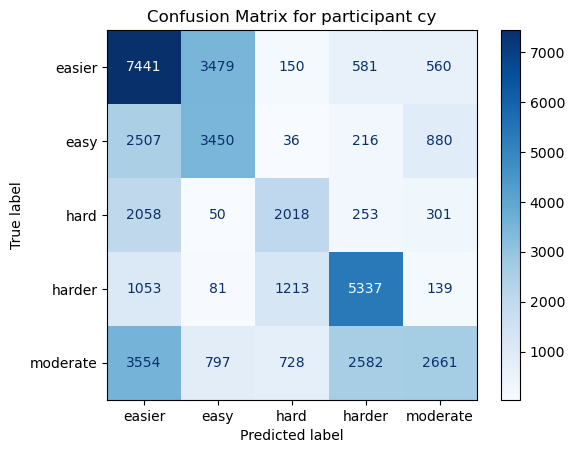


LOSO Iteration 2/11
Test participant: dh
Training model...
Evaluating model...
3782/3782 [==============================] - 10s 3ms/step
Accuracy for participant dh: 0.5084
Classification Report:
              precision    recall  f1-score   support

      easier       0.72      0.25      0.37     20968
        easy       0.74      0.32      0.44     28996
        hard       0.41      0.47      0.44     18206
      harder       0.65      0.72      0.68     25057
    moderate       0.39      0.74      0.51     27794

    accuracy                           0.51    121021
   macro avg       0.58      0.50      0.49    121021
weighted avg       0.59      0.51      0.50    121021



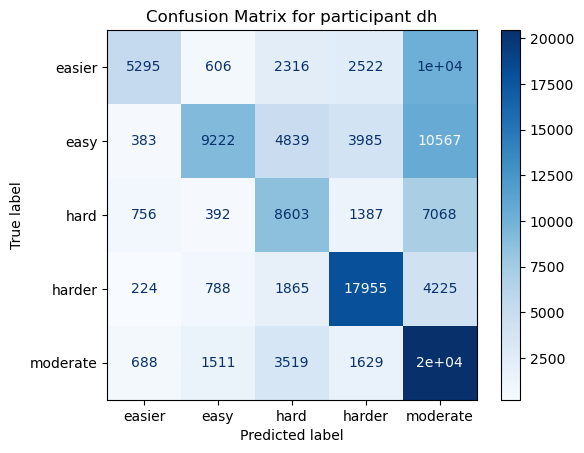


LOSO Iteration 3/11
Test participant: gb
Training model...
Evaluating model...
5680/5680 [==============================] - 15s 3ms/step
Accuracy for participant gb: 0.5499
Classification Report:
              precision    recall  f1-score   support

      easier       0.33      0.44      0.38     43889
        easy       0.58      0.45      0.51     34108
        hard       0.71      0.62      0.66     39739
      harder       0.63      0.70      0.67     23330
    moderate       0.67      0.60      0.63     40684

    accuracy                           0.55    181750
   macro avg       0.58      0.56      0.57    181750
weighted avg       0.57      0.55      0.56    181750



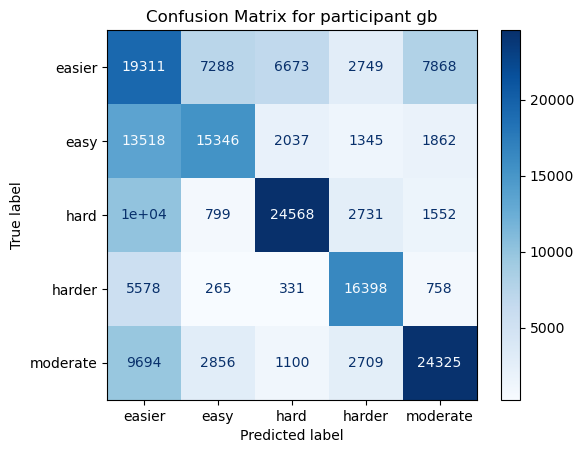


LOSO Iteration 4/11
Test participant: jj
Training model...
Evaluating model...
4718/4718 [==============================] - 13s 3ms/step
Accuracy for participant jj: 0.4158
Classification Report:
              precision    recall  f1-score   support

      easier       0.89      0.52      0.66     47144
        easy       0.56      0.21      0.31     30379
        hard       0.35      0.40      0.37     26567
      harder       0.47      0.52      0.49     21948
    moderate       0.17      0.39      0.24     24917

    accuracy                           0.42    150955
   macro avg       0.49      0.41      0.41    150955
weighted avg       0.55      0.42      0.44    150955



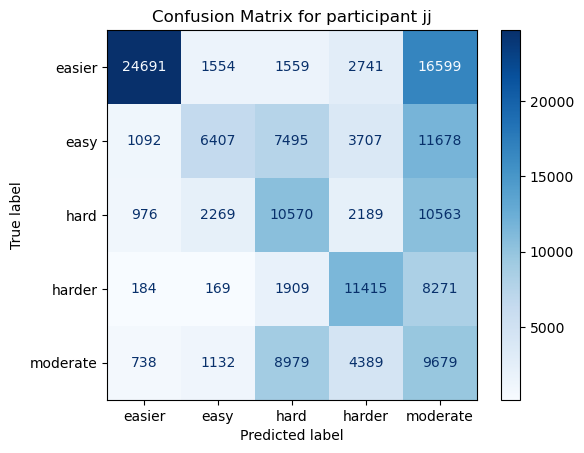


LOSO Iteration 5/11
Test participant: jw
Training model...
Evaluating model...
4779/4779 [==============================] - 13s 3ms/step
Accuracy for participant jw: 0.4548
Classification Report:
              precision    recall  f1-score   support

      easier       0.27      0.56      0.36     27678
        easy       0.69      0.45      0.54     46461
        hard       0.79      0.42      0.55     41977
      harder       0.39      0.50      0.44     22018
    moderate       0.32      0.31      0.31     14784

    accuracy                           0.45    152918
   macro avg       0.49      0.45      0.44    152918
weighted avg       0.56      0.45      0.47    152918



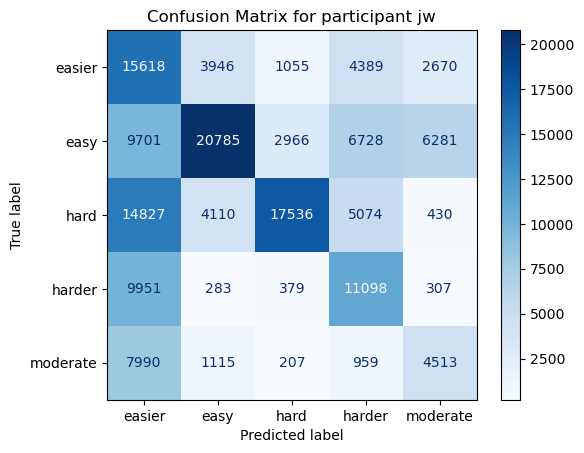


LOSO Iteration 6/11
Test participant: kb
Training model...
Evaluating model...
5739/5739 [==============================] - 15s 3ms/step
Accuracy for participant kb: 0.4746
Classification Report:
              precision    recall  f1-score   support

      easier       0.50      0.44      0.47     26121
        easy       0.25      0.50      0.34     38486
        hard       0.82      0.61      0.70     42915
      harder       0.63      0.62      0.63     39828
    moderate       0.41      0.15      0.22     36269

    accuracy                           0.47    183619
   macro avg       0.52      0.46      0.47    183619
weighted avg       0.53      0.47      0.48    183619



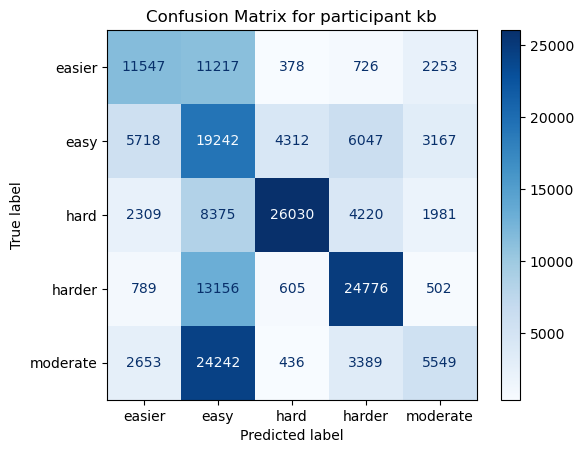


LOSO Iteration 7/11
Test participant: kw
Training model...
Evaluating model...
3159/3159 [==============================] - 9s 3ms/step
Accuracy for participant kw: 0.5783
Classification Report:
              precision    recall  f1-score   support

      easier       0.29      0.70      0.41     13553
        easy       0.73      0.31      0.44     17604
        hard       0.88      0.73      0.80     25996
      harder       0.60      0.79      0.68     20218
    moderate       0.67      0.36      0.47     23687

    accuracy                           0.58    101058
   macro avg       0.63      0.58      0.56    101058
weighted avg       0.67      0.58      0.58    101058



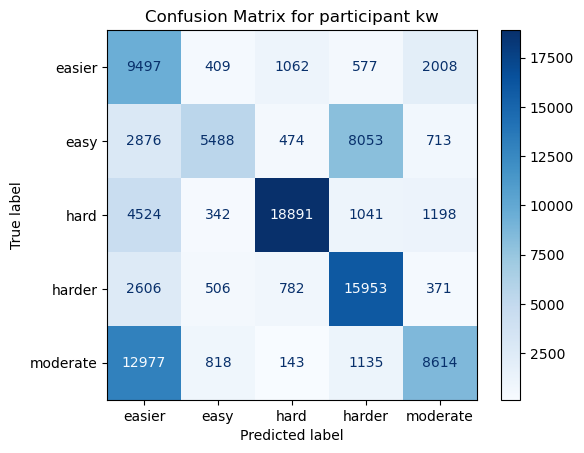


LOSO Iteration 8/11
Test participant: mw
Training model...
Evaluating model...
3940/3940 [==============================] - 10s 3ms/step
Accuracy for participant mw: 0.5789
Classification Report:
              precision    recall  f1-score   support

      easier       0.25      0.11      0.16     17341
        easy       0.22      0.47      0.30     16711
        hard       0.55      0.71      0.62     23283
      harder       0.90      0.76      0.83     41617
    moderate       0.80      0.56      0.66     27113

    accuracy                           0.58    126065
   macro avg       0.55      0.52      0.51    126065
weighted avg       0.64      0.58      0.59    126065



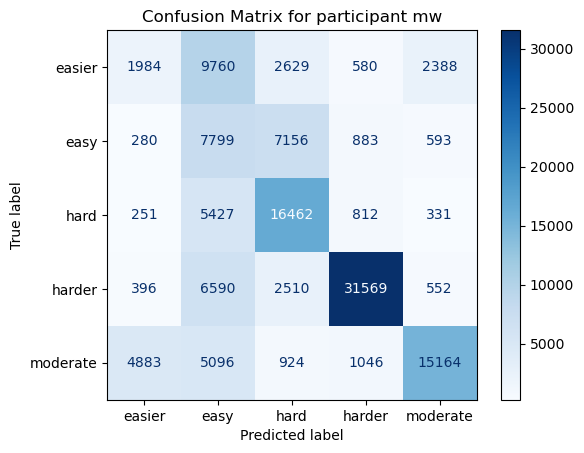


LOSO Iteration 9/11
Test participant: sh
Training model...
Evaluating model...
3858/3858 [==============================] - 11s 3ms/step
Accuracy for participant sh: 0.4160
Classification Report:
              precision    recall  f1-score   support

      easier       0.49      0.11      0.17     26021
        easy       0.38      0.12      0.18     24146
        hard       0.69      0.48      0.57     14618
      harder       0.82      0.63      0.71     35150
    moderate       0.23      0.70      0.34     23515

    accuracy                           0.42    123450
   macro avg       0.52      0.41      0.40    123450
weighted avg       0.54      0.42      0.41    123450



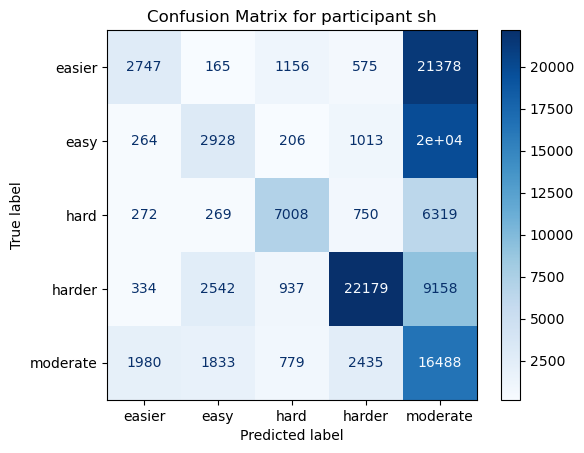


LOSO Iteration 10/11
Test participant: sm
Training model...
Evaluating model...
5787/5787 [==============================] - 15s 3ms/step
Accuracy for participant sm: 0.4613
Classification Report:
              precision    recall  f1-score   support

      easier       0.25      0.64      0.35     36747
        easy       0.59      0.29      0.39     26631
        hard       0.71      0.35      0.47     34980
      harder       0.79      0.52      0.63     41488
    moderate       0.64      0.44      0.52     45336

    accuracy                           0.46    185182
   macro avg       0.59      0.45      0.47    185182
weighted avg       0.60      0.46      0.48    185182



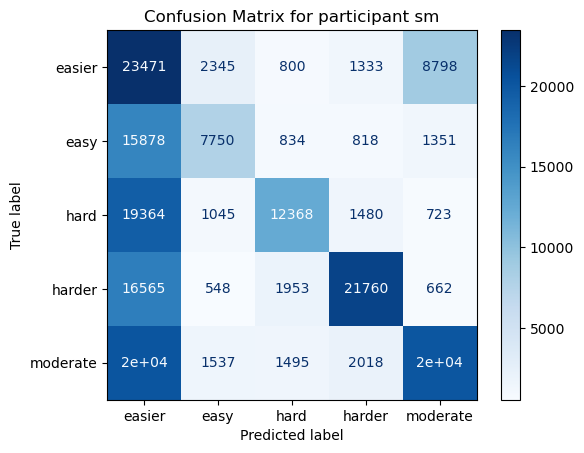


LOSO Iteration 11/11
Test participant: ym
Training model...
Evaluating model...
968/968 [==============================] - 3s 2ms/step
Accuracy for participant ym: 0.5193
Classification Report:
              precision    recall  f1-score   support

      easier       0.49      0.42      0.45      8150
        easy       0.73      0.66      0.70      9212
        hard       0.73      0.42      0.54      6862
      harder       0.17      0.78      0.29      1346
    moderate       0.46      0.49      0.47      5402

    accuracy                           0.52     30972
   macro avg       0.52      0.55      0.49     30972
weighted avg       0.60      0.52      0.54     30972



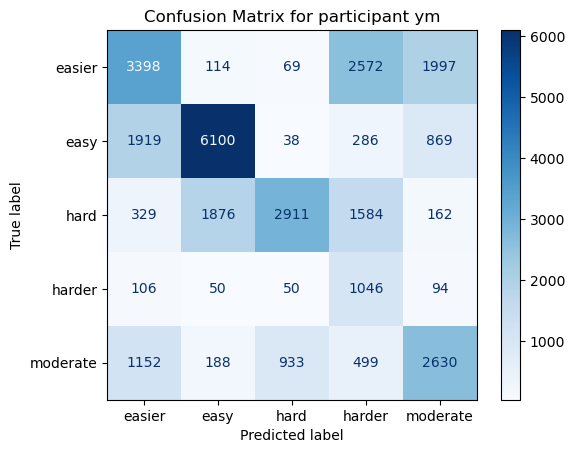


LOSO evaluation results:
Mean accuracy: 0.4958 (+/- 0.0551)

Training final model on all data...
Epoch 1/50
5466/5466 [==============================] - 38s 7ms/step - loss: 50907398144.0000 - accuracy: 0.3163
Epoch 2/50
5466/5466 [==============================] - 38s 7ms/step - loss: 6626502144.0000 - accuracy: 0.4141
Epoch 3/50
5466/5466 [==============================] - 45s 8ms/step - loss: 8083190272.0000 - accuracy: 0.4549
Epoch 4/50
5466/5466 [==============================] - 40s 7ms/step - loss: 3638089216.0000 - accuracy: 0.4935
Epoch 5/50
5466/5466 [==============================] - 40s 7ms/step - loss: 1.1300 - accuracy: 0.5157
Epoch 6/50
5466/5466 [==============================] - 37s 7ms/step - loss: 1.0897 - accuracy: 0.5305
Epoch 7/50
5466/5466 [==============================] - 36s 7ms/step - loss: 1.0660 - accuracy: 0.5394
Epoch 8/50
5466/5466 [==============================] - 36s 7ms/step - loss: 1.0462 - accuracy: 0.5472
Epoch 9/50
5466/5466 [===================

Traceback (most recent call last):
  File "C:\Users\USER\AppData\Local\Temp\ipykernel_3724\2556237296.py", line 299, in main
    final_model.save(model_filename)
  File "c:\Users\USER\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "c:\Users\USER\anaconda3\lib\site-packages\tensorflow\python\lib\io\file_io.py", line 511, in recursive_create_dir_v2
    _pywrap_file_io.RecursivelyCreateDir(compat.path_to_bytes(path))
tensorflow.python.framework.errors_impl.PermissionDeniedError: Failed to create a directory: C:\Users/HCIS; Permission denied


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, LeaveOneGroupOut
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Concatenate, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tqdm import tqdm
import time

# Change csv files to dataframes
def read_csv_files(directory):
    data_frames = {}
    print("\nReading CSV files:")
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            print(f"  Reading: {filename}")
            df = pd.read_csv(os.path.join(directory, filename))
            parts = filename.split('_')
            file_type = parts[0]
            participant = parts[-2] if len(parts) > 2 else 'unknown'
            difficulty = parts[-1].split('.')[0] if len(parts) > 1 else 'unknown'
            if not file_type == 'E4 ACC data':
                key = (participant, difficulty, file_type)
                data_frames[key] = df
            else:
                print(f"    Skipped: {filename} (ACC data)")
    print(f"Total files read: {len(data_frames)}")
    return data_frames

# Select useful data only (after game start, interpolate)
def preprocess_data(df):
    if 'started' in df['game started'].values:
        idx = df[df['game started'] == 'started'].index[0]
        df = df.iloc[idx:]
    else:
        print("Warning: 'game start' marker not found. Using all data.")
    
    numeric_columns = df.select_dtypes(include=[np.number]).columns
    df[numeric_columns] = df[numeric_columns].interpolate(method='linear', limit_direction='both')
    
    return df

def z_score_normalize(df, baseline_duration):
    numeric_columns = df.select_dtypes(include=[np.number]).columns.drop('UNIX Time')
    baseline = df.iloc[:baseline_duration]
    mean = baseline[numeric_columns].mean()
    std = baseline[numeric_columns].std()
    std = std.replace(0, 1)  # Replace zero std with 1 to avoid division by zero
    normalized_df = df.copy()
    normalized_df[numeric_columns] = (df[numeric_columns] - mean) / std
    return normalized_df

def process_data(df, window_size, baseline_duration):
    df = preprocess_data(df)
    
    if 'UNIX Time' not in df.columns or df['UNIX Time'].isnull().all():
        print("Error: 'UNIX Time' column not found or all values are null")
        return pd.DataFrame()
    
    start_time = df['UNIX Time'].min()
    game_start_time = start_time + baseline_duration
    
    unix_time = df['UNIX Time']
    df_numeric = df.select_dtypes(include=[np.number]).drop(columns=['UNIX Time'])
    
    df_numeric['UNIX Time'] = unix_time
    
    normalized_df = z_score_normalize(df_numeric, baseline_duration)
    
    df_after_start = normalized_df[normalized_df['UNIX Time'] >= game_start_time]
    
    if df_after_start.empty:
        print(f"Warning: No data available after assumed game start")
        return pd.DataFrame()
    
    df_numeric = df_after_start.drop(columns=['UNIX Time'])
    
    return df_numeric

def make_sequences(df, window_size):
    sequences = []
    for i in range(0, len(df) - window_size + 1):
        sequences.append(df.iloc[i:i+window_size].values)
    return np.array(sequences)

def create_dataset(data_frames, window_size, n_classes, expected_features, baseline_duration):
    X_data = []
    y_data = []
    participant_data = []
    all_columns = set()
    
    for (participant, difficulty, file_type), df in data_frames.items():
        processed_df = process_data(df, window_size, baseline_duration)
        all_columns.update(processed_df.columns)
    
    all_columns = sorted(list(all_columns))[:expected_features]  # Limit to expected number of features
    
    for (participant, difficulty, file_type), df in data_frames.items():
        processed_df = process_data(df, window_size, baseline_duration)
        
        for col in all_columns:
            if col not in processed_df.columns:
                processed_df[col] = 0
        
        processed_df = processed_df[all_columns]
        
        # Pad or truncate to match expected features
        if processed_df.shape[1] < expected_features:
            padding = pd.DataFrame(0, index=processed_df.index, 
                                   columns=[f'pad_{i}' for i in range(expected_features - processed_df.shape[1])])
            processed_df = pd.concat([processed_df, padding], axis=1)
        elif processed_df.shape[1] > expected_features:
            processed_df = processed_df.iloc[:, :expected_features]
            
        sequences = make_sequences(processed_df, window_size)
        if len(sequences) > 0:
            X_data.append(sequences)
            y_data.extend([difficulty] * len(sequences))
            participant_data.extend([participant] * len(sequences))
    
    X = np.concatenate(X_data)
    y = np.array(y_data)
    participants = np.array(participant_data)
    
    return X, y, participants

def create_advanced_lstm_model(input_shape, n_classes, lstm_units, dense_units, dropout_rate):
    inputs = Input(shape=input_shape)
    
    low_level = TimeDistributed(Dense(32, activation='relu'))(inputs)
    low_level = TimeDistributed(Dense(16, activation='relu'))(low_level)
    
    high_level = LSTM(lstm_units[0], return_sequences=True)(inputs)
    high_level = LSTM(lstm_units[1])(high_level)
    
    combined = Concatenate()([tf.keras.layers.Flatten()(low_level), high_level])
    
    x = Dense(dense_units, activation='relu')(combined)
    x = Dropout(dropout_rate)(x)
    
    outputs = Dense(n_classes, activation='softmax')(x)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

def loso_evaluation(X, y, participants, n_classes, hyperparameters):
    logo = LeaveOneGroupOut()
    
    loso_scores = []
    for i, (train_index, test_index) in enumerate(logo.split(X, y, participants)):
        print(f"\nLOSO Iteration {i+1}/{len(np.unique(participants))}")
        print(f"Test participant: {participants[test_index[0]]}")
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        model = create_advanced_lstm_model(
            input_shape=(X_train.shape[1], X_train.shape[2]),
            n_classes=n_classes,
            lstm_units=hyperparameters['lstm_units'],
            dense_units=hyperparameters['dense_units'],
            dropout_rate=hyperparameters['dropout_rate']
        )
        
        le = LabelEncoder()
        y_train_cat = to_categorical(le.fit_transform(y_train))
        y_test_cat = to_categorical(le.transform(y_test))
        
        print("Training model...")
        history = model.fit(X_train, y_train_cat, epochs=hyperparameters['epochs'], 
                            batch_size=hyperparameters['batch_size'], verbose=0)
        
        print("Evaluating model...")
        y_pred = model.predict(X_test)
        y_pred_classes = np.argmax(y_pred, axis=1)
        y_test_classes = np.argmax(y_test_cat, axis=1)
        
        accuracy = accuracy_score(y_test_classes, y_pred_classes)
        loso_scores.append(accuracy)
        print(f"Accuracy for participant {participants[test_index[0]]}: {accuracy:.4f}")
        
        print("Classification Report:")
        print(classification_report(y_test_classes, y_pred_classes, target_names=le.classes_))
        
        cm = confusion_matrix(y_test_classes, y_pred_classes)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix for participant {participants[test_index[0]]}')
        plt.show()
    
    return np.mean(loso_scores), np.std(loso_scores)

def main():
    directory = r'C:\Users\USER\Downloads\pilotdata'
    data_frames = read_csv_files(directory)
    
    window_size = 10  # 10-second window
    n_classes = 5  # Only 5-class classification
    expected_features = 11  # Set this to the number of features you expsect
    baseline_duration = 30  # Set this to your baseline duration in seconds
    
    print(f"\n{'='*50}")
    print(f"Running 5-class classification with LOSO evaluation")
    print(f"{'='*50}")
    
    X, y, participants = create_dataset(data_frames, window_size, n_classes, expected_features, baseline_duration)
    
    if X is None or y is None or participants is None:
        print("Failed to create dataset.")
        return
    
    print(f"Dataset shape: {X.shape}")
    print(f"Number of sequences: {X.shape[0]}")
    print(f"Sequence length: {X.shape[1]}")
    print(f"Number of features: {X.shape[2]}")
    print(f"Class distribution: {np.unique(y, return_counts=True)}")
    
    # Encode labels
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    
    print("\nApplying SMOTE...")
    smote = SMOTE(random_state=42)
    X_flat = X.reshape(X.shape[0], -1)
    
    # Apply SMOTE
    X_resampled, y_resampled = smote.fit_resample(X_flat, y_encoded)
    
    # Reshape X back to 3D
    X = X_resampled.reshape(X_resampled.shape[0], X.shape[1], X.shape[2])
    
    print("SMOTE completed.")
    print(f"Original shape: {X_flat.shape}, Resampled shape: {X_resampled.shape}")
    
    # Adjust participants array to match resampled data
    print("Adjusting participants array...")
    participants_resampled = []
    for label in np.unique(y_encoded):
        original_indices = np.where(y_encoded == label)[0]
        resampled_count = np.sum(y_resampled == label)
        participants_for_label = participants[original_indices]
        if len(participants_for_label) > 0:
            participants_resampled.extend(np.repeat(participants_for_label, resampled_count // len(participants_for_label)))
            remainder = resampled_count % len(participants_for_label)
            if remainder > 0:
                participants_resampled.extend(np.random.choice(participants_for_label, size=remainder, replace=True))
    
    participants = np.array(participants_resampled)
    y = le.inverse_transform(y_resampled)
    
    print(f"After SMOTE - Class distribution: {np.unique(y, return_counts=True)}")
    print(f"After SMOTE - Dataset shape: {X.shape}")
    print(f"After SMOTE - Participants shape: {participants.shape}")
    
    assert X.shape[0] == y.shape[0] == participants.shape[0], "Mismatch in array lengths after SMOTE"
    
    # Use the best hyperparameters you provided
    best_hyperparameters = {
        'lstm_units': (32, 16),
        'dense_units': 64,
        'dropout_rate': 0.3,
        'epochs': 50,
        'batch_size': 256
    }
    
    try:
        print("\nStarting LOSO evaluation with best hyperparameters...")
        loso_mean, loso_std = loso_evaluation(X, y, participants, n_classes, best_hyperparameters)
        print(f"\nLOSO evaluation results:")
        print(f"Mean accuracy: {loso_mean:.4f} (+/- {loso_std:.4f})")
        
        # Create and train the final model on all data
        final_model = create_advanced_lstm_model(
            input_shape=(X.shape[1], X.shape[2]),
            n_classes=n_classes,
            lstm_units=best_hyperparameters['lstm_units'],
            dense_units=best_hyperparameters['dense_units'],
            dropout_rate=best_hyperparameters['dropout_rate']
        )
        
        y_cat = to_categorical(le.transform(y))
        
        print("\nTraining final model on all data...")
        final_model.fit(X, y_cat, epochs=best_hyperparameters['epochs'], 
                        batch_size=best_hyperparameters['batch_size'], verbose=1)
        
        # Save the final model
        model_filename = r"C:\Users\HCIS\Downloads\pilotdata\best_lstm_model_lowhigh_3class0723.h5"
        final_model.save(model_filename)
        print(f"\nFinal model saved as {model_filename}")
        
        # Save the label encoder
        import joblib
        le_filename = r"C:\Users\HCIS\Downloads\pilotdata\label_encoder_lowhigh0723.joblib"
        joblib.dump(le, le_filename)
        print(f"Label encoder saved as {le_filename}")
        
    except Exception as e:
        import traceback
        print(f"An error occurred during the LOSO evaluation or model saving:")
        print(str(e))
        print("Traceback:")
        traceback.print_exc()

if __name__ == "__main__":
    main()


Reading CSV files:
  Reading: performance_jj_easier.csv
  Reading: performance_jj_easy.csv
  Reading: performance_jj_hard.csv
  Reading: performance_jj_harder.csv
  Reading: performance_jj_moderate.csv
  Reading: performance_kw_easier.csv
  Reading: performance_kw_easy.csv
  Reading: performance_kw_hard.csv
  Reading: performance_kw_harder.csv
  Reading: performance_kw_moderate.csv
  Reading: performance_ym_easier.csv
  Reading: performance_ym_easy.csv
  Reading: performance_ym_hard.csv
  Reading: performance_ym_harder.csv
  Reading: performance_ym_moderate.csv
Total files read: 15
        UNIX Time  Score  Health  game started
0    1.729667e+09    0.0     0.0           NaN
1    1.729667e+09    0.0     0.0           NaN
2    1.729667e+09    0.0     0.0           NaN
3    1.729667e+09    0.0     0.0           NaN
4    1.729667e+09    0.0     0.0           NaN
..            ...    ...     ...           ...
958  1.729667e+09    0.0     0.0           NaN
959  1.729667e+09   15.0     0.0  

c:\Users\USER\anaconda3\lib\site-packages\pandas\plotting\_matplotlib\core.py:580: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


        UNIX Time  Score  Health  game started
0    1.729680e+09    0.0     0.0           NaN
1    1.729680e+09    0.0     0.0           NaN
2    1.729680e+09    0.0     0.0           NaN
3    1.729680e+09    0.0     0.0           NaN
4    1.729680e+09    0.0     0.0           NaN
..            ...    ...     ...           ...
930  1.729680e+09    0.0     0.0           NaN
931  1.729680e+09    0.0     0.0           NaN
932  1.729680e+09    0.0     0.0           NaN
933  1.729680e+09    0.0     0.0           NaN
934  1.729680e+09    0.0     0.0           NaN

[935 rows x 4 columns]
        UNIX Time  Score  Health  game started
0    1.729680e+09    0.0     0.0           NaN
1    1.729680e+09    0.0     0.0           NaN
2    1.729680e+09    0.0     0.0           NaN
3    1.729680e+09    0.0     0.0           NaN
4    1.729680e+09    0.0     0.0           NaN
..            ...    ...     ...           ...
202  1.729680e+09    0.0     0.0           NaN
203  1.729680e+09    0.0     0.0    

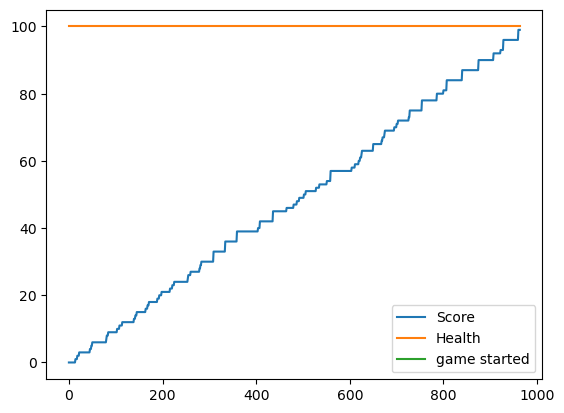

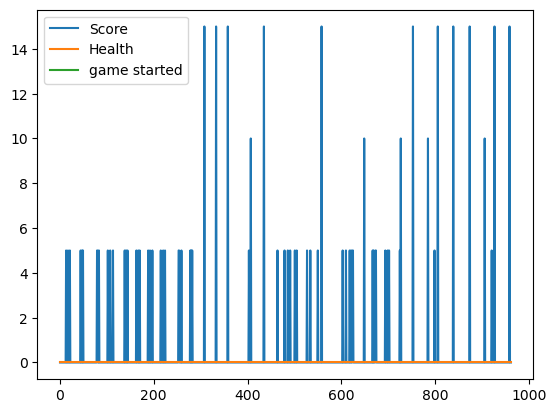

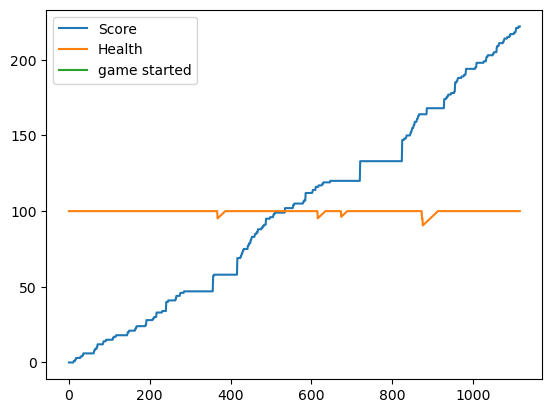

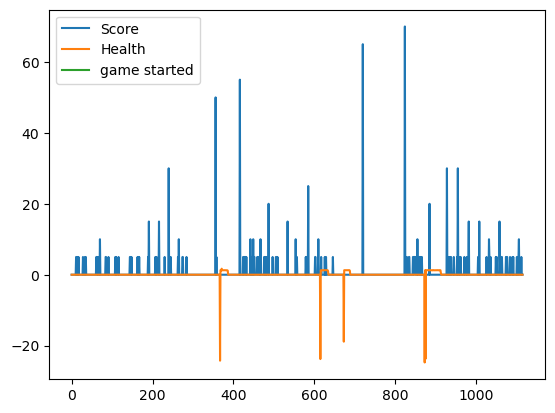

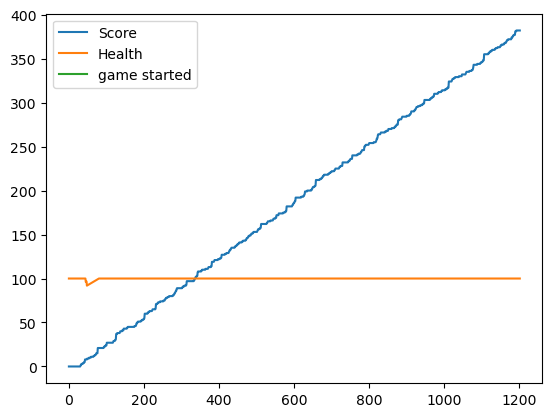

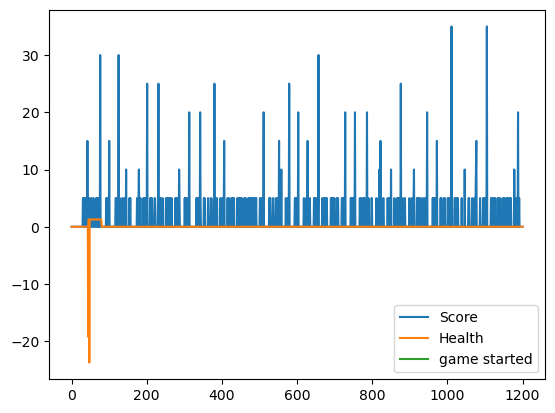

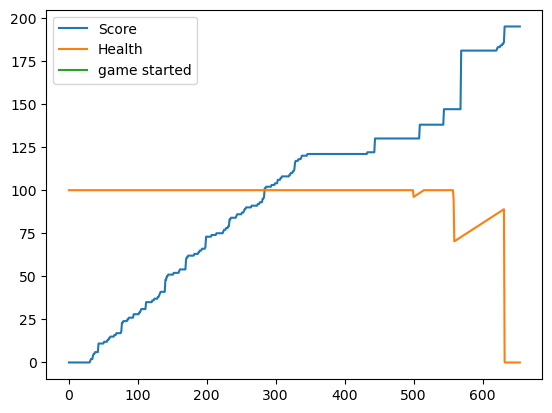

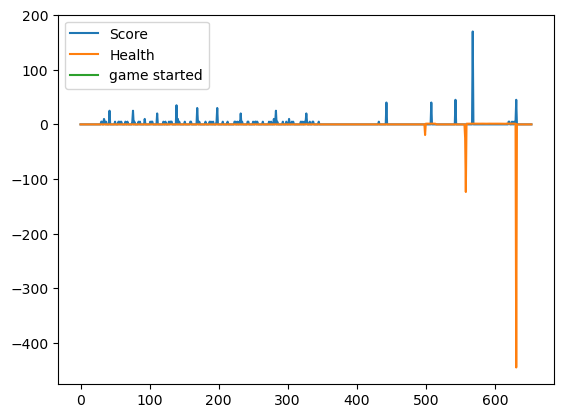

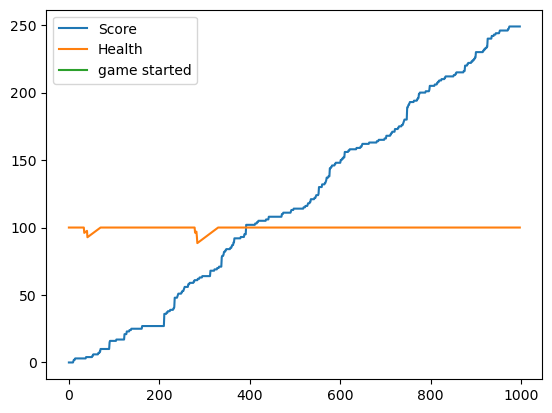

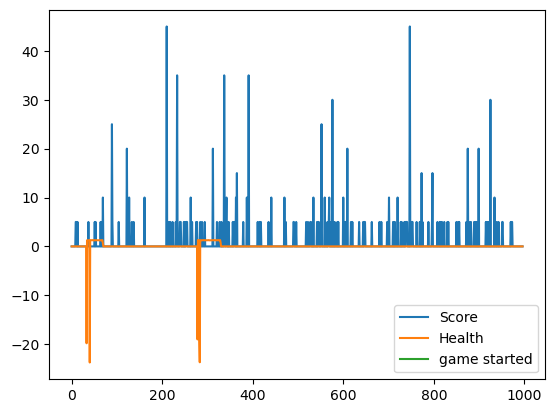

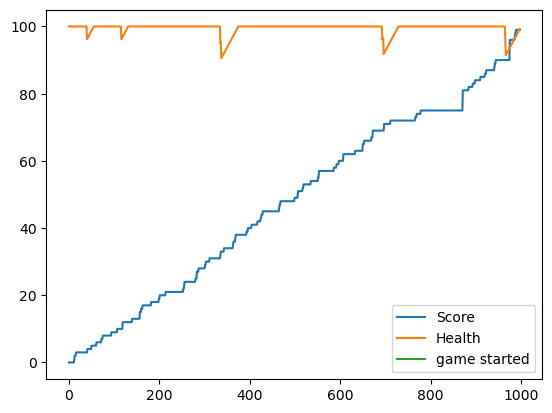

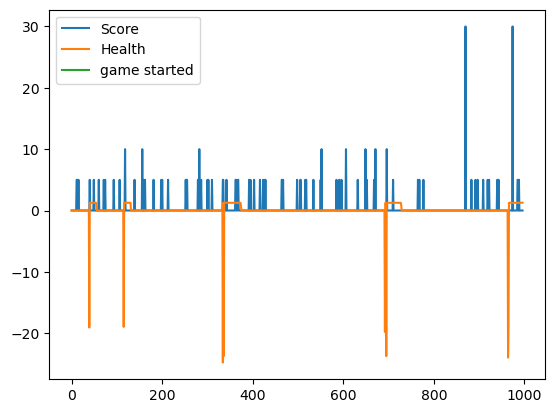

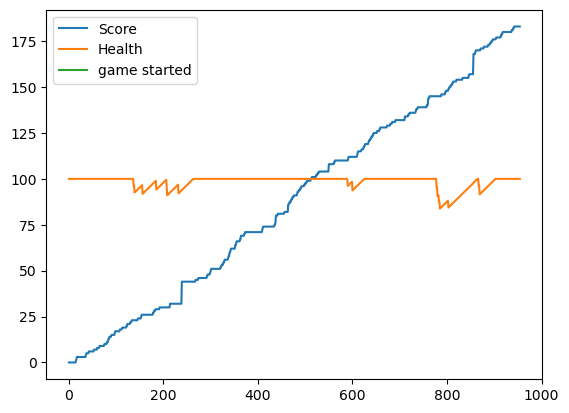

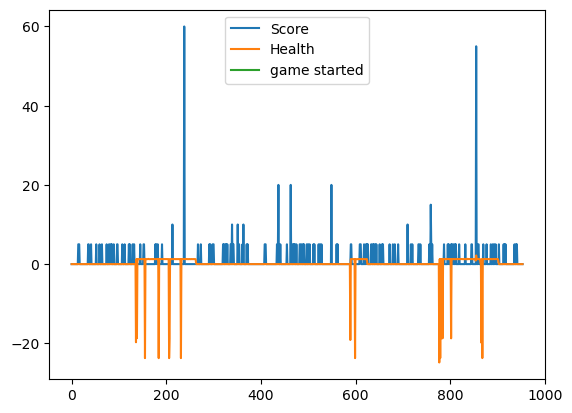

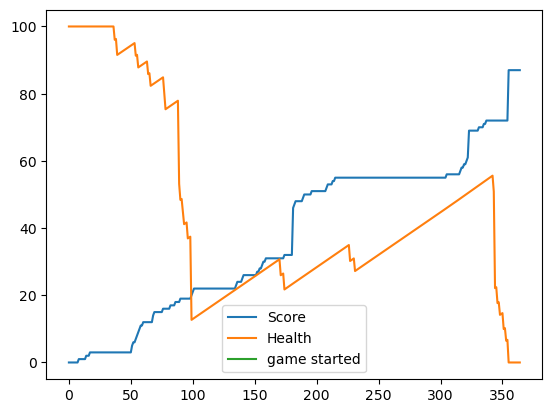

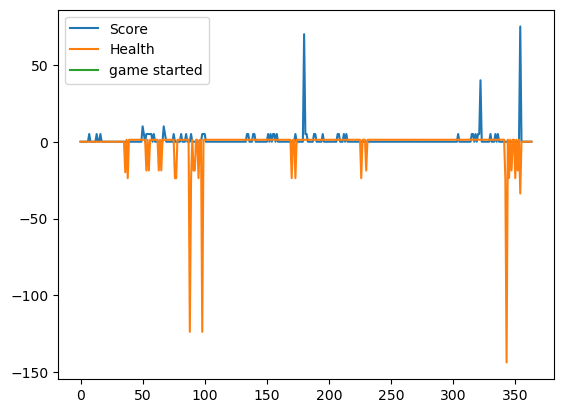

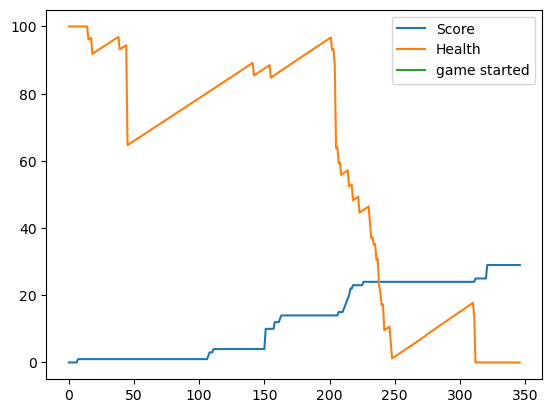

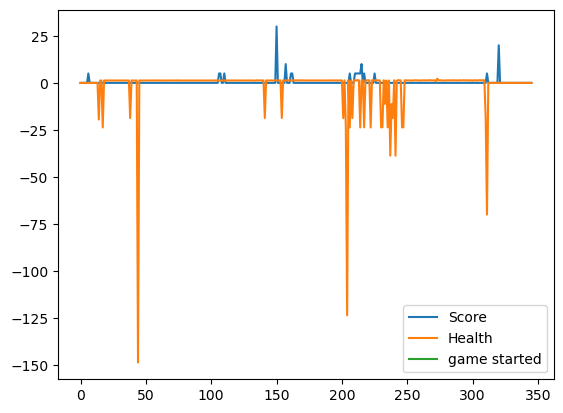

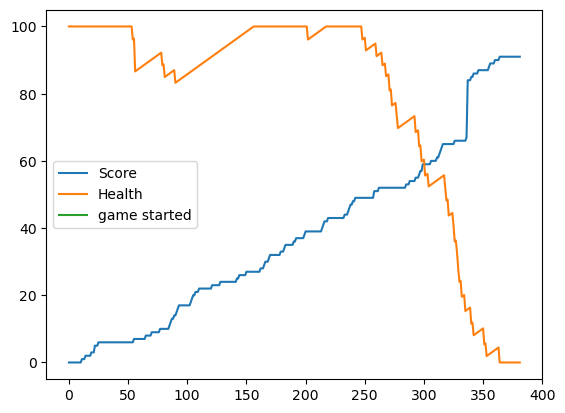

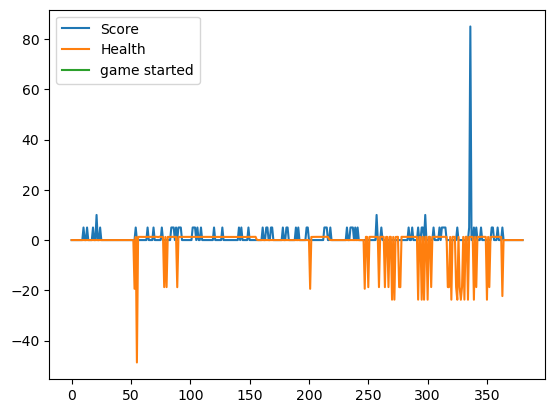

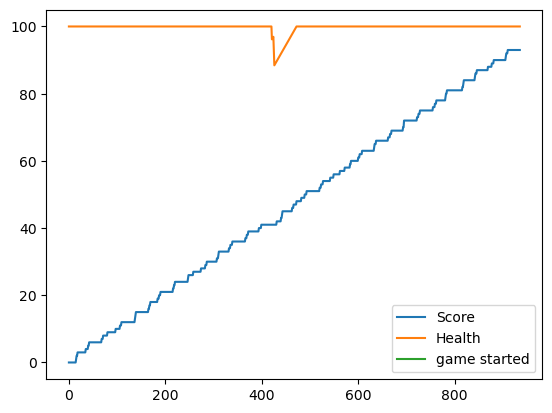

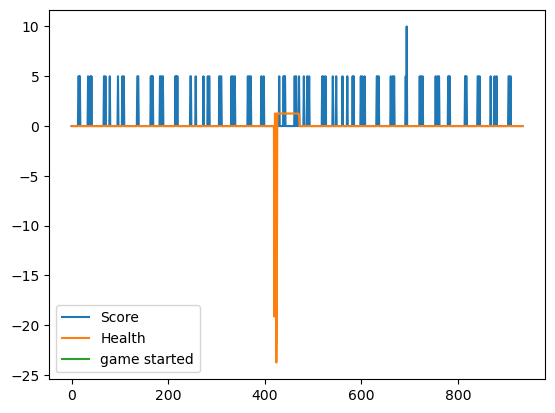

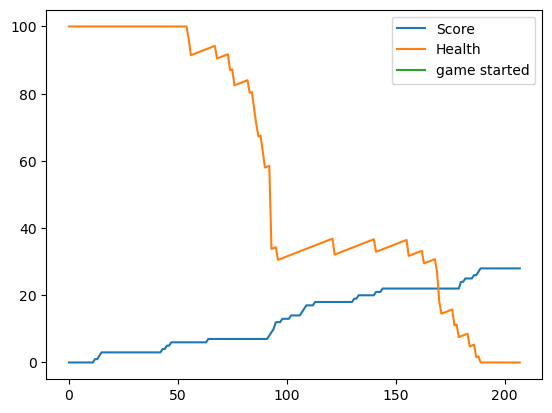

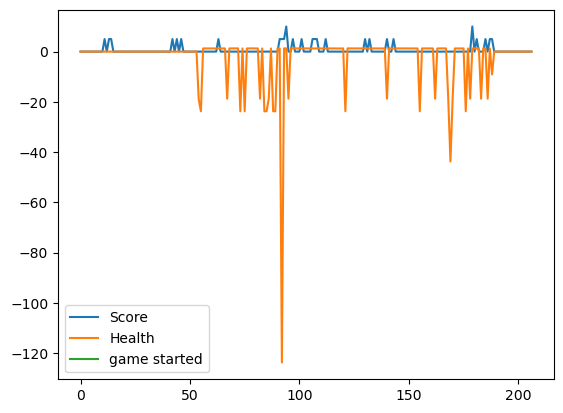

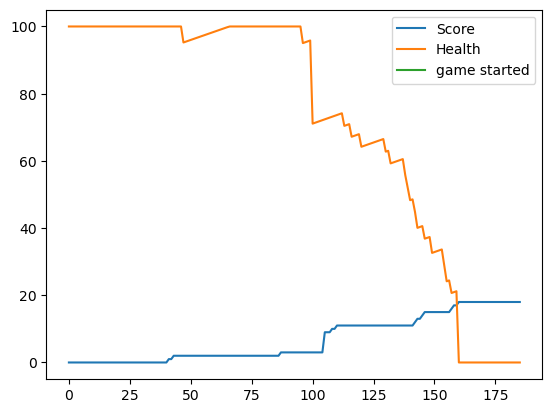

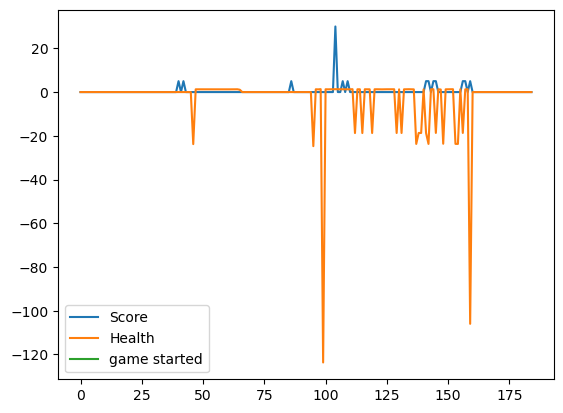

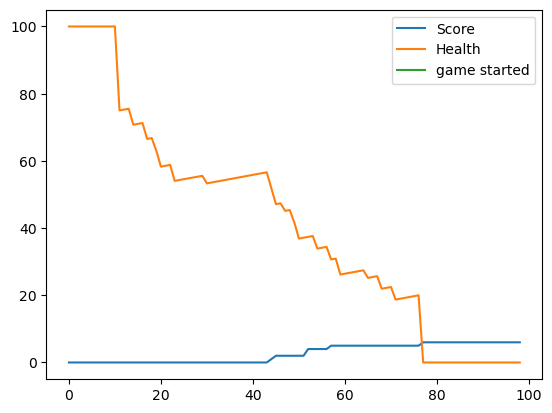

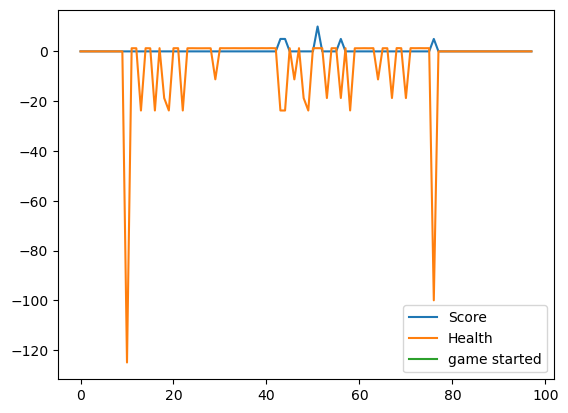

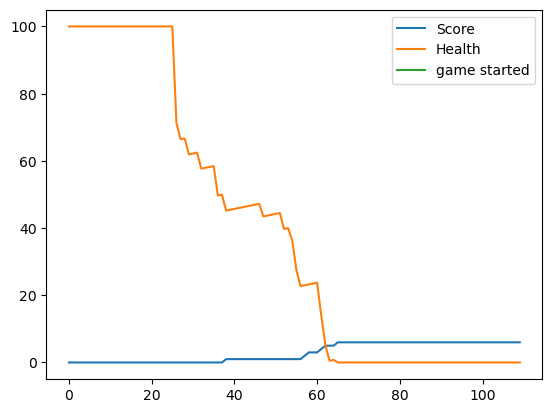

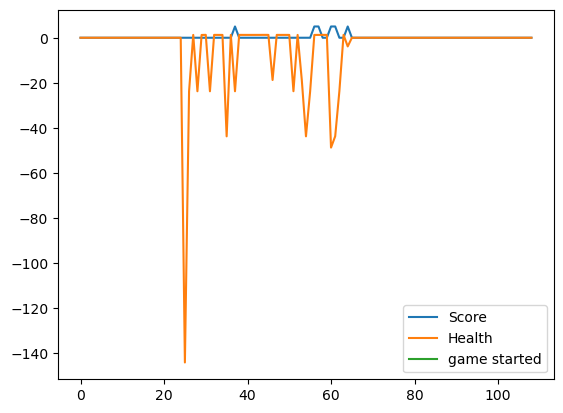

In [2]:
import os
import pandas as pd
import numpy as np

def read_csv_files(directory):
    data_frames = {}
    print("\nReading CSV files:")
    for filename in os.listdir(directory):
        if filename.endswith('.csv'):
            print(f"  Reading: {filename}")
            df = pd.read_csv(os.path.join(directory, filename))
            parts = filename.split('_')
            participant = parts[-2] if len(parts) > 2 else 'unknown'
            difficulty = parts[-1].split('.')[0] if len(parts) > 1 else 'unknown'
            key = (participant, difficulty)
            data_frames[key] = df
    print(f"Total files read: {len(data_frames)}")
    return data_frames

def calculate_dt(df):
    dt_result = {}
    
    for (participant, difficulty), df in df.items():
        time = df.pop('UNIX Time')
        %matplotlib inline
        df.plot()
        key = (participant, difficulty)
        dt = pd.DataFrame()
        for i in range(len(df) - 1):
            dt = pd.concat([dt, ((df.iloc[i + 1] - df.iloc[i]) / 0.2).to_frame().T], ignore_index=True)
        %matplotlib inline
        dt.plot()
        dt.insert(0, 'UNIX Time', time)
        print(dt)
        dt.to_csv(f"C:/Users/USER/Downloads/pilotdata_performance/differential_{participant}_{difficulty}.csv", index=False)
        dt_result[key] = dt
    return dt_result

def main():
    directory = r'C:\Users\USER\Downloads\pilotdata_performance'
    data_frames = read_csv_files(directory)
    dt = calculate_dt(data_frames)
    
if __name__ == "__main__":
    main()